In [1]:
%%html
<link rel="stylesheet" href="custom.css"> 


\title{TP Deep Neural Network}
\author{Enzo Cabaret}
\maketitle

\section{I. Travail Préliminaire}

\subsection{Librairies utiles :}

In [1]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import gc
from joblib import Parallel,delayed
import os
import contextlib
from tqdm import tqdm

#code
from Rbm import Rbm
from Dnn import Dnn

%load_ext autoreload
%autoreload 2

##### \subsection{Fonction de lecture des données : }

In [3]:
def lire_alpha_digit(ind_carac = None): 
    """
    get data from alpha_digit database
    
    
    Parameters
    ----------------
    ind_carac: list of int
        liste contenant les indices des caractères que l'on souhaite importer
    
    Returns
    ---------------
    np.ndarray 
    
    """
    if  ind_carac is None:
        ind_carac = list(range(len))
    raw = scipy.io.loadmat('./data/binaryalphadigs.mat')['dat'][ind_carac]
    data = []
    for carac in raw:
        for x in carac:
            data += [x.flatten()]
    return np.array(data)
        

\subsection{1. Chargement des données :}

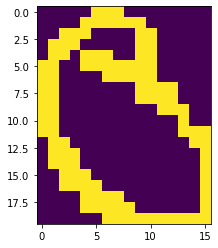

In [29]:
# on récupère le caractère 0 
data = lire_alpha_digit([0,5,8])
plt.imshow(data[0].reshape((20,16)))

\subsection{2. Entrainement du Rbm et regénération de données :}

In [30]:
#initialisation d'un rbm avec 50 noeud cachés
rbm = Rbm(len(data[0]),50)
#entrainement du rbm sur les données, nombre d'épochs 100, learning rate 0.1, taille des minibatch 5
rbm.train(data,100,0.1,5)

erreur quadratique :  14329
erreur quadratique :  11929
erreur quadratique :  11179
erreur quadratique :  10761
erreur quadratique :  10001
erreur quadratique :  9841
erreur quadratique :  9776
erreur quadratique :  9371
erreur quadratique :  8912
erreur quadratique :  8895
erreur quadratique :  8501
erreur quadratique :  8305
erreur quadratique :  8044
erreur quadratique :  7896
erreur quadratique :  7882
erreur quadratique :  7666
erreur quadratique :  7411
erreur quadratique :  7275
erreur quadratique :  7182
erreur quadratique :  7164
erreur quadratique :  7108
erreur quadratique :  6791
erreur quadratique :  6736
erreur quadratique :  6599
erreur quadratique :  6644
erreur quadratique :  6517
erreur quadratique :  6380
erreur quadratique :  6363
erreur quadratique :  6258
erreur quadratique :  6168
erreur quadratique :  6008
erreur quadratique :  6098
erreur quadratique :  5984
erreur quadratique :  5926
erreur quadratique :  5761
erreur quadratique :  5714
erreur quadratique :  5

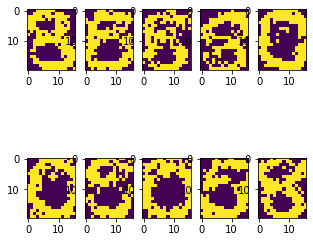

In [31]:
#génération de données avec le rbm entrainé et 30 itération du gibbs sampling
im = rbm.generer_image(10,30)
#affichage
fig = plt.figure(figsize = (5,5))
columns = 5
rows = 2

for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(im[i-1].reshape(20,16))
plt.show()

\subsection{3. Pré-entrainement du Dnn et Regénération de données :}

In [32]:
dnn = Dnn([len(data[0]),50,50,50,3])
dnn.pretrain(data,100,0.1,5)

train rbm  1
erreur quadratique :  13506
erreur quadratique :  11805
erreur quadratique :  11104
erreur quadratique :  10569
erreur quadratique :  9983
erreur quadratique :  9896
erreur quadratique :  9306
erreur quadratique :  9219
erreur quadratique :  8918
erreur quadratique :  8690
erreur quadratique :  8420
erreur quadratique :  8308
erreur quadratique :  8102
erreur quadratique :  7738
erreur quadratique :  7706
erreur quadratique :  7713
erreur quadratique :  7430
erreur quadratique :  7326
erreur quadratique :  7300
erreur quadratique :  7006
erreur quadratique :  6885
erreur quadratique :  6891
erreur quadratique :  6630
erreur quadratique :  6638
erreur quadratique :  6656
erreur quadratique :  6545
erreur quadratique :  6174
erreur quadratique :  6300
erreur quadratique :  6232
erreur quadratique :  6131
erreur quadratique :  5996
erreur quadratique :  6127
erreur quadratique :  5990
erreur quadratique :  5817
erreur quadratique :  5867
erreur quadratique :  5831
erreur quad

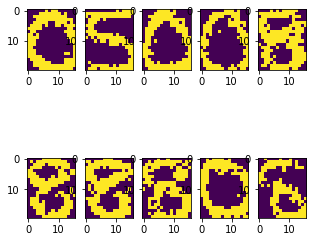

In [16]:
#génération de données avec le dnn entrainé et 30 itération du gibbs sampling
im = dnn.genere_images(10,30)
fig = plt.figure(figsize = (5,5))
columns = 5
rows = 2

for i in range(1,columns*rows+1):
    fig.add_subplot(rows,columns,i)
    plt.imshow(im[i-1].reshape(20,16))
plt.show()

\begin{remark}
On remarque que les images générées par le dnn sont bien plus fidèles aux données d'entrainement que celles générées par le rbm. Notamment le 5 avait du mal à apparaitre sur notre rbm ici il apparait clairement.
\end{remark}

\section{II. Etude à réaliser : }

\subsection{Importation des données :}

In [3]:
from mnist import MNIST
from sklearn.preprocessing import OneHotEncoder
#importer les données d'entrainement
mndata = MNIST('samples')
images, labels = mndata.load_training()

data_train = np.array(images)
#conversion en binaire
data_train[data_train>0] = 1

#One hot encoding des labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.arange(10).reshape(-1,1))

labels_train = enc.transform(np.array(labels).reshape(-1,1)).toarray()

# données de test
images, labels = mndata.load_testing()

data_test = np.array(images)
#conversion en binaire
data_test[data_test>0] = 1

#One hot encoding des labels
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.arange(10).reshape(-1,1))

labels_test = enc.transform(np.array(labels).reshape(-1,1)).toarray()

\subsection{1. Etude de l'impact du nombre de couches :}

Dans cette première partie de l'étude nous fixons tous les paramètres, sauf le nombre de couches que nous faisons varier, et comparons le comportement des dnn en fonction du nombre de couches choisies et du préentrainement ou non.

In [6]:
#paramètres
epoch_rbm = 100
epoch_retro_prop = 200
learning_rate = 0.05
mini_batch_size = 1000
param_ncouches = [2,3,4,5]
n_neurones = 200

dnn_list = []
dnn_pretrain_list = []
#initialisation des dnn que l'on va étudier 

for n_couches in param_ncouches:
    #la première couche est de la taille des vecteurs d'entrée
    size = [len(data_train[0])]
    #ajout des couches intermédiaires
    size += [n_neurones]*(n_couches)
    #la dernière couche dépend des différentes catégories que l'ont souhaite prédire 
    size += [10]
    #initialisation du dnn
    dnn = Dnn(size)
    #initialisation indentique du dnn préentrainé
    dnn_pre_train = deepcopy(dnn)
    print("pretrain du dnn :")
    #pre entrainemnet
    dnn_pre_train.pretrain(data_train,epoch_rbm,learning_rate,mini_batch_size)
    
    dnn_list += [dnn]
    dnn_pretrain_list+= [dnn_pre_train]

    

  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:04<07:06,  4.30s/it]

erreur quadratique :  6344466


  2%|▏         | 2/100 [00:08<06:50,  4.19s/it]

erreur quadratique :  5442753


  3%|▎         | 3/100 [00:12<06:41,  4.14s/it]

erreur quadratique :  4978639


  4%|▍         | 4/100 [00:16<06:31,  4.08s/it]

erreur quadratique :  4663369


  5%|▌         | 5/100 [00:20<06:32,  4.13s/it]

erreur quadratique :  4428174


  6%|▌         | 6/100 [00:24<06:24,  4.09s/it]

erreur quadratique :  4247781


  7%|▋         | 7/100 [00:28<06:13,  4.01s/it]

erreur quadratique :  4102617


  8%|▊         | 8/100 [00:32<06:13,  4.06s/it]

erreur quadratique :  3979876


  9%|▉         | 9/100 [00:36<06:09,  4.06s/it]

erreur quadratique :  3876608


 10%|█         | 10/100 [00:40<06:06,  4.08s/it]

erreur quadratique :  3781525


 11%|█         | 11/100 [00:44<06:01,  4.06s/it]

erreur quadratique :  3702035


 12%|█▏        | 12/100 [00:48<06:01,  4.11s/it]

erreur quadratique :  3628898


 13%|█▎        | 13/100 [00:53<06:07,  4.22s/it]

erreur quadratique :  3570190


 14%|█▍        | 14/100 [00:57<05:57,  4.15s/it]

erreur quadratique :  3502917


 15%|█▌        | 15/100 [01:01<05:48,  4.10s/it]

erreur quadratique :  3447503


 16%|█▌        | 16/100 [01:05<05:40,  4.06s/it]

erreur quadratique :  3402749


 17%|█▋        | 17/100 [01:09<05:36,  4.06s/it]

erreur quadratique :  3351966


 18%|█▊        | 18/100 [01:13<05:27,  4.00s/it]

erreur quadratique :  3312702


 19%|█▉        | 19/100 [01:17<05:20,  3.95s/it]

erreur quadratique :  3270233


 20%|██        | 20/100 [01:20<05:13,  3.92s/it]

erreur quadratique :  3231739


 21%|██        | 21/100 [01:24<05:07,  3.89s/it]

erreur quadratique :  3200372


 22%|██▏       | 22/100 [01:28<05:02,  3.88s/it]

erreur quadratique :  3165195


 23%|██▎       | 23/100 [01:32<05:00,  3.90s/it]

erreur quadratique :  3133148


 24%|██▍       | 24/100 [01:36<04:55,  3.88s/it]

erreur quadratique :  3105926


 25%|██▌       | 25/100 [01:40<05:01,  4.02s/it]

erreur quadratique :  3079199


 26%|██▌       | 26/100 [01:44<04:58,  4.03s/it]

erreur quadratique :  3050097


 27%|██▋       | 27/100 [01:48<04:52,  4.01s/it]

erreur quadratique :  3030575


 28%|██▊       | 28/100 [01:52<04:49,  4.02s/it]

erreur quadratique :  3005286


 29%|██▉       | 29/100 [01:56<04:43,  4.00s/it]

erreur quadratique :  2981414


 30%|███       | 30/100 [02:00<04:38,  3.98s/it]

erreur quadratique :  2960013


 31%|███       | 31/100 [02:04<04:33,  3.97s/it]

erreur quadratique :  2938839


 32%|███▏      | 32/100 [02:08<04:37,  4.07s/it]

erreur quadratique :  2923945


 33%|███▎      | 33/100 [02:12<04:28,  4.01s/it]

erreur quadratique :  2902920


 34%|███▍      | 34/100 [02:17<04:33,  4.14s/it]

erreur quadratique :  2880607


 35%|███▌      | 35/100 [02:21<04:28,  4.14s/it]

erreur quadratique :  2864279


 36%|███▌      | 36/100 [02:25<04:27,  4.17s/it]

erreur quadratique :  2849366


 37%|███▋      | 37/100 [02:29<04:20,  4.14s/it]

erreur quadratique :  2837182


 38%|███▊      | 38/100 [02:33<04:17,  4.15s/it]

erreur quadratique :  2818619


 39%|███▉      | 39/100 [02:37<04:09,  4.10s/it]

erreur quadratique :  2806559


 40%|████      | 40/100 [02:41<04:01,  4.03s/it]

erreur quadratique :  2789338


 41%|████      | 41/100 [02:45<03:55,  4.00s/it]

erreur quadratique :  2776650


 42%|████▏     | 42/100 [02:49<03:50,  3.97s/it]

erreur quadratique :  2759392


 43%|████▎     | 43/100 [02:53<03:48,  4.01s/it]

erreur quadratique :  2745478


 44%|████▍     | 44/100 [02:57<03:44,  4.01s/it]

erreur quadratique :  2735263


 45%|████▌     | 45/100 [03:01<03:40,  4.01s/it]

erreur quadratique :  2723178


 46%|████▌     | 46/100 [03:05<03:36,  4.01s/it]

erreur quadratique :  2709709


 47%|████▋     | 47/100 [03:09<03:32,  4.00s/it]

erreur quadratique :  2697991


 48%|████▊     | 48/100 [03:13<03:27,  3.99s/it]

erreur quadratique :  2687532


 49%|████▉     | 49/100 [03:18<03:30,  4.13s/it]

erreur quadratique :  2672760


 50%|█████     | 50/100 [03:22<03:28,  4.17s/it]

erreur quadratique :  2665337


 51%|█████     | 51/100 [03:26<03:23,  4.15s/it]

erreur quadratique :  2655903


 52%|█████▏    | 52/100 [03:30<03:20,  4.17s/it]

erreur quadratique :  2643039


 53%|█████▎    | 53/100 [03:34<03:12,  4.09s/it]

erreur quadratique :  2632181


 54%|█████▍    | 54/100 [03:38<03:04,  4.02s/it]

erreur quadratique :  2623712


 55%|█████▌    | 55/100 [03:42<02:58,  3.97s/it]

erreur quadratique :  2613561


 56%|█████▌    | 56/100 [03:46<02:53,  3.94s/it]

erreur quadratique :  2603354


 57%|█████▋    | 57/100 [03:50<02:50,  3.97s/it]

erreur quadratique :  2594923


 58%|█████▊    | 58/100 [03:54<02:47,  3.98s/it]

erreur quadratique :  2583281


 59%|█████▉    | 59/100 [03:58<02:42,  3.97s/it]

erreur quadratique :  2577556


 60%|██████    | 60/100 [04:01<02:37,  3.94s/it]

erreur quadratique :  2571072


 61%|██████    | 61/100 [04:06<02:35,  4.00s/it]

erreur quadratique :  2559358


 62%|██████▏   | 62/100 [04:09<02:30,  3.97s/it]

erreur quadratique :  2552918


 63%|██████▎   | 63/100 [04:14<02:27,  3.99s/it]

erreur quadratique :  2543672


 64%|██████▍   | 64/100 [04:18<02:24,  4.01s/it]

erreur quadratique :  2535842


 65%|██████▌   | 65/100 [04:22<02:19,  3.99s/it]

erreur quadratique :  2530053


 66%|██████▌   | 66/100 [04:25<02:14,  3.96s/it]

erreur quadratique :  2519561


 67%|██████▋   | 67/100 [04:29<02:09,  3.94s/it]

erreur quadratique :  2511824


 68%|██████▊   | 68/100 [04:33<02:05,  3.92s/it]

erreur quadratique :  2504968


 69%|██████▉   | 69/100 [04:37<02:01,  3.91s/it]

erreur quadratique :  2499848


 70%|███████   | 70/100 [04:41<01:58,  3.95s/it]

erreur quadratique :  2491161


 71%|███████   | 71/100 [04:45<01:53,  3.92s/it]

erreur quadratique :  2484221


 72%|███████▏  | 72/100 [04:49<01:49,  3.91s/it]

erreur quadratique :  2475692


 73%|███████▎  | 73/100 [04:53<01:45,  3.92s/it]

erreur quadratique :  2472671


 74%|███████▍  | 74/100 [04:57<01:42,  3.93s/it]

erreur quadratique :  2462749


 75%|███████▌  | 75/100 [05:01<01:38,  3.92s/it]

erreur quadratique :  2458198


 76%|███████▌  | 76/100 [05:05<01:36,  4.02s/it]

erreur quadratique :  2450925


 77%|███████▋  | 77/100 [05:09<01:31,  3.97s/it]

erreur quadratique :  2444155


 78%|███████▊  | 78/100 [05:13<01:26,  3.94s/it]

erreur quadratique :  2440538


 79%|███████▉  | 79/100 [05:17<01:22,  3.94s/it]

erreur quadratique :  2432358


 80%|████████  | 80/100 [05:21<01:19,  3.99s/it]

erreur quadratique :  2428193


 81%|████████  | 81/100 [05:25<01:16,  4.01s/it]

erreur quadratique :  2423445


 82%|████████▏ | 82/100 [05:29<01:14,  4.12s/it]

erreur quadratique :  2413869


 83%|████████▎ | 83/100 [05:33<01:10,  4.14s/it]

erreur quadratique :  2410155


 84%|████████▍ | 84/100 [05:38<01:06,  4.17s/it]

erreur quadratique :  2405757


 85%|████████▌ | 85/100 [05:42<01:02,  4.19s/it]

erreur quadratique :  2399126


 86%|████████▌ | 86/100 [05:46<00:58,  4.16s/it]

erreur quadratique :  2392222


 87%|████████▋ | 87/100 [05:50<00:53,  4.08s/it]

erreur quadratique :  2388017


 88%|████████▊ | 88/100 [05:54<00:48,  4.06s/it]

erreur quadratique :  2380556


 89%|████████▉ | 89/100 [05:58<00:44,  4.03s/it]

erreur quadratique :  2379479


 90%|█████████ | 90/100 [06:02<00:40,  4.01s/it]

erreur quadratique :  2373747


 91%|█████████ | 91/100 [06:06<00:35,  3.99s/it]

erreur quadratique :  2367663


 92%|█████████▏| 92/100 [06:10<00:32,  4.05s/it]

erreur quadratique :  2364723


 93%|█████████▎| 93/100 [06:14<00:28,  4.01s/it]

erreur quadratique :  2359024


 94%|█████████▍| 94/100 [06:18<00:24,  4.09s/it]

erreur quadratique :  2355261


 95%|█████████▌| 95/100 [06:22<00:20,  4.05s/it]

erreur quadratique :  2346059


 96%|█████████▌| 96/100 [06:26<00:16,  4.05s/it]

erreur quadratique :  2344607


 97%|█████████▋| 97/100 [06:30<00:12,  4.01s/it]

erreur quadratique :  2340888


 98%|█████████▊| 98/100 [06:34<00:07,  3.99s/it]

erreur quadratique :  2332002


 99%|█████████▉| 99/100 [06:38<00:03,  3.98s/it]

erreur quadratique :  2330483


100%|██████████| 100/100 [06:42<00:00,  4.02s/it]

erreur quadratique :  2326391



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:01<02:32,  1.54s/it]

erreur quadratique :  3768485


  2%|▏         | 2/100 [00:03<02:30,  1.53s/it]

erreur quadratique :  3247098


  3%|▎         | 3/100 [00:04<02:28,  1.53s/it]

erreur quadratique :  2978009


  4%|▍         | 4/100 [00:06<02:28,  1.55s/it]

erreur quadratique :  2794606


  5%|▌         | 5/100 [00:07<02:27,  1.55s/it]

erreur quadratique :  2654471


  6%|▌         | 6/100 [00:09<02:25,  1.55s/it]

erreur quadratique :  2543035


  7%|▋         | 7/100 [00:10<02:24,  1.56s/it]

erreur quadratique :  2450241


  8%|▊         | 8/100 [00:12<02:27,  1.60s/it]

erreur quadratique :  2374695


  9%|▉         | 9/100 [00:14<02:25,  1.60s/it]

erreur quadratique :  2308738


 10%|█         | 10/100 [00:15<02:25,  1.62s/it]

erreur quadratique :  2252183


 11%|█         | 11/100 [00:17<02:21,  1.59s/it]

erreur quadratique :  2197873


 12%|█▏        | 12/100 [00:18<02:19,  1.58s/it]

erreur quadratique :  2154188


 13%|█▎        | 13/100 [00:20<02:15,  1.56s/it]

erreur quadratique :  2115819


 14%|█▍        | 14/100 [00:21<02:13,  1.55s/it]

erreur quadratique :  2079976


 15%|█▌        | 15/100 [00:23<02:11,  1.55s/it]

erreur quadratique :  2046388


 16%|█▌        | 16/100 [00:25<02:10,  1.56s/it]

erreur quadratique :  2016836


 17%|█▋        | 17/100 [00:26<02:09,  1.56s/it]

erreur quadratique :  1986125


 18%|█▊        | 18/100 [00:28<02:13,  1.62s/it]

erreur quadratique :  1961246


 19%|█▉        | 19/100 [00:29<02:10,  1.61s/it]

erreur quadratique :  1936587


 20%|██        | 20/100 [00:31<02:09,  1.62s/it]

erreur quadratique :  1912783


 21%|██        | 21/100 [00:33<02:12,  1.68s/it]

erreur quadratique :  1892731


 22%|██▏       | 22/100 [00:35<02:15,  1.73s/it]

erreur quadratique :  1872640


 23%|██▎       | 23/100 [00:36<02:10,  1.69s/it]

erreur quadratique :  1854650


 24%|██▍       | 24/100 [00:38<02:04,  1.64s/it]

erreur quadratique :  1838896


 25%|██▌       | 25/100 [00:39<02:00,  1.61s/it]

erreur quadratique :  1821056


 26%|██▌       | 26/100 [00:41<01:57,  1.58s/it]

erreur quadratique :  1804141


 27%|██▋       | 27/100 [00:42<01:53,  1.56s/it]

erreur quadratique :  1790253


 28%|██▊       | 28/100 [00:44<01:50,  1.54s/it]

erreur quadratique :  1774524


 29%|██▉       | 29/100 [00:45<01:48,  1.53s/it]

erreur quadratique :  1761714


 30%|███       | 30/100 [00:47<01:46,  1.52s/it]

erreur quadratique :  1751125


 31%|███       | 31/100 [00:48<01:45,  1.53s/it]

erreur quadratique :  1737040


 32%|███▏      | 32/100 [00:50<01:43,  1.52s/it]

erreur quadratique :  1725163


 33%|███▎      | 33/100 [00:52<01:44,  1.55s/it]

erreur quadratique :  1714236


 34%|███▍      | 34/100 [00:53<01:43,  1.57s/it]

erreur quadratique :  1704538


 35%|███▌      | 35/100 [00:55<01:42,  1.58s/it]

erreur quadratique :  1691995


 36%|███▌      | 36/100 [00:56<01:41,  1.59s/it]

erreur quadratique :  1683403


 37%|███▋      | 37/100 [00:58<01:45,  1.67s/it]

erreur quadratique :  1671638


 38%|███▊      | 38/100 [01:00<01:47,  1.73s/it]

erreur quadratique :  1664392


 39%|███▉      | 39/100 [01:02<01:47,  1.76s/it]

erreur quadratique :  1653487


 40%|████      | 40/100 [01:04<01:42,  1.71s/it]

erreur quadratique :  1647923


 41%|████      | 41/100 [01:05<01:37,  1.66s/it]

erreur quadratique :  1639221


 42%|████▏     | 42/100 [01:07<01:33,  1.62s/it]

erreur quadratique :  1631527


 43%|████▎     | 43/100 [01:08<01:30,  1.59s/it]

erreur quadratique :  1621905


 44%|████▍     | 44/100 [01:10<01:28,  1.57s/it]

erreur quadratique :  1615976


 45%|████▌     | 45/100 [01:11<01:25,  1.55s/it]

erreur quadratique :  1610179


 46%|████▌     | 46/100 [01:13<01:22,  1.54s/it]

erreur quadratique :  1601584


 47%|████▋     | 47/100 [01:14<01:21,  1.53s/it]

erreur quadratique :  1594604


 48%|████▊     | 48/100 [01:16<01:19,  1.52s/it]

erreur quadratique :  1588162


 49%|████▉     | 49/100 [01:17<01:17,  1.51s/it]

erreur quadratique :  1584058


 50%|█████     | 50/100 [01:19<01:15,  1.51s/it]

erreur quadratique :  1576198


 51%|█████     | 51/100 [01:20<01:13,  1.50s/it]

erreur quadratique :  1571309


 52%|█████▏    | 52/100 [01:22<01:12,  1.50s/it]

erreur quadratique :  1564919


 53%|█████▎    | 53/100 [01:23<01:10,  1.50s/it]

erreur quadratique :  1559546


 54%|█████▍    | 54/100 [01:25<01:08,  1.50s/it]

erreur quadratique :  1555452


 55%|█████▌    | 55/100 [01:26<01:07,  1.50s/it]

erreur quadratique :  1547945


 56%|█████▌    | 56/100 [01:28<01:05,  1.50s/it]

erreur quadratique :  1543317


 57%|█████▋    | 57/100 [01:29<01:04,  1.50s/it]

erreur quadratique :  1537389


 58%|█████▊    | 58/100 [01:31<01:02,  1.50s/it]

erreur quadratique :  1532407


 59%|█████▉    | 59/100 [01:32<01:01,  1.49s/it]

erreur quadratique :  1527179


 60%|██████    | 60/100 [01:34<00:58,  1.45s/it]

erreur quadratique :  1523823


 61%|██████    | 61/100 [01:35<00:55,  1.42s/it]

erreur quadratique :  1520656


 62%|██████▏   | 62/100 [01:36<00:52,  1.39s/it]

erreur quadratique :  1515172


 63%|██████▎   | 63/100 [01:37<00:50,  1.36s/it]

erreur quadratique :  1511796


 64%|██████▍   | 64/100 [01:39<00:48,  1.35s/it]

erreur quadratique :  1508957


 65%|██████▌   | 65/100 [01:40<00:46,  1.34s/it]

erreur quadratique :  1505373


 66%|██████▌   | 66/100 [01:41<00:45,  1.33s/it]

erreur quadratique :  1500186


 67%|██████▋   | 67/100 [01:43<00:43,  1.33s/it]

erreur quadratique :  1495338


 68%|██████▊   | 68/100 [01:44<00:42,  1.33s/it]

erreur quadratique :  1490403


 69%|██████▉   | 69/100 [01:45<00:40,  1.32s/it]

erreur quadratique :  1487907


 70%|███████   | 70/100 [01:47<00:39,  1.32s/it]

erreur quadratique :  1484033


 71%|███████   | 71/100 [01:48<00:38,  1.32s/it]

erreur quadratique :  1480963


 72%|███████▏  | 72/100 [01:49<00:37,  1.33s/it]

erreur quadratique :  1477454


 73%|███████▎  | 73/100 [01:51<00:35,  1.33s/it]

erreur quadratique :  1474359


 74%|███████▍  | 74/100 [01:52<00:34,  1.33s/it]

erreur quadratique :  1470491


 75%|███████▌  | 75/100 [01:53<00:33,  1.33s/it]

erreur quadratique :  1466980


 76%|███████▌  | 76/100 [01:55<00:31,  1.33s/it]

erreur quadratique :  1461601


 77%|███████▋  | 77/100 [01:56<00:30,  1.33s/it]

erreur quadratique :  1462330


 78%|███████▊  | 78/100 [01:57<00:29,  1.33s/it]

erreur quadratique :  1458639


 79%|███████▉  | 79/100 [01:59<00:27,  1.33s/it]

erreur quadratique :  1455287


 80%|████████  | 80/100 [02:00<00:26,  1.33s/it]

erreur quadratique :  1450781


 81%|████████  | 81/100 [02:01<00:25,  1.33s/it]

erreur quadratique :  1449164


 82%|████████▏ | 82/100 [02:03<00:23,  1.33s/it]

erreur quadratique :  1446566


 83%|████████▎ | 83/100 [02:04<00:22,  1.33s/it]

erreur quadratique :  1443756


 84%|████████▍ | 84/100 [02:05<00:21,  1.33s/it]

erreur quadratique :  1440526


 85%|████████▌ | 85/100 [02:07<00:19,  1.33s/it]

erreur quadratique :  1437820


 86%|████████▌ | 86/100 [02:08<00:18,  1.34s/it]

erreur quadratique :  1436525


 87%|████████▋ | 87/100 [02:09<00:17,  1.34s/it]

erreur quadratique :  1432565


 88%|████████▊ | 88/100 [02:11<00:16,  1.33s/it]

erreur quadratique :  1427704


 89%|████████▉ | 89/100 [02:12<00:14,  1.33s/it]

erreur quadratique :  1427273


 90%|█████████ | 90/100 [02:13<00:13,  1.33s/it]

erreur quadratique :  1423934


 91%|█████████ | 91/100 [02:15<00:12,  1.33s/it]

erreur quadratique :  1421641


 92%|█████████▏| 92/100 [02:16<00:10,  1.33s/it]

erreur quadratique :  1419335


 93%|█████████▎| 93/100 [02:17<00:09,  1.33s/it]

erreur quadratique :  1417341


 94%|█████████▍| 94/100 [02:19<00:08,  1.33s/it]

erreur quadratique :  1413128


 95%|█████████▌| 95/100 [02:20<00:06,  1.34s/it]

erreur quadratique :  1411721


 96%|█████████▌| 96/100 [02:21<00:05,  1.34s/it]

erreur quadratique :  1411110


 97%|█████████▋| 97/100 [02:23<00:04,  1.33s/it]

erreur quadratique :  1408315


 98%|█████████▊| 98/100 [02:24<00:02,  1.33s/it]

erreur quadratique :  1405757


 99%|█████████▉| 99/100 [02:25<00:01,  1.33s/it]

erreur quadratique :  1403929


100%|██████████| 100/100 [02:27<00:00,  1.47s/it]

erreur quadratique :  1401571



  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:03<05:37,  3.41s/it]

erreur quadratique :  6366473


  2%|▏         | 2/100 [00:06<05:33,  3.40s/it]

erreur quadratique :  5454085


  3%|▎         | 3/100 [00:10<05:28,  3.39s/it]

erreur quadratique :  4985441


  4%|▍         | 4/100 [00:13<05:24,  3.38s/it]

erreur quadratique :  4683841


  5%|▌         | 5/100 [00:16<05:22,  3.39s/it]

erreur quadratique :  4449235


  6%|▌         | 6/100 [00:20<05:18,  3.39s/it]

erreur quadratique :  4273531


  7%|▋         | 7/100 [00:23<05:14,  3.38s/it]

erreur quadratique :  4117458


  8%|▊         | 8/100 [00:27<05:10,  3.38s/it]

erreur quadratique :  3992756


  9%|▉         | 9/100 [00:30<05:07,  3.37s/it]

erreur quadratique :  3888994


 10%|█         | 10/100 [00:33<05:03,  3.37s/it]

erreur quadratique :  3796467


 11%|█         | 11/100 [00:37<05:00,  3.37s/it]

erreur quadratique :  3709421


 12%|█▏        | 12/100 [00:40<04:56,  3.37s/it]

erreur quadratique :  3640067


 13%|█▎        | 13/100 [00:43<04:53,  3.37s/it]

erreur quadratique :  3569867


 14%|█▍        | 14/100 [00:47<04:50,  3.37s/it]

erreur quadratique :  3512134


 15%|█▌        | 15/100 [00:50<04:46,  3.37s/it]

erreur quadratique :  3459266


 16%|█▌        | 16/100 [00:54<04:44,  3.39s/it]

erreur quadratique :  3404728


 17%|█▋        | 17/100 [00:57<04:40,  3.38s/it]

erreur quadratique :  3363529


 18%|█▊        | 18/100 [01:00<04:37,  3.38s/it]

erreur quadratique :  3321378


 19%|█▉        | 19/100 [01:04<04:33,  3.38s/it]

erreur quadratique :  3275584


 20%|██        | 20/100 [01:07<04:35,  3.44s/it]

erreur quadratique :  3241844


 21%|██        | 21/100 [01:11<04:30,  3.42s/it]

erreur quadratique :  3205037


 22%|██▏       | 22/100 [01:14<04:25,  3.41s/it]

erreur quadratique :  3173107


 23%|██▎       | 23/100 [01:17<04:22,  3.41s/it]

erreur quadratique :  3143914


 24%|██▍       | 24/100 [01:21<04:18,  3.40s/it]

erreur quadratique :  3115306


 25%|██▌       | 25/100 [01:24<04:16,  3.42s/it]

erreur quadratique :  3084855


 26%|██▌       | 26/100 [01:28<04:11,  3.40s/it]

erreur quadratique :  3056228


 27%|██▋       | 27/100 [01:31<04:07,  3.39s/it]

erreur quadratique :  3030485


 28%|██▊       | 28/100 [01:34<04:03,  3.38s/it]

erreur quadratique :  3007344


 29%|██▉       | 29/100 [01:38<04:00,  3.38s/it]

erreur quadratique :  2985843


 30%|███       | 30/100 [01:41<03:56,  3.38s/it]

erreur quadratique :  2963748


 31%|███       | 31/100 [01:45<03:53,  3.38s/it]

erreur quadratique :  2946046


 32%|███▏      | 32/100 [01:48<03:49,  3.38s/it]

erreur quadratique :  2922679


 33%|███▎      | 33/100 [01:51<03:46,  3.38s/it]

erreur quadratique :  2906798


 34%|███▍      | 34/100 [01:55<03:42,  3.38s/it]

erreur quadratique :  2890334


 35%|███▌      | 35/100 [01:58<03:39,  3.37s/it]

erreur quadratique :  2870209


 36%|███▌      | 36/100 [02:01<03:35,  3.37s/it]

erreur quadratique :  2852626


 37%|███▋      | 37/100 [02:05<03:32,  3.37s/it]

erreur quadratique :  2835799


 38%|███▊      | 38/100 [02:08<03:29,  3.37s/it]

erreur quadratique :  2817575


 39%|███▉      | 39/100 [02:11<03:25,  3.37s/it]

erreur quadratique :  2804184


 40%|████      | 40/100 [02:15<03:22,  3.37s/it]

erreur quadratique :  2789514


 41%|████      | 41/100 [02:18<03:18,  3.37s/it]

erreur quadratique :  2775446


 42%|████▏     | 42/100 [02:22<03:15,  3.38s/it]

erreur quadratique :  2764794


 43%|████▎     | 43/100 [02:25<03:11,  3.37s/it]

erreur quadratique :  2749746


 44%|████▍     | 44/100 [02:28<03:08,  3.36s/it]

erreur quadratique :  2737713


 45%|████▌     | 45/100 [02:32<03:04,  3.36s/it]

erreur quadratique :  2723052


 46%|████▌     | 46/100 [02:35<03:01,  3.35s/it]

erreur quadratique :  2711959


 47%|████▋     | 47/100 [02:38<02:57,  3.36s/it]

erreur quadratique :  2701544


 48%|████▊     | 48/100 [02:42<02:54,  3.36s/it]

erreur quadratique :  2687597


 49%|████▉     | 49/100 [02:45<02:51,  3.36s/it]

erreur quadratique :  2677868


 50%|█████     | 50/100 [02:48<02:47,  3.36s/it]

erreur quadratique :  2667885


 51%|█████     | 51/100 [02:52<02:44,  3.36s/it]

erreur quadratique :  2652746


 52%|█████▏    | 52/100 [02:55<02:42,  3.38s/it]

erreur quadratique :  2645728


 53%|█████▎    | 53/100 [02:59<02:39,  3.40s/it]

erreur quadratique :  2635936


 54%|█████▍    | 54/100 [03:02<02:35,  3.39s/it]

erreur quadratique :  2624712


 55%|█████▌    | 55/100 [03:05<02:33,  3.40s/it]

erreur quadratique :  2614165


 56%|█████▌    | 56/100 [03:09<02:29,  3.41s/it]

erreur quadratique :  2603728


 57%|█████▋    | 57/100 [03:12<02:26,  3.40s/it]

erreur quadratique :  2593965


 58%|█████▊    | 58/100 [03:16<02:22,  3.39s/it]

erreur quadratique :  2592648


 59%|█████▉    | 59/100 [03:19<02:18,  3.39s/it]

erreur quadratique :  2577657


 60%|██████    | 60/100 [03:22<02:15,  3.38s/it]

erreur quadratique :  2569368


 61%|██████    | 61/100 [03:26<02:11,  3.38s/it]

erreur quadratique :  2561676


 62%|██████▏   | 62/100 [03:29<02:08,  3.37s/it]

erreur quadratique :  2554331


 63%|██████▎   | 63/100 [03:32<02:04,  3.36s/it]

erreur quadratique :  2545441


 64%|██████▍   | 64/100 [03:36<02:00,  3.36s/it]

erreur quadratique :  2537286


 65%|██████▌   | 65/100 [03:39<01:57,  3.36s/it]

erreur quadratique :  2530918


 66%|██████▌   | 66/100 [03:43<01:54,  3.36s/it]

erreur quadratique :  2522693


 67%|██████▋   | 67/100 [03:46<01:50,  3.36s/it]

erreur quadratique :  2514521


 68%|██████▊   | 68/100 [03:49<01:47,  3.36s/it]

erreur quadratique :  2507035


 69%|██████▉   | 69/100 [03:53<01:44,  3.37s/it]

erreur quadratique :  2502458


 70%|███████   | 70/100 [03:56<01:40,  3.36s/it]

erreur quadratique :  2493100


 71%|███████   | 71/100 [03:59<01:37,  3.38s/it]

erreur quadratique :  2484856


 72%|███████▏  | 72/100 [04:03<01:34,  3.37s/it]

erreur quadratique :  2479370


 73%|███████▎  | 73/100 [04:06<01:30,  3.37s/it]

erreur quadratique :  2472350


 74%|███████▍  | 74/100 [04:10<01:28,  3.38s/it]

erreur quadratique :  2466084


 75%|███████▌  | 75/100 [04:13<01:24,  3.39s/it]

erreur quadratique :  2459669


 76%|███████▌  | 76/100 [04:16<01:21,  3.38s/it]

erreur quadratique :  2454640


 77%|███████▋  | 77/100 [04:20<01:17,  3.38s/it]

erreur quadratique :  2449643


 78%|███████▊  | 78/100 [04:23<01:14,  3.37s/it]

erreur quadratique :  2439408


 79%|███████▉  | 79/100 [04:26<01:10,  3.37s/it]

erreur quadratique :  2436688


 80%|████████  | 80/100 [04:30<01:07,  3.36s/it]

erreur quadratique :  2431512


 81%|████████  | 81/100 [04:33<01:03,  3.36s/it]

erreur quadratique :  2426339


 82%|████████▏ | 82/100 [04:36<01:00,  3.36s/it]

erreur quadratique :  2415587


 83%|████████▎ | 83/100 [04:40<00:57,  3.36s/it]

erreur quadratique :  2414451


 84%|████████▍ | 84/100 [04:43<00:53,  3.36s/it]

erreur quadratique :  2407877


 85%|████████▌ | 85/100 [04:47<00:50,  3.36s/it]

erreur quadratique :  2401059


 86%|████████▌ | 86/100 [04:50<00:47,  3.36s/it]

erreur quadratique :  2396846


 87%|████████▋ | 87/100 [04:53<00:43,  3.37s/it]

erreur quadratique :  2392348


 88%|████████▊ | 88/100 [04:57<00:40,  3.37s/it]

erreur quadratique :  2385540


 89%|████████▉ | 89/100 [05:00<00:36,  3.36s/it]

erreur quadratique :  2382520


 90%|█████████ | 90/100 [05:03<00:33,  3.36s/it]

erreur quadratique :  2374863


 91%|█████████ | 91/100 [05:07<00:30,  3.39s/it]

erreur quadratique :  2368680


 92%|█████████▏| 92/100 [05:10<00:27,  3.41s/it]

erreur quadratique :  2369047


 93%|█████████▎| 93/100 [05:14<00:23,  3.39s/it]

erreur quadratique :  2363721


 94%|█████████▍| 94/100 [05:17<00:20,  3.38s/it]

erreur quadratique :  2356157


 95%|█████████▌| 95/100 [05:20<00:16,  3.38s/it]

erreur quadratique :  2352583


 96%|█████████▌| 96/100 [05:24<00:13,  3.37s/it]

erreur quadratique :  2346122


 97%|█████████▋| 97/100 [05:27<00:10,  3.37s/it]

erreur quadratique :  2341471


 98%|█████████▊| 98/100 [05:30<00:06,  3.38s/it]

erreur quadratique :  2338352


 99%|█████████▉| 99/100 [05:34<00:03,  3.37s/it]

erreur quadratique :  2336768


100%|██████████| 100/100 [05:37<00:00,  3.38s/it]

erreur quadratique :  2330681



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:01<02:09,  1.30s/it]

erreur quadratique :  3763021


  2%|▏         | 2/100 [00:02<02:09,  1.32s/it]

erreur quadratique :  3251703


  3%|▎         | 3/100 [00:03<02:07,  1.32s/it]

erreur quadratique :  2985344


  4%|▍         | 4/100 [00:05<02:06,  1.32s/it]

erreur quadratique :  2802548


  5%|▌         | 5/100 [00:06<02:05,  1.32s/it]

erreur quadratique :  2664560


  6%|▌         | 6/100 [00:07<02:04,  1.32s/it]

erreur quadratique :  2548395


  7%|▋         | 7/100 [00:09<02:03,  1.33s/it]

erreur quadratique :  2459711


  8%|▊         | 8/100 [00:10<02:02,  1.33s/it]

erreur quadratique :  2382686


  9%|▉         | 9/100 [00:11<02:00,  1.33s/it]

erreur quadratique :  2316264


 10%|█         | 10/100 [00:13<01:59,  1.33s/it]

erreur quadratique :  2261143


 11%|█         | 11/100 [00:14<01:58,  1.33s/it]

erreur quadratique :  2208396


 12%|█▏        | 12/100 [00:15<01:57,  1.33s/it]

erreur quadratique :  2166449


 13%|█▎        | 13/100 [00:17<01:55,  1.33s/it]

erreur quadratique :  2126147


 14%|█▍        | 14/100 [00:18<01:54,  1.33s/it]

erreur quadratique :  2093795


 15%|█▌        | 15/100 [00:19<01:52,  1.33s/it]

erreur quadratique :  2059555


 16%|█▌        | 16/100 [00:21<01:51,  1.33s/it]

erreur quadratique :  2028793


 17%|█▋        | 17/100 [00:22<01:50,  1.33s/it]

erreur quadratique :  2001274


 18%|█▊        | 18/100 [00:23<01:48,  1.32s/it]

erreur quadratique :  1973827


 19%|█▉        | 19/100 [00:25<01:47,  1.32s/it]

erreur quadratique :  1952160


 20%|██        | 20/100 [00:26<01:46,  1.33s/it]

erreur quadratique :  1927818


 21%|██        | 21/100 [00:27<01:45,  1.33s/it]

erreur quadratique :  1906471


 22%|██▏       | 22/100 [00:29<01:43,  1.33s/it]

erreur quadratique :  1888344


 23%|██▎       | 23/100 [00:30<01:42,  1.33s/it]

erreur quadratique :  1869320


 24%|██▍       | 24/100 [00:31<01:42,  1.34s/it]

erreur quadratique :  1851581


 25%|██▌       | 25/100 [00:33<01:41,  1.35s/it]

erreur quadratique :  1836033


 26%|██▌       | 26/100 [00:34<01:39,  1.35s/it]

erreur quadratique :  1819227


 27%|██▋       | 27/100 [00:35<01:38,  1.34s/it]

erreur quadratique :  1805880


 28%|██▊       | 28/100 [00:37<01:36,  1.34s/it]

erreur quadratique :  1790283


 29%|██▉       | 29/100 [00:38<01:34,  1.33s/it]

erreur quadratique :  1776984


 30%|███       | 30/100 [00:39<01:32,  1.33s/it]

erreur quadratique :  1765000


 31%|███       | 31/100 [00:41<01:31,  1.32s/it]

erreur quadratique :  1751020


 32%|███▏      | 32/100 [00:42<01:29,  1.32s/it]

erreur quadratique :  1738497


 33%|███▎      | 33/100 [00:43<01:28,  1.32s/it]

erreur quadratique :  1727705


 34%|███▍      | 34/100 [00:45<01:26,  1.31s/it]

erreur quadratique :  1715091


 35%|███▌      | 35/100 [00:46<01:25,  1.31s/it]

erreur quadratique :  1705844


 36%|███▌      | 36/100 [00:47<01:23,  1.31s/it]

erreur quadratique :  1696780


 37%|███▋      | 37/100 [00:49<01:22,  1.31s/it]

erreur quadratique :  1684284


 38%|███▊      | 38/100 [00:50<01:21,  1.31s/it]

erreur quadratique :  1677129


 39%|███▉      | 39/100 [00:51<01:20,  1.31s/it]

erreur quadratique :  1667453


 40%|████      | 40/100 [00:53<01:18,  1.31s/it]

erreur quadratique :  1661177


 41%|████      | 41/100 [00:54<01:17,  1.31s/it]

erreur quadratique :  1650547


 42%|████▏     | 42/100 [00:55<01:16,  1.31s/it]

erreur quadratique :  1642797


 43%|████▎     | 43/100 [00:56<01:14,  1.31s/it]

erreur quadratique :  1634879


 44%|████▍     | 44/100 [00:58<01:13,  1.31s/it]

erreur quadratique :  1626747


 45%|████▌     | 45/100 [00:59<01:11,  1.31s/it]

erreur quadratique :  1621004


 46%|████▌     | 46/100 [01:00<01:10,  1.31s/it]

erreur quadratique :  1612425


 47%|████▋     | 47/100 [01:02<01:09,  1.32s/it]

erreur quadratique :  1606291


 48%|████▊     | 48/100 [01:03<01:08,  1.32s/it]

erreur quadratique :  1600477


 49%|████▉     | 49/100 [01:04<01:07,  1.32s/it]

erreur quadratique :  1593717


 50%|█████     | 50/100 [01:06<01:06,  1.32s/it]

erreur quadratique :  1586199


 51%|█████     | 51/100 [01:07<01:04,  1.32s/it]

erreur quadratique :  1579914


 52%|█████▏    | 52/100 [01:08<01:03,  1.33s/it]

erreur quadratique :  1577221


 53%|█████▎    | 53/100 [01:10<01:02,  1.33s/it]

erreur quadratique :  1569639


 54%|█████▍    | 54/100 [01:11<01:01,  1.33s/it]

erreur quadratique :  1565073


 55%|█████▌    | 55/100 [01:12<00:59,  1.33s/it]

erreur quadratique :  1558189


 56%|█████▌    | 56/100 [01:14<00:58,  1.33s/it]

erreur quadratique :  1551145


 57%|█████▋    | 57/100 [01:15<00:56,  1.32s/it]

erreur quadratique :  1548974


 58%|█████▊    | 58/100 [01:16<00:55,  1.32s/it]

erreur quadratique :  1543014


 59%|█████▉    | 59/100 [01:18<00:54,  1.32s/it]

erreur quadratique :  1537755


 60%|██████    | 60/100 [01:19<00:52,  1.32s/it]

erreur quadratique :  1532843


 61%|██████    | 61/100 [01:20<00:51,  1.31s/it]

erreur quadratique :  1527562


 62%|██████▏   | 62/100 [01:22<00:49,  1.31s/it]

erreur quadratique :  1522742


 63%|██████▎   | 63/100 [01:23<00:48,  1.31s/it]

erreur quadratique :  1518247


 64%|██████▍   | 64/100 [01:24<00:47,  1.31s/it]

erreur quadratique :  1513756


 65%|██████▌   | 65/100 [01:25<00:45,  1.31s/it]

erreur quadratique :  1510560


 66%|██████▌   | 66/100 [01:27<00:44,  1.32s/it]

erreur quadratique :  1505497


 67%|██████▋   | 67/100 [01:28<00:43,  1.33s/it]

erreur quadratique :  1500888


 68%|██████▊   | 68/100 [01:29<00:42,  1.33s/it]

erreur quadratique :  1497174


 69%|██████▉   | 69/100 [01:31<00:40,  1.32s/it]

erreur quadratique :  1493423


 70%|███████   | 70/100 [01:32<00:39,  1.32s/it]

erreur quadratique :  1489642


 71%|███████   | 71/100 [01:33<00:38,  1.31s/it]

erreur quadratique :  1485921


 72%|███████▏  | 72/100 [01:35<00:36,  1.31s/it]

erreur quadratique :  1482253


 73%|███████▎  | 73/100 [01:36<00:35,  1.31s/it]

erreur quadratique :  1478249


 74%|███████▍  | 74/100 [01:37<00:34,  1.31s/it]

erreur quadratique :  1476685


 75%|███████▌  | 75/100 [01:39<00:32,  1.31s/it]

erreur quadratique :  1472800


 76%|███████▌  | 76/100 [01:40<00:31,  1.31s/it]

erreur quadratique :  1468821


 77%|███████▋  | 77/100 [01:41<00:30,  1.31s/it]

erreur quadratique :  1466717


 78%|███████▊  | 78/100 [01:43<00:28,  1.31s/it]

erreur quadratique :  1461977


 79%|███████▉  | 79/100 [01:44<00:27,  1.31s/it]

erreur quadratique :  1460069


 80%|████████  | 80/100 [01:45<00:26,  1.31s/it]

erreur quadratique :  1456619


 81%|████████  | 81/100 [01:46<00:24,  1.31s/it]

erreur quadratique :  1452954


 82%|████████▏ | 82/100 [01:48<00:23,  1.31s/it]

erreur quadratique :  1452168


 83%|████████▎ | 83/100 [01:49<00:22,  1.31s/it]

erreur quadratique :  1446839


 84%|████████▍ | 84/100 [01:50<00:20,  1.31s/it]

erreur quadratique :  1441740


 85%|████████▌ | 85/100 [01:52<00:19,  1.31s/it]

erreur quadratique :  1439255


 86%|████████▌ | 86/100 [01:53<00:18,  1.31s/it]

erreur quadratique :  1437567


 87%|████████▋ | 87/100 [01:54<00:16,  1.31s/it]

erreur quadratique :  1435619


 88%|████████▊ | 88/100 [01:56<00:15,  1.31s/it]

erreur quadratique :  1434252


 89%|████████▉ | 89/100 [01:57<00:14,  1.31s/it]

erreur quadratique :  1432002


 90%|█████████ | 90/100 [01:58<00:13,  1.31s/it]

erreur quadratique :  1427062


 91%|█████████ | 91/100 [02:00<00:11,  1.31s/it]

erreur quadratique :  1424681


 92%|█████████▏| 92/100 [02:01<00:10,  1.31s/it]

erreur quadratique :  1422146


 93%|█████████▎| 93/100 [02:02<00:09,  1.31s/it]

erreur quadratique :  1420222


 94%|█████████▍| 94/100 [02:03<00:07,  1.31s/it]

erreur quadratique :  1417915


 95%|█████████▌| 95/100 [02:05<00:06,  1.31s/it]

erreur quadratique :  1414346


 96%|█████████▌| 96/100 [02:06<00:05,  1.30s/it]

erreur quadratique :  1413715


 97%|█████████▋| 97/100 [02:07<00:03,  1.31s/it]

erreur quadratique :  1409270


 98%|█████████▊| 98/100 [02:09<00:02,  1.32s/it]

erreur quadratique :  1408718


 99%|█████████▉| 99/100 [02:10<00:01,  1.31s/it]

erreur quadratique :  1406085


100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

erreur quadratique :  1404918



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  3


  1%|          | 1/100 [00:01<02:09,  1.31s/it]

erreur quadratique :  3770356


  2%|▏         | 2/100 [00:02<02:09,  1.32s/it]

erreur quadratique :  3239284


  3%|▎         | 3/100 [00:03<02:08,  1.32s/it]

erreur quadratique :  2983997


  4%|▍         | 4/100 [00:05<02:07,  1.32s/it]

erreur quadratique :  2811421


  5%|▌         | 5/100 [00:06<02:05,  1.32s/it]

erreur quadratique :  2686541


  6%|▌         | 6/100 [00:07<02:04,  1.32s/it]

erreur quadratique :  2584649


  7%|▋         | 7/100 [00:09<02:03,  1.32s/it]

erreur quadratique :  2504112


  8%|▊         | 8/100 [00:10<02:01,  1.32s/it]

erreur quadratique :  2434623


  9%|▉         | 9/100 [00:11<02:00,  1.32s/it]

erreur quadratique :  2374936


 10%|█         | 10/100 [00:13<01:58,  1.32s/it]

erreur quadratique :  2326081


 11%|█         | 11/100 [00:14<01:57,  1.32s/it]

erreur quadratique :  2281413


 12%|█▏        | 12/100 [00:15<01:56,  1.32s/it]

erreur quadratique :  2244491


 13%|█▎        | 13/100 [00:17<01:54,  1.32s/it]

erreur quadratique :  2209046


 14%|█▍        | 14/100 [00:18<01:53,  1.32s/it]

erreur quadratique :  2181060


 15%|█▌        | 15/100 [00:19<01:52,  1.32s/it]

erreur quadratique :  2153905


 16%|█▌        | 16/100 [00:21<01:50,  1.32s/it]

erreur quadratique :  2131492


 17%|█▋        | 17/100 [00:22<01:49,  1.32s/it]

erreur quadratique :  2106981


 18%|█▊        | 18/100 [00:23<01:48,  1.32s/it]

erreur quadratique :  2085762


 19%|█▉        | 19/100 [00:25<01:47,  1.32s/it]

erreur quadratique :  2068577


 20%|██        | 20/100 [00:26<01:45,  1.32s/it]

erreur quadratique :  2052447


 21%|██        | 21/100 [00:27<01:45,  1.33s/it]

erreur quadratique :  2034348


 22%|██▏       | 22/100 [00:29<01:43,  1.33s/it]

erreur quadratique :  2018935


 23%|██▎       | 23/100 [00:30<01:42,  1.33s/it]

erreur quadratique :  2002185


 24%|██▍       | 24/100 [00:31<01:44,  1.37s/it]

erreur quadratique :  1990172


 25%|██▌       | 25/100 [00:33<01:47,  1.43s/it]

erreur quadratique :  1978339


 26%|██▌       | 26/100 [00:35<01:48,  1.46s/it]

erreur quadratique :  1966274


 27%|██▋       | 27/100 [00:36<01:44,  1.43s/it]

erreur quadratique :  1954843


 28%|██▊       | 28/100 [00:37<01:45,  1.47s/it]

erreur quadratique :  1944304


 29%|██▉       | 29/100 [00:39<01:45,  1.49s/it]

erreur quadratique :  1932091


 30%|███       | 30/100 [00:41<01:45,  1.51s/it]

erreur quadratique :  1925110


 31%|███       | 31/100 [00:42<01:43,  1.50s/it]

erreur quadratique :  1914058


 32%|███▏      | 32/100 [00:43<01:41,  1.49s/it]

erreur quadratique :  1906413


 33%|███▎      | 33/100 [00:45<01:40,  1.50s/it]

erreur quadratique :  1895969


 34%|███▍      | 34/100 [00:46<01:38,  1.49s/it]

erreur quadratique :  1888461


 35%|███▌      | 35/100 [00:48<01:33,  1.44s/it]

erreur quadratique :  1878448


 36%|███▌      | 36/100 [00:49<01:29,  1.40s/it]

erreur quadratique :  1873046


 37%|███▋      | 37/100 [00:50<01:26,  1.38s/it]

erreur quadratique :  1867670


 38%|███▊      | 38/100 [00:52<01:24,  1.36s/it]

erreur quadratique :  1858461


 39%|███▉      | 39/100 [00:53<01:23,  1.37s/it]

erreur quadratique :  1850643


 40%|████      | 40/100 [00:54<01:21,  1.36s/it]

erreur quadratique :  1845816


 41%|████      | 41/100 [00:56<01:19,  1.35s/it]

erreur quadratique :  1842070


 42%|████▏     | 42/100 [00:57<01:17,  1.34s/it]

erreur quadratique :  1836881


 43%|████▎     | 43/100 [00:58<01:15,  1.33s/it]

erreur quadratique :  1830623


 44%|████▍     | 44/100 [01:00<01:14,  1.33s/it]

erreur quadratique :  1825001


 45%|████▌     | 45/100 [01:01<01:12,  1.33s/it]

erreur quadratique :  1820467


 46%|████▌     | 46/100 [01:02<01:12,  1.34s/it]

erreur quadratique :  1814613


 47%|████▋     | 47/100 [01:04<01:10,  1.33s/it]

erreur quadratique :  1808656


 48%|████▊     | 48/100 [01:05<01:09,  1.33s/it]

erreur quadratique :  1804784


 49%|████▉     | 49/100 [01:06<01:07,  1.33s/it]

erreur quadratique :  1801326


 50%|█████     | 50/100 [01:08<01:06,  1.33s/it]

erreur quadratique :  1795314


 51%|█████     | 51/100 [01:09<01:04,  1.32s/it]

erreur quadratique :  1792446


 52%|█████▏    | 52/100 [01:10<01:03,  1.32s/it]

erreur quadratique :  1786806


 53%|█████▎    | 53/100 [01:12<01:02,  1.32s/it]

erreur quadratique :  1783737


 54%|█████▍    | 54/100 [01:13<01:00,  1.32s/it]

erreur quadratique :  1782245


 55%|█████▌    | 55/100 [01:14<00:59,  1.33s/it]

erreur quadratique :  1776442


 56%|█████▌    | 56/100 [01:16<00:59,  1.36s/it]

erreur quadratique :  1773009


 57%|█████▋    | 57/100 [01:17<00:57,  1.35s/it]

erreur quadratique :  1771220


 58%|█████▊    | 58/100 [01:18<00:56,  1.35s/it]

erreur quadratique :  1768674


 59%|█████▉    | 59/100 [01:20<00:55,  1.35s/it]

erreur quadratique :  1765045


 60%|██████    | 60/100 [01:21<00:53,  1.34s/it]

erreur quadratique :  1762463


 61%|██████    | 61/100 [01:22<00:52,  1.33s/it]

erreur quadratique :  1757765


 62%|██████▏   | 62/100 [01:24<00:50,  1.33s/it]

erreur quadratique :  1754201


 63%|██████▎   | 63/100 [01:25<00:49,  1.33s/it]

erreur quadratique :  1752163


 64%|██████▍   | 64/100 [01:26<00:47,  1.33s/it]

erreur quadratique :  1749536


 65%|██████▌   | 65/100 [01:28<00:46,  1.33s/it]

erreur quadratique :  1745497


 66%|██████▌   | 66/100 [01:29<00:45,  1.32s/it]

erreur quadratique :  1742572


 67%|██████▋   | 67/100 [01:30<00:43,  1.32s/it]

erreur quadratique :  1742814


 68%|██████▊   | 68/100 [01:32<00:42,  1.32s/it]

erreur quadratique :  1737682


 69%|██████▉   | 69/100 [01:33<00:41,  1.32s/it]

erreur quadratique :  1735247


 70%|███████   | 70/100 [01:34<00:39,  1.32s/it]

erreur quadratique :  1733880


 71%|███████   | 71/100 [01:36<00:38,  1.32s/it]

erreur quadratique :  1731855


 72%|███████▏  | 72/100 [01:37<00:37,  1.32s/it]

erreur quadratique :  1727916


 73%|███████▎  | 73/100 [01:38<00:35,  1.33s/it]

erreur quadratique :  1726623


 74%|███████▍  | 74/100 [01:40<00:34,  1.33s/it]

erreur quadratique :  1726862


 75%|███████▌  | 75/100 [01:41<00:33,  1.33s/it]

erreur quadratique :  1722174


 76%|███████▌  | 76/100 [01:42<00:31,  1.32s/it]

erreur quadratique :  1722557


 77%|███████▋  | 77/100 [01:44<00:30,  1.34s/it]

erreur quadratique :  1718679


 78%|███████▊  | 78/100 [01:45<00:29,  1.33s/it]

erreur quadratique :  1718394


 79%|███████▉  | 79/100 [01:46<00:27,  1.33s/it]

erreur quadratique :  1715656


 80%|████████  | 80/100 [01:48<00:26,  1.33s/it]

erreur quadratique :  1714057


 81%|████████  | 81/100 [01:49<00:25,  1.33s/it]

erreur quadratique :  1711346


 82%|████████▏ | 82/100 [01:50<00:23,  1.32s/it]

erreur quadratique :  1709059


 83%|████████▎ | 83/100 [01:52<00:22,  1.32s/it]

erreur quadratique :  1706409


 84%|████████▍ | 84/100 [01:53<00:21,  1.32s/it]

erreur quadratique :  1707214


 85%|████████▌ | 85/100 [01:54<00:19,  1.32s/it]

erreur quadratique :  1704978


 86%|████████▌ | 86/100 [01:56<00:18,  1.32s/it]

erreur quadratique :  1701807


 87%|████████▋ | 87/100 [01:57<00:17,  1.32s/it]

erreur quadratique :  1702423


 88%|████████▊ | 88/100 [01:58<00:15,  1.32s/it]

erreur quadratique :  1699822


 89%|████████▉ | 89/100 [02:00<00:14,  1.32s/it]

erreur quadratique :  1698209


 90%|█████████ | 90/100 [02:01<00:13,  1.32s/it]

erreur quadratique :  1697467


 91%|█████████ | 91/100 [02:02<00:11,  1.32s/it]

erreur quadratique :  1696141


 92%|█████████▏| 92/100 [02:03<00:10,  1.32s/it]

erreur quadratique :  1695329


 93%|█████████▎| 93/100 [02:05<00:09,  1.32s/it]

erreur quadratique :  1692082


 94%|█████████▍| 94/100 [02:06<00:07,  1.32s/it]

erreur quadratique :  1692263


 95%|█████████▌| 95/100 [02:07<00:06,  1.32s/it]

erreur quadratique :  1690584


 96%|█████████▌| 96/100 [02:09<00:05,  1.32s/it]

erreur quadratique :  1690925


 97%|█████████▋| 97/100 [02:10<00:03,  1.31s/it]

erreur quadratique :  1686400


 98%|█████████▊| 98/100 [02:11<00:02,  1.31s/it]

erreur quadratique :  1686324


 99%|█████████▉| 99/100 [02:13<00:01,  1.31s/it]

erreur quadratique :  1684549


100%|██████████| 100/100 [02:14<00:00,  1.35s/it]

erreur quadratique :  1684354



  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:03<05:37,  3.40s/it]

erreur quadratique :  6366599


  2%|▏         | 2/100 [00:06<05:33,  3.41s/it]

erreur quadratique :  5460958


  3%|▎         | 3/100 [00:10<05:29,  3.39s/it]

erreur quadratique :  4981336


  4%|▍         | 4/100 [00:13<05:25,  3.39s/it]

erreur quadratique :  4671004


  5%|▌         | 5/100 [00:16<05:21,  3.39s/it]

erreur quadratique :  4446800


  6%|▌         | 6/100 [00:20<05:17,  3.38s/it]

erreur quadratique :  4260274


  7%|▋         | 7/100 [00:23<05:13,  3.37s/it]

erreur quadratique :  4116577


  8%|▊         | 8/100 [00:27<05:09,  3.37s/it]

erreur quadratique :  3985530


  9%|▉         | 9/100 [00:30<05:05,  3.36s/it]

erreur quadratique :  3882911


 10%|█         | 10/100 [00:33<05:02,  3.36s/it]

erreur quadratique :  3792040


 11%|█         | 11/100 [00:37<04:58,  3.36s/it]

erreur quadratique :  3710545


 12%|█▏        | 12/100 [00:40<04:55,  3.36s/it]

erreur quadratique :  3633929


 13%|█▎        | 13/100 [00:43<04:51,  3.36s/it]

erreur quadratique :  3568747


 14%|█▍        | 14/100 [00:47<04:48,  3.35s/it]

erreur quadratique :  3516875


 15%|█▌        | 15/100 [00:50<04:45,  3.35s/it]

erreur quadratique :  3451125


 16%|█▌        | 16/100 [00:53<04:42,  3.36s/it]

erreur quadratique :  3406394


 17%|█▋        | 17/100 [00:57<04:38,  3.36s/it]

erreur quadratique :  3362107


 18%|█▊        | 18/100 [01:00<04:36,  3.37s/it]

erreur quadratique :  3316912


 19%|█▉        | 19/100 [01:04<04:33,  3.38s/it]

erreur quadratique :  3282673


 20%|██        | 20/100 [01:07<04:29,  3.37s/it]

erreur quadratique :  3240850


 21%|██        | 21/100 [01:10<04:25,  3.37s/it]

erreur quadratique :  3207494


 22%|██▏       | 22/100 [01:14<04:22,  3.36s/it]

erreur quadratique :  3171644


 23%|██▎       | 23/100 [01:17<04:18,  3.36s/it]

erreur quadratique :  3138656


 24%|██▍       | 24/100 [01:20<04:15,  3.36s/it]

erreur quadratique :  3110441


 25%|██▌       | 25/100 [01:24<04:12,  3.36s/it]

erreur quadratique :  3085923


 26%|██▌       | 26/100 [01:27<04:08,  3.36s/it]

erreur quadratique :  3053436


 27%|██▋       | 27/100 [01:30<04:05,  3.36s/it]

erreur quadratique :  3029491


 28%|██▊       | 28/100 [01:34<04:01,  3.35s/it]

erreur quadratique :  3003788


 29%|██▉       | 29/100 [01:37<03:59,  3.38s/it]

erreur quadratique :  2986322


 30%|███       | 30/100 [01:41<03:56,  3.38s/it]

erreur quadratique :  2962806


 31%|███       | 31/100 [01:44<03:57,  3.44s/it]

erreur quadratique :  2942560


 32%|███▏      | 32/100 [01:47<03:52,  3.41s/it]

erreur quadratique :  2923422


 33%|███▎      | 33/100 [01:51<03:47,  3.40s/it]

erreur quadratique :  2897531


 34%|███▍      | 34/100 [01:54<03:44,  3.40s/it]

erreur quadratique :  2880107


 35%|███▌      | 35/100 [01:58<03:40,  3.39s/it]

erreur quadratique :  2865129


 36%|███▌      | 36/100 [02:01<03:36,  3.38s/it]

erreur quadratique :  2850564


 37%|███▋      | 37/100 [02:04<03:32,  3.37s/it]

erreur quadratique :  2830069


 38%|███▊      | 38/100 [02:08<03:28,  3.36s/it]

erreur quadratique :  2817133


 39%|███▉      | 39/100 [02:11<03:25,  3.36s/it]

erreur quadratique :  2802768


 40%|████      | 40/100 [02:14<03:21,  3.36s/it]

erreur quadratique :  2784166


 41%|████      | 41/100 [02:18<03:19,  3.37s/it]

erreur quadratique :  2771292


 42%|████▏     | 42/100 [02:21<03:15,  3.37s/it]

erreur quadratique :  2762034


 43%|████▎     | 43/100 [02:24<03:11,  3.37s/it]

erreur quadratique :  2741245


 44%|████▍     | 44/100 [02:28<03:08,  3.36s/it]

erreur quadratique :  2728157


 45%|████▌     | 45/100 [02:31<03:04,  3.36s/it]

erreur quadratique :  2718033


 46%|████▌     | 46/100 [02:35<03:01,  3.36s/it]

erreur quadratique :  2703554


 47%|████▋     | 47/100 [02:38<02:57,  3.36s/it]

erreur quadratique :  2693205


 48%|████▊     | 48/100 [02:41<02:54,  3.36s/it]

erreur quadratique :  2683102


 49%|████▉     | 49/100 [02:45<02:51,  3.36s/it]

erreur quadratique :  2667844


 50%|█████     | 50/100 [02:48<02:47,  3.35s/it]

erreur quadratique :  2658405


 51%|█████     | 51/100 [02:51<02:44,  3.35s/it]

erreur quadratique :  2646173


 52%|█████▏    | 52/100 [02:55<02:41,  3.36s/it]

erreur quadratique :  2635240


 53%|█████▎    | 53/100 [02:58<02:37,  3.36s/it]

erreur quadratique :  2628303


 54%|█████▍    | 54/100 [03:02<02:37,  3.42s/it]

erreur quadratique :  2617825


 55%|█████▌    | 55/100 [03:05<02:33,  3.41s/it]

erreur quadratique :  2607200


 56%|█████▌    | 56/100 [03:08<02:29,  3.39s/it]

erreur quadratique :  2598027


 57%|█████▋    | 57/100 [03:12<02:25,  3.38s/it]

erreur quadratique :  2586796


 58%|█████▊    | 58/100 [03:15<02:21,  3.37s/it]

erreur quadratique :  2577596


 59%|█████▉    | 59/100 [03:18<02:17,  3.37s/it]

erreur quadratique :  2572251


 60%|██████    | 60/100 [03:22<02:14,  3.36s/it]

erreur quadratique :  2561443


 61%|██████    | 61/100 [03:25<02:10,  3.36s/it]

erreur quadratique :  2550161


 62%|██████▏   | 62/100 [03:29<02:08,  3.38s/it]

erreur quadratique :  2543792


 63%|██████▎   | 63/100 [03:32<02:04,  3.37s/it]

erreur quadratique :  2534967


 64%|██████▍   | 64/100 [03:35<02:01,  3.37s/it]

erreur quadratique :  2526805


 65%|██████▌   | 65/100 [03:39<01:57,  3.37s/it]

erreur quadratique :  2521889


 66%|██████▌   | 66/100 [03:42<01:54,  3.36s/it]

erreur quadratique :  2509883


 67%|██████▋   | 67/100 [03:45<01:50,  3.36s/it]

erreur quadratique :  2506000


 68%|██████▊   | 68/100 [03:49<01:47,  3.36s/it]

erreur quadratique :  2497434


 69%|██████▉   | 69/100 [03:52<01:44,  3.36s/it]

erreur quadratique :  2489205


 70%|███████   | 70/100 [03:55<01:41,  3.37s/it]

erreur quadratique :  2481565


 71%|███████   | 71/100 [03:59<01:37,  3.36s/it]

erreur quadratique :  2478155


 72%|███████▏  | 72/100 [04:02<01:34,  3.36s/it]

erreur quadratique :  2467771


 73%|███████▎  | 73/100 [04:05<01:30,  3.36s/it]

erreur quadratique :  2465393


 74%|███████▍  | 74/100 [04:09<01:27,  3.36s/it]

erreur quadratique :  2455275


 75%|███████▌  | 75/100 [04:12<01:24,  3.37s/it]

erreur quadratique :  2449528


 76%|███████▌  | 76/100 [04:16<01:20,  3.37s/it]

erreur quadratique :  2442735


 77%|███████▋  | 77/100 [04:19<01:17,  3.38s/it]

erreur quadratique :  2434501


 78%|███████▊  | 78/100 [04:22<01:14,  3.37s/it]

erreur quadratique :  2426975


 79%|███████▉  | 79/100 [04:26<01:10,  3.36s/it]

erreur quadratique :  2424328


 80%|████████  | 80/100 [04:29<01:07,  3.36s/it]

erreur quadratique :  2418754


 81%|████████  | 81/100 [04:32<01:03,  3.36s/it]

erreur quadratique :  2412042


 82%|████████▏ | 82/100 [04:36<01:00,  3.36s/it]

erreur quadratique :  2405539


 83%|████████▎ | 83/100 [04:39<00:57,  3.36s/it]

erreur quadratique :  2399988


 84%|████████▍ | 84/100 [04:43<00:53,  3.37s/it]

erreur quadratique :  2394462


 85%|████████▌ | 85/100 [04:46<00:50,  3.37s/it]

erreur quadratique :  2389212


 86%|████████▌ | 86/100 [04:49<00:47,  3.38s/it]

erreur quadratique :  2383310


 87%|████████▋ | 87/100 [04:53<00:43,  3.37s/it]

erreur quadratique :  2379557


 88%|████████▊ | 88/100 [04:56<00:40,  3.37s/it]

erreur quadratique :  2374470


 89%|████████▉ | 89/100 [04:59<00:37,  3.37s/it]

erreur quadratique :  2366102


 90%|█████████ | 90/100 [05:03<00:34,  3.42s/it]

erreur quadratique :  2362970


 91%|█████████ | 91/100 [05:06<00:30,  3.40s/it]

erreur quadratique :  2358694


 92%|█████████▏| 92/100 [05:10<00:27,  3.39s/it]

erreur quadratique :  2352905


 93%|█████████▎| 93/100 [05:13<00:23,  3.38s/it]

erreur quadratique :  2350385


 94%|█████████▍| 94/100 [05:16<00:20,  3.38s/it]

erreur quadratique :  2345895


 95%|█████████▌| 95/100 [05:20<00:16,  3.37s/it]

erreur quadratique :  2339002


 96%|█████████▌| 96/100 [05:23<00:13,  3.36s/it]

erreur quadratique :  2335737


 97%|█████████▋| 97/100 [05:26<00:10,  3.36s/it]

erreur quadratique :  2327817


 98%|█████████▊| 98/100 [05:30<00:06,  3.36s/it]

erreur quadratique :  2325486


 99%|█████████▉| 99/100 [05:33<00:03,  3.36s/it]

erreur quadratique :  2323840


100%|██████████| 100/100 [05:37<00:00,  3.37s/it]

erreur quadratique :  2316703



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:01<02:09,  1.31s/it]

erreur quadratique :  3784804


  2%|▏         | 2/100 [00:02<02:08,  1.31s/it]

erreur quadratique :  3254334


  3%|▎         | 3/100 [00:03<02:07,  1.31s/it]

erreur quadratique :  2989690


  4%|▍         | 4/100 [00:05<02:05,  1.31s/it]

erreur quadratique :  2812322


  5%|▌         | 5/100 [00:06<02:04,  1.31s/it]

erreur quadratique :  2673062


  6%|▌         | 6/100 [00:07<02:03,  1.31s/it]

erreur quadratique :  2567309


  7%|▋         | 7/100 [00:09<02:02,  1.31s/it]

erreur quadratique :  2476622


  8%|▊         | 8/100 [00:10<02:00,  1.31s/it]

erreur quadratique :  2400268


  9%|▉         | 9/100 [00:11<01:58,  1.31s/it]

erreur quadratique :  2333795


 10%|█         | 10/100 [00:13<01:57,  1.31s/it]

erreur quadratique :  2276990


 11%|█         | 11/100 [00:14<01:56,  1.30s/it]

erreur quadratique :  2225221


 12%|█▏        | 12/100 [00:15<01:54,  1.30s/it]

erreur quadratique :  2176878


 13%|█▎        | 13/100 [00:17<01:53,  1.30s/it]

erreur quadratique :  2139001


 14%|█▍        | 14/100 [00:18<01:51,  1.30s/it]

erreur quadratique :  2102938


 15%|█▌        | 15/100 [00:19<01:50,  1.30s/it]

erreur quadratique :  2069848


 16%|█▌        | 16/100 [00:20<01:49,  1.30s/it]

erreur quadratique :  2037849


 17%|█▋        | 17/100 [00:22<01:48,  1.30s/it]

erreur quadratique :  2011130


 18%|█▊        | 18/100 [00:23<01:46,  1.30s/it]

erreur quadratique :  1985616


 19%|█▉        | 19/100 [00:24<01:45,  1.30s/it]

erreur quadratique :  1959576


 20%|██        | 20/100 [00:26<01:44,  1.30s/it]

erreur quadratique :  1937988


 21%|██        | 21/100 [00:27<01:42,  1.30s/it]

erreur quadratique :  1917257


 22%|██▏       | 22/100 [00:28<01:41,  1.30s/it]

erreur quadratique :  1897816


 23%|██▎       | 23/100 [00:30<01:40,  1.30s/it]

erreur quadratique :  1877861


 24%|██▍       | 24/100 [00:31<01:38,  1.30s/it]

erreur quadratique :  1861376


 25%|██▌       | 25/100 [00:32<01:37,  1.30s/it]

erreur quadratique :  1843473


 26%|██▌       | 26/100 [00:33<01:36,  1.30s/it]

erreur quadratique :  1826462


 27%|██▋       | 27/100 [00:35<01:35,  1.30s/it]

erreur quadratique :  1813444


 28%|██▊       | 28/100 [00:36<01:33,  1.30s/it]

erreur quadratique :  1799730


 29%|██▉       | 29/100 [00:37<01:32,  1.30s/it]

erreur quadratique :  1785240


 30%|███       | 30/100 [00:39<01:31,  1.30s/it]

erreur quadratique :  1770048


 31%|███       | 31/100 [00:40<01:29,  1.30s/it]

erreur quadratique :  1757181


 32%|███▏      | 32/100 [00:41<01:28,  1.30s/it]

erreur quadratique :  1745749


 33%|███▎      | 33/100 [00:43<01:27,  1.30s/it]

erreur quadratique :  1733033


 34%|███▍      | 34/100 [00:44<01:26,  1.32s/it]

erreur quadratique :  1725613


 35%|███▌      | 35/100 [00:45<01:25,  1.31s/it]

erreur quadratique :  1712554


 36%|███▌      | 36/100 [00:46<01:23,  1.31s/it]

erreur quadratique :  1701196


 37%|███▋      | 37/100 [00:48<01:22,  1.31s/it]

erreur quadratique :  1693760


 38%|███▊      | 38/100 [00:49<01:20,  1.30s/it]

erreur quadratique :  1683019


 39%|███▉      | 39/100 [00:50<01:19,  1.30s/it]

erreur quadratique :  1676440


 40%|████      | 40/100 [00:52<01:18,  1.30s/it]

erreur quadratique :  1666058


 41%|████      | 41/100 [00:53<01:16,  1.30s/it]

erreur quadratique :  1657812


 42%|████▏     | 42/100 [00:54<01:15,  1.30s/it]

erreur quadratique :  1649861


 43%|████▎     | 43/100 [00:56<01:14,  1.30s/it]

erreur quadratique :  1642243


 44%|████▍     | 44/100 [00:57<01:12,  1.30s/it]

erreur quadratique :  1635745


 45%|████▌     | 45/100 [00:58<01:11,  1.30s/it]

erreur quadratique :  1628224


 46%|████▌     | 46/100 [01:00<01:10,  1.30s/it]

erreur quadratique :  1622124


 47%|████▋     | 47/100 [01:01<01:09,  1.30s/it]

erreur quadratique :  1617168


 48%|████▊     | 48/100 [01:02<01:07,  1.30s/it]

erreur quadratique :  1606342


 49%|████▉     | 49/100 [01:03<01:06,  1.30s/it]

erreur quadratique :  1601577


 50%|█████     | 50/100 [01:05<01:05,  1.30s/it]

erreur quadratique :  1596171


 51%|█████     | 51/100 [01:06<01:03,  1.30s/it]

erreur quadratique :  1587247


 52%|█████▏    | 52/100 [01:07<01:02,  1.30s/it]

erreur quadratique :  1581314


 53%|█████▎    | 53/100 [01:09<01:01,  1.30s/it]

erreur quadratique :  1577338


 54%|█████▍    | 54/100 [01:10<00:59,  1.30s/it]

erreur quadratique :  1571896


 55%|█████▌    | 55/100 [01:11<00:58,  1.31s/it]

erreur quadratique :  1565530


 56%|█████▌    | 56/100 [01:13<00:57,  1.31s/it]

erreur quadratique :  1559799


 57%|█████▋    | 57/100 [01:14<00:56,  1.31s/it]

erreur quadratique :  1555415


 58%|█████▊    | 58/100 [01:15<00:54,  1.31s/it]

erreur quadratique :  1550487


 59%|█████▉    | 59/100 [01:16<00:53,  1.31s/it]

erreur quadratique :  1544592


 60%|██████    | 60/100 [01:18<00:52,  1.31s/it]

erreur quadratique :  1540062


 61%|██████    | 61/100 [01:19<00:51,  1.31s/it]

erreur quadratique :  1537142


 62%|██████▏   | 62/100 [01:20<00:49,  1.31s/it]

erreur quadratique :  1532402


 63%|██████▎   | 63/100 [01:22<00:48,  1.32s/it]

erreur quadratique :  1529206


 64%|██████▍   | 64/100 [01:23<00:48,  1.35s/it]

erreur quadratique :  1523944


 65%|██████▌   | 65/100 [01:24<00:46,  1.34s/it]

erreur quadratique :  1520885


 66%|██████▌   | 66/100 [01:26<00:45,  1.34s/it]

erreur quadratique :  1515513


 67%|██████▋   | 67/100 [01:27<00:43,  1.33s/it]

erreur quadratique :  1510766


 68%|██████▊   | 68/100 [01:28<00:42,  1.33s/it]

erreur quadratique :  1508817


 69%|██████▉   | 69/100 [01:30<00:40,  1.32s/it]

erreur quadratique :  1504487


 70%|███████   | 70/100 [01:31<00:39,  1.32s/it]

erreur quadratique :  1499158


 71%|███████   | 71/100 [01:32<00:38,  1.32s/it]

erreur quadratique :  1495925


 72%|███████▏  | 72/100 [01:34<00:36,  1.32s/it]

erreur quadratique :  1492634


 73%|███████▎  | 73/100 [01:35<00:35,  1.32s/it]

erreur quadratique :  1489319


 74%|███████▍  | 74/100 [01:36<00:34,  1.31s/it]

erreur quadratique :  1484576


 75%|███████▌  | 75/100 [01:38<00:32,  1.31s/it]

erreur quadratique :  1480504


 76%|███████▌  | 76/100 [01:39<00:31,  1.31s/it]

erreur quadratique :  1479677


 77%|███████▋  | 77/100 [01:40<00:30,  1.31s/it]

erreur quadratique :  1475111


 78%|███████▊  | 78/100 [01:42<00:28,  1.31s/it]

erreur quadratique :  1471636


 79%|███████▉  | 79/100 [01:43<00:27,  1.31s/it]

erreur quadratique :  1468901


 80%|████████  | 80/100 [01:44<00:26,  1.31s/it]

erreur quadratique :  1467208


 81%|████████  | 81/100 [01:46<00:24,  1.31s/it]

erreur quadratique :  1463141


 82%|████████▏ | 82/100 [01:47<00:23,  1.31s/it]

erreur quadratique :  1460131


 83%|████████▎ | 83/100 [01:48<00:22,  1.31s/it]

erreur quadratique :  1457877


 84%|████████▍ | 84/100 [01:49<00:20,  1.31s/it]

erreur quadratique :  1452830


 85%|████████▌ | 85/100 [01:51<00:19,  1.31s/it]

erreur quadratique :  1451006


 86%|████████▌ | 86/100 [01:52<00:18,  1.31s/it]

erreur quadratique :  1447362


 87%|████████▋ | 87/100 [01:53<00:17,  1.31s/it]

erreur quadratique :  1445991


 88%|████████▊ | 88/100 [01:55<00:15,  1.31s/it]

erreur quadratique :  1443083


 89%|████████▉ | 89/100 [01:56<00:14,  1.31s/it]

erreur quadratique :  1440735


 90%|█████████ | 90/100 [01:57<00:13,  1.31s/it]

erreur quadratique :  1436646


 91%|█████████ | 91/100 [01:59<00:11,  1.31s/it]

erreur quadratique :  1436713


 92%|█████████▏| 92/100 [02:00<00:10,  1.31s/it]

erreur quadratique :  1432027


 93%|█████████▎| 93/100 [02:01<00:09,  1.31s/it]

erreur quadratique :  1430902


 94%|█████████▍| 94/100 [02:03<00:07,  1.31s/it]

erreur quadratique :  1429621


 95%|█████████▌| 95/100 [02:04<00:06,  1.32s/it]

erreur quadratique :  1424743


 96%|█████████▌| 96/100 [02:05<00:05,  1.32s/it]

erreur quadratique :  1422523


 97%|█████████▋| 97/100 [02:07<00:03,  1.32s/it]

erreur quadratique :  1421263


 98%|█████████▊| 98/100 [02:08<00:02,  1.32s/it]

erreur quadratique :  1418218


 99%|█████████▉| 99/100 [02:09<00:01,  1.32s/it]

erreur quadratique :  1416729


100%|██████████| 100/100 [02:10<00:00,  1.31s/it]

erreur quadratique :  1413430



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  3


  1%|          | 1/100 [00:01<02:10,  1.32s/it]

erreur quadratique :  3735430


  2%|▏         | 2/100 [00:02<02:08,  1.32s/it]

erreur quadratique :  3225778


  3%|▎         | 3/100 [00:03<02:07,  1.31s/it]

erreur quadratique :  2979418


  4%|▍         | 4/100 [00:05<02:06,  1.31s/it]

erreur quadratique :  2810530


  5%|▌         | 5/100 [00:06<02:04,  1.31s/it]

erreur quadratique :  2685448


  6%|▌         | 6/100 [00:07<02:03,  1.31s/it]

erreur quadratique :  2585803


  7%|▋         | 7/100 [00:09<02:01,  1.31s/it]

erreur quadratique :  2502179


  8%|▊         | 8/100 [00:10<02:01,  1.32s/it]

erreur quadratique :  2434293


  9%|▉         | 9/100 [00:11<01:59,  1.32s/it]

erreur quadratique :  2375638


 10%|█         | 10/100 [00:13<01:58,  1.31s/it]

erreur quadratique :  2325307


 11%|█         | 11/100 [00:14<01:56,  1.31s/it]

erreur quadratique :  2278326


 12%|█▏        | 12/100 [00:15<01:55,  1.31s/it]

erreur quadratique :  2239883


 13%|█▎        | 13/100 [00:17<01:54,  1.31s/it]

erreur quadratique :  2209871


 14%|█▍        | 14/100 [00:18<01:52,  1.31s/it]

erreur quadratique :  2176995


 15%|█▌        | 15/100 [00:19<01:51,  1.31s/it]

erreur quadratique :  2148892


 16%|█▌        | 16/100 [00:21<01:50,  1.31s/it]

erreur quadratique :  2120916


 17%|█▋        | 17/100 [00:22<01:48,  1.31s/it]

erreur quadratique :  2099853


 18%|█▊        | 18/100 [00:23<01:47,  1.31s/it]

erreur quadratique :  2080691


 19%|█▉        | 19/100 [00:24<01:46,  1.31s/it]

erreur quadratique :  2060348


 20%|██        | 20/100 [00:26<01:44,  1.31s/it]

erreur quadratique :  2041277


 21%|██        | 21/100 [00:27<01:43,  1.31s/it]

erreur quadratique :  2025980


 22%|██▏       | 22/100 [00:28<01:42,  1.31s/it]

erreur quadratique :  2006772


 23%|██▎       | 23/100 [00:30<01:41,  1.31s/it]

erreur quadratique :  1994249


 24%|██▍       | 24/100 [00:31<01:39,  1.31s/it]

erreur quadratique :  1979587


 25%|██▌       | 25/100 [00:32<01:38,  1.31s/it]

erreur quadratique :  1966917


 26%|██▌       | 26/100 [00:34<01:37,  1.31s/it]

erreur quadratique :  1955398


 27%|██▋       | 27/100 [00:35<01:35,  1.31s/it]

erreur quadratique :  1945924


 28%|██▊       | 28/100 [00:36<01:34,  1.31s/it]

erreur quadratique :  1932742


 29%|██▉       | 29/100 [00:38<01:33,  1.31s/it]

erreur quadratique :  1922765


 30%|███       | 30/100 [00:39<01:31,  1.31s/it]

erreur quadratique :  1912906


 31%|███       | 31/100 [00:40<01:30,  1.31s/it]

erreur quadratique :  1900912


 32%|███▏      | 32/100 [00:41<01:29,  1.31s/it]

erreur quadratique :  1894018


 33%|███▎      | 33/100 [00:43<01:27,  1.31s/it]

erreur quadratique :  1884587


 34%|███▍      | 34/100 [00:44<01:26,  1.31s/it]

erreur quadratique :  1877022


 35%|███▌      | 35/100 [00:45<01:26,  1.32s/it]

erreur quadratique :  1870170


 36%|███▌      | 36/100 [00:47<01:24,  1.33s/it]

erreur quadratique :  1860538


 37%|███▋      | 37/100 [00:48<01:23,  1.33s/it]

erreur quadratique :  1853861


 38%|███▊      | 38/100 [00:49<01:22,  1.33s/it]

erreur quadratique :  1848127


 39%|███▉      | 39/100 [00:51<01:20,  1.33s/it]

erreur quadratique :  1841051


 40%|████      | 40/100 [00:52<01:19,  1.33s/it]

erreur quadratique :  1834407


 41%|████      | 41/100 [00:53<01:18,  1.33s/it]

erreur quadratique :  1829387


 42%|████▏     | 42/100 [00:55<01:16,  1.33s/it]

erreur quadratique :  1823234


 43%|████▎     | 43/100 [00:56<01:15,  1.33s/it]

erreur quadratique :  1818326


 44%|████▍     | 44/100 [00:57<01:14,  1.32s/it]

erreur quadratique :  1814091


 45%|████▌     | 45/100 [00:59<01:12,  1.32s/it]

erreur quadratique :  1808781


 46%|████▌     | 46/100 [01:00<01:11,  1.32s/it]

erreur quadratique :  1803097


 47%|████▋     | 47/100 [01:01<01:09,  1.32s/it]

erreur quadratique :  1796338


 48%|████▊     | 48/100 [01:03<01:08,  1.31s/it]

erreur quadratique :  1793232


 49%|████▉     | 49/100 [01:04<01:06,  1.31s/it]

erreur quadratique :  1789027


 50%|█████     | 50/100 [01:05<01:05,  1.31s/it]

erreur quadratique :  1784485


 51%|█████     | 51/100 [01:07<01:04,  1.31s/it]

erreur quadratique :  1779437


 52%|█████▏    | 52/100 [01:08<01:02,  1.31s/it]

erreur quadratique :  1776516


 53%|█████▎    | 53/100 [01:09<01:01,  1.31s/it]

erreur quadratique :  1771131


 54%|█████▍    | 54/100 [01:10<01:00,  1.31s/it]

erreur quadratique :  1770334


 55%|█████▌    | 55/100 [01:12<01:02,  1.39s/it]

erreur quadratique :  1764375


 56%|█████▌    | 56/100 [01:13<00:59,  1.36s/it]

erreur quadratique :  1762306


 57%|█████▋    | 57/100 [01:15<00:58,  1.35s/it]

erreur quadratique :  1759209


 58%|█████▊    | 58/100 [01:16<00:56,  1.34s/it]

erreur quadratique :  1755651


 59%|█████▉    | 59/100 [01:17<00:54,  1.32s/it]

erreur quadratique :  1752303


 60%|██████    | 60/100 [01:19<00:52,  1.32s/it]

erreur quadratique :  1749507


 61%|██████    | 61/100 [01:20<00:51,  1.31s/it]

erreur quadratique :  1747287


 62%|██████▏   | 62/100 [01:21<00:49,  1.31s/it]

erreur quadratique :  1744210


 63%|██████▎   | 63/100 [01:22<00:48,  1.31s/it]

erreur quadratique :  1741314


 64%|██████▍   | 64/100 [01:24<00:46,  1.31s/it]

erreur quadratique :  1739310


 65%|██████▌   | 65/100 [01:25<00:45,  1.30s/it]

erreur quadratique :  1735080


 66%|██████▌   | 66/100 [01:26<00:44,  1.30s/it]

erreur quadratique :  1734545


 67%|██████▋   | 67/100 [01:28<00:42,  1.30s/it]

erreur quadratique :  1730165


 68%|██████▊   | 68/100 [01:29<00:41,  1.30s/it]

erreur quadratique :  1728541


 69%|██████▉   | 69/100 [01:30<00:40,  1.30s/it]

erreur quadratique :  1725437


 70%|███████   | 70/100 [01:32<00:39,  1.30s/it]

erreur quadratique :  1722671


 71%|███████   | 71/100 [01:33<00:37,  1.30s/it]

erreur quadratique :  1720714


 72%|███████▏  | 72/100 [01:34<00:36,  1.30s/it]

erreur quadratique :  1719216


 73%|███████▎  | 73/100 [01:35<00:35,  1.30s/it]

erreur quadratique :  1717408


 74%|███████▍  | 74/100 [01:37<00:33,  1.30s/it]

erreur quadratique :  1714291


 75%|███████▌  | 75/100 [01:38<00:32,  1.30s/it]

erreur quadratique :  1713566


 76%|███████▌  | 76/100 [01:39<00:31,  1.30s/it]

erreur quadratique :  1712548


 77%|███████▋  | 77/100 [01:41<00:29,  1.30s/it]

erreur quadratique :  1711109


 78%|███████▊  | 78/100 [01:42<00:28,  1.30s/it]

erreur quadratique :  1708731


 79%|███████▉  | 79/100 [01:43<00:27,  1.31s/it]

erreur quadratique :  1704476


 80%|████████  | 80/100 [01:45<00:26,  1.31s/it]

erreur quadratique :  1706199


 81%|████████  | 81/100 [01:46<00:24,  1.31s/it]

erreur quadratique :  1702748


 82%|████████▏ | 82/100 [01:47<00:23,  1.31s/it]

erreur quadratique :  1701373


 83%|████████▎ | 83/100 [01:49<00:22,  1.31s/it]

erreur quadratique :  1698549


 84%|████████▍ | 84/100 [01:50<00:20,  1.31s/it]

erreur quadratique :  1697356


 85%|████████▌ | 85/100 [01:51<00:19,  1.31s/it]

erreur quadratique :  1695143


 86%|████████▌ | 86/100 [01:52<00:18,  1.31s/it]

erreur quadratique :  1696222


 87%|████████▋ | 87/100 [01:54<00:16,  1.30s/it]

erreur quadratique :  1692832


 88%|████████▊ | 88/100 [01:55<00:15,  1.30s/it]

erreur quadratique :  1690774


 89%|████████▉ | 89/100 [01:56<00:14,  1.30s/it]

erreur quadratique :  1688184


 90%|█████████ | 90/100 [01:58<00:13,  1.30s/it]

erreur quadratique :  1689514


 91%|█████████ | 91/100 [01:59<00:11,  1.30s/it]

erreur quadratique :  1687418


 92%|█████████▏| 92/100 [02:00<00:10,  1.31s/it]

erreur quadratique :  1684128


 93%|█████████▎| 93/100 [02:02<00:09,  1.30s/it]

erreur quadratique :  1684992


 94%|█████████▍| 94/100 [02:03<00:07,  1.30s/it]

erreur quadratique :  1683423


 95%|█████████▌| 95/100 [02:04<00:06,  1.30s/it]

erreur quadratique :  1680209


 96%|█████████▌| 96/100 [02:05<00:05,  1.30s/it]

erreur quadratique :  1679242


 97%|█████████▋| 97/100 [02:07<00:03,  1.30s/it]

erreur quadratique :  1677181


 98%|█████████▊| 98/100 [02:08<00:02,  1.30s/it]

erreur quadratique :  1676997


 99%|█████████▉| 99/100 [02:09<00:01,  1.30s/it]

erreur quadratique :  1675719


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

erreur quadratique :  1674311



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  4


  1%|          | 1/100 [00:01<02:08,  1.30s/it]

erreur quadratique :  3903280


  2%|▏         | 2/100 [00:02<02:08,  1.31s/it]

erreur quadratique :  3393719


  3%|▎         | 3/100 [00:03<02:07,  1.31s/it]

erreur quadratique :  3145700


  4%|▍         | 4/100 [00:05<02:06,  1.31s/it]

erreur quadratique :  2974721


  5%|▌         | 5/100 [00:06<02:04,  1.31s/it]

erreur quadratique :  2849973


  6%|▌         | 6/100 [00:07<02:03,  1.31s/it]

erreur quadratique :  2753130


  7%|▋         | 7/100 [00:09<02:02,  1.31s/it]

erreur quadratique :  2678469


  8%|▊         | 8/100 [00:10<02:00,  1.31s/it]

erreur quadratique :  2610036


  9%|▉         | 9/100 [00:11<01:59,  1.31s/it]

erreur quadratique :  2554687


 10%|█         | 10/100 [00:13<01:57,  1.31s/it]

erreur quadratique :  2505443


 11%|█         | 11/100 [00:14<01:56,  1.31s/it]

erreur quadratique :  2465619


 12%|█▏        | 12/100 [00:15<01:55,  1.32s/it]

erreur quadratique :  2428249


 13%|█▎        | 13/100 [00:17<01:54,  1.31s/it]

erreur quadratique :  2397872


 14%|█▍        | 14/100 [00:18<01:52,  1.31s/it]

erreur quadratique :  2366519


 15%|█▌        | 15/100 [00:19<01:51,  1.31s/it]

erreur quadratique :  2340227


 16%|█▌        | 16/100 [00:20<01:49,  1.31s/it]

erreur quadratique :  2317650


 17%|█▋        | 17/100 [00:22<01:48,  1.31s/it]

erreur quadratique :  2299280


 18%|█▊        | 18/100 [00:23<01:47,  1.31s/it]

erreur quadratique :  2279728


 19%|█▉        | 19/100 [00:24<01:45,  1.31s/it]

erreur quadratique :  2259404


 20%|██        | 20/100 [00:26<01:44,  1.31s/it]

erreur quadratique :  2245510


 21%|██        | 21/100 [00:27<01:43,  1.31s/it]

erreur quadratique :  2229968


 22%|██▏       | 22/100 [00:28<01:41,  1.31s/it]

erreur quadratique :  2214831


 23%|██▎       | 23/100 [00:30<01:40,  1.31s/it]

erreur quadratique :  2202199


 24%|██▍       | 24/100 [00:31<01:39,  1.31s/it]

erreur quadratique :  2190649


 25%|██▌       | 25/100 [00:32<01:38,  1.31s/it]

erreur quadratique :  2180748


 26%|██▌       | 26/100 [00:34<01:37,  1.31s/it]

erreur quadratique :  2168658


 27%|██▋       | 27/100 [00:35<01:36,  1.32s/it]

erreur quadratique :  2158150


 28%|██▊       | 28/100 [00:36<01:34,  1.32s/it]

erreur quadratique :  2148886


 29%|██▉       | 29/100 [00:38<01:33,  1.32s/it]

erreur quadratique :  2138923


 30%|███       | 30/100 [00:39<01:32,  1.32s/it]

erreur quadratique :  2132113


 31%|███       | 31/100 [00:40<01:30,  1.32s/it]

erreur quadratique :  2122880


 32%|███▏      | 32/100 [00:41<01:29,  1.31s/it]

erreur quadratique :  2116248


 33%|███▎      | 33/100 [00:43<01:27,  1.31s/it]

erreur quadratique :  2107775


 34%|███▍      | 34/100 [00:44<01:26,  1.31s/it]

erreur quadratique :  2102286


 35%|███▌      | 35/100 [00:45<01:25,  1.32s/it]

erreur quadratique :  2096284


 36%|███▌      | 36/100 [00:47<01:24,  1.32s/it]

erreur quadratique :  2088114


 37%|███▋      | 37/100 [00:48<01:23,  1.32s/it]

erreur quadratique :  2082108


 38%|███▊      | 38/100 [00:49<01:21,  1.32s/it]

erreur quadratique :  2076805


 39%|███▉      | 39/100 [00:51<01:20,  1.32s/it]

erreur quadratique :  2072911


 40%|████      | 40/100 [00:52<01:19,  1.32s/it]

erreur quadratique :  2066602


 41%|████      | 41/100 [00:53<01:17,  1.32s/it]

erreur quadratique :  2061986


 42%|████▏     | 42/100 [00:55<01:16,  1.32s/it]

erreur quadratique :  2057497


 43%|████▎     | 43/100 [00:56<01:15,  1.32s/it]

erreur quadratique :  2052969


 44%|████▍     | 44/100 [00:57<01:13,  1.32s/it]

erreur quadratique :  2050032


 45%|████▌     | 45/100 [00:59<01:12,  1.32s/it]

erreur quadratique :  2046492


 46%|████▌     | 46/100 [01:00<01:11,  1.33s/it]

erreur quadratique :  2040105


 47%|████▋     | 47/100 [01:01<01:10,  1.34s/it]

erreur quadratique :  2034782


 48%|████▊     | 48/100 [01:03<01:09,  1.33s/it]

erreur quadratique :  2031605


 49%|████▉     | 49/100 [01:04<01:07,  1.32s/it]

erreur quadratique :  2030966


 50%|█████     | 50/100 [01:05<01:05,  1.32s/it]

erreur quadratique :  2025332


 51%|█████     | 51/100 [01:07<01:04,  1.32s/it]

erreur quadratique :  2020978


 52%|█████▏    | 52/100 [01:08<01:03,  1.32s/it]

erreur quadratique :  2018383


 53%|█████▎    | 53/100 [01:09<01:01,  1.31s/it]

erreur quadratique :  2016733


 54%|█████▍    | 54/100 [01:11<01:00,  1.31s/it]

erreur quadratique :  2012809


 55%|█████▌    | 55/100 [01:12<00:58,  1.31s/it]

erreur quadratique :  2010285


 56%|█████▌    | 56/100 [01:13<00:57,  1.31s/it]

erreur quadratique :  2006094


 57%|█████▋    | 57/100 [01:14<00:56,  1.31s/it]

erreur quadratique :  2005938


 58%|█████▊    | 58/100 [01:16<00:54,  1.31s/it]

erreur quadratique :  2001028


 59%|█████▉    | 59/100 [01:17<00:53,  1.31s/it]

erreur quadratique :  1998706


 60%|██████    | 60/100 [01:18<00:52,  1.31s/it]

erreur quadratique :  1997469


 61%|██████    | 61/100 [01:20<00:51,  1.31s/it]

erreur quadratique :  1994133


 62%|██████▏   | 62/100 [01:21<00:49,  1.31s/it]

erreur quadratique :  1990596


 63%|██████▎   | 63/100 [01:22<00:48,  1.31s/it]

erreur quadratique :  1991580


 64%|██████▍   | 64/100 [01:24<00:47,  1.31s/it]

erreur quadratique :  1989959


 65%|██████▌   | 65/100 [01:25<00:46,  1.31s/it]

erreur quadratique :  1986432


 66%|██████▌   | 66/100 [01:26<00:44,  1.32s/it]

erreur quadratique :  1985349


 67%|██████▋   | 67/100 [01:28<00:43,  1.32s/it]

erreur quadratique :  1983372


 68%|██████▊   | 68/100 [01:29<00:42,  1.32s/it]

erreur quadratique :  1982162


 69%|██████▉   | 69/100 [01:30<00:41,  1.32s/it]

erreur quadratique :  1978821


 70%|███████   | 70/100 [01:32<00:39,  1.32s/it]

erreur quadratique :  1975754


 71%|███████   | 71/100 [01:33<00:38,  1.32s/it]

erreur quadratique :  1976914


 72%|███████▏  | 72/100 [01:34<00:36,  1.31s/it]

erreur quadratique :  1973659


 73%|███████▎  | 73/100 [01:35<00:35,  1.31s/it]

erreur quadratique :  1971883


 74%|███████▍  | 74/100 [01:37<00:34,  1.31s/it]

erreur quadratique :  1970903


 75%|███████▌  | 75/100 [01:38<00:32,  1.31s/it]

erreur quadratique :  1969382


 76%|███████▌  | 76/100 [01:39<00:31,  1.31s/it]

erreur quadratique :  1968918


 77%|███████▋  | 77/100 [01:41<00:30,  1.31s/it]

erreur quadratique :  1968613


 78%|███████▊  | 78/100 [01:42<00:28,  1.31s/it]

erreur quadratique :  1965518


 79%|███████▉  | 79/100 [01:43<00:27,  1.31s/it]

erreur quadratique :  1966077


 80%|████████  | 80/100 [01:45<00:26,  1.31s/it]

erreur quadratique :  1962663


 81%|████████  | 81/100 [01:46<00:24,  1.31s/it]

erreur quadratique :  1960864


 82%|████████▏ | 82/100 [01:47<00:23,  1.31s/it]

erreur quadratique :  1960005


 83%|████████▎ | 83/100 [01:49<00:22,  1.31s/it]

erreur quadratique :  1958637


 84%|████████▍ | 84/100 [01:50<00:20,  1.31s/it]

erreur quadratique :  1959457


 85%|████████▌ | 85/100 [01:51<00:19,  1.31s/it]

erreur quadratique :  1959486


 86%|████████▌ | 86/100 [01:52<00:18,  1.31s/it]

erreur quadratique :  1955582


 87%|████████▋ | 87/100 [01:54<00:16,  1.31s/it]

erreur quadratique :  1953510


 88%|████████▊ | 88/100 [01:55<00:15,  1.31s/it]

erreur quadratique :  1955063


 89%|████████▉ | 89/100 [01:56<00:14,  1.31s/it]

erreur quadratique :  1952895


 90%|█████████ | 90/100 [01:58<00:13,  1.31s/it]

erreur quadratique :  1952512


 91%|█████████ | 91/100 [01:59<00:11,  1.31s/it]

erreur quadratique :  1950045


 92%|█████████▏| 92/100 [02:00<00:10,  1.31s/it]

erreur quadratique :  1950888


 93%|█████████▎| 93/100 [02:02<00:09,  1.31s/it]

erreur quadratique :  1948469


 94%|█████████▍| 94/100 [02:03<00:07,  1.31s/it]

erreur quadratique :  1948555


 95%|█████████▌| 95/100 [02:04<00:06,  1.31s/it]

erreur quadratique :  1946296


 96%|█████████▌| 96/100 [02:06<00:05,  1.31s/it]

erreur quadratique :  1946190


 97%|█████████▋| 97/100 [02:07<00:03,  1.31s/it]

erreur quadratique :  1944949


 98%|█████████▊| 98/100 [02:08<00:02,  1.31s/it]

erreur quadratique :  1943771


 99%|█████████▉| 99/100 [02:09<00:01,  1.31s/it]

erreur quadratique :  1944344


100%|██████████| 100/100 [02:11<00:00,  1.31s/it]

erreur quadratique :  1942839



  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:03<05:33,  3.37s/it]

erreur quadratique :  6335779


  2%|▏         | 2/100 [00:06<05:30,  3.37s/it]

erreur quadratique :  5445287


  3%|▎         | 3/100 [00:10<05:26,  3.37s/it]

erreur quadratique :  4974162


  4%|▍         | 4/100 [00:13<05:23,  3.37s/it]

erreur quadratique :  4666634


  5%|▌         | 5/100 [00:16<05:20,  3.37s/it]

erreur quadratique :  4429286


  6%|▌         | 6/100 [00:20<05:17,  3.37s/it]

erreur quadratique :  4257298


  7%|▋         | 7/100 [00:23<05:13,  3.37s/it]

erreur quadratique :  4106300


  8%|▊         | 8/100 [00:26<05:10,  3.37s/it]

erreur quadratique :  3982024


  9%|▉         | 9/100 [00:30<05:06,  3.37s/it]

erreur quadratique :  3880430


 10%|█         | 10/100 [00:33<05:03,  3.37s/it]

erreur quadratique :  3789626


 11%|█         | 11/100 [00:37<04:59,  3.37s/it]

erreur quadratique :  3707370


 12%|█▏        | 12/100 [00:40<04:56,  3.37s/it]

erreur quadratique :  3639600


 13%|█▎        | 13/100 [00:43<04:53,  3.37s/it]

erreur quadratique :  3568319


 14%|█▍        | 14/100 [00:47<04:50,  3.37s/it]

erreur quadratique :  3510527


 15%|█▌        | 15/100 [00:50<04:51,  3.43s/it]

erreur quadratique :  3461263


 16%|█▌        | 16/100 [00:54<04:47,  3.42s/it]

erreur quadratique :  3407401


 17%|█▋        | 17/100 [00:57<04:42,  3.41s/it]

erreur quadratique :  3366683


 18%|█▊        | 18/100 [01:00<04:38,  3.40s/it]

erreur quadratique :  3321741


 19%|█▉        | 19/100 [01:04<04:35,  3.40s/it]

erreur quadratique :  3281552


 20%|██        | 20/100 [01:07<04:31,  3.39s/it]

erreur quadratique :  3242698


 21%|██        | 21/100 [01:11<04:27,  3.38s/it]

erreur quadratique :  3209058


 22%|██▏       | 22/100 [01:14<04:23,  3.38s/it]

erreur quadratique :  3171521


 23%|██▎       | 23/100 [01:17<04:20,  3.38s/it]

erreur quadratique :  3145630


 24%|██▍       | 24/100 [01:21<04:16,  3.38s/it]

erreur quadratique :  3112861


 25%|██▌       | 25/100 [01:24<04:13,  3.38s/it]

erreur quadratique :  3086167


 26%|██▌       | 26/100 [01:28<04:14,  3.44s/it]

erreur quadratique :  3057943


 27%|██▋       | 27/100 [01:31<04:10,  3.43s/it]

erreur quadratique :  3034037


 28%|██▊       | 28/100 [01:34<04:06,  3.42s/it]

erreur quadratique :  3008368


 29%|██▉       | 29/100 [01:38<04:01,  3.41s/it]

erreur quadratique :  2992185


 30%|███       | 30/100 [01:41<03:57,  3.40s/it]

erreur quadratique :  2967772


 31%|███       | 31/100 [01:45<03:54,  3.40s/it]

erreur quadratique :  2949227


 32%|███▏      | 32/100 [01:48<03:50,  3.39s/it]

erreur quadratique :  2925480


 33%|███▎      | 33/100 [01:51<03:47,  3.39s/it]

erreur quadratique :  2904234


 34%|███▍      | 34/100 [01:55<03:43,  3.39s/it]

erreur quadratique :  2884478


 35%|███▌      | 35/100 [01:58<03:40,  3.39s/it]

erreur quadratique :  2870620


 36%|███▌      | 36/100 [02:02<03:36,  3.39s/it]

erreur quadratique :  2849824


 37%|███▋      | 37/100 [02:05<03:33,  3.39s/it]

erreur quadratique :  2832255


 38%|███▊      | 38/100 [02:08<03:29,  3.39s/it]

erreur quadratique :  2819662


 39%|███▉      | 39/100 [02:12<03:26,  3.39s/it]

erreur quadratique :  2800769


 40%|████      | 40/100 [02:15<03:23,  3.39s/it]

erreur quadratique :  2788936


 41%|████      | 41/100 [02:18<03:19,  3.39s/it]

erreur quadratique :  2775977


 42%|████▏     | 42/100 [02:22<03:16,  3.39s/it]

erreur quadratique :  2756817


 43%|████▎     | 43/100 [02:25<03:12,  3.39s/it]

erreur quadratique :  2746533


 44%|████▍     | 44/100 [02:29<03:09,  3.39s/it]

erreur quadratique :  2732719


 45%|████▌     | 45/100 [02:32<03:06,  3.39s/it]

erreur quadratique :  2721340


 46%|████▌     | 46/100 [02:35<03:02,  3.39s/it]

erreur quadratique :  2709847


 47%|████▋     | 47/100 [02:39<02:59,  3.39s/it]

erreur quadratique :  2695256


 48%|████▊     | 48/100 [02:42<02:56,  3.39s/it]

erreur quadratique :  2687712


 49%|████▉     | 49/100 [02:46<02:52,  3.39s/it]

erreur quadratique :  2673213


 50%|█████     | 50/100 [02:49<02:50,  3.42s/it]

erreur quadratique :  2661013


 51%|█████     | 51/100 [02:52<02:47,  3.42s/it]

erreur quadratique :  2655336


 52%|█████▏    | 52/100 [02:56<02:43,  3.41s/it]

erreur quadratique :  2644992


 53%|█████▎    | 53/100 [02:59<02:39,  3.40s/it]

erreur quadratique :  2631772


 54%|█████▍    | 54/100 [03:03<02:36,  3.40s/it]

erreur quadratique :  2621261


 55%|█████▌    | 55/100 [03:06<02:32,  3.40s/it]

erreur quadratique :  2612662


 56%|█████▌    | 56/100 [03:09<02:29,  3.39s/it]

erreur quadratique :  2599755


 57%|█████▋    | 57/100 [03:13<02:25,  3.39s/it]

erreur quadratique :  2591898


 58%|█████▊    | 58/100 [03:16<02:22,  3.39s/it]

erreur quadratique :  2584396


 59%|█████▉    | 59/100 [03:20<02:18,  3.39s/it]

erreur quadratique :  2575863


 60%|██████    | 60/100 [03:23<02:15,  3.39s/it]

erreur quadratique :  2565815


 61%|██████    | 61/100 [03:26<02:12,  3.40s/it]

erreur quadratique :  2559060


 62%|██████▏   | 62/100 [03:30<02:09,  3.40s/it]

erreur quadratique :  2548606


 63%|██████▎   | 63/100 [03:33<02:05,  3.40s/it]

erreur quadratique :  2541383


 64%|██████▍   | 64/100 [03:37<02:02,  3.40s/it]

erreur quadratique :  2535587


 65%|██████▌   | 65/100 [03:40<01:58,  3.40s/it]

erreur quadratique :  2527450


 66%|██████▌   | 66/100 [03:43<01:55,  3.40s/it]

erreur quadratique :  2516184


 67%|██████▋   | 67/100 [03:47<01:52,  3.40s/it]

erreur quadratique :  2510480


 68%|██████▊   | 68/100 [03:50<01:48,  3.40s/it]

erreur quadratique :  2503916


 69%|██████▉   | 69/100 [03:54<01:45,  3.40s/it]

erreur quadratique :  2496063


 70%|███████   | 70/100 [03:57<01:41,  3.39s/it]

erreur quadratique :  2490358


 71%|███████   | 71/100 [04:00<01:38,  3.39s/it]

erreur quadratique :  2481244


 72%|███████▏  | 72/100 [04:04<01:35,  3.40s/it]

erreur quadratique :  2475214


 73%|███████▎  | 73/100 [04:07<01:31,  3.40s/it]

erreur quadratique :  2468299


 74%|███████▍  | 74/100 [04:11<01:28,  3.39s/it]

erreur quadratique :  2460985


 75%|███████▌  | 75/100 [04:14<01:24,  3.39s/it]

erreur quadratique :  2455661


 76%|███████▌  | 76/100 [04:17<01:21,  3.39s/it]

erreur quadratique :  2449842


 77%|███████▋  | 77/100 [04:21<01:17,  3.39s/it]

erreur quadratique :  2442350


 78%|███████▊  | 78/100 [04:24<01:14,  3.39s/it]

erreur quadratique :  2439172


 79%|███████▉  | 79/100 [04:27<01:11,  3.39s/it]

erreur quadratique :  2428005


 80%|████████  | 80/100 [04:31<01:07,  3.39s/it]

erreur quadratique :  2428554


 81%|████████  | 81/100 [04:34<01:04,  3.39s/it]

erreur quadratique :  2418247


 82%|████████▏ | 82/100 [04:38<01:01,  3.39s/it]

erreur quadratique :  2413867


 83%|████████▎ | 83/100 [04:41<00:57,  3.40s/it]

erreur quadratique :  2408820


 84%|████████▍ | 84/100 [04:44<00:54,  3.40s/it]

erreur quadratique :  2401581


 85%|████████▌ | 85/100 [04:48<00:50,  3.40s/it]

erreur quadratique :  2398007


 86%|████████▌ | 86/100 [04:51<00:48,  3.46s/it]

erreur quadratique :  2391015


 87%|████████▋ | 87/100 [04:55<00:44,  3.44s/it]

erreur quadratique :  2387305


 88%|████████▊ | 88/100 [04:58<00:41,  3.42s/it]

erreur quadratique :  2380603


 89%|████████▉ | 89/100 [05:02<00:37,  3.42s/it]

erreur quadratique :  2375392


 90%|█████████ | 90/100 [05:05<00:34,  3.41s/it]

erreur quadratique :  2370548


 91%|█████████ | 91/100 [05:08<00:30,  3.41s/it]

erreur quadratique :  2364967


 92%|█████████▏| 92/100 [05:12<00:27,  3.40s/it]

erreur quadratique :  2361359


 93%|█████████▎| 93/100 [05:15<00:23,  3.40s/it]

erreur quadratique :  2354586


 94%|█████████▍| 94/100 [05:19<00:20,  3.40s/it]

erreur quadratique :  2353107


 95%|█████████▌| 95/100 [05:22<00:16,  3.39s/it]

erreur quadratique :  2345154


 96%|█████████▌| 96/100 [05:25<00:13,  3.38s/it]

erreur quadratique :  2344313


 97%|█████████▋| 97/100 [05:29<00:10,  3.38s/it]

erreur quadratique :  2337391


 98%|█████████▊| 98/100 [05:32<00:06,  3.38s/it]

erreur quadratique :  2333204


 99%|█████████▉| 99/100 [05:35<00:03,  3.37s/it]

erreur quadratique :  2329798


100%|██████████| 100/100 [05:39<00:00,  3.39s/it]

erreur quadratique :  2323636



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:01<02:09,  1.31s/it]

erreur quadratique :  3778708


  2%|▏         | 2/100 [00:02<02:07,  1.30s/it]

erreur quadratique :  3254071


  3%|▎         | 3/100 [00:03<02:06,  1.31s/it]

erreur quadratique :  2992368


  4%|▍         | 4/100 [00:05<02:05,  1.31s/it]

erreur quadratique :  2808057


  5%|▌         | 5/100 [00:06<02:04,  1.31s/it]

erreur quadratique :  2668071


  6%|▌         | 6/100 [00:07<02:02,  1.31s/it]

erreur quadratique :  2557742


  7%|▋         | 7/100 [00:09<02:01,  1.31s/it]

erreur quadratique :  2466728


  8%|▊         | 8/100 [00:10<02:00,  1.31s/it]

erreur quadratique :  2394881


  9%|▉         | 9/100 [00:11<01:59,  1.31s/it]

erreur quadratique :  2325919


 10%|█         | 10/100 [00:13<01:58,  1.31s/it]

erreur quadratique :  2268807


 11%|█         | 11/100 [00:14<01:57,  1.31s/it]

erreur quadratique :  2219087


 12%|█▏        | 12/100 [00:15<01:55,  1.32s/it]

erreur quadratique :  2177244


 13%|█▎        | 13/100 [00:17<01:54,  1.31s/it]

erreur quadratique :  2133650


 14%|█▍        | 14/100 [00:18<01:53,  1.31s/it]

erreur quadratique :  2097878


 15%|█▌        | 15/100 [00:19<01:51,  1.31s/it]

erreur quadratique :  2064382


 16%|█▌        | 16/100 [00:20<01:50,  1.31s/it]

erreur quadratique :  2036421


 17%|█▋        | 17/100 [00:22<01:48,  1.31s/it]

erreur quadratique :  2008211


 18%|█▊        | 18/100 [00:23<01:47,  1.31s/it]

erreur quadratique :  1980232


 19%|█▉        | 19/100 [00:24<01:45,  1.31s/it]

erreur quadratique :  1956811


 20%|██        | 20/100 [00:26<01:44,  1.31s/it]

erreur quadratique :  1934483


 21%|██        | 21/100 [00:27<01:43,  1.31s/it]

erreur quadratique :  1913140


 22%|██▏       | 22/100 [00:28<01:41,  1.31s/it]

erreur quadratique :  1892227


 23%|██▎       | 23/100 [00:30<01:40,  1.31s/it]

erreur quadratique :  1873679


 24%|██▍       | 24/100 [00:31<01:39,  1.31s/it]

erreur quadratique :  1855628


 25%|██▌       | 25/100 [00:32<01:37,  1.31s/it]

erreur quadratique :  1839957


 26%|██▌       | 26/100 [00:34<01:36,  1.31s/it]

erreur quadratique :  1823937


 27%|██▋       | 27/100 [00:35<01:35,  1.31s/it]

erreur quadratique :  1806473


 28%|██▊       | 28/100 [00:36<01:33,  1.31s/it]

erreur quadratique :  1791885


 29%|██▉       | 29/100 [00:37<01:32,  1.30s/it]

erreur quadratique :  1778862


 30%|███       | 30/100 [00:39<01:31,  1.31s/it]

erreur quadratique :  1765824


 31%|███       | 31/100 [00:40<01:29,  1.30s/it]

erreur quadratique :  1753581


 32%|███▏      | 32/100 [00:41<01:28,  1.30s/it]

erreur quadratique :  1741663


 33%|███▎      | 33/100 [00:43<01:27,  1.30s/it]

erreur quadratique :  1730879


 34%|███▍      | 34/100 [00:44<01:26,  1.30s/it]

erreur quadratique :  1718573


 35%|███▌      | 35/100 [00:45<01:24,  1.30s/it]

erreur quadratique :  1708723


 36%|███▌      | 36/100 [00:47<01:23,  1.30s/it]

erreur quadratique :  1696057


 37%|███▋      | 37/100 [00:48<01:22,  1.31s/it]

erreur quadratique :  1687497


 38%|███▊      | 38/100 [00:49<01:20,  1.31s/it]

erreur quadratique :  1677759


 39%|███▉      | 39/100 [00:50<01:19,  1.31s/it]

erreur quadratique :  1668904


 40%|████      | 40/100 [00:52<01:18,  1.30s/it]

erreur quadratique :  1660739


 41%|████      | 41/100 [00:53<01:16,  1.30s/it]

erreur quadratique :  1652742


 42%|████▏     | 42/100 [00:54<01:15,  1.30s/it]

erreur quadratique :  1643878


 43%|████▎     | 43/100 [00:56<01:14,  1.30s/it]

erreur quadratique :  1634969


 44%|████▍     | 44/100 [00:57<01:13,  1.30s/it]

erreur quadratique :  1629062


 45%|████▌     | 45/100 [00:58<01:11,  1.30s/it]

erreur quadratique :  1623066


 46%|████▌     | 46/100 [01:00<01:10,  1.30s/it]

erreur quadratique :  1613589


 47%|████▋     | 47/100 [01:01<01:09,  1.30s/it]

erreur quadratique :  1608449


 48%|████▊     | 48/100 [01:02<01:07,  1.30s/it]

erreur quadratique :  1599797


 49%|████▉     | 49/100 [01:04<01:06,  1.30s/it]

erreur quadratique :  1593630


 50%|█████     | 50/100 [01:05<01:05,  1.31s/it]

erreur quadratique :  1588670


 51%|█████     | 51/100 [01:06<01:03,  1.30s/it]

erreur quadratique :  1580311


 52%|█████▏    | 52/100 [01:07<01:02,  1.30s/it]

erreur quadratique :  1577142


 53%|█████▎    | 53/100 [01:09<01:02,  1.32s/it]

erreur quadratique :  1569786


 54%|█████▍    | 54/100 [01:10<01:01,  1.34s/it]

erreur quadratique :  1565831


 55%|█████▌    | 55/100 [01:12<01:00,  1.34s/it]

erreur quadratique :  1557714


 56%|█████▌    | 56/100 [01:13<00:58,  1.33s/it]

erreur quadratique :  1553971


 57%|█████▋    | 57/100 [01:14<00:56,  1.32s/it]

erreur quadratique :  1548406


 58%|█████▊    | 58/100 [01:15<00:55,  1.32s/it]

erreur quadratique :  1544396


 59%|█████▉    | 59/100 [01:17<00:54,  1.32s/it]

erreur quadratique :  1540046


 60%|██████    | 60/100 [01:18<00:52,  1.32s/it]

erreur quadratique :  1535322


 61%|██████    | 61/100 [01:19<00:51,  1.32s/it]

erreur quadratique :  1529533


 62%|██████▏   | 62/100 [01:21<00:50,  1.32s/it]

erreur quadratique :  1527360


 63%|██████▎   | 63/100 [01:22<00:48,  1.32s/it]

erreur quadratique :  1523641


 64%|██████▍   | 64/100 [01:23<00:47,  1.32s/it]

erreur quadratique :  1519526


 65%|██████▌   | 65/100 [01:25<00:45,  1.31s/it]

erreur quadratique :  1513476


 66%|██████▌   | 66/100 [01:26<00:44,  1.31s/it]

erreur quadratique :  1509731


 67%|██████▋   | 67/100 [01:27<00:43,  1.31s/it]

erreur quadratique :  1505345


 68%|██████▊   | 68/100 [01:29<00:42,  1.31s/it]

erreur quadratique :  1502687


 69%|██████▉   | 69/100 [01:30<00:42,  1.36s/it]

erreur quadratique :  1496702


 70%|███████   | 70/100 [01:31<00:40,  1.36s/it]

erreur quadratique :  1495268


 71%|███████   | 71/100 [01:33<00:39,  1.36s/it]

erreur quadratique :  1491295


 72%|███████▏  | 72/100 [01:34<00:37,  1.35s/it]

erreur quadratique :  1485995


 73%|███████▎  | 73/100 [01:36<00:37,  1.38s/it]

erreur quadratique :  1484034


 74%|███████▍  | 74/100 [01:37<00:35,  1.38s/it]

erreur quadratique :  1480016


 75%|███████▌  | 75/100 [01:38<00:35,  1.41s/it]

erreur quadratique :  1476076


 76%|███████▌  | 76/100 [01:40<00:34,  1.45s/it]

erreur quadratique :  1473918


 77%|███████▋  | 77/100 [01:42<00:34,  1.48s/it]

erreur quadratique :  1469106


 78%|███████▊  | 78/100 [01:43<00:33,  1.54s/it]

erreur quadratique :  1466423


 79%|███████▉  | 79/100 [01:45<00:32,  1.56s/it]

erreur quadratique :  1463416


 80%|████████  | 80/100 [01:46<00:31,  1.57s/it]

erreur quadratique :  1460216


 81%|████████  | 81/100 [01:48<00:30,  1.59s/it]

erreur quadratique :  1456683


 82%|████████▏ | 82/100 [01:50<00:28,  1.58s/it]

erreur quadratique :  1454536


 83%|████████▎ | 83/100 [01:51<00:27,  1.60s/it]

erreur quadratique :  1451412


 84%|████████▍ | 84/100 [01:53<00:25,  1.57s/it]

erreur quadratique :  1448084


 85%|████████▌ | 85/100 [01:54<00:22,  1.50s/it]

erreur quadratique :  1447918


 86%|████████▌ | 86/100 [01:55<00:20,  1.45s/it]

erreur quadratique :  1441940


 87%|████████▋ | 87/100 [01:57<00:18,  1.41s/it]

erreur quadratique :  1440516


 88%|████████▊ | 88/100 [01:58<00:16,  1.37s/it]

erreur quadratique :  1439401


 89%|████████▉ | 89/100 [01:59<00:14,  1.35s/it]

erreur quadratique :  1436943


 90%|█████████ | 90/100 [02:01<00:13,  1.34s/it]

erreur quadratique :  1434677


 91%|█████████ | 91/100 [02:02<00:11,  1.33s/it]

erreur quadratique :  1432289


 92%|█████████▏| 92/100 [02:03<00:10,  1.35s/it]

erreur quadratique :  1427375


 93%|█████████▎| 93/100 [02:05<00:10,  1.46s/it]

erreur quadratique :  1425459


 94%|█████████▍| 94/100 [02:07<00:09,  1.53s/it]

erreur quadratique :  1422740


 95%|█████████▌| 95/100 [02:08<00:07,  1.59s/it]

erreur quadratique :  1419345


 96%|█████████▌| 96/100 [02:10<00:06,  1.52s/it]

erreur quadratique :  1418383


 97%|█████████▋| 97/100 [02:11<00:04,  1.52s/it]

erreur quadratique :  1417498


 98%|█████████▊| 98/100 [02:13<00:03,  1.52s/it]

erreur quadratique :  1413418


 99%|█████████▉| 99/100 [02:14<00:01,  1.50s/it]

erreur quadratique :  1411059


100%|██████████| 100/100 [02:16<00:00,  1.36s/it]

erreur quadratique :  1409542



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  3


  1%|          | 1/100 [00:01<02:10,  1.32s/it]

erreur quadratique :  3768400


  2%|▏         | 2/100 [00:02<02:09,  1.32s/it]

erreur quadratique :  3235052


  3%|▎         | 3/100 [00:03<02:08,  1.32s/it]

erreur quadratique :  2976752


  4%|▍         | 4/100 [00:05<02:07,  1.32s/it]

erreur quadratique :  2806039


  5%|▌         | 5/100 [00:06<02:06,  1.33s/it]

erreur quadratique :  2682071


  6%|▌         | 6/100 [00:07<02:04,  1.33s/it]

erreur quadratique :  2580206


  7%|▋         | 7/100 [00:09<02:03,  1.33s/it]

erreur quadratique :  2501642


  8%|▊         | 8/100 [00:10<02:01,  1.32s/it]

erreur quadratique :  2431799


  9%|▉         | 9/100 [00:11<02:01,  1.33s/it]

erreur quadratique :  2375123


 10%|█         | 10/100 [00:13<01:59,  1.33s/it]

erreur quadratique :  2325098


 11%|█         | 11/100 [00:14<01:58,  1.33s/it]

erreur quadratique :  2281194


 12%|█▏        | 12/100 [00:15<01:56,  1.33s/it]

erreur quadratique :  2244014


 13%|█▎        | 13/100 [00:17<01:55,  1.33s/it]

erreur quadratique :  2210016


 14%|█▍        | 14/100 [00:18<01:54,  1.33s/it]

erreur quadratique :  2179213


 15%|█▌        | 15/100 [00:19<01:52,  1.33s/it]

erreur quadratique :  2151290


 16%|█▌        | 16/100 [00:21<01:54,  1.37s/it]

erreur quadratique :  2127752


 17%|█▋        | 17/100 [00:22<01:54,  1.38s/it]

erreur quadratique :  2101556


 18%|█▊        | 18/100 [00:24<01:52,  1.38s/it]

erreur quadratique :  2079673


 19%|█▉        | 19/100 [00:25<01:51,  1.37s/it]

erreur quadratique :  2061715


 20%|██        | 20/100 [00:26<01:49,  1.36s/it]

erreur quadratique :  2043664


 21%|██        | 21/100 [00:28<01:47,  1.36s/it]

erreur quadratique :  2027306


 22%|██▏       | 22/100 [00:29<01:45,  1.35s/it]

erreur quadratique :  2009982


 23%|██▎       | 23/100 [00:30<01:43,  1.34s/it]

erreur quadratique :  1994689


 24%|██▍       | 24/100 [00:32<01:41,  1.34s/it]

erreur quadratique :  1980966


 25%|██▌       | 25/100 [00:33<01:40,  1.33s/it]

erreur quadratique :  1968369


 26%|██▌       | 26/100 [00:34<01:38,  1.33s/it]

erreur quadratique :  1958960


 27%|██▋       | 27/100 [00:36<01:37,  1.33s/it]

erreur quadratique :  1946001


 28%|██▊       | 28/100 [00:37<01:37,  1.36s/it]

erreur quadratique :  1934137


 29%|██▉       | 29/100 [00:39<01:37,  1.38s/it]

erreur quadratique :  1924537


 30%|███       | 30/100 [00:40<01:42,  1.46s/it]

erreur quadratique :  1914912


 31%|███       | 31/100 [00:42<01:42,  1.49s/it]

erreur quadratique :  1906197


 32%|███▏      | 32/100 [00:43<01:38,  1.45s/it]

erreur quadratique :  1895363


 33%|███▎      | 33/100 [00:44<01:36,  1.43s/it]

erreur quadratique :  1884748


 34%|███▍      | 34/100 [00:46<01:42,  1.55s/it]

erreur quadratique :  1879503


 35%|███▌      | 35/100 [00:48<01:39,  1.53s/it]

erreur quadratique :  1874479


 36%|███▌      | 36/100 [00:49<01:35,  1.50s/it]

erreur quadratique :  1865294


 37%|███▋      | 37/100 [00:51<01:32,  1.46s/it]

erreur quadratique :  1859503


 38%|███▊      | 38/100 [00:52<01:29,  1.44s/it]

erreur quadratique :  1851697


 39%|███▉      | 39/100 [00:54<01:29,  1.47s/it]

erreur quadratique :  1845500


 40%|████      | 40/100 [00:55<01:29,  1.49s/it]

erreur quadratique :  1839624


 41%|████      | 41/100 [00:56<01:27,  1.48s/it]

erreur quadratique :  1833454


 42%|████▏     | 42/100 [00:58<01:28,  1.53s/it]

erreur quadratique :  1828403


 43%|████▎     | 43/100 [01:00<01:26,  1.52s/it]

erreur quadratique :  1821158


 44%|████▍     | 44/100 [01:01<01:22,  1.48s/it]

erreur quadratique :  1818252


 45%|████▌     | 45/100 [01:02<01:20,  1.47s/it]

erreur quadratique :  1813323


 46%|████▌     | 46/100 [01:04<01:20,  1.49s/it]

erreur quadratique :  1808174


 47%|████▋     | 47/100 [01:06<01:25,  1.60s/it]

erreur quadratique :  1802243


 48%|████▊     | 48/100 [01:08<01:31,  1.75s/it]

erreur quadratique :  1798185


 49%|████▉     | 49/100 [01:10<01:33,  1.84s/it]

erreur quadratique :  1794933


 50%|█████     | 50/100 [01:12<01:36,  1.94s/it]

erreur quadratique :  1789707


 51%|█████     | 51/100 [01:14<01:39,  2.03s/it]

erreur quadratique :  1787067


 52%|█████▏    | 52/100 [01:16<01:34,  1.96s/it]

erreur quadratique :  1780920


 53%|█████▎    | 53/100 [01:18<01:29,  1.90s/it]

erreur quadratique :  1778814


 54%|█████▍    | 54/100 [01:20<01:25,  1.86s/it]

erreur quadratique :  1777605


 55%|█████▌    | 55/100 [01:22<01:22,  1.83s/it]

erreur quadratique :  1770344


 56%|█████▌    | 56/100 [01:23<01:19,  1.81s/it]

erreur quadratique :  1767927


 57%|█████▋    | 57/100 [01:25<01:18,  1.82s/it]

erreur quadratique :  1763659


 58%|█████▊    | 58/100 [01:27<01:18,  1.86s/it]

erreur quadratique :  1762836


 59%|█████▉    | 59/100 [01:29<01:17,  1.89s/it]

erreur quadratique :  1758515


 60%|██████    | 60/100 [01:31<01:15,  1.88s/it]

erreur quadratique :  1754728


 61%|██████    | 61/100 [01:33<01:12,  1.85s/it]

erreur quadratique :  1751501


 62%|██████▏   | 62/100 [01:34<01:09,  1.84s/it]

erreur quadratique :  1749775


 63%|██████▎   | 63/100 [01:36<01:07,  1.82s/it]

erreur quadratique :  1748487


 64%|██████▍   | 64/100 [01:38<01:05,  1.81s/it]

erreur quadratique :  1743837


 65%|██████▌   | 65/100 [01:40<01:03,  1.80s/it]

erreur quadratique :  1741359


 66%|██████▌   | 66/100 [01:42<01:01,  1.81s/it]

erreur quadratique :  1739038


 67%|██████▋   | 67/100 [01:43<00:59,  1.80s/it]

erreur quadratique :  1736504


 68%|██████▊   | 68/100 [01:45<00:57,  1.80s/it]

erreur quadratique :  1734440


 69%|██████▉   | 69/100 [01:47<00:56,  1.82s/it]

erreur quadratique :  1730481


 70%|███████   | 70/100 [01:49<00:54,  1.82s/it]

erreur quadratique :  1729254


 71%|███████   | 71/100 [01:51<00:52,  1.82s/it]

erreur quadratique :  1726413


 72%|███████▏  | 72/100 [01:53<00:50,  1.82s/it]

erreur quadratique :  1723983


 73%|███████▎  | 73/100 [01:54<00:49,  1.84s/it]

erreur quadratique :  1721412


 74%|███████▍  | 74/100 [01:56<00:47,  1.84s/it]

erreur quadratique :  1721539


 75%|███████▌  | 75/100 [01:58<00:47,  1.90s/it]

erreur quadratique :  1717983


 76%|███████▌  | 76/100 [02:00<00:45,  1.89s/it]

erreur quadratique :  1717113


 77%|███████▋  | 77/100 [02:02<00:43,  1.88s/it]

erreur quadratique :  1714554


 78%|███████▊  | 78/100 [02:04<00:42,  1.91s/it]

erreur quadratique :  1712762


 79%|███████▉  | 79/100 [02:06<00:40,  1.92s/it]

erreur quadratique :  1709536


 80%|████████  | 80/100 [02:08<00:37,  1.90s/it]

erreur quadratique :  1708442


 81%|████████  | 81/100 [02:10<00:36,  1.91s/it]

erreur quadratique :  1707600


 82%|████████▏ | 82/100 [02:12<00:33,  1.88s/it]

erreur quadratique :  1705521


 83%|████████▎ | 83/100 [02:13<00:32,  1.88s/it]

erreur quadratique :  1704493


 84%|████████▍ | 84/100 [02:15<00:29,  1.87s/it]

erreur quadratique :  1702875


 85%|████████▌ | 85/100 [02:17<00:27,  1.86s/it]

erreur quadratique :  1700657


 86%|████████▌ | 86/100 [02:19<00:25,  1.85s/it]

erreur quadratique :  1699660


 87%|████████▋ | 87/100 [02:21<00:23,  1.84s/it]

erreur quadratique :  1696351


 88%|████████▊ | 88/100 [02:23<00:21,  1.83s/it]

erreur quadratique :  1694792


 89%|████████▉ | 89/100 [02:24<00:20,  1.83s/it]

erreur quadratique :  1694118


 90%|█████████ | 90/100 [02:26<00:18,  1.85s/it]

erreur quadratique :  1693078


 91%|█████████ | 91/100 [02:28<00:16,  1.87s/it]

erreur quadratique :  1692099


 92%|█████████▏| 92/100 [02:30<00:15,  1.98s/it]

erreur quadratique :  1690889


 93%|█████████▎| 93/100 [02:33<00:15,  2.17s/it]

erreur quadratique :  1690094


 94%|█████████▍| 94/100 [02:36<00:14,  2.39s/it]

erreur quadratique :  1686632


 95%|█████████▌| 95/100 [02:39<00:12,  2.44s/it]

erreur quadratique :  1685580


 96%|█████████▌| 96/100 [02:41<00:10,  2.58s/it]

erreur quadratique :  1683947


 97%|█████████▋| 97/100 [02:44<00:07,  2.66s/it]

erreur quadratique :  1681776


 98%|█████████▊| 98/100 [02:47<00:05,  2.64s/it]

erreur quadratique :  1681855


 99%|█████████▉| 99/100 [02:49<00:02,  2.57s/it]

erreur quadratique :  1680764


100%|██████████| 100/100 [02:52<00:00,  1.72s/it]

erreur quadratique :  1679373



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  4


  1%|          | 1/100 [00:02<04:13,  2.57s/it]

erreur quadratique :  3905529


  2%|▏         | 2/100 [00:05<04:12,  2.57s/it]

erreur quadratique :  3381371


  3%|▎         | 3/100 [00:07<04:07,  2.55s/it]

erreur quadratique :  3127530


  4%|▍         | 4/100 [00:10<03:59,  2.49s/it]

erreur quadratique :  2964330


  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

erreur quadratique :  2839318


  6%|▌         | 6/100 [00:14<03:48,  2.43s/it]

erreur quadratique :  2740572


  7%|▋         | 7/100 [00:17<03:51,  2.49s/it]

erreur quadratique :  2666158


  8%|▊         | 8/100 [00:20<03:53,  2.54s/it]

erreur quadratique :  2594356


  9%|▉         | 9/100 [00:22<03:46,  2.48s/it]

erreur quadratique :  2543394


 10%|█         | 10/100 [00:24<03:45,  2.51s/it]

erreur quadratique :  2492799


 11%|█         | 11/100 [00:27<03:40,  2.48s/it]

erreur quadratique :  2454384


 12%|█▏        | 12/100 [00:29<03:29,  2.38s/it]

erreur quadratique :  2417255


 13%|█▎        | 13/100 [00:32<03:29,  2.41s/it]

erreur quadratique :  2382713


 14%|█▍        | 14/100 [00:34<03:28,  2.42s/it]

erreur quadratique :  2356708


 15%|█▌        | 15/100 [00:36<03:27,  2.44s/it]

erreur quadratique :  2330752


 16%|█▌        | 16/100 [00:39<03:27,  2.47s/it]

erreur quadratique :  2307762


 17%|█▋        | 17/100 [00:41<03:22,  2.44s/it]

erreur quadratique :  2285781


 18%|█▊        | 18/100 [00:44<03:24,  2.50s/it]

erreur quadratique :  2270749


 19%|█▉        | 19/100 [00:47<03:26,  2.55s/it]

erreur quadratique :  2250393


 20%|██        | 20/100 [00:49<03:18,  2.48s/it]

erreur quadratique :  2232388


 21%|██        | 21/100 [00:52<03:18,  2.51s/it]

erreur quadratique :  2217172


 22%|██▏       | 22/100 [00:54<03:15,  2.51s/it]

erreur quadratique :  2205096


 23%|██▎       | 23/100 [00:56<03:06,  2.42s/it]

erreur quadratique :  2192220


 24%|██▍       | 24/100 [00:59<03:04,  2.43s/it]

erreur quadratique :  2177595


 25%|██▌       | 25/100 [01:01<03:06,  2.49s/it]

erreur quadratique :  2166076


 26%|██▌       | 26/100 [01:04<03:02,  2.46s/it]

erreur quadratique :  2157846


 27%|██▋       | 27/100 [01:06<02:48,  2.31s/it]

erreur quadratique :  2147274


 28%|██▊       | 28/100 [01:07<02:32,  2.12s/it]

erreur quadratique :  2134286


 29%|██▉       | 29/100 [01:09<02:22,  2.01s/it]

erreur quadratique :  2126460


 30%|███       | 30/100 [01:11<02:15,  1.93s/it]

erreur quadratique :  2119178


 31%|███       | 31/100 [01:13<02:09,  1.87s/it]

erreur quadratique :  2109596


 32%|███▏      | 32/100 [01:14<02:04,  1.82s/it]

erreur quadratique :  2102081


 33%|███▎      | 33/100 [01:16<02:00,  1.79s/it]

erreur quadratique :  2093362


 34%|███▍      | 34/100 [01:18<01:57,  1.78s/it]

erreur quadratique :  2088522


 35%|███▌      | 35/100 [01:20<01:55,  1.77s/it]

erreur quadratique :  2081207


 36%|███▌      | 36/100 [01:21<01:52,  1.75s/it]

erreur quadratique :  2075183


 37%|███▋      | 37/100 [01:23<01:50,  1.75s/it]

erreur quadratique :  2068911


 38%|███▊      | 38/100 [01:25<01:47,  1.74s/it]

erreur quadratique :  2065363


 39%|███▉      | 39/100 [01:27<01:46,  1.75s/it]

erreur quadratique :  2057273


 40%|████      | 40/100 [01:28<01:44,  1.74s/it]

erreur quadratique :  2052610


 41%|████      | 41/100 [01:30<01:42,  1.74s/it]

erreur quadratique :  2049103


 42%|████▏     | 42/100 [01:32<01:40,  1.74s/it]

erreur quadratique :  2044789


 43%|████▎     | 43/100 [01:33<01:39,  1.74s/it]

erreur quadratique :  2039586


 44%|████▍     | 44/100 [01:35<01:37,  1.75s/it]

erreur quadratique :  2034629


 45%|████▌     | 45/100 [01:37<01:35,  1.74s/it]

erreur quadratique :  2030840


 46%|████▌     | 46/100 [01:39<01:33,  1.74s/it]

erreur quadratique :  2028104


 47%|████▋     | 47/100 [01:40<01:32,  1.74s/it]

erreur quadratique :  2025998


 48%|████▊     | 48/100 [01:42<01:30,  1.74s/it]

erreur quadratique :  2019276


 49%|████▉     | 49/100 [01:44<01:28,  1.74s/it]

erreur quadratique :  2014343


 50%|█████     | 50/100 [01:46<01:27,  1.75s/it]

erreur quadratique :  2013572


 51%|█████     | 51/100 [01:47<01:25,  1.75s/it]

erreur quadratique :  2008955


 52%|█████▏    | 52/100 [01:49<01:23,  1.74s/it]

erreur quadratique :  2005799


 53%|█████▎    | 53/100 [01:51<01:21,  1.74s/it]

erreur quadratique :  2002763


 54%|█████▍    | 54/100 [01:53<01:20,  1.75s/it]

erreur quadratique :  2000439


 55%|█████▌    | 55/100 [01:55<01:21,  1.82s/it]

erreur quadratique :  1998369


 56%|█████▌    | 56/100 [01:56<01:18,  1.79s/it]

erreur quadratique :  1994199


 57%|█████▋    | 57/100 [01:58<01:17,  1.81s/it]

erreur quadratique :  1994424


 58%|█████▊    | 58/100 [02:00<01:17,  1.84s/it]

erreur quadratique :  1991654


 59%|█████▉    | 59/100 [02:02<01:13,  1.80s/it]

erreur quadratique :  1988848


 60%|██████    | 60/100 [02:04<01:11,  1.79s/it]

erreur quadratique :  1987324


 61%|██████    | 61/100 [02:05<01:11,  1.83s/it]

erreur quadratique :  1983700


 62%|██████▏   | 62/100 [02:07<01:08,  1.81s/it]

erreur quadratique :  1982224


 63%|██████▎   | 63/100 [02:09<01:06,  1.80s/it]

erreur quadratique :  1979503


 64%|██████▍   | 64/100 [02:11<01:03,  1.77s/it]

erreur quadratique :  1978724


 65%|██████▌   | 65/100 [02:13<01:02,  1.78s/it]

erreur quadratique :  1975262


 66%|██████▌   | 66/100 [02:14<01:00,  1.78s/it]

erreur quadratique :  1972837


 67%|██████▋   | 67/100 [02:16<00:58,  1.77s/it]

erreur quadratique :  1970818


 68%|██████▊   | 68/100 [02:18<00:55,  1.74s/it]

erreur quadratique :  1970253


 69%|██████▉   | 69/100 [02:20<00:54,  1.77s/it]

erreur quadratique :  1968069


 70%|███████   | 70/100 [02:21<00:52,  1.76s/it]

erreur quadratique :  1967368


 71%|███████   | 71/100 [02:23<00:50,  1.74s/it]

erreur quadratique :  1965837


 72%|███████▏  | 72/100 [02:25<00:48,  1.74s/it]

erreur quadratique :  1963454


 73%|███████▎  | 73/100 [02:27<00:47,  1.75s/it]

erreur quadratique :  1963584


 74%|███████▍  | 74/100 [02:28<00:45,  1.75s/it]

erreur quadratique :  1961421


 75%|███████▌  | 75/100 [02:30<00:43,  1.75s/it]

erreur quadratique :  1957511


 76%|███████▌  | 76/100 [02:32<00:43,  1.80s/it]

erreur quadratique :  1956652


 77%|███████▋  | 77/100 [02:33<00:38,  1.68s/it]

erreur quadratique :  1955694


 78%|███████▊  | 78/100 [02:35<00:35,  1.59s/it]

erreur quadratique :  1955262


 79%|███████▉  | 79/100 [02:36<00:33,  1.57s/it]

erreur quadratique :  1953380


 80%|████████  | 80/100 [02:38<00:30,  1.52s/it]

erreur quadratique :  1951756


 81%|████████  | 81/100 [02:40<00:31,  1.64s/it]

erreur quadratique :  1951721


 82%|████████▏ | 82/100 [02:41<00:30,  1.70s/it]

erreur quadratique :  1951086


 83%|████████▎ | 83/100 [02:43<00:28,  1.68s/it]

erreur quadratique :  1948455


 84%|████████▍ | 84/100 [02:45<00:25,  1.61s/it]

erreur quadratique :  1947642


 85%|████████▌ | 85/100 [02:46<00:24,  1.60s/it]

erreur quadratique :  1945101


 86%|████████▌ | 86/100 [02:48<00:21,  1.55s/it]

erreur quadratique :  1944719


 87%|████████▋ | 87/100 [02:49<00:19,  1.53s/it]

erreur quadratique :  1944058


 88%|████████▊ | 88/100 [02:50<00:17,  1.47s/it]

erreur quadratique :  1940797


 89%|████████▉ | 89/100 [02:52<00:15,  1.41s/it]

erreur quadratique :  1940579


 90%|█████████ | 90/100 [02:53<00:13,  1.36s/it]

erreur quadratique :  1939745


 91%|█████████ | 91/100 [02:54<00:11,  1.33s/it]

erreur quadratique :  1940424


 92%|█████████▏| 92/100 [02:55<00:10,  1.31s/it]

erreur quadratique :  1938635


 93%|█████████▎| 93/100 [02:57<00:09,  1.32s/it]

erreur quadratique :  1937679


 94%|█████████▍| 94/100 [02:58<00:07,  1.32s/it]

erreur quadratique :  1936923


 95%|█████████▌| 95/100 [02:59<00:06,  1.33s/it]

erreur quadratique :  1936656


 96%|█████████▌| 96/100 [03:01<00:05,  1.35s/it]

erreur quadratique :  1936000


 97%|█████████▋| 97/100 [03:02<00:04,  1.34s/it]

erreur quadratique :  1932671


 98%|█████████▊| 98/100 [03:03<00:02,  1.32s/it]

erreur quadratique :  1932865


 99%|█████████▉| 99/100 [03:05<00:01,  1.30s/it]

erreur quadratique :  1931203


100%|██████████| 100/100 [03:06<00:00,  1.86s/it]

erreur quadratique :  1929835



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  5


  1%|          | 1/100 [00:01<02:08,  1.30s/it]

erreur quadratique :  3861184


  2%|▏         | 2/100 [00:02<02:07,  1.30s/it]

erreur quadratique :  3367918


  3%|▎         | 3/100 [00:03<02:06,  1.30s/it]

erreur quadratique :  3129756


  4%|▍         | 4/100 [00:05<02:08,  1.33s/it]

erreur quadratique :  2973087


  5%|▌         | 5/100 [00:06<02:08,  1.35s/it]

erreur quadratique :  2852046


  6%|▌         | 6/100 [00:08<02:07,  1.36s/it]

erreur quadratique :  2761560


  7%|▋         | 7/100 [00:09<02:03,  1.33s/it]

erreur quadratique :  2687540


  8%|▊         | 8/100 [00:10<02:00,  1.31s/it]

erreur quadratique :  2625115


  9%|▉         | 9/100 [00:11<02:00,  1.32s/it]

erreur quadratique :  2574168


 10%|█         | 10/100 [00:13<01:59,  1.33s/it]

erreur quadratique :  2531991


 11%|█         | 11/100 [00:14<01:59,  1.34s/it]

erreur quadratique :  2485990


 12%|█▏        | 12/100 [00:16<02:00,  1.37s/it]

erreur quadratique :  2455308


 13%|█▎        | 13/100 [00:17<02:05,  1.44s/it]

erreur quadratique :  2425381


 14%|█▍        | 14/100 [00:19<02:06,  1.47s/it]

erreur quadratique :  2400373


 15%|█▌        | 15/100 [00:20<01:59,  1.41s/it]

erreur quadratique :  2375089


 16%|█▌        | 16/100 [00:21<01:55,  1.38s/it]

erreur quadratique :  2353968


 17%|█▋        | 17/100 [00:23<01:53,  1.37s/it]

erreur quadratique :  2333102


 18%|█▊        | 18/100 [00:24<01:51,  1.36s/it]

erreur quadratique :  2318442


 19%|█▉        | 19/100 [00:25<01:50,  1.37s/it]

erreur quadratique :  2297331


 20%|██        | 20/100 [00:27<01:49,  1.36s/it]

erreur quadratique :  2285429


 21%|██        | 21/100 [00:28<01:46,  1.34s/it]

erreur quadratique :  2270822


 22%|██▏       | 22/100 [00:29<01:44,  1.34s/it]

erreur quadratique :  2260690


 23%|██▎       | 23/100 [00:31<01:43,  1.35s/it]

erreur quadratique :  2247858


 24%|██▍       | 24/100 [00:32<01:42,  1.35s/it]

erreur quadratique :  2236703


 25%|██▌       | 25/100 [00:33<01:39,  1.33s/it]

erreur quadratique :  2223570


 26%|██▌       | 26/100 [00:35<01:36,  1.31s/it]

erreur quadratique :  2214594


 27%|██▋       | 27/100 [00:36<01:35,  1.31s/it]

erreur quadratique :  2207146


 28%|██▊       | 28/100 [00:37<01:34,  1.31s/it]

erreur quadratique :  2200558


 29%|██▉       | 29/100 [00:39<01:31,  1.29s/it]

erreur quadratique :  2190979


 30%|███       | 30/100 [00:40<01:32,  1.32s/it]

erreur quadratique :  2182646


 31%|███       | 31/100 [00:41<01:32,  1.34s/it]

erreur quadratique :  2174475


 32%|███▏      | 32/100 [00:43<01:35,  1.41s/it]

erreur quadratique :  2169966


 33%|███▎      | 33/100 [00:45<01:39,  1.49s/it]

erreur quadratique :  2163422


 34%|███▍      | 34/100 [00:46<01:34,  1.43s/it]

erreur quadratique :  2157177


 35%|███▌      | 35/100 [00:47<01:29,  1.38s/it]

erreur quadratique :  2151193


 36%|███▌      | 36/100 [00:48<01:25,  1.34s/it]

erreur quadratique :  2146692


 37%|███▋      | 37/100 [00:50<01:31,  1.46s/it]

erreur quadratique :  2139407


 38%|███▊      | 38/100 [00:52<01:36,  1.55s/it]

erreur quadratique :  2134545


 39%|███▉      | 39/100 [00:53<01:31,  1.50s/it]

erreur quadratique :  2130184


 40%|████      | 40/100 [00:55<01:29,  1.50s/it]

erreur quadratique :  2128250


 41%|████      | 41/100 [00:56<01:24,  1.43s/it]

erreur quadratique :  2122427


 42%|████▏     | 42/100 [00:57<01:21,  1.41s/it]

erreur quadratique :  2118861


 43%|████▎     | 43/100 [00:59<01:18,  1.39s/it]

erreur quadratique :  2117662


 44%|████▍     | 44/100 [01:00<01:18,  1.40s/it]

erreur quadratique :  2111794


 45%|████▌     | 45/100 [01:01<01:14,  1.35s/it]

erreur quadratique :  2108976


 46%|████▌     | 46/100 [01:03<01:11,  1.32s/it]

erreur quadratique :  2107246


 47%|████▋     | 47/100 [01:04<01:08,  1.30s/it]

erreur quadratique :  2100468


 48%|████▊     | 48/100 [01:05<01:07,  1.31s/it]

erreur quadratique :  2098666


 49%|████▉     | 49/100 [01:06<01:07,  1.32s/it]

erreur quadratique :  2095509


 50%|█████     | 50/100 [01:08<01:06,  1.32s/it]

erreur quadratique :  2091346


 51%|█████     | 51/100 [01:09<01:06,  1.36s/it]

erreur quadratique :  2092439


 52%|█████▏    | 52/100 [01:11<01:03,  1.33s/it]

erreur quadratique :  2089462


 53%|█████▎    | 53/100 [01:12<01:01,  1.31s/it]

erreur quadratique :  2085637


 54%|█████▍    | 54/100 [01:13<01:02,  1.36s/it]

erreur quadratique :  2084448


 55%|█████▌    | 55/100 [01:15<01:00,  1.35s/it]

erreur quadratique :  2080276


 56%|█████▌    | 56/100 [01:16<00:58,  1.34s/it]

erreur quadratique :  2079384


 57%|█████▋    | 57/100 [01:17<00:58,  1.36s/it]

erreur quadratique :  2077899


 58%|█████▊    | 58/100 [01:19<00:56,  1.33s/it]

erreur quadratique :  2075892


 59%|█████▉    | 59/100 [01:20<00:55,  1.37s/it]

erreur quadratique :  2072836


 60%|██████    | 60/100 [01:21<00:53,  1.35s/it]

erreur quadratique :  2071161


 61%|██████    | 61/100 [01:23<00:53,  1.38s/it]

erreur quadratique :  2070292


 62%|██████▏   | 62/100 [01:24<00:52,  1.39s/it]

erreur quadratique :  2068445


 63%|██████▎   | 63/100 [01:26<00:50,  1.37s/it]

erreur quadratique :  2066160


 64%|██████▍   | 64/100 [01:27<00:48,  1.34s/it]

erreur quadratique :  2063867


 65%|██████▌   | 65/100 [01:28<00:48,  1.37s/it]

erreur quadratique :  2063382


 66%|██████▌   | 66/100 [01:30<00:47,  1.40s/it]

erreur quadratique :  2064611


 67%|██████▋   | 67/100 [01:31<00:48,  1.48s/it]

erreur quadratique :  2060837


 68%|██████▊   | 68/100 [01:33<00:48,  1.52s/it]

erreur quadratique :  2057930


 69%|██████▉   | 69/100 [01:34<00:46,  1.51s/it]

erreur quadratique :  2058626


 70%|███████   | 70/100 [01:36<00:44,  1.47s/it]

erreur quadratique :  2056885


 71%|███████   | 71/100 [01:37<00:42,  1.45s/it]

erreur quadratique :  2056662


 72%|███████▏  | 72/100 [01:39<00:40,  1.43s/it]

erreur quadratique :  2053388


 73%|███████▎  | 73/100 [01:40<00:38,  1.42s/it]

erreur quadratique :  2053745


 74%|███████▍  | 74/100 [01:41<00:36,  1.41s/it]

erreur quadratique :  2049921


 75%|███████▌  | 75/100 [01:43<00:35,  1.41s/it]

erreur quadratique :  2049473


 76%|███████▌  | 76/100 [01:44<00:33,  1.41s/it]

erreur quadratique :  2047491


 77%|███████▋  | 77/100 [01:46<00:32,  1.42s/it]

erreur quadratique :  2048284


 78%|███████▊  | 78/100 [01:47<00:31,  1.42s/it]

erreur quadratique :  2045214


 79%|███████▉  | 79/100 [01:49<00:30,  1.45s/it]

erreur quadratique :  2044627


 80%|████████  | 80/100 [01:50<00:28,  1.44s/it]

erreur quadratique :  2043025


 81%|████████  | 81/100 [01:51<00:26,  1.39s/it]

erreur quadratique :  2041905


 82%|████████▏ | 82/100 [01:53<00:24,  1.38s/it]

erreur quadratique :  2043183


 83%|████████▎ | 83/100 [01:54<00:22,  1.35s/it]

erreur quadratique :  2041640


 84%|████████▍ | 84/100 [01:55<00:21,  1.32s/it]

erreur quadratique :  2040673


 85%|████████▌ | 85/100 [01:57<00:19,  1.31s/it]

erreur quadratique :  2041861


 86%|████████▌ | 86/100 [01:58<00:18,  1.30s/it]

erreur quadratique :  2038732


 87%|████████▋ | 87/100 [01:59<00:16,  1.29s/it]

erreur quadratique :  2039477


 88%|████████▊ | 88/100 [02:00<00:15,  1.29s/it]

erreur quadratique :  2039908


 89%|████████▉ | 89/100 [02:02<00:14,  1.28s/it]

erreur quadratique :  2037325


 90%|█████████ | 90/100 [02:03<00:12,  1.28s/it]

erreur quadratique :  2036597


 91%|█████████ | 91/100 [02:04<00:11,  1.27s/it]

erreur quadratique :  2037538


 92%|█████████▏| 92/100 [02:05<00:10,  1.27s/it]

erreur quadratique :  2036376


 93%|█████████▎| 93/100 [02:07<00:08,  1.27s/it]

erreur quadratique :  2033042


 94%|█████████▍| 94/100 [02:08<00:07,  1.27s/it]

erreur quadratique :  2033964


 95%|█████████▌| 95/100 [02:09<00:06,  1.28s/it]

erreur quadratique :  2030603


 96%|█████████▌| 96/100 [02:11<00:05,  1.35s/it]

erreur quadratique :  2032481


 97%|█████████▋| 97/100 [02:12<00:04,  1.35s/it]

erreur quadratique :  2032477


 98%|█████████▊| 98/100 [02:13<00:02,  1.36s/it]

erreur quadratique :  2029638


 99%|█████████▉| 99/100 [02:15<00:01,  1.38s/it]

erreur quadratique :  2030036


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

erreur quadratique :  2027762


In [7]:
#entrainement supervisé des Dnn
_ = 1
for dnn_pre,dnn in zip(dnn_pretrain_list,dnn_list):
    print("entrainement dnn ", _)
    dnn.retropropagation(data_train,labels_train,epoch_retro_prop,learning_rate,100)
    print("entrainement dnn preentrainé ", _)
    dnn_pre.retropropagation(data_train,labels_train,epoch_retro_prop,learning_rate,100)
    _+=1


  0%|          | 0/200 [00:00<?, ?it/s]

entrainement dnn  1


  0%|          | 1/200 [00:01<03:32,  1.07s/it]

cross entropie : 
0.6779851165056519


  1%|          | 2/200 [00:02<03:45,  1.14s/it]

cross entropie : 
0.17681700051863034


  2%|▏         | 3/200 [00:03<03:39,  1.11s/it]

cross entropie : 
0.12193313876455895


  2%|▏         | 4/200 [00:04<03:34,  1.09s/it]

cross entropie : 
0.09363274963448286


  2%|▎         | 5/200 [00:05<03:30,  1.08s/it]

cross entropie : 
0.07441174777536286


  3%|▎         | 6/200 [00:06<03:27,  1.07s/it]

cross entropie : 
0.05760272303660382


  4%|▎         | 7/200 [00:07<03:25,  1.06s/it]

cross entropie : 
0.04766551053830486


  4%|▍         | 8/200 [00:08<03:23,  1.06s/it]

cross entropie : 
0.0400629097944194


  4%|▍         | 9/200 [00:09<03:21,  1.05s/it]

cross entropie : 
0.030625638317077465


  5%|▌         | 10/200 [00:10<03:20,  1.05s/it]

cross entropie : 
0.024750185083400572


  6%|▌         | 11/200 [00:11<03:18,  1.05s/it]

cross entropie : 
0.021828907767311334


  6%|▌         | 12/200 [00:12<03:18,  1.05s/it]

cross entropie : 
0.013945051904797817


  6%|▋         | 13/200 [00:13<03:17,  1.06s/it]

cross entropie : 
0.009770184904718194


  7%|▋         | 14/200 [00:14<03:16,  1.05s/it]

cross entropie : 
0.007082687405523522


  8%|▊         | 15/200 [00:16<03:13,  1.05s/it]

cross entropie : 
0.005478980117424768


  8%|▊         | 16/200 [00:17<03:12,  1.04s/it]

cross entropie : 
0.0038595341294797854


  8%|▊         | 17/200 [00:18<03:10,  1.04s/it]

cross entropie : 
0.0028502442534081144


  9%|▉         | 18/200 [00:19<03:11,  1.05s/it]

cross entropie : 
0.0021357163325042977


 10%|▉         | 19/200 [00:20<03:15,  1.08s/it]

cross entropie : 
0.0017509988261604661


 10%|█         | 20/200 [00:21<03:21,  1.12s/it]

cross entropie : 
0.0014071830490193927


 10%|█         | 21/200 [00:22<03:24,  1.14s/it]

cross entropie : 
0.0012381925588786022


 11%|█         | 22/200 [00:23<03:18,  1.12s/it]

cross entropie : 
0.0011007830266052832


 12%|█▏        | 23/200 [00:24<03:15,  1.10s/it]

cross entropie : 
0.0009370483396533119


 12%|█▏        | 24/200 [00:25<03:13,  1.10s/it]

cross entropie : 
0.0008825623801677582


 12%|█▎        | 25/200 [00:27<03:15,  1.12s/it]

cross entropie : 
0.0007816858552214288


 13%|█▎        | 26/200 [00:28<03:14,  1.12s/it]

cross entropie : 
0.0007271271632444291


 14%|█▎        | 27/200 [00:29<03:15,  1.13s/it]

cross entropie : 
0.0006683258836295294


 14%|█▍        | 28/200 [00:30<03:38,  1.27s/it]

cross entropie : 
0.0006241429547432813


 14%|█▍        | 29/200 [00:32<04:04,  1.43s/it]

cross entropie : 
0.0005749519972365704


 15%|█▌        | 30/200 [00:33<03:52,  1.37s/it]

cross entropie : 
0.0005456492273570315


 16%|█▌        | 31/200 [00:35<03:35,  1.28s/it]

cross entropie : 
0.0005013651695895345


 16%|█▌        | 32/200 [00:36<03:23,  1.21s/it]

cross entropie : 
0.00047174213871050503


 16%|█▋        | 33/200 [00:37<03:22,  1.21s/it]

cross entropie : 
0.0004393300921423835


 17%|█▋        | 34/200 [00:39<03:50,  1.39s/it]

cross entropie : 
0.00041874360412516223


 18%|█▊        | 35/200 [00:40<03:55,  1.43s/it]

cross entropie : 
0.00039385872549066935


 18%|█▊        | 36/200 [00:41<03:38,  1.33s/it]

cross entropie : 
0.0003763780811525454


 18%|█▊        | 37/200 [00:43<03:38,  1.34s/it]

cross entropie : 
0.00035582721736918756


 19%|█▉        | 38/200 [00:44<03:48,  1.41s/it]

cross entropie : 
0.00034064877083927314


 20%|█▉        | 39/200 [00:45<03:39,  1.36s/it]

cross entropie : 
0.0003254448679185313


 20%|██        | 40/200 [00:47<03:31,  1.32s/it]

cross entropie : 
0.0003088744386945688


 20%|██        | 41/200 [00:48<03:30,  1.32s/it]

cross entropie : 
0.00029878730050672233


 21%|██        | 42/200 [00:49<03:23,  1.29s/it]

cross entropie : 
0.000286795134581785


 22%|██▏       | 43/200 [00:50<03:11,  1.22s/it]

cross entropie : 
0.00027533433820347945


 22%|██▏       | 44/200 [00:51<03:02,  1.17s/it]

cross entropie : 
0.0002661546963070541


 22%|██▎       | 45/200 [00:52<02:56,  1.14s/it]

cross entropie : 
0.00025708231225533086


 23%|██▎       | 46/200 [00:53<02:51,  1.11s/it]

cross entropie : 
0.0002470987557125925


 24%|██▎       | 47/200 [00:54<02:47,  1.09s/it]

cross entropie : 
0.00024001466775280594


 24%|██▍       | 48/200 [00:56<02:44,  1.09s/it]

cross entropie : 
0.00023194496029783597


 24%|██▍       | 49/200 [00:57<02:58,  1.18s/it]

cross entropie : 
0.00022529469854372163


 25%|██▌       | 50/200 [00:58<03:12,  1.29s/it]

cross entropie : 
0.00021804866023603296


 26%|██▌       | 51/200 [01:00<03:12,  1.29s/it]

cross entropie : 
0.00021133264006462638


 26%|██▌       | 52/200 [01:01<03:00,  1.22s/it]

cross entropie : 
0.00020434469494270028


 26%|██▋       | 53/200 [01:02<02:51,  1.16s/it]

cross entropie : 
0.00020019419418365792


 27%|██▋       | 54/200 [01:03<02:44,  1.13s/it]

cross entropie : 
0.00019437395423314862


 28%|██▊       | 55/200 [01:04<02:43,  1.13s/it]

cross entropie : 
0.00018956592992824508


 28%|██▊       | 56/200 [01:05<02:40,  1.11s/it]

cross entropie : 
0.000184503261645114


 28%|██▊       | 57/200 [01:06<02:35,  1.09s/it]

cross entropie : 
0.00018024479110910547


 29%|██▉       | 58/200 [01:07<02:33,  1.08s/it]

cross entropie : 
0.00017539042961233452


 30%|██▉       | 59/200 [01:08<02:30,  1.07s/it]

cross entropie : 
0.00017121896557189482


 30%|███       | 60/200 [01:09<02:28,  1.06s/it]

cross entropie : 
0.00016703317910044113


 30%|███       | 61/200 [01:10<02:26,  1.05s/it]

cross entropie : 
0.0001632016003781852


 31%|███       | 62/200 [01:11<02:25,  1.05s/it]

cross entropie : 
0.00015890747649883002


 32%|███▏      | 63/200 [01:12<02:23,  1.05s/it]

cross entropie : 
0.00015600734886942516


 32%|███▏      | 64/200 [01:13<02:22,  1.05s/it]

cross entropie : 
0.00015258608471198815


 32%|███▎      | 65/200 [01:14<02:21,  1.05s/it]

cross entropie : 
0.00014921124952481832


 33%|███▎      | 66/200 [01:16<02:20,  1.05s/it]

cross entropie : 
0.00014609182816540682


 34%|███▎      | 67/200 [01:17<02:18,  1.04s/it]

cross entropie : 
0.00014327084649009037


 34%|███▍      | 68/200 [01:18<02:17,  1.04s/it]

cross entropie : 
0.00014032631881371444


 34%|███▍      | 69/200 [01:19<02:16,  1.04s/it]

cross entropie : 
0.00013737580994153161


 35%|███▌      | 70/200 [01:20<02:15,  1.04s/it]

cross entropie : 
0.00013480828760444228


 36%|███▌      | 71/200 [01:21<02:14,  1.05s/it]

cross entropie : 
0.0001320903366554496


 36%|███▌      | 72/200 [01:22<02:13,  1.05s/it]

cross entropie : 
0.00012958796798386786


 36%|███▋      | 73/200 [01:23<02:12,  1.04s/it]

cross entropie : 
0.00012720430215744564


 37%|███▋      | 74/200 [01:24<02:11,  1.04s/it]

cross entropie : 
0.0001247598950764168


 38%|███▊      | 75/200 [01:25<02:10,  1.04s/it]

cross entropie : 
0.00012259325647503495


 38%|███▊      | 76/200 [01:26<02:09,  1.04s/it]

cross entropie : 
0.0001204452507502539


 38%|███▊      | 77/200 [01:27<02:08,  1.05s/it]

cross entropie : 
0.00011839326737136434


 39%|███▉      | 78/200 [01:28<02:07,  1.05s/it]

cross entropie : 
0.00011638187236438357


 40%|███▉      | 79/200 [01:29<02:06,  1.05s/it]

cross entropie : 
0.00011415140627351872


 40%|████      | 80/200 [01:30<02:05,  1.05s/it]

cross entropie : 
0.00011248851544576311


 40%|████      | 81/200 [01:31<02:04,  1.04s/it]

cross entropie : 
0.00011061489023339668


 41%|████      | 82/200 [01:32<02:03,  1.04s/it]

cross entropie : 
0.00010879579400363112


 42%|████▏     | 83/200 [01:33<02:02,  1.04s/it]

cross entropie : 
0.00010708825600670884


 42%|████▏     | 84/200 [01:34<02:01,  1.04s/it]

cross entropie : 
0.00010543324686619146


 42%|████▎     | 85/200 [01:35<02:00,  1.04s/it]

cross entropie : 
0.00010372166942082924


 43%|████▎     | 86/200 [01:36<01:59,  1.05s/it]

cross entropie : 
0.00010216962969249357


 44%|████▎     | 87/200 [01:37<01:58,  1.04s/it]

cross entropie : 
0.00010052575433713651


 44%|████▍     | 88/200 [01:39<01:57,  1.05s/it]

cross entropie : 
9.909533539844045e-05


 44%|████▍     | 89/200 [01:40<01:55,  1.04s/it]

cross entropie : 
9.760205302371711e-05


 45%|████▌     | 90/200 [01:41<01:56,  1.06s/it]

cross entropie : 
9.602199786963997e-05


 46%|████▌     | 91/200 [01:42<01:54,  1.05s/it]

cross entropie : 
9.488329970003899e-05


 46%|████▌     | 92/200 [01:43<01:53,  1.05s/it]

cross entropie : 
9.350277497861325e-05


 46%|████▋     | 93/200 [01:44<01:52,  1.05s/it]

cross entropie : 
9.202008747779335e-05


 47%|████▋     | 94/200 [01:45<01:50,  1.05s/it]

cross entropie : 
9.076690980859583e-05


 48%|████▊     | 95/200 [01:46<01:49,  1.04s/it]

cross entropie : 
8.968459749175734e-05


 48%|████▊     | 96/200 [01:47<01:48,  1.04s/it]

cross entropie : 
8.8524740897398e-05


 48%|████▊     | 97/200 [01:48<01:47,  1.04s/it]

cross entropie : 
8.72734465469633e-05


 49%|████▉     | 98/200 [01:49<01:46,  1.04s/it]

cross entropie : 
8.615868503237011e-05


 50%|████▉     | 99/200 [01:50<01:45,  1.05s/it]

cross entropie : 
8.496218301908583e-05


 50%|█████     | 100/200 [01:51<01:44,  1.04s/it]

cross entropie : 
8.384827129511548e-05


 50%|█████     | 101/200 [01:52<01:43,  1.04s/it]

cross entropie : 
8.282398197207058e-05


 51%|█████     | 102/200 [01:53<01:42,  1.05s/it]

cross entropie : 
8.163226991843674e-05


 52%|█████▏    | 103/200 [01:54<01:41,  1.04s/it]

cross entropie : 
8.070453074361864e-05


 52%|█████▏    | 104/200 [01:55<01:40,  1.04s/it]

cross entropie : 
7.977825240275035e-05


 52%|█████▎    | 105/200 [01:56<01:39,  1.04s/it]

cross entropie : 
7.869984963392033e-05


 53%|█████▎    | 106/200 [01:57<01:38,  1.04s/it]

cross entropie : 
7.781410270666942e-05


 54%|█████▎    | 107/200 [01:58<01:38,  1.06s/it]

cross entropie : 
7.69459374245524e-05


 54%|█████▍    | 108/200 [01:59<01:36,  1.05s/it]

cross entropie : 
7.598124521515653e-05


 55%|█████▍    | 109/200 [02:01<01:35,  1.05s/it]

cross entropie : 
7.504034458346338e-05


 55%|█████▌    | 110/200 [02:02<01:34,  1.05s/it]

cross entropie : 
7.424412284775077e-05


 56%|█████▌    | 111/200 [02:03<01:33,  1.05s/it]

cross entropie : 
7.3329155695905e-05


 56%|█████▌    | 112/200 [02:04<01:31,  1.04s/it]

cross entropie : 
7.246321316112153e-05


 56%|█████▋    | 113/200 [02:05<01:30,  1.04s/it]

cross entropie : 
7.171762880940838e-05


 57%|█████▋    | 114/200 [02:06<01:29,  1.04s/it]

cross entropie : 
7.089718698525938e-05


 57%|█████▊    | 115/200 [02:07<01:28,  1.04s/it]

cross entropie : 
7.01451477381838e-05


 58%|█████▊    | 116/200 [02:08<01:27,  1.04s/it]

cross entropie : 
6.94149214113434e-05


 58%|█████▊    | 117/200 [02:09<01:26,  1.04s/it]

cross entropie : 
6.86228502218661e-05


 59%|█████▉    | 118/200 [02:10<01:25,  1.04s/it]

cross entropie : 
6.789755602061618e-05


 60%|█████▉    | 119/200 [02:11<01:24,  1.04s/it]

cross entropie : 
6.715812358310185e-05


 60%|██████    | 120/200 [02:12<01:23,  1.04s/it]

cross entropie : 
6.641847610108488e-05


 60%|██████    | 121/200 [02:13<01:22,  1.04s/it]

cross entropie : 
6.578474998662569e-05


 61%|██████    | 122/200 [02:14<01:21,  1.04s/it]

cross entropie : 
6.513009416320381e-05


 62%|██████▏   | 123/200 [02:15<01:20,  1.04s/it]

cross entropie : 
6.440342142370056e-05


 62%|██████▏   | 124/200 [02:16<01:19,  1.04s/it]

cross entropie : 
6.37639816815344e-05


 62%|██████▎   | 125/200 [02:17<01:18,  1.04s/it]

cross entropie : 
6.310804047608526e-05


 63%|██████▎   | 126/200 [02:18<01:17,  1.04s/it]

cross entropie : 
6.251992991793924e-05


 64%|██████▎   | 127/200 [02:19<01:16,  1.04s/it]

cross entropie : 
6.185817910971644e-05


 64%|██████▍   | 128/200 [02:20<01:15,  1.05s/it]

cross entropie : 
6.127252824393876e-05


 64%|██████▍   | 129/200 [02:21<01:14,  1.04s/it]

cross entropie : 
6.064665773520761e-05


 65%|██████▌   | 130/200 [02:22<01:13,  1.05s/it]

cross entropie : 
6.0110928342607796e-05


 66%|██████▌   | 131/200 [02:23<01:12,  1.04s/it]

cross entropie : 
5.949962861835222e-05


 66%|██████▌   | 132/200 [02:25<01:11,  1.05s/it]

cross entropie : 
5.896967474681119e-05


 66%|██████▋   | 133/200 [02:26<01:10,  1.05s/it]

cross entropie : 
5.830306921110497e-05


 67%|██████▋   | 134/200 [02:27<01:09,  1.05s/it]

cross entropie : 
5.789244255292591e-05


 68%|██████▊   | 135/200 [02:28<01:07,  1.05s/it]

cross entropie : 
5.72888085721852e-05


 68%|██████▊   | 136/200 [02:29<01:06,  1.05s/it]

cross entropie : 
5.6779320472038914e-05


 68%|██████▊   | 137/200 [02:30<01:05,  1.05s/it]

cross entropie : 
5.6284808847118534e-05


 69%|██████▉   | 138/200 [02:31<01:04,  1.04s/it]

cross entropie : 
5.577738632873344e-05


 70%|██████▉   | 139/200 [02:32<01:03,  1.04s/it]

cross entropie : 
5.525869337005474e-05


 70%|███████   | 140/200 [02:33<01:02,  1.05s/it]

cross entropie : 
5.472821328984891e-05


 70%|███████   | 141/200 [02:34<01:01,  1.04s/it]

cross entropie : 
5.4308066354157936e-05


 71%|███████   | 142/200 [02:35<01:01,  1.06s/it]

cross entropie : 
5.380378940229448e-05


 72%|███████▏  | 143/200 [02:36<01:00,  1.06s/it]

cross entropie : 
5.327329677603999e-05


 72%|███████▏  | 144/200 [02:37<01:02,  1.11s/it]

cross entropie : 
5.29153522852433e-05


 72%|███████▎  | 145/200 [02:38<01:01,  1.11s/it]

cross entropie : 
5.242040219371439e-05


 73%|███████▎  | 146/200 [02:39<00:58,  1.09s/it]

cross entropie : 
5.198453781614481e-05


 74%|███████▎  | 147/200 [02:40<00:56,  1.06s/it]

cross entropie : 
5.1559800631022185e-05


 74%|███████▍  | 148/200 [02:41<00:54,  1.05s/it]

cross entropie : 
5.1073810708436795e-05


 74%|███████▍  | 149/200 [02:42<00:53,  1.04s/it]

cross entropie : 
5.0706587157101374e-05


 75%|███████▌  | 150/200 [02:43<00:51,  1.03s/it]

cross entropie : 
5.0261692219908325e-05


 76%|███████▌  | 151/200 [02:45<00:50,  1.03s/it]

cross entropie : 
4.985718687677989e-05


 76%|███████▌  | 152/200 [02:46<00:49,  1.03s/it]

cross entropie : 
4.9488845833131574e-05


 76%|███████▋  | 153/200 [02:47<00:47,  1.02s/it]

cross entropie : 
4.903739259414207e-05


 77%|███████▋  | 154/200 [02:48<00:47,  1.03s/it]

cross entropie : 
4.86590460464309e-05


 78%|███████▊  | 155/200 [02:49<00:46,  1.03s/it]

cross entropie : 
4.82820868775009e-05


 78%|███████▊  | 156/200 [02:50<00:45,  1.03s/it]

cross entropie : 
4.789310188043377e-05


 78%|███████▊  | 157/200 [02:51<00:44,  1.03s/it]

cross entropie : 
4.7536459981633715e-05


 79%|███████▉  | 158/200 [02:52<00:43,  1.03s/it]

cross entropie : 
4.714268530992003e-05


 80%|███████▉  | 159/200 [02:53<00:41,  1.02s/it]

cross entropie : 
4.674797248201916e-05


 80%|████████  | 160/200 [02:54<00:40,  1.02s/it]

cross entropie : 
4.646288970291015e-05


 80%|████████  | 161/200 [02:55<00:39,  1.02s/it]

cross entropie : 
4.6085825572986916e-05


 81%|████████  | 162/200 [02:56<00:38,  1.02s/it]

cross entropie : 
4.574931180074457e-05


 82%|████████▏ | 163/200 [02:57<00:37,  1.02s/it]

cross entropie : 
4.538457535747124e-05


 82%|████████▏ | 164/200 [02:58<00:36,  1.02s/it]

cross entropie : 
4.5040977324844645e-05


 82%|████████▎ | 165/200 [02:59<00:36,  1.04s/it]

cross entropie : 
4.471946140761431e-05


 83%|████████▎ | 166/200 [03:00<00:35,  1.04s/it]

cross entropie : 
4.4368720276865284e-05


 84%|████████▎ | 167/200 [03:01<00:34,  1.04s/it]

cross entropie : 
4.405768829093237e-05


 84%|████████▍ | 168/200 [03:02<00:33,  1.04s/it]

cross entropie : 
4.372477628694993e-05


 84%|████████▍ | 169/200 [03:03<00:32,  1.04s/it]

cross entropie : 
4.341549023064606e-05


 85%|████████▌ | 170/200 [03:04<00:31,  1.04s/it]

cross entropie : 
4.312267391277799e-05


 86%|████████▌ | 171/200 [03:05<00:30,  1.04s/it]

cross entropie : 
4.28019022613494e-05


 86%|████████▌ | 172/200 [03:06<00:29,  1.04s/it]

cross entropie : 
4.250902993038499e-05


 86%|████████▋ | 173/200 [03:07<00:27,  1.03s/it]

cross entropie : 
4.2194674884345657e-05


 87%|████████▋ | 174/200 [03:08<00:26,  1.03s/it]

cross entropie : 
4.18783515889746e-05


 88%|████████▊ | 175/200 [03:09<00:25,  1.02s/it]

cross entropie : 
4.160342569733283e-05


 88%|████████▊ | 176/200 [03:10<00:24,  1.02s/it]

cross entropie : 
4.1307813219352504e-05


 88%|████████▊ | 177/200 [03:11<00:23,  1.03s/it]

cross entropie : 
4.1033168029963565e-05


 89%|████████▉ | 178/200 [03:12<00:22,  1.02s/it]

cross entropie : 
4.0766436147016536e-05


 90%|████████▉ | 179/200 [03:13<00:21,  1.02s/it]

cross entropie : 
4.046601320228163e-05


 90%|█████████ | 180/200 [03:14<00:20,  1.02s/it]

cross entropie : 
4.0198359432797724e-05


 90%|█████████ | 181/200 [03:15<00:19,  1.02s/it]

cross entropie : 
3.992717745116456e-05


 91%|█████████ | 182/200 [03:16<00:18,  1.04s/it]

cross entropie : 
3.9664045444777314e-05


 92%|█████████▏| 183/200 [03:17<00:17,  1.03s/it]

cross entropie : 
3.9399616249976965e-05


 92%|█████████▏| 184/200 [03:18<00:16,  1.03s/it]

cross entropie : 
3.913509180999572e-05


 92%|█████████▎| 185/200 [03:19<00:15,  1.02s/it]

cross entropie : 
3.88752259596266e-05


 93%|█████████▎| 186/200 [03:21<00:14,  1.02s/it]

cross entropie : 
3.8627724104178387e-05


 94%|█████████▎| 187/200 [03:22<00:13,  1.03s/it]

cross entropie : 
3.837531097683917e-05


 94%|█████████▍| 188/200 [03:23<00:12,  1.03s/it]

cross entropie : 
3.8121600192244974e-05


 94%|█████████▍| 189/200 [03:24<00:11,  1.03s/it]

cross entropie : 
3.789532542687288e-05


 95%|█████████▌| 190/200 [03:25<00:10,  1.03s/it]

cross entropie : 
3.764264697011707e-05


 96%|█████████▌| 191/200 [03:26<00:09,  1.02s/it]

cross entropie : 
3.737287518583747e-05


 96%|█████████▌| 192/200 [03:27<00:08,  1.02s/it]

cross entropie : 
3.7177626083904637e-05


 96%|█████████▋| 193/200 [03:28<00:07,  1.02s/it]

cross entropie : 
3.692655271408267e-05


 97%|█████████▋| 194/200 [03:29<00:06,  1.04s/it]

cross entropie : 
3.6687291873993754e-05


 98%|█████████▊| 195/200 [03:30<00:05,  1.04s/it]

cross entropie : 
3.6482041270182496e-05


 98%|█████████▊| 196/200 [03:31<00:04,  1.04s/it]

cross entropie : 
3.6247845505825916e-05


 98%|█████████▊| 197/200 [03:32<00:03,  1.04s/it]

cross entropie : 
3.602056521210731e-05


 99%|█████████▉| 198/200 [03:33<00:02,  1.04s/it]

cross entropie : 
3.5792882929257754e-05


100%|█████████▉| 199/200 [03:34<00:01,  1.04s/it]

cross entropie : 
3.559436624488144e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
3.537768139393764e-05
entrainement dnn preentrainé  1


  0%|          | 1/200 [00:01<03:27,  1.04s/it]

cross entropie : 
0.33199997326492126


  1%|          | 2/200 [00:02<03:26,  1.04s/it]

cross entropie : 
0.12889166612837744


  2%|▏         | 3/200 [00:03<03:23,  1.03s/it]

cross entropie : 
0.09451576065553911


  2%|▏         | 4/200 [00:04<03:22,  1.03s/it]

cross entropie : 
0.07291254070159317


  2%|▎         | 5/200 [00:05<03:19,  1.03s/it]

cross entropie : 
0.05912623845531645


  3%|▎         | 6/200 [00:06<03:18,  1.02s/it]

cross entropie : 
0.0464349294310849


  4%|▎         | 7/200 [00:07<03:16,  1.02s/it]

cross entropie : 
0.036928155194382396


  4%|▍         | 8/200 [00:08<03:15,  1.02s/it]

cross entropie : 
0.02909858051275937


  4%|▍         | 9/200 [00:09<03:44,  1.18s/it]

cross entropie : 
0.022404292611172646


  5%|▌         | 10/200 [00:10<03:36,  1.14s/it]

cross entropie : 
0.017744384891731406


  6%|▌         | 11/200 [00:11<03:31,  1.12s/it]

cross entropie : 
0.013354885844246898


  6%|▌         | 12/200 [00:12<03:25,  1.09s/it]

cross entropie : 
0.010456749123008082


  6%|▋         | 13/200 [00:13<03:20,  1.07s/it]

cross entropie : 
0.008038936262158404


  7%|▋         | 14/200 [00:14<03:16,  1.06s/it]

cross entropie : 
0.006418585773631417


  8%|▊         | 15/200 [00:15<03:13,  1.05s/it]

cross entropie : 
0.005268143807815643


  8%|▊         | 16/200 [00:16<03:11,  1.04s/it]

cross entropie : 
0.004331287811764349


  8%|▊         | 17/200 [00:18<03:09,  1.04s/it]

cross entropie : 
0.0038457459476166746


  9%|▉         | 18/200 [00:19<03:07,  1.03s/it]

cross entropie : 
0.003314475219537015


 10%|▉         | 19/200 [00:20<03:06,  1.03s/it]

cross entropie : 
0.002924448625297105


 10%|█         | 20/200 [00:21<03:04,  1.03s/it]

cross entropie : 
0.0026419588328721


 10%|█         | 21/200 [00:22<03:03,  1.03s/it]

cross entropie : 
0.002389690285154259


 11%|█         | 22/200 [00:23<03:02,  1.03s/it]

cross entropie : 
0.002152319914875118


 12%|█▏        | 23/200 [00:24<03:01,  1.02s/it]

cross entropie : 
0.001965038788056962


 12%|█▏        | 24/200 [00:25<03:00,  1.02s/it]

cross entropie : 
0.0018083456592495647


 12%|█▎        | 25/200 [00:26<02:58,  1.02s/it]

cross entropie : 
0.0016638165145047902


 13%|█▎        | 26/200 [00:27<02:58,  1.02s/it]

cross entropie : 
0.0015638812951856383


 14%|█▎        | 27/200 [00:28<02:56,  1.02s/it]

cross entropie : 
0.001441679276090193


 14%|█▍        | 28/200 [00:29<02:55,  1.02s/it]

cross entropie : 
0.001343527456569841


 14%|█▍        | 29/200 [00:30<02:54,  1.02s/it]

cross entropie : 
0.001267335657184965


 15%|█▌        | 30/200 [00:31<02:53,  1.02s/it]

cross entropie : 
0.0011931307129731442


 16%|█▌        | 31/200 [00:32<02:58,  1.06s/it]

cross entropie : 
0.0011334516918663296


 16%|█▌        | 32/200 [00:33<02:58,  1.06s/it]

cross entropie : 
0.0010624733752082932


 16%|█▋        | 33/200 [00:34<03:02,  1.09s/it]

cross entropie : 
0.0010018816510074836


 17%|█▋        | 34/200 [00:35<02:59,  1.08s/it]

cross entropie : 
0.0009549400031798604


 18%|█▊        | 35/200 [00:36<03:01,  1.10s/it]

cross entropie : 
0.0009068161095305245


 18%|█▊        | 36/200 [00:37<02:56,  1.08s/it]

cross entropie : 
0.0008609728455484941


 18%|█▊        | 37/200 [00:38<02:52,  1.06s/it]

cross entropie : 
0.0008198185869029869


 19%|█▉        | 38/200 [00:39<02:49,  1.05s/it]

cross entropie : 
0.0007845871694786223


 20%|█▉        | 39/200 [00:40<02:47,  1.04s/it]

cross entropie : 
0.000752327966194586


 20%|██        | 40/200 [00:42<02:48,  1.05s/it]

cross entropie : 
0.0007199991538199248


 20%|██        | 41/200 [00:43<02:52,  1.09s/it]

cross entropie : 
0.0006944622842750141


 21%|██        | 42/200 [00:44<02:50,  1.08s/it]

cross entropie : 
0.0006686525987957945


 22%|██▏       | 43/200 [00:45<02:54,  1.11s/it]

cross entropie : 
0.0006461456415603434


 22%|██▏       | 44/200 [00:46<02:54,  1.12s/it]

cross entropie : 
0.000621339422306411


 22%|██▎       | 45/200 [00:47<02:48,  1.09s/it]

cross entropie : 
0.0006009748697582741


 23%|██▎       | 46/200 [00:48<02:44,  1.07s/it]

cross entropie : 
0.0005789812177359992


 24%|██▎       | 47/200 [00:49<02:41,  1.05s/it]

cross entropie : 
0.0005627918015365483


 24%|██▍       | 48/200 [00:50<02:38,  1.04s/it]

cross entropie : 
0.0005454096351347671


 24%|██▍       | 49/200 [00:51<02:36,  1.04s/it]

cross entropie : 
0.0005286101092396167


 25%|██▌       | 50/200 [00:52<02:34,  1.03s/it]

cross entropie : 
0.0005133757600562008


 26%|██▌       | 51/200 [00:53<02:35,  1.04s/it]

cross entropie : 
0.0004979879637222825


 26%|██▌       | 52/200 [00:54<02:36,  1.06s/it]

cross entropie : 
0.0004839705307365406


 26%|██▋       | 53/200 [00:55<02:35,  1.05s/it]

cross entropie : 
0.0004713610169909543


 27%|██▋       | 54/200 [00:57<02:49,  1.16s/it]

cross entropie : 
0.00045822437535231354


 28%|██▊       | 55/200 [00:58<03:04,  1.28s/it]

cross entropie : 
0.0004458790859561409


 28%|██▊       | 56/200 [00:59<02:55,  1.22s/it]

cross entropie : 
0.0004362439748471083


 28%|██▊       | 57/200 [01:01<02:51,  1.20s/it]

cross entropie : 
0.0004250066432616965


 29%|██▉       | 58/200 [01:02<02:50,  1.20s/it]

cross entropie : 
0.00041427420095575276


 30%|██▉       | 59/200 [01:03<02:46,  1.18s/it]

cross entropie : 
0.00040569178218269385


 30%|███       | 60/200 [01:04<02:39,  1.14s/it]

cross entropie : 
0.0003958285973541714


 30%|███       | 61/200 [01:05<02:33,  1.10s/it]

cross entropie : 
0.00038641103939611357


 31%|███       | 62/200 [01:06<02:28,  1.08s/it]

cross entropie : 
0.00037859279792473087


 32%|███▏      | 63/200 [01:07<02:24,  1.06s/it]

cross entropie : 
0.0003697780713319378


 32%|███▏      | 64/200 [01:08<02:23,  1.05s/it]

cross entropie : 
0.00036203381638465215


 32%|███▎      | 65/200 [01:09<02:20,  1.04s/it]

cross entropie : 
0.0003544230521522099


 33%|███▎      | 66/200 [01:10<02:18,  1.03s/it]

cross entropie : 
0.00034686540388945093


 34%|███▎      | 67/200 [01:11<02:22,  1.07s/it]

cross entropie : 
0.00033980957156271296


 34%|███▍      | 68/200 [01:12<02:26,  1.11s/it]

cross entropie : 
0.0003329925183755277


 34%|███▍      | 69/200 [01:14<02:25,  1.11s/it]

cross entropie : 
0.00032660336200376704


 35%|███▌      | 70/200 [01:15<02:23,  1.10s/it]

cross entropie : 
0.000320021028837125


 36%|███▌      | 71/200 [01:16<02:20,  1.09s/it]

cross entropie : 
0.0003135865727863868


 36%|███▌      | 72/200 [01:17<02:18,  1.08s/it]

cross entropie : 
0.00030809766101633733


 36%|███▋      | 73/200 [01:18<02:15,  1.07s/it]

cross entropie : 
0.0003025307989287977


 37%|███▋      | 74/200 [01:19<02:14,  1.07s/it]

cross entropie : 
0.000296937268976308


 38%|███▊      | 75/200 [01:20<02:12,  1.06s/it]

cross entropie : 
0.00029188145251769396


 38%|███▊      | 76/200 [01:21<02:12,  1.07s/it]

cross entropie : 
0.00028699735191058215


 38%|███▊      | 77/200 [01:22<02:17,  1.12s/it]

cross entropie : 
0.00028184708656038175


 39%|███▉      | 78/200 [01:23<02:15,  1.11s/it]

cross entropie : 
0.0002771216150032945


 40%|███▉      | 79/200 [01:24<02:13,  1.11s/it]

cross entropie : 
0.00027240790268840683


 40%|████      | 80/200 [01:26<02:11,  1.09s/it]

cross entropie : 
0.000268006870737155


 40%|████      | 81/200 [01:27<02:14,  1.13s/it]

cross entropie : 
0.0002635316677114937


 41%|████      | 82/200 [01:28<02:16,  1.16s/it]

cross entropie : 
0.0002592165871543899


 42%|████▏     | 83/200 [01:29<02:19,  1.19s/it]

cross entropie : 
0.0002551846904229649


 42%|████▏     | 84/200 [01:31<02:23,  1.24s/it]

cross entropie : 
0.0002511875295873935


 42%|████▎     | 85/200 [01:32<02:24,  1.26s/it]

cross entropie : 
0.0002473084927142343


 43%|████▎     | 86/200 [01:33<02:22,  1.25s/it]

cross entropie : 
0.00024380012466790335


 44%|████▎     | 87/200 [01:34<02:22,  1.26s/it]

cross entropie : 
0.00023982377196665454


 44%|████▍     | 88/200 [01:36<02:20,  1.26s/it]

cross entropie : 
0.00023647580355930258


 44%|████▍     | 89/200 [01:37<02:19,  1.26s/it]

cross entropie : 
0.00023292212756570362


 45%|████▌     | 90/200 [01:38<02:20,  1.28s/it]

cross entropie : 
0.00022964346143886989


 46%|████▌     | 91/200 [01:39<02:13,  1.22s/it]

cross entropie : 
0.00022619512241010568


 46%|████▌     | 92/200 [01:40<02:06,  1.17s/it]

cross entropie : 
0.00022298595827488268


 46%|████▋     | 93/200 [01:41<02:01,  1.14s/it]

cross entropie : 
0.00022002503053597376


 47%|████▋     | 94/200 [01:42<01:57,  1.11s/it]

cross entropie : 
0.00021695646628661184


 48%|████▊     | 95/200 [01:43<01:54,  1.09s/it]

cross entropie : 
0.0002141892337164458


 48%|████▊     | 96/200 [01:45<01:53,  1.09s/it]

cross entropie : 
0.00021112460671196922


 48%|████▊     | 97/200 [01:46<01:57,  1.14s/it]

cross entropie : 
0.00020844438670042926


 49%|████▉     | 98/200 [01:47<02:00,  1.18s/it]

cross entropie : 
0.00020549418552713984


 50%|████▉     | 99/200 [01:48<02:03,  1.22s/it]

cross entropie : 
0.00020313113009197772


 50%|█████     | 100/200 [01:50<02:06,  1.27s/it]

cross entropie : 
0.00020051433564081332


 50%|█████     | 101/200 [01:51<02:08,  1.29s/it]

cross entropie : 
0.00019773098248254738


 51%|█████     | 102/200 [01:52<02:04,  1.27s/it]

cross entropie : 
0.00019545274927182025


 52%|█████▏    | 103/200 [01:53<01:56,  1.20s/it]

cross entropie : 
0.0001929987784002454


 52%|█████▏    | 104/200 [01:54<01:50,  1.15s/it]

cross entropie : 
0.00019063562634968767


 52%|█████▎    | 105/200 [01:55<01:45,  1.11s/it]

cross entropie : 
0.00018835460339825335


 53%|█████▎    | 106/200 [01:56<01:42,  1.09s/it]

cross entropie : 
0.0001860587940608949


 54%|█████▎    | 107/200 [01:58<01:39,  1.07s/it]

cross entropie : 
0.0001838567062338086


 54%|█████▍    | 108/200 [01:59<01:38,  1.07s/it]

cross entropie : 
0.00018173535702327773


 55%|█████▍    | 109/200 [02:00<01:37,  1.07s/it]

cross entropie : 
0.00017955761018969242


 55%|█████▌    | 110/200 [02:01<01:35,  1.07s/it]

cross entropie : 
0.00017755034934976017


 56%|█████▌    | 111/200 [02:02<01:34,  1.06s/it]

cross entropie : 
0.0001754807825284774


 56%|█████▌    | 112/200 [02:03<01:33,  1.06s/it]

cross entropie : 
0.0001734927763130929


 56%|█████▋    | 113/200 [02:04<01:31,  1.06s/it]

cross entropie : 
0.00017163592343417036


 57%|█████▋    | 114/200 [02:05<01:31,  1.07s/it]

cross entropie : 
0.0001696807326315562


 57%|█████▊    | 115/200 [02:06<01:30,  1.06s/it]

cross entropie : 
0.0001679056444404031


 58%|█████▊    | 116/200 [02:07<01:28,  1.06s/it]

cross entropie : 
0.00016598336882081322


 58%|█████▊    | 117/200 [02:08<01:26,  1.05s/it]

cross entropie : 
0.00016406885584254724


 59%|█████▉    | 118/200 [02:09<01:25,  1.04s/it]

cross entropie : 
0.0001625400151764761


 60%|█████▉    | 119/200 [02:10<01:23,  1.04s/it]

cross entropie : 
0.00016074911449613446


 60%|██████    | 120/200 [02:11<01:22,  1.04s/it]

cross entropie : 
0.00015911271381452937


 60%|██████    | 121/200 [02:12<01:21,  1.03s/it]

cross entropie : 
0.0001574615661653628


 61%|██████    | 122/200 [02:13<01:20,  1.03s/it]

cross entropie : 
0.00015585853287036292


 62%|██████▏   | 123/200 [02:14<01:19,  1.03s/it]

cross entropie : 
0.00015410690756389808


 62%|██████▏   | 124/200 [02:15<01:18,  1.03s/it]

cross entropie : 
0.00015252068830071225


 62%|██████▎   | 125/200 [02:16<01:17,  1.03s/it]

cross entropie : 
0.00015108702928612103


 63%|██████▎   | 126/200 [02:17<01:16,  1.03s/it]

cross entropie : 
0.00014953862555930624


 64%|██████▎   | 127/200 [02:18<01:15,  1.03s/it]

cross entropie : 
0.00014814724896212522


 64%|██████▍   | 128/200 [02:19<01:14,  1.03s/it]

cross entropie : 
0.00014670445676390277


 64%|██████▍   | 129/200 [02:20<01:13,  1.03s/it]

cross entropie : 
0.00014527664961226967


 65%|██████▌   | 130/200 [02:22<01:12,  1.03s/it]

cross entropie : 
0.00014388415751420043


 66%|██████▌   | 131/200 [02:23<01:11,  1.04s/it]

cross entropie : 
0.0001424751995019207


 66%|██████▌   | 132/200 [02:24<01:11,  1.05s/it]

cross entropie : 
0.00014121044526638213


 66%|██████▋   | 133/200 [02:25<01:09,  1.04s/it]

cross entropie : 
0.00013987458365731257


 67%|██████▋   | 134/200 [02:26<01:08,  1.04s/it]

cross entropie : 
0.0001385313416223849


 68%|██████▊   | 135/200 [02:27<01:07,  1.04s/it]

cross entropie : 
0.0001372521747823708


 68%|██████▊   | 136/200 [02:28<01:06,  1.04s/it]

cross entropie : 
0.0001360912645192989


 68%|██████▊   | 137/200 [02:29<01:05,  1.03s/it]

cross entropie : 
0.00013471163836423976


 69%|██████▉   | 138/200 [02:30<01:04,  1.03s/it]

cross entropie : 
0.00013360505552865415


 70%|██████▉   | 139/200 [02:31<01:02,  1.03s/it]

cross entropie : 
0.00013232397109754081


 70%|███████   | 140/200 [02:32<01:01,  1.03s/it]

cross entropie : 
0.0001312264698572868


 70%|███████   | 141/200 [02:33<01:00,  1.03s/it]

cross entropie : 
0.00013009512568478636


 71%|███████   | 142/200 [02:34<00:59,  1.03s/it]

cross entropie : 
0.00012893255514693


 72%|███████▏  | 143/200 [02:35<00:58,  1.03s/it]

cross entropie : 
0.0001277775313211088


 72%|███████▏  | 144/200 [02:36<00:57,  1.03s/it]

cross entropie : 
0.00012674880063115614


 72%|███████▎  | 145/200 [02:37<00:56,  1.03s/it]

cross entropie : 
0.00012561829098965924


 73%|███████▎  | 146/200 [02:38<00:55,  1.04s/it]

cross entropie : 
0.00012457558153313456


 74%|███████▎  | 147/200 [02:39<00:54,  1.04s/it]

cross entropie : 
0.0001235798111067845


 74%|███████▍  | 148/200 [02:40<00:53,  1.04s/it]

cross entropie : 
0.00012252930902851162


 74%|███████▍  | 149/200 [02:41<00:52,  1.04s/it]

cross entropie : 
0.00012157888580468772


 75%|███████▌  | 150/200 [02:42<00:51,  1.03s/it]

cross entropie : 
0.00012053864445800205


 76%|███████▌  | 151/200 [02:43<00:50,  1.04s/it]

cross entropie : 
0.00011952319893133348


 76%|███████▌  | 152/200 [02:44<00:49,  1.04s/it]

cross entropie : 
0.0001185431945086142


 76%|███████▋  | 153/200 [02:45<00:48,  1.04s/it]

cross entropie : 
0.00011767198655561086


 77%|███████▋  | 154/200 [02:46<00:47,  1.04s/it]

cross entropie : 
0.00011666930959916509


 78%|███████▊  | 155/200 [02:47<00:46,  1.04s/it]

cross entropie : 
0.00011572699086366835


 78%|███████▊  | 156/200 [02:48<00:45,  1.04s/it]

cross entropie : 
0.00011482750106225476


 78%|███████▊  | 157/200 [02:49<00:44,  1.03s/it]

cross entropie : 
0.00011396170672294312


 79%|███████▉  | 158/200 [02:51<00:43,  1.04s/it]

cross entropie : 
0.00011302730651719508


 80%|███████▉  | 159/200 [02:52<00:42,  1.03s/it]

cross entropie : 
0.00011220214208106137


 80%|████████  | 160/200 [02:53<00:41,  1.03s/it]

cross entropie : 
0.00011122806771394545


 80%|████████  | 161/200 [02:54<00:40,  1.03s/it]

cross entropie : 
0.00011050524988445143


 81%|████████  | 162/200 [02:55<00:39,  1.04s/it]

cross entropie : 
0.00010966425123438591


 82%|████████▏ | 163/200 [02:56<00:38,  1.04s/it]

cross entropie : 
0.00010879809743000891


 82%|████████▏ | 164/200 [02:57<00:37,  1.04s/it]

cross entropie : 
0.00010804225335304413


 82%|████████▎ | 165/200 [02:58<00:36,  1.04s/it]

cross entropie : 
0.00010716400650180413


 83%|████████▎ | 166/200 [02:59<00:35,  1.06s/it]

cross entropie : 
0.00010642441469967776


 84%|████████▎ | 167/200 [03:00<00:34,  1.05s/it]

cross entropie : 
0.00010567201044804271


 84%|████████▍ | 168/200 [03:01<00:35,  1.11s/it]

cross entropie : 
0.00010486155586008174


 84%|████████▍ | 169/200 [03:02<00:35,  1.14s/it]

cross entropie : 
0.00010413975612253804


 85%|████████▌ | 170/200 [03:03<00:33,  1.11s/it]

cross entropie : 
0.00010338756300400048


 86%|████████▌ | 171/200 [03:04<00:31,  1.10s/it]

cross entropie : 
0.00010263325079600345


 86%|████████▌ | 172/200 [03:06<00:30,  1.08s/it]

cross entropie : 
0.0001018891849162416


 86%|████████▋ | 173/200 [03:07<00:28,  1.06s/it]

cross entropie : 
0.00010116204580094595


 87%|████████▋ | 174/200 [03:08<00:27,  1.06s/it]

cross entropie : 
0.00010050566603420739


 88%|████████▊ | 175/200 [03:09<00:26,  1.05s/it]

cross entropie : 
9.978992286420631e-05


 88%|████████▊ | 176/200 [03:10<00:25,  1.05s/it]

cross entropie : 
9.90797644918028e-05


 88%|████████▊ | 177/200 [03:11<00:23,  1.04s/it]

cross entropie : 
9.843814268188976e-05


 89%|████████▉ | 178/200 [03:12<00:22,  1.04s/it]

cross entropie : 
9.76530351579609e-05


 90%|████████▉ | 179/200 [03:13<00:21,  1.04s/it]

cross entropie : 
9.708080519270011e-05


 90%|█████████ | 180/200 [03:14<00:20,  1.04s/it]

cross entropie : 
9.647457947583214e-05


 90%|█████████ | 181/200 [03:15<00:19,  1.04s/it]

cross entropie : 
9.576425911612736e-05


 91%|█████████ | 182/200 [03:16<00:18,  1.04s/it]

cross entropie : 
9.513686721673432e-05


 92%|█████████▏| 183/200 [03:17<00:17,  1.04s/it]

cross entropie : 
9.453371895643891e-05


 92%|█████████▏| 184/200 [03:18<00:16,  1.04s/it]

cross entropie : 
9.383899789171557e-05


 92%|█████████▎| 185/200 [03:19<00:15,  1.04s/it]

cross entropie : 
9.333185150232817e-05


 93%|█████████▎| 186/200 [03:20<00:15,  1.10s/it]

cross entropie : 
9.266235430884707e-05


 94%|█████████▎| 187/200 [03:22<00:15,  1.18s/it]

cross entropie : 
9.200695845626169e-05


 94%|█████████▍| 188/200 [03:23<00:14,  1.22s/it]

cross entropie : 
9.146705481578635e-05


 94%|█████████▍| 189/200 [03:24<00:13,  1.21s/it]

cross entropie : 
9.08787405519651e-05


 95%|█████████▌| 190/200 [03:25<00:11,  1.17s/it]

cross entropie : 
9.030756523654607e-05


 96%|█████████▌| 191/200 [03:26<00:10,  1.13s/it]

cross entropie : 
8.97130004383016e-05


 96%|█████████▌| 192/200 [03:27<00:08,  1.10s/it]

cross entropie : 
8.918137156957314e-05


 96%|█████████▋| 193/200 [03:28<00:07,  1.08s/it]

cross entropie : 
8.858567845891828e-05


 97%|█████████▋| 194/200 [03:29<00:06,  1.07s/it]

cross entropie : 
8.806929316188671e-05


 98%|█████████▊| 195/200 [03:30<00:05,  1.06s/it]

cross entropie : 
8.750118540418829e-05


 98%|█████████▊| 196/200 [03:31<00:04,  1.05s/it]

cross entropie : 
8.695077601491582e-05


 98%|█████████▊| 197/200 [03:32<00:03,  1.05s/it]

cross entropie : 
8.64313960381983e-05


 99%|█████████▉| 198/200 [03:33<00:02,  1.04s/it]

cross entropie : 
8.594261814205635e-05


100%|█████████▉| 199/200 [03:35<00:01,  1.04s/it]

cross entropie : 
8.540876920050394e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
8.48472719050281e-05
entrainement dnn  2


  0%|          | 1/200 [00:01<04:21,  1.31s/it]

cross entropie : 
1.2099872907296454


  1%|          | 2/200 [00:02<04:20,  1.32s/it]

cross entropie : 
0.22300594348787176


  2%|▏         | 3/200 [00:03<04:19,  1.32s/it]

cross entropie : 
0.14454161150274533


  2%|▏         | 4/200 [00:05<04:18,  1.32s/it]

cross entropie : 
0.11068790389982355


  2%|▎         | 5/200 [00:06<04:16,  1.32s/it]

cross entropie : 
0.08950850663779523


  3%|▎         | 6/200 [00:07<04:15,  1.32s/it]

cross entropie : 
0.07044896082203816


  4%|▎         | 7/200 [00:09<04:14,  1.32s/it]

cross entropie : 
0.06060625748112981


  4%|▍         | 8/200 [00:10<04:13,  1.32s/it]

cross entropie : 
0.049071901940752734


  4%|▍         | 9/200 [00:11<04:12,  1.32s/it]

cross entropie : 
0.04160375053276475


  5%|▌         | 10/200 [00:13<04:11,  1.32s/it]

cross entropie : 
0.034073795727802066


  6%|▌         | 11/200 [00:14<04:09,  1.32s/it]

cross entropie : 
0.028016807742587878


  6%|▌         | 12/200 [00:15<04:08,  1.32s/it]

cross entropie : 
0.02265539431873301


  6%|▋         | 13/200 [00:17<04:07,  1.32s/it]

cross entropie : 
0.018318550180510852


  7%|▋         | 14/200 [00:18<04:05,  1.32s/it]

cross entropie : 
0.013228834986688968


  8%|▊         | 15/200 [00:19<04:04,  1.32s/it]

cross entropie : 
0.01322218186897091


  8%|▊         | 16/200 [00:21<04:03,  1.32s/it]

cross entropie : 
0.061579035631584414


  8%|▊         | 17/200 [00:22<04:02,  1.32s/it]

cross entropie : 
0.01604500002207028


  9%|▉         | 18/200 [00:23<04:00,  1.32s/it]

cross entropie : 
0.007398324952339338


 10%|▉         | 19/200 [00:25<03:59,  1.32s/it]

cross entropie : 
0.00434124076842816


 10%|█         | 20/200 [00:26<03:57,  1.32s/it]

cross entropie : 
0.002599360218507399


 10%|█         | 21/200 [00:27<03:58,  1.33s/it]

cross entropie : 
0.001953518287702613


 11%|█         | 22/200 [00:29<04:08,  1.40s/it]

cross entropie : 
0.0015135030991942704


 12%|█▏        | 23/200 [00:30<04:12,  1.42s/it]

cross entropie : 
0.0012209733772863194


 12%|█▏        | 24/200 [00:32<04:19,  1.47s/it]

cross entropie : 
0.0010617488108897936


 12%|█▎        | 25/200 [00:33<04:24,  1.51s/it]

cross entropie : 
0.0009558992740353062


 13%|█▎        | 26/200 [00:35<04:17,  1.48s/it]

cross entropie : 
0.0008012469499745662


 14%|█▎        | 27/200 [00:36<04:07,  1.43s/it]

cross entropie : 
0.000699082944235423


 14%|█▍        | 28/200 [00:38<04:01,  1.40s/it]

cross entropie : 
0.0006096718777214434


 14%|█▍        | 29/200 [00:39<03:56,  1.38s/it]

cross entropie : 
0.0005671028755970868


 15%|█▌        | 30/200 [00:40<03:52,  1.37s/it]

cross entropie : 
0.0005479362753338489


 16%|█▌        | 31/200 [00:42<03:48,  1.35s/it]

cross entropie : 
0.0003990695123109649


 16%|█▌        | 32/200 [00:43<03:46,  1.35s/it]

cross entropie : 
0.00039910301605853947


 16%|█▋        | 33/200 [00:44<03:53,  1.40s/it]

cross entropie : 
0.00032220786960120655


 17%|█▋        | 34/200 [00:46<04:01,  1.45s/it]

cross entropie : 
0.0002834754513867621


 18%|█▊        | 35/200 [00:48<04:05,  1.49s/it]

cross entropie : 
0.0002575638343876467


 18%|█▊        | 36/200 [00:49<04:15,  1.56s/it]

cross entropie : 
0.0002416183960822032


 18%|█▊        | 37/200 [00:51<04:27,  1.64s/it]

cross entropie : 
0.00022153618812078963


 19%|█▉        | 38/200 [00:52<04:10,  1.55s/it]

cross entropie : 
0.00020960822513267595


 20%|█▉        | 39/200 [00:54<03:57,  1.48s/it]

cross entropie : 
0.00019642252328266392


 20%|██        | 40/200 [00:55<03:48,  1.43s/it]

cross entropie : 
0.00018507493207756975


 20%|██        | 41/200 [00:56<03:41,  1.39s/it]

cross entropie : 
0.00017576397301639175


 21%|██        | 42/200 [00:58<03:36,  1.37s/it]

cross entropie : 
0.00016709780326745803


 22%|██▏       | 43/200 [00:59<03:32,  1.35s/it]

cross entropie : 
0.00015965579662178053


 22%|██▏       | 44/200 [01:01<03:42,  1.43s/it]

cross entropie : 
0.0001516189625625366


 22%|██▎       | 45/200 [01:02<03:42,  1.44s/it]

cross entropie : 
0.00014557598416863838


 23%|██▎       | 46/200 [01:03<03:38,  1.42s/it]

cross entropie : 
0.00014003907867712686


 24%|██▎       | 47/200 [01:05<03:35,  1.41s/it]

cross entropie : 
0.0001339462449586815


 24%|██▍       | 48/200 [01:06<03:30,  1.39s/it]

cross entropie : 
0.00012916464286887995


 24%|██▍       | 49/200 [01:08<03:32,  1.41s/it]

cross entropie : 
0.0001241158342338653


 25%|██▌       | 50/200 [01:09<03:28,  1.39s/it]

cross entropie : 
0.00011983044526185803


 26%|██▌       | 51/200 [01:10<03:26,  1.39s/it]

cross entropie : 
0.00011584766573737047


 26%|██▌       | 52/200 [01:12<03:22,  1.37s/it]

cross entropie : 
0.0001116948928724469


 26%|██▋       | 53/200 [01:13<03:18,  1.35s/it]

cross entropie : 
0.0001080876693157318


 27%|██▋       | 54/200 [01:14<03:15,  1.34s/it]

cross entropie : 
0.00010496721818487446


 28%|██▊       | 55/200 [01:16<03:12,  1.33s/it]

cross entropie : 
0.0001015693745890441


 28%|██▊       | 56/200 [01:17<03:12,  1.33s/it]

cross entropie : 
9.874060565102786e-05


 28%|██▊       | 57/200 [01:18<03:20,  1.40s/it]

cross entropie : 
9.58944990588565e-05


 29%|██▉       | 58/200 [01:20<03:37,  1.53s/it]

cross entropie : 
9.320755934118165e-05


 30%|██▉       | 59/200 [01:22<03:54,  1.66s/it]

cross entropie : 
9.065067501303709e-05


 30%|███       | 60/200 [01:24<03:50,  1.65s/it]

cross entropie : 
8.800119050029719e-05


 30%|███       | 61/200 [01:25<03:46,  1.63s/it]

cross entropie : 
8.58724884939359e-05


 31%|███       | 62/200 [01:27<03:34,  1.56s/it]

cross entropie : 
8.3709285149533e-05


 32%|███▏      | 63/200 [01:28<03:24,  1.49s/it]

cross entropie : 
8.164489428539946e-05


 32%|███▏      | 64/200 [01:30<03:16,  1.45s/it]

cross entropie : 
7.9564623587283e-05


 32%|███▎      | 65/200 [01:31<03:10,  1.41s/it]

cross entropie : 
7.779081772620282e-05


 33%|███▎      | 66/200 [01:32<03:06,  1.39s/it]

cross entropie : 
7.593858565109792e-05


 34%|███▎      | 67/200 [01:34<03:02,  1.38s/it]

cross entropie : 
7.421514207605484e-05


 34%|███▍      | 68/200 [01:35<03:00,  1.37s/it]

cross entropie : 
7.261950867432081e-05


 34%|███▍      | 69/200 [01:36<02:57,  1.36s/it]

cross entropie : 
7.099819873547929e-05


 35%|███▌      | 70/200 [01:38<02:56,  1.35s/it]

cross entropie : 
6.948267266728747e-05


 36%|███▌      | 71/200 [01:39<02:54,  1.35s/it]

cross entropie : 
6.791564516388419e-05


 36%|███▌      | 72/200 [01:40<02:52,  1.35s/it]

cross entropie : 
6.658070558962026e-05


 36%|███▋      | 73/200 [01:42<02:51,  1.35s/it]

cross entropie : 
6.522378027325536e-05


 37%|███▋      | 74/200 [01:43<02:49,  1.34s/it]

cross entropie : 
6.392483789402854e-05


 38%|███▊      | 75/200 [01:44<02:47,  1.34s/it]

cross entropie : 
6.268397283449396e-05


 38%|███▊      | 76/200 [01:46<02:46,  1.34s/it]

cross entropie : 
6.152528288192397e-05


 38%|███▊      | 77/200 [01:47<02:46,  1.35s/it]

cross entropie : 
6.0335674064005585e-05


 39%|███▉      | 78/200 [01:48<02:45,  1.35s/it]

cross entropie : 
5.925407701024584e-05


 40%|███▉      | 79/200 [01:50<02:43,  1.35s/it]

cross entropie : 
5.8142324774691996e-05


 40%|████      | 80/200 [01:51<02:42,  1.35s/it]

cross entropie : 
5.7013093525976796e-05


 40%|████      | 81/200 [01:52<02:40,  1.35s/it]

cross entropie : 
5.605110055935952e-05


 41%|████      | 82/200 [01:54<02:39,  1.35s/it]

cross entropie : 
5.5137726743166376e-05


 42%|████▏     | 83/200 [01:55<02:38,  1.35s/it]

cross entropie : 
5.4161397639317414e-05


 42%|████▏     | 84/200 [01:56<02:36,  1.35s/it]

cross entropie : 
5.326614408380932e-05


 42%|████▎     | 85/200 [01:58<02:35,  1.35s/it]

cross entropie : 
5.23802297170179e-05


 43%|████▎     | 86/200 [01:59<02:33,  1.35s/it]

cross entropie : 
5.1553338020778e-05


 44%|████▎     | 87/200 [02:01<02:32,  1.35s/it]

cross entropie : 
5.062088857581865e-05


 44%|████▍     | 88/200 [02:02<02:31,  1.35s/it]

cross entropie : 
4.995039172668447e-05


 44%|████▍     | 89/200 [02:03<02:29,  1.35s/it]

cross entropie : 
4.905526721653977e-05


 45%|████▌     | 90/200 [02:05<02:28,  1.35s/it]

cross entropie : 
4.84070302573177e-05


 46%|████▌     | 91/200 [02:06<02:27,  1.35s/it]

cross entropie : 
4.757282697225124e-05


 46%|████▌     | 92/200 [02:07<02:25,  1.35s/it]

cross entropie : 
4.689946336333802e-05


 46%|████▋     | 93/200 [02:09<02:24,  1.35s/it]

cross entropie : 
4.621657167748627e-05


 47%|████▋     | 94/200 [02:10<02:23,  1.35s/it]

cross entropie : 
4.556998203017886e-05


 48%|████▊     | 95/200 [02:11<02:23,  1.36s/it]

cross entropie : 
4.488087721600897e-05


 48%|████▊     | 96/200 [02:13<02:21,  1.36s/it]

cross entropie : 
4.4254253174965286e-05


 48%|████▊     | 97/200 [02:14<02:19,  1.36s/it]

cross entropie : 
4.361374276179488e-05


 49%|████▉     | 98/200 [02:15<02:18,  1.35s/it]

cross entropie : 
4.3041668612756954e-05


 50%|████▉     | 99/200 [02:17<02:16,  1.35s/it]

cross entropie : 
4.240628280197567e-05


 50%|█████     | 100/200 [02:18<02:15,  1.35s/it]

cross entropie : 
4.185769200865705e-05


 50%|█████     | 101/200 [02:19<02:13,  1.35s/it]

cross entropie : 
4.12966405023914e-05


 51%|█████     | 102/200 [02:21<02:12,  1.35s/it]

cross entropie : 
4.076074431897622e-05


 52%|█████▏    | 103/200 [02:22<02:11,  1.35s/it]

cross entropie : 
4.0248487179126805e-05


 52%|█████▏    | 104/200 [02:24<02:09,  1.35s/it]

cross entropie : 
3.971009071332198e-05


 52%|█████▎    | 105/200 [02:25<02:08,  1.35s/it]

cross entropie : 
3.9202233000562625e-05


 53%|█████▎    | 106/200 [02:26<02:07,  1.35s/it]

cross entropie : 
3.871900637326223e-05


 54%|█████▎    | 107/200 [02:28<02:05,  1.35s/it]

cross entropie : 
3.8226430156805456e-05


 54%|█████▍    | 108/200 [02:29<02:04,  1.35s/it]

cross entropie : 
3.776273145164024e-05


 55%|█████▍    | 109/200 [02:30<02:02,  1.35s/it]

cross entropie : 
3.7297107348135215e-05


 55%|█████▌    | 110/200 [02:32<02:01,  1.35s/it]

cross entropie : 
3.683838131944992e-05


 56%|█████▌    | 111/200 [02:33<02:00,  1.35s/it]

cross entropie : 
3.640561356423889e-05


 56%|█████▌    | 112/200 [02:34<01:58,  1.35s/it]

cross entropie : 
3.596332330288358e-05


 56%|█████▋    | 113/200 [02:36<01:57,  1.35s/it]

cross entropie : 
3.55406613419176e-05


 57%|█████▋    | 114/200 [02:37<01:56,  1.35s/it]

cross entropie : 
3.514298186006911e-05


 57%|█████▊    | 115/200 [02:38<01:54,  1.35s/it]

cross entropie : 
3.475585264042478e-05


 58%|█████▊    | 116/200 [02:40<01:53,  1.35s/it]

cross entropie : 
3.4333622400256325e-05


 58%|█████▊    | 117/200 [02:41<01:52,  1.35s/it]

cross entropie : 
3.3977049470931885e-05


 59%|█████▉    | 118/200 [02:42<01:50,  1.35s/it]

cross entropie : 
3.358811549867993e-05


 60%|█████▉    | 119/200 [02:44<01:49,  1.36s/it]

cross entropie : 
3.3200574032975085e-05


 60%|██████    | 120/200 [02:45<01:48,  1.36s/it]

cross entropie : 
3.286834332436227e-05


 60%|██████    | 121/200 [02:47<01:47,  1.36s/it]

cross entropie : 
3.249274023820009e-05


 61%|██████    | 122/200 [02:48<01:45,  1.35s/it]

cross entropie : 
3.2118945984819124e-05


 62%|██████▏   | 123/200 [02:49<01:44,  1.35s/it]

cross entropie : 
3.179207437234344e-05


 62%|██████▏   | 124/200 [02:51<01:42,  1.35s/it]

cross entropie : 
3.147663977448686e-05


 62%|██████▎   | 125/200 [02:52<01:41,  1.35s/it]

cross entropie : 
3.114429807358972e-05


 63%|██████▎   | 126/200 [02:53<01:40,  1.35s/it]

cross entropie : 
3.084016329010119e-05


 64%|██████▎   | 127/200 [02:55<01:38,  1.35s/it]

cross entropie : 
3.0528654233232e-05


 64%|██████▍   | 128/200 [02:56<01:37,  1.35s/it]

cross entropie : 
3.0188933289548416e-05


 64%|██████▍   | 129/200 [02:57<01:35,  1.35s/it]

cross entropie : 
2.990978596655862e-05


 65%|██████▌   | 130/200 [02:59<01:34,  1.35s/it]

cross entropie : 
2.9598347621063726e-05


 66%|██████▌   | 131/200 [03:00<01:33,  1.35s/it]

cross entropie : 
2.933278316825093e-05


 66%|██████▌   | 132/200 [03:01<01:32,  1.35s/it]

cross entropie : 
2.9017734366148482e-05


 66%|██████▋   | 133/200 [03:03<01:30,  1.35s/it]

cross entropie : 
2.8761888512100762e-05


 67%|██████▋   | 134/200 [03:04<01:29,  1.35s/it]

cross entropie : 
2.8481903783779858e-05


 68%|██████▊   | 135/200 [03:05<01:27,  1.35s/it]

cross entropie : 
2.8208475255977074e-05


 68%|██████▊   | 136/200 [03:07<01:26,  1.36s/it]

cross entropie : 
2.7950884348537886e-05


 68%|██████▊   | 137/200 [03:08<01:25,  1.35s/it]

cross entropie : 
2.7684674824126596e-05


 69%|██████▉   | 138/200 [03:10<01:24,  1.36s/it]

cross entropie : 
2.7408077394919025e-05


 70%|██████▉   | 139/200 [03:11<01:22,  1.35s/it]

cross entropie : 
2.7174903594113755e-05


 70%|███████   | 140/200 [03:12<01:21,  1.35s/it]

cross entropie : 
2.692981948895412e-05


 70%|███████   | 141/200 [03:14<01:19,  1.35s/it]

cross entropie : 
2.667091292144338e-05


 71%|███████   | 142/200 [03:15<01:18,  1.35s/it]

cross entropie : 
2.6452833795739002e-05


 72%|███████▏  | 143/200 [03:16<01:17,  1.35s/it]

cross entropie : 
2.6217164249485327e-05


 72%|███████▏  | 144/200 [03:18<01:15,  1.35s/it]

cross entropie : 
2.597131276994003e-05


 72%|███████▎  | 145/200 [03:19<01:14,  1.35s/it]

cross entropie : 
2.5744169086221373e-05


 73%|███████▎  | 146/200 [03:20<01:13,  1.35s/it]

cross entropie : 
2.552559598479756e-05


 74%|███████▎  | 147/200 [03:22<01:11,  1.35s/it]

cross entropie : 
2.5312284141330115e-05


 74%|███████▍  | 148/200 [03:23<01:10,  1.35s/it]

cross entropie : 
2.5085186977322085e-05


 74%|███████▍  | 149/200 [03:24<01:09,  1.36s/it]

cross entropie : 
2.4882419703783412e-05


 75%|███████▌  | 150/200 [03:26<01:11,  1.42s/it]

cross entropie : 
2.466636293860697e-05


 76%|███████▌  | 151/200 [03:27<01:09,  1.42s/it]

cross entropie : 
2.446050415288569e-05


 76%|███████▌  | 152/200 [03:29<01:06,  1.39s/it]

cross entropie : 
2.4258961417223753e-05


 76%|███████▋  | 153/200 [03:30<01:04,  1.38s/it]

cross entropie : 
2.4063490620705703e-05


 77%|███████▋  | 154/200 [03:31<01:02,  1.37s/it]

cross entropie : 
2.3859062139907437e-05


 78%|███████▊  | 155/200 [03:33<01:01,  1.36s/it]

cross entropie : 
2.367215729620471e-05


 78%|███████▊  | 156/200 [03:34<00:59,  1.36s/it]

cross entropie : 
2.3485429648181375e-05


 78%|███████▊  | 157/200 [03:35<00:58,  1.35s/it]

cross entropie : 
2.3295361011901884e-05


 79%|███████▉  | 158/200 [03:37<00:56,  1.35s/it]

cross entropie : 
2.309898474064577e-05


 80%|███████▉  | 159/200 [03:38<00:55,  1.34s/it]

cross entropie : 
2.2933306842562913e-05


 80%|████████  | 160/200 [03:39<00:53,  1.34s/it]

cross entropie : 
2.2745903512570014e-05


 80%|████████  | 161/200 [03:41<00:52,  1.34s/it]

cross entropie : 
2.2568430115738102e-05


 81%|████████  | 162/200 [03:42<00:51,  1.34s/it]

cross entropie : 
2.2396091255886298e-05


 82%|████████▏ | 163/200 [03:43<00:49,  1.34s/it]

cross entropie : 
2.221856005526203e-05


 82%|████████▏ | 164/200 [03:45<00:48,  1.34s/it]

cross entropie : 
2.2055920731980934e-05


 82%|████████▎ | 165/200 [03:46<00:46,  1.34s/it]

cross entropie : 
2.1891742857574598e-05


 83%|████████▎ | 166/200 [03:48<00:45,  1.34s/it]

cross entropie : 
2.1723508894167757e-05


 84%|████████▎ | 167/200 [03:49<00:44,  1.34s/it]

cross entropie : 
2.1549961591433805e-05


 84%|████████▍ | 168/200 [03:50<00:42,  1.34s/it]

cross entropie : 
2.140047120044538e-05


 84%|████████▍ | 169/200 [03:52<00:41,  1.34s/it]

cross entropie : 
2.124578033993058e-05


 85%|████████▌ | 170/200 [03:53<00:40,  1.35s/it]

cross entropie : 
2.1085462853318338e-05


 86%|████████▌ | 171/200 [03:54<00:38,  1.34s/it]

cross entropie : 
2.0939616512709384e-05


 86%|████████▌ | 172/200 [03:56<00:37,  1.34s/it]

cross entropie : 
2.0775286573038517e-05


 86%|████████▋ | 173/200 [03:57<00:36,  1.34s/it]

cross entropie : 
2.064203352750305e-05


 87%|████████▋ | 174/200 [03:58<00:34,  1.34s/it]

cross entropie : 
2.0487360157079008e-05


 88%|████████▊ | 175/200 [04:00<00:33,  1.34s/it]

cross entropie : 
2.034294136363524e-05


 88%|████████▊ | 176/200 [04:01<00:32,  1.34s/it]

cross entropie : 
2.0200987267774148e-05


 88%|████████▊ | 177/200 [04:02<00:30,  1.34s/it]

cross entropie : 
2.005626868512836e-05


 89%|████████▉ | 178/200 [04:04<00:29,  1.34s/it]

cross entropie : 
1.9923200256046526e-05


 90%|████████▉ | 179/200 [04:05<00:28,  1.34s/it]

cross entropie : 
1.978132314195285e-05


 90%|█████████ | 180/200 [04:06<00:26,  1.34s/it]

cross entropie : 
1.9645577507173897e-05


 90%|█████████ | 181/200 [04:08<00:25,  1.34s/it]

cross entropie : 
1.9509930164741718e-05


 91%|█████████ | 182/200 [04:09<00:24,  1.34s/it]

cross entropie : 
1.9381144533333082e-05


 92%|█████████▏| 183/200 [04:10<00:22,  1.34s/it]

cross entropie : 
1.9242842256360847e-05


 92%|█████████▏| 184/200 [04:12<00:21,  1.34s/it]

cross entropie : 
1.9124078368631207e-05


 92%|█████████▎| 185/200 [04:13<00:20,  1.34s/it]

cross entropie : 
1.899271627974125e-05


 93%|█████████▎| 186/200 [04:14<00:18,  1.34s/it]

cross entropie : 
1.886473864751323e-05


 94%|█████████▎| 187/200 [04:16<00:17,  1.34s/it]

cross entropie : 
1.8743269309341124e-05


 94%|█████████▍| 188/200 [04:17<00:16,  1.34s/it]

cross entropie : 
1.861931389345336e-05


 94%|█████████▍| 189/200 [04:18<00:14,  1.34s/it]

cross entropie : 
1.849966928809607e-05


 95%|█████████▌| 190/200 [04:20<00:13,  1.34s/it]

cross entropie : 
1.8378034970525393e-05


 96%|█████████▌| 191/200 [04:21<00:12,  1.34s/it]

cross entropie : 
1.826226494627195e-05


 96%|█████████▌| 192/200 [04:22<00:10,  1.34s/it]

cross entropie : 
1.8144353163070854e-05


 96%|█████████▋| 193/200 [04:24<00:09,  1.34s/it]

cross entropie : 
1.8024040413452135e-05


 97%|█████████▋| 194/200 [04:25<00:08,  1.34s/it]

cross entropie : 
1.7918075636708346e-05


 98%|█████████▊| 195/200 [04:26<00:06,  1.34s/it]

cross entropie : 
1.7802137092513994e-05


 98%|█████████▊| 196/200 [04:28<00:05,  1.34s/it]

cross entropie : 
1.769133553443523e-05


 98%|█████████▊| 197/200 [04:29<00:04,  1.34s/it]

cross entropie : 
1.7574834048669137e-05


 99%|█████████▉| 198/200 [04:30<00:02,  1.34s/it]

cross entropie : 
1.7465845046768254e-05


100%|█████████▉| 199/200 [04:32<00:01,  1.34s/it]

cross entropie : 
1.736516502265048e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
1.7258165255760258e-05
entrainement dnn preentrainé  2


  0%|          | 1/200 [00:01<04:25,  1.33s/it]

cross entropie : 
0.3001813504606569


  1%|          | 2/200 [00:02<04:24,  1.34s/it]

cross entropie : 
0.12160359741332148


  2%|▏         | 3/200 [00:04<04:23,  1.34s/it]

cross entropie : 
0.09311504935808448


  2%|▏         | 4/200 [00:05<04:23,  1.34s/it]

cross entropie : 
0.07149442018682726


  2%|▎         | 5/200 [00:06<04:21,  1.34s/it]

cross entropie : 
0.05665668436685473


  3%|▎         | 6/200 [00:08<04:21,  1.35s/it]

cross entropie : 
0.044543618401384114


  4%|▎         | 7/200 [00:09<04:19,  1.34s/it]

cross entropie : 
0.03608802049678177


  4%|▍         | 8/200 [00:10<04:18,  1.34s/it]

cross entropie : 
0.02646962903000651


  4%|▍         | 9/200 [00:12<04:16,  1.34s/it]

cross entropie : 
0.021258663803912222


  5%|▌         | 10/200 [00:13<04:15,  1.34s/it]

cross entropie : 
0.015572237310346402


  6%|▌         | 11/200 [00:14<04:13,  1.34s/it]

cross entropie : 
0.01177992173998023


  6%|▌         | 12/200 [00:16<04:12,  1.34s/it]

cross entropie : 
0.008799919367818921


  6%|▋         | 13/200 [00:17<04:10,  1.34s/it]

cross entropie : 
0.006978560720814404


  7%|▋         | 14/200 [00:18<04:09,  1.34s/it]

cross entropie : 
0.005081772018822994


  8%|▊         | 15/200 [00:20<04:07,  1.34s/it]

cross entropie : 
0.003972751546939826


  8%|▊         | 16/200 [00:21<04:06,  1.34s/it]

cross entropie : 
0.0031253783773072486


  8%|▊         | 17/200 [00:22<04:05,  1.34s/it]

cross entropie : 
0.0026513568809286886


  9%|▉         | 18/200 [00:24<04:04,  1.34s/it]

cross entropie : 
0.0022997344365141914


 10%|▉         | 19/200 [00:25<04:02,  1.34s/it]

cross entropie : 
0.001969377623008942


 10%|█         | 20/200 [00:26<04:01,  1.34s/it]

cross entropie : 
0.0017271982253716132


 10%|█         | 21/200 [00:28<04:00,  1.34s/it]

cross entropie : 
0.001559678531375255


 11%|█         | 22/200 [00:29<03:58,  1.34s/it]

cross entropie : 
0.0013976293029211234


 12%|█▏        | 23/200 [00:30<03:57,  1.34s/it]

cross entropie : 
0.0012891869909894477


 12%|█▏        | 24/200 [00:32<03:56,  1.34s/it]

cross entropie : 
0.0011733518594796346


 12%|█▎        | 25/200 [00:33<03:54,  1.34s/it]

cross entropie : 
0.0010593647675789437


 13%|█▎        | 26/200 [00:34<03:53,  1.34s/it]

cross entropie : 
0.000979833446137782


 14%|█▎        | 27/200 [00:36<03:52,  1.35s/it]

cross entropie : 
0.0009132951189715788


 14%|█▍        | 28/200 [00:37<03:51,  1.35s/it]

cross entropie : 
0.0008604610330555


 14%|█▍        | 29/200 [00:38<03:49,  1.34s/it]

cross entropie : 
0.0008075975012986789


 15%|█▌        | 30/200 [00:40<03:48,  1.34s/it]

cross entropie : 
0.0007600140737164246


 16%|█▌        | 31/200 [00:41<03:46,  1.34s/it]

cross entropie : 
0.0007115002211874208


 16%|█▌        | 32/200 [00:42<03:45,  1.34s/it]

cross entropie : 
0.0006776755994119845


 16%|█▋        | 33/200 [00:44<03:44,  1.34s/it]

cross entropie : 
0.000643347691824933


 17%|█▋        | 34/200 [00:45<03:42,  1.34s/it]

cross entropie : 
0.0006121326993220953


 18%|█▊        | 35/200 [00:46<03:41,  1.34s/it]

cross entropie : 
0.000578094422154059


 18%|█▊        | 36/200 [00:48<03:40,  1.34s/it]

cross entropie : 
0.0005572227380837465


 18%|█▊        | 37/200 [00:49<03:38,  1.34s/it]

cross entropie : 
0.0005291016168357458


 19%|█▉        | 38/200 [00:51<03:37,  1.34s/it]

cross entropie : 
0.0005118739502211753


 20%|█▉        | 39/200 [00:52<03:49,  1.42s/it]

cross entropie : 
0.0004887984217906934


 20%|██        | 40/200 [00:54<03:47,  1.42s/it]

cross entropie : 
0.0004698595497843086


 20%|██        | 41/200 [00:55<03:41,  1.40s/it]

cross entropie : 
0.0004541280350139722


 21%|██        | 42/200 [00:56<03:38,  1.38s/it]

cross entropie : 
0.0004350828723245014


 22%|██▏       | 43/200 [00:58<03:34,  1.37s/it]

cross entropie : 
0.0004203749720727205


 22%|██▏       | 44/200 [00:59<03:32,  1.36s/it]

cross entropie : 
0.00040396316897037596


 22%|██▎       | 45/200 [01:00<03:29,  1.35s/it]

cross entropie : 
0.0003927701775546838


 23%|██▎       | 46/200 [01:02<03:28,  1.35s/it]

cross entropie : 
0.0003805578008637968


 24%|██▎       | 47/200 [01:03<03:26,  1.35s/it]

cross entropie : 
0.0003682626701956221


 24%|██▍       | 48/200 [01:04<03:24,  1.35s/it]

cross entropie : 
0.0003561683882977709


 24%|██▍       | 49/200 [01:06<03:22,  1.34s/it]

cross entropie : 
0.0003466034609207546


 25%|██▌       | 50/200 [01:07<03:21,  1.34s/it]

cross entropie : 
0.0003356014190029115


 26%|██▌       | 51/200 [01:08<03:20,  1.34s/it]

cross entropie : 
0.00032686574609973795


 26%|██▌       | 52/200 [01:10<03:18,  1.34s/it]

cross entropie : 
0.0003170254245806076


 26%|██▋       | 53/200 [01:11<03:17,  1.34s/it]

cross entropie : 
0.0003087230023126824


 27%|██▋       | 54/200 [01:12<03:16,  1.34s/it]

cross entropie : 
0.00030097983547151727


 28%|██▊       | 55/200 [01:14<03:14,  1.34s/it]

cross entropie : 
0.00029225669278356697


 28%|██▊       | 56/200 [01:15<03:13,  1.34s/it]

cross entropie : 
0.0002852054297916322


 28%|██▊       | 57/200 [01:16<03:12,  1.34s/it]

cross entropie : 
0.00027872380922786097


 29%|██▉       | 58/200 [01:18<03:10,  1.34s/it]

cross entropie : 
0.00027171789439305245


 30%|██▉       | 59/200 [01:19<03:09,  1.34s/it]

cross entropie : 
0.0002648220937828685


 30%|███       | 60/200 [01:20<03:08,  1.34s/it]

cross entropie : 
0.0002588455293908218


 30%|███       | 61/200 [01:22<03:06,  1.34s/it]

cross entropie : 
0.00025311956501970263


 31%|███       | 62/200 [01:23<03:05,  1.34s/it]

cross entropie : 
0.00024752530130314857


 32%|███▏      | 63/200 [01:24<03:03,  1.34s/it]

cross entropie : 
0.0002414712350891551


 32%|███▏      | 64/200 [01:26<03:02,  1.34s/it]

cross entropie : 
0.0002372033147135195


 32%|███▎      | 65/200 [01:27<02:59,  1.33s/it]

cross entropie : 
0.0002316840084084657


 33%|███▎      | 66/200 [01:28<02:59,  1.34s/it]

cross entropie : 
0.00022752046557132557


 34%|███▎      | 67/200 [01:30<02:57,  1.34s/it]

cross entropie : 
0.00022201879809875252


 34%|███▍      | 68/200 [01:31<02:56,  1.34s/it]

cross entropie : 
0.0002177853937969151


 34%|███▍      | 69/200 [01:32<02:55,  1.34s/it]

cross entropie : 
0.00021376222988923129


 35%|███▌      | 70/200 [01:34<02:54,  1.34s/it]

cross entropie : 
0.00020946766735608082


 36%|███▌      | 71/200 [01:35<02:53,  1.34s/it]

cross entropie : 
0.00020518755876602023


 36%|███▌      | 72/200 [01:36<02:51,  1.34s/it]

cross entropie : 
0.00020157608271261


 36%|███▋      | 73/200 [01:38<02:50,  1.34s/it]

cross entropie : 
0.00019759766448264557


 37%|███▋      | 74/200 [01:39<02:48,  1.34s/it]

cross entropie : 
0.00019407206721402308


 38%|███▊      | 75/200 [01:40<02:47,  1.34s/it]

cross entropie : 
0.00019081986495845694


 38%|███▊      | 76/200 [01:42<02:45,  1.33s/it]

cross entropie : 
0.00018723995068441958


 38%|███▊      | 77/200 [01:43<02:44,  1.33s/it]

cross entropie : 
0.00018402791719562933


 39%|███▉      | 78/200 [01:44<02:43,  1.34s/it]

cross entropie : 
0.00018090532711200575


 40%|███▉      | 79/200 [01:46<02:41,  1.34s/it]

cross entropie : 
0.0001777567084701011


 40%|████      | 80/200 [01:47<02:40,  1.34s/it]

cross entropie : 
0.00017501575348163672


 40%|████      | 81/200 [01:48<02:38,  1.34s/it]

cross entropie : 
0.0001719882427935769


 41%|████      | 82/200 [01:50<02:38,  1.34s/it]

cross entropie : 
0.00016938856255021867


 42%|████▏     | 83/200 [01:51<02:36,  1.34s/it]

cross entropie : 
0.0001667031006655421


 42%|████▏     | 84/200 [01:53<02:35,  1.34s/it]

cross entropie : 
0.00016409758010717403


 42%|████▎     | 85/200 [01:54<02:34,  1.34s/it]

cross entropie : 
0.00016150497220375067


 43%|████▎     | 86/200 [01:55<02:33,  1.34s/it]

cross entropie : 
0.00015909055469306781


 44%|████▎     | 87/200 [01:57<02:31,  1.34s/it]

cross entropie : 
0.0001566541525724729


 44%|████▍     | 88/200 [01:58<02:30,  1.35s/it]

cross entropie : 
0.0001542272767633556


 44%|████▍     | 89/200 [01:59<02:31,  1.36s/it]

cross entropie : 
0.00015185718217008274


 45%|████▌     | 90/200 [02:01<02:29,  1.36s/it]

cross entropie : 
0.00014996708862646826


 46%|████▌     | 91/200 [02:02<02:31,  1.39s/it]

cross entropie : 
0.00014763476535261202


 46%|████▌     | 92/200 [02:04<02:31,  1.40s/it]

cross entropie : 
0.0001456563532218655


 46%|████▋     | 93/200 [02:05<02:27,  1.38s/it]

cross entropie : 
0.00014338200982445552


 47%|████▋     | 94/200 [02:06<02:27,  1.40s/it]

cross entropie : 
0.0001416009653161265


 48%|████▊     | 95/200 [02:08<02:39,  1.52s/it]

cross entropie : 
0.00013947734991277052


 48%|████▊     | 96/200 [02:10<02:48,  1.62s/it]

cross entropie : 
0.00013764444320329112


 48%|████▊     | 97/200 [02:11<02:38,  1.54s/it]

cross entropie : 
0.00013586554149389482


 49%|████▉     | 98/200 [02:13<02:31,  1.49s/it]

cross entropie : 
0.00013403563828026289


 50%|████▉     | 99/200 [02:14<02:26,  1.45s/it]

cross entropie : 
0.0001322426712148599


 50%|█████     | 100/200 [02:16<02:33,  1.54s/it]

cross entropie : 
0.0001305766314156343


 50%|█████     | 101/200 [02:17<02:33,  1.55s/it]

cross entropie : 
0.00012884810718387035


 51%|█████     | 102/200 [02:19<02:26,  1.49s/it]

cross entropie : 
0.00012718627561109634


 52%|█████▏    | 103/200 [02:20<02:20,  1.45s/it]

cross entropie : 
0.00012565697890137465


 52%|█████▏    | 104/200 [02:21<02:16,  1.42s/it]

cross entropie : 
0.00012413372849705406


 52%|█████▎    | 105/200 [02:23<02:14,  1.42s/it]

cross entropie : 
0.00012256308727259658


 53%|█████▎    | 106/200 [02:25<02:28,  1.58s/it]

cross entropie : 
0.00012114975760035935


 54%|█████▎    | 107/200 [02:26<02:24,  1.56s/it]

cross entropie : 
0.00011958689807392789


 54%|█████▍    | 108/200 [02:28<02:26,  1.60s/it]

cross entropie : 
0.00011821341379623185


 55%|█████▍    | 109/200 [02:30<02:26,  1.62s/it]

cross entropie : 
0.00011676300539020237


 55%|█████▌    | 110/200 [02:31<02:25,  1.61s/it]

cross entropie : 
0.00011545639161155818


 56%|█████▌    | 111/200 [02:33<02:24,  1.62s/it]

cross entropie : 
0.00011415682559888003


 56%|█████▌    | 112/200 [02:35<02:23,  1.63s/it]

cross entropie : 
0.00011282704142849256


 56%|█████▋    | 113/200 [02:36<02:21,  1.63s/it]

cross entropie : 
0.00011157617533678965


 57%|█████▋    | 114/200 [02:38<02:14,  1.56s/it]

cross entropie : 
0.00011026048852956873


 57%|█████▊    | 115/200 [02:39<02:07,  1.50s/it]

cross entropie : 
0.00010905906217712875


 58%|█████▊    | 116/200 [02:40<02:02,  1.46s/it]

cross entropie : 
0.00010789962788486403


 58%|█████▊    | 117/200 [02:42<01:58,  1.42s/it]

cross entropie : 
0.00010668498936534273


 59%|█████▉    | 118/200 [02:43<01:55,  1.40s/it]

cross entropie : 
0.0001055280801447182


 60%|█████▉    | 119/200 [02:45<01:58,  1.46s/it]

cross entropie : 
0.00010442517960448846


 60%|██████    | 120/200 [02:46<02:01,  1.52s/it]

cross entropie : 
0.0001032790272816591


 60%|██████    | 121/200 [02:48<02:01,  1.54s/it]

cross entropie : 
0.00010218549722048878


 61%|██████    | 122/200 [02:49<02:01,  1.56s/it]

cross entropie : 
0.00010104930877838405


 62%|██████▏   | 123/200 [02:51<02:09,  1.69s/it]

cross entropie : 
0.00010017177630101147


 62%|██████▏   | 124/200 [02:53<02:08,  1.69s/it]

cross entropie : 
9.90467076166481e-05


 62%|██████▎   | 125/200 [02:54<01:59,  1.59s/it]

cross entropie : 
9.816311626510674e-05


 63%|██████▎   | 126/200 [02:56<01:52,  1.52s/it]

cross entropie : 
9.703995056634996e-05


 64%|██████▎   | 127/200 [02:57<01:47,  1.47s/it]

cross entropie : 
9.610598967365473e-05


 64%|██████▍   | 128/200 [02:59<01:43,  1.44s/it]

cross entropie : 
9.513636091840109e-05


 64%|██████▍   | 129/200 [03:00<01:40,  1.42s/it]

cross entropie : 
9.429472092586984e-05


 65%|██████▌   | 130/200 [03:01<01:41,  1.45s/it]

cross entropie : 
9.336862744895731e-05


 66%|██████▌   | 131/200 [03:03<01:45,  1.52s/it]

cross entropie : 
9.24205495368514e-05


 66%|██████▌   | 132/200 [03:05<01:40,  1.48s/it]

cross entropie : 
9.143259490953052e-05


 66%|██████▋   | 133/200 [03:06<01:38,  1.47s/it]

cross entropie : 
9.072210993414264e-05


 67%|██████▋   | 134/200 [03:07<01:34,  1.44s/it]

cross entropie : 
8.98233027289435e-05


 68%|██████▊   | 135/200 [03:09<01:32,  1.43s/it]

cross entropie : 
8.90115336844388e-05


 68%|██████▊   | 136/200 [03:10<01:29,  1.40s/it]

cross entropie : 
8.81646857121844e-05


 68%|██████▊   | 137/200 [03:11<01:27,  1.38s/it]

cross entropie : 
8.741322319370692e-05


 69%|██████▉   | 138/200 [03:13<01:24,  1.37s/it]

cross entropie : 
8.654569986334881e-05


 70%|██████▉   | 139/200 [03:14<01:22,  1.36s/it]

cross entropie : 
8.577931947882659e-05


 70%|███████   | 140/200 [03:15<01:21,  1.36s/it]

cross entropie : 
8.500518368169249e-05


 70%|███████   | 141/200 [03:17<01:19,  1.35s/it]

cross entropie : 
8.420122105403189e-05


 71%|███████   | 142/200 [03:18<01:18,  1.35s/it]

cross entropie : 
8.351930359529631e-05


 72%|███████▏  | 143/200 [03:19<01:16,  1.35s/it]

cross entropie : 
8.273387505996462e-05


 72%|███████▏  | 144/200 [03:21<01:15,  1.35s/it]

cross entropie : 
8.200900005628376e-05


 72%|███████▎  | 145/200 [03:22<01:13,  1.34s/it]

cross entropie : 
8.131806321204607e-05


 73%|███████▎  | 146/200 [03:23<01:12,  1.34s/it]

cross entropie : 
8.064782666915559e-05


 74%|███████▎  | 147/200 [03:25<01:10,  1.34s/it]

cross entropie : 
7.992928765354721e-05


 74%|███████▍  | 148/200 [03:26<01:09,  1.34s/it]

cross entropie : 
7.925647162556972e-05


 74%|███████▍  | 149/200 [03:27<01:08,  1.34s/it]

cross entropie : 
7.856972473040022e-05


 75%|███████▌  | 150/200 [03:29<01:07,  1.35s/it]

cross entropie : 
7.788236759982402e-05


 76%|███████▌  | 151/200 [03:30<01:05,  1.34s/it]

cross entropie : 
7.729132191266616e-05


 76%|███████▌  | 152/200 [03:32<01:04,  1.34s/it]

cross entropie : 
7.665139549319117e-05


 76%|███████▋  | 153/200 [03:33<01:02,  1.34s/it]

cross entropie : 
7.601272976517524e-05


 77%|███████▋  | 154/200 [03:34<01:01,  1.34s/it]

cross entropie : 
7.545517795329884e-05


 78%|███████▊  | 155/200 [03:36<01:00,  1.34s/it]

cross entropie : 
7.480877129336936e-05


 78%|███████▊  | 156/200 [03:37<00:58,  1.34s/it]

cross entropie : 
7.414806392450569e-05


 78%|███████▊  | 157/200 [03:38<00:57,  1.33s/it]

cross entropie : 
7.36447800570308e-05


 79%|███████▉  | 158/200 [03:40<00:56,  1.33s/it]

cross entropie : 
7.307715222947817e-05


 80%|███████▉  | 159/200 [03:41<00:54,  1.34s/it]

cross entropie : 
7.249829358354265e-05


 80%|████████  | 160/200 [03:42<00:53,  1.34s/it]

cross entropie : 
7.192335163363825e-05


 80%|████████  | 161/200 [03:44<00:52,  1.34s/it]

cross entropie : 
7.136406113875038e-05


 81%|████████  | 162/200 [03:45<00:50,  1.34s/it]

cross entropie : 
7.079140804293147e-05


 82%|████████▏ | 163/200 [03:46<00:49,  1.33s/it]

cross entropie : 
7.027108940304457e-05


 82%|████████▏ | 164/200 [03:48<00:47,  1.33s/it]

cross entropie : 
6.973257380489866e-05


 82%|████████▎ | 165/200 [03:49<00:46,  1.33s/it]

cross entropie : 
6.922647116408036e-05


 83%|████████▎ | 166/200 [03:50<00:45,  1.33s/it]

cross entropie : 
6.866422928036182e-05


 84%|████████▎ | 167/200 [03:52<00:43,  1.33s/it]

cross entropie : 
6.819631643494127e-05


 84%|████████▍ | 168/200 [03:53<00:42,  1.33s/it]

cross entropie : 
6.767232591259986e-05


 84%|████████▍ | 169/200 [03:54<00:41,  1.33s/it]

cross entropie : 
6.719799419604792e-05


 85%|████████▌ | 170/200 [03:56<00:40,  1.34s/it]

cross entropie : 
6.667145672179886e-05


 86%|████████▌ | 171/200 [03:57<00:38,  1.33s/it]

cross entropie : 
6.622540580373378e-05


 86%|████████▌ | 172/200 [03:58<00:37,  1.33s/it]

cross entropie : 
6.570961295987665e-05


 86%|████████▋ | 173/200 [04:00<00:35,  1.33s/it]

cross entropie : 
6.524295422898662e-05


 87%|████████▋ | 174/200 [04:01<00:34,  1.33s/it]

cross entropie : 
6.478442003163714e-05


 88%|████████▊ | 175/200 [04:02<00:33,  1.33s/it]

cross entropie : 
6.433920026235091e-05


 88%|████████▊ | 176/200 [04:04<00:32,  1.33s/it]

cross entropie : 
6.387297648135208e-05


 88%|████████▊ | 177/200 [04:05<00:30,  1.33s/it]

cross entropie : 
6.343163215879739e-05


 89%|████████▉ | 178/200 [04:06<00:29,  1.34s/it]

cross entropie : 
6.301189317330783e-05


 90%|████████▉ | 179/200 [04:08<00:28,  1.34s/it]

cross entropie : 
6.256872964465828e-05


 90%|█████████ | 180/200 [04:09<00:26,  1.34s/it]

cross entropie : 
6.213162737898126e-05


 90%|█████████ | 181/200 [04:10<00:25,  1.34s/it]

cross entropie : 
6.169491163867046e-05


 91%|█████████ | 182/200 [04:12<00:24,  1.34s/it]

cross entropie : 
6.130641927032743e-05


 92%|█████████▏| 183/200 [04:13<00:22,  1.34s/it]

cross entropie : 
6.087163583032904e-05


 92%|█████████▏| 184/200 [04:14<00:21,  1.34s/it]

cross entropie : 
6.0456307246201556e-05


 92%|█████████▎| 185/200 [04:16<00:20,  1.33s/it]

cross entropie : 
6.0039802561207527e-05


 93%|█████████▎| 186/200 [04:17<00:18,  1.34s/it]

cross entropie : 
5.965718514765187e-05


 94%|█████████▎| 187/200 [04:18<00:17,  1.34s/it]

cross entropie : 
5.925009098396343e-05


 94%|█████████▍| 188/200 [04:20<00:16,  1.34s/it]

cross entropie : 
5.885439165579351e-05


 94%|█████████▍| 189/200 [04:21<00:14,  1.34s/it]

cross entropie : 
5.850790555118491e-05


 95%|█████████▌| 190/200 [04:22<00:13,  1.34s/it]

cross entropie : 
5.813709750488619e-05


 96%|█████████▌| 191/200 [04:24<00:12,  1.34s/it]

cross entropie : 
5.776043756159348e-05


 96%|█████████▌| 192/200 [04:25<00:10,  1.34s/it]

cross entropie : 
5.737075490221184e-05


 96%|█████████▋| 193/200 [04:26<00:09,  1.34s/it]

cross entropie : 
5.701020172225842e-05


 97%|█████████▋| 194/200 [04:28<00:08,  1.34s/it]

cross entropie : 
5.666249101365953e-05


 98%|█████████▊| 195/200 [04:29<00:06,  1.34s/it]

cross entropie : 
5.6291738840741186e-05


 98%|█████████▊| 196/200 [04:30<00:05,  1.34s/it]

cross entropie : 
5.591119500866129e-05


 98%|█████████▊| 197/200 [04:32<00:04,  1.34s/it]

cross entropie : 
5.5600195059621405e-05


 99%|█████████▉| 198/200 [04:33<00:02,  1.34s/it]

cross entropie : 
5.5250902032424444e-05


100%|█████████▉| 199/200 [04:34<00:01,  1.34s/it]

cross entropie : 
5.488673499594992e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
5.45705519294628e-05
entrainement dnn  3


  0%|          | 1/200 [00:01<05:21,  1.61s/it]

cross entropie : 
1.9629999740970472


  1%|          | 2/200 [00:03<05:20,  1.62s/it]

cross entropie : 
0.4452565548869613


  2%|▏         | 3/200 [00:04<05:18,  1.62s/it]

cross entropie : 
0.20555568945718364


  2%|▏         | 4/200 [00:06<05:17,  1.62s/it]

cross entropie : 
0.14329608130282032


  2%|▎         | 5/200 [00:08<05:16,  1.62s/it]

cross entropie : 
0.11291934287339096


  3%|▎         | 6/200 [00:09<05:15,  1.63s/it]

cross entropie : 
0.09296961710192214


  4%|▎         | 7/200 [00:11<05:13,  1.63s/it]

cross entropie : 
0.07575404160992111


  4%|▍         | 8/200 [00:13<05:13,  1.63s/it]

cross entropie : 
0.06525496607298159


  4%|▍         | 9/200 [00:14<05:15,  1.65s/it]

cross entropie : 
0.0560768649721849


  5%|▌         | 10/200 [00:16<05:31,  1.74s/it]

cross entropie : 
0.04859010788712901


  6%|▌         | 11/200 [00:18<05:28,  1.74s/it]

cross entropie : 
0.03966996588515604


  6%|▌         | 12/200 [00:20<05:23,  1.72s/it]

cross entropie : 
0.03496648736650392


  6%|▋         | 13/200 [00:21<05:20,  1.72s/it]

cross entropie : 
0.029967280667208766


  7%|▋         | 14/200 [00:23<05:13,  1.69s/it]

cross entropie : 
0.02437954533435739


  8%|▊         | 15/200 [00:25<05:08,  1.67s/it]

cross entropie : 
0.027840100928636063


  8%|▊         | 16/200 [00:26<05:05,  1.66s/it]

cross entropie : 
0.018667598340097003


  8%|▊         | 17/200 [00:28<05:02,  1.65s/it]

cross entropie : 
0.012441853989769464


  9%|▉         | 18/200 [00:29<04:59,  1.64s/it]

cross entropie : 
0.00963557518449879


 10%|▉         | 19/200 [00:31<05:01,  1.67s/it]

cross entropie : 
0.010088470950350144


 10%|█         | 20/200 [00:33<04:57,  1.65s/it]

cross entropie : 
0.008484400748614824


 10%|█         | 21/200 [00:34<04:54,  1.65s/it]

cross entropie : 
0.009548813332433063


 11%|█         | 22/200 [00:36<04:52,  1.64s/it]

cross entropie : 
0.00394159903826764


 12%|█▏        | 23/200 [00:38<04:51,  1.65s/it]

cross entropie : 
0.002561496871201779


 12%|█▏        | 24/200 [00:39<04:48,  1.64s/it]

cross entropie : 
0.014856161431888682


 12%|█▎        | 25/200 [00:41<04:45,  1.63s/it]

cross entropie : 
0.010562850988820358


 13%|█▎        | 26/200 [00:43<04:44,  1.63s/it]

cross entropie : 
0.0065967653900584865


 14%|█▎        | 27/200 [00:44<04:41,  1.63s/it]

cross entropie : 
0.003089017310961396


 14%|█▍        | 28/200 [00:46<04:40,  1.63s/it]

cross entropie : 
0.004908418650879543


 14%|█▍        | 29/200 [00:47<04:39,  1.63s/it]

cross entropie : 
0.0044076904858900215


 15%|█▌        | 30/200 [00:49<04:37,  1.63s/it]

cross entropie : 
0.001894569263445074


 16%|█▌        | 31/200 [00:51<04:35,  1.63s/it]

cross entropie : 
0.0009078737660036075


 16%|█▌        | 32/200 [00:52<04:34,  1.63s/it]

cross entropie : 
0.0007592163507533141


 16%|█▋        | 33/200 [00:54<04:31,  1.62s/it]

cross entropie : 
0.00070037494345537


 17%|█▋        | 34/200 [00:56<04:29,  1.62s/it]

cross entropie : 
0.00065070227482741


 18%|█▊        | 35/200 [00:57<04:27,  1.62s/it]

cross entropie : 
0.0006115049010458177


 18%|█▊        | 36/200 [00:59<04:26,  1.62s/it]

cross entropie : 
0.0005868903423478747


 18%|█▊        | 37/200 [01:00<04:24,  1.62s/it]

cross entropie : 
0.0005374212527766134


 19%|█▉        | 38/200 [01:02<04:23,  1.63s/it]

cross entropie : 
0.0004946372860787772


 20%|█▉        | 39/200 [01:04<04:21,  1.63s/it]

cross entropie : 
0.0004347279957744698


 20%|██        | 40/200 [01:05<04:20,  1.63s/it]

cross entropie : 
0.00041865607513792935


 20%|██        | 41/200 [01:07<04:18,  1.63s/it]

cross entropie : 
0.00036797728762971103


 21%|██        | 42/200 [01:09<04:17,  1.63s/it]

cross entropie : 
0.00033941735609324165


 22%|██▏       | 43/200 [01:10<04:15,  1.63s/it]

cross entropie : 
0.0003111934150077249


 22%|██▏       | 44/200 [01:12<04:13,  1.63s/it]

cross entropie : 
0.00029670695632702044


 22%|██▎       | 45/200 [01:13<04:11,  1.62s/it]

cross entropie : 
0.00026655458979057387


 23%|██▎       | 46/200 [01:15<04:10,  1.63s/it]

cross entropie : 
0.00025349385404945494


 24%|██▎       | 47/200 [01:17<04:08,  1.62s/it]

cross entropie : 
0.00023732710360011713


 24%|██▍       | 48/200 [01:18<04:07,  1.63s/it]

cross entropie : 
0.00022941261267443093


 24%|██▍       | 49/200 [01:20<04:05,  1.63s/it]

cross entropie : 
0.00022294104987967945


 25%|██▌       | 50/200 [01:22<04:04,  1.63s/it]

cross entropie : 
0.00022268626312877857


 26%|██▌       | 51/200 [01:23<04:02,  1.62s/it]

cross entropie : 
0.00021783886094315846


 26%|██▌       | 52/200 [01:25<04:00,  1.62s/it]

cross entropie : 
0.00020429890057262253


 26%|██▋       | 53/200 [01:26<03:57,  1.62s/it]

cross entropie : 
0.00019638374260915273


 27%|██▋       | 54/200 [01:28<03:55,  1.62s/it]

cross entropie : 
0.00018229311514930728


 28%|██▊       | 55/200 [01:30<03:53,  1.61s/it]

cross entropie : 
0.00017673319570508058


 28%|██▊       | 56/200 [01:31<03:52,  1.62s/it]

cross entropie : 
0.00017034219500188078


 28%|██▊       | 57/200 [01:33<03:50,  1.61s/it]

cross entropie : 
0.00016918441985919874


 29%|██▉       | 58/200 [01:35<03:49,  1.62s/it]

cross entropie : 
0.00015939227383074427


 30%|██▉       | 59/200 [01:36<03:48,  1.62s/it]

cross entropie : 
0.00015548835220235461


 30%|███       | 60/200 [01:38<03:46,  1.62s/it]

cross entropie : 
0.00015301605797221428


 30%|███       | 61/200 [01:39<03:44,  1.62s/it]

cross entropie : 
0.00015083966695491127


 31%|███       | 62/200 [01:41<03:43,  1.62s/it]

cross entropie : 
0.00014291037790981789


 32%|███▏      | 63/200 [01:43<03:40,  1.61s/it]

cross entropie : 
0.00014197929361107564


 32%|███▏      | 64/200 [01:44<03:38,  1.61s/it]

cross entropie : 
0.00013352224306593886


 32%|███▎      | 65/200 [01:46<03:36,  1.61s/it]

cross entropie : 
0.0001278478573510401


 33%|███▎      | 66/200 [01:47<03:35,  1.61s/it]

cross entropie : 
0.0001239379936628842


 34%|███▎      | 67/200 [01:49<03:34,  1.61s/it]

cross entropie : 
0.00012158393604145603


 34%|███▍      | 68/200 [01:51<03:33,  1.61s/it]

cross entropie : 
0.00011318993795218789


 34%|███▍      | 69/200 [01:52<03:32,  1.62s/it]

cross entropie : 
0.00011040335010141529


 35%|███▌      | 70/200 [01:54<03:30,  1.62s/it]

cross entropie : 
0.00010573706743609143


 36%|███▌      | 71/200 [01:56<03:29,  1.62s/it]

cross entropie : 
0.00010246810664690715


 36%|███▌      | 72/200 [01:57<03:27,  1.62s/it]

cross entropie : 
9.89794472957831e-05


 36%|███▋      | 73/200 [01:59<03:25,  1.62s/it]

cross entropie : 
9.739228985077785e-05


 37%|███▋      | 74/200 [02:00<03:23,  1.62s/it]

cross entropie : 
9.208172034088281e-05


 38%|███▊      | 75/200 [02:02<03:21,  1.62s/it]

cross entropie : 
8.988024453992276e-05


 38%|███▊      | 76/200 [02:04<03:20,  1.62s/it]

cross entropie : 
8.611742906115758e-05


 38%|███▊      | 77/200 [02:05<03:18,  1.62s/it]

cross entropie : 
8.37442861655075e-05


 39%|███▉      | 78/200 [02:07<03:17,  1.62s/it]

cross entropie : 
8.149856114556434e-05


 40%|███▉      | 79/200 [02:08<03:15,  1.62s/it]

cross entropie : 
7.950239982753839e-05


 40%|████      | 80/200 [02:10<03:14,  1.62s/it]

cross entropie : 
7.721097443380754e-05


 40%|████      | 81/200 [02:12<03:12,  1.62s/it]

cross entropie : 
7.518664614717436e-05


 41%|████      | 82/200 [02:13<03:10,  1.62s/it]

cross entropie : 
7.318446447256274e-05


 42%|████▏     | 83/200 [02:16<03:34,  1.83s/it]

cross entropie : 
7.13622194990621e-05


 42%|████▏     | 84/200 [02:17<03:32,  1.83s/it]

cross entropie : 
6.952834346952104e-05


 42%|████▎     | 85/200 [02:19<03:24,  1.78s/it]

cross entropie : 
6.799352888412412e-05


 43%|████▎     | 86/200 [02:21<03:26,  1.81s/it]

cross entropie : 
6.619679392592541e-05


 44%|████▎     | 87/200 [02:23<03:28,  1.84s/it]

cross entropie : 
6.444594930288147e-05


 44%|████▍     | 88/200 [02:25<03:27,  1.85s/it]

cross entropie : 
6.313518746355066e-05


 44%|████▍     | 89/200 [02:27<03:21,  1.81s/it]

cross entropie : 
6.164171198540502e-05


 45%|████▌     | 90/200 [02:28<03:14,  1.76s/it]

cross entropie : 
6.043196933402736e-05


 46%|████▌     | 91/200 [02:30<03:16,  1.80s/it]

cross entropie : 
5.886158147039945e-05


 46%|████▌     | 92/200 [02:32<03:17,  1.83s/it]

cross entropie : 
5.748383611501562e-05


 46%|████▋     | 93/200 [02:34<03:11,  1.79s/it]

cross entropie : 
5.622424926440947e-05


 47%|████▋     | 94/200 [02:35<03:04,  1.74s/it]

cross entropie : 
5.511119048238857e-05


 48%|████▊     | 95/200 [02:37<02:58,  1.70s/it]

cross entropie : 
5.39119452876386e-05


 48%|████▊     | 96/200 [02:39<02:55,  1.69s/it]

cross entropie : 
5.291603842707837e-05


 48%|████▊     | 97/200 [02:40<02:51,  1.66s/it]

cross entropie : 
5.1675588138791476e-05


 49%|████▉     | 98/200 [02:42<02:48,  1.66s/it]

cross entropie : 
5.073897828426685e-05


 50%|████▉     | 99/200 [02:43<02:46,  1.65s/it]

cross entropie : 
4.966783770311316e-05


 50%|█████     | 100/200 [02:45<02:44,  1.65s/it]

cross entropie : 
4.865743270452527e-05


 50%|█████     | 101/200 [02:47<02:42,  1.64s/it]

cross entropie : 
4.7762924431441546e-05


 51%|█████     | 102/200 [02:48<02:40,  1.64s/it]

cross entropie : 
4.6814645995992975e-05


 52%|█████▏    | 103/200 [02:50<02:38,  1.63s/it]

cross entropie : 
4.5953057892407284e-05


 52%|█████▏    | 104/200 [02:52<02:36,  1.63s/it]

cross entropie : 
4.5091779254159876e-05


 52%|█████▎    | 105/200 [02:53<02:34,  1.63s/it]

cross entropie : 
4.428190614655399e-05


 53%|█████▎    | 106/200 [02:55<02:33,  1.63s/it]

cross entropie : 
4.348753723337872e-05


 54%|█████▎    | 107/200 [02:56<02:31,  1.63s/it]

cross entropie : 
4.2708836852410575e-05


 54%|█████▍    | 108/200 [02:58<02:30,  1.64s/it]

cross entropie : 
4.191874610717185e-05


 55%|█████▍    | 109/200 [03:00<02:29,  1.64s/it]

cross entropie : 
4.1256837731714543e-05


 55%|█████▌    | 110/200 [03:01<02:27,  1.64s/it]

cross entropie : 
4.0521165478812016e-05


 56%|█████▌    | 111/200 [03:03<02:25,  1.64s/it]

cross entropie : 
3.9857193920062227e-05


 56%|█████▌    | 112/200 [03:05<02:24,  1.64s/it]

cross entropie : 
3.9183406050844635e-05


 56%|█████▋    | 113/200 [03:06<02:22,  1.63s/it]

cross entropie : 
3.856671823638948e-05


 57%|█████▋    | 114/200 [03:08<02:20,  1.63s/it]

cross entropie : 
3.7903181454271245e-05


 57%|█████▊    | 115/200 [03:10<02:18,  1.63s/it]

cross entropie : 
3.7315430565283274e-05


 58%|█████▊    | 116/200 [03:11<02:17,  1.63s/it]

cross entropie : 
3.67230003639601e-05


 58%|█████▊    | 117/200 [03:13<02:15,  1.63s/it]

cross entropie : 
3.616655007278563e-05


 59%|█████▉    | 118/200 [03:14<02:13,  1.63s/it]

cross entropie : 
3.561869455806185e-05


 60%|█████▉    | 119/200 [03:16<02:12,  1.63s/it]

cross entropie : 
3.50828959041434e-05


 60%|██████    | 120/200 [03:18<02:10,  1.63s/it]

cross entropie : 
3.4550099881662856e-05


 60%|██████    | 121/200 [03:19<02:08,  1.63s/it]

cross entropie : 
3.402129524145812e-05


 61%|██████    | 122/200 [03:21<02:07,  1.64s/it]

cross entropie : 
3.355429392694037e-05


 62%|██████▏   | 123/200 [03:23<02:05,  1.63s/it]

cross entropie : 
3.305121592177857e-05


 62%|██████▏   | 124/200 [03:24<02:03,  1.63s/it]

cross entropie : 
3.257437527431651e-05


 62%|██████▎   | 125/200 [03:26<02:01,  1.63s/it]

cross entropie : 
3.209389644376901e-05


 63%|██████▎   | 126/200 [03:28<02:00,  1.63s/it]

cross entropie : 
3.169651260696277e-05


 64%|██████▎   | 127/200 [03:29<01:58,  1.63s/it]

cross entropie : 
3.1231165165822106e-05


 64%|██████▍   | 128/200 [03:31<01:57,  1.63s/it]

cross entropie : 
3.080297323400378e-05


 64%|██████▍   | 129/200 [03:32<01:56,  1.63s/it]

cross entropie : 
3.0396666527104693e-05


 65%|██████▌   | 130/200 [03:34<01:54,  1.63s/it]

cross entropie : 
2.999007120418054e-05


 66%|██████▌   | 131/200 [03:36<01:52,  1.63s/it]

cross entropie : 
2.96004523101799e-05


 66%|██████▌   | 132/200 [03:37<01:51,  1.64s/it]

cross entropie : 
2.9207417522852934e-05


 66%|██████▋   | 133/200 [03:39<01:49,  1.63s/it]

cross entropie : 
2.8843246015943326e-05


 67%|██████▋   | 134/200 [03:41<01:47,  1.63s/it]

cross entropie : 
2.846136292963635e-05


 68%|██████▊   | 135/200 [03:42<01:45,  1.63s/it]

cross entropie : 
2.8099973257057997e-05


 68%|██████▊   | 136/200 [03:44<01:44,  1.64s/it]

cross entropie : 
2.7755529730196666e-05


 68%|██████▊   | 137/200 [03:45<01:42,  1.63s/it]

cross entropie : 
2.740871426075402e-05


 69%|██████▉   | 138/200 [03:47<01:41,  1.63s/it]

cross entropie : 
2.708720084170035e-05


 70%|██████▉   | 139/200 [03:49<01:39,  1.64s/it]

cross entropie : 
2.6753598907974337e-05


 70%|███████   | 140/200 [03:50<01:38,  1.64s/it]

cross entropie : 
2.6413132351402786e-05


 70%|███████   | 141/200 [03:52<01:36,  1.64s/it]

cross entropie : 
2.6111900094735082e-05


 71%|███████   | 142/200 [03:54<01:35,  1.64s/it]

cross entropie : 
2.5821019250967027e-05


 72%|███████▏  | 143/200 [03:55<01:33,  1.63s/it]

cross entropie : 
2.550976122534717e-05


 72%|███████▏  | 144/200 [03:57<01:31,  1.64s/it]

cross entropie : 
2.521686156720985e-05


 72%|███████▎  | 145/200 [03:59<01:29,  1.63s/it]

cross entropie : 
2.4928959904525982e-05


 73%|███████▎  | 146/200 [04:00<01:28,  1.64s/it]

cross entropie : 
2.4648376639445853e-05


 74%|███████▎  | 147/200 [04:02<01:26,  1.63s/it]

cross entropie : 
2.437044574870664e-05


 74%|███████▍  | 148/200 [04:03<01:25,  1.64s/it]

cross entropie : 
2.409202639148941e-05


 74%|███████▍  | 149/200 [04:05<01:23,  1.64s/it]

cross entropie : 
2.3837237393573145e-05


 75%|███████▌  | 150/200 [04:07<01:21,  1.64s/it]

cross entropie : 
2.357573540585343e-05


 76%|███████▌  | 151/200 [04:08<01:20,  1.64s/it]

cross entropie : 
2.332372968664241e-05


 76%|███████▌  | 152/200 [04:10<01:18,  1.64s/it]

cross entropie : 
2.3068251910330578e-05


 76%|███████▋  | 153/200 [04:12<01:16,  1.63s/it]

cross entropie : 
2.2826289324892005e-05


 77%|███████▋  | 154/200 [04:13<01:15,  1.63s/it]

cross entropie : 
2.2591439765821765e-05


 78%|███████▊  | 155/200 [04:16<01:22,  1.83s/it]

cross entropie : 
2.2354894086725652e-05


 78%|███████▊  | 156/200 [04:17<01:20,  1.84s/it]

cross entropie : 
2.2124692815122024e-05


 78%|███████▊  | 157/200 [04:19<01:16,  1.78s/it]

cross entropie : 
2.1898104470242833e-05


 79%|███████▉  | 158/200 [04:21<01:12,  1.74s/it]

cross entropie : 
2.1669816510646925e-05


 80%|███████▉  | 159/200 [04:22<01:09,  1.70s/it]

cross entropie : 
2.146278143461304e-05


 80%|████████  | 160/200 [04:24<01:07,  1.68s/it]

cross entropie : 
2.1241185064762084e-05


 80%|████████  | 161/200 [04:26<01:05,  1.67s/it]

cross entropie : 
2.1028550947499377e-05


 81%|████████  | 162/200 [04:27<01:02,  1.66s/it]

cross entropie : 
2.0831409372450016e-05


 82%|████████▏ | 163/200 [04:29<01:00,  1.64s/it]

cross entropie : 
2.0615436298118644e-05


 82%|████████▏ | 164/200 [04:30<00:58,  1.64s/it]

cross entropie : 
2.0423270939993034e-05


 82%|████████▎ | 165/200 [04:32<00:57,  1.63s/it]

cross entropie : 
2.023295350704589e-05


 83%|████████▎ | 166/200 [04:34<00:55,  1.63s/it]

cross entropie : 
2.0039211731490155e-05


 84%|████████▎ | 167/200 [04:35<00:53,  1.63s/it]

cross entropie : 
1.984250788437785e-05


 84%|████████▍ | 168/200 [04:37<00:52,  1.63s/it]

cross entropie : 
1.966993538811099e-05


 84%|████████▍ | 169/200 [04:39<00:50,  1.63s/it]

cross entropie : 
1.94773335643145e-05


 85%|████████▌ | 170/200 [04:40<00:48,  1.62s/it]

cross entropie : 
1.9310659205006936e-05


 86%|████████▌ | 171/200 [04:42<00:47,  1.62s/it]

cross entropie : 
1.9127801648067083e-05


 86%|████████▌ | 172/200 [04:43<00:45,  1.62s/it]

cross entropie : 
1.895739338869314e-05


 86%|████████▋ | 173/200 [04:45<00:43,  1.62s/it]

cross entropie : 
1.8787649361368667e-05


 87%|████████▋ | 174/200 [04:47<00:41,  1.61s/it]

cross entropie : 
1.8619310110104482e-05


 88%|████████▊ | 175/200 [04:48<00:40,  1.61s/it]

cross entropie : 
1.8456352500184228e-05


 88%|████████▊ | 176/200 [04:50<00:38,  1.62s/it]

cross entropie : 
1.8293365979826742e-05


 88%|████████▊ | 177/200 [04:51<00:37,  1.61s/it]

cross entropie : 
1.81390162334083e-05


 89%|████████▉ | 178/200 [04:53<00:35,  1.61s/it]

cross entropie : 
1.7975145711025182e-05


 90%|████████▉ | 179/200 [04:55<00:33,  1.62s/it]

cross entropie : 
1.7826003990396275e-05


 90%|█████████ | 180/200 [04:56<00:32,  1.62s/it]

cross entropie : 
1.767352397977808e-05


 90%|█████████ | 181/200 [04:58<00:30,  1.62s/it]

cross entropie : 
1.752157386775019e-05


 91%|█████████ | 182/200 [05:00<00:29,  1.62s/it]

cross entropie : 
1.737954349077971e-05


 92%|█████████▏| 183/200 [05:01<00:27,  1.61s/it]

cross entropie : 
1.7234391159128588e-05


 92%|█████████▏| 184/200 [05:03<00:25,  1.61s/it]

cross entropie : 
1.7093174133679058e-05


 92%|█████████▎| 185/200 [05:04<00:24,  1.61s/it]

cross entropie : 
1.6954592737664138e-05


 93%|█████████▎| 186/200 [05:06<00:22,  1.61s/it]

cross entropie : 
1.680775939006623e-05


 94%|█████████▎| 187/200 [05:08<00:20,  1.61s/it]

cross entropie : 
1.6678492661215607e-05


 94%|█████████▍| 188/200 [05:09<00:19,  1.61s/it]

cross entropie : 
1.654200653092645e-05


 94%|█████████▍| 189/200 [05:11<00:17,  1.62s/it]

cross entropie : 
1.641260163110024e-05


 95%|█████████▌| 190/200 [05:12<00:16,  1.62s/it]

cross entropie : 
1.6282979942223227e-05


 96%|█████████▌| 191/200 [05:14<00:14,  1.62s/it]

cross entropie : 
1.6154723653306605e-05


 96%|█████████▌| 192/200 [05:16<00:12,  1.62s/it]

cross entropie : 
1.6026995476554354e-05


 96%|█████████▋| 193/200 [05:17<00:11,  1.61s/it]

cross entropie : 
1.590373562565237e-05


 97%|█████████▋| 194/200 [05:19<00:09,  1.61s/it]

cross entropie : 
1.5780336053640588e-05


 98%|█████████▊| 195/200 [05:21<00:08,  1.61s/it]

cross entropie : 
1.5660790656072473e-05


 98%|█████████▊| 196/200 [05:22<00:06,  1.61s/it]

cross entropie : 
1.5543102890119927e-05


 98%|█████████▊| 197/200 [05:24<00:04,  1.61s/it]

cross entropie : 
1.542350779485251e-05


 99%|█████████▉| 198/200 [05:25<00:03,  1.61s/it]

cross entropie : 
1.5306382890204564e-05


100%|█████████▉| 199/200 [05:27<00:01,  1.61s/it]

cross entropie : 
1.5194993732606311e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
1.5079004644114927e-05
entrainement dnn preentrainé  3


  0%|          | 1/200 [00:01<05:18,  1.60s/it]

cross entropie : 
0.29848682741010274


  1%|          | 2/200 [00:03<05:17,  1.60s/it]

cross entropie : 
0.12796285163247506


  2%|▏         | 3/200 [00:04<05:16,  1.60s/it]

cross entropie : 
0.0951350417592992


  2%|▏         | 4/200 [00:06<05:14,  1.61s/it]

cross entropie : 
0.07544955099655833


  2%|▎         | 5/200 [00:08<05:12,  1.60s/it]

cross entropie : 
0.060011833828686204


  3%|▎         | 6/200 [00:09<05:12,  1.61s/it]

cross entropie : 
0.04718357068679575


  4%|▎         | 7/200 [00:11<05:10,  1.61s/it]

cross entropie : 
0.03955714913320363


  4%|▍         | 8/200 [00:12<05:09,  1.61s/it]

cross entropie : 
0.03129740909114649


  4%|▍         | 9/200 [00:14<05:08,  1.61s/it]

cross entropie : 
0.024086177477061363


  5%|▌         | 10/200 [00:16<05:06,  1.62s/it]

cross entropie : 
0.018827125169156834


  6%|▌         | 11/200 [00:17<05:05,  1.62s/it]

cross entropie : 
0.014066072940430939


  6%|▌         | 12/200 [00:19<05:04,  1.62s/it]

cross entropie : 
0.010518393789452718


  6%|▋         | 13/200 [00:20<05:01,  1.61s/it]

cross entropie : 
0.00688682524841999


  7%|▋         | 14/200 [00:22<05:00,  1.61s/it]

cross entropie : 
0.005046491507046268


  8%|▊         | 15/200 [00:24<04:58,  1.61s/it]

cross entropie : 
0.0037705489172638273


  8%|▊         | 16/200 [00:25<04:57,  1.62s/it]

cross entropie : 
0.0030010390143323184


  8%|▊         | 17/200 [00:27<04:54,  1.61s/it]

cross entropie : 
0.0025122653068081484


  9%|▉         | 18/200 [00:29<04:53,  1.61s/it]

cross entropie : 
0.0020215582640181356


 10%|▉         | 19/200 [00:30<04:52,  1.61s/it]

cross entropie : 
0.0016329715945101273


 10%|█         | 20/200 [00:32<04:50,  1.61s/it]

cross entropie : 
0.001408422324428214


 10%|█         | 21/200 [00:33<04:48,  1.61s/it]

cross entropie : 
0.001246750064268917


 11%|█         | 22/200 [00:35<04:47,  1.62s/it]

cross entropie : 
0.0010854928652240076


 12%|█▏        | 23/200 [00:37<04:45,  1.61s/it]

cross entropie : 
0.0009908704942529038


 12%|█▏        | 24/200 [00:38<04:43,  1.61s/it]

cross entropie : 
0.000878013343011513


 12%|█▎        | 25/200 [00:40<04:41,  1.61s/it]

cross entropie : 
0.0008085373851417349


 13%|█▎        | 26/200 [00:41<04:40,  1.61s/it]

cross entropie : 
0.0007275348356470307


 14%|█▎        | 27/200 [00:43<04:38,  1.61s/it]

cross entropie : 
0.0006713041440530471


 14%|█▍        | 28/200 [00:45<04:36,  1.61s/it]

cross entropie : 
0.0006198353433201616


 14%|█▍        | 29/200 [00:47<04:52,  1.71s/it]

cross entropie : 
0.0005618254141359106


 15%|█▌        | 30/200 [00:48<04:52,  1.72s/it]

cross entropie : 
0.0005365011699566759


 16%|█▌        | 31/200 [00:50<04:47,  1.70s/it]

cross entropie : 
0.000501949702998908


 16%|█▌        | 32/200 [00:52<04:41,  1.68s/it]

cross entropie : 
0.0004715932590556605


 16%|█▋        | 33/200 [00:53<04:36,  1.66s/it]

cross entropie : 
0.00044302727576426697


 17%|█▋        | 34/200 [00:55<04:34,  1.65s/it]

cross entropie : 
0.00041898688303092333


 18%|█▊        | 35/200 [00:57<04:32,  1.65s/it]

cross entropie : 
0.00039767904559401295


 18%|█▊        | 36/200 [00:58<04:31,  1.66s/it]

cross entropie : 
0.00038044101023031895


 18%|█▊        | 37/200 [01:00<04:28,  1.65s/it]

cross entropie : 
0.00036329329875195904


 19%|█▉        | 38/200 [01:01<04:27,  1.65s/it]

cross entropie : 
0.00034381726482271183


 20%|█▉        | 39/200 [01:03<04:26,  1.65s/it]

cross entropie : 
0.0003321081249455791


 20%|██        | 40/200 [01:05<04:24,  1.65s/it]

cross entropie : 
0.0003175150338926498


 20%|██        | 41/200 [01:06<04:23,  1.66s/it]

cross entropie : 
0.00030527322489376757


 21%|██        | 42/200 [01:08<04:21,  1.66s/it]

cross entropie : 
0.00029512302810578614


 22%|██▏       | 43/200 [01:10<04:19,  1.65s/it]

cross entropie : 
0.00028364279515852


 22%|██▏       | 44/200 [01:11<04:17,  1.65s/it]

cross entropie : 
0.00027312224296480625


 22%|██▎       | 45/200 [01:13<04:15,  1.65s/it]

cross entropie : 
0.0002627955046540119


 23%|██▎       | 46/200 [01:15<04:15,  1.66s/it]

cross entropie : 
0.00025494744692881226


 24%|██▎       | 47/200 [01:16<04:12,  1.65s/it]

cross entropie : 
0.0002465945745085688


 24%|██▍       | 48/200 [01:18<04:11,  1.65s/it]

cross entropie : 
0.0002391553001798128


 24%|██▍       | 49/200 [01:20<04:10,  1.66s/it]

cross entropie : 
0.0002314493384069629


 25%|██▌       | 50/200 [01:21<04:09,  1.66s/it]

cross entropie : 
0.00022445684221427737


 26%|██▌       | 51/200 [01:23<04:07,  1.66s/it]

cross entropie : 
0.0002179511901453867


 26%|██▌       | 52/200 [01:25<04:05,  1.66s/it]

cross entropie : 
0.00021163850938440447


 26%|██▋       | 53/200 [01:26<04:03,  1.65s/it]

cross entropie : 
0.00020637278860032737


 27%|██▋       | 54/200 [01:28<04:01,  1.65s/it]

cross entropie : 
0.00020040373500158123


 28%|██▊       | 55/200 [01:30<03:58,  1.65s/it]

cross entropie : 
0.00019516607701823414


 28%|██▊       | 56/200 [01:31<03:58,  1.66s/it]

cross entropie : 
0.0001897640191372309


 28%|██▊       | 57/200 [01:33<03:56,  1.65s/it]

cross entropie : 
0.00018562226227734164


 29%|██▉       | 58/200 [01:35<03:54,  1.65s/it]

cross entropie : 
0.0001805333782831238


 30%|██▉       | 59/200 [01:36<03:53,  1.66s/it]

cross entropie : 
0.000176449011988147


 30%|███       | 60/200 [01:38<03:51,  1.66s/it]

cross entropie : 
0.00017235797573561125


 30%|███       | 61/200 [01:40<03:50,  1.66s/it]

cross entropie : 
0.00016845914285887987


 31%|███       | 62/200 [01:41<03:49,  1.66s/it]

cross entropie : 
0.00016445918982957412


 32%|███▏      | 63/200 [01:43<03:46,  1.66s/it]

cross entropie : 
0.00016070079823035554


 32%|███▏      | 64/200 [01:45<03:44,  1.65s/it]

cross entropie : 
0.00015747121722394696


 32%|███▎      | 65/200 [01:46<03:42,  1.65s/it]

cross entropie : 
0.0001536462881398119


 33%|███▎      | 66/200 [01:48<03:41,  1.65s/it]

cross entropie : 
0.00015046264024417636


 34%|███▎      | 67/200 [01:49<03:39,  1.65s/it]

cross entropie : 
0.0001473357122397042


 34%|███▍      | 68/200 [01:51<03:38,  1.65s/it]

cross entropie : 
0.00014458196450969977


 34%|███▍      | 69/200 [01:53<03:36,  1.65s/it]

cross entropie : 
0.000141462136677465


 35%|███▌      | 70/200 [01:54<03:34,  1.65s/it]

cross entropie : 
0.00013891203879339852


 36%|███▌      | 71/200 [01:56<03:33,  1.65s/it]

cross entropie : 
0.00013605603280546016


 36%|███▌      | 72/200 [01:58<03:32,  1.66s/it]

cross entropie : 
0.00013348344418707698


 36%|███▋      | 73/200 [01:59<03:30,  1.65s/it]

cross entropie : 
0.0001310755764238525


 37%|███▋      | 74/200 [02:01<03:28,  1.65s/it]

cross entropie : 
0.0001286023909569279


 38%|███▊      | 75/200 [02:03<03:26,  1.65s/it]

cross entropie : 
0.0001263800901533081


 38%|███▊      | 76/200 [02:04<03:25,  1.66s/it]

cross entropie : 
0.00012403806068366017


 38%|███▊      | 77/200 [02:06<03:23,  1.66s/it]

cross entropie : 
0.00012183441329235086


 39%|███▉      | 78/200 [02:08<03:22,  1.66s/it]

cross entropie : 
0.00011961848209651568


 40%|███▉      | 79/200 [02:09<03:21,  1.66s/it]

cross entropie : 
0.00011775228503256735


 40%|████      | 80/200 [02:11<03:19,  1.66s/it]

cross entropie : 
0.00011571442751675083


 40%|████      | 81/200 [02:13<03:18,  1.66s/it]

cross entropie : 
0.00011377522561561057


 41%|████      | 82/200 [02:14<03:16,  1.66s/it]

cross entropie : 
0.00011201481323421734


 42%|████▏     | 83/200 [02:16<03:13,  1.66s/it]

cross entropie : 
0.00011008196721166286


 42%|████▏     | 84/200 [02:18<03:11,  1.65s/it]

cross entropie : 
0.00010834615689787014


 42%|████▎     | 85/200 [02:19<03:10,  1.65s/it]

cross entropie : 
0.0001067287561985604


 43%|████▎     | 86/200 [02:21<03:09,  1.66s/it]

cross entropie : 
0.00010502427511076254


 44%|████▎     | 87/200 [02:23<03:06,  1.65s/it]

cross entropie : 
0.00010339550635738481


 44%|████▍     | 88/200 [02:24<03:05,  1.65s/it]

cross entropie : 
0.00010182656694043076


 44%|████▍     | 89/200 [02:26<03:03,  1.66s/it]

cross entropie : 
0.00010032680027604736


 45%|████▌     | 90/200 [02:28<03:02,  1.66s/it]

cross entropie : 
9.892214779516242e-05


 46%|████▌     | 91/200 [02:29<03:00,  1.66s/it]

cross entropie : 
9.748890178297692e-05


 46%|████▌     | 92/200 [02:31<02:59,  1.66s/it]

cross entropie : 
9.60020574584363e-05


 46%|████▋     | 93/200 [02:33<02:56,  1.65s/it]

cross entropie : 
9.467731730213071e-05


 47%|████▋     | 94/200 [02:34<02:54,  1.65s/it]

cross entropie : 
9.331513512961375e-05


 48%|████▊     | 95/200 [02:36<02:52,  1.65s/it]

cross entropie : 
9.214004654278832e-05


 48%|████▊     | 96/200 [02:37<02:51,  1.65s/it]

cross entropie : 
9.084707630318035e-05


 48%|████▊     | 97/200 [02:39<02:49,  1.65s/it]

cross entropie : 
8.96241774246164e-05


 49%|████▉     | 98/200 [02:41<02:48,  1.65s/it]

cross entropie : 
8.838959500142298e-05


 50%|████▉     | 99/200 [02:42<02:47,  1.66s/it]

cross entropie : 
8.720613769592498e-05


 50%|█████     | 100/200 [02:44<02:45,  1.65s/it]

cross entropie : 
8.602732571302003e-05


 50%|█████     | 101/200 [02:46<02:50,  1.72s/it]

cross entropie : 
8.499104523645437e-05


 51%|█████     | 102/200 [02:48<02:54,  1.78s/it]

cross entropie : 
8.395068498662961e-05


 52%|█████▏    | 103/200 [02:50<02:49,  1.75s/it]

cross entropie : 
8.278261370972682e-05


 52%|█████▏    | 104/200 [02:51<02:45,  1.72s/it]

cross entropie : 
8.180032877663525e-05


 52%|█████▎    | 105/200 [02:53<02:41,  1.69s/it]

cross entropie : 
8.076537139389273e-05


 53%|█████▎    | 106/200 [02:55<02:38,  1.69s/it]

cross entropie : 
7.984236434390203e-05


 54%|█████▎    | 107/200 [02:56<02:35,  1.67s/it]

cross entropie : 
7.878288558664233e-05


 54%|█████▍    | 108/200 [02:58<02:33,  1.67s/it]

cross entropie : 
7.789184176093826e-05


 55%|█████▍    | 109/200 [02:59<02:31,  1.67s/it]

cross entropie : 
7.698286145801938e-05


 55%|█████▌    | 110/200 [03:01<02:28,  1.66s/it]

cross entropie : 
7.604081017928066e-05


 56%|█████▌    | 111/200 [03:03<02:27,  1.66s/it]

cross entropie : 
7.51768184176925e-05


 56%|█████▌    | 112/200 [03:04<02:25,  1.66s/it]

cross entropie : 
7.43393533088165e-05


 56%|█████▋    | 113/200 [03:06<02:23,  1.65s/it]

cross entropie : 
7.347564747218402e-05


 57%|█████▋    | 114/200 [03:08<02:21,  1.65s/it]

cross entropie : 
7.260744770732318e-05


 57%|█████▊    | 115/200 [03:09<02:19,  1.64s/it]

cross entropie : 
7.185110723897597e-05


 58%|█████▊    | 116/200 [03:11<02:18,  1.65s/it]

cross entropie : 
7.102943536224695e-05


 58%|█████▊    | 117/200 [03:13<02:16,  1.65s/it]

cross entropie : 
7.023483605874206e-05


 59%|█████▉    | 118/200 [03:14<02:15,  1.65s/it]

cross entropie : 
6.944677233517575e-05


 60%|█████▉    | 119/200 [03:16<02:14,  1.66s/it]

cross entropie : 
6.871636450660656e-05


 60%|██████    | 120/200 [03:18<02:12,  1.66s/it]

cross entropie : 
6.803017709994911e-05


 60%|██████    | 121/200 [03:19<02:10,  1.66s/it]

cross entropie : 
6.72516223259825e-05


 61%|██████    | 122/200 [03:21<02:09,  1.66s/it]

cross entropie : 
6.663053281906027e-05


 62%|██████▏   | 123/200 [03:23<02:07,  1.65s/it]

cross entropie : 
6.588079072978787e-05


 62%|██████▏   | 124/200 [03:24<02:05,  1.65s/it]

cross entropie : 
6.518116933039946e-05


 62%|██████▎   | 125/200 [03:26<02:03,  1.65s/it]

cross entropie : 
6.454925428144325e-05


 63%|██████▎   | 126/200 [03:28<02:02,  1.65s/it]

cross entropie : 
6.388355483327286e-05


 64%|██████▎   | 127/200 [03:29<02:00,  1.65s/it]

cross entropie : 
6.323605040498383e-05


 64%|██████▍   | 128/200 [03:31<01:59,  1.65s/it]

cross entropie : 
6.2593975853756e-05


 64%|██████▍   | 129/200 [03:33<01:57,  1.66s/it]

cross entropie : 
6.201034850928463e-05


 65%|██████▌   | 130/200 [03:34<01:55,  1.66s/it]

cross entropie : 
6.13447297023577e-05


 66%|██████▌   | 131/200 [03:36<01:54,  1.66s/it]

cross entropie : 
6.08043704915961e-05


 66%|██████▌   | 132/200 [03:37<01:52,  1.65s/it]

cross entropie : 
6.019296288834872e-05


 66%|██████▋   | 133/200 [03:39<01:50,  1.65s/it]

cross entropie : 
5.964639967865072e-05


 67%|██████▋   | 134/200 [03:41<01:48,  1.65s/it]

cross entropie : 
5.904284550739995e-05


 68%|██████▊   | 135/200 [03:42<01:46,  1.64s/it]

cross entropie : 
5.8537530191433114e-05


 68%|██████▊   | 136/200 [03:44<01:45,  1.65s/it]

cross entropie : 
5.795583639792017e-05


 68%|██████▊   | 137/200 [03:46<01:43,  1.65s/it]

cross entropie : 
5.744180767418847e-05


 69%|██████▉   | 138/200 [03:47<01:42,  1.65s/it]

cross entropie : 
5.691271738636533e-05


 70%|██████▉   | 139/200 [03:49<01:41,  1.66s/it]

cross entropie : 
5.637307660390446e-05


 70%|███████   | 140/200 [03:51<01:39,  1.66s/it]

cross entropie : 
5.5883436185471375e-05


 70%|███████   | 141/200 [03:52<01:37,  1.66s/it]

cross entropie : 
5.538209001189172e-05


 71%|███████   | 142/200 [03:54<01:36,  1.66s/it]

cross entropie : 
5.4902354185992625e-05


 72%|███████▏  | 143/200 [03:56<01:34,  1.65s/it]

cross entropie : 
5.4365415049828015e-05


 72%|███████▏  | 144/200 [03:57<01:32,  1.65s/it]

cross entropie : 
5.3945875497480786e-05


 72%|███████▎  | 145/200 [03:59<01:30,  1.65s/it]

cross entropie : 
5.343361285989672e-05


 73%|███████▎  | 146/200 [04:01<01:29,  1.65s/it]

cross entropie : 
5.298426377032993e-05


 74%|███████▎  | 147/200 [04:02<01:27,  1.65s/it]

cross entropie : 
5.251324670956138e-05


 74%|███████▍  | 148/200 [04:04<01:25,  1.65s/it]

cross entropie : 
5.211432997181614e-05


 74%|███████▍  | 149/200 [04:06<01:24,  1.66s/it]

cross entropie : 
5.161818810500701e-05


 75%|███████▌  | 150/200 [04:07<01:22,  1.65s/it]

cross entropie : 
5.122746300007378e-05


 76%|███████▌  | 151/200 [04:09<01:21,  1.65s/it]

cross entropie : 
5.0779313148206804e-05


 76%|███████▌  | 152/200 [04:11<01:19,  1.66s/it]

cross entropie : 
5.0362139541893045e-05


 76%|███████▋  | 153/200 [04:12<01:17,  1.65s/it]

cross entropie : 
4.9942948077826394e-05


 77%|███████▋  | 154/200 [04:14<01:15,  1.64s/it]

cross entropie : 
4.955937971640039e-05


 78%|███████▊  | 155/200 [04:15<01:13,  1.64s/it]

cross entropie : 
4.916271458295375e-05


 78%|███████▊  | 156/200 [04:17<01:12,  1.64s/it]

cross entropie : 
4.875747972288875e-05


 78%|███████▊  | 157/200 [04:19<01:10,  1.63s/it]

cross entropie : 
4.8387354071688184e-05


 79%|███████▉  | 158/200 [04:20<01:08,  1.63s/it]

cross entropie : 
4.7971560439470716e-05


 80%|███████▉  | 159/200 [04:22<01:07,  1.63s/it]

cross entropie : 
4.761643041249467e-05


 80%|████████  | 160/200 [04:24<01:05,  1.63s/it]

cross entropie : 
4.7239759819400905e-05


 80%|████████  | 161/200 [04:25<01:03,  1.63s/it]

cross entropie : 
4.685727574894986e-05


 81%|████████  | 162/200 [04:27<01:02,  1.63s/it]

cross entropie : 
4.650867157275289e-05


 82%|████████▏ | 163/200 [04:28<01:00,  1.63s/it]

cross entropie : 
4.613732746420669e-05


 82%|████████▏ | 164/200 [04:30<00:58,  1.63s/it]

cross entropie : 
4.581259896490244e-05


 82%|████████▎ | 165/200 [04:32<00:56,  1.62s/it]

cross entropie : 
4.5433215692747744e-05


 83%|████████▎ | 166/200 [04:33<00:55,  1.63s/it]

cross entropie : 
4.5109948302575433e-05


 84%|████████▎ | 167/200 [04:35<00:53,  1.62s/it]

cross entropie : 
4.478508210856789e-05


 84%|████████▍ | 168/200 [04:37<00:51,  1.62s/it]

cross entropie : 
4.4442011403136226e-05


 84%|████████▍ | 169/200 [04:38<00:50,  1.63s/it]

cross entropie : 
4.4112155661942456e-05


 85%|████████▌ | 170/200 [04:40<00:48,  1.62s/it]

cross entropie : 
4.378566409998337e-05


 86%|████████▌ | 171/200 [04:41<00:47,  1.63s/it]

cross entropie : 
4.344468914530695e-05


 86%|████████▌ | 172/200 [04:43<00:45,  1.63s/it]

cross entropie : 
4.315936478503325e-05


 86%|████████▋ | 173/200 [04:45<00:44,  1.64s/it]

cross entropie : 
4.282963999863689e-05


 87%|████████▋ | 174/200 [04:47<00:46,  1.80s/it]

cross entropie : 
4.251488421074109e-05


 88%|████████▊ | 175/200 [04:49<00:44,  1.78s/it]

cross entropie : 
4.223994862141374e-05


 88%|████████▊ | 176/200 [04:50<00:42,  1.78s/it]

cross entropie : 
4.19342522182178e-05


 88%|████████▊ | 177/200 [04:52<00:40,  1.76s/it]

cross entropie : 
4.1643211691529385e-05


 89%|████████▉ | 178/200 [04:54<00:37,  1.72s/it]

cross entropie : 
4.1342524435534406e-05


 90%|████████▉ | 179/200 [04:55<00:35,  1.69s/it]

cross entropie : 
4.105531160631964e-05


 90%|█████████ | 180/200 [04:57<00:33,  1.67s/it]

cross entropie : 
4.07699135725289e-05


 90%|█████████ | 181/200 [04:59<00:31,  1.66s/it]

cross entropie : 
4.0500057428044764e-05


 91%|█████████ | 182/200 [05:00<00:29,  1.65s/it]

cross entropie : 
4.022254204592153e-05


 92%|█████████▏| 183/200 [05:02<00:27,  1.64s/it]

cross entropie : 
3.99461408505419e-05


 92%|█████████▏| 184/200 [05:04<00:26,  1.64s/it]

cross entropie : 
3.968436078636546e-05


 92%|█████████▎| 185/200 [05:05<00:24,  1.63s/it]

cross entropie : 
3.9419257254994884e-05


 93%|█████████▎| 186/200 [05:07<00:22,  1.63s/it]

cross entropie : 
3.9151744481676094e-05


 94%|█████████▎| 187/200 [05:08<00:21,  1.63s/it]

cross entropie : 
3.8869625692537004e-05


 94%|█████████▍| 188/200 [05:10<00:19,  1.63s/it]

cross entropie : 
3.860466468329181e-05


 94%|█████████▍| 189/200 [05:12<00:17,  1.63s/it]

cross entropie : 
3.8376489948124836e-05


 95%|█████████▌| 190/200 [05:13<00:16,  1.62s/it]

cross entropie : 
3.813487245617604e-05


 96%|█████████▌| 191/200 [05:15<00:14,  1.62s/it]

cross entropie : 
3.78837754711602e-05


 96%|█████████▌| 192/200 [05:17<00:12,  1.62s/it]

cross entropie : 
3.7633040307714364e-05


 96%|█████████▋| 193/200 [05:18<00:11,  1.62s/it]

cross entropie : 
3.740046357162509e-05


 97%|█████████▋| 194/200 [05:20<00:09,  1.62s/it]

cross entropie : 
3.716293390071596e-05


 98%|█████████▊| 195/200 [05:21<00:08,  1.61s/it]

cross entropie : 
3.692528297743463e-05


 98%|█████████▊| 196/200 [05:23<00:06,  1.62s/it]

cross entropie : 
3.668351091670088e-05


 98%|█████████▊| 197/200 [05:25<00:04,  1.61s/it]

cross entropie : 
3.643517266124035e-05


 99%|█████████▉| 198/200 [05:26<00:03,  1.63s/it]

cross entropie : 
3.6235563853876765e-05


100%|█████████▉| 199/200 [05:28<00:01,  1.63s/it]

cross entropie : 
3.600894565995972e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
3.579040770984634e-05
entrainement dnn  4


  0%|          | 1/200 [00:01<06:20,  1.91s/it]

cross entropie : 
2.3366880004094726


  1%|          | 2/200 [00:03<06:18,  1.91s/it]

cross entropie : 
1.5461616338351196


  2%|▏         | 3/200 [00:05<06:17,  1.92s/it]

cross entropie : 
0.5355772072258931


  2%|▏         | 4/200 [00:07<06:15,  1.92s/it]

cross entropie : 
0.24863864955624052


  2%|▎         | 5/200 [00:09<06:14,  1.92s/it]

cross entropie : 
0.17176388213602342


  3%|▎         | 6/200 [00:11<06:12,  1.92s/it]

cross entropie : 
0.1335005750686306


  4%|▎         | 7/200 [00:13<06:10,  1.92s/it]

cross entropie : 
0.10986925492995533


  4%|▍         | 8/200 [00:15<06:09,  1.93s/it]

cross entropie : 
0.09254489455149292


  4%|▍         | 9/200 [00:17<06:08,  1.93s/it]

cross entropie : 
0.0786735332373525


  5%|▌         | 10/200 [00:19<06:06,  1.93s/it]

cross entropie : 
0.06972803586596679


  6%|▌         | 11/200 [00:21<06:07,  1.95s/it]

cross entropie : 
0.0596274862588277


  6%|▌         | 12/200 [00:23<06:05,  1.95s/it]

cross entropie : 
0.05236696819864699


  6%|▋         | 13/200 [00:25<06:02,  1.94s/it]

cross entropie : 
0.04407441945928396


  7%|▋         | 14/200 [00:27<06:00,  1.94s/it]

cross entropie : 
0.03838904560627062


  8%|▊         | 15/200 [00:28<05:58,  1.94s/it]

cross entropie : 
0.03551122847868855


  8%|▊         | 16/200 [00:30<05:56,  1.94s/it]

cross entropie : 
0.03145407940512765


  8%|▊         | 17/200 [00:32<05:55,  1.94s/it]

cross entropie : 
0.03134817004667077


  9%|▉         | 18/200 [00:34<05:53,  1.94s/it]

cross entropie : 
0.025192716239603997


 10%|▉         | 19/200 [00:37<06:07,  2.03s/it]

cross entropie : 
0.025782302700815017


 10%|█         | 20/200 [00:39<06:27,  2.15s/it]

cross entropie : 
0.018077114493841154


 10%|█         | 21/200 [00:41<06:31,  2.19s/it]

cross entropie : 
0.02145094969800972


 11%|█         | 22/200 [00:44<06:39,  2.25s/it]

cross entropie : 
0.014384857517760375


 12%|█▏        | 23/200 [00:46<06:39,  2.26s/it]

cross entropie : 
0.01177068934530964


 12%|█▏        | 24/200 [00:48<06:32,  2.23s/it]

cross entropie : 
0.012684729366041392


 12%|█▎        | 25/200 [00:50<06:14,  2.14s/it]

cross entropie : 
0.011860404416068487


 13%|█▎        | 26/200 [00:52<06:18,  2.18s/it]

cross entropie : 
0.016609964763451435


 14%|█▎        | 27/200 [00:54<06:04,  2.11s/it]

cross entropie : 
0.011553883980941327


 14%|█▍        | 28/200 [00:56<05:53,  2.05s/it]

cross entropie : 
0.01375237731658142


 14%|█▍        | 29/200 [00:58<05:45,  2.02s/it]

cross entropie : 
0.00631393436722588


 15%|█▌        | 30/200 [01:00<05:38,  1.99s/it]

cross entropie : 
0.009028082001991204


 16%|█▌        | 31/200 [01:02<05:34,  1.98s/it]

cross entropie : 
0.010348603986174954


 16%|█▌        | 32/200 [01:04<05:31,  1.97s/it]

cross entropie : 
0.009018675495117957


 16%|█▋        | 33/200 [01:06<05:27,  1.96s/it]

cross entropie : 
0.004383793145931656


 17%|█▋        | 34/200 [01:08<05:25,  1.96s/it]

cross entropie : 
0.0032692359576873137


 18%|█▊        | 35/200 [01:10<05:38,  2.05s/it]

cross entropie : 
0.002025888418011927


 18%|█▊        | 36/200 [01:13<05:58,  2.18s/it]

cross entropie : 
0.012680178167194356


 18%|█▊        | 37/200 [01:15<06:11,  2.28s/it]

cross entropie : 
0.0030537049913206163


 19%|█▉        | 38/200 [01:18<06:18,  2.33s/it]

cross entropie : 
0.00564887579741826


 20%|█▉        | 39/200 [01:20<06:00,  2.24s/it]

cross entropie : 
0.002219681722344445


 20%|██        | 40/200 [01:22<05:58,  2.24s/it]

cross entropie : 
0.001356760526911505


 20%|██        | 41/200 [01:24<05:43,  2.16s/it]

cross entropie : 
0.0009554088078774684


 21%|██        | 42/200 [01:26<05:32,  2.10s/it]

cross entropie : 
0.0007137611896865481


 22%|██▏       | 43/200 [01:28<05:23,  2.06s/it]

cross entropie : 
0.0006170425979304307


 22%|██▏       | 44/200 [01:30<05:16,  2.03s/it]

cross entropie : 
0.0006259974141153252


 22%|██▎       | 45/200 [01:32<05:11,  2.01s/it]

cross entropie : 
0.0006062327342609147


 23%|██▎       | 46/200 [01:34<05:07,  2.00s/it]

cross entropie : 
0.0005176863344449142


 24%|██▎       | 47/200 [01:36<05:15,  2.06s/it]

cross entropie : 
0.0005711251311463704


 24%|██▍       | 48/200 [01:38<05:13,  2.06s/it]

cross entropie : 
0.0004236150758594911


 24%|██▍       | 49/200 [01:40<05:07,  2.04s/it]

cross entropie : 
0.0004215692127276818


 25%|██▌       | 50/200 [01:42<05:06,  2.05s/it]

cross entropie : 
0.0004048356640278259


 26%|██▌       | 51/200 [01:44<05:05,  2.05s/it]

cross entropie : 
0.0004112524349882652


 26%|██▌       | 52/200 [01:46<04:59,  2.02s/it]

cross entropie : 
0.00039999605852253676


 26%|██▋       | 53/200 [01:48<04:52,  1.99s/it]

cross entropie : 
0.0004331063741164515


 27%|██▋       | 54/200 [01:50<04:49,  1.98s/it]

cross entropie : 
0.00039260260987801276


 28%|██▊       | 55/200 [01:52<04:46,  1.98s/it]

cross entropie : 
0.000353727906385926


 28%|██▊       | 56/200 [01:54<04:44,  1.97s/it]

cross entropie : 
0.0003254752380368671


 28%|██▊       | 57/200 [01:56<04:41,  1.97s/it]

cross entropie : 
0.0003353833999728889


 29%|██▉       | 58/200 [01:58<04:39,  1.97s/it]

cross entropie : 
0.0003179883643097425


 30%|██▉       | 59/200 [02:00<04:44,  2.02s/it]

cross entropie : 
0.0002712792889638094


 30%|███       | 60/200 [02:02<04:40,  2.00s/it]

cross entropie : 
0.00026152766438539284


 30%|███       | 61/200 [02:04<04:36,  1.99s/it]

cross entropie : 
0.00025752692018312187


 31%|███       | 62/200 [02:06<04:44,  2.06s/it]

cross entropie : 
0.00024892911974681403


 32%|███▏      | 63/200 [02:08<04:44,  2.08s/it]

cross entropie : 
0.00024780390328118075


 32%|███▏      | 64/200 [02:10<04:49,  2.13s/it]

cross entropie : 
0.00023289422719362043


 32%|███▎      | 65/200 [02:13<04:58,  2.21s/it]

cross entropie : 
0.0002278840688735713


 33%|███▎      | 66/200 [02:15<05:02,  2.26s/it]

cross entropie : 
0.00022488201155880828


 34%|███▎      | 67/200 [02:17<04:59,  2.25s/it]

cross entropie : 
0.0002212028520843157


 34%|███▍      | 68/200 [02:20<05:01,  2.29s/it]

cross entropie : 
0.00021842322953263165


 34%|███▍      | 69/200 [02:22<05:04,  2.32s/it]

cross entropie : 
0.00021543211901025642


 35%|███▌      | 70/200 [02:24<04:55,  2.27s/it]

cross entropie : 
0.00021314051626049113


 36%|███▌      | 71/200 [02:27<04:52,  2.27s/it]

cross entropie : 
0.0002109122703590665


 36%|███▌      | 72/200 [02:29<04:48,  2.26s/it]

cross entropie : 
0.00020884315919392996


 36%|███▋      | 73/200 [02:31<04:47,  2.27s/it]

cross entropie : 
0.00020698232596558794


 37%|███▋      | 74/200 [02:33<04:46,  2.28s/it]

cross entropie : 
0.0002052536944450387


 38%|███▊      | 75/200 [02:35<04:34,  2.20s/it]

cross entropie : 
0.00020361605145988377


 38%|███▊      | 76/200 [02:37<04:23,  2.12s/it]

cross entropie : 
0.00020209273820070002


 38%|███▊      | 77/200 [02:39<04:13,  2.06s/it]

cross entropie : 
0.00020074748588357348


 39%|███▉      | 78/200 [02:41<04:07,  2.03s/it]

cross entropie : 
0.0001993919666075417


 40%|███▉      | 79/200 [02:43<04:02,  2.01s/it]

cross entropie : 
0.00019814521264823262


 40%|████      | 80/200 [02:45<03:58,  1.99s/it]

cross entropie : 
0.0001968836096071368


 40%|████      | 81/200 [02:47<03:55,  1.98s/it]

cross entropie : 
0.00019568788529765414


 41%|████      | 82/200 [02:49<03:58,  2.02s/it]

cross entropie : 
0.0001945998350174962


 42%|████▏     | 83/200 [02:51<03:58,  2.04s/it]

cross entropie : 
0.00019348898951371192


 42%|████▏     | 84/200 [02:53<03:55,  2.03s/it]

cross entropie : 
0.000192372477975975


 42%|████▎     | 85/200 [02:55<03:49,  1.99s/it]

cross entropie : 
0.00019129640678945805


 43%|████▎     | 86/200 [02:57<03:45,  1.98s/it]

cross entropie : 
0.0001901621355268208


 44%|████▎     | 87/200 [02:59<03:42,  1.97s/it]

cross entropie : 
0.000188996862690682


 44%|████▍     | 88/200 [03:01<03:39,  1.96s/it]

cross entropie : 
0.00018785742213029818


 44%|████▍     | 89/200 [03:03<03:50,  2.08s/it]

cross entropie : 
0.0001865483298640819


 45%|████▌     | 90/200 [03:05<03:44,  2.04s/it]

cross entropie : 
0.00018519455027594966


 46%|████▌     | 91/200 [03:07<03:40,  2.02s/it]

cross entropie : 
0.00018372402322547598


 46%|████▌     | 92/200 [03:09<03:35,  2.00s/it]

cross entropie : 
0.0001819838472317528


 46%|████▋     | 93/200 [03:11<03:32,  1.98s/it]

cross entropie : 
0.0001800760437139783


 47%|████▋     | 94/200 [03:13<03:29,  1.98s/it]

cross entropie : 
0.00017818183502767848


 48%|████▊     | 95/200 [03:15<03:32,  2.02s/it]

cross entropie : 
0.00017603607582266184


 48%|████▊     | 96/200 [03:18<03:38,  2.11s/it]

cross entropie : 
0.00017369206664896234


 48%|████▊     | 97/200 [03:19<03:31,  2.05s/it]

cross entropie : 
0.00017236758412093734


 49%|████▉     | 98/200 [03:21<03:24,  2.01s/it]

cross entropie : 
0.00016969857307971706


 50%|████▉     | 99/200 [03:23<03:20,  1.98s/it]

cross entropie : 
0.00016808164329035658


 50%|█████     | 100/200 [03:25<03:16,  1.96s/it]

cross entropie : 
0.00016536540653386595


 50%|█████     | 101/200 [03:27<03:13,  1.95s/it]

cross entropie : 
0.00016368614449986183


 51%|█████     | 102/200 [03:29<03:10,  1.94s/it]

cross entropie : 
0.00016024483710756236


 52%|█████▏    | 103/200 [03:31<03:08,  1.94s/it]

cross entropie : 
0.00015884505302105097


 52%|█████▏    | 104/200 [03:33<03:06,  1.94s/it]

cross entropie : 
0.00015821916422615134


 52%|█████▎    | 105/200 [03:35<03:05,  1.95s/it]

cross entropie : 
0.0001554871798820242


 53%|█████▎    | 106/200 [03:37<03:11,  2.04s/it]

cross entropie : 
0.0001532284273125742


 54%|█████▎    | 107/200 [03:39<03:06,  2.01s/it]

cross entropie : 
0.00015213696417071433


 54%|█████▍    | 108/200 [03:41<03:03,  1.99s/it]

cross entropie : 
0.00014977910628925957


 55%|█████▍    | 109/200 [03:43<03:01,  2.00s/it]

cross entropie : 
0.00014770864541866895


 55%|█████▌    | 110/200 [03:45<03:03,  2.04s/it]

cross entropie : 
0.0001457429914323775


 56%|█████▌    | 111/200 [03:48<03:09,  2.13s/it]

cross entropie : 
0.00014300372285500635


 56%|█████▌    | 112/200 [03:50<03:08,  2.15s/it]

cross entropie : 
0.00014144061224292414


 56%|█████▋    | 113/200 [03:52<03:06,  2.14s/it]

cross entropie : 
0.00013884265685829892


 57%|█████▋    | 114/200 [03:54<03:05,  2.16s/it]

cross entropie : 
0.00013620735130174196


 57%|█████▊    | 115/200 [03:56<03:00,  2.12s/it]

cross entropie : 
0.0001340863395246844


 58%|█████▊    | 116/200 [03:58<03:01,  2.16s/it]

cross entropie : 
0.0001301762055112985


 58%|█████▊    | 117/200 [04:00<02:53,  2.09s/it]

cross entropie : 
0.0001279460709760073


 59%|█████▉    | 118/200 [04:02<02:47,  2.04s/it]

cross entropie : 
0.0001253108346641691


 60%|█████▉    | 119/200 [04:04<02:42,  2.01s/it]

cross entropie : 
0.00012243661019775123


 60%|██████    | 120/200 [04:06<02:39,  1.99s/it]

cross entropie : 
0.00011863256736899312


 60%|██████    | 121/200 [04:08<02:35,  1.97s/it]

cross entropie : 
0.00011515700474928741


 61%|██████    | 122/200 [04:10<02:32,  1.96s/it]

cross entropie : 
0.00011157523909491414


 62%|██████▏   | 123/200 [04:12<02:29,  1.94s/it]

cross entropie : 
0.000109311065553236


 62%|██████▏   | 124/200 [04:14<02:27,  1.94s/it]

cross entropie : 
0.00010470038787112905


 62%|██████▎   | 125/200 [04:16<02:24,  1.93s/it]

cross entropie : 
0.00010154107408073567


 63%|██████▎   | 126/200 [04:18<02:22,  1.92s/it]

cross entropie : 
9.787978650066073e-05


 64%|██████▎   | 127/200 [04:19<02:20,  1.92s/it]

cross entropie : 
9.256630679895763e-05


 64%|██████▍   | 128/200 [04:21<02:18,  1.92s/it]

cross entropie : 
8.771448308231643e-05


 64%|██████▍   | 129/200 [04:23<02:16,  1.92s/it]

cross entropie : 
8.309732414917662e-05


 65%|██████▌   | 130/200 [04:25<02:14,  1.92s/it]

cross entropie : 
7.820636525437029e-05


 66%|██████▌   | 131/200 [04:27<02:12,  1.91s/it]

cross entropie : 
7.060674364341924e-05


 66%|██████▌   | 132/200 [04:29<02:10,  1.92s/it]

cross entropie : 
6.500817787317028e-05


 66%|██████▋   | 133/200 [04:31<02:08,  1.92s/it]

cross entropie : 
5.8402645634134325e-05


 67%|██████▋   | 134/200 [04:33<02:06,  1.91s/it]

cross entropie : 
5.1135061813406896e-05


 68%|██████▊   | 135/200 [04:35<02:04,  1.91s/it]

cross entropie : 
4.7770244350156806e-05


 68%|██████▊   | 136/200 [04:37<02:02,  1.91s/it]

cross entropie : 
4.3869592875788756e-05


 68%|██████▊   | 137/200 [04:39<02:00,  1.91s/it]

cross entropie : 
4.133326695644971e-05


 69%|██████▉   | 138/200 [04:41<01:58,  1.91s/it]

cross entropie : 
3.627826299288376e-05


 70%|██████▉   | 139/200 [04:42<01:56,  1.91s/it]

cross entropie : 
3.6830571123917397e-05


 70%|███████   | 140/200 [04:44<01:54,  1.90s/it]

cross entropie : 
3.370043483523845e-05


 70%|███████   | 141/200 [04:46<01:52,  1.91s/it]

cross entropie : 
3.21165190388336e-05


 71%|███████   | 142/200 [04:48<01:50,  1.91s/it]

cross entropie : 
2.9172776392822548e-05


 72%|███████▏  | 143/200 [04:50<01:48,  1.91s/it]

cross entropie : 
2.9243510751443595e-05


 72%|███████▏  | 144/200 [04:52<01:46,  1.91s/it]

cross entropie : 
2.773238662750267e-05


 72%|███████▎  | 145/200 [04:54<01:45,  1.91s/it]

cross entropie : 
2.5815193431970402e-05


 73%|███████▎  | 146/200 [04:56<01:43,  1.92s/it]

cross entropie : 
2.5707363879885018e-05


 74%|███████▎  | 147/200 [04:58<01:41,  1.92s/it]

cross entropie : 
2.46141333054609e-05


 74%|███████▍  | 148/200 [05:00<01:39,  1.92s/it]

cross entropie : 
2.3528828678333794e-05


 74%|███████▍  | 149/200 [05:02<01:37,  1.92s/it]

cross entropie : 
2.307771976429667e-05


 75%|███████▌  | 150/200 [05:04<01:35,  1.92s/it]

cross entropie : 
2.2238189553479486e-05


 76%|███████▌  | 151/200 [05:05<01:33,  1.91s/it]

cross entropie : 
2.163710771590727e-05


 76%|███████▌  | 152/200 [05:07<01:31,  1.91s/it]

cross entropie : 
2.1080266256217298e-05


 76%|███████▋  | 153/200 [05:09<01:29,  1.91s/it]

cross entropie : 
2.0271608980747228e-05


 77%|███████▋  | 154/200 [05:11<01:27,  1.91s/it]

cross entropie : 
2.0050846954383217e-05


 78%|███████▊  | 155/200 [05:13<01:26,  1.92s/it]

cross entropie : 
1.9415854158808424e-05


 78%|███████▊  | 156/200 [05:15<01:25,  1.94s/it]

cross entropie : 
1.907192763975451e-05


 78%|███████▊  | 157/200 [05:17<01:28,  2.05s/it]

cross entropie : 
1.8597187285895768e-05


 79%|███████▉  | 158/200 [05:19<01:24,  2.02s/it]

cross entropie : 
1.819608308548264e-05


 80%|███████▉  | 159/200 [05:21<01:21,  1.99s/it]

cross entropie : 
1.7804663175702976e-05


 80%|████████  | 160/200 [05:23<01:18,  1.96s/it]

cross entropie : 
1.7306387010215436e-05


 80%|████████  | 161/200 [05:25<01:15,  1.94s/it]

cross entropie : 
1.711533789120172e-05


 81%|████████  | 162/200 [05:27<01:13,  1.93s/it]

cross entropie : 
1.6756028566179292e-05


 82%|████████▏ | 163/200 [05:29<01:11,  1.92s/it]

cross entropie : 
1.6403792378086815e-05


 82%|████████▏ | 164/200 [05:31<01:08,  1.92s/it]

cross entropie : 
1.614872535455052e-05


 82%|████████▎ | 165/200 [05:33<01:06,  1.91s/it]

cross entropie : 
1.5777103394194477e-05


 83%|████████▎ | 166/200 [05:35<01:04,  1.91s/it]

cross entropie : 
1.556579850679004e-05


 84%|████████▎ | 167/200 [05:36<01:02,  1.91s/it]

cross entropie : 
1.5277526733489206e-05


 84%|████████▍ | 168/200 [05:38<01:01,  1.91s/it]

cross entropie : 
1.5074493616082308e-05


 84%|████████▍ | 169/200 [05:40<00:59,  1.90s/it]

cross entropie : 
1.479538723969567e-05


 85%|████████▌ | 170/200 [05:42<00:57,  1.90s/it]

cross entropie : 
1.4568746099819659e-05


 86%|████████▌ | 171/200 [05:44<00:55,  1.91s/it]

cross entropie : 
1.4332013513966833e-05


 86%|████████▌ | 172/200 [05:46<00:53,  1.91s/it]

cross entropie : 
1.4113813858658555e-05


 86%|████████▋ | 173/200 [05:48<00:51,  1.91s/it]

cross entropie : 
1.3904598789870278e-05


 87%|████████▋ | 174/200 [05:50<00:49,  1.90s/it]

cross entropie : 
1.3700819456878884e-05


 88%|████████▊ | 175/200 [05:52<00:47,  1.90s/it]

cross entropie : 
1.3495109615087064e-05


 88%|████████▊ | 176/200 [05:54<00:45,  1.90s/it]

cross entropie : 
1.3280005253928306e-05


 88%|████████▊ | 177/200 [05:55<00:43,  1.90s/it]

cross entropie : 
1.3135370734683206e-05


 89%|████████▉ | 178/200 [05:57<00:41,  1.91s/it]

cross entropie : 
1.2935569344160271e-05


 90%|████████▉ | 179/200 [05:59<00:40,  1.91s/it]

cross entropie : 
1.2767375702908618e-05


 90%|█████████ | 180/200 [06:01<00:38,  1.91s/it]

cross entropie : 
1.2584885603377858e-05


 90%|█████████ | 181/200 [06:03<00:36,  1.91s/it]

cross entropie : 
1.243915343457592e-05


 91%|█████████ | 182/200 [06:05<00:34,  1.90s/it]

cross entropie : 
1.2274948495094369e-05


 92%|█████████▏| 183/200 [06:07<00:32,  1.90s/it]

cross entropie : 
1.2107663752574545e-05


 92%|█████████▏| 184/200 [06:09<00:30,  1.90s/it]

cross entropie : 
1.1968532917076677e-05


 92%|█████████▎| 185/200 [06:11<00:29,  1.97s/it]

cross entropie : 
1.1824348140881933e-05


 93%|█████████▎| 186/200 [06:13<00:27,  1.95s/it]

cross entropie : 
1.1677835139807844e-05


 94%|█████████▎| 187/200 [06:15<00:25,  1.94s/it]

cross entropie : 
1.1536654818761127e-05


 94%|█████████▍| 188/200 [06:17<00:23,  1.93s/it]

cross entropie : 
1.1404300193537366e-05


 94%|█████████▍| 189/200 [06:19<00:21,  1.92s/it]

cross entropie : 
1.1269124809583931e-05


 95%|█████████▌| 190/200 [06:20<00:19,  1.92s/it]

cross entropie : 
1.1133282689236857e-05


 96%|█████████▌| 191/200 [06:22<00:17,  1.92s/it]

cross entropie : 
1.1009929941777239e-05


 96%|█████████▌| 192/200 [06:24<00:15,  1.91s/it]

cross entropie : 
1.0887934326605336e-05


 96%|█████████▋| 193/200 [06:26<00:13,  1.91s/it]

cross entropie : 
1.0763537882907033e-05


 97%|█████████▋| 194/200 [06:28<00:11,  1.91s/it]

cross entropie : 
1.064965022618788e-05


 98%|█████████▊| 195/200 [06:30<00:09,  1.91s/it]

cross entropie : 
1.0525448646985373e-05


 98%|█████████▊| 196/200 [06:32<00:07,  1.91s/it]

cross entropie : 
1.0422292321267054e-05


 98%|█████████▊| 197/200 [06:34<00:05,  1.91s/it]

cross entropie : 
1.0307623225333506e-05


 99%|█████████▉| 198/200 [06:36<00:03,  1.91s/it]

cross entropie : 
1.0201848635138696e-05


100%|█████████▉| 199/200 [06:38<00:01,  1.91s/it]

cross entropie : 
1.0090855422010002e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
9.994029520777693e-06
entrainement dnn preentrainé  4


  0%|          | 1/200 [00:01<06:14,  1.88s/it]

cross entropie : 
0.30994675082587353


  1%|          | 2/200 [00:03<06:12,  1.88s/it]

cross entropie : 
0.12859712355880037


  2%|▏         | 3/200 [00:05<06:11,  1.89s/it]

cross entropie : 
0.09851097660674098


  2%|▏         | 4/200 [00:07<06:09,  1.88s/it]

cross entropie : 
0.07653334918744287


  2%|▎         | 5/200 [00:09<06:07,  1.89s/it]

cross entropie : 
0.06302020647322311


  3%|▎         | 6/200 [00:11<06:05,  1.89s/it]

cross entropie : 
0.05122567405572195


  4%|▎         | 7/200 [00:13<06:04,  1.89s/it]

cross entropie : 
0.04012278314453252


  4%|▍         | 8/200 [00:15<06:02,  1.89s/it]

cross entropie : 
0.033366400219267664


  4%|▍         | 9/200 [00:16<06:01,  1.89s/it]

cross entropie : 
0.026596806374838577


  5%|▌         | 10/200 [00:18<06:02,  1.91s/it]

cross entropie : 
0.02037997625822671


  6%|▌         | 11/200 [00:20<06:02,  1.92s/it]

cross entropie : 
0.014588775036598034


  6%|▌         | 12/200 [00:22<06:01,  1.92s/it]

cross entropie : 
0.011924227134698456


  6%|▋         | 13/200 [00:24<06:00,  1.93s/it]

cross entropie : 
0.00952719718374495


  7%|▋         | 14/200 [00:26<05:58,  1.93s/it]

cross entropie : 
0.005448619484591822


  8%|▊         | 15/200 [00:28<05:57,  1.93s/it]

cross entropie : 
0.003862572145865744


  8%|▊         | 16/200 [00:30<05:54,  1.93s/it]

cross entropie : 
0.0029730396613965706


  8%|▊         | 17/200 [00:32<05:53,  1.93s/it]

cross entropie : 
0.0022996301071107356


  9%|▉         | 18/200 [00:34<05:51,  1.93s/it]

cross entropie : 
0.0017357159955747438


 10%|▉         | 19/200 [00:36<06:09,  2.04s/it]

cross entropie : 
0.0014362822375993444


 10%|█         | 20/200 [00:38<06:16,  2.09s/it]

cross entropie : 
0.0011996533240860696


 10%|█         | 21/200 [00:40<06:06,  2.05s/it]

cross entropie : 
0.0010272403335155752


 11%|█         | 22/200 [00:42<05:58,  2.01s/it]

cross entropie : 
0.0009235786315235809


 12%|█▏        | 23/200 [00:44<05:51,  1.99s/it]

cross entropie : 
0.0008160273827976084


 12%|█▏        | 24/200 [00:46<05:47,  1.97s/it]

cross entropie : 
0.0007212717092169909


 12%|█▎        | 25/200 [00:48<05:42,  1.96s/it]

cross entropie : 
0.0006653163453950245


 13%|█▎        | 26/200 [00:50<05:40,  1.96s/it]

cross entropie : 
0.0006051643194100975


 14%|█▎        | 27/200 [00:52<05:37,  1.95s/it]

cross entropie : 
0.0005585429907228812


 14%|█▍        | 28/200 [00:54<05:34,  1.94s/it]

cross entropie : 
0.000514048433283882


 14%|█▍        | 29/200 [00:56<05:31,  1.94s/it]

cross entropie : 
0.00048641075806936124


 15%|█▌        | 30/200 [00:58<05:29,  1.94s/it]

cross entropie : 
0.0004566642184095515


 16%|█▌        | 31/200 [01:00<05:27,  1.94s/it]

cross entropie : 
0.0004326901423525119


 16%|█▌        | 32/200 [01:02<05:25,  1.94s/it]

cross entropie : 
0.0004058723348481321


 16%|█▋        | 33/200 [01:04<05:22,  1.93s/it]

cross entropie : 
0.00038758001883156543


 17%|█▋        | 34/200 [01:05<05:19,  1.92s/it]

cross entropie : 
0.0003653830463273482


 18%|█▊        | 35/200 [01:07<05:15,  1.91s/it]

cross entropie : 
0.0003548764559831681


 18%|█▊        | 36/200 [01:09<05:12,  1.91s/it]

cross entropie : 
0.0003412718136325837


 18%|█▊        | 37/200 [01:11<05:10,  1.91s/it]

cross entropie : 
0.0003240642782055181


 19%|█▉        | 38/200 [01:13<05:08,  1.90s/it]

cross entropie : 
0.000307513045578272


 20%|█▉        | 39/200 [01:15<05:06,  1.90s/it]

cross entropie : 
0.0002951848839173808


 20%|██        | 40/200 [01:17<05:04,  1.90s/it]

cross entropie : 
0.00028433341724150497


 20%|██        | 41/200 [01:19<05:01,  1.90s/it]

cross entropie : 
0.00027356352734655363


 21%|██        | 42/200 [01:21<04:59,  1.90s/it]

cross entropie : 
0.00025555777515466957


 22%|██▏       | 43/200 [01:23<04:57,  1.90s/it]

cross entropie : 
0.0002558933649704904


 22%|██▏       | 44/200 [01:24<04:56,  1.90s/it]

cross entropie : 
0.00024187579810078954


 22%|██▎       | 45/200 [01:26<04:54,  1.90s/it]

cross entropie : 
0.0002318020238462781


 23%|██▎       | 46/200 [01:28<04:52,  1.90s/it]

cross entropie : 
0.00022432034330652044


 24%|██▎       | 47/200 [01:30<04:49,  1.89s/it]

cross entropie : 
0.00021052781823059335


 24%|██▍       | 48/200 [01:32<04:47,  1.89s/it]

cross entropie : 
0.00020097229031098356


 24%|██▍       | 49/200 [01:34<04:46,  1.90s/it]

cross entropie : 
0.00019707913594309336


 25%|██▌       | 50/200 [01:36<04:43,  1.89s/it]

cross entropie : 
0.0001892310472442322


 26%|██▌       | 51/200 [01:38<04:42,  1.89s/it]

cross entropie : 
0.00018175808473197422


 26%|██▌       | 52/200 [01:40<04:40,  1.89s/it]

cross entropie : 
0.00017457715865380397


 26%|██▋       | 53/200 [01:41<04:38,  1.89s/it]

cross entropie : 
0.00016870142119562986


 27%|██▋       | 54/200 [01:43<04:36,  1.89s/it]

cross entropie : 
0.0001623150924494514


 28%|██▊       | 55/200 [01:45<04:34,  1.89s/it]

cross entropie : 
0.0001561468720050049


 28%|██▊       | 56/200 [01:47<04:32,  1.90s/it]

cross entropie : 
0.00014974753453433096


 28%|██▊       | 57/200 [01:49<04:30,  1.89s/it]

cross entropie : 
0.00014522314303350227


 29%|██▉       | 58/200 [01:51<04:28,  1.89s/it]

cross entropie : 
0.0001408421050948125


 30%|██▉       | 59/200 [01:53<04:28,  1.90s/it]

cross entropie : 
0.00013598537288067765


 30%|███       | 60/200 [01:55<04:26,  1.91s/it]

cross entropie : 
0.0001315907642894437


 30%|███       | 61/200 [01:57<04:26,  1.91s/it]

cross entropie : 
0.000128586690356294


 31%|███       | 62/200 [01:59<04:24,  1.92s/it]

cross entropie : 
0.00012431935580873552


 32%|███▏      | 63/200 [02:01<04:22,  1.92s/it]

cross entropie : 
0.00012222491183421007


 32%|███▏      | 64/200 [02:02<04:21,  1.92s/it]

cross entropie : 
0.0001180242730831471


 32%|███▎      | 65/200 [02:04<04:21,  1.94s/it]

cross entropie : 
0.00011539810138868802


 33%|███▎      | 66/200 [02:06<04:20,  1.94s/it]

cross entropie : 
0.00011328231802564487


 34%|███▎      | 67/200 [02:08<04:18,  1.94s/it]

cross entropie : 
0.0001095344423696879


 34%|███▍      | 68/200 [02:10<04:16,  1.94s/it]

cross entropie : 
0.00010740997353647958


 34%|███▍      | 69/200 [02:12<04:14,  1.94s/it]

cross entropie : 
0.00010520595510181584


 35%|███▌      | 70/200 [02:14<04:12,  1.94s/it]

cross entropie : 
0.00010292361856250801


 36%|███▌      | 71/200 [02:16<04:10,  1.94s/it]

cross entropie : 
0.00010045513742326886


 36%|███▌      | 72/200 [02:18<04:08,  1.94s/it]

cross entropie : 
9.836229149221438e-05


 36%|███▋      | 73/200 [02:20<04:06,  1.94s/it]

cross entropie : 
9.63009194995108e-05


 37%|███▋      | 74/200 [02:22<04:05,  1.95s/it]

cross entropie : 
9.379382061956454e-05


 38%|███▊      | 75/200 [02:24<04:03,  1.95s/it]

cross entropie : 
9.246646863900756e-05


 38%|███▊      | 76/200 [02:26<04:05,  1.98s/it]

cross entropie : 
9.080158597204156e-05


 38%|███▊      | 77/200 [02:28<04:04,  1.99s/it]

cross entropie : 
8.880080070887701e-05


 39%|███▉      | 78/200 [02:30<04:03,  2.00s/it]

cross entropie : 
8.720753531224034e-05


 40%|███▉      | 79/200 [02:32<04:04,  2.02s/it]

cross entropie : 
8.578395604113538e-05


 40%|████      | 80/200 [02:34<04:02,  2.02s/it]

cross entropie : 
8.382967986739864e-05


 40%|████      | 81/200 [02:37<04:23,  2.22s/it]

cross entropie : 
8.24298507208571e-05


 41%|████      | 82/200 [02:39<04:14,  2.16s/it]

cross entropie : 
8.09429638872692e-05


 42%|████▏     | 83/200 [02:41<04:04,  2.09s/it]

cross entropie : 
7.96348552556222e-05


 42%|████▏     | 84/200 [02:43<03:55,  2.03s/it]

cross entropie : 
7.844548540272851e-05


 42%|████▎     | 85/200 [02:45<03:49,  1.99s/it]

cross entropie : 
7.684987574739037e-05


 43%|████▎     | 86/200 [02:46<03:44,  1.97s/it]

cross entropie : 
7.555095576168267e-05


 44%|████▎     | 87/200 [02:48<03:40,  1.96s/it]

cross entropie : 
7.39790068377111e-05


 44%|████▍     | 88/200 [02:50<03:36,  1.93s/it]

cross entropie : 
7.325342367316794e-05


 44%|████▍     | 89/200 [02:52<03:32,  1.91s/it]

cross entropie : 
7.205995092669769e-05


 45%|████▌     | 90/200 [02:54<03:30,  1.92s/it]

cross entropie : 
7.084129440504098e-05


 46%|████▌     | 91/200 [02:56<03:28,  1.91s/it]

cross entropie : 
6.978859472671144e-05


 46%|████▌     | 92/200 [02:58<03:26,  1.91s/it]

cross entropie : 
6.88202986166035e-05


 46%|████▋     | 93/200 [03:00<03:24,  1.91s/it]

cross entropie : 
6.751442942108663e-05


 47%|████▋     | 94/200 [03:02<03:22,  1.91s/it]

cross entropie : 
6.662871925451165e-05


 48%|████▊     | 95/200 [03:04<03:22,  1.93s/it]

cross entropie : 
6.575688839997473e-05


 48%|████▊     | 96/200 [03:06<03:20,  1.93s/it]

cross entropie : 
6.469405853707177e-05


 48%|████▊     | 97/200 [03:08<03:19,  1.94s/it]

cross entropie : 
6.379049863341635e-05


 49%|████▉     | 98/200 [03:09<03:18,  1.94s/it]

cross entropie : 
6.289993220628379e-05


 50%|████▉     | 99/200 [03:11<03:16,  1.94s/it]

cross entropie : 
6.215734005130526e-05


 50%|█████     | 100/200 [03:13<03:13,  1.94s/it]

cross entropie : 
6.124434530226104e-05


 50%|█████     | 101/200 [03:15<03:12,  1.94s/it]

cross entropie : 
6.040228047581787e-05


 51%|█████     | 102/200 [03:17<03:09,  1.94s/it]

cross entropie : 
5.953666878217745e-05


 52%|█████▏    | 103/200 [03:19<03:07,  1.93s/it]

cross entropie : 
5.8805687066141885e-05


 52%|█████▏    | 104/200 [03:21<03:05,  1.93s/it]

cross entropie : 
5.80334952927326e-05


 52%|█████▎    | 105/200 [03:23<03:03,  1.93s/it]

cross entropie : 
5.728101017426785e-05


 53%|█████▎    | 106/200 [03:25<03:01,  1.93s/it]

cross entropie : 
5.653833254258052e-05


 54%|█████▎    | 107/200 [03:27<02:59,  1.93s/it]

cross entropie : 
5.57906099788931e-05


 54%|█████▍    | 108/200 [03:29<02:57,  1.93s/it]

cross entropie : 
5.513929386537946e-05


 55%|█████▍    | 109/200 [03:31<02:55,  1.93s/it]

cross entropie : 
5.4394488522460604e-05


 55%|█████▌    | 110/200 [03:33<02:53,  1.93s/it]

cross entropie : 
5.3787149302448685e-05


 56%|█████▌    | 111/200 [03:35<02:51,  1.92s/it]

cross entropie : 
5.311895426301748e-05


 56%|█████▌    | 112/200 [03:36<02:49,  1.92s/it]

cross entropie : 
5.242241635646224e-05


 56%|█████▋    | 113/200 [03:38<02:47,  1.92s/it]

cross entropie : 
5.18202129602056e-05


 57%|█████▋    | 114/200 [03:40<02:45,  1.93s/it]

cross entropie : 
5.1272828460337726e-05


 57%|█████▊    | 115/200 [03:42<02:43,  1.93s/it]

cross entropie : 
5.060620406415743e-05


 58%|█████▊    | 116/200 [03:44<02:41,  1.92s/it]

cross entropie : 
5.000051924141201e-05


 58%|█████▊    | 117/200 [03:46<02:39,  1.92s/it]

cross entropie : 
4.951438371239467e-05


 59%|█████▉    | 118/200 [03:48<02:37,  1.92s/it]

cross entropie : 
4.8896054912573296e-05


 60%|█████▉    | 119/200 [03:50<02:35,  1.92s/it]

cross entropie : 
4.8364182250654346e-05


 60%|██████    | 120/200 [03:52<02:33,  1.92s/it]

cross entropie : 
4.786520327015236e-05


 60%|██████    | 121/200 [03:54<02:32,  1.93s/it]

cross entropie : 
4.731426313659253e-05


 61%|██████    | 122/200 [03:56<02:29,  1.92s/it]

cross entropie : 
4.6762934945038324e-05


 62%|██████▏   | 123/200 [03:58<02:27,  1.92s/it]

cross entropie : 
4.628914599353852e-05


 62%|██████▏   | 124/200 [04:00<02:25,  1.92s/it]

cross entropie : 
4.579763409994029e-05


 62%|██████▎   | 125/200 [04:01<02:23,  1.91s/it]

cross entropie : 
4.53179257659978e-05


 63%|██████▎   | 126/200 [04:03<02:21,  1.91s/it]

cross entropie : 
4.483499668308507e-05


 64%|██████▎   | 127/200 [04:05<02:19,  1.91s/it]

cross entropie : 
4.433792217094305e-05


 64%|██████▍   | 128/200 [04:07<02:17,  1.91s/it]

cross entropie : 
4.388060621320564e-05


 64%|██████▍   | 129/200 [04:09<02:15,  1.91s/it]

cross entropie : 
4.346898347143772e-05


 65%|██████▌   | 130/200 [04:11<02:13,  1.91s/it]

cross entropie : 
4.2970320830869125e-05


 66%|██████▌   | 131/200 [04:13<02:11,  1.91s/it]

cross entropie : 
4.251834587860119e-05


 66%|██████▌   | 132/200 [04:15<02:09,  1.91s/it]

cross entropie : 
4.217268954870253e-05


 66%|██████▋   | 133/200 [04:17<02:07,  1.91s/it]

cross entropie : 
4.1768123195792066e-05


 67%|██████▋   | 134/200 [04:19<02:05,  1.90s/it]

cross entropie : 
4.13113061359302e-05


 68%|██████▊   | 135/200 [04:20<02:03,  1.91s/it]

cross entropie : 
4.092873183189295e-05


 68%|██████▊   | 136/200 [04:22<02:01,  1.91s/it]

cross entropie : 
4.055177876371297e-05


 68%|██████▊   | 137/200 [04:24<02:00,  1.91s/it]

cross entropie : 
4.014370663866074e-05


 69%|██████▉   | 138/200 [04:26<01:59,  1.93s/it]

cross entropie : 
3.9771590234997267e-05


 70%|██████▉   | 139/200 [04:28<01:57,  1.92s/it]

cross entropie : 
3.940175687924568e-05


 70%|███████   | 140/200 [04:30<01:54,  1.91s/it]

cross entropie : 
3.9038944570018124e-05


 70%|███████   | 141/200 [04:32<01:52,  1.91s/it]

cross entropie : 
3.866935116156483e-05


 71%|███████   | 142/200 [04:34<01:50,  1.90s/it]

cross entropie : 
3.832502992904995e-05


 72%|███████▏  | 143/200 [04:36<01:52,  1.97s/it]

cross entropie : 
3.79466143452244e-05


 72%|███████▏  | 144/200 [04:38<01:54,  2.04s/it]

cross entropie : 
3.761568075626094e-05


 72%|███████▎  | 145/200 [04:40<01:49,  2.00s/it]

cross entropie : 
3.731184611307852e-05


 73%|███████▎  | 146/200 [04:42<01:46,  1.97s/it]

cross entropie : 
3.695113808033443e-05


 74%|███████▎  | 147/200 [04:44<01:43,  1.95s/it]

cross entropie : 
3.664956297412685e-05


 74%|███████▍  | 148/200 [04:46<01:40,  1.93s/it]

cross entropie : 
3.6255221109380626e-05


 74%|███████▍  | 149/200 [04:48<01:38,  1.92s/it]

cross entropie : 
3.599856220303654e-05


 75%|███████▌  | 150/200 [04:50<01:35,  1.91s/it]

cross entropie : 
3.569107865471589e-05


 76%|███████▌  | 151/200 [04:51<01:33,  1.91s/it]

cross entropie : 
3.5392065756441805e-05


 76%|███████▌  | 152/200 [04:53<01:31,  1.91s/it]

cross entropie : 
3.508537251619942e-05


 76%|███████▋  | 153/200 [04:55<01:29,  1.90s/it]

cross entropie : 
3.480209715834283e-05


 77%|███████▋  | 154/200 [04:57<01:27,  1.90s/it]

cross entropie : 
3.4500948483617823e-05


 78%|███████▊  | 155/200 [04:59<01:25,  1.90s/it]

cross entropie : 
3.4199874303949194e-05


 78%|███████▊  | 156/200 [05:01<01:23,  1.90s/it]

cross entropie : 
3.394460352864006e-05


 78%|███████▊  | 157/200 [05:03<01:21,  1.90s/it]

cross entropie : 
3.363486367275459e-05


 79%|███████▉  | 158/200 [05:05<01:19,  1.89s/it]

cross entropie : 
3.337779152398569e-05


 80%|███████▉  | 159/200 [05:07<01:17,  1.89s/it]

cross entropie : 
3.3103814719200115e-05


 80%|████████  | 160/200 [05:09<01:15,  1.89s/it]

cross entropie : 
3.283143374732584e-05


 80%|████████  | 161/200 [05:10<01:13,  1.89s/it]

cross entropie : 
3.254798725925107e-05


 81%|████████  | 162/200 [05:12<01:12,  1.90s/it]

cross entropie : 
3.23232744647708e-05


 82%|████████▏ | 163/200 [05:14<01:10,  1.90s/it]

cross entropie : 
3.205263059422977e-05


 82%|████████▏ | 164/200 [05:16<01:11,  1.98s/it]

cross entropie : 
3.181531237439609e-05


 82%|████████▎ | 165/200 [05:19<01:11,  2.05s/it]

cross entropie : 
3.1544632133209386e-05


 83%|████████▎ | 166/200 [05:21<01:09,  2.05s/it]

cross entropie : 
3.134090836028113e-05


 84%|████████▎ | 167/200 [05:23<01:06,  2.01s/it]

cross entropie : 
3.107558024323195e-05


 84%|████████▍ | 168/200 [05:24<01:03,  1.98s/it]

cross entropie : 
3.085001016268359e-05


 84%|████████▍ | 169/200 [05:26<01:00,  1.96s/it]

cross entropie : 
3.060774406922854e-05


 85%|████████▌ | 170/200 [05:28<00:58,  1.95s/it]

cross entropie : 
3.0366257219992407e-05


 86%|████████▌ | 171/200 [05:30<00:56,  1.95s/it]

cross entropie : 
3.0162921897190708e-05


 86%|████████▌ | 172/200 [05:32<00:54,  1.94s/it]

cross entropie : 
2.993809518955092e-05


 86%|████████▋ | 173/200 [05:34<00:52,  1.94s/it]

cross entropie : 
2.9703595268526796e-05


 87%|████████▋ | 174/200 [05:36<00:50,  1.94s/it]

cross entropie : 
2.9483396183146513e-05


 88%|████████▊ | 175/200 [05:38<00:48,  1.93s/it]

cross entropie : 
2.9292145872301234e-05


 88%|████████▊ | 176/200 [05:40<00:46,  1.93s/it]

cross entropie : 
2.9066472575486775e-05


 88%|████████▊ | 177/200 [05:42<00:44,  1.93s/it]

cross entropie : 
2.885926578134295e-05


 89%|████████▉ | 178/200 [05:44<00:42,  1.93s/it]

cross entropie : 
2.8652889278727966e-05


 90%|████████▉ | 179/200 [05:46<00:40,  1.92s/it]

cross entropie : 
2.8450710806532127e-05


 90%|█████████ | 180/200 [05:48<00:38,  1.92s/it]

cross entropie : 
2.8245119027125597e-05


 90%|█████████ | 181/200 [05:50<00:36,  1.92s/it]

cross entropie : 
2.805242632258836e-05


 91%|█████████ | 182/200 [05:51<00:34,  1.92s/it]

cross entropie : 
2.7848746340655644e-05


 92%|█████████▏| 183/200 [05:53<00:32,  1.92s/it]

cross entropie : 
2.7659041726841716e-05


 92%|█████████▏| 184/200 [05:55<00:30,  1.92s/it]

cross entropie : 
2.7471389193908623e-05


 92%|█████████▎| 185/200 [05:57<00:28,  1.92s/it]

cross entropie : 
2.7282393339448815e-05


 93%|█████████▎| 186/200 [05:59<00:26,  1.92s/it]

cross entropie : 
2.7098777680529674e-05


 94%|█████████▎| 187/200 [06:01<00:24,  1.92s/it]

cross entropie : 
2.6918058230300717e-05


 94%|█████████▍| 188/200 [06:03<00:23,  1.92s/it]

cross entropie : 
2.673500106432924e-05


 94%|█████████▍| 189/200 [06:05<00:21,  1.92s/it]

cross entropie : 
2.6552444394013476e-05


 95%|█████████▌| 190/200 [06:07<00:19,  1.92s/it]

cross entropie : 
2.637054185693037e-05


 96%|█████████▌| 191/200 [06:09<00:17,  1.91s/it]

cross entropie : 
2.6201682029095003e-05


 96%|█████████▌| 192/200 [06:11<00:15,  1.92s/it]

cross entropie : 
2.6029077018982674e-05


 96%|█████████▋| 193/200 [06:13<00:13,  1.92s/it]

cross entropie : 
2.5857369766997003e-05


 97%|█████████▋| 194/200 [06:14<00:11,  1.92s/it]

cross entropie : 
2.5683886822900543e-05


 98%|█████████▊| 195/200 [06:16<00:09,  1.92s/it]

cross entropie : 
2.551852800216281e-05


 98%|█████████▊| 196/200 [06:18<00:07,  1.92s/it]

cross entropie : 
2.5354497922263294e-05


 98%|█████████▊| 197/200 [06:20<00:05,  1.92s/it]

cross entropie : 
2.5178168142492715e-05


 99%|█████████▉| 198/200 [06:22<00:03,  1.92s/it]

cross entropie : 
2.5035974256067077e-05


100%|█████████▉| 199/200 [06:24<00:01,  1.92s/it]

cross entropie : 
2.487497562680495e-05


100%|██████████| 200/200 [06:26<00:00,  1.93s/it]

cross entropie : 
2.4724608078172205e-05


In [8]:
#test des Dnn
_=1
scores_dnn = []
scores_dnn_pre = []
for dnn_pre,dnn in zip(dnn_pretrain_list,dnn_list):
    print("test dnn ", _)
    scores_dnn += [dnn.test(data_test,labels_test)]
    print("entrainement dnn preentrainé ", _)
    scores_dnn_pre += [dnn_pre.test(data_test,labels_test)]
    _+=1
    

test dnn  1
error rate:  0.0233
entrainement dnn preentrainé  1
error rate:  0.0239
test dnn  2
error rate:  0.0234
entrainement dnn preentrainé  2
error rate:  0.0243
test dnn  3
error rate:  0.0248
entrainement dnn preentrainé  3
error rate:  0.0231
test dnn  4
error rate:  0.0269
entrainement dnn preentrainé  4
error rate:  0.0246


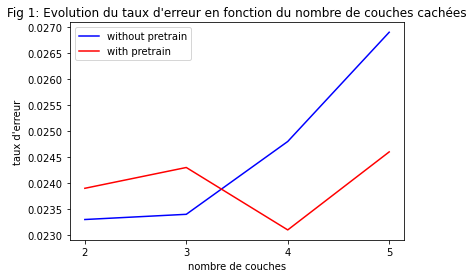

In [9]:
#visualisation
plt.ylabel("taux d'erreur")
plt.xlabel("nombre de couches")
plt.title("Fig 1: Evolution du taux d'erreur en fonction du nombre de couches cachées")
plt.plot(param_ncouches,scores_dnn,"-b",label="without pretrain")
plt.plot(param_ncouches,scores_dnn_pre,"-r",label="with pretrain")
plt.legend(loc="upper left")
plt.xticks(param_ncouches)
plt.show()


On observe que le dnn pré entrainé performe mieux sur des réseaux plus pforonds, concernant la perte de précision pour 5 couches je pense que c'est du à l'initialisation des poids qui n'était pas bonne, dans l'idéal il aurait fallu faire plusieurs simulations pour éviter ce problème.

\subsection{2. Etude de l'impact du nombre de neuronnes}

Dans cette deuxieme partie de l'étude nous fixons tous les paramètres, sauf le nombre de neuronnes par couches que nous faisons varier, et comparons le comportement des dnn en fonction du nombre du nombre de neuronnes choisi et du préentrainement ou non.

In [11]:
#paramètres

epoch_rbm = 100
epoch_retro_prop = 200
learning_rate = 0.05
mini_batch_size = 1000
n_couches = 2
param_neurones = [50,100,300,500,700]

dnn_list = []
dnn_pretrain_list = []
#initialisation des dnn que l'on va étudier 
for n_neurones in tqdm(param_neurones):

    #la première couche est de la taille des vecteurs d'entrée
    size = [len(data_train[0])]
    #ajout des couches intermédiaires
    size += [n_neurones]*(n_couches)
    #la dernière couche dépend des différentes catégories que l'ont souhaite prédire 
    size += [10]
    #initialisation du dnn
    dnn = Dnn(size)
    #initialisation indentique du dnn préentrainé
    dnn_pre_train = deepcopy(dnn)
    print("pretrain du dnn :")
    #pre entrainemnet
    dnn_pre_train.pretrain(data_train,epoch_rbm,learning_rate,mini_batch_size)

    dnn_list += [dnn]
    dnn_pretrain_list+= [dnn_pre_train]
    

  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:02<03:48,  2.31s/it]

erreur quadratique :  8918163



  2%|▏         | 2/100 [00:04<03:45,  2.31s/it]

erreur quadratique :  7622388



  3%|▎         | 3/100 [00:06<03:44,  2.31s/it]

erreur quadratique :  7015991



  4%|▍         | 4/100 [00:09<03:41,  2.31s/it]

erreur quadratique :  6639328



  5%|▌         | 5/100 [00:11<03:39,  2.31s/it]

erreur quadratique :  6368609



  6%|▌         | 6/100 [00:13<03:37,  2.31s/it]

erreur quadratique :  6156971



  7%|▋         | 7/100 [00:16<03:35,  2.32s/it]

erreur quadratique :  5975339



  8%|▊         | 8/100 [00:18<03:33,  2.32s/it]

erreur quadratique :  5821704



  9%|▉         | 9/100 [00:20<03:31,  2.32s/it]

erreur quadratique :  5698131



 10%|█         | 10/100 [00:23<03:28,  2.32s/it]

erreur quadratique :  5578814



 11%|█         | 11/100 [00:25<03:26,  2.32s/it]

erreur quadratique :  5481191



 12%|█▏        | 12/100 [00:27<03:24,  2.33s/it]

erreur quadratique :  5392349



 13%|█▎        | 13/100 [00:30<03:22,  2.33s/it]

erreur quadratique :  5314619



 14%|█▍        | 14/100 [00:32<03:20,  2.33s/it]

erreur quadratique :  5245326



 15%|█▌        | 15/100 [00:34<03:18,  2.33s/it]

erreur quadratique :  5178556



 16%|█▌        | 16/100 [00:37<03:15,  2.33s/it]

erreur quadratique :  5115573



 17%|█▋        | 17/100 [00:39<03:13,  2.33s/it]

erreur quadratique :  5065369



 18%|█▊        | 18/100 [00:41<03:11,  2.34s/it]

erreur quadratique :  5014275



 19%|█▉        | 19/100 [00:44<03:09,  2.34s/it]

erreur quadratique :  4969576



 20%|██        | 20/100 [00:46<03:07,  2.34s/it]

erreur quadratique :  4926941



 21%|██        | 21/100 [00:48<03:05,  2.35s/it]

erreur quadratique :  4875828



 22%|██▏       | 22/100 [00:51<03:02,  2.35s/it]

erreur quadratique :  4839611



 23%|██▎       | 23/100 [00:53<03:00,  2.35s/it]

erreur quadratique :  4802343



 24%|██▍       | 24/100 [00:55<02:58,  2.35s/it]

erreur quadratique :  4767135



 25%|██▌       | 25/100 [00:58<02:55,  2.35s/it]

erreur quadratique :  4732692



 26%|██▌       | 26/100 [01:00<02:53,  2.34s/it]

erreur quadratique :  4706109



 27%|██▋       | 27/100 [01:02<02:51,  2.34s/it]

erreur quadratique :  4676480



 28%|██▊       | 28/100 [01:05<02:48,  2.34s/it]

erreur quadratique :  4646164



 29%|██▉       | 29/100 [01:07<02:47,  2.36s/it]

erreur quadratique :  4620917



 30%|███       | 30/100 [01:10<02:45,  2.36s/it]

erreur quadratique :  4595263



 31%|███       | 31/100 [01:12<02:42,  2.36s/it]

erreur quadratique :  4571300



 32%|███▏      | 32/100 [01:14<02:40,  2.37s/it]

erreur quadratique :  4541485



 33%|███▎      | 33/100 [01:17<02:39,  2.38s/it]

erreur quadratique :  4523250



 34%|███▍      | 34/100 [01:19<02:37,  2.38s/it]

erreur quadratique :  4504680



 35%|███▌      | 35/100 [01:22<02:35,  2.39s/it]

erreur quadratique :  4484621



 36%|███▌      | 36/100 [01:24<02:32,  2.39s/it]

erreur quadratique :  4457361



 37%|███▋      | 37/100 [01:26<02:30,  2.39s/it]

erreur quadratique :  4443340



 38%|███▊      | 38/100 [01:29<02:28,  2.39s/it]

erreur quadratique :  4425922



 39%|███▉      | 39/100 [01:31<02:25,  2.39s/it]

erreur quadratique :  4407677



 40%|████      | 40/100 [01:34<02:26,  2.44s/it]

erreur quadratique :  4389951



 41%|████      | 41/100 [01:36<02:25,  2.46s/it]

erreur quadratique :  4376532



 42%|████▏     | 42/100 [01:39<02:22,  2.45s/it]

erreur quadratique :  4357246



 43%|████▎     | 43/100 [01:41<02:19,  2.45s/it]

erreur quadratique :  4343008



 44%|████▍     | 44/100 [01:43<02:16,  2.43s/it]

erreur quadratique :  4332565



 45%|████▌     | 45/100 [01:46<02:13,  2.42s/it]

erreur quadratique :  4314085



 46%|████▌     | 46/100 [01:48<02:10,  2.41s/it]

erreur quadratique :  4301855



 47%|████▋     | 47/100 [01:51<02:07,  2.41s/it]

erreur quadratique :  4284623



 48%|████▊     | 48/100 [01:53<02:04,  2.40s/it]

erreur quadratique :  4278263



 49%|████▉     | 49/100 [01:55<02:02,  2.40s/it]

erreur quadratique :  4261287



 50%|█████     | 50/100 [01:58<01:59,  2.40s/it]

erreur quadratique :  4250907



 51%|█████     | 51/100 [02:00<01:57,  2.40s/it]

erreur quadratique :  4236507



 52%|█████▏    | 52/100 [02:03<01:55,  2.40s/it]

erreur quadratique :  4224543



 53%|█████▎    | 53/100 [02:05<01:53,  2.41s/it]

erreur quadratique :  4213062



 54%|█████▍    | 54/100 [02:07<01:51,  2.42s/it]

erreur quadratique :  4206773



 55%|█████▌    | 55/100 [02:10<01:48,  2.41s/it]

erreur quadratique :  4191028



 56%|█████▌    | 56/100 [02:12<01:45,  2.41s/it]

erreur quadratique :  4184991



 57%|█████▋    | 57/100 [02:15<01:43,  2.41s/it]

erreur quadratique :  4174845



 58%|█████▊    | 58/100 [02:17<01:40,  2.40s/it]

erreur quadratique :  4163273



 59%|█████▉    | 59/100 [02:19<01:38,  2.41s/it]

erreur quadratique :  4152065



 60%|██████    | 60/100 [02:22<01:36,  2.41s/it]

erreur quadratique :  4144008



 61%|██████    | 61/100 [02:24<01:33,  2.41s/it]

erreur quadratique :  4133881



 62%|██████▏   | 62/100 [02:27<01:31,  2.40s/it]

erreur quadratique :  4126729



 63%|██████▎   | 63/100 [02:29<01:28,  2.40s/it]

erreur quadratique :  4119098



 64%|██████▍   | 64/100 [02:31<01:26,  2.40s/it]

erreur quadratique :  4109592



 65%|██████▌   | 65/100 [02:34<01:24,  2.40s/it]

erreur quadratique :  4103003



 66%|██████▌   | 66/100 [02:36<01:21,  2.40s/it]

erreur quadratique :  4094390



 67%|██████▋   | 67/100 [02:39<01:19,  2.40s/it]

erreur quadratique :  4088082



 68%|██████▊   | 68/100 [02:41<01:16,  2.40s/it]

erreur quadratique :  4079024



 69%|██████▉   | 69/100 [02:43<01:14,  2.41s/it]

erreur quadratique :  4073256



 70%|███████   | 70/100 [02:46<01:12,  2.41s/it]

erreur quadratique :  4065569



 71%|███████   | 71/100 [02:48<01:10,  2.41s/it]

erreur quadratique :  4056312



 72%|███████▏  | 72/100 [02:51<01:08,  2.43s/it]

erreur quadratique :  4049467



 73%|███████▎  | 73/100 [02:53<01:05,  2.43s/it]

erreur quadratique :  4045647



 74%|███████▍  | 74/100 [02:56<01:03,  2.44s/it]

erreur quadratique :  4038291



 75%|███████▌  | 75/100 [02:58<01:00,  2.43s/it]

erreur quadratique :  4031230



 76%|███████▌  | 76/100 [03:01<00:58,  2.42s/it]

erreur quadratique :  4026043



 77%|███████▋  | 77/100 [03:03<00:56,  2.44s/it]

erreur quadratique :  4017850



 78%|███████▊  | 78/100 [03:05<00:53,  2.43s/it]

erreur quadratique :  4009451



 79%|███████▉  | 79/100 [03:08<00:50,  2.42s/it]

erreur quadratique :  4001642



 80%|████████  | 80/100 [03:10<00:48,  2.42s/it]

erreur quadratique :  3996395



 81%|████████  | 81/100 [03:13<00:46,  2.42s/it]

erreur quadratique :  3994240



 82%|████████▏ | 82/100 [03:15<00:43,  2.42s/it]

erreur quadratique :  3986146



 83%|████████▎ | 83/100 [03:17<00:41,  2.42s/it]

erreur quadratique :  3982279



 84%|████████▍ | 84/100 [03:20<00:38,  2.42s/it]

erreur quadratique :  3977388



 85%|████████▌ | 85/100 [03:22<00:36,  2.42s/it]

erreur quadratique :  3969696



 86%|████████▌ | 86/100 [03:25<00:33,  2.42s/it]

erreur quadratique :  3967405



 87%|████████▋ | 87/100 [03:27<00:31,  2.42s/it]

erreur quadratique :  3958744



 88%|████████▊ | 88/100 [03:30<00:29,  2.42s/it]

erreur quadratique :  3954504



 89%|████████▉ | 89/100 [03:32<00:26,  2.42s/it]

erreur quadratique :  3949926



 90%|█████████ | 90/100 [03:35<00:24,  2.50s/it]

erreur quadratique :  3945128



 91%|█████████ | 91/100 [03:37<00:22,  2.48s/it]

erreur quadratique :  3938609



 92%|█████████▏| 92/100 [03:40<00:19,  2.46s/it]

erreur quadratique :  3936870



 93%|█████████▎| 93/100 [03:42<00:17,  2.44s/it]

erreur quadratique :  3932330



 94%|█████████▍| 94/100 [03:44<00:14,  2.41s/it]

erreur quadratique :  3927501



 95%|█████████▌| 95/100 [03:47<00:12,  2.41s/it]

erreur quadratique :  3920419



 96%|█████████▌| 96/100 [03:49<00:09,  2.39s/it]

erreur quadratique :  3919392



 97%|█████████▋| 97/100 [03:52<00:07,  2.47s/it]

erreur quadratique :  3914667



 98%|█████████▊| 98/100 [03:54<00:05,  2.52s/it]

erreur quadratique :  3910340



 99%|█████████▉| 99/100 [03:57<00:02,  2.49s/it]

erreur quadratique :  3907852



100%|██████████| 100/100 [03:59<00:00,  2.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

erreur quadratique :  3897847
train rbm  2



  1%|          | 1/100 [00:00<00:32,  3.02it/s]

erreur quadratique :  1255620



  2%|▏         | 2/100 [00:00<00:32,  3.04it/s]

erreur quadratique :  1176502



  3%|▎         | 3/100 [00:00<00:31,  3.04it/s]

erreur quadratique :  1066664



  4%|▍         | 4/100 [00:01<00:31,  3.06it/s]

erreur quadratique :  986115



  5%|▌         | 5/100 [00:01<00:30,  3.07it/s]

erreur quadratique :  929131



  6%|▌         | 6/100 [00:01<00:30,  3.07it/s]

erreur quadratique :  883332



  7%|▋         | 7/100 [00:02<00:30,  3.08it/s]

erreur quadratique :  848202



  8%|▊         | 8/100 [00:02<00:29,  3.08it/s]

erreur quadratique :  817777



  9%|▉         | 9/100 [00:02<00:29,  3.08it/s]

erreur quadratique :  794357



 10%|█         | 10/100 [00:03<00:29,  3.09it/s]

erreur quadratique :  770870



 11%|█         | 11/100 [00:03<00:28,  3.10it/s]

erreur quadratique :  753958



 12%|█▏        | 12/100 [00:03<00:28,  3.10it/s]

erreur quadratique :  735878



 13%|█▎        | 13/100 [00:04<00:28,  3.10it/s]

erreur quadratique :  721401



 14%|█▍        | 14/100 [00:04<00:27,  3.10it/s]

erreur quadratique :  710067



 15%|█▌        | 15/100 [00:04<00:27,  3.10it/s]

erreur quadratique :  697164



 16%|█▌        | 16/100 [00:05<00:27,  3.10it/s]

erreur quadratique :  686025



 17%|█▋        | 17/100 [00:05<00:26,  3.10it/s]

erreur quadratique :  674959



 18%|█▊        | 18/100 [00:05<00:26,  3.09it/s]

erreur quadratique :  664832



 19%|█▉        | 19/100 [00:06<00:26,  3.09it/s]

erreur quadratique :  655671



 20%|██        | 20/100 [00:06<00:25,  3.08it/s]

erreur quadratique :  647973



 21%|██        | 21/100 [00:06<00:25,  3.09it/s]

erreur quadratique :  639972



 22%|██▏       | 22/100 [00:07<00:25,  3.09it/s]

erreur quadratique :  631715



 23%|██▎       | 23/100 [00:07<00:24,  3.10it/s]

erreur quadratique :  623279



 24%|██▍       | 24/100 [00:07<00:24,  3.10it/s]

erreur quadratique :  616865



 25%|██▌       | 25/100 [00:08<00:24,  3.10it/s]

erreur quadratique :  609197



 26%|██▌       | 26/100 [00:08<00:23,  3.10it/s]

erreur quadratique :  604531



 27%|██▋       | 27/100 [00:08<00:23,  3.10it/s]

erreur quadratique :  597734



 28%|██▊       | 28/100 [00:09<00:23,  3.09it/s]

erreur quadratique :  591960



 29%|██▉       | 29/100 [00:09<00:22,  3.10it/s]

erreur quadratique :  586209



 30%|███       | 30/100 [00:09<00:22,  3.08it/s]

erreur quadratique :  581042



 31%|███       | 31/100 [00:10<00:22,  3.09it/s]

erreur quadratique :  573882



 32%|███▏      | 32/100 [00:10<00:22,  3.08it/s]

erreur quadratique :  570103



 33%|███▎      | 33/100 [00:10<00:21,  3.08it/s]

erreur quadratique :  564753



 34%|███▍      | 34/100 [00:11<00:21,  3.08it/s]

erreur quadratique :  559975



 35%|███▌      | 35/100 [00:11<00:21,  3.09it/s]

erreur quadratique :  556664



 36%|███▌      | 36/100 [00:11<00:20,  3.09it/s]

erreur quadratique :  552783



 37%|███▋      | 37/100 [00:11<00:20,  3.05it/s]

erreur quadratique :  548251



 38%|███▊      | 38/100 [00:12<00:20,  3.06it/s]

erreur quadratique :  543404



 39%|███▉      | 39/100 [00:12<00:20,  3.01it/s]

erreur quadratique :  539214



 40%|████      | 40/100 [00:12<00:19,  3.05it/s]

erreur quadratique :  536048



 41%|████      | 41/100 [00:13<00:19,  3.06it/s]

erreur quadratique :  532112



 42%|████▏     | 42/100 [00:13<00:18,  3.07it/s]

erreur quadratique :  527777



 43%|████▎     | 43/100 [00:13<00:18,  3.07it/s]

erreur quadratique :  524918



 44%|████▍     | 44/100 [00:14<00:18,  3.08it/s]

erreur quadratique :  521974



 45%|████▌     | 45/100 [00:14<00:17,  3.09it/s]

erreur quadratique :  518368



 46%|████▌     | 46/100 [00:14<00:17,  3.09it/s]

erreur quadratique :  515031



 47%|████▋     | 47/100 [00:15<00:17,  3.09it/s]

erreur quadratique :  512609



 48%|████▊     | 48/100 [00:15<00:16,  3.08it/s]

erreur quadratique :  509554



 49%|████▉     | 49/100 [00:15<00:16,  3.04it/s]

erreur quadratique :  507217



 50%|█████     | 50/100 [00:16<00:16,  3.01it/s]

erreur quadratique :  502855



 51%|█████     | 51/100 [00:16<00:16,  3.03it/s]

erreur quadratique :  500320



 52%|█████▏    | 52/100 [00:16<00:15,  3.05it/s]

erreur quadratique :  497824



 53%|█████▎    | 53/100 [00:17<00:15,  3.06it/s]

erreur quadratique :  495765



 54%|█████▍    | 54/100 [00:17<00:14,  3.07it/s]

erreur quadratique :  492550



 55%|█████▌    | 55/100 [00:17<00:14,  3.07it/s]

erreur quadratique :  490562



 56%|█████▌    | 56/100 [00:18<00:14,  3.08it/s]

erreur quadratique :  488387



 57%|█████▋    | 57/100 [00:18<00:14,  3.05it/s]

erreur quadratique :  485171



 58%|█████▊    | 58/100 [00:18<00:13,  3.06it/s]

erreur quadratique :  483564



 59%|█████▉    | 59/100 [00:19<00:13,  3.08it/s]

erreur quadratique :  481785



 60%|██████    | 60/100 [00:19<00:12,  3.08it/s]

erreur quadratique :  479371



 61%|██████    | 61/100 [00:19<00:12,  3.09it/s]

erreur quadratique :  476549



 62%|██████▏   | 62/100 [00:20<00:12,  3.10it/s]

erreur quadratique :  475298



 63%|██████▎   | 63/100 [00:20<00:12,  3.08it/s]

erreur quadratique :  473211



 64%|██████▍   | 64/100 [00:20<00:11,  3.10it/s]

erreur quadratique :  471202



 65%|██████▌   | 65/100 [00:21<00:11,  3.10it/s]

erreur quadratique :  469630



 66%|██████▌   | 66/100 [00:21<00:10,  3.10it/s]

erreur quadratique :  467549



 67%|██████▋   | 67/100 [00:21<00:10,  3.10it/s]

erreur quadratique :  465209



 68%|██████▊   | 68/100 [00:22<00:10,  3.10it/s]

erreur quadratique :  463446



 69%|██████▉   | 69/100 [00:22<00:10,  3.10it/s]

erreur quadratique :  462278



 70%|███████   | 70/100 [00:22<00:09,  3.10it/s]

erreur quadratique :  460613



 71%|███████   | 71/100 [00:23<00:09,  3.09it/s]

erreur quadratique :  458462



 72%|███████▏  | 72/100 [00:23<00:09,  3.09it/s]

erreur quadratique :  456595



 73%|███████▎  | 73/100 [00:23<00:08,  3.09it/s]

erreur quadratique :  455130



 74%|███████▍  | 74/100 [00:24<00:08,  3.10it/s]

erreur quadratique :  452874



 75%|███████▌  | 75/100 [00:24<00:08,  3.10it/s]

erreur quadratique :  452453



 76%|███████▌  | 76/100 [00:24<00:07,  3.10it/s]

erreur quadratique :  449995



 77%|███████▋  | 77/100 [00:24<00:07,  3.09it/s]

erreur quadratique :  449059



 78%|███████▊  | 78/100 [00:25<00:07,  3.08it/s]

erreur quadratique :  447079



 79%|███████▉  | 79/100 [00:25<00:06,  3.08it/s]

erreur quadratique :  445976



 80%|████████  | 80/100 [00:25<00:06,  3.08it/s]

erreur quadratique :  444300



 81%|████████  | 81/100 [00:26<00:06,  3.08it/s]

erreur quadratique :  442582



 82%|████████▏ | 82/100 [00:26<00:05,  3.08it/s]

erreur quadratique :  441889



 83%|████████▎ | 83/100 [00:26<00:05,  3.09it/s]

erreur quadratique :  439723



 84%|████████▍ | 84/100 [00:27<00:05,  3.09it/s]

erreur quadratique :  438757



 85%|████████▌ | 85/100 [00:27<00:04,  3.09it/s]

erreur quadratique :  438465



 86%|████████▌ | 86/100 [00:27<00:04,  3.08it/s]

erreur quadratique :  435137



 87%|████████▋ | 87/100 [00:28<00:04,  3.08it/s]

erreur quadratique :  434537



 88%|████████▊ | 88/100 [00:28<00:03,  3.09it/s]

erreur quadratique :  433405



 89%|████████▉ | 89/100 [00:28<00:03,  3.09it/s]

erreur quadratique :  431166



 90%|█████████ | 90/100 [00:29<00:03,  3.09it/s]

erreur quadratique :  431271



 91%|█████████ | 91/100 [00:29<00:02,  3.09it/s]

erreur quadratique :  430056



 92%|█████████▏| 92/100 [00:29<00:02,  3.08it/s]

erreur quadratique :  428995



 93%|█████████▎| 93/100 [00:30<00:02,  3.09it/s]

erreur quadratique :  427510



 94%|█████████▍| 94/100 [00:30<00:01,  3.10it/s]

erreur quadratique :  426663



 95%|█████████▌| 95/100 [00:30<00:01,  3.10it/s]

erreur quadratique :  424098



 96%|█████████▌| 96/100 [00:31<00:01,  3.10it/s]

erreur quadratique :  423139



 97%|█████████▋| 97/100 [00:31<00:00,  3.09it/s]

erreur quadratique :  423923



 98%|█████████▊| 98/100 [00:31<00:00,  3.10it/s]

erreur quadratique :  421537



 99%|█████████▉| 99/100 [00:32<00:00,  3.10it/s]

erreur quadratique :  420715



  0%|          | 0/100 [00:00<?, ?it/s]

erreur quadratique :  420217
pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:02<04:30,  2.74s/it]

erreur quadratique :  7603943



  2%|▏         | 2/100 [00:05<04:27,  2.73s/it]

erreur quadratique :  6499000



  3%|▎         | 3/100 [00:08<04:22,  2.70s/it]

erreur quadratique :  5958872



  4%|▍         | 4/100 [00:10<04:17,  2.68s/it]

erreur quadratique :  5618687



  5%|▌         | 5/100 [00:13<04:13,  2.67s/it]

erreur quadratique :  5360657



  6%|▌         | 6/100 [00:16<04:10,  2.66s/it]

erreur quadratique :  5160077



  7%|▋         | 7/100 [00:18<04:07,  2.66s/it]

erreur quadratique :  5000536



  8%|▊         | 8/100 [00:21<04:05,  2.66s/it]

erreur quadratique :  4862668



  9%|▉         | 9/100 [00:23<04:02,  2.66s/it]

erreur quadratique :  4743819



 10%|█         | 10/100 [00:26<03:59,  2.66s/it]

erreur quadratique :  4636646



 11%|█         | 11/100 [00:29<03:56,  2.66s/it]

erreur quadratique :  4553233



 12%|█▏        | 12/100 [00:31<03:54,  2.66s/it]

erreur quadratique :  4470210



 13%|█▎        | 13/100 [00:34<03:51,  2.66s/it]

erreur quadratique :  4391618



 14%|█▍        | 14/100 [00:37<03:48,  2.66s/it]

erreur quadratique :  4323541



 15%|█▌        | 15/100 [00:39<03:46,  2.66s/it]

erreur quadratique :  4260210



 16%|█▌        | 16/100 [00:42<03:43,  2.66s/it]

erreur quadratique :  4199653



 17%|█▋        | 17/100 [00:45<03:41,  2.67s/it]

erreur quadratique :  4152417



 18%|█▊        | 18/100 [00:47<03:39,  2.68s/it]

erreur quadratique :  4100790



 19%|█▉        | 19/100 [00:50<03:37,  2.68s/it]

erreur quadratique :  4054132



 20%|██        | 20/100 [00:53<03:35,  2.69s/it]

erreur quadratique :  4015153



 21%|██        | 21/100 [00:56<03:33,  2.70s/it]

erreur quadratique :  3974204



 22%|██▏       | 22/100 [00:58<03:29,  2.69s/it]

erreur quadratique :  3936250



 23%|██▎       | 23/100 [01:01<03:33,  2.77s/it]

erreur quadratique :  3903196



 24%|██▍       | 24/100 [01:04<03:34,  2.82s/it]

erreur quadratique :  3870876



 25%|██▌       | 25/100 [01:07<03:29,  2.79s/it]

erreur quadratique :  3841892



 26%|██▌       | 26/100 [01:10<03:25,  2.78s/it]

erreur quadratique :  3810894



 27%|██▋       | 27/100 [01:12<03:22,  2.77s/it]

erreur quadratique :  3785267



 28%|██▊       | 28/100 [01:15<03:18,  2.76s/it]

erreur quadratique :  3757230



 29%|██▉       | 29/100 [01:18<03:15,  2.75s/it]

erreur quadratique :  3728867



 30%|███       | 30/100 [01:21<03:12,  2.75s/it]

erreur quadratique :  3704046



 31%|███       | 31/100 [01:23<03:09,  2.75s/it]

erreur quadratique :  3682703



 32%|███▏      | 32/100 [01:26<03:06,  2.74s/it]

erreur quadratique :  3660378



 33%|███▎      | 33/100 [01:29<03:03,  2.74s/it]

erreur quadratique :  3637152



 34%|███▍      | 34/100 [01:32<03:00,  2.74s/it]

erreur quadratique :  3618103



 35%|███▌      | 35/100 [01:34<02:58,  2.74s/it]

erreur quadratique :  3597529



 36%|███▌      | 36/100 [01:37<02:55,  2.74s/it]

erreur quadratique :  3578892



 37%|███▋      | 37/100 [01:40<02:52,  2.74s/it]

erreur quadratique :  3564048



 38%|███▊      | 38/100 [01:43<02:49,  2.74s/it]

erreur quadratique :  3542373



 39%|███▉      | 39/100 [01:45<02:46,  2.73s/it]

erreur quadratique :  3528955



 40%|████      | 40/100 [01:48<02:43,  2.73s/it]

erreur quadratique :  3507785



 41%|████      | 41/100 [01:51<02:40,  2.72s/it]

erreur quadratique :  3492413



 42%|████▏     | 42/100 [01:53<02:37,  2.72s/it]

erreur quadratique :  3480133



 43%|████▎     | 43/100 [01:56<02:34,  2.72s/it]

erreur quadratique :  3464756



 44%|████▍     | 44/100 [01:59<02:32,  2.72s/it]

erreur quadratique :  3450982



 45%|████▌     | 45/100 [02:02<02:29,  2.71s/it]

erreur quadratique :  3434834



 46%|████▌     | 46/100 [02:04<02:26,  2.71s/it]

erreur quadratique :  3422294



 47%|████▋     | 47/100 [02:07<02:23,  2.71s/it]

erreur quadratique :  3409319



 48%|████▊     | 48/100 [02:10<02:21,  2.71s/it]

erreur quadratique :  3394912



 49%|████▉     | 49/100 [02:12<02:19,  2.73s/it]

erreur quadratique :  3384630



 50%|█████     | 50/100 [02:15<02:17,  2.74s/it]

erreur quadratique :  3369824



 51%|█████     | 51/100 [02:18<02:14,  2.74s/it]

erreur quadratique :  3361742



 52%|█████▏    | 52/100 [02:21<02:11,  2.74s/it]

erreur quadratique :  3348670



 53%|█████▎    | 53/100 [02:23<02:09,  2.75s/it]

erreur quadratique :  3336658



 54%|█████▍    | 54/100 [02:26<02:06,  2.75s/it]

erreur quadratique :  3326134



 55%|█████▌    | 55/100 [02:29<02:03,  2.75s/it]

erreur quadratique :  3317684



 56%|█████▌    | 56/100 [02:32<02:01,  2.75s/it]

erreur quadratique :  3307328



 57%|█████▋    | 57/100 [02:34<01:58,  2.75s/it]

erreur quadratique :  3293395



 58%|█████▊    | 58/100 [02:37<01:55,  2.75s/it]

erreur quadratique :  3287320



 59%|█████▉    | 59/100 [02:40<01:52,  2.75s/it]

erreur quadratique :  3275564



 60%|██████    | 60/100 [02:43<01:50,  2.75s/it]

erreur quadratique :  3266859



 61%|██████    | 61/100 [02:45<01:47,  2.75s/it]

erreur quadratique :  3258168



 62%|██████▏   | 62/100 [02:48<01:44,  2.75s/it]

erreur quadratique :  3250209



 63%|██████▎   | 63/100 [02:51<01:41,  2.75s/it]

erreur quadratique :  3238837



 64%|██████▍   | 64/100 [02:54<01:39,  2.75s/it]

erreur quadratique :  3229298



 65%|██████▌   | 65/100 [02:56<01:36,  2.75s/it]

erreur quadratique :  3220805



 66%|██████▌   | 66/100 [02:59<01:33,  2.75s/it]

erreur quadratique :  3215835



 67%|██████▋   | 67/100 [03:02<01:33,  2.83s/it]

erreur quadratique :  3204364



 68%|██████▊   | 68/100 [03:05<01:30,  2.83s/it]

erreur quadratique :  3192602



 69%|██████▉   | 69/100 [03:08<01:27,  2.81s/it]

erreur quadratique :  3187277



 70%|███████   | 70/100 [03:11<01:23,  2.80s/it]

erreur quadratique :  3178593



 71%|███████   | 71/100 [03:13<01:20,  2.79s/it]

erreur quadratique :  3175849



 72%|███████▏  | 72/100 [03:16<01:17,  2.78s/it]

erreur quadratique :  3165763



 73%|███████▎  | 73/100 [03:19<01:14,  2.77s/it]

erreur quadratique :  3159181



 74%|███████▍  | 74/100 [03:22<01:11,  2.76s/it]

erreur quadratique :  3149513



 75%|███████▌  | 75/100 [03:24<01:09,  2.76s/it]

erreur quadratique :  3145400



 76%|███████▌  | 76/100 [03:27<01:06,  2.76s/it]

erreur quadratique :  3137965



 77%|███████▋  | 77/100 [03:30<01:03,  2.76s/it]

erreur quadratique :  3133003



 78%|███████▊  | 78/100 [03:33<01:00,  2.76s/it]

erreur quadratique :  3124455



 79%|███████▉  | 79/100 [03:35<00:57,  2.76s/it]

erreur quadratique :  3117964



 80%|████████  | 80/100 [03:38<00:55,  2.75s/it]

erreur quadratique :  3112372



 81%|████████  | 81/100 [03:41<00:52,  2.75s/it]

erreur quadratique :  3106897



 82%|████████▏ | 82/100 [03:44<00:49,  2.75s/it]

erreur quadratique :  3099293



 83%|████████▎ | 83/100 [03:46<00:46,  2.76s/it]

erreur quadratique :  3094291



 84%|████████▍ | 84/100 [03:49<00:44,  2.75s/it]

erreur quadratique :  3088933



 85%|████████▌ | 85/100 [03:52<00:41,  2.75s/it]

erreur quadratique :  3081209



 86%|████████▌ | 86/100 [03:55<00:38,  2.75s/it]

erreur quadratique :  3074714



 87%|████████▋ | 87/100 [03:57<00:35,  2.75s/it]

erreur quadratique :  3072537



 88%|████████▊ | 88/100 [04:00<00:33,  2.76s/it]

erreur quadratique :  3065366



 89%|████████▉ | 89/100 [04:03<00:30,  2.75s/it]

erreur quadratique :  3057543



 90%|█████████ | 90/100 [04:06<00:27,  2.75s/it]

erreur quadratique :  3054252



 91%|█████████ | 91/100 [04:08<00:24,  2.75s/it]

erreur quadratique :  3044210



 92%|█████████▏| 92/100 [04:11<00:21,  2.75s/it]

erreur quadratique :  3043934



 93%|█████████▎| 93/100 [04:14<00:19,  2.75s/it]

erreur quadratique :  3040329



 94%|█████████▍| 94/100 [04:17<00:16,  2.75s/it]

erreur quadratique :  3031390



 95%|█████████▌| 95/100 [04:19<00:13,  2.75s/it]

erreur quadratique :  3029802



 96%|█████████▌| 96/100 [04:22<00:11,  2.75s/it]

erreur quadratique :  3027598



 97%|█████████▋| 97/100 [04:25<00:08,  2.83s/it]

erreur quadratique :  3020898



 98%|█████████▊| 98/100 [04:28<00:05,  2.93s/it]

erreur quadratique :  3013848



 99%|█████████▉| 99/100 [04:31<00:02,  2.99s/it]

erreur quadratique :  3009817



100%|██████████| 100/100 [04:35<00:00,  2.75s/it]

erreur quadratique :  3009473




  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2



  1%|          | 1/100 [00:00<01:02,  1.58it/s]

erreur quadratique :  2288240



  2%|▏         | 2/100 [00:01<01:02,  1.56it/s]

erreur quadratique :  1967794



  3%|▎         | 3/100 [00:01<01:03,  1.52it/s]

erreur quadratique :  1781752



  4%|▍         | 4/100 [00:02<01:02,  1.54it/s]

erreur quadratique :  1660027



  5%|▌         | 5/100 [00:03<01:01,  1.54it/s]

erreur quadratique :  1574787



  6%|▌         | 6/100 [00:03<01:00,  1.55it/s]

erreur quadratique :  1507783



  7%|▋         | 7/100 [00:04<00:59,  1.56it/s]

erreur quadratique :  1454812



  8%|▊         | 8/100 [00:05<00:59,  1.55it/s]

erreur quadratique :  1406653



  9%|▉         | 9/100 [00:05<00:59,  1.52it/s]

erreur quadratique :  1369727



 10%|█         | 10/100 [00:06<00:59,  1.51it/s]

erreur quadratique :  1334838



 11%|█         | 11/100 [00:07<01:00,  1.47it/s]

erreur quadratique :  1302050



 12%|█▏        | 12/100 [00:07<01:00,  1.46it/s]

erreur quadratique :  1273212



 13%|█▎        | 13/100 [00:08<00:58,  1.49it/s]

erreur quadratique :  1247303



 14%|█▍        | 14/100 [00:09<00:58,  1.46it/s]

erreur quadratique :  1224174



 15%|█▌        | 15/100 [00:10<01:00,  1.41it/s]

erreur quadratique :  1200313



 16%|█▌        | 16/100 [00:10<01:00,  1.38it/s]

erreur quadratique :  1180267



 17%|█▋        | 17/100 [00:11<01:00,  1.38it/s]

erreur quadratique :  1162272



 18%|█▊        | 18/100 [00:12<01:00,  1.37it/s]

erreur quadratique :  1144169



 19%|█▉        | 19/100 [00:13<00:58,  1.37it/s]

erreur quadratique :  1126257



 20%|██        | 20/100 [00:13<00:57,  1.38it/s]

erreur quadratique :  1112173



 21%|██        | 21/100 [00:14<00:55,  1.42it/s]

erreur quadratique :  1098048



 22%|██▏       | 22/100 [00:15<00:53,  1.46it/s]

erreur quadratique :  1084946



 23%|██▎       | 23/100 [00:15<00:51,  1.49it/s]

erreur quadratique :  1071204



 24%|██▍       | 24/100 [00:16<00:52,  1.46it/s]

erreur quadratique :  1060870



 25%|██▌       | 25/100 [00:17<00:50,  1.49it/s]

erreur quadratique :  1047723



 26%|██▌       | 26/100 [00:17<00:48,  1.52it/s]

erreur quadratique :  1037929



 27%|██▋       | 27/100 [00:18<00:47,  1.54it/s]

erreur quadratique :  1025203



 28%|██▊       | 28/100 [00:18<00:46,  1.55it/s]

erreur quadratique :  1014365



 29%|██▉       | 29/100 [00:19<00:45,  1.56it/s]

erreur quadratique :  1006739



 30%|███       | 30/100 [00:20<00:44,  1.57it/s]

erreur quadratique :  997746



 31%|███       | 31/100 [00:20<00:43,  1.57it/s]

erreur quadratique :  991053



 32%|███▏      | 32/100 [00:21<00:43,  1.58it/s]

erreur quadratique :  981721



 33%|███▎      | 33/100 [00:22<00:42,  1.58it/s]

erreur quadratique :  974337



 34%|███▍      | 34/100 [00:22<00:41,  1.58it/s]

erreur quadratique :  965596



 35%|███▌      | 35/100 [00:23<00:41,  1.58it/s]

erreur quadratique :  957635



 36%|███▌      | 36/100 [00:23<00:40,  1.58it/s]

erreur quadratique :  951307



 37%|███▋      | 37/100 [00:24<00:39,  1.59it/s]

erreur quadratique :  944512



 38%|███▊      | 38/100 [00:25<00:39,  1.55it/s]

erreur quadratique :  936956



 39%|███▉      | 39/100 [00:25<00:39,  1.54it/s]

erreur quadratique :  929984



 40%|████      | 40/100 [00:26<00:39,  1.53it/s]

erreur quadratique :  925217



 41%|████      | 41/100 [00:27<00:38,  1.52it/s]

erreur quadratique :  920819



 42%|████▏     | 42/100 [00:27<00:38,  1.51it/s]

erreur quadratique :  915222



 43%|████▎     | 43/100 [00:28<00:37,  1.53it/s]

erreur quadratique :  907592



 44%|████▍     | 44/100 [00:29<00:36,  1.55it/s]

erreur quadratique :  904122



 45%|████▌     | 45/100 [00:29<00:35,  1.55it/s]

erreur quadratique :  898031



 46%|████▌     | 46/100 [00:30<00:34,  1.56it/s]

erreur quadratique :  892546



 47%|████▋     | 47/100 [00:31<00:33,  1.56it/s]

erreur quadratique :  889769



 48%|████▊     | 48/100 [00:31<00:33,  1.57it/s]

erreur quadratique :  885596



 49%|████▉     | 49/100 [00:32<00:32,  1.58it/s]

erreur quadratique :  879991



 50%|█████     | 50/100 [00:33<00:31,  1.58it/s]

erreur quadratique :  873374



 51%|█████     | 51/100 [00:33<00:30,  1.58it/s]

erreur quadratique :  872694



 52%|█████▏    | 52/100 [00:34<00:30,  1.58it/s]

erreur quadratique :  866019



 53%|█████▎    | 53/100 [00:34<00:29,  1.59it/s]

erreur quadratique :  863197



 54%|█████▍    | 54/100 [00:35<00:28,  1.59it/s]

erreur quadratique :  858902



 55%|█████▌    | 55/100 [00:36<00:28,  1.59it/s]

erreur quadratique :  854186



 56%|█████▌    | 56/100 [00:36<00:27,  1.59it/s]

erreur quadratique :  851152



 57%|█████▋    | 57/100 [00:37<00:27,  1.59it/s]

erreur quadratique :  848073



 58%|█████▊    | 58/100 [00:38<00:26,  1.59it/s]

erreur quadratique :  843386



 59%|█████▉    | 59/100 [00:38<00:25,  1.59it/s]

erreur quadratique :  842389



 60%|██████    | 60/100 [00:39<00:25,  1.59it/s]

erreur quadratique :  836973



 61%|██████    | 61/100 [00:39<00:24,  1.59it/s]

erreur quadratique :  834972



 62%|██████▏   | 62/100 [00:40<00:23,  1.59it/s]

erreur quadratique :  831878



 63%|██████▎   | 63/100 [00:41<00:23,  1.59it/s]

erreur quadratique :  828188



 64%|██████▍   | 64/100 [00:41<00:22,  1.59it/s]

erreur quadratique :  824595



 65%|██████▌   | 65/100 [00:42<00:22,  1.59it/s]

erreur quadratique :  820653



 66%|██████▌   | 66/100 [00:43<00:21,  1.59it/s]

erreur quadratique :  819612



 67%|██████▋   | 67/100 [00:43<00:20,  1.59it/s]

erreur quadratique :  816317



 68%|██████▊   | 68/100 [00:44<00:20,  1.59it/s]

erreur quadratique :  813776



 69%|██████▉   | 69/100 [00:44<00:19,  1.59it/s]

erreur quadratique :  810922



 70%|███████   | 70/100 [00:45<00:18,  1.59it/s]

erreur quadratique :  809403



 71%|███████   | 71/100 [00:46<00:18,  1.59it/s]

erreur quadratique :  806097



 72%|███████▏  | 72/100 [00:46<00:17,  1.59it/s]

erreur quadratique :  804210



 73%|███████▎  | 73/100 [00:47<00:16,  1.59it/s]

erreur quadratique :  800671



 74%|███████▍  | 74/100 [00:48<00:16,  1.59it/s]

erreur quadratique :  798252



 75%|███████▌  | 75/100 [00:48<00:15,  1.59it/s]

erreur quadratique :  796395



 76%|███████▌  | 76/100 [00:49<00:15,  1.60it/s]

erreur quadratique :  793324



 77%|███████▋  | 77/100 [00:49<00:14,  1.59it/s]

erreur quadratique :  790596



 78%|███████▊  | 78/100 [00:50<00:13,  1.59it/s]

erreur quadratique :  788043



 79%|███████▉  | 79/100 [00:51<00:13,  1.59it/s]

erreur quadratique :  785261



 80%|████████  | 80/100 [00:51<00:12,  1.59it/s]

erreur quadratique :  783658



 81%|████████  | 81/100 [00:52<00:11,  1.59it/s]

erreur quadratique :  781584



 82%|████████▏ | 82/100 [00:53<00:11,  1.59it/s]

erreur quadratique :  780069



 83%|████████▎ | 83/100 [00:53<00:11,  1.52it/s]

erreur quadratique :  777211



 84%|████████▍ | 84/100 [00:54<00:11,  1.43it/s]

erreur quadratique :  775479



 85%|████████▌ | 85/100 [00:55<00:10,  1.44it/s]

erreur quadratique :  772566



 86%|████████▌ | 86/100 [00:56<00:10,  1.36it/s]

erreur quadratique :  772629



 87%|████████▋ | 87/100 [00:56<00:09,  1.32it/s]

erreur quadratique :  769642



 88%|████████▊ | 88/100 [00:57<00:09,  1.32it/s]

erreur quadratique :  768576



 89%|████████▉ | 89/100 [00:58<00:08,  1.31it/s]

erreur quadratique :  766595



 90%|█████████ | 90/100 [00:59<00:07,  1.34it/s]

erreur quadratique :  763322



 91%|█████████ | 91/100 [00:59<00:06,  1.33it/s]

erreur quadratique :  761876



 92%|█████████▏| 92/100 [01:00<00:05,  1.35it/s]

erreur quadratique :  760261



 93%|█████████▎| 93/100 [01:01<00:05,  1.33it/s]

erreur quadratique :  757860



 94%|█████████▍| 94/100 [01:02<00:04,  1.38it/s]

erreur quadratique :  756122



 95%|█████████▌| 95/100 [01:02<00:03,  1.44it/s]

erreur quadratique :  755545



 96%|█████████▌| 96/100 [01:03<00:02,  1.48it/s]

erreur quadratique :  753718



 97%|█████████▋| 97/100 [01:04<00:01,  1.51it/s]

erreur quadratique :  751577



 98%|█████████▊| 98/100 [01:04<00:01,  1.53it/s]

erreur quadratique :  749493



 99%|█████████▉| 99/100 [01:05<00:00,  1.55it/s]

erreur quadratique :  747801



 40%|████      | 2/5 [10:14<14:39, 293.19s/it]

erreur quadratique :  746225
pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:03<06:29,  3.93s/it]

erreur quadratique :  5744686



  2%|▏         | 2/100 [00:08<06:32,  4.01s/it]

erreur quadratique :  4907422



  3%|▎         | 3/100 [00:12<06:41,  4.14s/it]

erreur quadratique :  4469128



  4%|▍         | 4/100 [00:17<06:49,  4.27s/it]

erreur quadratique :  4177103



  5%|▌         | 5/100 [00:21<06:46,  4.28s/it]

erreur quadratique :  3951191



  6%|▌         | 6/100 [00:25<06:32,  4.18s/it]

erreur quadratique :  3789264



  7%|▋         | 7/100 [00:29<06:19,  4.08s/it]

erreur quadratique :  3648625



  8%|▊         | 8/100 [00:33<06:08,  4.00s/it]

erreur quadratique :  3541362



  9%|▉         | 9/100 [00:36<05:59,  3.95s/it]

erreur quadratique :  3437451



 10%|█         | 10/100 [00:40<05:52,  3.92s/it]

erreur quadratique :  3352202



 11%|█         | 11/100 [00:44<05:46,  3.90s/it]

erreur quadratique :  3280506



 12%|█▏        | 12/100 [00:48<05:41,  3.88s/it]

erreur quadratique :  3215601



 13%|█▎        | 13/100 [00:52<05:36,  3.87s/it]

erreur quadratique :  3154256



 14%|█▍        | 14/100 [00:56<05:33,  3.88s/it]

erreur quadratique :  3098064



 15%|█▌        | 15/100 [00:59<05:28,  3.86s/it]

erreur quadratique :  3051186



 16%|█▌        | 16/100 [01:03<05:23,  3.85s/it]

erreur quadratique :  3002603



 17%|█▋        | 17/100 [01:07<05:21,  3.87s/it]

erreur quadratique :  2964908



 18%|█▊        | 18/100 [01:11<05:17,  3.87s/it]

erreur quadratique :  2920909



 19%|█▉        | 19/100 [01:15<05:13,  3.87s/it]

erreur quadratique :  2888792



 20%|██        | 20/100 [01:19<05:12,  3.90s/it]

erreur quadratique :  2849977



 21%|██        | 21/100 [01:23<05:17,  4.02s/it]

erreur quadratique :  2824796



 22%|██▏       | 22/100 [01:27<05:10,  3.98s/it]

erreur quadratique :  2790588



 23%|██▎       | 23/100 [01:31<05:03,  3.94s/it]

erreur quadratique :  2765190



 24%|██▍       | 24/100 [01:35<04:57,  3.92s/it]

erreur quadratique :  2733996



 25%|██▌       | 25/100 [01:39<04:52,  3.90s/it]

erreur quadratique :  2710633



 26%|██▌       | 26/100 [01:43<04:48,  3.89s/it]

erreur quadratique :  2688331



 27%|██▋       | 27/100 [01:46<04:43,  3.89s/it]

erreur quadratique :  2665465



 28%|██▊       | 28/100 [01:50<04:40,  3.89s/it]

erreur quadratique :  2642500



 29%|██▉       | 29/100 [01:54<04:36,  3.90s/it]

erreur quadratique :  2621856



 30%|███       | 30/100 [01:58<04:32,  3.89s/it]

erreur quadratique :  2601352



 31%|███       | 31/100 [02:02<04:28,  3.89s/it]

erreur quadratique :  2584697



 32%|███▏      | 32/100 [02:06<04:23,  3.88s/it]

erreur quadratique :  2567999



 33%|███▎      | 33/100 [02:10<04:19,  3.88s/it]

erreur quadratique :  2546739



 34%|███▍      | 34/100 [02:14<04:16,  3.89s/it]

erreur quadratique :  2528200



 35%|███▌      | 35/100 [02:18<04:13,  3.90s/it]

erreur quadratique :  2511339



 36%|███▌      | 36/100 [02:21<04:09,  3.90s/it]

erreur quadratique :  2497095



 37%|███▋      | 37/100 [02:25<04:05,  3.90s/it]

erreur quadratique :  2482995



 38%|███▊      | 38/100 [02:29<04:01,  3.90s/it]

erreur quadratique :  2466601



 39%|███▉      | 39/100 [02:33<03:57,  3.90s/it]

erreur quadratique :  2449259



 40%|████      | 40/100 [02:37<03:53,  3.89s/it]

erreur quadratique :  2437579



 41%|████      | 41/100 [02:41<03:49,  3.88s/it]

erreur quadratique :  2427799



 42%|████▏     | 42/100 [02:45<03:44,  3.88s/it]

erreur quadratique :  2413338



 43%|████▎     | 43/100 [02:49<03:40,  3.88s/it]

erreur quadratique :  2397401



 44%|████▍     | 44/100 [02:53<03:37,  3.88s/it]

erreur quadratique :  2387423



 45%|████▌     | 45/100 [02:56<03:33,  3.88s/it]

erreur quadratique :  2375000



 46%|████▌     | 46/100 [03:00<03:29,  3.87s/it]

erreur quadratique :  2365056



 47%|████▋     | 47/100 [03:04<03:25,  3.87s/it]

erreur quadratique :  2354694



 48%|████▊     | 48/100 [03:08<03:21,  3.87s/it]

erreur quadratique :  2340737



 49%|████▉     | 49/100 [03:12<03:17,  3.88s/it]

erreur quadratique :  2328756



 50%|█████     | 50/100 [03:16<03:13,  3.87s/it]

erreur quadratique :  2320500



 51%|█████     | 51/100 [03:20<03:13,  3.94s/it]

erreur quadratique :  2311460



 52%|█████▏    | 52/100 [03:24<03:11,  3.98s/it]

erreur quadratique :  2298771



 53%|█████▎    | 53/100 [03:28<03:05,  3.96s/it]

erreur quadratique :  2290495



 54%|█████▍    | 54/100 [03:32<03:01,  3.94s/it]

erreur quadratique :  2282280



 55%|█████▌    | 55/100 [03:36<02:56,  3.93s/it]

erreur quadratique :  2271882



 56%|█████▌    | 56/100 [03:40<02:52,  3.92s/it]

erreur quadratique :  2261170



 57%|█████▋    | 57/100 [03:43<02:48,  3.91s/it]

erreur quadratique :  2251868



 58%|█████▊    | 58/100 [03:47<02:45,  3.93s/it]

erreur quadratique :  2245675



 59%|█████▉    | 59/100 [03:51<02:40,  3.92s/it]

erreur quadratique :  2235595



 60%|██████    | 60/100 [03:55<02:36,  3.92s/it]

erreur quadratique :  2231426



 61%|██████    | 61/100 [03:59<02:32,  3.92s/it]

erreur quadratique :  2221574



 62%|██████▏   | 62/100 [04:03<02:28,  3.91s/it]

erreur quadratique :  2210158



 63%|██████▎   | 63/100 [04:07<02:25,  3.92s/it]

erreur quadratique :  2203808



 64%|██████▍   | 64/100 [04:11<02:20,  3.91s/it]

erreur quadratique :  2197111



 65%|██████▌   | 65/100 [04:15<02:16,  3.90s/it]

erreur quadratique :  2187836



 66%|██████▌   | 66/100 [04:19<02:12,  3.90s/it]

erreur quadratique :  2182167



 67%|██████▋   | 67/100 [04:23<02:08,  3.90s/it]

erreur quadratique :  2172973



 68%|██████▊   | 68/100 [04:26<02:04,  3.90s/it]

erreur quadratique :  2169752



 69%|██████▉   | 69/100 [04:30<02:00,  3.89s/it]

erreur quadratique :  2161501



 70%|███████   | 70/100 [04:34<01:56,  3.89s/it]

erreur quadratique :  2154199



 71%|███████   | 71/100 [04:38<01:54,  3.96s/it]

erreur quadratique :  2147089



 72%|███████▏  | 72/100 [04:42<01:49,  3.92s/it]

erreur quadratique :  2141401



 73%|███████▎  | 73/100 [04:46<01:45,  3.89s/it]

erreur quadratique :  2135542



 74%|███████▍  | 74/100 [04:50<01:41,  3.89s/it]

erreur quadratique :  2126725



 75%|███████▌  | 75/100 [04:54<01:37,  3.88s/it]

erreur quadratique :  2122245



 76%|███████▌  | 76/100 [04:58<01:32,  3.87s/it]

erreur quadratique :  2114567



 77%|███████▋  | 77/100 [05:01<01:28,  3.85s/it]

erreur quadratique :  2109403



 78%|███████▊  | 78/100 [05:05<01:24,  3.85s/it]

erreur quadratique :  2106379



 79%|███████▉  | 79/100 [05:09<01:20,  3.85s/it]

erreur quadratique :  2097810



 80%|████████  | 80/100 [05:13<01:16,  3.84s/it]

erreur quadratique :  2090439



 81%|████████  | 81/100 [05:17<01:13,  3.84s/it]

erreur quadratique :  2085493



 82%|████████▏ | 82/100 [05:21<01:11,  3.97s/it]

erreur quadratique :  2080551



 83%|████████▎ | 83/100 [05:25<01:07,  3.98s/it]

erreur quadratique :  2077306



 84%|████████▍ | 84/100 [05:29<01:03,  3.96s/it]

erreur quadratique :  2069398



 85%|████████▌ | 85/100 [05:33<00:59,  3.94s/it]

erreur quadratique :  2064409



 86%|████████▌ | 86/100 [05:37<00:54,  3.93s/it]

erreur quadratique :  2058360



 87%|████████▋ | 87/100 [05:41<00:50,  3.92s/it]

erreur quadratique :  2053632



 88%|████████▊ | 88/100 [05:44<00:46,  3.91s/it]

erreur quadratique :  2048820



 89%|████████▉ | 89/100 [05:48<00:43,  3.92s/it]

erreur quadratique :  2044455



 90%|█████████ | 90/100 [05:52<00:39,  3.91s/it]

erreur quadratique :  2041251



 91%|█████████ | 91/100 [05:56<00:35,  3.92s/it]

erreur quadratique :  2033523



 92%|█████████▏| 92/100 [06:00<00:31,  3.94s/it]

erreur quadratique :  2029780



 93%|█████████▎| 93/100 [06:04<00:27,  3.92s/it]

erreur quadratique :  2024807



 94%|█████████▍| 94/100 [06:08<00:23,  3.93s/it]

erreur quadratique :  2020918



 95%|█████████▌| 95/100 [06:12<00:19,  3.92s/it]

erreur quadratique :  2017137



 96%|█████████▌| 96/100 [06:16<00:15,  3.91s/it]

erreur quadratique :  2011121



 97%|█████████▋| 97/100 [06:20<00:11,  3.91s/it]

erreur quadratique :  2006341



 98%|█████████▊| 98/100 [06:24<00:07,  3.90s/it]

erreur quadratique :  2002570



 99%|█████████▉| 99/100 [06:28<00:03,  3.90s/it]

erreur quadratique :  1999561



100%|██████████| 100/100 [06:31<00:00,  3.92s/it]

erreur quadratique :  1993982




  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2



  1%|          | 1/100 [00:02<03:18,  2.01s/it]

erreur quadratique :  5059716



  2%|▏         | 2/100 [00:04<03:16,  2.01s/it]

erreur quadratique :  4421525



  3%|▎         | 3/100 [00:06<03:14,  2.01s/it]

erreur quadratique :  4074354



  4%|▍         | 4/100 [00:08<03:12,  2.01s/it]

erreur quadratique :  3836126



  5%|▌         | 5/100 [00:10<03:10,  2.01s/it]

erreur quadratique :  3655609



  6%|▌         | 6/100 [00:12<03:08,  2.01s/it]

erreur quadratique :  3520967



  7%|▋         | 7/100 [00:14<03:06,  2.00s/it]

erreur quadratique :  3413207



  8%|▊         | 8/100 [00:16<03:05,  2.02s/it]

erreur quadratique :  3324299



  9%|▉         | 9/100 [00:18<03:03,  2.01s/it]

erreur quadratique :  3243080



 10%|█         | 10/100 [00:20<03:00,  2.01s/it]

erreur quadratique :  3174724



 11%|█         | 11/100 [00:22<02:58,  2.00s/it]

erreur quadratique :  3116568



 12%|█▏        | 12/100 [00:24<02:56,  2.00s/it]

erreur quadratique :  3062382



 13%|█▎        | 13/100 [00:26<02:53,  2.00s/it]

erreur quadratique :  3015188



 14%|█▍        | 14/100 [00:28<02:51,  2.00s/it]

erreur quadratique :  2970599



 15%|█▌        | 15/100 [00:30<02:49,  1.99s/it]

erreur quadratique :  2933706



 16%|█▌        | 16/100 [00:32<02:47,  1.99s/it]

erreur quadratique :  2896139



 17%|█▋        | 17/100 [00:34<02:45,  1.99s/it]

erreur quadratique :  2862668



 18%|█▊        | 18/100 [00:36<02:43,  1.99s/it]

erreur quadratique :  2832917



 19%|█▉        | 19/100 [00:38<02:41,  1.99s/it]

erreur quadratique :  2802613



 20%|██        | 20/100 [00:40<02:39,  1.99s/it]

erreur quadratique :  2777703



 21%|██        | 21/100 [00:41<02:37,  1.99s/it]

erreur quadratique :  2754397



 22%|██▏       | 22/100 [00:43<02:35,  1.99s/it]

erreur quadratique :  2733645



 23%|██▎       | 23/100 [00:45<02:33,  1.99s/it]

erreur quadratique :  2709716



 24%|██▍       | 24/100 [00:48<02:39,  2.09s/it]

erreur quadratique :  2691713



 25%|██▌       | 25/100 [00:50<02:37,  2.09s/it]

erreur quadratique :  2672139



 26%|██▌       | 26/100 [00:52<02:33,  2.07s/it]

erreur quadratique :  2654833



 27%|██▋       | 27/100 [00:54<02:29,  2.05s/it]

erreur quadratique :  2637678



 28%|██▊       | 28/100 [00:56<02:26,  2.03s/it]

erreur quadratique :  2622254



 29%|██▉       | 29/100 [00:58<02:23,  2.02s/it]

erreur quadratique :  2603911



 30%|███       | 30/100 [01:00<02:20,  2.01s/it]

erreur quadratique :  2593971



 31%|███       | 31/100 [01:02<02:18,  2.01s/it]

erreur quadratique :  2577549



 32%|███▏      | 32/100 [01:04<02:17,  2.02s/it]

erreur quadratique :  2563388



 33%|███▎      | 33/100 [01:06<02:14,  2.01s/it]

erreur quadratique :  2552802



 34%|███▍      | 34/100 [01:08<02:12,  2.01s/it]

erreur quadratique :  2540541



 35%|███▌      | 35/100 [01:10<02:10,  2.01s/it]

erreur quadratique :  2526883



 36%|███▌      | 36/100 [01:12<02:08,  2.01s/it]

erreur quadratique :  2517668



 37%|███▋      | 37/100 [01:14<02:06,  2.00s/it]

erreur quadratique :  2507360



 38%|███▊      | 38/100 [01:16<02:03,  2.00s/it]

erreur quadratique :  2496920



 39%|███▉      | 39/100 [01:18<02:01,  2.00s/it]

erreur quadratique :  2489089



 40%|████      | 40/100 [01:20<01:59,  1.99s/it]

erreur quadratique :  2478854



 41%|████      | 41/100 [01:22<01:57,  1.99s/it]

erreur quadratique :  2469315



 42%|████▏     | 42/100 [01:24<01:55,  1.99s/it]

erreur quadratique :  2461202



 43%|████▎     | 43/100 [01:26<01:53,  1.99s/it]

erreur quadratique :  2452702



 44%|████▍     | 44/100 [01:28<01:52,  2.01s/it]

erreur quadratique :  2445356



 45%|████▌     | 45/100 [01:30<01:50,  2.00s/it]

erreur quadratique :  2436240



 46%|████▌     | 46/100 [01:32<01:48,  2.00s/it]

erreur quadratique :  2425446



 47%|████▋     | 47/100 [01:34<01:46,  2.01s/it]

erreur quadratique :  2421217



 48%|████▊     | 48/100 [01:36<01:44,  2.01s/it]

erreur quadratique :  2415351



 49%|████▉     | 49/100 [01:38<01:42,  2.00s/it]

erreur quadratique :  2406546



 50%|█████     | 50/100 [01:40<01:39,  2.00s/it]

erreur quadratique :  2401042



 51%|█████     | 51/100 [01:42<01:37,  2.00s/it]

erreur quadratique :  2394000



 52%|█████▏    | 52/100 [01:44<01:35,  1.99s/it]

erreur quadratique :  2385562



 53%|█████▎    | 53/100 [01:46<01:33,  1.99s/it]

erreur quadratique :  2380684



 54%|█████▍    | 54/100 [01:48<01:31,  1.99s/it]

erreur quadratique :  2375603



 55%|█████▌    | 55/100 [01:50<01:29,  1.99s/it]

erreur quadratique :  2369810



 56%|█████▌    | 56/100 [01:52<01:27,  1.99s/it]

erreur quadratique :  2363529



 57%|█████▋    | 57/100 [01:54<01:25,  1.99s/it]

erreur quadratique :  2360739



 58%|█████▊    | 58/100 [01:56<01:23,  1.99s/it]

erreur quadratique :  2353637



 59%|█████▉    | 59/100 [01:58<01:21,  1.99s/it]

erreur quadratique :  2349052



 60%|██████    | 60/100 [02:00<01:19,  1.99s/it]

erreur quadratique :  2342396



 61%|██████    | 61/100 [02:02<01:17,  1.99s/it]

erreur quadratique :  2338790



 62%|██████▏   | 62/100 [02:04<01:15,  1.99s/it]

erreur quadratique :  2331589



 63%|██████▎   | 63/100 [02:06<01:13,  1.99s/it]

erreur quadratique :  2327311



 64%|██████▍   | 64/100 [02:08<01:11,  1.99s/it]

erreur quadratique :  2324730



 65%|██████▌   | 65/100 [02:10<01:09,  1.99s/it]

erreur quadratique :  2319686



 66%|██████▌   | 66/100 [02:12<01:07,  1.99s/it]

erreur quadratique :  2314982



 67%|██████▋   | 67/100 [02:14<01:05,  1.99s/it]

erreur quadratique :  2312404



 68%|██████▊   | 68/100 [02:16<01:03,  1.99s/it]

erreur quadratique :  2305572



 69%|██████▉   | 69/100 [02:18<01:01,  1.99s/it]

erreur quadratique :  2301924



 70%|███████   | 70/100 [02:20<00:59,  1.99s/it]

erreur quadratique :  2298996



 71%|███████   | 71/100 [02:22<00:58,  2.00s/it]

erreur quadratique :  2293665



 72%|███████▏  | 72/100 [02:24<00:56,  2.00s/it]

erreur quadratique :  2289715



 73%|███████▎  | 73/100 [02:26<00:54,  2.02s/it]

erreur quadratique :  2285017



 74%|███████▍  | 74/100 [02:28<00:52,  2.02s/it]

erreur quadratique :  2285777



 75%|███████▌  | 75/100 [02:30<00:50,  2.01s/it]

erreur quadratique :  2280532



 76%|███████▌  | 76/100 [02:32<00:48,  2.02s/it]

erreur quadratique :  2276864



 77%|███████▋  | 77/100 [02:34<00:46,  2.03s/it]

erreur quadratique :  2274527



 78%|███████▊  | 78/100 [02:36<00:44,  2.02s/it]

erreur quadratique :  2268118



 79%|███████▉  | 79/100 [02:38<00:42,  2.02s/it]

erreur quadratique :  2264700



 80%|████████  | 80/100 [02:40<00:40,  2.01s/it]

erreur quadratique :  2262060



 81%|████████  | 81/100 [02:42<00:38,  2.01s/it]

erreur quadratique :  2257676



 82%|████████▏ | 82/100 [02:44<00:36,  2.00s/it]

erreur quadratique :  2256500



 83%|████████▎ | 83/100 [02:46<00:34,  2.02s/it]

erreur quadratique :  2252791



 84%|████████▍ | 84/100 [02:48<00:33,  2.10s/it]

erreur quadratique :  2253367



 85%|████████▌ | 85/100 [02:50<00:31,  2.10s/it]

erreur quadratique :  2249395



 86%|████████▌ | 86/100 [02:52<00:29,  2.08s/it]

erreur quadratique :  2242025



 87%|████████▋ | 87/100 [02:54<00:26,  2.05s/it]

erreur quadratique :  2242574



 88%|████████▊ | 88/100 [02:56<00:24,  2.05s/it]

erreur quadratique :  2239193



 89%|████████▉ | 89/100 [02:58<00:22,  2.04s/it]

erreur quadratique :  2236489



 90%|█████████ | 90/100 [03:00<00:20,  2.02s/it]

erreur quadratique :  2232582



 91%|█████████ | 91/100 [03:02<00:18,  2.02s/it]

erreur quadratique :  2227619



 92%|█████████▏| 92/100 [03:04<00:16,  2.01s/it]

erreur quadratique :  2228732



 93%|█████████▎| 93/100 [03:06<00:14,  2.01s/it]

erreur quadratique :  2225214



 94%|█████████▍| 94/100 [03:08<00:12,  2.00s/it]

erreur quadratique :  2223201



 95%|█████████▌| 95/100 [03:10<00:10,  2.00s/it]

erreur quadratique :  2219680



 96%|█████████▌| 96/100 [03:12<00:08,  2.00s/it]

erreur quadratique :  2218818



 97%|█████████▋| 97/100 [03:14<00:06,  2.00s/it]

erreur quadratique :  2214421



 98%|█████████▊| 98/100 [03:16<00:04,  2.00s/it]

erreur quadratique :  2213114



 99%|█████████▉| 99/100 [03:18<00:01,  2.00s/it]

erreur quadratique :  2209980



100%|██████████| 100/100 [03:20<00:00,  2.01s/it]

erreur quadratique :  2206497



  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:05<08:23,  5.09s/it]

erreur quadratique :  4978389



  2%|▏         | 2/100 [00:10<08:17,  5.08s/it]

erreur quadratique :  4227082



  3%|▎         | 3/100 [00:15<08:11,  5.07s/it]

erreur quadratique :  3826684



  4%|▍         | 4/100 [00:20<08:04,  5.05s/it]

erreur quadratique :  3565325



  5%|▌         | 5/100 [00:25<08:01,  5.06s/it]

erreur quadratique :  3373548



  6%|▌         | 6/100 [00:30<07:54,  5.05s/it]

erreur quadratique :  3221818



  7%|▋         | 7/100 [00:35<07:49,  5.05s/it]

erreur quadratique :  3104518



  8%|▊         | 8/100 [00:40<07:45,  5.05s/it]

erreur quadratique :  3004633



  9%|▉         | 9/100 [00:45<07:40,  5.06s/it]

erreur quadratique :  2920123



 10%|█         | 10/100 [00:50<07:34,  5.05s/it]

erreur quadratique :  2851174



 11%|█         | 11/100 [00:55<07:28,  5.04s/it]

erreur quadratique :  2784564



 12%|█▏        | 12/100 [01:00<07:23,  5.04s/it]

erreur quadratique :  2724624



 13%|█▎        | 13/100 [01:05<07:19,  5.05s/it]

erreur quadratique :  2671816



 14%|█▍        | 14/100 [01:10<07:15,  5.06s/it]

erreur quadratique :  2629055



 15%|█▌        | 15/100 [01:15<07:09,  5.06s/it]

erreur quadratique :  2585446



 16%|█▌        | 16/100 [01:20<07:04,  5.05s/it]

erreur quadratique :  2544378



 17%|█▋        | 17/100 [01:26<07:02,  5.09s/it]

erreur quadratique :  2506351



 18%|█▊        | 18/100 [01:31<07:05,  5.19s/it]

erreur quadratique :  2470703



 19%|█▉        | 19/100 [01:36<06:56,  5.14s/it]

erreur quadratique :  2439044



 20%|██        | 20/100 [01:41<06:49,  5.11s/it]

erreur quadratique :  2406343



 21%|██        | 21/100 [01:46<06:42,  5.10s/it]

erreur quadratique :  2380693



 22%|██▏       | 22/100 [01:51<06:36,  5.08s/it]

erreur quadratique :  2356684



 23%|██▎       | 23/100 [01:56<06:30,  5.07s/it]

erreur quadratique :  2331402



 24%|██▍       | 24/100 [02:01<06:24,  5.06s/it]

erreur quadratique :  2308603



 25%|██▌       | 25/100 [02:06<06:19,  5.07s/it]

erreur quadratique :  2285811



 26%|██▌       | 26/100 [02:11<06:14,  5.06s/it]

erreur quadratique :  2265934



 27%|██▋       | 27/100 [02:16<06:09,  5.06s/it]

erreur quadratique :  2245684



 28%|██▊       | 28/100 [02:21<06:03,  5.04s/it]

erreur quadratique :  2227099



 29%|██▉       | 29/100 [02:26<05:57,  5.04s/it]

erreur quadratique :  2208210



 30%|███       | 30/100 [02:31<05:52,  5.03s/it]

erreur quadratique :  2190856



 31%|███       | 31/100 [02:36<05:47,  5.03s/it]

erreur quadratique :  2171534



 32%|███▏      | 32/100 [02:42<05:42,  5.04s/it]

erreur quadratique :  2157562



 33%|███▎      | 33/100 [02:47<05:38,  5.05s/it]

erreur quadratique :  2138345



 34%|███▍      | 34/100 [02:52<05:33,  5.05s/it]

erreur quadratique :  2122559



 35%|███▌      | 35/100 [02:57<05:28,  5.05s/it]

erreur quadratique :  2108048



 36%|███▌      | 36/100 [03:02<05:23,  5.05s/it]

erreur quadratique :  2096480



 37%|███▋      | 37/100 [03:07<05:18,  5.05s/it]

erreur quadratique :  2084040



 38%|███▊      | 38/100 [03:12<05:12,  5.04s/it]

erreur quadratique :  2068407



 39%|███▉      | 39/100 [03:17<05:07,  5.04s/it]

erreur quadratique :  2055328



 40%|████      | 40/100 [03:22<05:02,  5.04s/it]

erreur quadratique :  2043024



 41%|████      | 41/100 [03:28<05:09,  5.24s/it]

erreur quadratique :  2029134



 42%|████▏     | 42/100 [03:33<05:00,  5.19s/it]

erreur quadratique :  2018695



 43%|████▎     | 43/100 [03:38<04:53,  5.15s/it]

erreur quadratique :  2005455



 44%|████▍     | 44/100 [03:43<04:46,  5.12s/it]

erreur quadratique :  1996596



 45%|████▌     | 45/100 [03:48<04:40,  5.10s/it]

erreur quadratique :  1986679



 46%|████▌     | 46/100 [03:53<04:34,  5.09s/it]

erreur quadratique :  1978239



 47%|████▋     | 47/100 [03:58<04:29,  5.08s/it]

erreur quadratique :  1967101



 48%|████▊     | 48/100 [04:03<04:23,  5.07s/it]

erreur quadratique :  1955569



 49%|████▉     | 49/100 [04:08<04:17,  5.05s/it]

erreur quadratique :  1947197



 50%|█████     | 50/100 [04:13<04:12,  5.05s/it]

erreur quadratique :  1939483



 51%|█████     | 51/100 [04:18<04:06,  5.04s/it]

erreur quadratique :  1928542



 52%|█████▏    | 52/100 [04:23<04:01,  5.03s/it]

erreur quadratique :  1919411



 53%|█████▎    | 53/100 [04:28<03:56,  5.02s/it]

erreur quadratique :  1910637



 54%|█████▍    | 54/100 [04:33<03:49,  5.00s/it]

erreur quadratique :  1903493



 55%|█████▌    | 55/100 [04:38<03:45,  5.00s/it]

erreur quadratique :  1893007



 56%|█████▌    | 56/100 [04:43<03:40,  5.01s/it]

erreur quadratique :  1885306



 57%|█████▋    | 57/100 [04:48<03:35,  5.00s/it]

erreur quadratique :  1878009



 58%|█████▊    | 58/100 [04:53<03:30,  5.00s/it]

erreur quadratique :  1872926



 59%|█████▉    | 59/100 [04:58<03:25,  5.01s/it]

erreur quadratique :  1862729



 60%|██████    | 60/100 [05:03<03:20,  5.02s/it]

erreur quadratique :  1856121



 61%|██████    | 61/100 [05:08<03:15,  5.02s/it]

erreur quadratique :  1848041



 62%|██████▏   | 62/100 [05:13<03:10,  5.02s/it]

erreur quadratique :  1840010



 63%|██████▎   | 63/100 [05:18<03:05,  5.02s/it]

erreur quadratique :  1833332



 64%|██████▍   | 64/100 [05:23<03:00,  5.02s/it]

erreur quadratique :  1824967



 65%|██████▌   | 65/100 [05:29<03:05,  5.29s/it]

erreur quadratique :  1821225



 66%|██████▌   | 66/100 [05:34<02:57,  5.22s/it]

erreur quadratique :  1816647



 67%|██████▋   | 67/100 [05:39<02:50,  5.16s/it]

erreur quadratique :  1807200



 68%|██████▊   | 68/100 [05:44<02:43,  5.12s/it]

erreur quadratique :  1801825



 69%|██████▉   | 69/100 [05:49<02:37,  5.09s/it]

erreur quadratique :  1795530



 70%|███████   | 70/100 [05:54<02:32,  5.08s/it]

erreur quadratique :  1786075



 71%|███████   | 71/100 [05:59<02:27,  5.07s/it]

erreur quadratique :  1784572



 72%|███████▏  | 72/100 [06:04<02:21,  5.06s/it]

erreur quadratique :  1776872



 73%|███████▎  | 73/100 [06:09<02:16,  5.06s/it]

erreur quadratique :  1770106



 74%|███████▍  | 74/100 [06:14<02:11,  5.05s/it]

erreur quadratique :  1766468



 75%|███████▌  | 75/100 [06:19<02:05,  5.04s/it]

erreur quadratique :  1762760



 76%|███████▌  | 76/100 [06:24<02:00,  5.03s/it]

erreur quadratique :  1756232



 77%|███████▋  | 77/100 [06:29<01:55,  5.01s/it]

erreur quadratique :  1752218



 78%|███████▊  | 78/100 [06:34<01:50,  5.02s/it]

erreur quadratique :  1744279



 79%|███████▉  | 79/100 [06:40<01:45,  5.02s/it]

erreur quadratique :  1742241



 80%|████████  | 80/100 [06:45<01:40,  5.03s/it]

erreur quadratique :  1736486



 81%|████████  | 81/100 [06:50<01:35,  5.02s/it]

erreur quadratique :  1728670



 82%|████████▏ | 82/100 [06:55<01:29,  5.00s/it]

erreur quadratique :  1724346



 83%|████████▎ | 83/100 [07:00<01:25,  5.00s/it]

erreur quadratique :  1718337



 84%|████████▍ | 84/100 [07:04<01:19,  4.99s/it]

erreur quadratique :  1719129



 85%|████████▌ | 85/100 [07:10<01:14,  5.00s/it]

erreur quadratique :  1709290



 86%|████████▌ | 86/100 [07:15<01:10,  5.00s/it]

erreur quadratique :  1705314



 87%|████████▋ | 87/100 [07:20<01:05,  5.01s/it]

erreur quadratique :  1698344



 88%|████████▊ | 88/100 [07:25<01:00,  5.07s/it]

erreur quadratique :  1695294



 89%|████████▉ | 89/100 [07:30<00:57,  5.22s/it]

erreur quadratique :  1690000



 90%|█████████ | 90/100 [07:35<00:51,  5.18s/it]

erreur quadratique :  1687412



 91%|█████████ | 91/100 [07:41<00:46,  5.16s/it]

erreur quadratique :  1684613



 92%|█████████▏| 92/100 [07:46<00:41,  5.14s/it]

erreur quadratique :  1676285



 93%|█████████▎| 93/100 [07:51<00:35,  5.12s/it]

erreur quadratique :  1673342



 94%|█████████▍| 94/100 [07:56<00:30,  5.09s/it]

erreur quadratique :  1668212



 95%|█████████▌| 95/100 [08:01<00:25,  5.07s/it]

erreur quadratique :  1665768



 96%|█████████▌| 96/100 [08:06<00:20,  5.07s/it]

erreur quadratique :  1661734



 97%|█████████▋| 97/100 [08:11<00:15,  5.06s/it]

erreur quadratique :  1657777



 98%|█████████▊| 98/100 [08:16<00:10,  5.05s/it]

erreur quadratique :  1651842



 99%|█████████▉| 99/100 [08:21<00:05,  5.06s/it]

erreur quadratique :  1650281



100%|██████████| 100/100 [08:26<00:00,  5.07s/it]

erreur quadratique :  1646493




  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2



  1%|          | 1/100 [00:03<05:56,  3.60s/it]

erreur quadratique :  7461753



  2%|▏         | 2/100 [00:07<05:53,  3.61s/it]

erreur quadratique :  6625675



  3%|▎         | 3/100 [00:10<05:51,  3.63s/it]

erreur quadratique :  6180515



  4%|▍         | 4/100 [00:14<05:48,  3.63s/it]

erreur quadratique :  5887115



  5%|▌         | 5/100 [00:18<05:45,  3.64s/it]

erreur quadratique :  5671931



  6%|▌         | 6/100 [00:21<05:42,  3.64s/it]

erreur quadratique :  5515502



  7%|▋         | 7/100 [00:25<05:38,  3.64s/it]

erreur quadratique :  5380429



  8%|▊         | 8/100 [00:29<05:35,  3.64s/it]

erreur quadratique :  5270560



  9%|▉         | 9/100 [00:32<05:32,  3.66s/it]

erreur quadratique :  5181118



 10%|█         | 10/100 [00:36<05:30,  3.67s/it]

erreur quadratique :  5103539



 11%|█         | 11/100 [00:40<05:26,  3.67s/it]

erreur quadratique :  5034396



 12%|█▏        | 12/100 [00:43<05:22,  3.67s/it]

erreur quadratique :  4974633



 13%|█▎        | 13/100 [00:47<05:19,  3.67s/it]

erreur quadratique :  4915054



 14%|█▍        | 14/100 [00:51<05:15,  3.67s/it]

erreur quadratique :  4878194



 15%|█▌        | 15/100 [00:54<05:12,  3.67s/it]

erreur quadratique :  4833780



 16%|█▌        | 16/100 [00:58<05:12,  3.72s/it]

erreur quadratique :  4799135



 17%|█▋        | 17/100 [01:02<05:20,  3.86s/it]

erreur quadratique :  4764656



 18%|█▊        | 18/100 [01:06<05:11,  3.80s/it]

erreur quadratique :  4729267



 19%|█▉        | 19/100 [01:10<05:05,  3.77s/it]

erreur quadratique :  4699941



 20%|██        | 20/100 [01:13<05:00,  3.75s/it]

erreur quadratique :  4677256



 21%|██        | 21/100 [01:17<04:54,  3.72s/it]

erreur quadratique :  4655128



 22%|██▏       | 22/100 [01:21<04:48,  3.70s/it]

erreur quadratique :  4627138



 23%|██▎       | 23/100 [01:24<04:43,  3.69s/it]

erreur quadratique :  4605850



 24%|██▍       | 24/100 [01:28<04:39,  3.67s/it]

erreur quadratique :  4591531



 25%|██▌       | 25/100 [01:32<04:35,  3.67s/it]

erreur quadratique :  4566557



 26%|██▌       | 26/100 [01:35<04:32,  3.68s/it]

erreur quadratique :  4551525



 27%|██▋       | 27/100 [01:39<04:28,  3.68s/it]

erreur quadratique :  4536760



 28%|██▊       | 28/100 [01:43<04:25,  3.68s/it]

erreur quadratique :  4520062



 29%|██▉       | 29/100 [01:47<04:21,  3.69s/it]

erreur quadratique :  4506185



 30%|███       | 30/100 [01:50<04:17,  3.67s/it]

erreur quadratique :  4494663



 31%|███       | 31/100 [01:54<04:12,  3.66s/it]

erreur quadratique :  4473684



 32%|███▏      | 32/100 [01:57<04:09,  3.67s/it]

erreur quadratique :  4468883



 33%|███▎      | 33/100 [02:01<04:06,  3.67s/it]

erreur quadratique :  4451192



 34%|███▍      | 34/100 [02:05<04:02,  3.68s/it]

erreur quadratique :  4443220



 35%|███▌      | 35/100 [02:09<03:59,  3.68s/it]

erreur quadratique :  4431587



 36%|███▌      | 36/100 [02:12<03:54,  3.67s/it]

erreur quadratique :  4418517



 37%|███▋      | 37/100 [02:16<03:51,  3.68s/it]

erreur quadratique :  4413532



 38%|███▊      | 38/100 [02:20<03:48,  3.69s/it]

erreur quadratique :  4399333



 39%|███▉      | 39/100 [02:23<03:43,  3.67s/it]

erreur quadratique :  4393925



 40%|████      | 40/100 [02:27<03:40,  3.67s/it]

erreur quadratique :  4383852



 41%|████      | 41/100 [02:31<03:37,  3.68s/it]

erreur quadratique :  4374238



 42%|████▏     | 42/100 [02:34<03:34,  3.69s/it]

erreur quadratique :  4363996



 43%|████▎     | 43/100 [02:38<03:29,  3.68s/it]

erreur quadratique :  4355847



 44%|████▍     | 44/100 [02:42<03:26,  3.68s/it]

erreur quadratique :  4350385



 45%|████▌     | 45/100 [02:45<03:22,  3.69s/it]

erreur quadratique :  4343527



 46%|████▌     | 46/100 [02:49<03:20,  3.70s/it]

erreur quadratique :  4333814



 47%|████▋     | 47/100 [02:53<03:16,  3.71s/it]

erreur quadratique :  4330036



 48%|████▊     | 48/100 [02:57<03:13,  3.71s/it]

erreur quadratique :  4323096



 49%|████▉     | 49/100 [03:01<03:20,  3.93s/it]

erreur quadratique :  4318885



 50%|█████     | 50/100 [03:05<03:13,  3.87s/it]

erreur quadratique :  4308833



 51%|█████     | 51/100 [03:08<03:07,  3.83s/it]

erreur quadratique :  4301698



 52%|█████▏    | 52/100 [03:12<03:02,  3.80s/it]

erreur quadratique :  4295114



 53%|█████▎    | 53/100 [03:16<02:57,  3.78s/it]

erreur quadratique :  4291396



 54%|█████▍    | 54/100 [03:20<02:53,  3.76s/it]

erreur quadratique :  4288599



 55%|█████▌    | 55/100 [03:23<02:48,  3.75s/it]

erreur quadratique :  4279177



 56%|█████▌    | 56/100 [03:27<02:44,  3.75s/it]

erreur quadratique :  4275114



 57%|█████▋    | 57/100 [03:31<02:40,  3.74s/it]

erreur quadratique :  4270064



 58%|█████▊    | 58/100 [03:35<02:36,  3.74s/it]

erreur quadratique :  4266784



 59%|█████▉    | 59/100 [03:38<02:33,  3.73s/it]

erreur quadratique :  4260337



 60%|██████    | 60/100 [03:42<02:29,  3.73s/it]

erreur quadratique :  4251896



 61%|██████    | 61/100 [03:46<02:25,  3.73s/it]

erreur quadratique :  4250547



 62%|██████▏   | 62/100 [03:49<02:21,  3.72s/it]

erreur quadratique :  4246388



 63%|██████▎   | 63/100 [03:53<02:17,  3.72s/it]

erreur quadratique :  4243613



 64%|██████▍   | 64/100 [03:57<02:13,  3.72s/it]

erreur quadratique :  4236172



 65%|██████▌   | 65/100 [04:01<02:10,  3.72s/it]

erreur quadratique :  4231294



 66%|██████▌   | 66/100 [04:04<02:06,  3.72s/it]

erreur quadratique :  4229502



 67%|██████▋   | 67/100 [04:08<02:02,  3.71s/it]

erreur quadratique :  4225532



 68%|██████▊   | 68/100 [04:12<01:59,  3.72s/it]

erreur quadratique :  4219823



 69%|██████▉   | 69/100 [04:15<01:55,  3.73s/it]

erreur quadratique :  4216231



 70%|███████   | 70/100 [04:19<01:51,  3.73s/it]

erreur quadratique :  4211641



 71%|███████   | 71/100 [04:23<01:47,  3.72s/it]

erreur quadratique :  4208294



 72%|███████▏  | 72/100 [04:27<01:44,  3.72s/it]

erreur quadratique :  4206550



 73%|███████▎  | 73/100 [04:30<01:40,  3.72s/it]

erreur quadratique :  4196921



 74%|███████▍  | 74/100 [04:34<01:36,  3.73s/it]

erreur quadratique :  4199682



 75%|███████▌  | 75/100 [04:38<01:33,  3.73s/it]

erreur quadratique :  4197173



 76%|███████▌  | 76/100 [04:42<01:29,  3.73s/it]

erreur quadratique :  4189765



 77%|███████▋  | 77/100 [04:45<01:25,  3.73s/it]

erreur quadratique :  4184688



 78%|███████▊  | 78/100 [04:49<01:22,  3.73s/it]

erreur quadratique :  4185737



 79%|███████▉  | 79/100 [04:53<01:18,  3.73s/it]

erreur quadratique :  4178690



 80%|████████  | 80/100 [04:56<01:14,  3.72s/it]

erreur quadratique :  4176670



 81%|████████  | 81/100 [05:01<01:14,  3.90s/it]

erreur quadratique :  4173369



 82%|████████▏ | 82/100 [05:05<01:09,  3.85s/it]

erreur quadratique :  4172592



 83%|████████▎ | 83/100 [05:08<01:04,  3.80s/it]

erreur quadratique :  4170798



 84%|████████▍ | 84/100 [05:12<01:00,  3.77s/it]

erreur quadratique :  4163790



 85%|████████▌ | 85/100 [05:16<00:56,  3.74s/it]

erreur quadratique :  4159554



 86%|████████▌ | 86/100 [05:19<00:52,  3.73s/it]

erreur quadratique :  4159959



 87%|████████▋ | 87/100 [05:23<00:48,  3.72s/it]

erreur quadratique :  4156821



 88%|████████▊ | 88/100 [05:27<00:44,  3.72s/it]

erreur quadratique :  4153485



 89%|████████▉ | 89/100 [05:30<00:40,  3.71s/it]

erreur quadratique :  4149172



 90%|█████████ | 90/100 [05:34<00:37,  3.71s/it]

erreur quadratique :  4148229



 91%|█████████ | 91/100 [05:38<00:33,  3.70s/it]

erreur quadratique :  4146097



 92%|█████████▏| 92/100 [05:41<00:29,  3.70s/it]

erreur quadratique :  4142036



 93%|█████████▎| 93/100 [05:45<00:25,  3.70s/it]

erreur quadratique :  4140116



 94%|█████████▍| 94/100 [05:49<00:22,  3.70s/it]

erreur quadratique :  4136394



 95%|█████████▌| 95/100 [05:53<00:18,  3.69s/it]

erreur quadratique :  4133487



 96%|█████████▌| 96/100 [05:56<00:14,  3.70s/it]

erreur quadratique :  4129691



 97%|█████████▋| 97/100 [06:00<00:11,  3.70s/it]

erreur quadratique :  4126839



 98%|█████████▊| 98/100 [06:04<00:07,  3.70s/it]

erreur quadratique :  4131159



 99%|█████████▉| 99/100 [06:07<00:03,  3.71s/it]

erreur quadratique :  4122939



100%|██████████| 100/100 [06:11<00:00,  3.72s/it]

erreur quadratique :  4122542



  0%|          | 0/100 [00:00<?, ?it/s]

pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:06<10:17,  6.24s/it]

erreur quadratique :  4559364



  2%|▏         | 2/100 [00:12<10:11,  6.23s/it]

erreur quadratique :  3836412



  3%|▎         | 3/100 [00:18<10:05,  6.24s/it]

erreur quadratique :  3453099



  4%|▍         | 4/100 [00:24<09:58,  6.24s/it]

erreur quadratique :  3210791



  5%|▌         | 5/100 [00:31<09:52,  6.24s/it]

erreur quadratique :  3038581



  6%|▌         | 6/100 [00:37<09:46,  6.24s/it]

erreur quadratique :  2895772



  7%|▋         | 7/100 [00:43<09:40,  6.24s/it]

erreur quadratique :  2786575



  8%|▊         | 8/100 [00:50<09:58,  6.50s/it]

erreur quadratique :  2697322



  9%|▉         | 9/100 [00:57<09:44,  6.42s/it]

erreur quadratique :  2623428



 10%|█         | 10/100 [01:03<09:33,  6.37s/it]

erreur quadratique :  2550894



 11%|█         | 11/100 [01:09<09:22,  6.32s/it]

erreur quadratique :  2493747



 12%|█▏        | 12/100 [01:15<09:12,  6.28s/it]

erreur quadratique :  2439122



 13%|█▎        | 13/100 [01:21<09:04,  6.26s/it]

erreur quadratique :  2393319



 14%|█▍        | 14/100 [01:28<08:56,  6.24s/it]

erreur quadratique :  2352970



 15%|█▌        | 15/100 [01:34<08:49,  6.23s/it]

erreur quadratique :  2311559



 16%|█▌        | 16/100 [01:40<08:42,  6.22s/it]

erreur quadratique :  2276700



 17%|█▋        | 17/100 [01:46<08:36,  6.22s/it]

erreur quadratique :  2242426



 18%|█▊        | 18/100 [01:52<08:29,  6.21s/it]

erreur quadratique :  2211299



 19%|█▉        | 19/100 [01:59<08:23,  6.21s/it]

erreur quadratique :  2183544



 20%|██        | 20/100 [02:05<08:16,  6.21s/it]

erreur quadratique :  2156166



 21%|██        | 21/100 [02:11<08:10,  6.21s/it]

erreur quadratique :  2132014



 22%|██▏       | 22/100 [02:17<08:03,  6.20s/it]

erreur quadratique :  2105857



 23%|██▎       | 23/100 [02:23<07:57,  6.21s/it]

erreur quadratique :  2083972



 24%|██▍       | 24/100 [02:30<07:51,  6.21s/it]

erreur quadratique :  2063717



 25%|██▌       | 25/100 [02:36<07:46,  6.22s/it]

erreur quadratique :  2043904



 26%|██▌       | 26/100 [02:42<07:40,  6.22s/it]

erreur quadratique :  2020861



 27%|██▋       | 27/100 [02:49<07:49,  6.43s/it]

erreur quadratique :  2004253



 28%|██▊       | 28/100 [02:55<07:38,  6.37s/it]

erreur quadratique :  1983973



 29%|██▉       | 29/100 [03:01<07:29,  6.32s/it]

erreur quadratique :  1965959



 30%|███       | 30/100 [03:08<07:20,  6.29s/it]

erreur quadratique :  1951289



 31%|███       | 31/100 [03:14<07:12,  6.27s/it]

erreur quadratique :  1935263



 32%|███▏      | 32/100 [03:20<07:04,  6.25s/it]

erreur quadratique :  1920384



 33%|███▎      | 33/100 [03:26<06:57,  6.24s/it]

erreur quadratique :  1905951



 34%|███▍      | 34/100 [03:32<06:51,  6.23s/it]

erreur quadratique :  1893233



 35%|███▌      | 35/100 [03:39<06:44,  6.22s/it]

erreur quadratique :  1877682



 36%|███▌      | 36/100 [03:45<06:37,  6.22s/it]

erreur quadratique :  1866222



 37%|███▋      | 37/100 [03:51<06:31,  6.22s/it]

erreur quadratique :  1852190



 38%|███▊      | 38/100 [03:57<06:25,  6.22s/it]

erreur quadratique :  1837520



 39%|███▉      | 39/100 [04:04<06:18,  6.21s/it]

erreur quadratique :  1827531



 40%|████      | 40/100 [04:10<06:12,  6.21s/it]

erreur quadratique :  1817346



 41%|████      | 41/100 [04:16<06:06,  6.21s/it]

erreur quadratique :  1806478



 42%|████▏     | 42/100 [04:22<06:00,  6.21s/it]

erreur quadratique :  1796463



 43%|████▎     | 43/100 [04:28<05:53,  6.20s/it]

erreur quadratique :  1785220



 44%|████▍     | 44/100 [04:35<05:47,  6.21s/it]

erreur quadratique :  1774438



 45%|████▌     | 45/100 [04:41<05:41,  6.21s/it]

erreur quadratique :  1764720



 46%|████▌     | 46/100 [04:47<05:42,  6.34s/it]

erreur quadratique :  1756146



 47%|████▋     | 47/100 [04:54<05:34,  6.30s/it]

erreur quadratique :  1745133



 48%|████▊     | 48/100 [05:00<05:26,  6.28s/it]

erreur quadratique :  1735339



 49%|████▉     | 49/100 [05:06<05:18,  6.25s/it]

erreur quadratique :  1728044



 50%|█████     | 50/100 [05:12<05:11,  6.24s/it]

erreur quadratique :  1721966



 51%|█████     | 51/100 [05:18<05:04,  6.22s/it]

erreur quadratique :  1710985



 52%|█████▏    | 52/100 [05:25<04:58,  6.22s/it]

erreur quadratique :  1703802



 53%|█████▎    | 53/100 [05:31<04:52,  6.22s/it]

erreur quadratique :  1697355



 54%|█████▍    | 54/100 [05:37<04:46,  6.22s/it]

erreur quadratique :  1688801



 55%|█████▌    | 55/100 [05:43<04:39,  6.22s/it]

erreur quadratique :  1681116



 56%|█████▌    | 56/100 [05:50<04:33,  6.22s/it]

erreur quadratique :  1672319



 57%|█████▋    | 57/100 [05:56<04:27,  6.22s/it]

erreur quadratique :  1664731



 58%|█████▊    | 58/100 [06:02<04:21,  6.23s/it]

erreur quadratique :  1657863



 59%|█████▉    | 59/100 [06:08<04:14,  6.22s/it]

erreur quadratique :  1650446



 60%|██████    | 60/100 [06:14<04:08,  6.22s/it]

erreur quadratique :  1644449



 61%|██████    | 61/100 [06:21<04:02,  6.22s/it]

erreur quadratique :  1638612



 62%|██████▏   | 62/100 [06:27<03:56,  6.22s/it]

erreur quadratique :  1632033



 63%|██████▎   | 63/100 [06:33<03:50,  6.23s/it]

erreur quadratique :  1622097



 64%|██████▍   | 64/100 [06:39<03:44,  6.23s/it]

erreur quadratique :  1617263



 65%|██████▌   | 65/100 [06:46<03:40,  6.29s/it]

erreur quadratique :  1611463



 66%|██████▌   | 66/100 [06:52<03:36,  6.38s/it]

erreur quadratique :  1605126



 67%|██████▋   | 67/100 [06:59<03:28,  6.33s/it]

erreur quadratique :  1599799



 68%|██████▊   | 68/100 [07:05<03:21,  6.30s/it]

erreur quadratique :  1593428



 69%|██████▉   | 69/100 [07:11<03:14,  6.28s/it]

erreur quadratique :  1588653



 70%|███████   | 70/100 [07:17<03:07,  6.26s/it]

erreur quadratique :  1582470



 71%|███████   | 71/100 [07:23<03:01,  6.25s/it]

erreur quadratique :  1578642



 72%|███████▏  | 72/100 [07:30<02:54,  6.25s/it]

erreur quadratique :  1570708



 73%|███████▎  | 73/100 [07:36<02:48,  6.24s/it]

erreur quadratique :  1565350



 74%|███████▍  | 74/100 [07:42<02:41,  6.23s/it]

erreur quadratique :  1561938



 75%|███████▌  | 75/100 [07:48<02:35,  6.22s/it]

erreur quadratique :  1556593



 76%|███████▌  | 76/100 [07:55<02:29,  6.22s/it]

erreur quadratique :  1553003



 77%|███████▋  | 77/100 [08:01<02:22,  6.21s/it]

erreur quadratique :  1546773



 78%|███████▊  | 78/100 [08:07<02:16,  6.21s/it]

erreur quadratique :  1541059



 79%|███████▉  | 79/100 [08:13<02:10,  6.20s/it]

erreur quadratique :  1537789



 80%|████████  | 80/100 [08:19<02:03,  6.19s/it]

erreur quadratique :  1532942



 81%|████████  | 81/100 [08:25<01:57,  6.19s/it]

erreur quadratique :  1526419



 82%|████████▏ | 82/100 [08:32<01:51,  6.19s/it]

erreur quadratique :  1522978



 83%|████████▎ | 83/100 [08:38<01:45,  6.18s/it]

erreur quadratique :  1516596



 84%|████████▍ | 84/100 [08:44<01:38,  6.18s/it]

erreur quadratique :  1514925



 85%|████████▌ | 85/100 [08:51<01:36,  6.46s/it]

erreur quadratique :  1507599



 86%|████████▌ | 86/100 [08:57<01:29,  6.39s/it]

erreur quadratique :  1505381



 87%|████████▋ | 87/100 [09:04<01:22,  6.32s/it]

erreur quadratique :  1499602



 88%|████████▊ | 88/100 [09:10<01:14,  6.24s/it]

erreur quadratique :  1496430



 89%|████████▉ | 89/100 [09:16<01:08,  6.22s/it]

erreur quadratique :  1493579



 90%|█████████ | 90/100 [09:22<01:02,  6.22s/it]

erreur quadratique :  1491362



 91%|█████████ | 91/100 [09:28<00:56,  6.22s/it]

erreur quadratique :  1485219



 92%|█████████▏| 92/100 [09:34<00:49,  6.22s/it]

erreur quadratique :  1479353



 93%|█████████▎| 93/100 [09:41<00:44,  6.30s/it]

erreur quadratique :  1475612



 94%|█████████▍| 94/100 [09:47<00:37,  6.27s/it]

erreur quadratique :  1473609



 95%|█████████▌| 95/100 [09:53<00:31,  6.25s/it]

erreur quadratique :  1466800



 96%|█████████▌| 96/100 [10:00<00:24,  6.24s/it]

erreur quadratique :  1464976



 97%|█████████▋| 97/100 [10:06<00:18,  6.24s/it]

erreur quadratique :  1462856



 98%|█████████▊| 98/100 [10:12<00:12,  6.23s/it]

erreur quadratique :  1456152



 99%|█████████▉| 99/100 [10:18<00:06,  6.23s/it]

erreur quadratique :  1455108



100%|██████████| 100/100 [10:24<00:00,  6.25s/it]

erreur quadratique :  1451239




  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2



  1%|          | 1/100 [00:05<09:29,  5.75s/it]

erreur quadratique :  10153223



  2%|▏         | 2/100 [00:11<09:23,  5.75s/it]

erreur quadratique :  9012248



  3%|▎         | 3/100 [00:17<09:17,  5.75s/it]

erreur quadratique :  8462816



  4%|▍         | 4/100 [00:24<09:41,  6.06s/it]

erreur quadratique :  8086437



  5%|▌         | 5/100 [00:29<09:26,  5.96s/it]

erreur quadratique :  7840094



  6%|▌         | 6/100 [00:35<09:13,  5.89s/it]

erreur quadratique :  7651679



  7%|▋         | 7/100 [00:41<09:02,  5.83s/it]

erreur quadratique :  7514376



  8%|▊         | 8/100 [00:46<08:53,  5.80s/it]

erreur quadratique :  7404933



  9%|▉         | 9/100 [00:52<08:45,  5.77s/it]

erreur quadratique :  7299473



 10%|█         | 10/100 [00:58<08:38,  5.76s/it]

erreur quadratique :  7223230



 11%|█         | 11/100 [01:04<08:31,  5.75s/it]

erreur quadratique :  7155084



 12%|█▏        | 12/100 [01:09<08:25,  5.74s/it]

erreur quadratique :  7091022



 13%|█▎        | 13/100 [01:15<08:18,  5.74s/it]

erreur quadratique :  7046626



 14%|█▍        | 14/100 [01:21<08:12,  5.73s/it]

erreur quadratique :  7005386



 15%|█▌        | 15/100 [01:26<08:06,  5.72s/it]

erreur quadratique :  6960320



 16%|█▌        | 16/100 [01:32<08:00,  5.72s/it]

erreur quadratique :  6927928



 17%|█▋        | 17/100 [01:38<07:54,  5.72s/it]

erreur quadratique :  6902093



 18%|█▊        | 18/100 [01:44<07:48,  5.72s/it]

erreur quadratique :  6871181



 19%|█▉        | 19/100 [01:49<07:42,  5.72s/it]

erreur quadratique :  6840068



 20%|██        | 20/100 [01:55<07:37,  5.72s/it]

erreur quadratique :  6814881



 21%|██        | 21/100 [02:01<07:31,  5.71s/it]

erreur quadratique :  6795292



 22%|██▏       | 22/100 [02:06<07:25,  5.71s/it]

erreur quadratique :  6784133



 23%|██▎       | 23/100 [02:12<07:19,  5.71s/it]

erreur quadratique :  6756563



 24%|██▍       | 24/100 [02:18<07:14,  5.71s/it]

erreur quadratique :  6739883



 25%|██▌       | 25/100 [02:25<07:33,  6.04s/it]

erreur quadratique :  6719909



 26%|██▌       | 26/100 [02:30<07:19,  5.94s/it]

erreur quadratique :  6710895



 27%|██▋       | 27/100 [02:36<07:09,  5.88s/it]

erreur quadratique :  6689398



 28%|██▊       | 28/100 [02:42<06:59,  5.83s/it]

erreur quadratique :  6680999



 29%|██▉       | 29/100 [02:48<06:51,  5.79s/it]

erreur quadratique :  6672976



 30%|███       | 30/100 [02:53<06:43,  5.76s/it]

erreur quadratique :  6656948



 31%|███       | 31/100 [02:59<06:36,  5.75s/it]

erreur quadratique :  6648782



 32%|███▏      | 32/100 [03:05<06:30,  5.74s/it]

erreur quadratique :  6641463



 33%|███▎      | 33/100 [03:10<06:23,  5.73s/it]

erreur quadratique :  6625175



 34%|███▍      | 34/100 [03:16<06:17,  5.72s/it]

erreur quadratique :  6616783



 35%|███▌      | 35/100 [03:22<06:11,  5.71s/it]

erreur quadratique :  6605148



 36%|███▌      | 36/100 [03:27<06:05,  5.71s/it]

erreur quadratique :  6600426



 37%|███▋      | 37/100 [03:33<05:59,  5.70s/it]

erreur quadratique :  6590841



 38%|███▊      | 38/100 [03:39<05:55,  5.74s/it]

erreur quadratique :  6589115



 39%|███▉      | 39/100 [03:45<05:50,  5.74s/it]

erreur quadratique :  6574676



 40%|████      | 40/100 [03:50<05:44,  5.74s/it]

erreur quadratique :  6566936



 41%|████      | 41/100 [03:56<05:39,  5.75s/it]

erreur quadratique :  6556807



 42%|████▏     | 42/100 [04:02<05:33,  5.75s/it]

erreur quadratique :  6553230



 43%|████▎     | 43/100 [04:08<05:28,  5.75s/it]

erreur quadratique :  6542945



 44%|████▍     | 44/100 [04:13<05:22,  5.75s/it]

erreur quadratique :  6539525



 45%|████▌     | 45/100 [04:19<05:19,  5.80s/it]

erreur quadratique :  6535652



 46%|████▌     | 46/100 [04:26<05:23,  5.99s/it]

erreur quadratique :  6531709



 47%|████▋     | 47/100 [04:32<05:13,  5.92s/it]

erreur quadratique :  6526791



 48%|████▊     | 48/100 [04:37<05:05,  5.87s/it]

erreur quadratique :  6520107



 49%|████▉     | 49/100 [04:43<04:57,  5.84s/it]

erreur quadratique :  6519475



 50%|█████     | 50/100 [04:49<04:50,  5.82s/it]

erreur quadratique :  6506059



 51%|█████     | 51/100 [04:55<04:43,  5.80s/it]

erreur quadratique :  6499149



 52%|█████▏    | 52/100 [05:00<04:37,  5.78s/it]

erreur quadratique :  6496751



 53%|█████▎    | 53/100 [05:06<04:31,  5.77s/it]

erreur quadratique :  6491299



 54%|█████▍    | 54/100 [05:12<04:25,  5.77s/it]

erreur quadratique :  6491450



 55%|█████▌    | 55/100 [05:18<04:19,  5.76s/it]

erreur quadratique :  6478449



 56%|█████▌    | 56/100 [05:23<04:12,  5.75s/it]

erreur quadratique :  6477022



 57%|█████▋    | 57/100 [05:29<04:06,  5.74s/it]

erreur quadratique :  6474904



 58%|█████▊    | 58/100 [05:35<04:00,  5.73s/it]

erreur quadratique :  6474273



 59%|█████▉    | 59/100 [05:41<03:55,  5.74s/it]

erreur quadratique :  6467619



 60%|██████    | 60/100 [05:46<03:49,  5.73s/it]

erreur quadratique :  6460312



 61%|██████    | 61/100 [05:52<03:43,  5.73s/it]

erreur quadratique :  6456202



 62%|██████▏   | 62/100 [05:58<03:37,  5.73s/it]

erreur quadratique :  6460407



 63%|██████▎   | 63/100 [06:03<03:31,  5.73s/it]

erreur quadratique :  6454317



 64%|██████▍   | 64/100 [06:09<03:25,  5.72s/it]

erreur quadratique :  6447567



 65%|██████▌   | 65/100 [06:15<03:20,  5.73s/it]

erreur quadratique :  6446551



 66%|██████▌   | 66/100 [06:21<03:18,  5.84s/it]

erreur quadratique :  6441661



 67%|██████▋   | 67/100 [06:27<03:12,  5.84s/it]

erreur quadratique :  6441033



 68%|██████▊   | 68/100 [06:33<03:05,  5.81s/it]

erreur quadratique :  6427368



 69%|██████▉   | 69/100 [06:38<02:59,  5.78s/it]

erreur quadratique :  6424973



 70%|███████   | 70/100 [06:44<02:52,  5.77s/it]

erreur quadratique :  6427864



 71%|███████   | 71/100 [06:50<02:46,  5.76s/it]

erreur quadratique :  6428772



 72%|███████▏  | 72/100 [06:55<02:40,  5.74s/it]

erreur quadratique :  6421658



 73%|███████▎  | 73/100 [07:01<02:34,  5.74s/it]

erreur quadratique :  6413499



 74%|███████▍  | 74/100 [07:07<02:29,  5.73s/it]

erreur quadratique :  6418888



 75%|███████▌  | 75/100 [07:13<02:23,  5.73s/it]

erreur quadratique :  6417056



 76%|███████▌  | 76/100 [07:18<02:17,  5.73s/it]

erreur quadratique :  6410879



 77%|███████▋  | 77/100 [07:24<02:11,  5.73s/it]

erreur quadratique :  6408555



 78%|███████▊  | 78/100 [07:30<02:06,  5.73s/it]

erreur quadratique :  6402115



 79%|███████▉  | 79/100 [07:36<02:00,  5.74s/it]

erreur quadratique :  6389806



 80%|████████  | 80/100 [07:41<01:54,  5.73s/it]

erreur quadratique :  6396050



 81%|████████  | 81/100 [07:47<01:48,  5.73s/it]

erreur quadratique :  6390183



 82%|████████▏ | 82/100 [07:53<01:43,  5.73s/it]

erreur quadratique :  6392366



 83%|████████▎ | 83/100 [07:58<01:37,  5.73s/it]

erreur quadratique :  6390939



 84%|████████▍ | 84/100 [08:04<01:31,  5.73s/it]

erreur quadratique :  6378357



 85%|████████▌ | 85/100 [08:10<01:26,  5.74s/it]

erreur quadratique :  6381607



 86%|████████▌ | 86/100 [08:16<01:20,  5.73s/it]

erreur quadratique :  6380909



 87%|████████▋ | 87/100 [08:22<01:16,  5.92s/it]

erreur quadratique :  6387647



 88%|████████▊ | 88/100 [08:28<01:10,  5.86s/it]

erreur quadratique :  6374442



 89%|████████▉ | 89/100 [08:33<01:04,  5.82s/it]

erreur quadratique :  6375144



 90%|█████████ | 90/100 [08:39<00:57,  5.79s/it]

erreur quadratique :  6371780



 91%|█████████ | 91/100 [08:45<00:51,  5.77s/it]

erreur quadratique :  6361031



 92%|█████████▏| 92/100 [08:51<00:46,  5.75s/it]

erreur quadratique :  6362332



 93%|█████████▎| 93/100 [08:56<00:40,  5.75s/it]

erreur quadratique :  6361991



 94%|█████████▍| 94/100 [09:02<00:34,  5.74s/it]

erreur quadratique :  6358182



 95%|█████████▌| 95/100 [09:08<00:28,  5.74s/it]

erreur quadratique :  6357754



 96%|█████████▌| 96/100 [09:14<00:22,  5.73s/it]

erreur quadratique :  6349666



 97%|█████████▋| 97/100 [09:19<00:17,  5.73s/it]

erreur quadratique :  6349749



 98%|█████████▊| 98/100 [09:25<00:11,  5.73s/it]

erreur quadratique :  6350908



 99%|█████████▉| 99/100 [09:31<00:05,  5.72s/it]

erreur quadratique :  6347548



100%|██████████| 100/100 [09:36<00:00,  5.77s/it]

erreur quadratique :  6343619



100%|██████████| 5/5 [54:51<00:00, 658.38s/it]


In [12]:
#entrainement supervisé des Dnn
_ = 1
for dnn_pre,dnn in zip(dnn_pretrain_list,dnn_list):
    print("entrainement dnn ", _)
    dnn.retropropagation(data_train,labels_train,epoch_retro_prop,learning_rate,100)
    print("entrainement dnn preentrainé ", _)
    dnn_pre.retropropagation(data_train,labels_train,epoch_retro_prop,learning_rate,100)
    _+=1

  0%|          | 0/200 [00:00<?, ?it/s]

entrainement dnn  1


  0%|          | 1/200 [00:00<01:28,  2.25it/s]

cross entropie : 
0.5892335909843297


  1%|          | 2/200 [00:00<01:28,  2.24it/s]

cross entropie : 
0.20211647143452924


  2%|▏         | 3/200 [00:01<01:28,  2.22it/s]

cross entropie : 
0.15336603445005853


  2%|▏         | 4/200 [00:01<01:32,  2.13it/s]

cross entropie : 
0.1299122065467548


  2%|▎         | 5/200 [00:02<01:31,  2.12it/s]

cross entropie : 
0.11171948053200254


  3%|▎         | 6/200 [00:02<01:32,  2.10it/s]

cross entropie : 
0.09831012231617983


  4%|▎         | 7/200 [00:03<01:29,  2.15it/s]

cross entropie : 
0.09102489175658811


  4%|▍         | 8/200 [00:03<01:28,  2.16it/s]

cross entropie : 
0.08074095651798364


  4%|▍         | 9/200 [00:04<01:29,  2.14it/s]

cross entropie : 
0.07148585508692004


  5%|▌         | 10/200 [00:04<01:28,  2.14it/s]

cross entropie : 
0.06670102456628113


  6%|▌         | 11/200 [00:05<01:26,  2.19it/s]

cross entropie : 
0.06442545181804898


  6%|▌         | 12/200 [00:05<01:24,  2.24it/s]

cross entropie : 
0.057766046356521945


  6%|▋         | 13/200 [00:05<01:23,  2.24it/s]

cross entropie : 
0.04979382964897805


  7%|▋         | 14/200 [00:06<01:22,  2.25it/s]

cross entropie : 
0.04630183200146532


  8%|▊         | 15/200 [00:06<01:21,  2.28it/s]

cross entropie : 
0.042478369872175036


  8%|▊         | 16/200 [00:07<01:20,  2.28it/s]

cross entropie : 
0.039234877580264865


  8%|▊         | 17/200 [00:07<01:19,  2.29it/s]

cross entropie : 
0.03618418981620773


  9%|▉         | 18/200 [00:08<01:19,  2.28it/s]

cross entropie : 
0.033033043355009235


 10%|▉         | 19/200 [00:08<01:27,  2.08it/s]

cross entropie : 
0.029805203881503928


 10%|█         | 20/200 [00:09<01:24,  2.14it/s]

cross entropie : 
0.030072939978472532


 10%|█         | 21/200 [00:09<01:21,  2.20it/s]

cross entropie : 
0.02405732113531417


 11%|█         | 22/200 [00:10<01:19,  2.24it/s]

cross entropie : 
0.021662461791191325


 12%|█▏        | 23/200 [00:10<01:18,  2.27it/s]

cross entropie : 
0.02321440730669409


 12%|█▏        | 24/200 [00:10<01:17,  2.27it/s]

cross entropie : 
0.018608585034064585


 12%|█▎        | 25/200 [00:11<01:15,  2.31it/s]

cross entropie : 
0.016816320471399453


 13%|█▎        | 26/200 [00:11<01:14,  2.33it/s]

cross entropie : 
0.017272302498654038


 14%|█▎        | 27/200 [00:12<01:13,  2.34it/s]

cross entropie : 
0.012285076521854286


 14%|█▍        | 28/200 [00:12<01:13,  2.36it/s]

cross entropie : 
0.009759056073955188


 14%|█▍        | 29/200 [00:12<01:12,  2.36it/s]

cross entropie : 
0.007805029769620293


 15%|█▌        | 30/200 [00:13<01:11,  2.37it/s]

cross entropie : 
0.013654777049959165


 16%|█▌        | 31/200 [00:13<01:11,  2.37it/s]

cross entropie : 
0.009317896935523212


 16%|█▌        | 32/200 [00:14<01:10,  2.37it/s]

cross entropie : 
0.006086165514983546


 16%|█▋        | 33/200 [00:14<01:10,  2.37it/s]

cross entropie : 
0.005097731923195785


 17%|█▋        | 34/200 [00:15<01:09,  2.38it/s]

cross entropie : 
0.004053891345615764


 18%|█▊        | 35/200 [00:15<01:09,  2.38it/s]

cross entropie : 
0.003462567000545419


 18%|█▊        | 36/200 [00:15<01:08,  2.38it/s]

cross entropie : 
0.003122957147141829


 18%|█▊        | 37/200 [00:16<01:08,  2.36it/s]

cross entropie : 
0.002740449007773261


 19%|█▉        | 38/200 [00:16<01:08,  2.37it/s]

cross entropie : 
0.0026528516609711753


 20%|█▉        | 39/200 [00:17<01:07,  2.37it/s]

cross entropie : 
0.0022100205692107172


 20%|██        | 40/200 [00:17<01:07,  2.37it/s]

cross entropie : 
0.0020653283207099143


 20%|██        | 41/200 [00:18<01:06,  2.38it/s]

cross entropie : 
0.0019111565514121855


 21%|██        | 42/200 [00:18<01:06,  2.38it/s]

cross entropie : 
0.0019726711231339102


 22%|██▏       | 43/200 [00:18<01:06,  2.38it/s]

cross entropie : 
0.0016828598172460498


 22%|██▏       | 44/200 [00:19<01:05,  2.38it/s]

cross entropie : 
0.0015465346894271094


 22%|██▎       | 45/200 [00:19<01:05,  2.38it/s]

cross entropie : 
0.001425785540502072


 23%|██▎       | 46/200 [00:20<01:04,  2.38it/s]

cross entropie : 
0.0013592544906273335


 24%|██▎       | 47/200 [00:20<01:04,  2.38it/s]

cross entropie : 
0.0012595164906618432


 24%|██▍       | 48/200 [00:20<01:03,  2.38it/s]

cross entropie : 
0.0012177925855821445


 24%|██▍       | 49/200 [00:21<01:03,  2.38it/s]

cross entropie : 
0.0011517265288977945


 25%|██▌       | 50/200 [00:21<01:03,  2.38it/s]

cross entropie : 
0.0010886999765817639


 26%|██▌       | 51/200 [00:22<01:02,  2.38it/s]

cross entropie : 
0.0010406161493022755


 26%|██▌       | 52/200 [00:22<01:02,  2.38it/s]

cross entropie : 
0.000998597587711842


 26%|██▋       | 53/200 [00:23<01:01,  2.38it/s]

cross entropie : 
0.000957710281793865


 27%|██▋       | 54/200 [00:23<01:01,  2.38it/s]

cross entropie : 
0.0009199539405539679


 28%|██▊       | 55/200 [00:23<01:00,  2.38it/s]

cross entropie : 
0.0008885446498016422


 28%|██▊       | 56/200 [00:24<01:00,  2.38it/s]

cross entropie : 
0.0008580513574520955


 28%|██▊       | 57/200 [00:24<01:00,  2.38it/s]

cross entropie : 
0.0008179533328437893


 29%|██▉       | 58/200 [00:25<00:59,  2.38it/s]

cross entropie : 
0.000793027548273595


 30%|██▉       | 59/200 [00:25<00:59,  2.38it/s]

cross entropie : 
0.0007731324746733263


 30%|███       | 60/200 [00:26<00:58,  2.38it/s]

cross entropie : 
0.0007458680323459447


 30%|███       | 61/200 [00:26<00:58,  2.38it/s]

cross entropie : 
0.0007233925655751468


 31%|███       | 62/200 [00:26<00:58,  2.38it/s]

cross entropie : 
0.0007033562355205671


 32%|███▏      | 63/200 [00:27<00:57,  2.38it/s]

cross entropie : 
0.0006860907134155637


 32%|███▏      | 64/200 [00:27<00:57,  2.38it/s]

cross entropie : 
0.0006681435927595096


 32%|███▎      | 65/200 [00:28<00:56,  2.38it/s]

cross entropie : 
0.00064789168706609


 33%|███▎      | 66/200 [00:28<00:56,  2.38it/s]

cross entropie : 
0.00063089582664224


 34%|███▎      | 67/200 [00:28<00:55,  2.38it/s]

cross entropie : 
0.0006175151565641381


 34%|███▍      | 68/200 [00:29<00:55,  2.38it/s]

cross entropie : 
0.0006009467462155385


 34%|███▍      | 69/200 [00:29<00:55,  2.38it/s]

cross entropie : 
0.0005882660220772553


 35%|███▌      | 70/200 [00:30<00:54,  2.37it/s]

cross entropie : 
0.0005757493713509292


 36%|███▌      | 71/200 [00:30<00:54,  2.37it/s]

cross entropie : 
0.0005623063263712317


 36%|███▌      | 72/200 [00:31<00:53,  2.37it/s]

cross entropie : 
0.0005489299509890242


 36%|███▋      | 73/200 [00:31<00:53,  2.38it/s]

cross entropie : 
0.0005373500906564749


 37%|███▋      | 74/200 [00:31<00:53,  2.38it/s]

cross entropie : 
0.0005262188620126113


 38%|███▊      | 75/200 [00:32<00:52,  2.38it/s]

cross entropie : 
0.000516060934193397


 38%|███▊      | 76/200 [00:32<00:52,  2.38it/s]

cross entropie : 
0.0005055697966002534


 38%|███▊      | 77/200 [00:33<00:51,  2.38it/s]

cross entropie : 
0.0004946487364611839


 39%|███▉      | 78/200 [00:33<00:51,  2.38it/s]

cross entropie : 
0.0004866792433618256


 40%|███▉      | 79/200 [00:34<00:50,  2.38it/s]

cross entropie : 
0.0004782509994872744


 40%|████      | 80/200 [00:34<00:50,  2.37it/s]

cross entropie : 
0.0004687709357721383


 40%|████      | 81/200 [00:34<00:50,  2.37it/s]

cross entropie : 
0.00045902950769762636


 41%|████      | 82/200 [00:35<00:49,  2.38it/s]

cross entropie : 
0.0004516549556479252


 42%|████▏     | 83/200 [00:35<00:49,  2.38it/s]

cross entropie : 
0.00044352275351301713


 42%|████▏     | 84/200 [00:36<00:48,  2.38it/s]

cross entropie : 
0.0004362532651749974


 42%|████▎     | 85/200 [00:36<00:48,  2.38it/s]

cross entropie : 
0.00042962677226895344


 43%|████▎     | 86/200 [00:36<00:47,  2.38it/s]

cross entropie : 
0.00042141432332254186


 44%|████▎     | 87/200 [00:37<00:47,  2.38it/s]

cross entropie : 
0.0004141534231171994


 44%|████▍     | 88/200 [00:37<00:47,  2.38it/s]

cross entropie : 
0.00040805758701476


 44%|████▍     | 89/200 [00:38<00:46,  2.38it/s]

cross entropie : 
0.000401667163713543


 45%|████▌     | 90/200 [00:38<00:46,  2.38it/s]

cross entropie : 
0.0003938246839406527


 46%|████▌     | 91/200 [00:39<00:45,  2.38it/s]

cross entropie : 
0.0003876650157090508


 46%|████▌     | 92/200 [00:39<00:45,  2.38it/s]

cross entropie : 
0.0003815727070461937


 46%|████▋     | 93/200 [00:39<00:44,  2.38it/s]

cross entropie : 
0.00037676145433749415


 47%|████▋     | 94/200 [00:40<00:44,  2.38it/s]

cross entropie : 
0.0003697020166573478


 48%|████▊     | 95/200 [00:40<00:44,  2.38it/s]

cross entropie : 
0.00036365082196455087


 48%|████▊     | 96/200 [00:41<00:43,  2.38it/s]

cross entropie : 
0.00035800342039592746


 48%|████▊     | 97/200 [00:41<00:43,  2.38it/s]

cross entropie : 
0.0003527929068317094


 49%|████▉     | 98/200 [00:42<00:42,  2.38it/s]

cross entropie : 
0.0003464103604146054


 50%|████▉     | 99/200 [00:42<00:42,  2.38it/s]

cross entropie : 
0.000341212622771334


 50%|█████     | 100/200 [00:42<00:42,  2.38it/s]

cross entropie : 
0.00033532762967496544


 50%|█████     | 101/200 [00:43<00:41,  2.38it/s]

cross entropie : 
0.000330347191528195


 51%|█████     | 102/200 [00:43<00:41,  2.38it/s]

cross entropie : 
0.0003252665036271265


 52%|█████▏    | 103/200 [00:44<00:40,  2.38it/s]

cross entropie : 
0.0003201102223377173


 52%|█████▏    | 104/200 [00:44<00:40,  2.38it/s]

cross entropie : 
0.00031478134415139156


 52%|█████▎    | 105/200 [00:44<00:39,  2.38it/s]

cross entropie : 
0.00031042468756401517


 53%|█████▎    | 106/200 [00:45<00:39,  2.38it/s]

cross entropie : 
0.00030555225425122316


 54%|█████▎    | 107/200 [00:45<00:39,  2.38it/s]

cross entropie : 
0.00030048885865954956


 54%|█████▍    | 108/200 [00:46<00:39,  2.32it/s]

cross entropie : 
0.0002957979622675292


 55%|█████▍    | 109/200 [00:46<00:39,  2.28it/s]

cross entropie : 
0.0002915476197815754


 55%|█████▌    | 110/200 [00:47<00:40,  2.25it/s]

cross entropie : 
0.00028658877286282826


 56%|█████▌    | 111/200 [00:47<00:39,  2.23it/s]

cross entropie : 
0.0002827368865838973


 56%|█████▌    | 112/200 [00:48<00:39,  2.22it/s]

cross entropie : 
0.0002783381148295522


 56%|█████▋    | 113/200 [00:48<00:39,  2.21it/s]

cross entropie : 
0.0002737656537416958


 57%|█████▋    | 114/200 [00:48<00:39,  2.20it/s]

cross entropie : 
0.00026990571563399447


 57%|█████▊    | 115/200 [00:49<00:38,  2.20it/s]

cross entropie : 
0.00026513597578008944


 58%|█████▊    | 116/200 [00:49<00:38,  2.20it/s]

cross entropie : 
0.00026189056898077523


 58%|█████▊    | 117/200 [00:50<00:37,  2.19it/s]

cross entropie : 
0.0002577002244175908


 59%|█████▉    | 118/200 [00:50<00:37,  2.19it/s]

cross entropie : 
0.0002538201188840925


 60%|█████▉    | 119/200 [00:51<00:37,  2.19it/s]

cross entropie : 
0.00025000127153728665


 60%|██████    | 120/200 [00:51<00:36,  2.19it/s]

cross entropie : 
0.00024604826453682795


 60%|██████    | 121/200 [00:52<00:35,  2.20it/s]

cross entropie : 
0.0002423698992400491


 61%|██████    | 122/200 [00:52<00:35,  2.20it/s]

cross entropie : 
0.00023871279445182984


 62%|██████▏   | 123/200 [00:53<00:35,  2.20it/s]

cross entropie : 
0.00023515128705607155


 62%|██████▏   | 124/200 [00:53<00:34,  2.20it/s]

cross entropie : 
0.00023180626459715127


 62%|██████▎   | 125/200 [00:54<00:34,  2.20it/s]

cross entropie : 
0.0002282466968831007


 63%|██████▎   | 126/200 [00:54<00:33,  2.19it/s]

cross entropie : 
0.0002246624725236474


 64%|██████▎   | 127/200 [00:54<00:33,  2.19it/s]

cross entropie : 
0.00022122535666239823


 64%|██████▍   | 128/200 [00:55<00:32,  2.19it/s]

cross entropie : 
0.00021817791841932015


 64%|██████▍   | 129/200 [00:55<00:32,  2.19it/s]

cross entropie : 
0.00021481542887571352


 65%|██████▌   | 130/200 [00:56<00:31,  2.20it/s]

cross entropie : 
0.00021164827767006976


 66%|██████▌   | 131/200 [00:56<00:31,  2.19it/s]

cross entropie : 
0.00020837634107691473


 66%|██████▌   | 132/200 [00:57<00:31,  2.19it/s]

cross entropie : 
0.00020521676153499252


 66%|██████▋   | 133/200 [00:57<00:30,  2.18it/s]

cross entropie : 
0.00020243434250434024


 67%|██████▋   | 134/200 [00:58<00:30,  2.17it/s]

cross entropie : 
0.0001994187696319301


 68%|██████▊   | 135/200 [00:58<00:30,  2.17it/s]

cross entropie : 
0.00019624103082424528


 68%|██████▊   | 136/200 [00:59<00:29,  2.17it/s]

cross entropie : 
0.00019392376548831293


 68%|██████▊   | 137/200 [00:59<00:28,  2.17it/s]

cross entropie : 
0.00019099603589130932


 69%|██████▉   | 138/200 [00:59<00:28,  2.18it/s]

cross entropie : 
0.00018838436091196998


 70%|██████▉   | 139/200 [01:00<00:27,  2.19it/s]

cross entropie : 
0.00018541597376701258


 70%|███████   | 140/200 [01:00<00:27,  2.19it/s]

cross entropie : 
0.00018311105460078764


 70%|███████   | 141/200 [01:01<00:26,  2.19it/s]

cross entropie : 
0.0001806104472098644


 71%|███████   | 142/200 [01:01<00:26,  2.19it/s]

cross entropie : 
0.00017802580784026637


 72%|███████▏  | 143/200 [01:02<00:25,  2.20it/s]

cross entropie : 
0.0001756991211022722


 72%|███████▏  | 144/200 [01:02<00:25,  2.20it/s]

cross entropie : 
0.00017335891018773


 72%|███████▎  | 145/200 [01:03<00:25,  2.18it/s]

cross entropie : 
0.00017072972339596008


 73%|███████▎  | 146/200 [01:03<00:24,  2.18it/s]

cross entropie : 
0.00016889811566208406


 74%|███████▎  | 147/200 [01:04<00:24,  2.19it/s]

cross entropie : 
0.00016689928508694865


 74%|███████▍  | 148/200 [01:04<00:23,  2.18it/s]

cross entropie : 
0.00016458169876440833


 74%|███████▍  | 149/200 [01:04<00:23,  2.18it/s]

cross entropie : 
0.00016235953436483832


 75%|███████▌  | 150/200 [01:05<00:22,  2.18it/s]

cross entropie : 
0.00016079471005202907


 76%|███████▌  | 151/200 [01:05<00:22,  2.18it/s]

cross entropie : 
0.00015857146541272806


 76%|███████▌  | 152/200 [01:06<00:21,  2.19it/s]

cross entropie : 
0.0001566759584704745


 76%|███████▋  | 153/200 [01:06<00:21,  2.17it/s]

cross entropie : 
0.00015480915816741783


 77%|███████▋  | 154/200 [01:07<00:21,  2.18it/s]

cross entropie : 
0.00015314829235860405


 78%|███████▊  | 155/200 [01:07<00:20,  2.18it/s]

cross entropie : 
0.000151218637004369


 78%|███████▊  | 156/200 [01:08<00:20,  2.19it/s]

cross entropie : 
0.00014950771275330029


 78%|███████▊  | 157/200 [01:08<00:19,  2.20it/s]

cross entropie : 
0.00014783353307199087


 79%|███████▉  | 158/200 [01:09<00:19,  2.20it/s]

cross entropie : 
0.00014640588159521643


 80%|███████▉  | 159/200 [01:09<00:18,  2.20it/s]

cross entropie : 
0.00014477043057619513


 80%|████████  | 160/200 [01:10<00:18,  2.20it/s]

cross entropie : 
0.0001431208473963082


 80%|████████  | 161/200 [01:10<00:17,  2.21it/s]

cross entropie : 
0.0001416498182429633


 81%|████████  | 162/200 [01:10<00:17,  2.20it/s]

cross entropie : 
0.0001401380629976692


 82%|████████▏ | 163/200 [01:11<00:16,  2.21it/s]

cross entropie : 
0.00013873993597436746


 82%|████████▏ | 164/200 [01:11<00:16,  2.21it/s]

cross entropie : 
0.00013732333188185084


 82%|████████▎ | 165/200 [01:12<00:15,  2.20it/s]

cross entropie : 
0.00013593190472924334


 83%|████████▎ | 166/200 [01:12<00:15,  2.19it/s]

cross entropie : 
0.00013447196395045675


 84%|████████▎ | 167/200 [01:13<00:15,  2.18it/s]

cross entropie : 
0.00013315085017666427


 84%|████████▍ | 168/200 [01:13<00:14,  2.19it/s]

cross entropie : 
0.0001318211609321402


 84%|████████▍ | 169/200 [01:14<00:14,  2.19it/s]

cross entropie : 
0.00013061425523390457


 85%|████████▌ | 170/200 [01:14<00:13,  2.20it/s]

cross entropie : 
0.0001291238942432992


 86%|████████▌ | 171/200 [01:15<00:13,  2.19it/s]

cross entropie : 
0.00012803978747597398


 86%|████████▌ | 172/200 [01:15<00:12,  2.19it/s]

cross entropie : 
0.0001268257514783016


 86%|████████▋ | 173/200 [01:15<00:12,  2.19it/s]

cross entropie : 
0.00012572262392352346


 87%|████████▋ | 174/200 [01:16<00:11,  2.20it/s]

cross entropie : 
0.00012434193418762787


 88%|████████▊ | 175/200 [01:16<00:11,  2.20it/s]

cross entropie : 
0.00012325382479997334


 88%|████████▊ | 176/200 [01:17<00:10,  2.20it/s]

cross entropie : 
0.00012218969909669368


 88%|████████▊ | 177/200 [01:17<00:10,  2.20it/s]

cross entropie : 
0.00012117607834435671


 89%|████████▉ | 178/200 [01:18<00:10,  2.20it/s]

cross entropie : 
0.00012001859048043704


 90%|████████▉ | 179/200 [01:18<00:09,  2.20it/s]

cross entropie : 
0.00011889223629946016


 90%|█████████ | 180/200 [01:19<00:09,  2.20it/s]

cross entropie : 
0.00011801293621815565


 90%|█████████ | 181/200 [01:19<00:08,  2.20it/s]

cross entropie : 
0.00011690092177517506


 91%|█████████ | 182/200 [01:20<00:08,  2.20it/s]

cross entropie : 
0.00011577416083248892


 92%|█████████▏| 183/200 [01:20<00:07,  2.20it/s]

cross entropie : 
0.00011485766462021471


 92%|█████████▏| 184/200 [01:20<00:07,  2.20it/s]

cross entropie : 
0.0001139834559338617


 92%|█████████▎| 185/200 [01:21<00:06,  2.20it/s]

cross entropie : 
0.000112978799063338


 93%|█████████▎| 186/200 [01:21<00:06,  2.20it/s]

cross entropie : 
0.00011191015060213553


 94%|█████████▎| 187/200 [01:22<00:05,  2.20it/s]

cross entropie : 
0.00011114372239812861


 94%|█████████▍| 188/200 [01:22<00:05,  2.20it/s]

cross entropie : 
0.00011013171412411975


 94%|█████████▍| 189/200 [01:23<00:05,  2.20it/s]

cross entropie : 
0.0001093640825810892


 95%|█████████▌| 190/200 [01:23<00:04,  2.20it/s]

cross entropie : 
0.00010842648024250915


 96%|█████████▌| 191/200 [01:24<00:04,  2.20it/s]

cross entropie : 
0.00010748322667494685


 96%|█████████▌| 192/200 [01:24<00:03,  2.21it/s]

cross entropie : 
0.00010675749088240624


 96%|█████████▋| 193/200 [01:25<00:03,  2.20it/s]

cross entropie : 
0.00010582034787852053


 97%|█████████▋| 194/200 [01:25<00:02,  2.21it/s]

cross entropie : 
0.00010507757591402483


 98%|█████████▊| 195/200 [01:25<00:02,  2.20it/s]

cross entropie : 
0.00010414229018113668


 98%|█████████▊| 196/200 [01:26<00:01,  2.21it/s]

cross entropie : 
0.00010344095265219556


 98%|█████████▊| 197/200 [01:26<00:01,  2.20it/s]

cross entropie : 
0.00010252177921929785


 99%|█████████▉| 198/200 [01:27<00:00,  2.21it/s]

cross entropie : 
0.00010184718665252032


100%|█████████▉| 199/200 [01:27<00:00,  2.20it/s]

cross entropie : 
0.0001010972938231274


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.00010039436099784436
entrainement dnn preentrainé  1


  0%|          | 1/200 [00:00<01:29,  2.22it/s]

cross entropie : 
0.39168047078390766


  1%|          | 2/200 [00:00<01:29,  2.22it/s]

cross entropie : 
0.23528510411257567


  2%|▏         | 3/200 [00:01<01:28,  2.21it/s]

cross entropie : 
0.1961830315593789


  2%|▏         | 4/200 [00:01<01:28,  2.21it/s]

cross entropie : 
0.17170625033285758


  2%|▎         | 5/200 [00:02<01:28,  2.20it/s]

cross entropie : 
0.1541002827955996


  3%|▎         | 6/200 [00:02<01:28,  2.20it/s]

cross entropie : 
0.13939945700000994


  4%|▎         | 7/200 [00:03<01:28,  2.19it/s]

cross entropie : 
0.12775913433049219


  4%|▍         | 8/200 [00:03<01:27,  2.19it/s]

cross entropie : 
0.11632035732715915


  4%|▍         | 9/200 [00:04<01:27,  2.19it/s]

cross entropie : 
0.10955363753192802


  5%|▌         | 10/200 [00:04<01:26,  2.19it/s]

cross entropie : 
0.10036529756360606


  6%|▌         | 11/200 [00:05<01:26,  2.20it/s]

cross entropie : 
0.09322451140050762


  6%|▌         | 12/200 [00:05<01:25,  2.20it/s]

cross entropie : 
0.08594931024757024


  6%|▋         | 13/200 [00:05<01:24,  2.20it/s]

cross entropie : 
0.08070731856793979


  7%|▋         | 14/200 [00:06<01:24,  2.21it/s]

cross entropie : 
0.07521317497674213


  8%|▊         | 15/200 [00:06<01:24,  2.20it/s]

cross entropie : 
0.06998925010093764


  8%|▊         | 16/200 [00:07<01:23,  2.20it/s]

cross entropie : 
0.06604618626675098


  8%|▊         | 17/200 [00:07<01:23,  2.20it/s]

cross entropie : 
0.062346406238501725


  9%|▉         | 18/200 [00:08<01:22,  2.20it/s]

cross entropie : 
0.05778432701999564


 10%|▉         | 19/200 [00:08<01:22,  2.20it/s]

cross entropie : 
0.05647446434962182


 10%|█         | 20/200 [00:09<01:21,  2.20it/s]

cross entropie : 
0.05126989176332268


 10%|█         | 21/200 [00:09<01:21,  2.19it/s]

cross entropie : 
0.050271543140061076


 11%|█         | 22/200 [00:10<01:21,  2.19it/s]

cross entropie : 
0.047197687184302596


 12%|█▏        | 23/200 [00:10<01:20,  2.20it/s]

cross entropie : 
0.04418896163083212


 12%|█▏        | 24/200 [00:10<01:20,  2.18it/s]

cross entropie : 
0.04093278648111952


 12%|█▎        | 25/200 [00:11<01:20,  2.18it/s]

cross entropie : 
0.03876921881107205


 13%|█▎        | 26/200 [00:11<01:19,  2.18it/s]

cross entropie : 
0.03651703686705268


 14%|█▎        | 27/200 [00:12<01:19,  2.18it/s]

cross entropie : 
0.034259273726794534


 14%|█▍        | 28/200 [00:12<01:18,  2.18it/s]

cross entropie : 
0.032977007266361304


 14%|█▍        | 29/200 [00:13<01:18,  2.18it/s]

cross entropie : 
0.031395191044821684


 15%|█▌        | 30/200 [00:13<01:17,  2.18it/s]

cross entropie : 
0.028578346949156435


 16%|█▌        | 31/200 [00:14<01:17,  2.18it/s]

cross entropie : 
0.027573814465202007


 16%|█▌        | 32/200 [00:14<01:17,  2.18it/s]

cross entropie : 
0.02573081715150249


 16%|█▋        | 33/200 [00:15<01:18,  2.12it/s]

cross entropie : 
0.023656164266911122


 17%|█▋        | 34/200 [00:15<01:18,  2.12it/s]

cross entropie : 
0.022005245026101416


 18%|█▊        | 35/200 [00:16<01:17,  2.13it/s]

cross entropie : 
0.02109130901065918


 18%|█▊        | 36/200 [00:16<01:16,  2.14it/s]

cross entropie : 
0.02021547754367527


 18%|█▊        | 37/200 [00:16<01:16,  2.14it/s]

cross entropie : 
0.018439261619037528


 19%|█▉        | 38/200 [00:17<01:15,  2.14it/s]

cross entropie : 
0.0170833738939806


 20%|█▉        | 39/200 [00:17<01:15,  2.14it/s]

cross entropie : 
0.016354131818427573


 20%|██        | 40/200 [00:18<01:14,  2.14it/s]

cross entropie : 
0.015918388194762746


 20%|██        | 41/200 [00:18<01:13,  2.15it/s]

cross entropie : 
0.015511654243125004


 21%|██        | 42/200 [00:19<01:13,  2.16it/s]

cross entropie : 
0.013498128997679371


 22%|██▏       | 43/200 [00:19<01:12,  2.16it/s]

cross entropie : 
0.012712963261581531


 22%|██▏       | 44/200 [00:20<01:11,  2.17it/s]

cross entropie : 
0.012137003525099818


 22%|██▎       | 45/200 [00:20<01:11,  2.18it/s]

cross entropie : 
0.011208548806359003


 23%|██▎       | 46/200 [00:21<01:10,  2.18it/s]

cross entropie : 
0.010568268536142813


 24%|██▎       | 47/200 [00:21<01:10,  2.17it/s]

cross entropie : 
0.01022901083324519


 24%|██▍       | 48/200 [00:22<01:09,  2.17it/s]

cross entropie : 
0.009476074364782152


 24%|██▍       | 49/200 [00:22<01:09,  2.17it/s]

cross entropie : 
0.008981795747518081


 25%|██▌       | 50/200 [00:22<01:08,  2.18it/s]

cross entropie : 
0.00853564954415657


 26%|██▌       | 51/200 [00:23<01:08,  2.18it/s]

cross entropie : 
0.008315476419710012


 26%|██▌       | 52/200 [00:23<01:07,  2.19it/s]

cross entropie : 
0.00808170499497406


 26%|██▋       | 53/200 [00:24<01:07,  2.19it/s]

cross entropie : 
0.00760383742899891


 27%|██▋       | 54/200 [00:24<01:09,  2.10it/s]

cross entropie : 
0.007068667555883814


 28%|██▊       | 55/200 [00:25<01:10,  2.07it/s]

cross entropie : 
0.007013994564667201


 28%|██▊       | 56/200 [00:25<01:10,  2.05it/s]

cross entropie : 
0.006390152755726772


 28%|██▊       | 57/200 [00:26<01:10,  2.04it/s]

cross entropie : 
0.007367427271124575


 29%|██▉       | 58/200 [00:26<01:10,  2.02it/s]

cross entropie : 
0.011720605509022484


 30%|██▉       | 59/200 [00:27<01:09,  2.02it/s]

cross entropie : 
0.006901949507724785


 30%|███       | 60/200 [00:27<01:09,  2.01it/s]

cross entropie : 
0.005650294502918288


 30%|███       | 61/200 [00:28<01:09,  1.99it/s]

cross entropie : 
0.005280531287637087


 31%|███       | 62/200 [00:28<01:07,  2.05it/s]

cross entropie : 
0.0050184594059541655


 32%|███▏      | 63/200 [00:29<01:05,  2.08it/s]

cross entropie : 
0.004777786790292064


 32%|███▏      | 64/200 [00:29<01:04,  2.12it/s]

cross entropie : 
0.004432385814272435


 32%|███▎      | 65/200 [00:30<01:04,  2.10it/s]

cross entropie : 
0.004357774879625241


 33%|███▎      | 66/200 [00:30<01:02,  2.13it/s]

cross entropie : 
0.004153919938032982


 34%|███▎      | 67/200 [00:31<01:01,  2.15it/s]

cross entropie : 
0.003949490800969493


 34%|███▍      | 68/200 [00:31<01:01,  2.16it/s]

cross entropie : 
0.0041639504584904275


 34%|███▍      | 69/200 [00:32<01:00,  2.17it/s]

cross entropie : 
0.004502880074990465


 35%|███▌      | 70/200 [00:32<00:59,  2.17it/s]

cross entropie : 
0.0036923448851043953


 36%|███▌      | 71/200 [00:32<00:59,  2.18it/s]

cross entropie : 
0.0034478506893665687


 36%|███▌      | 72/200 [00:33<00:58,  2.18it/s]

cross entropie : 
0.003359988565842104


 36%|███▋      | 73/200 [00:33<00:58,  2.19it/s]

cross entropie : 
0.0032317337261613377


 37%|███▋      | 74/200 [00:34<00:57,  2.19it/s]

cross entropie : 
0.0031342289463246725


 38%|███▊      | 75/200 [00:34<00:57,  2.18it/s]

cross entropie : 
0.002978774794040972


 38%|███▊      | 76/200 [00:35<00:57,  2.17it/s]

cross entropie : 
0.002936538085618296


 38%|███▊      | 77/200 [00:35<00:56,  2.17it/s]

cross entropie : 
0.002856147530651387


 39%|███▉      | 78/200 [00:36<00:56,  2.17it/s]

cross entropie : 
0.002776688656617294


 40%|███▉      | 79/200 [00:36<00:55,  2.18it/s]

cross entropie : 
0.0031787207900159597


 40%|████      | 80/200 [00:37<00:55,  2.17it/s]

cross entropie : 
0.002715059187720685


 40%|████      | 81/200 [00:37<00:54,  2.18it/s]

cross entropie : 
0.002555284944572023


 41%|████      | 82/200 [00:38<00:54,  2.18it/s]

cross entropie : 
0.0024829094620362124


 42%|████▏     | 83/200 [00:38<00:53,  2.19it/s]

cross entropie : 
0.0023850859367311955


 42%|████▏     | 84/200 [00:38<00:52,  2.19it/s]

cross entropie : 
0.0023118345381005117


 42%|████▎     | 85/200 [00:39<00:52,  2.19it/s]

cross entropie : 
0.0030626156832765632


 43%|████▎     | 86/200 [00:39<00:52,  2.19it/s]

cross entropie : 
0.002318619080085253


 44%|████▎     | 87/200 [00:40<00:51,  2.19it/s]

cross entropie : 
0.002227355908850269


 44%|████▍     | 88/200 [00:40<00:51,  2.19it/s]

cross entropie : 
0.002122898941604481


 44%|████▍     | 89/200 [00:41<00:50,  2.19it/s]

cross entropie : 
0.002056981123063268


 45%|████▌     | 90/200 [00:41<00:50,  2.19it/s]

cross entropie : 
0.0019950904369874403


 46%|████▌     | 91/200 [00:42<00:49,  2.19it/s]

cross entropie : 
0.0019523102256432607


 46%|████▌     | 92/200 [00:42<00:49,  2.19it/s]

cross entropie : 
0.0019043469258817859


 46%|████▋     | 93/200 [00:43<00:48,  2.19it/s]

cross entropie : 
0.001852472595287375


 47%|████▋     | 94/200 [00:43<00:48,  2.18it/s]

cross entropie : 
0.0018193959359095915


 48%|████▊     | 95/200 [00:43<00:48,  2.18it/s]

cross entropie : 
0.001767832643006523


 48%|████▊     | 96/200 [00:44<00:47,  2.18it/s]

cross entropie : 
0.0017195275654301218


 48%|████▊     | 97/200 [00:44<00:47,  2.18it/s]

cross entropie : 
0.0016800475640006034


 49%|████▉     | 98/200 [00:45<00:46,  2.19it/s]

cross entropie : 
0.0016497044518670933


 50%|████▉     | 99/200 [00:45<00:46,  2.18it/s]

cross entropie : 
0.001606224511872798


 50%|█████     | 100/200 [00:46<00:45,  2.19it/s]

cross entropie : 
0.0015776417806898251


 50%|█████     | 101/200 [00:46<00:45,  2.19it/s]

cross entropie : 
0.0015594485809199404


 51%|█████     | 102/200 [00:47<00:44,  2.19it/s]

cross entropie : 
0.0015194183937216898


 52%|█████▏    | 103/200 [00:47<00:44,  2.19it/s]

cross entropie : 
0.0014805719485693962


 52%|█████▏    | 104/200 [00:48<00:43,  2.19it/s]

cross entropie : 
0.0014577057133892928


 52%|█████▎    | 105/200 [00:48<00:43,  2.19it/s]

cross entropie : 
0.001438189163504988


 53%|█████▎    | 106/200 [00:48<00:42,  2.19it/s]

cross entropie : 
0.0014020262857395703


 54%|█████▎    | 107/200 [00:49<00:42,  2.19it/s]

cross entropie : 
0.00139000464672487


 54%|█████▍    | 108/200 [00:49<00:42,  2.18it/s]

cross entropie : 
0.0013494256834945368


 55%|█████▍    | 109/200 [00:50<00:41,  2.18it/s]

cross entropie : 
0.0013233248882863395


 55%|█████▌    | 110/200 [00:50<00:41,  2.18it/s]

cross entropie : 
0.0013010588308046925


 56%|█████▌    | 111/200 [00:51<00:40,  2.18it/s]

cross entropie : 
0.00127590348175705


 56%|█████▌    | 112/200 [00:51<00:40,  2.19it/s]

cross entropie : 
0.0012570815458912402


 56%|█████▋    | 113/200 [00:52<00:39,  2.19it/s]

cross entropie : 
0.001228963483072226


 57%|█████▋    | 114/200 [00:52<00:39,  2.18it/s]

cross entropie : 
0.0012189984131973635


 57%|█████▊    | 115/200 [00:53<00:38,  2.18it/s]

cross entropie : 
0.0012006932722529039


 58%|█████▊    | 116/200 [00:53<00:38,  2.18it/s]

cross entropie : 
0.0011779367597779954


 58%|█████▊    | 117/200 [00:54<00:37,  2.18it/s]

cross entropie : 
0.0011718116497213276


 59%|█████▉    | 118/200 [00:54<00:37,  2.18it/s]

cross entropie : 
0.001140417899340832


 60%|█████▉    | 119/200 [00:54<00:37,  2.18it/s]

cross entropie : 
0.0011179278976450014


 60%|██████    | 120/200 [00:55<00:36,  2.18it/s]

cross entropie : 
0.0011013703837087514


 60%|██████    | 121/200 [00:55<00:36,  2.18it/s]

cross entropie : 
0.0010846659093257536


 61%|██████    | 122/200 [00:56<00:35,  2.18it/s]

cross entropie : 
0.0010600017310389315


 62%|██████▏   | 123/200 [00:56<00:35,  2.18it/s]

cross entropie : 
0.0010521596070721584


 62%|██████▏   | 124/200 [00:57<00:34,  2.18it/s]

cross entropie : 
0.001031933912072883


 62%|██████▎   | 125/200 [00:57<00:34,  2.17it/s]

cross entropie : 
0.001022796741831992


 63%|██████▎   | 126/200 [00:58<00:34,  2.16it/s]

cross entropie : 
0.0010062275062676814


 64%|██████▎   | 127/200 [00:58<00:33,  2.16it/s]

cross entropie : 
0.0009844246194431676


 64%|██████▍   | 128/200 [00:59<00:33,  2.16it/s]

cross entropie : 
0.0009816367806635713


 64%|██████▍   | 129/200 [00:59<00:32,  2.17it/s]

cross entropie : 
0.0009661437025374465


 65%|██████▌   | 130/200 [00:59<00:32,  2.18it/s]

cross entropie : 
0.0009478831004986674


 66%|██████▌   | 131/200 [01:00<00:31,  2.18it/s]

cross entropie : 
0.0009400085982403409


 66%|██████▌   | 132/200 [01:00<00:31,  2.18it/s]

cross entropie : 
0.0009262507648776459


 66%|██████▋   | 133/200 [01:01<00:30,  2.18it/s]

cross entropie : 
0.0009130689800983302


 67%|██████▋   | 134/200 [01:01<00:30,  2.18it/s]

cross entropie : 
0.0009017670521075967


 68%|██████▊   | 135/200 [01:02<00:29,  2.18it/s]

cross entropie : 
0.0008885219939676574


 68%|██████▊   | 136/200 [01:02<00:29,  2.18it/s]

cross entropie : 
0.0008733132763169907


 68%|██████▊   | 137/200 [01:03<00:28,  2.18it/s]

cross entropie : 
0.0008665126502176149


 69%|██████▉   | 138/200 [01:03<00:28,  2.17it/s]

cross entropie : 
0.0008507559262882282


 70%|██████▉   | 139/200 [01:04<00:28,  2.16it/s]

cross entropie : 
0.0008420436489866366


 70%|███████   | 140/200 [01:04<00:27,  2.16it/s]

cross entropie : 
0.0008303153991746612


 70%|███████   | 141/200 [01:05<00:27,  2.17it/s]

cross entropie : 
0.0008231946351411368


 71%|███████   | 142/200 [01:05<00:26,  2.18it/s]

cross entropie : 
0.0008127969096038927


 72%|███████▏  | 143/200 [01:05<00:26,  2.18it/s]

cross entropie : 
0.000802671459314977


 72%|███████▏  | 144/200 [01:06<00:25,  2.18it/s]

cross entropie : 
0.0007938145774306943


 72%|███████▎  | 145/200 [01:06<00:25,  2.18it/s]

cross entropie : 
0.0007849810014749896


 73%|███████▎  | 146/200 [01:07<00:24,  2.18it/s]

cross entropie : 
0.0007719630766394815


 74%|███████▎  | 147/200 [01:07<00:24,  2.18it/s]

cross entropie : 
0.0007677010777415893


 74%|███████▍  | 148/200 [01:08<00:23,  2.19it/s]

cross entropie : 
0.0007578986036848745


 74%|███████▍  | 149/200 [01:08<00:23,  2.18it/s]

cross entropie : 
0.0007465983008211986


 75%|███████▌  | 150/200 [01:09<00:23,  2.17it/s]

cross entropie : 
0.0007419227040552725


 76%|███████▌  | 151/200 [01:09<00:22,  2.16it/s]

cross entropie : 
0.0007292867304301207


 76%|███████▌  | 152/200 [01:10<00:22,  2.16it/s]

cross entropie : 
0.0007231994771927122


 76%|███████▋  | 153/200 [01:10<00:21,  2.14it/s]

cross entropie : 
0.0007164434429757958


 77%|███████▋  | 154/200 [01:11<00:21,  2.14it/s]

cross entropie : 
0.0007059658009718126


 78%|███████▊  | 155/200 [01:11<00:20,  2.15it/s]

cross entropie : 
0.0007036826518580685


 78%|███████▊  | 156/200 [01:11<00:20,  2.16it/s]

cross entropie : 
0.0006912114117544998


 78%|███████▊  | 157/200 [01:12<00:19,  2.17it/s]

cross entropie : 
0.0006822180806045093


 79%|███████▉  | 158/200 [01:12<00:19,  2.17it/s]

cross entropie : 
0.0006803351954488168


 80%|███████▉  | 159/200 [01:13<00:18,  2.18it/s]

cross entropie : 
0.0006716581214246982


 80%|████████  | 160/200 [01:13<00:18,  2.18it/s]

cross entropie : 
0.0006653747804178988


 80%|████████  | 161/200 [01:14<00:17,  2.18it/s]

cross entropie : 
0.0006570730092241148


 81%|████████  | 162/200 [01:14<00:17,  2.18it/s]

cross entropie : 
0.0006501870783384694


 82%|████████▏ | 163/200 [01:15<00:16,  2.18it/s]

cross entropie : 
0.0006444402011357808


 82%|████████▏ | 164/200 [01:15<00:16,  2.19it/s]

cross entropie : 
0.0006388113375533399


 82%|████████▎ | 165/200 [01:16<00:16,  2.19it/s]

cross entropie : 
0.0006318690617221145


 83%|████████▎ | 166/200 [01:16<00:15,  2.19it/s]

cross entropie : 
0.0006234832860584282


 84%|████████▎ | 167/200 [01:17<00:15,  2.18it/s]

cross entropie : 
0.0006213516430576345


 84%|████████▍ | 168/200 [01:17<00:14,  2.18it/s]

cross entropie : 
0.000615204985768013


 84%|████████▍ | 169/200 [01:17<00:14,  2.18it/s]

cross entropie : 
0.0006096194829940676


 85%|████████▌ | 170/200 [01:18<00:13,  2.18it/s]

cross entropie : 
0.000603828390165204


 86%|████████▌ | 171/200 [01:18<00:13,  2.18it/s]

cross entropie : 
0.000594880365369524


 86%|████████▌ | 172/200 [01:19<00:12,  2.18it/s]

cross entropie : 
0.0005917118295686051


 86%|████████▋ | 173/200 [01:19<00:12,  2.18it/s]

cross entropie : 
0.0005849880589064412


 87%|████████▋ | 174/200 [01:20<00:12,  2.16it/s]

cross entropie : 
0.0005807704683267283


 88%|████████▊ | 175/200 [01:20<00:11,  2.12it/s]

cross entropie : 
0.0005749014459672872


 88%|████████▊ | 176/200 [01:21<00:11,  2.08it/s]

cross entropie : 
0.0005717864943036347


 88%|████████▊ | 177/200 [01:21<00:10,  2.11it/s]

cross entropie : 
0.0005638835794194648


 89%|████████▉ | 178/200 [01:22<00:10,  2.13it/s]

cross entropie : 
0.0005596095955559051


 90%|████████▉ | 179/200 [01:22<00:09,  2.14it/s]

cross entropie : 
0.0005558883721102948


 90%|█████████ | 180/200 [01:23<00:09,  2.14it/s]

cross entropie : 
0.0005512099991817232


 90%|█████████ | 181/200 [01:23<00:08,  2.12it/s]

cross entropie : 
0.000544692705897


 91%|█████████ | 182/200 [01:24<00:08,  2.13it/s]

cross entropie : 
0.0005404355054845194


 92%|█████████▏| 183/200 [01:24<00:07,  2.15it/s]

cross entropie : 
0.0005361470098570125


 92%|█████████▏| 184/200 [01:24<00:07,  2.16it/s]

cross entropie : 
0.0005323691718554221


 92%|█████████▎| 185/200 [01:25<00:06,  2.16it/s]

cross entropie : 
0.0005274217295213136


 93%|█████████▎| 186/200 [01:25<00:06,  2.16it/s]

cross entropie : 
0.0005231752555745927


 94%|█████████▎| 187/200 [01:26<00:06,  2.16it/s]

cross entropie : 
0.0005190075773634565


 94%|█████████▍| 188/200 [01:26<00:05,  2.16it/s]

cross entropie : 
0.0005148719660448772


 94%|█████████▍| 189/200 [01:27<00:05,  2.16it/s]

cross entropie : 
0.000510690702561183


 95%|█████████▌| 190/200 [01:27<00:04,  2.16it/s]

cross entropie : 
0.0005072403799117419


 96%|█████████▌| 191/200 [01:28<00:04,  2.16it/s]

cross entropie : 
0.0005007469738471981


 96%|█████████▌| 192/200 [01:28<00:03,  2.16it/s]

cross entropie : 
0.0004989547249853363


 96%|█████████▋| 193/200 [01:29<00:03,  2.14it/s]

cross entropie : 
0.0004945155573930513


 97%|█████████▋| 194/200 [01:29<00:02,  2.13it/s]

cross entropie : 
0.0004891672523195855


 98%|█████████▊| 195/200 [01:30<00:02,  2.14it/s]

cross entropie : 
0.00048667482404527015


 98%|█████████▊| 196/200 [01:30<00:01,  2.15it/s]

cross entropie : 
0.0004831577503696438


 98%|█████████▊| 197/200 [01:30<00:01,  2.15it/s]

cross entropie : 
0.0004789812762366433


 99%|█████████▉| 198/200 [01:31<00:00,  2.16it/s]

cross entropie : 
0.00047638503739258486


100%|█████████▉| 199/200 [01:31<00:00,  2.16it/s]

cross entropie : 
0.0004708793587737634


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.00046886190985465635
entrainement dnn  2


  0%|          | 1/200 [00:00<02:07,  1.56it/s]

cross entropie : 
0.599392928255862


  1%|          | 2/200 [00:01<02:06,  1.56it/s]

cross entropie : 
0.1755813793182021


  2%|▏         | 3/200 [00:01<02:05,  1.56it/s]

cross entropie : 
0.12513829567810458


  2%|▏         | 4/200 [00:02<02:05,  1.56it/s]

cross entropie : 
0.09886246663823414


  2%|▎         | 5/200 [00:03<02:04,  1.56it/s]

cross entropie : 
0.08245948063290678


  3%|▎         | 6/200 [00:03<02:04,  1.56it/s]

cross entropie : 
0.06961184583185392


  4%|▎         | 7/200 [00:04<02:03,  1.56it/s]

cross entropie : 
0.056916345080945514


  4%|▍         | 8/200 [00:05<02:02,  1.56it/s]

cross entropie : 
0.04851508288316627


  4%|▍         | 9/200 [00:05<02:02,  1.56it/s]

cross entropie : 
0.03980978560847821


  5%|▌         | 10/200 [00:06<02:01,  1.56it/s]

cross entropie : 
0.03348051229518106


  6%|▌         | 11/200 [00:07<02:01,  1.56it/s]

cross entropie : 
0.028049072526532295


  6%|▌         | 12/200 [00:07<02:00,  1.56it/s]

cross entropie : 
0.022072572965610694


  6%|▋         | 13/200 [00:08<01:59,  1.56it/s]

cross entropie : 
0.019502027732303924


  7%|▋         | 14/200 [00:08<01:59,  1.56it/s]

cross entropie : 
0.016713696751851675


  8%|▊         | 15/200 [00:09<01:59,  1.55it/s]

cross entropie : 
0.011883958743223727


  8%|▊         | 16/200 [00:10<01:58,  1.55it/s]

cross entropie : 
0.00927954269299298


  8%|▊         | 17/200 [00:10<01:57,  1.55it/s]

cross entropie : 
0.005819699242810229


  9%|▉         | 18/200 [00:11<01:57,  1.55it/s]

cross entropie : 
0.004018120777555899


 10%|▉         | 19/200 [00:12<01:56,  1.55it/s]

cross entropie : 
0.00283888223293687


 10%|█         | 20/200 [00:12<01:55,  1.56it/s]

cross entropie : 
0.0021373652032310475


 10%|█         | 21/200 [00:13<01:55,  1.56it/s]

cross entropie : 
0.0017144332378394998


 11%|█         | 22/200 [00:14<01:54,  1.56it/s]

cross entropie : 
0.0013971179793171027


 12%|█▏        | 23/200 [00:14<01:53,  1.56it/s]

cross entropie : 
0.0012092802634165098


 12%|█▏        | 24/200 [00:15<01:52,  1.56it/s]

cross entropie : 
0.0010797111438531127


 12%|█▎        | 25/200 [00:16<01:52,  1.56it/s]

cross entropie : 
0.0009672384262335009


 13%|█▎        | 26/200 [00:16<01:51,  1.56it/s]

cross entropie : 
0.0008798898365727495


 14%|█▎        | 27/200 [00:17<01:50,  1.56it/s]

cross entropie : 
0.0008033572204740844


 14%|█▍        | 28/200 [00:17<01:50,  1.56it/s]

cross entropie : 
0.0007329710430059348


 14%|█▍        | 29/200 [00:18<01:49,  1.56it/s]

cross entropie : 
0.0006801817685171647


 15%|█▌        | 30/200 [00:19<01:48,  1.56it/s]

cross entropie : 
0.0006303730973242029


 16%|█▌        | 31/200 [00:19<01:48,  1.55it/s]

cross entropie : 
0.0005890513732742815


 16%|█▌        | 32/200 [00:20<01:48,  1.55it/s]

cross entropie : 
0.0005524598228195714


 16%|█▋        | 33/200 [00:21<01:47,  1.55it/s]

cross entropie : 
0.0005212843731983123


 17%|█▋        | 34/200 [00:21<01:47,  1.55it/s]

cross entropie : 
0.0004929136963424095


 18%|█▊        | 35/200 [00:22<01:47,  1.54it/s]

cross entropie : 
0.00046746609959203025


 18%|█▊        | 36/200 [00:23<01:45,  1.55it/s]

cross entropie : 
0.000445641835948556


 18%|█▊        | 37/200 [00:23<01:44,  1.55it/s]

cross entropie : 
0.00042407233098628455


 19%|█▉        | 38/200 [00:24<01:44,  1.56it/s]

cross entropie : 
0.00040415673583617744


 20%|█▉        | 39/200 [00:25<01:43,  1.56it/s]

cross entropie : 
0.00038863730163588


 20%|██        | 40/200 [00:25<01:42,  1.56it/s]

cross entropie : 
0.00037161287527995616


 20%|██        | 41/200 [00:26<01:42,  1.56it/s]

cross entropie : 
0.000355592087232552


 21%|██        | 42/200 [00:26<01:41,  1.56it/s]

cross entropie : 
0.0003433484983978405


 22%|██▏       | 43/200 [00:27<01:40,  1.56it/s]

cross entropie : 
0.0003285478586049537


 22%|██▏       | 44/200 [00:28<01:40,  1.55it/s]

cross entropie : 
0.0003185618551907817


 22%|██▎       | 45/200 [00:28<01:40,  1.55it/s]

cross entropie : 
0.00030808942897580995


 23%|██▎       | 46/200 [00:29<01:39,  1.55it/s]

cross entropie : 
0.0002979820384626958


 24%|██▎       | 47/200 [00:30<01:38,  1.55it/s]

cross entropie : 
0.0002875043094711421


 24%|██▍       | 48/200 [00:30<01:37,  1.56it/s]

cross entropie : 
0.0002776320489099187


 24%|██▍       | 49/200 [00:31<01:37,  1.55it/s]

cross entropie : 
0.0002703633736010895


 25%|██▌       | 50/200 [00:32<01:39,  1.51it/s]

cross entropie : 
0.0002617209481125405


 26%|██▌       | 51/200 [00:32<01:38,  1.52it/s]

cross entropie : 
0.0002537976541292478


 26%|██▌       | 52/200 [00:33<01:36,  1.53it/s]

cross entropie : 
0.00024685054280071877


 26%|██▋       | 53/200 [00:34<01:36,  1.53it/s]

cross entropie : 
0.00023995518513113956


 27%|██▋       | 54/200 [00:34<01:34,  1.54it/s]

cross entropie : 
0.00023367115121660949


 28%|██▊       | 55/200 [00:35<01:33,  1.54it/s]

cross entropie : 
0.00022708596300678204


 28%|██▊       | 56/200 [00:36<01:32,  1.55it/s]

cross entropie : 
0.00022195504179127836


 28%|██▊       | 57/200 [00:36<01:32,  1.55it/s]

cross entropie : 
0.0002156721159511175


 29%|██▉       | 58/200 [00:37<01:31,  1.56it/s]

cross entropie : 
0.00021054089655697834


 30%|██▉       | 59/200 [00:38<01:32,  1.53it/s]

cross entropie : 
0.00020497254002708117


 30%|███       | 60/200 [00:38<01:32,  1.52it/s]

cross entropie : 
0.00020077280853445387


 30%|███       | 61/200 [00:39<01:32,  1.50it/s]

cross entropie : 
0.00019598843885603197


 31%|███       | 62/200 [00:40<01:32,  1.49it/s]

cross entropie : 
0.0001913915453161091


 32%|███▏      | 63/200 [00:40<01:32,  1.49it/s]

cross entropie : 
0.00018738518748230955


 32%|███▏      | 64/200 [00:41<01:30,  1.50it/s]

cross entropie : 
0.00018312316226955263


 32%|███▎      | 65/200 [00:42<01:30,  1.49it/s]

cross entropie : 
0.00017939545767826288


 33%|███▎      | 66/200 [00:42<01:31,  1.47it/s]

cross entropie : 
0.00017524892795422624


 34%|███▎      | 67/200 [00:43<01:30,  1.47it/s]

cross entropie : 
0.0001715298941341415


 34%|███▍      | 68/200 [00:44<01:29,  1.47it/s]

cross entropie : 
0.0001682653187510195


 34%|███▍      | 69/200 [00:44<01:27,  1.50it/s]

cross entropie : 
0.00016511838163938452


 35%|███▌      | 70/200 [00:45<01:25,  1.52it/s]

cross entropie : 
0.0001619429956823746


 36%|███▌      | 71/200 [00:46<01:24,  1.52it/s]

cross entropie : 
0.00015847179973681354


 36%|███▌      | 72/200 [00:46<01:23,  1.52it/s]

cross entropie : 
0.00015541886183497046


 36%|███▋      | 73/200 [00:47<01:22,  1.54it/s]

cross entropie : 
0.00015279415869181535


 37%|███▋      | 74/200 [00:47<01:21,  1.54it/s]

cross entropie : 
0.00014999024664127294


 38%|███▊      | 75/200 [00:48<01:20,  1.55it/s]

cross entropie : 
0.0001472520094137492


 38%|███▊      | 76/200 [00:49<01:20,  1.55it/s]

cross entropie : 
0.00014456441093370096


 38%|███▊      | 77/200 [00:49<01:19,  1.55it/s]

cross entropie : 
0.000142048375822372


 39%|███▉      | 78/200 [00:50<01:18,  1.55it/s]

cross entropie : 
0.0001396937938719296


 40%|███▉      | 79/200 [00:51<01:17,  1.55it/s]

cross entropie : 
0.00013742480099015623


 40%|████      | 80/200 [00:51<01:17,  1.56it/s]

cross entropie : 
0.00013508161413557307


 40%|████      | 81/200 [00:52<01:18,  1.52it/s]

cross entropie : 
0.00013265025921703976


 41%|████      | 82/200 [00:53<01:19,  1.49it/s]

cross entropie : 
0.00013066898042286306


 42%|████▏     | 83/200 [00:53<01:20,  1.45it/s]

cross entropie : 
0.00012850286805708832


 42%|████▏     | 84/200 [00:54<01:21,  1.42it/s]

cross entropie : 
0.00012666823083229588


 42%|████▎     | 85/200 [00:55<01:22,  1.40it/s]

cross entropie : 
0.00012469408061104202


 43%|████▎     | 86/200 [00:56<01:21,  1.41it/s]

cross entropie : 
0.0001226839710962959


 44%|████▎     | 87/200 [00:56<01:17,  1.45it/s]

cross entropie : 
0.00012077021088827825


 44%|████▍     | 88/200 [00:57<01:15,  1.48it/s]

cross entropie : 
0.0001191281210249693


 44%|████▍     | 89/200 [00:58<01:14,  1.48it/s]

cross entropie : 
0.00011728892392127005


 45%|████▌     | 90/200 [00:58<01:12,  1.51it/s]

cross entropie : 
0.00011558143666572265


 46%|████▌     | 91/200 [00:59<01:11,  1.52it/s]

cross entropie : 
0.00011395506205232453


 46%|████▌     | 92/200 [01:00<01:10,  1.53it/s]

cross entropie : 
0.00011238013554469678


 46%|████▋     | 93/200 [01:00<01:09,  1.54it/s]

cross entropie : 
0.00011068049115336806


 47%|████▋     | 94/200 [01:01<01:08,  1.55it/s]

cross entropie : 
0.00010923740163887796


 48%|████▊     | 95/200 [01:01<01:07,  1.55it/s]

cross entropie : 
0.00010777395985964081


 48%|████▊     | 96/200 [01:02<01:07,  1.55it/s]

cross entropie : 
0.00010628784764195903


 48%|████▊     | 97/200 [01:03<01:06,  1.55it/s]

cross entropie : 
0.00010490520945189935


 49%|████▉     | 98/200 [01:03<01:05,  1.55it/s]

cross entropie : 
0.00010348808062274236


 50%|████▉     | 99/200 [01:04<01:04,  1.56it/s]

cross entropie : 
0.00010210880799062325


 50%|█████     | 100/200 [01:05<01:04,  1.55it/s]

cross entropie : 
0.00010088854751858551


 50%|█████     | 101/200 [01:05<01:04,  1.54it/s]

cross entropie : 
9.95292589097769e-05


 51%|█████     | 102/200 [01:06<01:03,  1.54it/s]

cross entropie : 
9.821156767703445e-05


 52%|█████▏    | 103/200 [01:07<01:02,  1.55it/s]

cross entropie : 
9.7166841996117e-05


 52%|█████▏    | 104/200 [01:07<01:01,  1.55it/s]

cross entropie : 
9.572573274465903e-05


 52%|█████▎    | 105/200 [01:08<01:01,  1.54it/s]

cross entropie : 
9.465574149033851e-05


 53%|█████▎    | 106/200 [01:09<01:00,  1.55it/s]

cross entropie : 
9.355800879955576e-05


 54%|█████▎    | 107/200 [01:09<00:59,  1.55it/s]

cross entropie : 
9.237563816792558e-05


 54%|█████▍    | 108/200 [01:10<00:59,  1.55it/s]

cross entropie : 
9.135110724546666e-05


 55%|█████▍    | 109/200 [01:10<00:58,  1.55it/s]

cross entropie : 
9.02774832024456e-05


 55%|█████▌    | 110/200 [01:11<00:57,  1.55it/s]

cross entropie : 
8.908556653650918e-05


 56%|█████▌    | 111/200 [01:12<00:57,  1.55it/s]

cross entropie : 
8.821474757875464e-05


 56%|█████▌    | 112/200 [01:12<00:56,  1.55it/s]

cross entropie : 
8.716803941148791e-05


 56%|█████▋    | 113/200 [01:13<00:56,  1.55it/s]

cross entropie : 
8.613612282860619e-05


 57%|█████▋    | 114/200 [01:14<00:55,  1.55it/s]

cross entropie : 
8.527549739002045e-05


 57%|█████▊    | 115/200 [01:14<00:54,  1.55it/s]

cross entropie : 
8.431129684222837e-05


 58%|█████▊    | 116/200 [01:15<00:54,  1.55it/s]

cross entropie : 
8.338490926590524e-05


 58%|█████▊    | 117/200 [01:16<00:53,  1.55it/s]

cross entropie : 
8.255648572980222e-05


 59%|█████▉    | 118/200 [01:16<00:53,  1.54it/s]

cross entropie : 
8.164606956231924e-05


 60%|█████▉    | 119/200 [01:17<00:52,  1.54it/s]

cross entropie : 
8.078644077348754e-05


 60%|██████    | 120/200 [01:18<00:51,  1.54it/s]

cross entropie : 
7.984514593425679e-05


 60%|██████    | 121/200 [01:18<00:51,  1.55it/s]

cross entropie : 
7.90405910326246e-05


 61%|██████    | 122/200 [01:19<00:50,  1.55it/s]

cross entropie : 
7.824997116306317e-05


 62%|██████▏   | 123/200 [01:20<00:49,  1.55it/s]

cross entropie : 
7.74080917324537e-05


 62%|██████▏   | 124/200 [01:20<00:48,  1.55it/s]

cross entropie : 
7.66179948259095e-05


 62%|██████▎   | 125/200 [01:21<00:48,  1.53it/s]

cross entropie : 
7.59265139085561e-05


 63%|██████▎   | 126/200 [01:22<00:48,  1.53it/s]

cross entropie : 
7.512748153495773e-05


 64%|██████▎   | 127/200 [01:22<00:47,  1.53it/s]

cross entropie : 
7.44498799173547e-05


 64%|██████▍   | 128/200 [01:23<00:46,  1.53it/s]

cross entropie : 
7.367480845687934e-05


 64%|██████▍   | 129/200 [01:23<00:46,  1.53it/s]

cross entropie : 
7.296341985480037e-05


 65%|██████▌   | 130/200 [01:24<00:45,  1.53it/s]

cross entropie : 
7.228684047476214e-05


 66%|██████▌   | 131/200 [01:25<00:44,  1.53it/s]

cross entropie : 
7.151500844698223e-05


 66%|██████▌   | 132/200 [01:25<00:44,  1.53it/s]

cross entropie : 
7.086451533729827e-05


 66%|██████▋   | 133/200 [01:26<00:43,  1.53it/s]

cross entropie : 
7.024856247486513e-05


 67%|██████▋   | 134/200 [01:27<00:43,  1.53it/s]

cross entropie : 
6.953227637569235e-05


 68%|██████▊   | 135/200 [01:27<00:42,  1.53it/s]

cross entropie : 
6.896367092459196e-05


 68%|██████▊   | 136/200 [01:28<00:41,  1.53it/s]

cross entropie : 
6.834566075001863e-05


 68%|██████▊   | 137/200 [01:29<00:41,  1.53it/s]

cross entropie : 
6.76810648497367e-05


 69%|██████▉   | 138/200 [01:29<00:40,  1.53it/s]

cross entropie : 
6.703684341573043e-05


 70%|██████▉   | 139/200 [01:30<00:39,  1.53it/s]

cross entropie : 
6.649958524858531e-05


 70%|███████   | 140/200 [01:31<00:39,  1.53it/s]

cross entropie : 
6.588504220781222e-05


 70%|███████   | 141/200 [01:31<00:38,  1.53it/s]

cross entropie : 
6.531009863910383e-05


 71%|███████   | 142/200 [01:32<00:37,  1.53it/s]

cross entropie : 
6.477123780312824e-05


 72%|███████▏  | 143/200 [01:33<00:37,  1.53it/s]

cross entropie : 
6.415346816777029e-05


 72%|███████▏  | 144/200 [01:33<00:36,  1.53it/s]

cross entropie : 
6.361302824085462e-05


 72%|███████▎  | 145/200 [01:34<00:35,  1.53it/s]

cross entropie : 
6.30927740893594e-05


 73%|███████▎  | 146/200 [01:35<00:35,  1.53it/s]

cross entropie : 
6.25716127329402e-05


 74%|███████▎  | 147/200 [01:35<00:34,  1.53it/s]

cross entropie : 
6.196682778830711e-05


 74%|███████▍  | 148/200 [01:36<00:33,  1.53it/s]

cross entropie : 
6.15166953975528e-05


 74%|███████▍  | 149/200 [01:37<00:33,  1.52it/s]

cross entropie : 
6.099623650139875e-05


 75%|███████▌  | 150/200 [01:37<00:32,  1.53it/s]

cross entropie : 
6.048752108473835e-05


 76%|███████▌  | 151/200 [01:38<00:32,  1.52it/s]

cross entropie : 
5.9989404915931545e-05


 76%|███████▌  | 152/200 [01:39<00:31,  1.52it/s]

cross entropie : 
5.952321330859227e-05


 76%|███████▋  | 153/200 [01:39<00:30,  1.52it/s]

cross entropie : 
5.9045779000412484e-05


 77%|███████▋  | 154/200 [01:40<00:30,  1.52it/s]

cross entropie : 
5.853009658695819e-05


 78%|███████▊  | 155/200 [01:41<00:29,  1.52it/s]

cross entropie : 
5.8120115862445e-05


 78%|███████▊  | 156/200 [01:41<00:28,  1.53it/s]

cross entropie : 
5.76672812083548e-05


 78%|███████▊  | 157/200 [01:42<00:28,  1.53it/s]

cross entropie : 
5.721962795069086e-05


 79%|███████▉  | 158/200 [01:42<00:27,  1.53it/s]

cross entropie : 
5.674265193833313e-05


 80%|███████▉  | 159/200 [01:43<00:26,  1.54it/s]

cross entropie : 
5.630363502890246e-05


 80%|████████  | 160/200 [01:44<00:26,  1.53it/s]

cross entropie : 
5.588850298636035e-05


 80%|████████  | 161/200 [01:44<00:25,  1.53it/s]

cross entropie : 
5.546840070245454e-05


 81%|████████  | 162/200 [01:45<00:24,  1.53it/s]

cross entropie : 
5.5045543402380404e-05


 82%|████████▏ | 163/200 [01:46<00:24,  1.54it/s]

cross entropie : 
5.463460263061927e-05


 82%|████████▏ | 164/200 [01:46<00:23,  1.54it/s]

cross entropie : 
5.4170973075177386e-05


 82%|████████▎ | 165/200 [01:47<00:22,  1.54it/s]

cross entropie : 
5.38027632417531e-05


 83%|████████▎ | 166/200 [01:48<00:22,  1.54it/s]

cross entropie : 
5.339514808055234e-05


 84%|████████▎ | 167/200 [01:48<00:21,  1.54it/s]

cross entropie : 
5.300692509236463e-05


 84%|████████▍ | 168/200 [01:49<00:20,  1.55it/s]

cross entropie : 
5.2660004636102334e-05


 84%|████████▍ | 169/200 [01:50<00:20,  1.54it/s]

cross entropie : 
5.2232459045043775e-05


 85%|████████▌ | 170/200 [01:50<00:19,  1.54it/s]

cross entropie : 
5.1876994786324234e-05


 86%|████████▌ | 171/200 [01:51<00:18,  1.54it/s]

cross entropie : 
5.153138296584067e-05


 86%|████████▌ | 172/200 [01:52<00:18,  1.54it/s]

cross entropie : 
5.1155796114829415e-05


 86%|████████▋ | 173/200 [01:52<00:17,  1.54it/s]

cross entropie : 
5.0777830268144206e-05


 87%|████████▋ | 174/200 [01:53<00:16,  1.54it/s]

cross entropie : 
5.042472559060938e-05


 88%|████████▊ | 175/200 [01:53<00:16,  1.54it/s]

cross entropie : 
5.007514722599031e-05


 88%|████████▊ | 176/200 [01:54<00:15,  1.54it/s]

cross entropie : 
4.970789353610129e-05


 88%|████████▊ | 177/200 [01:55<00:14,  1.54it/s]

cross entropie : 
4.9403435488026114e-05


 89%|████████▉ | 178/200 [01:55<00:14,  1.55it/s]

cross entropie : 
4.908127490097659e-05


 90%|████████▉ | 179/200 [01:56<00:13,  1.54it/s]

cross entropie : 
4.8712333122661634e-05


 90%|█████████ | 180/200 [01:57<00:12,  1.55it/s]

cross entropie : 
4.838909522771196e-05


 90%|█████████ | 181/200 [01:57<00:12,  1.54it/s]

cross entropie : 
4.8068890681785814e-05


 91%|█████████ | 182/200 [01:58<00:11,  1.54it/s]

cross entropie : 
4.7756256150267075e-05


 92%|█████████▏| 183/200 [01:59<00:11,  1.54it/s]

cross entropie : 
4.745214069415626e-05


 92%|█████████▏| 184/200 [01:59<00:10,  1.54it/s]

cross entropie : 
4.709358659028862e-05


 92%|█████████▎| 185/200 [02:00<00:09,  1.54it/s]

cross entropie : 
4.6782022867590797e-05


 93%|█████████▎| 186/200 [02:01<00:09,  1.53it/s]

cross entropie : 
4.649499803888333e-05


 94%|█████████▎| 187/200 [02:01<00:08,  1.53it/s]

cross entropie : 
4.620113174618142e-05


 94%|█████████▍| 188/200 [02:02<00:07,  1.54it/s]

cross entropie : 
4.591115915244944e-05


 94%|█████████▍| 189/200 [02:03<00:07,  1.54it/s]

cross entropie : 
4.561702747286335e-05


 95%|█████████▌| 190/200 [02:03<00:06,  1.54it/s]

cross entropie : 
4.530905895963539e-05


 96%|█████████▌| 191/200 [02:04<00:05,  1.54it/s]

cross entropie : 
4.503884200759963e-05


 96%|█████████▌| 192/200 [02:05<00:05,  1.54it/s]

cross entropie : 
4.475117770623021e-05


 96%|█████████▋| 193/200 [02:05<00:04,  1.54it/s]

cross entropie : 
4.448016806795713e-05


 97%|█████████▋| 194/200 [02:06<00:03,  1.55it/s]

cross entropie : 
4.416695971964396e-05


 98%|█████████▊| 195/200 [02:06<00:03,  1.55it/s]

cross entropie : 
4.391871394148691e-05


 98%|█████████▊| 196/200 [02:07<00:02,  1.55it/s]

cross entropie : 
4.3648425741687394e-05


 98%|█████████▊| 197/200 [02:08<00:01,  1.55it/s]

cross entropie : 
4.33896493245705e-05


 99%|█████████▉| 198/200 [02:08<00:01,  1.54it/s]

cross entropie : 
4.310492628630274e-05


100%|█████████▉| 199/200 [02:09<00:00,  1.54it/s]

cross entropie : 
4.284020043619766e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
4.258780511621023e-05
entrainement dnn preentrainé  2


  0%|          | 1/200 [00:00<02:09,  1.54it/s]

cross entropie : 
0.323841928080788


  1%|          | 2/200 [00:01<02:08,  1.55it/s]

cross entropie : 
0.16376875565872542


  2%|▏         | 3/200 [00:01<02:07,  1.55it/s]

cross entropie : 
0.1283989227380865


  2%|▏         | 4/200 [00:02<02:06,  1.55it/s]

cross entropie : 
0.10712999049847614


  2%|▎         | 5/200 [00:03<02:05,  1.55it/s]

cross entropie : 
0.08990517995315608


  3%|▎         | 6/200 [00:03<02:05,  1.54it/s]

cross entropie : 
0.07834188490573844


  4%|▎         | 7/200 [00:04<02:04,  1.55it/s]

cross entropie : 
0.06660412910230443


  4%|▍         | 8/200 [00:05<02:04,  1.55it/s]

cross entropie : 
0.05731098909289603


  4%|▍         | 9/200 [00:05<02:03,  1.55it/s]

cross entropie : 
0.04870898389165404


  5%|▌         | 10/200 [00:06<02:03,  1.54it/s]

cross entropie : 
0.04160208063281306


  6%|▌         | 11/200 [00:07<02:03,  1.53it/s]

cross entropie : 
0.03616152507059666


  6%|▌         | 12/200 [00:07<02:02,  1.53it/s]

cross entropie : 
0.030940701185546107


  6%|▋         | 13/200 [00:08<02:01,  1.54it/s]

cross entropie : 
0.02667376431510007


  7%|▋         | 14/200 [00:09<02:00,  1.54it/s]

cross entropie : 
0.021900083634995605


  8%|▊         | 15/200 [00:09<02:00,  1.54it/s]

cross entropie : 
0.018359859466972526


  8%|▊         | 16/200 [00:10<01:59,  1.54it/s]

cross entropie : 
0.015547246744792327


  8%|▊         | 17/200 [00:11<01:58,  1.54it/s]

cross entropie : 
0.012791382741707902


  9%|▉         | 18/200 [00:11<01:57,  1.54it/s]

cross entropie : 
0.010872592190177222


 10%|▉         | 19/200 [00:12<01:57,  1.54it/s]

cross entropie : 
0.009154298060779744


 10%|█         | 20/200 [00:12<01:56,  1.54it/s]

cross entropie : 
0.007791834590435127


 10%|█         | 21/200 [00:13<01:56,  1.53it/s]

cross entropie : 
0.006696952254519452


 11%|█         | 22/200 [00:14<01:56,  1.53it/s]

cross entropie : 
0.0058671121077474575


 12%|█▏        | 23/200 [00:14<01:56,  1.52it/s]

cross entropie : 
0.005125253399727813


 12%|█▏        | 24/200 [00:15<01:55,  1.53it/s]

cross entropie : 
0.004584087309301585


 12%|█▎        | 25/200 [00:16<01:53,  1.54it/s]

cross entropie : 
0.004077830096504982


 13%|█▎        | 26/200 [00:16<01:52,  1.54it/s]

cross entropie : 
0.003774488387835176


 14%|█▎        | 27/200 [00:17<01:52,  1.54it/s]

cross entropie : 
0.00343364091693898


 14%|█▍        | 28/200 [00:18<01:52,  1.53it/s]

cross entropie : 
0.003120787218919262


 14%|█▍        | 29/200 [00:18<01:52,  1.52it/s]

cross entropie : 
0.00284256907402589


 15%|█▌        | 30/200 [00:19<01:51,  1.52it/s]

cross entropie : 
0.002679906595533668


 16%|█▌        | 31/200 [00:20<01:50,  1.52it/s]

cross entropie : 
0.0025030841668720267


 16%|█▌        | 32/200 [00:20<01:50,  1.52it/s]

cross entropie : 
0.0023213122768457593


 16%|█▋        | 33/200 [00:21<01:49,  1.52it/s]

cross entropie : 
0.002197480789949099


 17%|█▋        | 34/200 [00:22<01:48,  1.53it/s]

cross entropie : 
0.002043144453994443


 18%|█▊        | 35/200 [00:22<01:48,  1.52it/s]

cross entropie : 
0.0019275547455332586


 18%|█▊        | 36/200 [00:23<01:47,  1.52it/s]

cross entropie : 
0.0018044063704858188


 18%|█▊        | 37/200 [00:24<01:46,  1.53it/s]

cross entropie : 
0.0017187813143970285


 19%|█▉        | 38/200 [00:24<01:46,  1.53it/s]

cross entropie : 
0.0016188853447998551


 20%|█▉        | 39/200 [00:25<01:45,  1.53it/s]

cross entropie : 
0.0015384286811043924


 20%|██        | 40/200 [00:26<01:44,  1.53it/s]

cross entropie : 
0.0014605728454960816


 20%|██        | 41/200 [00:26<01:44,  1.53it/s]

cross entropie : 
0.001394721213276542


 21%|██        | 42/200 [00:27<01:43,  1.53it/s]

cross entropie : 
0.0013296176620642636


 22%|██▏       | 43/200 [00:28<01:42,  1.53it/s]

cross entropie : 
0.0012751377472703079


 22%|██▏       | 44/200 [00:28<01:42,  1.53it/s]

cross entropie : 
0.0012176052432426887


 22%|██▎       | 45/200 [00:29<01:41,  1.53it/s]

cross entropie : 
0.0011749591128457852


 23%|██▎       | 46/200 [00:29<01:40,  1.54it/s]

cross entropie : 
0.0011251904977877761


 24%|██▎       | 47/200 [00:30<01:39,  1.54it/s]

cross entropie : 
0.001083958941280771


 24%|██▍       | 48/200 [00:31<01:38,  1.55it/s]

cross entropie : 
0.0010497342226026116


 24%|██▍       | 49/200 [00:31<01:37,  1.54it/s]

cross entropie : 
0.0010112084289153201


 25%|██▌       | 50/200 [00:32<01:36,  1.55it/s]

cross entropie : 
0.0009765034479880172


 26%|██▌       | 51/200 [00:33<01:36,  1.55it/s]

cross entropie : 
0.0009435447337260255


 26%|██▌       | 52/200 [00:33<01:35,  1.55it/s]

cross entropie : 
0.0009135757665075167


 26%|██▋       | 53/200 [00:34<01:34,  1.55it/s]

cross entropie : 
0.0008832387076675183


 27%|██▋       | 54/200 [00:35<01:34,  1.55it/s]

cross entropie : 
0.0008611735459016798


 28%|██▊       | 55/200 [00:35<01:33,  1.55it/s]

cross entropie : 
0.0008324746809243374


 28%|██▊       | 56/200 [00:36<01:33,  1.54it/s]

cross entropie : 
0.0008089136872030443


 28%|██▊       | 57/200 [00:37<01:32,  1.55it/s]

cross entropie : 
0.0007885912834257391


 29%|██▉       | 58/200 [00:37<01:31,  1.55it/s]

cross entropie : 
0.0007641606662911398


 30%|██▉       | 59/200 [00:38<01:31,  1.55it/s]

cross entropie : 
0.0007463776502233365


 30%|███       | 60/200 [00:39<01:30,  1.55it/s]

cross entropie : 
0.0007246023080598472


 30%|███       | 61/200 [00:39<01:29,  1.55it/s]

cross entropie : 
0.0007076154361759353


 31%|███       | 62/200 [00:40<01:28,  1.55it/s]

cross entropie : 
0.0006889205502766445


 32%|███▏      | 63/200 [00:40<01:28,  1.54it/s]

cross entropie : 
0.0006735948543628374


 32%|███▏      | 64/200 [00:41<01:27,  1.55it/s]

cross entropie : 
0.0006563380887304765


 32%|███▎      | 65/200 [00:42<01:31,  1.48it/s]

cross entropie : 
0.0006430652172827474


 33%|███▎      | 66/200 [00:43<01:38,  1.36it/s]

cross entropie : 
0.0006278646264797422


 34%|███▎      | 67/200 [00:44<01:43,  1.29it/s]

cross entropie : 
0.0006125808515632392


 34%|███▍      | 68/200 [00:44<01:45,  1.25it/s]

cross entropie : 
0.0005985623495210975


 34%|███▍      | 69/200 [00:45<01:47,  1.22it/s]

cross entropie : 
0.0005877124560314627


 35%|███▌      | 70/200 [00:46<01:39,  1.30it/s]

cross entropie : 
0.0005742063077232721


 36%|███▌      | 71/200 [00:47<01:34,  1.36it/s]

cross entropie : 
0.0005631453564777201


 36%|███▌      | 72/200 [00:47<01:31,  1.40it/s]

cross entropie : 
0.0005508023494891665


 36%|███▋      | 73/200 [00:48<01:28,  1.43it/s]

cross entropie : 
0.0005395271082201336


 37%|███▋      | 74/200 [00:49<01:26,  1.45it/s]

cross entropie : 
0.0005289153180600717


 38%|███▊      | 75/200 [00:49<01:24,  1.47it/s]

cross entropie : 
0.0005180586264452419


 38%|███▊      | 76/200 [00:50<01:23,  1.49it/s]

cross entropie : 
0.0005095474431693899


 38%|███▊      | 77/200 [00:51<01:21,  1.51it/s]

cross entropie : 
0.0004993401666305807


 39%|███▉      | 78/200 [00:51<01:20,  1.52it/s]

cross entropie : 
0.0004906445533040625


 40%|███▉      | 79/200 [00:52<01:19,  1.53it/s]

cross entropie : 
0.000481862746837646


 40%|████      | 80/200 [00:52<01:18,  1.54it/s]

cross entropie : 
0.0004727880501982371


 40%|████      | 81/200 [00:53<01:17,  1.54it/s]

cross entropie : 
0.0004643886523641438


 41%|████      | 82/200 [00:54<01:16,  1.54it/s]

cross entropie : 
0.0004564477842364041


 42%|████▏     | 83/200 [00:54<01:15,  1.54it/s]

cross entropie : 
0.00044897891257019535


 42%|████▏     | 84/200 [00:55<01:15,  1.54it/s]

cross entropie : 
0.00044189177153033336


 42%|████▎     | 85/200 [00:56<01:14,  1.54it/s]

cross entropie : 
0.00043381602620072037


 43%|████▎     | 86/200 [00:56<01:14,  1.53it/s]

cross entropie : 
0.0004275490850798305


 44%|████▎     | 87/200 [00:57<01:13,  1.54it/s]

cross entropie : 
0.0004197885173531115


 44%|████▍     | 88/200 [00:58<01:12,  1.54it/s]

cross entropie : 
0.0004124131722326943


 44%|████▍     | 89/200 [00:58<01:11,  1.54it/s]

cross entropie : 
0.00040666328185981775


 45%|████▌     | 90/200 [00:59<01:11,  1.54it/s]

cross entropie : 
0.0004012792605913792


 46%|████▌     | 91/200 [01:00<01:10,  1.54it/s]

cross entropie : 
0.00039409606140048905


 46%|████▌     | 92/200 [01:00<01:09,  1.55it/s]

cross entropie : 
0.0003890166148081553


 46%|████▋     | 93/200 [01:01<01:09,  1.55it/s]

cross entropie : 
0.0003830515171474869


 47%|████▋     | 94/200 [01:02<01:08,  1.55it/s]

cross entropie : 
0.0003770782373759735


 48%|████▊     | 95/200 [01:02<01:07,  1.55it/s]

cross entropie : 
0.0003718047086976721


 48%|████▊     | 96/200 [01:03<01:07,  1.55it/s]

cross entropie : 
0.0003665659517274852


 48%|████▊     | 97/200 [01:03<01:06,  1.55it/s]

cross entropie : 
0.00036088011304009297


 49%|████▉     | 98/200 [01:04<01:05,  1.55it/s]

cross entropie : 
0.00035616362238626156


 50%|████▉     | 99/200 [01:05<01:05,  1.54it/s]

cross entropie : 
0.000351016655900021


 50%|█████     | 100/200 [01:05<01:04,  1.55it/s]

cross entropie : 
0.00034647091842205334


 50%|█████     | 101/200 [01:06<01:04,  1.55it/s]

cross entropie : 
0.00034200338241401843


 51%|█████     | 102/200 [01:07<01:03,  1.55it/s]

cross entropie : 
0.0003372791576322391


 52%|█████▏    | 103/200 [01:07<01:03,  1.53it/s]

cross entropie : 
0.00033257299024263225


 52%|█████▏    | 104/200 [01:08<01:02,  1.53it/s]

cross entropie : 
0.0003287287909161424


 52%|█████▎    | 105/200 [01:09<01:01,  1.53it/s]

cross entropie : 
0.0003245646263745379


 53%|█████▎    | 106/200 [01:09<01:00,  1.54it/s]

cross entropie : 
0.00031967574005415636


 54%|█████▎    | 107/200 [01:10<01:00,  1.55it/s]

cross entropie : 
0.0003165789644645908


 54%|█████▍    | 108/200 [01:11<00:59,  1.54it/s]

cross entropie : 
0.0003125101314508423


 55%|█████▍    | 109/200 [01:11<00:58,  1.55it/s]

cross entropie : 
0.00030803685966382974


 55%|█████▌    | 110/200 [01:12<00:58,  1.55it/s]

cross entropie : 
0.0003047529050663508


 56%|█████▌    | 111/200 [01:13<00:57,  1.55it/s]

cross entropie : 
0.00030079527493027307


 56%|█████▌    | 112/200 [01:13<00:56,  1.55it/s]

cross entropie : 
0.00029732456235126133


 56%|█████▋    | 113/200 [01:14<00:56,  1.54it/s]

cross entropie : 
0.0002938695875032419


 57%|█████▋    | 114/200 [01:15<00:55,  1.54it/s]

cross entropie : 
0.0002906649729933387


 57%|█████▊    | 115/200 [01:15<00:55,  1.54it/s]

cross entropie : 
0.0002872400601198333


 58%|█████▊    | 116/200 [01:16<00:54,  1.55it/s]

cross entropie : 
0.000283647777395869


 58%|█████▊    | 117/200 [01:16<00:53,  1.55it/s]

cross entropie : 
0.00028061398294374054


 59%|█████▉    | 118/200 [01:17<00:52,  1.55it/s]

cross entropie : 
0.000277526602936639


 60%|█████▉    | 119/200 [01:18<00:52,  1.55it/s]

cross entropie : 
0.00027421810235905847


 60%|██████    | 120/200 [01:18<00:51,  1.55it/s]

cross entropie : 
0.000271391144018491


 60%|██████    | 121/200 [01:19<00:50,  1.55it/s]

cross entropie : 
0.00026831692215199755


 61%|██████    | 122/200 [01:20<00:50,  1.54it/s]

cross entropie : 
0.0002653950379785517


 62%|██████▏   | 123/200 [01:20<00:50,  1.54it/s]

cross entropie : 
0.0002625819938496725


 62%|██████▏   | 124/200 [01:21<00:49,  1.54it/s]

cross entropie : 
0.000260004201215362


 62%|██████▎   | 125/200 [01:22<00:48,  1.54it/s]

cross entropie : 
0.0002573544863784232


 63%|██████▎   | 126/200 [01:22<00:47,  1.54it/s]

cross entropie : 
0.00025407756835874203


 64%|██████▎   | 127/200 [01:23<00:47,  1.55it/s]

cross entropie : 
0.0002519630958457761


 64%|██████▍   | 128/200 [01:24<00:46,  1.55it/s]

cross entropie : 
0.0002492889914762708


 64%|██████▍   | 129/200 [01:24<00:45,  1.55it/s]

cross entropie : 
0.00024656158087991135


 65%|██████▌   | 130/200 [01:25<00:45,  1.55it/s]

cross entropie : 
0.00024430380352413256


 66%|██████▌   | 131/200 [01:26<00:44,  1.54it/s]

cross entropie : 
0.0002415417471672888


 66%|██████▌   | 132/200 [01:26<00:43,  1.55it/s]

cross entropie : 
0.00023926763895308606


 66%|██████▋   | 133/200 [01:27<00:43,  1.54it/s]

cross entropie : 
0.00023712317365881189


 67%|██████▋   | 134/200 [01:27<00:42,  1.54it/s]

cross entropie : 
0.00023461186119709898


 68%|██████▊   | 135/200 [01:28<00:42,  1.53it/s]

cross entropie : 
0.00023245813290822604


 68%|██████▊   | 136/200 [01:29<00:41,  1.54it/s]

cross entropie : 
0.00023036525883114527


 68%|██████▊   | 137/200 [01:29<00:41,  1.53it/s]

cross entropie : 
0.0002279529677276899


 69%|██████▉   | 138/200 [01:30<00:40,  1.53it/s]

cross entropie : 
0.0002258437816474913


 70%|██████▉   | 139/200 [01:31<00:39,  1.53it/s]

cross entropie : 
0.00022399648405937281


 70%|███████   | 140/200 [01:31<00:39,  1.54it/s]

cross entropie : 
0.0002216212314811018


 70%|███████   | 141/200 [01:32<00:39,  1.50it/s]

cross entropie : 
0.0002195906763468692


 71%|███████   | 142/200 [01:33<00:39,  1.48it/s]

cross entropie : 
0.00021773875786739165


 72%|███████▏  | 143/200 [01:33<00:38,  1.47it/s]

cross entropie : 
0.0002156147728503015


 72%|███████▏  | 144/200 [01:34<00:37,  1.49it/s]

cross entropie : 
0.00021370576374408391


 72%|███████▎  | 145/200 [01:35<00:36,  1.50it/s]

cross entropie : 
0.0002119122420649461


 73%|███████▎  | 146/200 [01:36<00:37,  1.45it/s]

cross entropie : 
0.00021005513953703992


 74%|███████▎  | 147/200 [01:36<00:36,  1.43it/s]

cross entropie : 
0.00020809840856654468


 74%|███████▍  | 148/200 [01:37<00:36,  1.43it/s]

cross entropie : 
0.00020641336251984226


 74%|███████▍  | 149/200 [01:38<00:37,  1.35it/s]

cross entropie : 
0.00020468493141009243


 75%|███████▌  | 150/200 [01:38<00:36,  1.37it/s]

cross entropie : 
0.00020280511543079493


 76%|███████▌  | 151/200 [01:39<00:36,  1.36it/s]

cross entropie : 
0.00020114586895638513


 76%|███████▌  | 152/200 [01:40<00:35,  1.35it/s]

cross entropie : 
0.00019945935717423865


 76%|███████▋  | 153/200 [01:41<00:35,  1.32it/s]

cross entropie : 
0.00019779493089206766


 77%|███████▋  | 154/200 [01:42<00:35,  1.28it/s]

cross entropie : 
0.0001961697451019368


 78%|███████▊  | 155/200 [01:42<00:35,  1.27it/s]

cross entropie : 
0.0001946116345927537


 78%|███████▊  | 156/200 [01:43<00:35,  1.24it/s]

cross entropie : 
0.0001928481499917776


 78%|███████▊  | 157/200 [01:44<00:34,  1.24it/s]

cross entropie : 
0.00019150418074811307


 79%|███████▉  | 158/200 [01:45<00:33,  1.24it/s]

cross entropie : 
0.0001897328371836959


 80%|███████▉  | 159/200 [01:46<00:33,  1.23it/s]

cross entropie : 
0.00018834753450483677


 80%|████████  | 160/200 [01:46<00:32,  1.24it/s]

cross entropie : 
0.000186747028007513


 80%|████████  | 161/200 [01:47<00:31,  1.24it/s]

cross entropie : 
0.00018543188056690464


 81%|████████  | 162/200 [01:48<00:30,  1.24it/s]

cross entropie : 
0.000183904003466297


 82%|████████▏ | 163/200 [01:49<00:29,  1.25it/s]

cross entropie : 
0.00018236441894858258


 82%|████████▏ | 164/200 [01:50<00:28,  1.27it/s]

cross entropie : 
0.00018101183709358482


 82%|████████▎ | 165/200 [01:50<00:27,  1.28it/s]

cross entropie : 
0.00017962534645789665


 83%|████████▎ | 166/200 [01:51<00:26,  1.27it/s]

cross entropie : 
0.0001781685833699175


 84%|████████▎ | 167/200 [01:52<00:25,  1.27it/s]

cross entropie : 
0.00017700819760629055


 84%|████████▍ | 168/200 [01:53<00:24,  1.28it/s]

cross entropie : 
0.00017550471089419333


 84%|████████▍ | 169/200 [01:54<00:24,  1.27it/s]

cross entropie : 
0.0001742804827313584


 85%|████████▌ | 170/200 [01:54<00:23,  1.26it/s]

cross entropie : 
0.0001729676558694668


 86%|████████▌ | 171/200 [01:55<00:22,  1.27it/s]

cross entropie : 
0.00017166088196344313


 86%|████████▌ | 172/200 [01:56<00:21,  1.29it/s]

cross entropie : 
0.00017032557674676429


 86%|████████▋ | 173/200 [01:57<00:21,  1.27it/s]

cross entropie : 
0.00016925110515511396


 87%|████████▋ | 174/200 [01:58<00:20,  1.27it/s]

cross entropie : 
0.0001680254446278817


 88%|████████▊ | 175/200 [01:58<00:19,  1.28it/s]

cross entropie : 
0.0001668125283313145


 88%|████████▊ | 176/200 [01:59<00:18,  1.31it/s]

cross entropie : 
0.0001655160104779899


 88%|████████▊ | 177/200 [02:00<00:17,  1.32it/s]

cross entropie : 
0.0001644449392253338


 89%|████████▉ | 178/200 [02:01<00:17,  1.29it/s]

cross entropie : 
0.00016313564604580473


 90%|████████▉ | 179/200 [02:01<00:16,  1.31it/s]

cross entropie : 
0.0001620202551879018


 90%|█████████ | 180/200 [02:02<00:14,  1.35it/s]

cross entropie : 
0.0001610402408062831


 90%|█████████ | 181/200 [02:03<00:13,  1.40it/s]

cross entropie : 
0.00015977842329374818


 91%|█████████ | 182/200 [02:03<00:12,  1.44it/s]

cross entropie : 
0.00015865146651425127


 92%|█████████▏| 183/200 [02:04<00:11,  1.44it/s]

cross entropie : 
0.0001576377145291876


 92%|█████████▏| 184/200 [02:05<00:11,  1.39it/s]

cross entropie : 
0.00015650987464302585


 92%|█████████▎| 185/200 [02:05<00:10,  1.42it/s]

cross entropie : 
0.00015549192658911425


 93%|█████████▎| 186/200 [02:06<00:09,  1.43it/s]

cross entropie : 
0.0001544992940868323


 94%|█████████▎| 187/200 [02:07<00:08,  1.45it/s]

cross entropie : 
0.00015338050282879157


 94%|█████████▍| 188/200 [02:07<00:08,  1.48it/s]

cross entropie : 
0.0001524144757475872


 94%|█████████▍| 189/200 [02:08<00:07,  1.50it/s]

cross entropie : 
0.0001514362083041014


 95%|█████████▌| 190/200 [02:09<00:06,  1.51it/s]

cross entropie : 
0.00015044867656901362


 96%|█████████▌| 191/200 [02:09<00:05,  1.52it/s]

cross entropie : 
0.00014940824427429726


 96%|█████████▌| 192/200 [02:10<00:05,  1.53it/s]

cross entropie : 
0.00014842626535383572


 96%|█████████▋| 193/200 [02:11<00:04,  1.53it/s]

cross entropie : 
0.00014745267025766888


 97%|█████████▋| 194/200 [02:11<00:03,  1.53it/s]

cross entropie : 
0.00014659602413128497


 98%|█████████▊| 195/200 [02:12<00:03,  1.52it/s]

cross entropie : 
0.00014560085119633828


 98%|█████████▊| 196/200 [02:13<00:02,  1.53it/s]

cross entropie : 
0.00014470961011761686


 98%|█████████▊| 197/200 [02:13<00:01,  1.53it/s]

cross entropie : 
0.00014379508478954683


 99%|█████████▉| 198/200 [02:14<00:01,  1.54it/s]

cross entropie : 
0.00014288865977925733


100%|█████████▉| 199/200 [02:15<00:00,  1.54it/s]

cross entropie : 
0.00014192514424107253


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.00014110727280269655
entrainement dnn  3


  0%|          | 1/200 [00:01<05:10,  1.56s/it]

cross entropie : 
0.6746044310208624


  1%|          | 2/200 [00:03<05:10,  1.57s/it]

cross entropie : 
0.17260320798105186


  2%|▏         | 3/200 [00:04<05:09,  1.57s/it]

cross entropie : 
0.11925453661397199


  2%|▏         | 4/200 [00:06<05:13,  1.60s/it]

cross entropie : 
0.09011642897593238


  2%|▎         | 5/200 [00:07<05:09,  1.59s/it]

cross entropie : 
0.07193640226446417


  3%|▎         | 6/200 [00:09<05:06,  1.58s/it]

cross entropie : 
0.058669979507291255


  4%|▎         | 7/200 [00:11<05:04,  1.58s/it]

cross entropie : 
0.04682524960901619


  4%|▍         | 8/200 [00:12<05:02,  1.57s/it]

cross entropie : 
0.03668486189006308


  4%|▍         | 9/200 [00:14<05:00,  1.57s/it]

cross entropie : 
0.028936132619372057


  5%|▌         | 10/200 [00:15<04:58,  1.57s/it]

cross entropie : 
0.022441136139284282


  6%|▌         | 11/200 [00:17<04:56,  1.57s/it]

cross entropie : 
0.016765309003748733


  6%|▌         | 12/200 [00:18<04:54,  1.57s/it]

cross entropie : 
0.01302390130505924


  6%|▋         | 13/200 [00:20<04:52,  1.57s/it]

cross entropie : 
0.008152596243995117


  7%|▋         | 14/200 [00:22<04:51,  1.57s/it]

cross entropie : 
0.006243719335168156


  8%|▊         | 15/200 [00:23<04:50,  1.57s/it]

cross entropie : 
0.003993015670028171


  8%|▊         | 16/200 [00:25<04:48,  1.57s/it]

cross entropie : 
0.0032706150496992826


  8%|▊         | 17/200 [00:26<04:55,  1.62s/it]

cross entropie : 
0.002475406098073312


  9%|▉         | 18/200 [00:29<05:29,  1.81s/it]

cross entropie : 
0.0019411592361631837


 10%|▉         | 19/200 [00:31<05:32,  1.84s/it]

cross entropie : 
0.0016139137357237153


 10%|█         | 20/200 [00:32<05:19,  1.77s/it]

cross entropie : 
0.0013667912355013045


 10%|█         | 21/200 [00:34<05:06,  1.71s/it]

cross entropie : 
0.0012932904754247865


 11%|█         | 22/200 [00:35<04:57,  1.67s/it]

cross entropie : 
0.0010802976557870532


 12%|█▏        | 23/200 [00:37<04:50,  1.64s/it]

cross entropie : 
0.0009570443523932202


 12%|█▏        | 24/200 [00:38<04:45,  1.62s/it]

cross entropie : 
0.0008063295740045191


 12%|█▎        | 25/200 [00:40<04:41,  1.61s/it]

cross entropie : 
0.0007090156265278048


 13%|█▎        | 26/200 [00:42<04:39,  1.61s/it]

cross entropie : 
0.0006399073935861676


 14%|█▎        | 27/200 [00:43<04:36,  1.60s/it]

cross entropie : 
0.0005788553888673891


 14%|█▍        | 28/200 [00:45<04:34,  1.59s/it]

cross entropie : 
0.0005358875466532496


 14%|█▍        | 29/200 [00:46<04:31,  1.59s/it]

cross entropie : 
0.0004977883494451056


 15%|█▌        | 30/200 [00:48<04:28,  1.58s/it]

cross entropie : 
0.0004680760566849991


 16%|█▌        | 31/200 [00:50<04:26,  1.58s/it]

cross entropie : 
0.00043813131456015697


 16%|█▌        | 32/200 [00:52<04:49,  1.72s/it]

cross entropie : 
0.00041639610345221785


 16%|█▋        | 33/200 [00:54<04:59,  1.79s/it]

cross entropie : 
0.00039312870741738874


 17%|█▋        | 34/200 [00:55<04:52,  1.76s/it]

cross entropie : 
0.0003724581593886926


 18%|█▊        | 35/200 [00:57<04:49,  1.76s/it]

cross entropie : 
0.0003554750775214311


 18%|█▊        | 36/200 [00:59<04:56,  1.81s/it]

cross entropie : 
0.00033864348262953954


 18%|█▊        | 37/200 [01:01<05:05,  1.87s/it]

cross entropie : 
0.0003223916854055433


 19%|█▉        | 38/200 [01:03<04:55,  1.83s/it]

cross entropie : 
0.0003098816896668829


 20%|█▉        | 39/200 [01:04<04:43,  1.76s/it]

cross entropie : 
0.0002969811174697779


 20%|██        | 40/200 [01:06<04:50,  1.82s/it]

cross entropie : 
0.0002854858155894581


 20%|██        | 41/200 [01:08<05:00,  1.89s/it]

cross entropie : 
0.00027410687821806596


 21%|██        | 42/200 [01:10<04:53,  1.86s/it]

cross entropie : 
0.0002634072126070403


 22%|██▏       | 43/200 [01:12<05:00,  1.92s/it]

cross entropie : 
0.0002543752423784226


 22%|██▏       | 44/200 [01:14<04:46,  1.84s/it]

cross entropie : 
0.0002457524658490416


 22%|██▎       | 45/200 [01:15<04:30,  1.75s/it]

cross entropie : 
0.0002374120156349469


 23%|██▎       | 46/200 [01:17<04:19,  1.69s/it]

cross entropie : 
0.00022939962183553795


 24%|██▎       | 47/200 [01:19<04:30,  1.77s/it]

cross entropie : 
0.0002219124295218041


 24%|██▍       | 48/200 [01:21<04:41,  1.85s/it]

cross entropie : 
0.0002147317614380276


 24%|██▍       | 49/200 [01:23<04:47,  1.90s/it]

cross entropie : 
0.00020956770036566525


 25%|██▌       | 50/200 [01:25<04:50,  1.94s/it]

cross entropie : 
0.00020246254116894382


 26%|██▌       | 51/200 [01:27<04:46,  1.92s/it]

cross entropie : 
0.0001968823141526261


 26%|██▌       | 52/200 [01:29<04:38,  1.88s/it]

cross entropie : 
0.000191451174512967


 26%|██▋       | 53/200 [01:30<04:34,  1.86s/it]

cross entropie : 
0.00018664738321401953


 27%|██▋       | 54/200 [01:32<04:19,  1.78s/it]

cross entropie : 
0.00018133283372833765


 28%|██▊       | 55/200 [01:34<04:07,  1.71s/it]

cross entropie : 
0.0001765330274148745


 28%|██▊       | 56/200 [01:35<03:59,  1.66s/it]

cross entropie : 
0.0001721401236536001


 28%|██▊       | 57/200 [01:37<03:53,  1.63s/it]

cross entropie : 
0.00016794892717212926


 29%|██▉       | 58/200 [01:38<03:48,  1.61s/it]

cross entropie : 
0.00016336563250503124


 30%|██▉       | 59/200 [01:40<03:44,  1.60s/it]

cross entropie : 
0.00015963450679061644


 30%|███       | 60/200 [01:41<03:42,  1.59s/it]

cross entropie : 
0.0001559988285150573


 30%|███       | 61/200 [01:43<03:38,  1.58s/it]

cross entropie : 
0.0001527488825074047


 31%|███       | 62/200 [01:44<03:36,  1.57s/it]

cross entropie : 
0.00014933973026269072


 32%|███▏      | 63/200 [01:46<03:34,  1.57s/it]

cross entropie : 
0.00014583836677908694


 32%|███▏      | 64/200 [01:48<03:32,  1.56s/it]

cross entropie : 
0.0001425855296301653


 32%|███▎      | 65/200 [01:49<03:30,  1.56s/it]

cross entropie : 
0.00013950411977775717


 33%|███▎      | 66/200 [01:51<03:28,  1.56s/it]

cross entropie : 
0.00013670413379829064


 34%|███▎      | 67/200 [01:52<03:27,  1.56s/it]

cross entropie : 
0.0001338668569793528


 34%|███▍      | 68/200 [01:54<03:26,  1.56s/it]

cross entropie : 
0.00013117931922578116


 34%|███▍      | 69/200 [01:55<03:24,  1.56s/it]

cross entropie : 
0.0001285811498312069


 35%|███▌      | 70/200 [01:57<03:22,  1.56s/it]

cross entropie : 
0.00012609775998017754


 36%|███▌      | 71/200 [01:58<03:21,  1.56s/it]

cross entropie : 
0.00012364339919876958


 36%|███▌      | 72/200 [02:00<03:19,  1.56s/it]

cross entropie : 
0.00012129943103510968


 36%|███▋      | 73/200 [02:02<03:17,  1.56s/it]

cross entropie : 
0.00011899560179354874


 37%|███▋      | 74/200 [02:03<03:16,  1.56s/it]

cross entropie : 
0.00011701968445415401


 38%|███▊      | 75/200 [02:05<03:14,  1.56s/it]

cross entropie : 
0.00011485257860811904


 38%|███▊      | 76/200 [02:06<03:13,  1.56s/it]

cross entropie : 
0.00011277406937527984


 38%|███▊      | 77/200 [02:08<03:12,  1.56s/it]

cross entropie : 
0.00011067941244332408


 39%|███▉      | 78/200 [02:09<03:10,  1.56s/it]

cross entropie : 
0.0001090972659366636


 40%|███▉      | 79/200 [02:11<03:08,  1.56s/it]

cross entropie : 
0.00010712793161227754


 40%|████      | 80/200 [02:13<03:08,  1.57s/it]

cross entropie : 
0.000105313606569025


 40%|████      | 81/200 [02:14<03:06,  1.57s/it]

cross entropie : 
0.00010365660794803067


 41%|████      | 82/200 [02:16<03:04,  1.57s/it]

cross entropie : 
0.00010198040048920129


 42%|████▏     | 83/200 [02:17<03:02,  1.56s/it]

cross entropie : 
0.00010019638765962532


 42%|████▏     | 84/200 [02:19<03:01,  1.57s/it]

cross entropie : 
9.876695232747966e-05


 42%|████▎     | 85/200 [02:20<03:00,  1.57s/it]

cross entropie : 
9.72574706336813e-05


 43%|████▎     | 86/200 [02:22<02:59,  1.57s/it]

cross entropie : 
9.575562234470204e-05


 44%|████▎     | 87/200 [02:24<02:58,  1.58s/it]

cross entropie : 
9.435855184267417e-05


 44%|████▍     | 88/200 [02:25<02:56,  1.58s/it]

cross entropie : 
9.290226533239332e-05


 44%|████▍     | 89/200 [02:27<03:05,  1.68s/it]

cross entropie : 
9.151961726348465e-05


 45%|████▌     | 90/200 [02:29<03:13,  1.76s/it]

cross entropie : 
9.017460543352559e-05


 46%|████▌     | 91/200 [02:31<03:09,  1.74s/it]

cross entropie : 
8.881184025529212e-05


 46%|████▌     | 92/200 [02:32<03:04,  1.71s/it]

cross entropie : 
8.773847692506515e-05


 46%|████▋     | 93/200 [02:34<02:58,  1.66s/it]

cross entropie : 
8.644299798464883e-05


 47%|████▋     | 94/200 [02:35<02:53,  1.64s/it]

cross entropie : 
8.530422776758087e-05


 48%|████▊     | 95/200 [02:37<02:50,  1.62s/it]

cross entropie : 
8.41158652775301e-05


 48%|████▊     | 96/200 [02:39<02:47,  1.61s/it]

cross entropie : 
8.30078571033401e-05


 48%|████▊     | 97/200 [02:40<02:44,  1.60s/it]

cross entropie : 
8.173752439375371e-05


 49%|████▉     | 98/200 [02:42<02:42,  1.59s/it]

cross entropie : 
8.073503216660437e-05


 50%|████▉     | 99/200 [02:43<02:40,  1.59s/it]

cross entropie : 
7.963385703085872e-05


 50%|█████     | 100/200 [02:45<02:38,  1.59s/it]

cross entropie : 
7.858324624967997e-05


 50%|█████     | 101/200 [02:46<02:36,  1.58s/it]

cross entropie : 
7.763978980987816e-05


 51%|█████     | 102/200 [02:48<02:35,  1.58s/it]

cross entropie : 
7.672998271313258e-05


 52%|█████▏    | 103/200 [02:50<02:33,  1.58s/it]

cross entropie : 
7.571948045740319e-05


 52%|█████▏    | 104/200 [02:51<02:31,  1.58s/it]

cross entropie : 
7.484771998568107e-05


 52%|█████▎    | 105/200 [02:53<02:29,  1.58s/it]

cross entropie : 
7.387450420316799e-05


 53%|█████▎    | 106/200 [02:54<02:28,  1.58s/it]

cross entropie : 
7.30088683647157e-05


 54%|█████▎    | 107/200 [02:56<02:27,  1.59s/it]

cross entropie : 
7.207477402515128e-05


 54%|█████▍    | 108/200 [02:58<02:25,  1.58s/it]

cross entropie : 
7.124895862934032e-05


 55%|█████▍    | 109/200 [02:59<02:23,  1.58s/it]

cross entropie : 
7.043269116526008e-05


 55%|█████▌    | 110/200 [03:01<02:22,  1.58s/it]

cross entropie : 
6.965421685477698e-05


 56%|█████▌    | 111/200 [03:02<02:20,  1.58s/it]

cross entropie : 
6.884005608316544e-05


 56%|█████▌    | 112/200 [03:04<02:19,  1.59s/it]

cross entropie : 
6.811380296932492e-05


 56%|█████▋    | 113/200 [03:05<02:17,  1.58s/it]

cross entropie : 
6.728515666293099e-05


 57%|█████▋    | 114/200 [03:07<02:16,  1.58s/it]

cross entropie : 
6.648839734479879e-05


 57%|█████▊    | 115/200 [03:09<02:14,  1.58s/it]

cross entropie : 
6.580126653659941e-05


 58%|█████▊    | 116/200 [03:10<02:13,  1.59s/it]

cross entropie : 
6.50223625354063e-05


 58%|█████▊    | 117/200 [03:12<02:11,  1.59s/it]

cross entropie : 
6.436650889119103e-05


 59%|█████▉    | 118/200 [03:13<02:10,  1.59s/it]

cross entropie : 
6.367548173787672e-05


 60%|█████▉    | 119/200 [03:15<02:09,  1.59s/it]

cross entropie : 
6.297601587341016e-05


 60%|██████    | 120/200 [03:17<02:07,  1.59s/it]

cross entropie : 
6.234122213201815e-05


 60%|██████    | 121/200 [03:18<02:05,  1.59s/it]

cross entropie : 
6.163292387673566e-05


 61%|██████    | 122/200 [03:20<02:04,  1.59s/it]

cross entropie : 
6.104638635633798e-05


 62%|██████▏   | 123/200 [03:21<02:02,  1.59s/it]

cross entropie : 
6.0433034680203366e-05


 62%|██████▏   | 124/200 [03:23<02:00,  1.59s/it]

cross entropie : 
5.9802365040675416e-05


 62%|██████▎   | 125/200 [03:25<01:58,  1.58s/it]

cross entropie : 
5.922097068486967e-05


 63%|██████▎   | 126/200 [03:26<01:57,  1.58s/it]

cross entropie : 
5.853726648230117e-05


 64%|██████▎   | 127/200 [03:28<01:55,  1.58s/it]

cross entropie : 
5.800780637593267e-05


 64%|██████▍   | 128/200 [03:29<01:54,  1.58s/it]

cross entropie : 
5.744858156859359e-05


 64%|██████▍   | 129/200 [03:31<01:52,  1.58s/it]

cross entropie : 
5.687435088278058e-05


 65%|██████▌   | 130/200 [03:32<01:51,  1.59s/it]

cross entropie : 
5.637533460707747e-05


 66%|██████▌   | 131/200 [03:34<01:49,  1.58s/it]

cross entropie : 
5.582678353193847e-05


 66%|██████▌   | 132/200 [03:36<01:47,  1.59s/it]

cross entropie : 
5.5277448206178734e-05


 66%|██████▋   | 133/200 [03:37<01:45,  1.58s/it]

cross entropie : 
5.477584303275352e-05


 67%|██████▋   | 134/200 [03:39<01:44,  1.58s/it]

cross entropie : 
5.42348594163291e-05


 68%|██████▊   | 135/200 [03:40<01:43,  1.59s/it]

cross entropie : 
5.374833891694059e-05


 68%|██████▊   | 136/200 [03:42<01:41,  1.59s/it]

cross entropie : 
5.327550212620994e-05


 68%|██████▊   | 137/200 [03:44<01:39,  1.59s/it]

cross entropie : 
5.275759094765693e-05


 69%|██████▉   | 138/200 [03:45<01:38,  1.59s/it]

cross entropie : 
5.229286149138867e-05


 70%|██████▉   | 139/200 [03:47<01:36,  1.58s/it]

cross entropie : 
5.17915920522004e-05


 70%|███████   | 140/200 [03:48<01:35,  1.58s/it]

cross entropie : 
5.1382870012136556e-05


 70%|███████   | 141/200 [03:50<01:33,  1.58s/it]

cross entropie : 
5.091973747120311e-05


 71%|███████   | 142/200 [03:51<01:31,  1.58s/it]

cross entropie : 
5.044372979837752e-05


 72%|███████▏  | 143/200 [03:53<01:30,  1.58s/it]

cross entropie : 
5.001339751006656e-05


 72%|███████▏  | 144/200 [03:55<01:28,  1.58s/it]

cross entropie : 
4.958448826318523e-05


 72%|███████▎  | 145/200 [03:56<01:26,  1.58s/it]

cross entropie : 
4.9166669856916385e-05


 73%|███████▎  | 146/200 [03:58<01:25,  1.58s/it]

cross entropie : 
4.87235889102382e-05


 74%|███████▎  | 147/200 [03:59<01:23,  1.58s/it]

cross entropie : 
4.8321765223937744e-05


 74%|███████▍  | 148/200 [04:01<01:22,  1.59s/it]

cross entropie : 
4.791444169792633e-05


 74%|███████▍  | 149/200 [04:03<01:20,  1.58s/it]

cross entropie : 
4.7506101143840884e-05


 75%|███████▌  | 150/200 [04:04<01:19,  1.59s/it]

cross entropie : 
4.712685375453274e-05


 76%|███████▌  | 151/200 [04:06<01:17,  1.58s/it]

cross entropie : 
4.672182586003337e-05


 76%|███████▌  | 152/200 [04:07<01:16,  1.58s/it]

cross entropie : 
4.634642312707318e-05


 76%|███████▋  | 153/200 [04:09<01:14,  1.58s/it]

cross entropie : 
4.5978795850614495e-05


 77%|███████▋  | 154/200 [04:10<01:12,  1.58s/it]

cross entropie : 
4.560068478830466e-05


 78%|███████▊  | 155/200 [04:12<01:11,  1.58s/it]

cross entropie : 
4.523160250137827e-05


 78%|███████▊  | 156/200 [04:14<01:09,  1.58s/it]

cross entropie : 
4.485709595916408e-05


 78%|███████▊  | 157/200 [04:15<01:07,  1.58s/it]

cross entropie : 
4.4529743595783926e-05


 79%|███████▉  | 158/200 [04:17<01:06,  1.58s/it]

cross entropie : 
4.414761653904831e-05


 80%|███████▉  | 159/200 [04:18<01:04,  1.58s/it]

cross entropie : 
4.385725146787221e-05


 80%|████████  | 160/200 [04:20<01:03,  1.59s/it]

cross entropie : 
4.3522916221966156e-05


 80%|████████  | 161/200 [04:22<01:01,  1.58s/it]

cross entropie : 
4.315365300218962e-05


 81%|████████  | 162/200 [04:23<01:00,  1.58s/it]

cross entropie : 
4.286119865284955e-05


 82%|████████▏ | 163/200 [04:25<00:58,  1.58s/it]

cross entropie : 
4.248004843048701e-05


 82%|████████▏ | 164/200 [04:26<00:58,  1.63s/it]

cross entropie : 
4.221620392420879e-05


 82%|████████▎ | 165/200 [04:29<01:02,  1.78s/it]

cross entropie : 
4.187150131931138e-05


 83%|████████▎ | 166/200 [04:31<01:04,  1.90s/it]

cross entropie : 
4.159502880158084e-05


 84%|████████▎ | 167/200 [04:33<01:02,  1.88s/it]

cross entropie : 
4.1268779090333776e-05


 84%|████████▍ | 168/200 [04:35<01:01,  1.92s/it]

cross entropie : 
4.0968084339269094e-05


 84%|████████▍ | 169/200 [04:37<01:00,  1.95s/it]

cross entropie : 
4.0690775897074554e-05


 85%|████████▌ | 170/200 [04:38<00:56,  1.87s/it]

cross entropie : 
4.0380608436893285e-05


 86%|████████▌ | 171/200 [04:40<00:51,  1.79s/it]

cross entropie : 
4.0088458754094174e-05


 86%|████████▌ | 172/200 [04:41<00:48,  1.73s/it]

cross entropie : 
3.979133478524356e-05


 86%|████████▋ | 173/200 [04:43<00:45,  1.68s/it]

cross entropie : 
3.950654835061237e-05


 87%|████████▋ | 174/200 [04:45<00:42,  1.65s/it]

cross entropie : 
3.9235714480698515e-05


 88%|████████▊ | 175/200 [04:46<00:40,  1.63s/it]

cross entropie : 
3.8966007141096755e-05


 88%|████████▊ | 176/200 [04:48<00:38,  1.62s/it]

cross entropie : 
3.8679310206977605e-05


 88%|████████▊ | 177/200 [04:49<00:36,  1.61s/it]

cross entropie : 
3.8396274817806705e-05


 89%|████████▉ | 178/200 [04:51<00:35,  1.60s/it]

cross entropie : 
3.817412895690053e-05


 90%|████████▉ | 179/200 [04:53<00:33,  1.60s/it]

cross entropie : 
3.790075550948929e-05


 90%|█████████ | 180/200 [04:54<00:31,  1.59s/it]

cross entropie : 
3.763853384717755e-05


 90%|█████████ | 181/200 [04:56<00:30,  1.59s/it]

cross entropie : 
3.7386381896557744e-05


 91%|█████████ | 182/200 [04:57<00:28,  1.59s/it]

cross entropie : 
3.7120003225731704e-05


 92%|█████████▏| 183/200 [04:59<00:27,  1.59s/it]

cross entropie : 
3.686596332956607e-05


 92%|█████████▏| 184/200 [05:01<00:25,  1.59s/it]

cross entropie : 
3.6636091827666e-05


 92%|█████████▎| 185/200 [05:02<00:23,  1.59s/it]

cross entropie : 
3.639666827041178e-05


 93%|█████████▎| 186/200 [05:04<00:22,  1.59s/it]

cross entropie : 
3.61466023003059e-05


 94%|█████████▎| 187/200 [05:05<00:20,  1.58s/it]

cross entropie : 
3.5933867912657775e-05


 94%|█████████▍| 188/200 [05:07<00:19,  1.59s/it]

cross entropie : 
3.5697394568443315e-05


 94%|█████████▍| 189/200 [05:08<00:17,  1.58s/it]

cross entropie : 
3.5440937033890455e-05


 95%|█████████▌| 190/200 [05:10<00:15,  1.58s/it]

cross entropie : 
3.5229215372957164e-05


 96%|█████████▌| 191/200 [05:12<00:14,  1.58s/it]

cross entropie : 
3.5004209662118103e-05


 96%|█████████▌| 192/200 [05:13<00:12,  1.59s/it]

cross entropie : 
3.4782473500349545e-05


 96%|█████████▋| 193/200 [05:15<00:11,  1.59s/it]

cross entropie : 
3.456471438875506e-05


 97%|█████████▋| 194/200 [05:16<00:09,  1.59s/it]

cross entropie : 
3.4352025444926465e-05


 98%|█████████▊| 195/200 [05:18<00:07,  1.59s/it]

cross entropie : 
3.4139674731121635e-05


 98%|█████████▊| 196/200 [05:20<00:06,  1.59s/it]

cross entropie : 
3.392656289406499e-05


 98%|█████████▊| 197/200 [05:21<00:04,  1.59s/it]

cross entropie : 
3.371242282720708e-05


 99%|█████████▉| 198/200 [05:23<00:03,  1.66s/it]

cross entropie : 
3.347472807207381e-05


100%|█████████▉| 199/200 [05:25<00:01,  1.64s/it]

cross entropie : 
3.329324261458228e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
3.308865305159816e-05
entrainement dnn preentrainé  3


  0%|          | 1/200 [00:01<05:03,  1.52s/it]

cross entropie : 
0.31707950834045046


  1%|          | 2/200 [00:03<05:02,  1.53s/it]

cross entropie : 
0.11405235839405324


  2%|▏         | 3/200 [00:04<05:01,  1.53s/it]

cross entropie : 
0.08139514983045457


  2%|▏         | 4/200 [00:06<05:00,  1.53s/it]

cross entropie : 
0.0607379770829479


  2%|▎         | 5/200 [00:07<04:58,  1.53s/it]

cross entropie : 
0.04739950826055998


  3%|▎         | 6/200 [00:09<04:57,  1.53s/it]

cross entropie : 
0.035656145922037544


  4%|▎         | 7/200 [00:10<04:55,  1.53s/it]

cross entropie : 
0.026200172792485748


  4%|▍         | 8/200 [00:12<04:54,  1.53s/it]

cross entropie : 
0.01919961083544356


  4%|▍         | 9/200 [00:13<04:52,  1.53s/it]

cross entropie : 
0.014131277026753404


  5%|▌         | 10/200 [00:15<04:52,  1.54s/it]

cross entropie : 
0.010353149159322464


  6%|▌         | 11/200 [00:16<04:50,  1.53s/it]

cross entropie : 
0.007766937897803414


  6%|▌         | 12/200 [00:18<04:48,  1.54s/it]

cross entropie : 
0.00609835110106428


  6%|▋         | 13/200 [00:19<04:46,  1.53s/it]

cross entropie : 
0.0048361335740461815


  7%|▋         | 14/200 [00:21<04:45,  1.54s/it]

cross entropie : 
0.003813683898291625


  8%|▊         | 15/200 [00:22<04:43,  1.53s/it]

cross entropie : 
0.003253069610383306


  8%|▊         | 16/200 [00:24<04:41,  1.53s/it]

cross entropie : 
0.0027393051526678805


  8%|▊         | 17/200 [00:26<04:40,  1.53s/it]

cross entropie : 
0.0024214067436286904


  9%|▉         | 18/200 [00:27<04:39,  1.53s/it]

cross entropie : 
0.0021437246593248942


 10%|▉         | 19/200 [00:29<04:37,  1.53s/it]

cross entropie : 
0.0019104366626265096


 10%|█         | 20/200 [00:30<04:36,  1.53s/it]

cross entropie : 
0.0017489839472734417


 10%|█         | 21/200 [00:32<04:33,  1.53s/it]

cross entropie : 
0.001571089553392411


 11%|█         | 22/200 [00:33<04:32,  1.53s/it]

cross entropie : 
0.001446872898449072


 12%|█▏        | 23/200 [00:35<04:31,  1.53s/it]

cross entropie : 
0.0013245514619718978


 12%|█▏        | 24/200 [00:36<04:30,  1.54s/it]

cross entropie : 
0.0012287297936065898


 12%|█▎        | 25/200 [00:38<04:28,  1.53s/it]

cross entropie : 
0.0011418626467281521


 13%|█▎        | 26/200 [00:39<04:26,  1.53s/it]

cross entropie : 
0.0010641680044669608


 14%|█▎        | 27/200 [00:41<04:24,  1.53s/it]

cross entropie : 
0.000994356977998169


 14%|█▍        | 28/200 [00:42<04:23,  1.53s/it]

cross entropie : 
0.000934503882122678


 14%|█▍        | 29/200 [00:44<04:21,  1.53s/it]

cross entropie : 
0.0008855228593080812


 15%|█▌        | 30/200 [00:45<04:20,  1.53s/it]

cross entropie : 
0.0008322714823317884


 16%|█▌        | 31/200 [00:47<04:19,  1.53s/it]

cross entropie : 
0.0007926881867912376


 16%|█▌        | 32/200 [00:49<04:17,  1.53s/it]

cross entropie : 
0.0007563259481604733


 16%|█▋        | 33/200 [00:50<04:15,  1.53s/it]

cross entropie : 
0.00071950690997516


 17%|█▋        | 34/200 [00:52<04:14,  1.54s/it]

cross entropie : 
0.0006852760045893343


 18%|█▊        | 35/200 [00:53<04:13,  1.54s/it]

cross entropie : 
0.0006582920605621546


 18%|█▊        | 36/200 [00:55<04:12,  1.54s/it]

cross entropie : 
0.0006305362267402888


 18%|█▊        | 37/200 [00:56<04:10,  1.54s/it]

cross entropie : 
0.0006054238896036402


 19%|█▉        | 38/200 [00:58<04:09,  1.54s/it]

cross entropie : 
0.0005816655519377193


 20%|█▉        | 39/200 [00:59<04:13,  1.58s/it]

cross entropie : 
0.0005616547988663673


 20%|██        | 40/200 [01:01<04:29,  1.68s/it]

cross entropie : 
0.0005406730120082361


 20%|██        | 41/200 [01:03<04:38,  1.75s/it]

cross entropie : 
0.000521423279398706


 21%|██        | 42/200 [01:05<04:26,  1.69s/it]

cross entropie : 
0.0005054167731161764


 22%|██▏       | 43/200 [01:06<04:19,  1.65s/it]

cross entropie : 
0.0004883465540879045


 22%|██▏       | 44/200 [01:08<04:11,  1.61s/it]

cross entropie : 
0.00047269279043663794


 22%|██▎       | 45/200 [01:09<04:06,  1.59s/it]

cross entropie : 
0.00045870146897799755


 23%|██▎       | 46/200 [01:11<04:04,  1.58s/it]

cross entropie : 
0.00044386765591328514


 24%|██▎       | 47/200 [01:13<04:16,  1.67s/it]

cross entropie : 
0.0004313199470496865


 24%|██▍       | 48/200 [01:15<04:29,  1.78s/it]

cross entropie : 
0.00041923489736533443


 24%|██▍       | 49/200 [01:17<04:37,  1.83s/it]

cross entropie : 
0.00040723448126484387


 25%|██▌       | 50/200 [01:19<04:30,  1.80s/it]

cross entropie : 
0.0003961775991195155


 26%|██▌       | 51/200 [01:20<04:25,  1.78s/it]

cross entropie : 
0.00038551361436488094


 26%|██▌       | 52/200 [01:22<04:29,  1.82s/it]

cross entropie : 
0.0003747945231136729


 26%|██▋       | 53/200 [01:24<04:30,  1.84s/it]

cross entropie : 
0.00036561302014052346


 27%|██▋       | 54/200 [01:26<04:17,  1.76s/it]

cross entropie : 
0.0003564240029910635


 28%|██▊       | 55/200 [01:27<04:07,  1.70s/it]

cross entropie : 
0.00034817750824493986


 28%|██▊       | 56/200 [01:29<04:00,  1.67s/it]

cross entropie : 
0.00033950391142895103


 28%|██▊       | 57/200 [01:30<03:53,  1.64s/it]

cross entropie : 
0.0003306533407488484


 29%|██▉       | 58/200 [01:32<03:49,  1.62s/it]

cross entropie : 
0.00032436650884677036


 30%|██▉       | 59/200 [01:34<03:46,  1.61s/it]

cross entropie : 
0.00031667090748976423


 30%|███       | 60/200 [01:35<03:43,  1.60s/it]

cross entropie : 
0.00031003050251082623


 30%|███       | 61/200 [01:37<03:40,  1.59s/it]

cross entropie : 
0.00030346469216019405


 31%|███       | 62/200 [01:38<03:38,  1.59s/it]

cross entropie : 
0.0002968701904378


 32%|███▏      | 63/200 [01:40<03:37,  1.58s/it]

cross entropie : 
0.0002906972994503113


 32%|███▏      | 64/200 [01:42<03:35,  1.59s/it]

cross entropie : 
0.00028480678133462625


 32%|███▎      | 65/200 [01:43<03:33,  1.58s/it]

cross entropie : 
0.00027903185166585086


 33%|███▎      | 66/200 [01:45<03:32,  1.58s/it]

cross entropie : 
0.00027355171967559253


 34%|███▎      | 67/200 [01:46<03:30,  1.58s/it]

cross entropie : 
0.000267924920883734


 34%|███▍      | 68/200 [01:48<03:28,  1.58s/it]

cross entropie : 
0.00026280232656535995


 34%|███▍      | 69/200 [01:49<03:26,  1.58s/it]

cross entropie : 
0.00025818726657214836


 35%|███▌      | 70/200 [01:51<03:25,  1.58s/it]

cross entropie : 
0.0002535989634547008


 36%|███▌      | 71/200 [01:53<03:23,  1.58s/it]

cross entropie : 
0.0002487686813826943


 36%|███▌      | 72/200 [01:54<03:22,  1.58s/it]

cross entropie : 
0.000243658302493092


 36%|███▋      | 73/200 [01:56<03:19,  1.57s/it]

cross entropie : 
0.00023988721383796387


 37%|███▋      | 74/200 [01:57<03:18,  1.58s/it]

cross entropie : 
0.00023560561610537148


 38%|███▊      | 75/200 [01:59<03:17,  1.58s/it]

cross entropie : 
0.00023175826877675073


 38%|███▊      | 76/200 [02:00<03:17,  1.59s/it]

cross entropie : 
0.00022782134077294812


 38%|███▊      | 77/200 [02:02<03:14,  1.58s/it]

cross entropie : 
0.00022391343368691395


 39%|███▉      | 78/200 [02:04<03:13,  1.58s/it]

cross entropie : 
0.0002203745574564869


 40%|███▉      | 79/200 [02:05<03:11,  1.58s/it]

cross entropie : 
0.00021654948838206327


 40%|████      | 80/200 [02:07<03:09,  1.58s/it]

cross entropie : 
0.00021321715201709406


 40%|████      | 81/200 [02:08<03:07,  1.58s/it]

cross entropie : 
0.0002100345595644551


 41%|████      | 82/200 [02:10<03:06,  1.58s/it]

cross entropie : 
0.00020686400656923289


 42%|████▏     | 83/200 [02:12<03:04,  1.58s/it]

cross entropie : 
0.00020363910986130346


 42%|████▏     | 84/200 [02:13<03:02,  1.58s/it]

cross entropie : 
0.000200522000054786


 42%|████▎     | 85/200 [02:15<03:00,  1.57s/it]

cross entropie : 
0.00019750232744328435


 43%|████▎     | 86/200 [02:16<02:59,  1.58s/it]

cross entropie : 
0.0001947182487524095


 44%|████▎     | 87/200 [02:18<02:57,  1.57s/it]

cross entropie : 
0.00019169633983878934


 44%|████▍     | 88/200 [02:19<02:56,  1.58s/it]

cross entropie : 
0.0001888063179262276


 44%|████▍     | 89/200 [02:21<02:54,  1.57s/it]

cross entropie : 
0.00018627737183383867


 45%|████▌     | 90/200 [02:23<02:53,  1.58s/it]

cross entropie : 
0.0001837218004152132


 46%|████▌     | 91/200 [02:24<02:51,  1.57s/it]

cross entropie : 
0.00018098036175124237


 46%|████▌     | 92/200 [02:26<02:50,  1.58s/it]

cross entropie : 
0.00017878567770151737


 46%|████▋     | 93/200 [02:27<02:48,  1.57s/it]

cross entropie : 
0.00017626258600991412


 47%|████▋     | 94/200 [02:29<02:47,  1.58s/it]

cross entropie : 
0.00017394163842759832


 48%|████▊     | 95/200 [02:30<02:45,  1.58s/it]

cross entropie : 
0.00017157268436501563


 48%|████▊     | 96/200 [02:32<02:43,  1.58s/it]

cross entropie : 
0.00016933207084210045


 48%|████▊     | 97/200 [02:34<02:41,  1.57s/it]

cross entropie : 
0.00016714395657917763


 49%|████▉     | 98/200 [02:35<02:40,  1.57s/it]

cross entropie : 
0.00016492922894213233


 50%|████▉     | 99/200 [02:37<02:39,  1.58s/it]

cross entropie : 
0.00016290684319548779


 50%|█████     | 100/200 [02:38<02:37,  1.58s/it]

cross entropie : 
0.00016083495841113382


 50%|█████     | 101/200 [02:40<02:35,  1.57s/it]

cross entropie : 
0.00015898714892540228


 51%|█████     | 102/200 [02:41<02:34,  1.58s/it]

cross entropie : 
0.0001570513693539913


 52%|█████▏    | 103/200 [02:43<02:32,  1.57s/it]

cross entropie : 
0.00015507169944382895


 52%|█████▏    | 104/200 [02:45<02:31,  1.58s/it]

cross entropie : 
0.00015322560109443768


 52%|█████▎    | 105/200 [02:46<02:29,  1.57s/it]

cross entropie : 
0.00015144206190423313


 53%|█████▎    | 106/200 [02:48<02:28,  1.58s/it]

cross entropie : 
0.00014968792402658638


 54%|█████▎    | 107/200 [02:49<02:26,  1.57s/it]

cross entropie : 
0.00014779860285213639


 54%|█████▍    | 108/200 [02:51<02:25,  1.58s/it]

cross entropie : 
0.0001462557351488231


 55%|█████▍    | 109/200 [02:52<02:22,  1.57s/it]

cross entropie : 
0.00014444916036859018


 55%|█████▌    | 110/200 [02:54<02:20,  1.56s/it]

cross entropie : 
0.00014291593517370851


 56%|█████▌    | 111/200 [02:56<02:18,  1.55s/it]

cross entropie : 
0.00014140338195151248


 56%|█████▌    | 112/200 [02:57<02:16,  1.55s/it]

cross entropie : 
0.00013984442058767777


 56%|█████▋    | 113/200 [02:59<02:14,  1.55s/it]

cross entropie : 
0.000138296362693916


 57%|█████▋    | 114/200 [03:00<02:21,  1.64s/it]

cross entropie : 
0.00013676334754574013


 57%|█████▊    | 115/200 [03:02<02:26,  1.72s/it]

cross entropie : 
0.00013530885820040218


 58%|█████▊    | 116/200 [03:04<02:25,  1.73s/it]

cross entropie : 
0.0001338155388945957


 58%|█████▊    | 117/200 [03:06<02:20,  1.69s/it]

cross entropie : 
0.00013248549045852265


 59%|█████▉    | 118/200 [03:07<02:15,  1.66s/it]

cross entropie : 
0.0001310958750297905


 60%|█████▉    | 119/200 [03:09<02:12,  1.63s/it]

cross entropie : 
0.00012974390228283038


 60%|██████    | 120/200 [03:10<02:09,  1.62s/it]

cross entropie : 
0.0001283817167811584


 60%|██████    | 121/200 [03:12<02:07,  1.61s/it]

cross entropie : 
0.0001270571528759943


 61%|██████    | 122/200 [03:14<02:05,  1.61s/it]

cross entropie : 
0.00012573591823468558


 62%|██████▏   | 123/200 [03:15<02:03,  1.60s/it]

cross entropie : 
0.00012457050103656443


 62%|██████▏   | 124/200 [03:17<02:00,  1.59s/it]

cross entropie : 
0.00012330355847002357


 62%|██████▎   | 125/200 [03:18<01:57,  1.57s/it]

cross entropie : 
0.0001220934164453547


 63%|██████▎   | 126/200 [03:20<01:55,  1.56s/it]

cross entropie : 
0.00012091417796033556


 64%|██████▎   | 127/200 [03:21<01:52,  1.55s/it]

cross entropie : 
0.00011978827954501772


 64%|██████▍   | 128/200 [03:23<01:51,  1.54s/it]

cross entropie : 
0.00011857117344774743


 64%|██████▍   | 129/200 [03:24<01:49,  1.54s/it]

cross entropie : 
0.00011751097819775087


 65%|██████▌   | 130/200 [03:26<01:47,  1.54s/it]

cross entropie : 
0.00011636417773815191


 66%|██████▌   | 131/200 [03:27<01:45,  1.53s/it]

cross entropie : 
0.0001152194402117367


 66%|██████▌   | 132/200 [03:29<01:44,  1.54s/it]

cross entropie : 
0.00011423653950530108


 66%|██████▋   | 133/200 [03:31<01:42,  1.54s/it]

cross entropie : 
0.00011303002133060783


 67%|██████▋   | 134/200 [03:32<01:41,  1.54s/it]

cross entropie : 
0.0001120926130909345


 68%|██████▊   | 135/200 [03:34<01:39,  1.53s/it]

cross entropie : 
0.00011108186820263574


 68%|██████▊   | 136/200 [03:35<01:38,  1.53s/it]

cross entropie : 
0.00011008823562950855


 68%|██████▊   | 137/200 [03:37<01:36,  1.53s/it]

cross entropie : 
0.00010913741900994252


 69%|██████▉   | 138/200 [03:38<01:34,  1.53s/it]

cross entropie : 
0.00010812709654642418


 70%|██████▉   | 139/200 [03:40<01:33,  1.53s/it]

cross entropie : 
0.00010721095646004812


 70%|███████   | 140/200 [03:41<01:31,  1.53s/it]

cross entropie : 
0.0001062434462788675


 70%|███████   | 141/200 [03:43<01:30,  1.53s/it]

cross entropie : 
0.00010536749860098257


 71%|███████   | 142/200 [03:44<01:29,  1.54s/it]

cross entropie : 
0.00010445284379637351


 72%|███████▏  | 143/200 [03:46<01:27,  1.54s/it]

cross entropie : 
0.00010351879911889772


 72%|███████▏  | 144/200 [03:48<01:27,  1.56s/it]

cross entropie : 
0.00010262846217744574


 72%|███████▎  | 145/200 [03:49<01:25,  1.56s/it]

cross entropie : 
0.00010171523492645741


 73%|███████▎  | 146/200 [03:51<01:24,  1.57s/it]

cross entropie : 
0.00010100567372348584


 74%|███████▎  | 147/200 [03:52<01:23,  1.57s/it]

cross entropie : 
0.00010010815657774492


 74%|███████▍  | 148/200 [03:54<01:21,  1.57s/it]

cross entropie : 
9.935995700532795e-05


 74%|███████▍  | 149/200 [03:55<01:20,  1.57s/it]

cross entropie : 
9.84946627309216e-05


 75%|███████▌  | 150/200 [03:57<01:18,  1.58s/it]

cross entropie : 
9.769795275579853e-05


 76%|███████▌  | 151/200 [03:59<01:17,  1.58s/it]

cross entropie : 
9.694403776068186e-05


 76%|███████▌  | 152/200 [04:00<01:15,  1.58s/it]

cross entropie : 
9.611837246231619e-05


 76%|███████▋  | 153/200 [04:02<01:14,  1.58s/it]

cross entropie : 
9.54102031637175e-05


 77%|███████▋  | 154/200 [04:03<01:12,  1.58s/it]

cross entropie : 
9.467998801798683e-05


 78%|███████▊  | 155/200 [04:05<01:11,  1.58s/it]

cross entropie : 
9.388984627378226e-05


 78%|███████▊  | 156/200 [04:06<01:09,  1.58s/it]

cross entropie : 
9.314630203522035e-05


 78%|███████▊  | 157/200 [04:08<01:07,  1.58s/it]

cross entropie : 
9.245758182774289e-05


 79%|███████▉  | 158/200 [04:10<01:06,  1.58s/it]

cross entropie : 
9.174380718506288e-05


 80%|███████▉  | 159/200 [04:11<01:04,  1.58s/it]

cross entropie : 
9.109060687046712e-05


 80%|████████  | 160/200 [04:13<01:03,  1.58s/it]

cross entropie : 
9.03159526777161e-05


 80%|████████  | 161/200 [04:14<01:01,  1.58s/it]

cross entropie : 
8.967239157390967e-05


 81%|████████  | 162/200 [04:16<01:00,  1.58s/it]

cross entropie : 
8.904099370673285e-05


 82%|████████▏ | 163/200 [04:18<00:58,  1.58s/it]

cross entropie : 
8.834564518146404e-05


 82%|████████▏ | 164/200 [04:19<00:57,  1.58s/it]

cross entropie : 
8.766390547582619e-05


 82%|████████▎ | 165/200 [04:21<00:55,  1.58s/it]

cross entropie : 
8.703477592438058e-05


 83%|████████▎ | 166/200 [04:22<00:53,  1.59s/it]

cross entropie : 
8.642229646445407e-05


 84%|████████▎ | 167/200 [04:24<00:52,  1.59s/it]

cross entropie : 
8.575528196864835e-05


 84%|████████▍ | 168/200 [04:25<00:50,  1.59s/it]

cross entropie : 
8.523860676350927e-05


 84%|████████▍ | 169/200 [04:27<00:49,  1.58s/it]

cross entropie : 
8.458989975726485e-05


 85%|████████▌ | 170/200 [04:29<00:47,  1.59s/it]

cross entropie : 
8.393574653894052e-05


 86%|████████▌ | 171/200 [04:30<00:45,  1.58s/it]

cross entropie : 
8.343784647865572e-05


 86%|████████▌ | 172/200 [04:32<00:44,  1.58s/it]

cross entropie : 
8.27634059824546e-05


 86%|████████▋ | 173/200 [04:33<00:42,  1.58s/it]

cross entropie : 
8.224600168465087e-05


 87%|████████▋ | 174/200 [04:35<00:41,  1.58s/it]

cross entropie : 
8.164028014787973e-05


 88%|████████▊ | 175/200 [04:37<00:39,  1.58s/it]

cross entropie : 
8.100483190199647e-05


 88%|████████▊ | 176/200 [04:38<00:37,  1.58s/it]

cross entropie : 
8.052448470048132e-05


 88%|████████▊ | 177/200 [04:40<00:36,  1.58s/it]

cross entropie : 
8.001439627884012e-05


 89%|████████▉ | 178/200 [04:41<00:34,  1.59s/it]

cross entropie : 
7.948242948492855e-05


 90%|████████▉ | 179/200 [04:43<00:33,  1.58s/it]

cross entropie : 
7.89373705014934e-05


 90%|█████████ | 180/200 [04:44<00:31,  1.59s/it]

cross entropie : 
7.836702940836226e-05


 90%|█████████ | 181/200 [04:46<00:30,  1.59s/it]

cross entropie : 
7.789347036894203e-05


 91%|█████████ | 182/200 [04:48<00:28,  1.58s/it]

cross entropie : 
7.736560763083713e-05


 92%|█████████▏| 183/200 [04:49<00:26,  1.58s/it]

cross entropie : 
7.684528486732152e-05


 92%|█████████▏| 184/200 [04:51<00:25,  1.58s/it]

cross entropie : 
7.634738475493473e-05


 92%|█████████▎| 185/200 [04:52<00:23,  1.58s/it]

cross entropie : 
7.587385802417639e-05


 93%|█████████▎| 186/200 [04:54<00:22,  1.58s/it]

cross entropie : 
7.539285605745073e-05


 94%|█████████▎| 187/200 [04:56<00:20,  1.58s/it]

cross entropie : 
7.48715925511096e-05


 94%|█████████▍| 188/200 [04:57<00:19,  1.58s/it]

cross entropie : 
7.436412027851154e-05


 94%|█████████▍| 189/200 [04:59<00:17,  1.58s/it]

cross entropie : 
7.395174967903337e-05


 95%|█████████▌| 190/200 [05:01<00:17,  1.79s/it]

cross entropie : 
7.348893471976976e-05


 96%|█████████▌| 191/200 [05:03<00:17,  1.92s/it]

cross entropie : 
7.300765652550902e-05


 96%|█████████▌| 192/200 [05:05<00:14,  1.82s/it]

cross entropie : 
7.257479756648132e-05


 96%|█████████▋| 193/200 [05:06<00:12,  1.75s/it]

cross entropie : 
7.213768412335679e-05


 97%|█████████▋| 194/200 [05:08<00:10,  1.69s/it]

cross entropie : 
7.167559268336389e-05


 98%|█████████▊| 195/200 [05:09<00:08,  1.64s/it]

cross entropie : 
7.122302149773987e-05


 98%|█████████▊| 196/200 [05:11<00:06,  1.61s/it]

cross entropie : 
7.08049024412897e-05


 98%|█████████▊| 197/200 [05:13<00:04,  1.59s/it]

cross entropie : 
7.03190767651575e-05


 99%|█████████▉| 198/200 [05:14<00:03,  1.58s/it]

cross entropie : 
6.99562280202644e-05


100%|█████████▉| 199/200 [05:16<00:01,  1.56s/it]

cross entropie : 
6.948172854649278e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
6.911758307100742e-05
entrainement dnn  4


  0%|          | 1/200 [00:02<08:58,  2.71s/it]

cross entropie : 
0.9627446019306605


  1%|          | 2/200 [00:05<08:53,  2.70s/it]

cross entropie : 
0.17318782406388897


  2%|▏         | 3/200 [00:08<08:53,  2.71s/it]

cross entropie : 
0.11976468137572209


  2%|▏         | 4/200 [00:10<08:49,  2.70s/it]

cross entropie : 
0.09180601250596436


  2%|▎         | 5/200 [00:13<08:48,  2.71s/it]

cross entropie : 
0.0710265848487582


  3%|▎         | 6/200 [00:16<08:43,  2.70s/it]

cross entropie : 
0.05580711967493377


  4%|▎         | 7/200 [00:18<08:42,  2.71s/it]

cross entropie : 
0.04684001914400669


  4%|▍         | 8/200 [00:21<08:38,  2.70s/it]

cross entropie : 
0.03565329829782366


  4%|▍         | 9/200 [00:24<08:36,  2.70s/it]

cross entropie : 
0.02794969846190698


  5%|▌         | 10/200 [00:26<08:31,  2.69s/it]

cross entropie : 
0.022121171968301667


  6%|▌         | 11/200 [00:29<08:29,  2.70s/it]

cross entropie : 
0.015813043202519823


  6%|▌         | 12/200 [00:32<08:25,  2.69s/it]

cross entropie : 
0.011739609997524844


  6%|▋         | 13/200 [00:35<08:24,  2.70s/it]

cross entropie : 
0.008521059912656585


  7%|▋         | 14/200 [00:37<08:20,  2.69s/it]

cross entropie : 
0.006161734003005184


  8%|▊         | 15/200 [00:40<08:19,  2.70s/it]

cross entropie : 
0.004642947285427444


  8%|▊         | 16/200 [00:43<08:15,  2.70s/it]

cross entropie : 
0.003236289509293077


  8%|▊         | 17/200 [00:45<08:14,  2.70s/it]

cross entropie : 
0.0026568954543075766


  9%|▉         | 18/200 [00:48<08:10,  2.69s/it]

cross entropie : 
0.0022551419350526174


 10%|▉         | 19/200 [00:51<08:09,  2.70s/it]

cross entropie : 
0.0015476612632486435


 10%|█         | 20/200 [00:53<08:04,  2.69s/it]

cross entropie : 
0.001620879689278627


 10%|█         | 21/200 [00:56<08:03,  2.70s/it]

cross entropie : 
0.001196596147428944


 11%|█         | 22/200 [00:59<07:58,  2.69s/it]

cross entropie : 
0.0010134282398821172


 12%|█▏        | 23/200 [01:02<07:57,  2.70s/it]

cross entropie : 
0.0009425134425074673


 12%|█▏        | 24/200 [01:04<07:53,  2.69s/it]

cross entropie : 
0.0007942789308615284


 12%|█▎        | 25/200 [01:07<07:52,  2.70s/it]

cross entropie : 
0.000712051728225419


 13%|█▎        | 26/200 [01:10<07:52,  2.71s/it]

cross entropie : 
0.0006494172840663099


 14%|█▎        | 27/200 [01:13<08:18,  2.88s/it]

cross entropie : 
0.0005874872681655423


 14%|█▍        | 28/200 [01:16<08:47,  3.07s/it]

cross entropie : 
0.0005517657561760842


 14%|█▍        | 29/200 [01:19<08:34,  3.01s/it]

cross entropie : 
0.0005117660955105058


 15%|█▌        | 30/200 [01:22<08:15,  2.91s/it]

cross entropie : 
0.0004780856945251656


 16%|█▌        | 31/200 [01:25<08:02,  2.86s/it]

cross entropie : 
0.0004471627634717926


 16%|█▌        | 32/200 [01:27<07:51,  2.80s/it]

cross entropie : 
0.00042437762675220453


 16%|█▋        | 33/200 [01:30<07:44,  2.78s/it]

cross entropie : 
0.00040020080505363516


 17%|█▋        | 34/200 [01:33<07:36,  2.75s/it]

cross entropie : 
0.0003778236126118892


 18%|█▊        | 35/200 [01:36<07:31,  2.74s/it]

cross entropie : 
0.0003624097751786098


 18%|█▊        | 36/200 [01:38<07:25,  2.71s/it]

cross entropie : 
0.0003444454146339296


 18%|█▊        | 37/200 [01:41<07:23,  2.72s/it]

cross entropie : 
0.000330198052855144


 19%|█▉        | 38/200 [01:44<08:00,  2.97s/it]

cross entropie : 
0.00031624389128749456


 20%|█▉        | 39/200 [01:48<08:07,  3.03s/it]

cross entropie : 
0.0003030979954689505


 20%|██        | 40/200 [01:50<07:49,  2.94s/it]

cross entropie : 
0.0002916228569878185


 20%|██        | 41/200 [01:53<07:37,  2.87s/it]

cross entropie : 
0.00028045330644951394


 21%|██        | 42/200 [01:56<07:25,  2.82s/it]

cross entropie : 
0.0002700438288594214


 22%|██▏       | 43/200 [01:59<07:22,  2.82s/it]

cross entropie : 
0.00025933108151871134


 22%|██▏       | 44/200 [02:01<07:16,  2.80s/it]

cross entropie : 
0.00025124006829196243


 22%|██▎       | 45/200 [02:04<07:14,  2.80s/it]

cross entropie : 
0.00024200207139223797


 23%|██▎       | 46/200 [02:07<07:10,  2.79s/it]

cross entropie : 
0.00023399541606844876


 24%|██▎       | 47/200 [02:10<07:07,  2.79s/it]

cross entropie : 
0.00022669329992791728


 24%|██▍       | 48/200 [02:12<07:00,  2.77s/it]

cross entropie : 
0.00021996550366453686


 24%|██▍       | 49/200 [02:15<06:57,  2.76s/it]

cross entropie : 
0.00021331756602386702


 25%|██▌       | 50/200 [02:18<06:51,  2.74s/it]

cross entropie : 
0.00020734185564028605


 26%|██▌       | 51/200 [02:21<06:48,  2.74s/it]

cross entropie : 
0.00020079862762668426


 26%|██▌       | 52/200 [02:23<06:43,  2.72s/it]

cross entropie : 
0.00019555431461004718


 26%|██▋       | 53/200 [02:26<06:40,  2.72s/it]

cross entropie : 
0.00019004330502885415


 27%|██▋       | 54/200 [02:29<06:35,  2.71s/it]

cross entropie : 
0.00018458066553634497


 28%|██▊       | 55/200 [02:31<06:34,  2.72s/it]

cross entropie : 
0.0001802410000514742


 28%|██▊       | 56/200 [02:34<06:30,  2.71s/it]

cross entropie : 
0.00017590269547473599


 28%|██▊       | 57/200 [02:37<06:28,  2.72s/it]

cross entropie : 
0.00017095888932682277


 29%|██▉       | 58/200 [02:40<06:24,  2.71s/it]

cross entropie : 
0.00016709311432557371


 30%|██▉       | 59/200 [02:42<06:22,  2.71s/it]

cross entropie : 
0.0001630658341774573


 30%|███       | 60/200 [02:45<06:18,  2.70s/it]

cross entropie : 
0.00015908230660570722


 30%|███       | 61/200 [02:48<06:16,  2.71s/it]

cross entropie : 
0.00015553304622462178


 31%|███       | 62/200 [02:50<06:12,  2.70s/it]

cross entropie : 
0.00015205408725486516


 32%|███▏      | 63/200 [02:53<06:11,  2.71s/it]

cross entropie : 
0.0001487494803351522


 32%|███▏      | 64/200 [02:56<06:08,  2.71s/it]

cross entropie : 
0.0001454983766453982


 32%|███▎      | 65/200 [02:59<06:06,  2.71s/it]

cross entropie : 
0.00014236424107799236


 33%|███▎      | 66/200 [03:01<06:01,  2.70s/it]

cross entropie : 
0.00013941593857781732


 34%|███▎      | 67/200 [03:04<06:00,  2.71s/it]

cross entropie : 
0.00013630270339803877


 34%|███▍      | 68/200 [03:07<05:56,  2.70s/it]

cross entropie : 
0.0001336352785037912


 34%|███▍      | 69/200 [03:09<05:55,  2.71s/it]

cross entropie : 
0.00013090150179893118


 35%|███▌      | 70/200 [03:12<05:51,  2.71s/it]

cross entropie : 
0.00012845595377502


 36%|███▌      | 71/200 [03:15<05:50,  2.72s/it]

cross entropie : 
0.00012594297690235028


 36%|███▌      | 72/200 [03:17<05:46,  2.71s/it]

cross entropie : 
0.00012371793529860253


 36%|███▋      | 73/200 [03:20<05:44,  2.72s/it]

cross entropie : 
0.00012138209622745642


 37%|███▋      | 74/200 [03:23<05:41,  2.71s/it]

cross entropie : 
0.00011896797430753846


 38%|███▊      | 75/200 [03:26<05:39,  2.72s/it]

cross entropie : 
0.00011689708312690537


 38%|███▊      | 76/200 [03:28<05:35,  2.71s/it]

cross entropie : 
0.00011505766748431786


 38%|███▊      | 77/200 [03:31<05:33,  2.71s/it]

cross entropie : 
0.00011282938160480024


 39%|███▉      | 78/200 [03:34<05:29,  2.70s/it]

cross entropie : 
0.00011090229075456101


 40%|███▉      | 79/200 [03:36<05:28,  2.71s/it]

cross entropie : 
0.00010896728091321343


 40%|████      | 80/200 [03:39<05:24,  2.70s/it]

cross entropie : 
0.00010715638494466066


 40%|████      | 81/200 [03:42<05:36,  2.83s/it]

cross entropie : 
0.00010538639180566469


 41%|████      | 82/200 [03:46<06:04,  3.09s/it]

cross entropie : 
0.00010363205962114549


 42%|████▏     | 83/200 [03:49<05:50,  2.99s/it]

cross entropie : 
0.00010215384078831714


 42%|████▏     | 84/200 [03:51<05:36,  2.90s/it]

cross entropie : 
0.00010059666086213332


 42%|████▎     | 85/200 [03:54<05:28,  2.85s/it]

cross entropie : 
9.881796433742923e-05


 43%|████▎     | 86/200 [03:57<05:19,  2.80s/it]

cross entropie : 
9.750860100371971e-05


 44%|████▎     | 87/200 [04:00<05:13,  2.77s/it]

cross entropie : 
9.58387381456345e-05


 44%|████▍     | 88/200 [04:02<05:07,  2.74s/it]

cross entropie : 
9.436454779857266e-05


 44%|████▍     | 89/200 [04:05<05:04,  2.74s/it]

cross entropie : 
9.30471871202368e-05


 45%|████▌     | 90/200 [04:08<04:59,  2.72s/it]

cross entropie : 
9.160611074410127e-05


 46%|████▌     | 91/200 [04:10<04:56,  2.72s/it]

cross entropie : 
9.032453658365969e-05


 46%|████▌     | 92/200 [04:13<04:52,  2.71s/it]

cross entropie : 
8.909125510310309e-05


 46%|████▋     | 93/200 [04:16<04:51,  2.72s/it]

cross entropie : 
8.77829391532183e-05


 47%|████▋     | 94/200 [04:18<04:47,  2.71s/it]

cross entropie : 
8.648241331186983e-05


 48%|████▊     | 95/200 [04:21<04:45,  2.72s/it]

cross entropie : 
8.549893612222279e-05


 48%|████▊     | 96/200 [04:24<04:41,  2.71s/it]

cross entropie : 
8.426975480762164e-05


 48%|████▊     | 97/200 [04:27<04:40,  2.73s/it]

cross entropie : 
8.314160192150455e-05


 49%|████▉     | 98/200 [04:29<04:36,  2.71s/it]

cross entropie : 
8.202975637646494e-05


 50%|████▉     | 99/200 [04:32<04:33,  2.71s/it]

cross entropie : 
8.091533990826372e-05


 50%|█████     | 100/200 [04:35<04:29,  2.70s/it]

cross entropie : 
7.983437336499967e-05


 50%|█████     | 101/200 [04:37<04:27,  2.70s/it]

cross entropie : 
7.8785914790186e-05


 51%|█████     | 102/200 [04:40<04:23,  2.69s/it]

cross entropie : 
7.779870355352904e-05


 52%|█████▏    | 103/200 [04:43<04:22,  2.70s/it]

cross entropie : 
7.686076364901996e-05


 52%|█████▏    | 104/200 [04:46<04:19,  2.71s/it]

cross entropie : 
7.593207901303787e-05


 52%|█████▎    | 105/200 [04:48<04:18,  2.72s/it]

cross entropie : 
7.490466858742246e-05


 53%|█████▎    | 106/200 [04:51<04:14,  2.71s/it]

cross entropie : 
7.401119415282371e-05


 54%|█████▎    | 107/200 [04:54<04:12,  2.72s/it]

cross entropie : 
7.321038932451112e-05


 54%|█████▍    | 108/200 [04:56<04:09,  2.71s/it]

cross entropie : 
7.233604755332427e-05


 55%|█████▍    | 109/200 [04:59<04:07,  2.72s/it]

cross entropie : 
7.145703435205251e-05


 55%|█████▌    | 110/200 [05:02<04:04,  2.71s/it]

cross entropie : 
7.053918172618537e-05


 56%|█████▌    | 111/200 [05:05<04:02,  2.72s/it]

cross entropie : 
6.97659472910378e-05


 56%|█████▌    | 112/200 [05:07<03:59,  2.72s/it]

cross entropie : 
6.896198120116563e-05


 56%|█████▋    | 113/200 [05:10<03:58,  2.74s/it]

cross entropie : 
6.823702712989786e-05


 57%|█████▋    | 114/200 [05:13<03:56,  2.74s/it]

cross entropie : 
6.741497579384751e-05


 57%|█████▊    | 115/200 [05:16<03:54,  2.76s/it]

cross entropie : 
6.663519457281744e-05


 58%|█████▊    | 116/200 [05:18<03:51,  2.76s/it]

cross entropie : 
6.596604695573712e-05


 58%|█████▊    | 117/200 [05:21<03:50,  2.77s/it]

cross entropie : 
6.52576856247377e-05


 59%|█████▉    | 118/200 [05:24<03:46,  2.77s/it]

cross entropie : 
6.443378835489914e-05


 60%|█████▉    | 119/200 [05:27<03:44,  2.78s/it]

cross entropie : 
6.387451999573212e-05


 60%|██████    | 120/200 [05:30<03:41,  2.77s/it]

cross entropie : 
6.317291737848695e-05


 60%|██████    | 121/200 [05:32<03:39,  2.78s/it]

cross entropie : 
6.250427154292059e-05


 61%|██████    | 122/200 [05:36<03:55,  3.02s/it]

cross entropie : 
6.178958710903363e-05


 62%|██████▏   | 123/200 [05:39<03:48,  2.97s/it]

cross entropie : 
6.111021989545e-05


 62%|██████▏   | 124/200 [05:42<03:43,  2.94s/it]

cross entropie : 
6.059888925462803e-05


 62%|██████▎   | 125/200 [05:45<03:51,  3.09s/it]

cross entropie : 
5.9919106972966184e-05


 63%|██████▎   | 126/200 [05:48<03:42,  3.01s/it]

cross entropie : 
5.9347741831476184e-05


 64%|██████▎   | 127/200 [05:51<03:33,  2.93s/it]

cross entropie : 
5.874276856580545e-05


 64%|██████▍   | 128/200 [05:53<03:25,  2.86s/it]

cross entropie : 
5.8177983857282904e-05


 64%|██████▍   | 129/200 [05:56<03:19,  2.82s/it]

cross entropie : 
5.756486652072763e-05


 65%|██████▌   | 130/200 [05:59<03:14,  2.78s/it]

cross entropie : 
5.701095904804086e-05


 66%|██████▌   | 131/200 [06:01<03:10,  2.76s/it]

cross entropie : 
5.642516425593576e-05


 66%|██████▌   | 132/200 [06:04<03:06,  2.75s/it]

cross entropie : 
5.593334288856893e-05


 66%|██████▋   | 133/200 [06:07<03:03,  2.75s/it]

cross entropie : 
5.5366236686700124e-05


 67%|██████▋   | 134/200 [06:10<03:00,  2.73s/it]

cross entropie : 
5.484474564254964e-05


 68%|██████▊   | 135/200 [06:12<02:57,  2.73s/it]

cross entropie : 
5.4315415781102504e-05


 68%|██████▊   | 136/200 [06:15<02:55,  2.74s/it]

cross entropie : 
5.3857063959339164e-05


 68%|██████▊   | 137/200 [06:18<02:53,  2.75s/it]

cross entropie : 
5.3324918596449604e-05


 69%|██████▉   | 138/200 [06:21<02:50,  2.75s/it]

cross entropie : 
5.2869036010342886e-05


 70%|██████▉   | 139/200 [06:23<02:47,  2.75s/it]

cross entropie : 
5.2397291981743105e-05


 70%|███████   | 140/200 [06:26<02:43,  2.73s/it]

cross entropie : 
5.188944795153184e-05


 70%|███████   | 141/200 [06:29<02:41,  2.74s/it]

cross entropie : 
5.144939339632535e-05


 71%|███████   | 142/200 [06:32<02:38,  2.73s/it]

cross entropie : 
5.1011773042327935e-05


 72%|███████▏  | 143/200 [06:34<02:35,  2.73s/it]

cross entropie : 
5.0488451805084707e-05


 72%|███████▏  | 144/200 [06:37<02:32,  2.72s/it]

cross entropie : 
5.010643677566989e-05


 72%|███████▎  | 145/200 [06:40<02:31,  2.75s/it]

cross entropie : 
4.965747644734602e-05


 73%|███████▎  | 146/200 [06:42<02:28,  2.74s/it]

cross entropie : 
4.923371381680239e-05


 74%|███████▎  | 147/200 [06:45<02:25,  2.75s/it]

cross entropie : 
4.8815657070340425e-05


 74%|███████▍  | 148/200 [06:48<02:22,  2.75s/it]

cross entropie : 
4.839156738390165e-05


 74%|███████▍  | 149/200 [06:51<02:20,  2.76s/it]

cross entropie : 
4.791975174206969e-05


 75%|███████▌  | 150/200 [06:54<02:17,  2.75s/it]

cross entropie : 
4.7608909216580696e-05


 76%|███████▌  | 151/200 [06:56<02:15,  2.76s/it]

cross entropie : 
4.720879807536882e-05


 76%|███████▌  | 152/200 [06:59<02:12,  2.76s/it]

cross entropie : 
4.6772938668055514e-05


 76%|███████▋  | 153/200 [07:02<02:10,  2.77s/it]

cross entropie : 
4.643255608949421e-05


 77%|███████▋  | 154/200 [07:05<02:06,  2.76s/it]

cross entropie : 
4.60403791200977e-05


 78%|███████▊  | 155/200 [07:07<02:04,  2.76s/it]

cross entropie : 
4.564862181777461e-05


 78%|███████▊  | 156/200 [07:10<02:01,  2.75s/it]

cross entropie : 
4.53348913718438e-05


 78%|███████▊  | 157/200 [07:13<01:58,  2.76s/it]

cross entropie : 
4.495675288253215e-05


 79%|███████▉  | 158/200 [07:16<01:55,  2.75s/it]

cross entropie : 
4.459302365805648e-05


 80%|███████▉  | 159/200 [07:18<01:52,  2.75s/it]

cross entropie : 
4.4220581798989275e-05


 80%|████████  | 160/200 [07:21<01:49,  2.74s/it]

cross entropie : 
4.3882907293872164e-05


 80%|████████  | 161/200 [07:24<01:46,  2.74s/it]

cross entropie : 
4.350193742761325e-05


 81%|████████  | 162/200 [07:26<01:43,  2.73s/it]

cross entropie : 
4.322791000599427e-05


 82%|████████▏ | 163/200 [07:29<01:41,  2.74s/it]

cross entropie : 
4.286587987784132e-05


 82%|████████▏ | 164/200 [07:32<01:38,  2.73s/it]

cross entropie : 
4.257722923380458e-05


 82%|████████▎ | 165/200 [07:35<01:35,  2.73s/it]

cross entropie : 
4.221097187007567e-05


 83%|████████▎ | 166/200 [07:37<01:32,  2.72s/it]

cross entropie : 
4.194955110038788e-05


 84%|████████▎ | 167/200 [07:40<01:29,  2.72s/it]

cross entropie : 
4.1561884880869625e-05


 84%|████████▍ | 168/200 [07:43<01:32,  2.88s/it]

cross entropie : 
4.133117888696495e-05


 84%|████████▍ | 169/200 [07:47<01:36,  3.10s/it]

cross entropie : 
4.097836921877671e-05


 85%|████████▌ | 170/200 [07:50<01:30,  3.01s/it]

cross entropie : 
4.068970646832532e-05


 86%|████████▌ | 171/200 [07:53<01:25,  2.95s/it]

cross entropie : 
4.041856172478525e-05


 86%|████████▌ | 172/200 [07:55<01:20,  2.88s/it]

cross entropie : 
4.012094255119455e-05


 86%|████████▋ | 173/200 [07:58<01:16,  2.84s/it]

cross entropie : 
3.981770482579725e-05


 87%|████████▋ | 174/200 [08:01<01:12,  2.80s/it]

cross entropie : 
3.9514426429047924e-05


 88%|████████▊ | 175/200 [08:04<01:09,  2.79s/it]

cross entropie : 
3.9241746796423806e-05


 88%|████████▊ | 176/200 [08:06<01:06,  2.77s/it]

cross entropie : 
3.898231288389138e-05


 88%|████████▊ | 177/200 [08:09<01:03,  2.77s/it]

cross entropie : 
3.871150431272781e-05


 89%|████████▉ | 178/200 [08:12<01:00,  2.76s/it]

cross entropie : 
3.8435750965416195e-05


 90%|████████▉ | 179/200 [08:15<00:57,  2.76s/it]

cross entropie : 
3.8177975498944755e-05


 90%|█████████ | 180/200 [08:17<00:54,  2.74s/it]

cross entropie : 
3.7917144793950846e-05


 90%|█████████ | 181/200 [08:20<00:52,  2.75s/it]

cross entropie : 
3.766970017683827e-05


 91%|█████████ | 182/200 [08:23<00:49,  2.74s/it]

cross entropie : 
3.7411084519253865e-05


 92%|█████████▏| 183/200 [08:25<00:46,  2.75s/it]

cross entropie : 
3.713863930745894e-05


 92%|█████████▏| 184/200 [08:28<00:43,  2.74s/it]

cross entropie : 
3.690125214179332e-05


 92%|█████████▎| 185/200 [08:31<00:41,  2.74s/it]

cross entropie : 
3.66233511910761e-05


 93%|█████████▎| 186/200 [08:34<00:38,  2.73s/it]

cross entropie : 
3.640241375589026e-05


 94%|█████████▎| 187/200 [08:36<00:35,  2.74s/it]

cross entropie : 
3.617292554485062e-05


 94%|█████████▍| 188/200 [08:39<00:32,  2.73s/it]

cross entropie : 
3.593813917058657e-05


 94%|█████████▍| 189/200 [08:42<00:30,  2.74s/it]

cross entropie : 
3.570263212885892e-05


 95%|█████████▌| 190/200 [08:45<00:27,  2.73s/it]

cross entropie : 
3.5462802415464694e-05


 96%|█████████▌| 191/200 [08:47<00:24,  2.74s/it]

cross entropie : 
3.523120876190401e-05


 96%|█████████▌| 192/200 [08:50<00:21,  2.73s/it]

cross entropie : 
3.499397435421187e-05


 96%|█████████▋| 193/200 [08:53<00:19,  2.74s/it]

cross entropie : 
3.47763707656603e-05


 97%|█████████▋| 194/200 [08:56<00:16,  2.74s/it]

cross entropie : 
3.4565531090214306e-05


 98%|█████████▊| 195/200 [08:58<00:13,  2.74s/it]

cross entropie : 
3.435820484885903e-05


 98%|█████████▊| 196/200 [09:01<00:10,  2.73s/it]

cross entropie : 
3.413405995763001e-05


 98%|█████████▊| 197/200 [09:04<00:08,  2.73s/it]

cross entropie : 
3.3899124677130065e-05


 99%|█████████▉| 198/200 [09:06<00:05,  2.72s/it]

cross entropie : 
3.370785591154476e-05


100%|█████████▉| 199/200 [09:09<00:02,  2.72s/it]

cross entropie : 
3.350030576393895e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
3.3299807233834573e-05
entrainement dnn preentrainé  4


  0%|          | 1/200 [00:02<09:00,  2.71s/it]

cross entropie : 
0.32012048102872137


  1%|          | 2/200 [00:05<09:00,  2.73s/it]

cross entropie : 
0.10523508462749531


  2%|▏         | 3/200 [00:08<08:58,  2.73s/it]

cross entropie : 
0.07229750282465792


  2%|▏         | 4/200 [00:10<08:55,  2.73s/it]

cross entropie : 
0.053237909294340476


  2%|▎         | 5/200 [00:13<08:52,  2.73s/it]

cross entropie : 
0.039391697662128515


  3%|▎         | 6/200 [00:16<08:49,  2.73s/it]

cross entropie : 
0.029360331685587434


  4%|▎         | 7/200 [00:19<08:47,  2.73s/it]

cross entropie : 
0.020914119991144956


  4%|▍         | 8/200 [00:21<08:44,  2.73s/it]

cross entropie : 
0.015657398090856117


  4%|▍         | 9/200 [00:24<08:41,  2.73s/it]

cross entropie : 
0.01057451215478088


  5%|▌         | 10/200 [00:27<08:37,  2.72s/it]

cross entropie : 
0.007600133296712936


  6%|▌         | 11/200 [00:30<08:49,  2.80s/it]

cross entropie : 
0.0058936513658665


  6%|▌         | 12/200 [00:33<09:21,  2.98s/it]

cross entropie : 
0.004396282991944772


  6%|▋         | 13/200 [00:36<09:08,  2.93s/it]

cross entropie : 
0.0033804068960306246


  7%|▋         | 14/200 [00:39<09:21,  3.02s/it]

cross entropie : 
0.0027580247985465774


  8%|▊         | 15/200 [00:42<09:09,  2.97s/it]

cross entropie : 
0.002353867863126766


  8%|▊         | 16/200 [00:45<08:51,  2.89s/it]

cross entropie : 
0.0020790301951166337


  8%|▊         | 17/200 [00:48<08:38,  2.83s/it]

cross entropie : 
0.0017934687025838864


  9%|▉         | 18/200 [00:50<08:27,  2.79s/it]

cross entropie : 
0.001632269844916444


 10%|▉         | 19/200 [00:53<08:20,  2.76s/it]

cross entropie : 
0.001430731592726747


 10%|█         | 20/200 [00:56<08:13,  2.74s/it]

cross entropie : 
0.001306981372879296


 10%|█         | 21/200 [00:58<08:08,  2.73s/it]

cross entropie : 
0.0011789187695733865


 11%|█         | 22/200 [01:01<08:03,  2.72s/it]

cross entropie : 
0.001102990015669137


 12%|█▏        | 23/200 [01:04<08:00,  2.71s/it]

cross entropie : 
0.0010210395789494865


 12%|█▏        | 24/200 [01:06<07:56,  2.71s/it]

cross entropie : 
0.0009503776563464633


 12%|█▎        | 25/200 [01:09<07:53,  2.71s/it]

cross entropie : 
0.0008885080402969112


 13%|█▎        | 26/200 [01:12<07:52,  2.72s/it]

cross entropie : 
0.0008410446720669636


 14%|█▎        | 27/200 [01:15<07:52,  2.73s/it]

cross entropie : 
0.0007925833288646103


 14%|█▍        | 28/200 [01:17<07:49,  2.73s/it]

cross entropie : 
0.0007459098899015426


 14%|█▍        | 29/200 [01:20<07:48,  2.74s/it]

cross entropie : 
0.0007078872918184648


 15%|█▌        | 30/200 [01:23<07:46,  2.74s/it]

cross entropie : 
0.0006764141820197806


 16%|█▌        | 31/200 [01:26<07:44,  2.75s/it]

cross entropie : 
0.0006422532068061635


 16%|█▌        | 32/200 [01:28<07:41,  2.75s/it]

cross entropie : 
0.0006161007467290556


 16%|█▋        | 33/200 [01:31<07:39,  2.75s/it]

cross entropie : 
0.0005883081246333865


 17%|█▋        | 34/200 [01:34<07:36,  2.75s/it]

cross entropie : 
0.000563214109537599


 18%|█▊        | 35/200 [01:37<07:34,  2.75s/it]

cross entropie : 
0.0005409650392721585


 18%|█▊        | 36/200 [01:39<07:31,  2.75s/it]

cross entropie : 
0.0005203481201781508


 18%|█▊        | 37/200 [01:42<07:29,  2.75s/it]

cross entropie : 
0.0005013618729269995


 19%|█▉        | 38/200 [01:45<07:25,  2.75s/it]

cross entropie : 
0.0004820444749378534


 20%|█▉        | 39/200 [01:48<07:23,  2.76s/it]

cross entropie : 
0.00046578592621028796


 20%|██        | 40/200 [01:50<07:20,  2.75s/it]

cross entropie : 
0.0004486108457455799


 20%|██        | 41/200 [01:53<07:17,  2.75s/it]

cross entropie : 
0.0004363294114857192


 21%|██        | 42/200 [01:56<07:14,  2.75s/it]

cross entropie : 
0.0004209811392571519


 22%|██▏       | 43/200 [01:59<07:12,  2.75s/it]

cross entropie : 
0.0004071584683958934


 22%|██▏       | 44/200 [02:01<07:09,  2.76s/it]

cross entropie : 
0.00039475671090926246


 22%|██▎       | 45/200 [02:04<07:06,  2.75s/it]

cross entropie : 
0.00038331090707464254


 23%|██▎       | 46/200 [02:07<07:02,  2.74s/it]

cross entropie : 
0.00037344303336069165


 24%|██▎       | 47/200 [02:10<06:58,  2.73s/it]

cross entropie : 
0.0003605620294389958


 24%|██▍       | 48/200 [02:12<06:53,  2.72s/it]

cross entropie : 
0.00035278379295912275


 24%|██▍       | 49/200 [02:15<06:51,  2.72s/it]

cross entropie : 
0.0003427077776869124


 25%|██▌       | 50/200 [02:18<06:47,  2.71s/it]

cross entropie : 
0.0003347205350726455


 26%|██▌       | 51/200 [02:20<06:44,  2.71s/it]

cross entropie : 
0.00032428290183786557


 26%|██▌       | 52/200 [02:23<06:41,  2.71s/it]

cross entropie : 
0.00031721352939524547


 26%|██▋       | 53/200 [02:26<06:38,  2.71s/it]

cross entropie : 
0.0003084165546110948


 27%|██▋       | 54/200 [02:29<06:35,  2.71s/it]

cross entropie : 
0.00030199095146464473


 28%|██▊       | 55/200 [02:32<06:59,  2.90s/it]

cross entropie : 
0.00029498435545642117


 28%|██▊       | 56/200 [02:35<07:02,  2.93s/it]

cross entropie : 
0.00028840925298225233


 28%|██▊       | 57/200 [02:38<06:51,  2.88s/it]

cross entropie : 
0.0002819425219893807


 29%|██▉       | 58/200 [02:40<06:40,  2.82s/it]

cross entropie : 
0.00027553250718943085


 30%|██▉       | 59/200 [02:43<06:33,  2.79s/it]

cross entropie : 
0.00026920670243275993


 30%|███       | 60/200 [02:46<06:26,  2.76s/it]

cross entropie : 
0.00026330536468698154


 30%|███       | 61/200 [02:48<06:21,  2.74s/it]

cross entropie : 
0.0002583059854409882


 31%|███       | 62/200 [02:51<06:16,  2.73s/it]

cross entropie : 
0.00025247676923711266


 32%|███▏      | 63/200 [02:54<06:12,  2.72s/it]

cross entropie : 
0.000247570778615242


 32%|███▏      | 64/200 [02:56<06:08,  2.71s/it]

cross entropie : 
0.000242644232076694


 32%|███▎      | 65/200 [02:59<06:05,  2.71s/it]

cross entropie : 
0.0002381750566278041


 33%|███▎      | 66/200 [03:02<06:04,  2.72s/it]

cross entropie : 
0.00023380911362849458


 34%|███▎      | 67/200 [03:05<06:01,  2.71s/it]

cross entropie : 
0.0002291226319200712


 34%|███▍      | 68/200 [03:07<05:56,  2.70s/it]

cross entropie : 
0.00022484633208685396


 34%|███▍      | 69/200 [03:10<05:53,  2.70s/it]

cross entropie : 
0.00022072944901150893


 35%|███▌      | 70/200 [03:13<05:49,  2.69s/it]

cross entropie : 
0.00021661850095373647


 36%|███▌      | 71/200 [03:15<05:47,  2.69s/it]

cross entropie : 
0.00021262600719282613


 36%|███▌      | 72/200 [03:18<05:43,  2.69s/it]

cross entropie : 
0.0002092221744540459


 36%|███▋      | 73/200 [03:21<05:41,  2.69s/it]

cross entropie : 
0.00020572781911240519


 37%|███▋      | 74/200 [03:23<05:38,  2.68s/it]

cross entropie : 
0.0002019363483061082


 38%|███▊      | 75/200 [03:26<05:35,  2.69s/it]

cross entropie : 
0.00019863126362494374


 38%|███▊      | 76/200 [03:29<05:32,  2.68s/it]

cross entropie : 
0.0001955427152240681


 38%|███▊      | 77/200 [03:31<05:30,  2.68s/it]

cross entropie : 
0.00019225251927678223


 39%|███▉      | 78/200 [03:34<05:27,  2.68s/it]

cross entropie : 
0.00018917147353961596


 40%|███▉      | 79/200 [03:37<05:24,  2.68s/it]

cross entropie : 
0.00018624993586502985


 40%|████      | 80/200 [03:40<05:21,  2.68s/it]

cross entropie : 
0.00018326726412552468


 40%|████      | 81/200 [03:42<05:19,  2.69s/it]

cross entropie : 
0.00018054760984041876


 41%|████      | 82/200 [03:45<05:17,  2.69s/it]

cross entropie : 
0.00017756719091526396


 42%|████▏     | 83/200 [03:48<05:14,  2.69s/it]

cross entropie : 
0.0001752152604422869


 42%|████▏     | 84/200 [03:50<05:11,  2.69s/it]

cross entropie : 
0.00017263622699751057


 42%|████▎     | 85/200 [03:53<05:09,  2.69s/it]

cross entropie : 
0.00017024453806062303


 43%|████▎     | 86/200 [03:56<05:06,  2.68s/it]

cross entropie : 
0.00016757794565317198


 44%|████▎     | 87/200 [03:58<05:03,  2.69s/it]

cross entropie : 
0.00016524069357482123


 44%|████▍     | 88/200 [04:01<05:00,  2.69s/it]

cross entropie : 
0.0001628883985965228


 44%|████▍     | 89/200 [04:04<05:11,  2.81s/it]

cross entropie : 
0.00016076056949049453


 45%|████▌     | 90/200 [04:07<05:11,  2.83s/it]

cross entropie : 
0.00015850495288517648


 46%|████▌     | 91/200 [04:10<05:04,  2.79s/it]

cross entropie : 
0.00015653163607114284


 46%|████▌     | 92/200 [04:12<04:57,  2.75s/it]

cross entropie : 
0.00015426060758187221


 46%|████▋     | 93/200 [04:15<04:56,  2.77s/it]

cross entropie : 
0.00015202780275750465


 47%|████▋     | 94/200 [04:18<04:52,  2.76s/it]

cross entropie : 
0.00015005939155206293


 48%|████▊     | 95/200 [04:21<04:49,  2.76s/it]

cross entropie : 
0.00014821096465981247


 48%|████▊     | 96/200 [04:23<04:45,  2.74s/it]

cross entropie : 
0.00014625554793224577


 48%|████▊     | 97/200 [04:26<04:41,  2.73s/it]

cross entropie : 
0.00014448255443852266


 49%|████▉     | 98/200 [04:29<04:41,  2.76s/it]

cross entropie : 
0.00014255351210273008


 50%|████▉     | 99/200 [04:32<04:59,  2.96s/it]

cross entropie : 
0.00014086926138412182


 50%|█████     | 100/200 [04:35<04:56,  2.96s/it]

cross entropie : 
0.00013909883634020896


 50%|█████     | 101/200 [04:38<04:47,  2.90s/it]

cross entropie : 
0.000137445093780993


 51%|█████     | 102/200 [04:41<04:38,  2.84s/it]

cross entropie : 
0.00013583211360822256


 52%|█████▏    | 103/200 [04:43<04:31,  2.80s/it]

cross entropie : 
0.00013422979212211405


 52%|█████▏    | 104/200 [04:46<04:25,  2.77s/it]

cross entropie : 
0.00013257148834769868


 52%|█████▎    | 105/200 [04:49<04:21,  2.75s/it]

cross entropie : 
0.00013113498731934088


 53%|█████▎    | 106/200 [04:52<04:16,  2.73s/it]

cross entropie : 
0.00012960430560633564


 54%|█████▎    | 107/200 [04:54<04:13,  2.73s/it]

cross entropie : 
0.0001280848484021647


 54%|█████▍    | 108/200 [04:57<04:09,  2.71s/it]

cross entropie : 
0.00012659159611681846


 55%|█████▍    | 109/200 [05:00<04:06,  2.71s/it]

cross entropie : 
0.00012525932123675553


 55%|█████▌    | 110/200 [05:02<04:03,  2.71s/it]

cross entropie : 
0.00012394615893770802


 56%|█████▌    | 111/200 [05:05<04:00,  2.70s/it]

cross entropie : 
0.00012251803119498408


 56%|█████▌    | 112/200 [05:08<03:57,  2.70s/it]

cross entropie : 
0.00012127107877648379


 56%|█████▋    | 113/200 [05:10<03:55,  2.70s/it]

cross entropie : 
0.00011987454404795713


 57%|█████▋    | 114/200 [05:13<03:51,  2.70s/it]

cross entropie : 
0.00011854965854236716


 57%|█████▊    | 115/200 [05:16<03:49,  2.70s/it]

cross entropie : 
0.00011737205354820152


 58%|█████▊    | 116/200 [05:19<03:46,  2.69s/it]

cross entropie : 
0.00011616698031277174


 58%|█████▊    | 117/200 [05:21<03:43,  2.69s/it]

cross entropie : 
0.00011497147451385468


 59%|█████▉    | 118/200 [05:24<03:40,  2.69s/it]

cross entropie : 
0.00011377640272891431


 60%|█████▉    | 119/200 [05:27<03:38,  2.69s/it]

cross entropie : 
0.00011250791994269685


 60%|██████    | 120/200 [05:29<03:35,  2.69s/it]

cross entropie : 
0.0001113425099399373


 60%|██████    | 121/200 [05:32<03:32,  2.69s/it]

cross entropie : 
0.0001103520640458904


 61%|██████    | 122/200 [05:35<03:29,  2.69s/it]

cross entropie : 
0.00010930399395409306


 62%|██████▏   | 123/200 [05:37<03:27,  2.69s/it]

cross entropie : 
0.00010814139010009335


 62%|██████▏   | 124/200 [05:40<03:24,  2.69s/it]

cross entropie : 
0.00010709132518297847


 62%|██████▎   | 125/200 [05:43<03:21,  2.69s/it]

cross entropie : 
0.00010612664057873428


 63%|██████▎   | 126/200 [05:45<03:19,  2.69s/it]

cross entropie : 
0.00010504696846285251


 64%|██████▎   | 127/200 [05:48<03:16,  2.70s/it]

cross entropie : 
0.00010402650760423838


 64%|██████▍   | 128/200 [05:51<03:20,  2.78s/it]

cross entropie : 
0.00010306073048067984


 64%|██████▍   | 129/200 [05:54<03:15,  2.76s/it]

cross entropie : 
0.00010208564600403414


 65%|██████▌   | 130/200 [05:57<03:11,  2.74s/it]

cross entropie : 
0.00010107424429844898


 66%|██████▌   | 131/200 [05:59<03:08,  2.73s/it]

cross entropie : 
0.00010026313561853662


 66%|██████▌   | 132/200 [06:02<03:05,  2.72s/it]

cross entropie : 
9.93607168389283e-05


 66%|██████▋   | 133/200 [06:05<03:02,  2.72s/it]

cross entropie : 
9.841715180564374e-05


 67%|██████▋   | 134/200 [06:07<02:59,  2.72s/it]

cross entropie : 
9.750436862909529e-05


 68%|██████▊   | 135/200 [06:10<02:56,  2.72s/it]

cross entropie : 
9.664731860281766e-05


 68%|██████▊   | 136/200 [06:13<02:53,  2.71s/it]

cross entropie : 
9.580117802511894e-05


 68%|██████▊   | 137/200 [06:15<02:50,  2.71s/it]

cross entropie : 
9.495484829090456e-05


 69%|██████▉   | 138/200 [06:18<02:47,  2.71s/it]

cross entropie : 
9.42009120706465e-05


 70%|██████▉   | 139/200 [06:21<02:45,  2.71s/it]

cross entropie : 
9.335613736354941e-05


 70%|███████   | 140/200 [06:24<02:42,  2.71s/it]

cross entropie : 
9.253209359889201e-05


 70%|███████   | 141/200 [06:26<02:39,  2.71s/it]

cross entropie : 
9.174890721018846e-05


 71%|███████   | 142/200 [06:29<02:39,  2.74s/it]

cross entropie : 
9.09295726051217e-05


 72%|███████▏  | 143/200 [06:32<02:46,  2.92s/it]

cross entropie : 
9.013668990387141e-05


 72%|███████▏  | 144/200 [06:36<02:50,  3.05s/it]

cross entropie : 
8.94312801037852e-05


 72%|███████▎  | 145/200 [06:39<02:42,  2.96s/it]

cross entropie : 
8.869421438617906e-05


 73%|███████▎  | 146/200 [06:41<02:35,  2.88s/it]

cross entropie : 
8.80338605513415e-05


 74%|███████▎  | 147/200 [06:44<02:30,  2.83s/it]

cross entropie : 
8.725176745210379e-05


 74%|███████▍  | 148/200 [06:47<02:25,  2.80s/it]

cross entropie : 
8.652447768520502e-05


 74%|███████▍  | 149/200 [06:49<02:21,  2.78s/it]

cross entropie : 
8.583627098848898e-05


 75%|███████▌  | 150/200 [06:52<02:18,  2.76s/it]

cross entropie : 
8.518684307982994e-05


 76%|███████▌  | 151/200 [06:55<02:14,  2.75s/it]

cross entropie : 
8.448725832175547e-05


 76%|███████▌  | 152/200 [06:58<02:11,  2.74s/it]

cross entropie : 
8.383271180711662e-05


 76%|███████▋  | 153/200 [07:00<02:08,  2.74s/it]

cross entropie : 
8.315808069377154e-05


 77%|███████▋  | 154/200 [07:03<02:05,  2.73s/it]

cross entropie : 
8.25437337839419e-05


 78%|███████▊  | 155/200 [07:06<02:03,  2.74s/it]

cross entropie : 
8.183799510453147e-05


 78%|███████▊  | 156/200 [07:09<02:00,  2.73s/it]

cross entropie : 
8.12349823010738e-05


 78%|███████▊  | 157/200 [07:11<01:57,  2.73s/it]

cross entropie : 
8.065589664325886e-05


 79%|███████▉  | 158/200 [07:14<01:54,  2.73s/it]

cross entropie : 
8.003782698438555e-05


 80%|███████▉  | 159/200 [07:17<01:52,  2.73s/it]

cross entropie : 
7.946730864175349e-05


 80%|████████  | 160/200 [07:19<01:49,  2.73s/it]

cross entropie : 
7.879664186879768e-05


 80%|████████  | 161/200 [07:22<01:46,  2.73s/it]

cross entropie : 
7.824331116999453e-05


 81%|████████  | 162/200 [07:25<01:43,  2.72s/it]

cross entropie : 
7.768430047195146e-05


 82%|████████▏ | 163/200 [07:28<01:41,  2.74s/it]

cross entropie : 
7.710431846865717e-05


 82%|████████▏ | 164/200 [07:30<01:38,  2.74s/it]

cross entropie : 
7.656605107366885e-05


 82%|████████▎ | 165/200 [07:33<01:35,  2.74s/it]

cross entropie : 
7.600753875879245e-05


 83%|████████▎ | 166/200 [07:36<01:32,  2.73s/it]

cross entropie : 
7.54703084734856e-05


 84%|████████▎ | 167/200 [07:39<01:30,  2.74s/it]

cross entropie : 
7.490017853616092e-05


 84%|████████▍ | 168/200 [07:41<01:27,  2.73s/it]

cross entropie : 
7.438803970480319e-05


 84%|████████▍ | 169/200 [07:44<01:24,  2.73s/it]

cross entropie : 
7.385929383826082e-05


 85%|████████▌ | 170/200 [07:47<01:21,  2.73s/it]

cross entropie : 
7.335690438207388e-05


 86%|████████▌ | 171/200 [07:50<01:19,  2.73s/it]

cross entropie : 
7.284746124919478e-05


 86%|████████▌ | 172/200 [07:52<01:16,  2.73s/it]

cross entropie : 
7.227934811857982e-05


 86%|████████▋ | 173/200 [07:55<01:13,  2.73s/it]

cross entropie : 
7.18526018281682e-05


 87%|████████▋ | 174/200 [07:58<01:11,  2.73s/it]

cross entropie : 
7.133292773249739e-05


 88%|████████▊ | 175/200 [08:00<01:08,  2.73s/it]

cross entropie : 
7.08278026469688e-05


 88%|████████▊ | 176/200 [08:04<01:08,  2.84s/it]

cross entropie : 
7.034242821906195e-05


 88%|████████▊ | 177/200 [08:07<01:07,  2.95s/it]

cross entropie : 
6.987145196074664e-05


 89%|████████▉ | 178/200 [08:10<01:03,  2.89s/it]

cross entropie : 
6.942523912073335e-05


 90%|████████▉ | 179/200 [08:12<00:59,  2.85s/it]

cross entropie : 
6.895580159071459e-05


 90%|█████████ | 180/200 [08:15<00:56,  2.81s/it]

cross entropie : 
6.8512969886079e-05


 90%|█████████ | 181/200 [08:18<00:52,  2.77s/it]

cross entropie : 
6.805300620738826e-05


 91%|█████████ | 182/200 [08:20<00:49,  2.75s/it]

cross entropie : 
6.762364116619541e-05


 92%|█████████▏| 183/200 [08:23<00:46,  2.73s/it]

cross entropie : 
6.717639416073536e-05


 92%|█████████▏| 184/200 [08:26<00:43,  2.71s/it]

cross entropie : 
6.676994323920892e-05


 92%|█████████▎| 185/200 [08:28<00:40,  2.71s/it]

cross entropie : 
6.631057269644683e-05


 93%|█████████▎| 186/200 [08:32<00:42,  3.07s/it]

cross entropie : 
6.588310635379452e-05


 94%|█████████▎| 187/200 [08:35<00:39,  3.08s/it]

cross entropie : 
6.545874913743534e-05


 94%|█████████▍| 188/200 [08:38<00:35,  2.97s/it]

cross entropie : 
6.505276637884649e-05


 94%|█████████▍| 189/200 [08:41<00:31,  2.90s/it]

cross entropie : 
6.463179815378354e-05


 95%|█████████▌| 190/200 [08:44<00:28,  2.84s/it]

cross entropie : 
6.426238729102517e-05


 96%|█████████▌| 191/200 [08:46<00:25,  2.80s/it]

cross entropie : 
6.38575049575183e-05


 96%|█████████▌| 192/200 [08:49<00:22,  2.77s/it]

cross entropie : 
6.344417653751978e-05


 96%|█████████▋| 193/200 [08:52<00:19,  2.75s/it]

cross entropie : 
6.306529987347662e-05


 97%|█████████▋| 194/200 [08:54<00:16,  2.73s/it]

cross entropie : 
6.267878606833407e-05


 98%|█████████▊| 195/200 [08:57<00:13,  2.72s/it]

cross entropie : 
6.227540082755405e-05


 98%|█████████▊| 196/200 [09:00<00:10,  2.71s/it]

cross entropie : 
6.193369938220978e-05


 98%|█████████▊| 197/200 [09:02<00:08,  2.70s/it]

cross entropie : 
6.156366410605734e-05


 99%|█████████▉| 198/200 [09:05<00:05,  2.70s/it]

cross entropie : 
6.115612220272482e-05


100%|█████████▉| 199/200 [09:08<00:02,  2.69s/it]

cross entropie : 
6.079799157694762e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
6.043913371856049e-05
entrainement dnn  5


  0%|          | 1/200 [00:04<13:59,  4.22s/it]

cross entropie : 
9.982276435558678


  1%|          | 2/200 [00:08<13:56,  4.22s/it]

cross entropie : 
0.2805317012034419


  2%|▏         | 3/200 [00:12<13:51,  4.22s/it]

cross entropie : 
0.1583293501558328


  2%|▏         | 4/200 [00:16<13:48,  4.23s/it]

cross entropie : 
0.11139129984060053


  2%|▎         | 5/200 [00:21<13:44,  4.23s/it]

cross entropie : 
0.08574035685486214


  3%|▎         | 6/200 [00:25<13:41,  4.24s/it]

cross entropie : 
0.0671874504147837


  4%|▎         | 7/200 [00:29<13:38,  4.24s/it]

cross entropie : 
0.05479430978969864


  4%|▍         | 8/200 [00:33<13:36,  4.25s/it]

cross entropie : 
0.04176620680492387


  4%|▍         | 9/200 [00:38<13:33,  4.26s/it]

cross entropie : 
0.035054863314848056


  5%|▌         | 10/200 [00:42<13:29,  4.26s/it]

cross entropie : 
0.027464465580525805


  6%|▌         | 11/200 [00:46<13:25,  4.26s/it]

cross entropie : 
0.01986849618150629


  6%|▌         | 12/200 [00:50<13:20,  4.26s/it]

cross entropie : 
0.013919010598258043


  6%|▋         | 13/200 [00:55<13:14,  4.25s/it]

cross entropie : 
0.0124276223361832


  7%|▋         | 14/200 [00:59<13:11,  4.26s/it]

cross entropie : 
0.007566804790367563


  8%|▊         | 15/200 [01:03<13:07,  4.26s/it]

cross entropie : 
0.005995404476899641


  8%|▊         | 16/200 [01:08<13:04,  4.26s/it]

cross entropie : 
0.003957578415080167


  8%|▊         | 17/200 [01:12<12:59,  4.26s/it]

cross entropie : 
0.0033734833947359627


  9%|▉         | 18/200 [01:16<12:54,  4.26s/it]

cross entropie : 
0.002075606961284478


 10%|▉         | 19/200 [01:21<13:51,  4.60s/it]

cross entropie : 
0.0017061413028169657


 10%|█         | 20/200 [01:26<13:45,  4.59s/it]

cross entropie : 
0.0012378539320801706


 10%|█         | 21/200 [01:30<13:30,  4.53s/it]

cross entropie : 
0.0010669855345863076


 11%|█         | 22/200 [01:35<13:13,  4.46s/it]

cross entropie : 
0.0009089833423444576


 12%|█▏        | 23/200 [01:39<12:59,  4.40s/it]

cross entropie : 
0.0008117410734186732


 12%|█▏        | 24/200 [01:43<12:47,  4.36s/it]

cross entropie : 
0.0007194099271267985


 12%|█▎        | 25/200 [01:47<12:39,  4.34s/it]

cross entropie : 
0.0006405903814729692


 13%|█▎        | 26/200 [01:52<12:32,  4.32s/it]

cross entropie : 
0.0005879122487565963


 14%|█▎        | 27/200 [01:56<12:25,  4.31s/it]

cross entropie : 
0.0005456023246773325


 14%|█▍        | 28/200 [02:00<12:20,  4.31s/it]

cross entropie : 
0.0005037559103650877


 14%|█▍        | 29/200 [02:05<12:14,  4.29s/it]

cross entropie : 
0.0004711168174885421


 15%|█▌        | 30/200 [02:09<12:08,  4.28s/it]

cross entropie : 
0.0004400941695679408


 16%|█▌        | 31/200 [02:13<12:03,  4.28s/it]

cross entropie : 
0.00041571587064473365


 16%|█▌        | 32/200 [02:17<11:58,  4.28s/it]

cross entropie : 
0.00039328210197379774


 16%|█▋        | 33/200 [02:22<11:54,  4.28s/it]

cross entropie : 
0.00037244123258214006


 17%|█▋        | 34/200 [02:26<11:49,  4.27s/it]

cross entropie : 
0.00035417246528819093


 18%|█▊        | 35/200 [02:30<11:42,  4.26s/it]

cross entropie : 
0.00033777065199148683


 18%|█▊        | 36/200 [02:34<11:37,  4.25s/it]

cross entropie : 
0.0003225263950688078


 18%|█▊        | 37/200 [02:39<11:32,  4.25s/it]

cross entropie : 
0.0003070369442688704


 19%|█▉        | 38/200 [02:43<11:29,  4.25s/it]

cross entropie : 
0.00029452588471158455


 20%|█▉        | 39/200 [02:47<11:25,  4.26s/it]

cross entropie : 
0.00028374966410264627


 20%|██        | 40/200 [02:51<11:20,  4.25s/it]

cross entropie : 
0.0002720737101754227


 20%|██        | 41/200 [02:56<11:20,  4.28s/it]

cross entropie : 
0.00026116551654617383


 21%|██        | 42/200 [03:00<11:14,  4.27s/it]

cross entropie : 
0.00025261168409128934


 22%|██▏       | 43/200 [03:04<11:10,  4.27s/it]

cross entropie : 
0.000242950639141005


 22%|██▏       | 44/200 [03:09<11:05,  4.27s/it]

cross entropie : 
0.00023560292563381828


 22%|██▎       | 45/200 [03:13<11:01,  4.27s/it]

cross entropie : 
0.00022649860732274597


 23%|██▎       | 46/200 [03:17<10:56,  4.27s/it]

cross entropie : 
0.00021896425724008932


 24%|██▎       | 47/200 [03:23<12:11,  4.78s/it]

cross entropie : 
0.0002124195631555627


 24%|██▍       | 48/200 [03:27<11:44,  4.63s/it]

cross entropie : 
0.00020620035159960208


 24%|██▍       | 49/200 [03:32<11:20,  4.50s/it]

cross entropie : 
0.0001999326878201502


 25%|██▌       | 50/200 [03:36<11:03,  4.43s/it]

cross entropie : 
0.00019382277035308513


 26%|██▌       | 51/200 [03:40<10:50,  4.37s/it]

cross entropie : 
0.00018861131356647778


 26%|██▌       | 52/200 [03:44<10:40,  4.33s/it]

cross entropie : 
0.00018349091485983147


 26%|██▋       | 53/200 [03:48<10:31,  4.29s/it]

cross entropie : 
0.0001783188068018417


 27%|██▋       | 54/200 [03:53<10:23,  4.27s/it]

cross entropie : 
0.00017328099714665203


 28%|██▊       | 55/200 [03:57<10:19,  4.27s/it]

cross entropie : 
0.00016905538052371092


 28%|██▊       | 56/200 [04:01<10:14,  4.27s/it]

cross entropie : 
0.00016483543017082304


 28%|██▊       | 57/200 [04:05<10:09,  4.26s/it]

cross entropie : 
0.0001607619095755321


 29%|██▉       | 58/200 [04:10<10:03,  4.25s/it]

cross entropie : 
0.00015691320895069172


 30%|██▉       | 59/200 [04:14<09:59,  4.25s/it]

cross entropie : 
0.00015320980190763956


 30%|███       | 60/200 [04:18<09:55,  4.25s/it]

cross entropie : 
0.00014964532259317375


 30%|███       | 61/200 [04:22<09:51,  4.25s/it]

cross entropie : 
0.00014605686984775357


 31%|███       | 62/200 [04:27<09:47,  4.26s/it]

cross entropie : 
0.00014300307624316787


 32%|███▏      | 63/200 [04:31<09:43,  4.26s/it]

cross entropie : 
0.00013961806564425857


 32%|███▏      | 64/200 [04:35<09:40,  4.26s/it]

cross entropie : 
0.00013692733922431158


 32%|███▎      | 65/200 [04:40<09:35,  4.26s/it]

cross entropie : 
0.00013384955182422023


 33%|███▎      | 66/200 [04:45<10:01,  4.49s/it]

cross entropie : 
0.0001309284284389555


 34%|███▎      | 67/200 [04:50<10:16,  4.64s/it]

cross entropie : 
0.00012826404038059262


 34%|███▍      | 68/200 [04:54<09:58,  4.53s/it]

cross entropie : 
0.00012570085448001736


 34%|███▍      | 69/200 [04:58<09:43,  4.46s/it]

cross entropie : 
0.0001233350940082583


 35%|███▌      | 70/200 [05:02<09:32,  4.40s/it]

cross entropie : 
0.000121039277834417


 36%|███▌      | 71/200 [05:07<09:23,  4.37s/it]

cross entropie : 
0.00011866737457607827


 36%|███▌      | 72/200 [05:11<09:16,  4.35s/it]

cross entropie : 
0.00011644477328118435


 36%|███▋      | 73/200 [05:15<09:11,  4.34s/it]

cross entropie : 
0.00011436133170415425


 37%|███▋      | 74/200 [05:20<09:38,  4.59s/it]

cross entropie : 
0.0001122078227588213


 38%|███▊      | 75/200 [05:25<09:45,  4.68s/it]

cross entropie : 
0.00011011638359727481


 38%|███▊      | 76/200 [05:30<09:24,  4.55s/it]

cross entropie : 
0.0001082083008341796


 38%|███▊      | 77/200 [05:34<09:10,  4.48s/it]

cross entropie : 
0.00010646027370310926


 39%|███▉      | 78/200 [05:38<08:58,  4.41s/it]

cross entropie : 
0.00010441467987350094


 40%|███▉      | 79/200 [05:42<08:49,  4.38s/it]

cross entropie : 
0.0001025638399323635


 40%|████      | 80/200 [05:47<08:41,  4.34s/it]

cross entropie : 
0.00010085190161572071


 40%|████      | 81/200 [05:51<08:34,  4.33s/it]

cross entropie : 
9.920236469163963e-05


 41%|████      | 82/200 [05:55<08:28,  4.31s/it]

cross entropie : 
9.76501023783432e-05


 42%|████▏     | 83/200 [06:00<08:22,  4.30s/it]

cross entropie : 
9.619764389983463e-05


 42%|████▏     | 84/200 [06:04<08:17,  4.29s/it]

cross entropie : 
9.478627660517144e-05


 42%|████▎     | 85/200 [06:08<08:12,  4.28s/it]

cross entropie : 
9.322282850438625e-05


 43%|████▎     | 86/200 [06:12<08:07,  4.27s/it]

cross entropie : 
9.181514270959005e-05


 44%|████▎     | 87/200 [06:17<08:01,  4.27s/it]

cross entropie : 
9.044016506061708e-05


 44%|████▍     | 88/200 [06:21<07:57,  4.26s/it]

cross entropie : 
8.906397887346464e-05


 44%|████▍     | 89/200 [06:25<07:53,  4.27s/it]

cross entropie : 
8.7797860546819e-05


 45%|████▌     | 90/200 [06:29<07:51,  4.28s/it]

cross entropie : 
8.640727253965164e-05


 46%|████▌     | 91/200 [06:34<07:47,  4.29s/it]

cross entropie : 
8.5267282303053e-05


 46%|████▌     | 92/200 [06:38<07:42,  4.28s/it]

cross entropie : 
8.404130427577667e-05


 46%|████▋     | 93/200 [06:42<07:37,  4.28s/it]

cross entropie : 
8.284960550993673e-05


 47%|████▋     | 94/200 [06:47<07:34,  4.29s/it]

cross entropie : 
8.161272550575822e-05


 48%|████▊     | 95/200 [06:51<07:30,  4.29s/it]

cross entropie : 
8.055299662096579e-05


 48%|████▊     | 96/200 [06:55<07:26,  4.29s/it]

cross entropie : 
7.944929497697609e-05


 48%|████▊     | 97/200 [06:59<07:21,  4.29s/it]

cross entropie : 
7.846348708799407e-05


 49%|████▉     | 98/200 [07:04<07:17,  4.29s/it]

cross entropie : 
7.737547576620933e-05


 50%|████▉     | 99/200 [07:08<07:13,  4.30s/it]

cross entropie : 
7.638518514520697e-05


 50%|█████     | 100/200 [07:12<07:10,  4.30s/it]

cross entropie : 
7.543844974023256e-05


 50%|█████     | 101/200 [07:17<07:05,  4.30s/it]

cross entropie : 
7.44585526259924e-05


 51%|█████     | 102/200 [07:22<07:21,  4.50s/it]

cross entropie : 
7.353180661499527e-05


 52%|█████▏    | 103/200 [07:26<07:24,  4.58s/it]

cross entropie : 
7.257928157067805e-05


 52%|█████▏    | 104/200 [07:31<07:12,  4.51s/it]

cross entropie : 
7.170518296914447e-05


 52%|█████▎    | 105/200 [07:35<07:02,  4.44s/it]

cross entropie : 
7.076772510125909e-05


 53%|█████▎    | 106/200 [07:39<06:53,  4.40s/it]

cross entropie : 
6.996326692858756e-05


 54%|█████▎    | 107/200 [07:44<06:46,  4.37s/it]

cross entropie : 
6.910673057039828e-05


 54%|█████▍    | 108/200 [07:48<06:39,  4.35s/it]

cross entropie : 
6.824715033428655e-05


 55%|█████▍    | 109/200 [07:52<06:33,  4.33s/it]

cross entropie : 
6.750011964640066e-05


 55%|█████▌    | 110/200 [07:56<06:27,  4.31s/it]

cross entropie : 
6.667782821839407e-05


 56%|█████▌    | 111/200 [08:01<06:23,  4.30s/it]

cross entropie : 
6.587640266764859e-05


 56%|█████▌    | 112/200 [08:05<06:17,  4.29s/it]

cross entropie : 
6.519254594887914e-05


 56%|█████▋    | 113/200 [08:09<06:13,  4.30s/it]

cross entropie : 
6.440257772735402e-05


 57%|█████▋    | 114/200 [08:14<06:08,  4.29s/it]

cross entropie : 
6.373072743930037e-05


 57%|█████▊    | 115/200 [08:18<06:03,  4.28s/it]

cross entropie : 
6.304023744779293e-05


 58%|█████▊    | 116/200 [08:22<05:59,  4.27s/it]

cross entropie : 
6.228501246509726e-05


 58%|█████▊    | 117/200 [08:26<05:54,  4.27s/it]

cross entropie : 
6.160895372527403e-05


 59%|█████▉    | 118/200 [08:31<05:51,  4.28s/it]

cross entropie : 
6.093670058570708e-05


 60%|█████▉    | 119/200 [08:35<05:49,  4.31s/it]

cross entropie : 
6.030201452164523e-05


 60%|██████    | 120/200 [08:39<05:46,  4.33s/it]

cross entropie : 
5.964021061936196e-05


 60%|██████    | 121/200 [08:44<05:42,  4.33s/it]

cross entropie : 
5.904108499843055e-05


 61%|██████    | 122/200 [08:48<05:38,  4.34s/it]

cross entropie : 
5.8442908823878845e-05


 62%|██████▏   | 123/200 [08:53<05:35,  4.35s/it]

cross entropie : 
5.782404398143287e-05


 62%|██████▏   | 124/200 [08:57<05:29,  4.33s/it]

cross entropie : 
5.724719307892911e-05


 62%|██████▎   | 125/200 [09:01<05:23,  4.31s/it]

cross entropie : 
5.665501751975521e-05


 63%|██████▎   | 126/200 [09:05<05:17,  4.29s/it]

cross entropie : 
5.608361835370749e-05


 64%|██████▎   | 127/200 [09:10<05:12,  4.28s/it]

cross entropie : 
5.552184801688724e-05


 64%|██████▍   | 128/200 [09:14<05:07,  4.27s/it]

cross entropie : 
5.498956951606308e-05


 64%|██████▍   | 129/200 [09:18<05:07,  4.33s/it]

cross entropie : 
5.445635553395739e-05


 65%|██████▌   | 130/200 [09:24<05:23,  4.63s/it]

cross entropie : 
5.390853535029203e-05


 66%|██████▌   | 131/200 [09:28<05:13,  4.54s/it]

cross entropie : 
5.341767779353564e-05


 66%|██████▌   | 132/200 [09:32<05:03,  4.46s/it]

cross entropie : 
5.2841298525279005e-05


 66%|██████▋   | 133/200 [09:37<04:55,  4.41s/it]

cross entropie : 
5.238905034938484e-05


 67%|██████▋   | 134/200 [09:41<04:48,  4.37s/it]

cross entropie : 
5.190704468623528e-05


 68%|██████▊   | 135/200 [09:45<04:42,  4.35s/it]

cross entropie : 
5.142120711077302e-05


 68%|██████▊   | 136/200 [09:49<04:37,  4.34s/it]

cross entropie : 
5.095715134467146e-05


 68%|██████▊   | 137/200 [09:54<04:32,  4.32s/it]

cross entropie : 
5.047221268080731e-05


 69%|██████▉   | 138/200 [09:58<04:27,  4.31s/it]

cross entropie : 
5.0039388742129476e-05


 70%|██████▉   | 139/200 [10:02<04:22,  4.30s/it]

cross entropie : 
4.957624253424856e-05


 70%|███████   | 140/200 [10:07<04:18,  4.30s/it]

cross entropie : 
4.9084968393877816e-05


 70%|███████   | 141/200 [10:11<04:13,  4.30s/it]

cross entropie : 
4.870113086465703e-05


 71%|███████   | 142/200 [10:15<04:09,  4.30s/it]

cross entropie : 
4.823356341274004e-05


 72%|███████▏  | 143/200 [10:20<04:05,  4.32s/it]

cross entropie : 
4.787112377656774e-05


 72%|███████▏  | 144/200 [10:24<04:02,  4.32s/it]

cross entropie : 
4.734657542798845e-05


 72%|███████▎  | 145/200 [10:28<03:58,  4.33s/it]

cross entropie : 
4.7020291882306296e-05


 73%|███████▎  | 146/200 [10:33<03:54,  4.33s/it]

cross entropie : 
4.659604777212725e-05


 74%|███████▎  | 147/200 [10:37<03:50,  4.35s/it]

cross entropie : 
4.619086379287993e-05


 74%|███████▍  | 148/200 [10:41<03:46,  4.36s/it]

cross entropie : 
4.58565850469975e-05


 74%|███████▍  | 149/200 [10:46<03:42,  4.36s/it]

cross entropie : 
4.5421671575951064e-05


 75%|███████▌  | 150/200 [10:50<03:37,  4.36s/it]

cross entropie : 
4.505704102374986e-05


 76%|███████▌  | 151/200 [10:54<03:33,  4.35s/it]

cross entropie : 
4.469552276750069e-05


 76%|███████▌  | 152/200 [10:59<03:29,  4.36s/it]

cross entropie : 
4.4311632859387314e-05


 76%|███████▋  | 153/200 [11:03<03:25,  4.36s/it]

cross entropie : 
4.394079696301062e-05


 77%|███████▋  | 154/200 [11:07<03:20,  4.37s/it]

cross entropie : 
4.3616495822753755e-05


 78%|███████▊  | 155/200 [11:12<03:16,  4.37s/it]

cross entropie : 
4.325981547881264e-05


 78%|███████▊  | 156/200 [11:16<03:12,  4.37s/it]

cross entropie : 
4.2886440143063864e-05


 78%|███████▊  | 157/200 [11:21<03:17,  4.59s/it]

cross entropie : 
4.2564789567565444e-05


 79%|███████▉  | 158/200 [11:26<03:13,  4.61s/it]

cross entropie : 
4.2220249120225024e-05


 80%|███████▉  | 159/200 [11:30<03:05,  4.53s/it]

cross entropie : 
4.190290101861857e-05


 80%|████████  | 160/200 [11:35<02:59,  4.48s/it]

cross entropie : 
4.158163393339621e-05


 80%|████████  | 161/200 [11:39<02:53,  4.44s/it]

cross entropie : 
4.1274169190113354e-05


 81%|████████  | 162/200 [11:43<02:47,  4.40s/it]

cross entropie : 
4.0938873551450326e-05


 82%|████████▏ | 163/200 [11:48<02:41,  4.37s/it]

cross entropie : 
4.0643758329374044e-05


 82%|████████▏ | 164/200 [11:52<02:36,  4.35s/it]

cross entropie : 
4.0322760355366415e-05


 82%|████████▎ | 165/200 [11:56<02:31,  4.33s/it]

cross entropie : 
4.0024632948469815e-05


 83%|████████▎ | 166/200 [12:01<02:26,  4.32s/it]

cross entropie : 
3.973236395142873e-05


 84%|████████▎ | 167/200 [12:05<02:22,  4.31s/it]

cross entropie : 
3.9437233289033215e-05


 84%|████████▍ | 168/200 [12:09<02:17,  4.29s/it]

cross entropie : 
3.911283566065906e-05


 84%|████████▍ | 169/200 [12:13<02:12,  4.28s/it]

cross entropie : 
3.885224071917428e-05


 85%|████████▌ | 170/200 [12:18<02:08,  4.27s/it]

cross entropie : 
3.856576640994901e-05


 86%|████████▌ | 171/200 [12:22<02:04,  4.28s/it]

cross entropie : 
3.8293788731746826e-05


 86%|████████▌ | 172/200 [12:26<01:59,  4.28s/it]

cross entropie : 
3.803092283013704e-05


 86%|████████▋ | 173/200 [12:30<01:55,  4.28s/it]

cross entropie : 
3.774899034794671e-05


 87%|████████▋ | 174/200 [12:35<01:51,  4.29s/it]

cross entropie : 
3.7443905975105335e-05


 88%|████████▊ | 175/200 [12:39<01:47,  4.29s/it]

cross entropie : 
3.719755715392848e-05


 88%|████████▊ | 176/200 [12:43<01:43,  4.30s/it]

cross entropie : 
3.693508668735773e-05


 88%|████████▊ | 177/200 [12:48<01:39,  4.31s/it]

cross entropie : 
3.668251320783026e-05


 89%|████████▉ | 178/200 [12:52<01:35,  4.33s/it]

cross entropie : 
3.644728766981218e-05


 90%|████████▉ | 179/200 [12:56<01:31,  4.34s/it]

cross entropie : 
3.617699527760456e-05


 90%|█████████ | 180/200 [13:01<01:27,  4.35s/it]

cross entropie : 
3.590606479964523e-05


 90%|█████████ | 181/200 [13:05<01:22,  4.36s/it]

cross entropie : 
3.5686933628928464e-05


 91%|█████████ | 182/200 [13:10<01:18,  4.35s/it]

cross entropie : 
3.5462017425487845e-05


 92%|█████████▏| 183/200 [13:14<01:13,  4.34s/it]

cross entropie : 
3.520253495499902e-05


 92%|█████████▏| 184/200 [13:18<01:10,  4.39s/it]

cross entropie : 
3.497557393721909e-05


 92%|█████████▎| 185/200 [13:24<01:10,  4.69s/it]

cross entropie : 
3.4743738719475086e-05


 93%|█████████▎| 186/200 [13:28<01:04,  4.61s/it]

cross entropie : 
3.450729198893191e-05


 94%|█████████▎| 187/200 [13:32<00:58,  4.52s/it]

cross entropie : 
3.429645606107265e-05


 94%|█████████▍| 188/200 [13:37<00:53,  4.44s/it]

cross entropie : 
3.407258926334554e-05


 94%|█████████▍| 189/200 [13:41<00:48,  4.40s/it]

cross entropie : 
3.384561503250809e-05


 95%|█████████▌| 190/200 [13:45<00:43,  4.37s/it]

cross entropie : 
3.3625081582122545e-05


 96%|█████████▌| 191/200 [13:50<00:39,  4.41s/it]

cross entropie : 
3.3396308522057636e-05


 96%|█████████▌| 192/200 [13:54<00:35,  4.38s/it]

cross entropie : 
3.320871130018055e-05


 96%|█████████▋| 193/200 [13:58<00:30,  4.34s/it]

cross entropie : 
3.297521388178241e-05


 97%|█████████▋| 194/200 [14:03<00:25,  4.33s/it]

cross entropie : 
3.278049815489856e-05


 98%|█████████▊| 195/200 [14:07<00:21,  4.32s/it]

cross entropie : 
3.257116438593581e-05


 98%|█████████▊| 196/200 [14:11<00:17,  4.30s/it]

cross entropie : 
3.2373089786765476e-05


 98%|█████████▊| 197/200 [14:16<00:12,  4.29s/it]

cross entropie : 
3.217570160385852e-05


 99%|█████████▉| 198/200 [14:20<00:08,  4.29s/it]

cross entropie : 
3.196016606032855e-05


100%|█████████▉| 199/200 [14:24<00:04,  4.29s/it]

cross entropie : 
3.177466040138113e-05


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
3.15841882267682e-05
entrainement dnn preentrainé  5


  0%|          | 1/200 [00:04<14:11,  4.28s/it]

cross entropie : 
0.34700894002248106


  1%|          | 2/200 [00:08<14:07,  4.28s/it]

cross entropie : 
0.09947740293616582


  2%|▏         | 3/200 [00:12<14:00,  4.27s/it]

cross entropie : 
0.07038498157283181


  2%|▏         | 4/200 [00:17<13:55,  4.26s/it]

cross entropie : 
0.049703438223870675


  2%|▎         | 5/200 [00:21<13:49,  4.26s/it]

cross entropie : 
0.037237768081266415


  3%|▎         | 6/200 [00:25<13:45,  4.25s/it]

cross entropie : 
0.026254731335003167


  4%|▎         | 7/200 [00:29<13:42,  4.26s/it]

cross entropie : 
0.019084447421887668


  4%|▍         | 8/200 [00:34<13:38,  4.26s/it]

cross entropie : 
0.013147385009124301


  4%|▍         | 9/200 [00:38<13:34,  4.26s/it]

cross entropie : 
0.00923705822807334


  5%|▌         | 10/200 [00:42<13:30,  4.26s/it]

cross entropie : 
0.006650278147560001


  6%|▌         | 11/200 [00:46<13:26,  4.27s/it]

cross entropie : 
0.005153687543468364


  6%|▌         | 12/200 [00:51<13:45,  4.39s/it]

cross entropie : 
0.0038048418149604834


  6%|▋         | 13/200 [00:56<14:12,  4.56s/it]

cross entropie : 
0.003120955314274032


  7%|▋         | 14/200 [01:00<13:55,  4.49s/it]

cross entropie : 
0.002446641600319459


  8%|▊         | 15/200 [01:05<13:43,  4.45s/it]

cross entropie : 
0.0021670905029326786


  8%|▊         | 16/200 [01:10<14:09,  4.62s/it]

cross entropie : 
0.0018744016831999087


  8%|▊         | 17/200 [01:14<14:02,  4.60s/it]

cross entropie : 
0.0016278812016734556


  9%|▉         | 18/200 [01:19<13:42,  4.52s/it]

cross entropie : 
0.0014702687820212956


 10%|▉         | 19/200 [01:23<13:26,  4.45s/it]

cross entropie : 
0.0013392637513543466


 10%|█         | 20/200 [01:27<13:15,  4.42s/it]

cross entropie : 
0.001230937521822328


 10%|█         | 21/200 [01:32<13:07,  4.40s/it]

cross entropie : 
0.0011202354239494225


 11%|█         | 22/200 [01:36<12:59,  4.38s/it]

cross entropie : 
0.001044780909168753


 12%|█▏        | 23/200 [01:40<12:53,  4.37s/it]

cross entropie : 
0.0009640703536934179


 12%|█▏        | 24/200 [01:45<12:46,  4.36s/it]

cross entropie : 
0.0009026161586885864


 12%|█▎        | 25/200 [01:49<12:41,  4.35s/it]

cross entropie : 
0.0008425815201830455


 13%|█▎        | 26/200 [01:53<12:36,  4.35s/it]

cross entropie : 
0.0007940287741291109


 14%|█▎        | 27/200 [01:58<12:33,  4.36s/it]

cross entropie : 
0.0007525137605638438


 14%|█▍        | 28/200 [02:02<12:26,  4.34s/it]

cross entropie : 
0.0007095160524399844


 14%|█▍        | 29/200 [02:06<12:18,  4.32s/it]

cross entropie : 
0.0006750329402841012


 15%|█▌        | 30/200 [02:11<12:11,  4.30s/it]

cross entropie : 
0.000640704807695218


 16%|█▌        | 31/200 [02:15<12:07,  4.31s/it]

cross entropie : 
0.000611035784113091


 16%|█▌        | 32/200 [02:19<12:03,  4.30s/it]

cross entropie : 
0.0005851481805497316


 16%|█▋        | 33/200 [02:23<11:58,  4.30s/it]

cross entropie : 
0.0005601007583328222


 17%|█▋        | 34/200 [02:28<11:53,  4.30s/it]

cross entropie : 
0.0005357379576839423


 18%|█▊        | 35/200 [02:32<11:48,  4.30s/it]

cross entropie : 
0.0005155330478163119


 18%|█▊        | 36/200 [02:36<11:43,  4.29s/it]

cross entropie : 
0.0004984866179438642


 18%|█▊        | 37/200 [02:41<11:38,  4.29s/it]

cross entropie : 
0.0004789407715017473


 19%|█▉        | 38/200 [02:45<11:34,  4.29s/it]

cross entropie : 
0.00046293149131935204


 20%|█▉        | 39/200 [02:49<11:36,  4.32s/it]

cross entropie : 
0.0004467553169148468


 20%|██        | 40/200 [02:54<12:15,  4.60s/it]

cross entropie : 
0.00043112594700971753


 20%|██        | 41/200 [02:59<11:57,  4.51s/it]

cross entropie : 
0.00041771271896839533


 21%|██        | 42/200 [03:03<11:41,  4.44s/it]

cross entropie : 
0.0004030663251457389


 22%|██▏       | 43/200 [03:07<11:30,  4.40s/it]

cross entropie : 
0.00039181716477772486


 22%|██▏       | 44/200 [03:12<11:21,  4.37s/it]

cross entropie : 
0.0003782681431312471


 22%|██▎       | 45/200 [03:16<11:12,  4.34s/it]

cross entropie : 
0.0003680368809378094


 23%|██▎       | 46/200 [03:20<11:05,  4.32s/it]

cross entropie : 
0.0003587921941610611


 24%|██▎       | 47/200 [03:24<10:58,  4.30s/it]

cross entropie : 
0.0003483341884202441


 24%|██▍       | 48/200 [03:29<10:52,  4.29s/it]

cross entropie : 
0.00033872069628411547


 24%|██▍       | 49/200 [03:33<10:51,  4.32s/it]

cross entropie : 
0.0003299739589216946


 25%|██▌       | 50/200 [03:38<10:50,  4.34s/it]

cross entropie : 
0.0003205084062999261


 26%|██▌       | 51/200 [03:42<10:48,  4.35s/it]

cross entropie : 
0.0003125526936482578


 26%|██▌       | 52/200 [03:46<10:42,  4.34s/it]

cross entropie : 
0.0003054090408905929


 26%|██▋       | 53/200 [03:51<10:36,  4.33s/it]

cross entropie : 
0.00029779016881292873


 27%|██▋       | 54/200 [03:55<10:34,  4.35s/it]

cross entropie : 
0.0002905524256381584


 28%|██▊       | 55/200 [03:59<10:29,  4.34s/it]

cross entropie : 
0.0002844704133354769


 28%|██▊       | 56/200 [04:04<10:25,  4.34s/it]

cross entropie : 
0.0002773872258825258


 28%|██▊       | 57/200 [04:08<10:21,  4.34s/it]

cross entropie : 
0.0002718926856938083


 29%|██▉       | 58/200 [04:12<10:15,  4.33s/it]

cross entropie : 
0.00026510106441388575


 30%|██▉       | 59/200 [04:17<10:10,  4.33s/it]

cross entropie : 
0.00025985766190461613


 30%|███       | 60/200 [04:21<10:04,  4.32s/it]

cross entropie : 
0.0002542205646403741


 30%|███       | 61/200 [04:25<09:59,  4.32s/it]

cross entropie : 
0.00024814718034824555


 31%|███       | 62/200 [04:29<09:54,  4.31s/it]

cross entropie : 
0.0002442753084151516


 32%|███▏      | 63/200 [04:34<09:48,  4.30s/it]

cross entropie : 
0.00023915801838973242


 32%|███▏      | 64/200 [04:38<09:43,  4.29s/it]

cross entropie : 
0.00023444476180895627


 32%|███▎      | 65/200 [04:42<09:38,  4.29s/it]

cross entropie : 
0.0002296432994309962


 33%|███▎      | 66/200 [04:47<09:33,  4.28s/it]

cross entropie : 
0.00022517967471002027


 34%|███▎      | 67/200 [04:52<10:06,  4.56s/it]

cross entropie : 
0.0002210319309114132


 34%|███▍      | 68/200 [04:57<10:14,  4.66s/it]

cross entropie : 
0.00021702206032904266


 34%|███▍      | 69/200 [05:01<09:55,  4.54s/it]

cross entropie : 
0.00021302471056278014


 35%|███▌      | 70/200 [05:05<09:42,  4.48s/it]

cross entropie : 
0.00020981291106239466


 36%|███▌      | 71/200 [05:10<09:29,  4.42s/it]

cross entropie : 
0.00020564784679196374


 36%|███▌      | 72/200 [05:14<09:19,  4.37s/it]

cross entropie : 
0.0002021551218694639


 36%|███▋      | 73/200 [05:18<09:13,  4.36s/it]

cross entropie : 
0.00019893375328290422


 37%|███▋      | 74/200 [05:22<09:06,  4.34s/it]

cross entropie : 
0.0001954884351047767


 38%|███▊      | 75/200 [05:27<08:58,  4.31s/it]

cross entropie : 
0.00019253813709468927


 38%|███▊      | 76/200 [05:31<08:51,  4.29s/it]

cross entropie : 
0.0001890974566053841


 38%|███▊      | 77/200 [05:35<08:46,  4.28s/it]

cross entropie : 
0.0001861959443811671


 39%|███▉      | 78/200 [05:40<09:09,  4.50s/it]

cross entropie : 
0.00018302647565612522


 40%|███▉      | 79/200 [05:45<09:20,  4.63s/it]

cross entropie : 
0.0001799260619943599


 40%|████      | 80/200 [05:50<09:42,  4.85s/it]

cross entropie : 
0.00017776689576103863


 40%|████      | 81/200 [05:55<09:41,  4.89s/it]

cross entropie : 
0.00017483252711866128


 41%|████      | 82/200 [06:00<09:29,  4.82s/it]

cross entropie : 
0.00017217851814556635


 42%|████▏     | 83/200 [06:04<09:04,  4.65s/it]

cross entropie : 
0.0001696036671456993


 42%|████▏     | 84/200 [06:09<08:45,  4.53s/it]

cross entropie : 
0.0001669888717040071


 42%|████▎     | 85/200 [06:13<08:31,  4.45s/it]

cross entropie : 
0.00016468324870785902


 43%|████▎     | 86/200 [06:17<08:20,  4.39s/it]

cross entropie : 
0.00016224480882561014


 44%|████▎     | 87/200 [06:21<08:12,  4.35s/it]

cross entropie : 
0.0001601669158271387


 44%|████▍     | 88/200 [06:26<08:04,  4.32s/it]

cross entropie : 
0.00015778403884291454


 44%|████▍     | 89/200 [06:30<08:01,  4.34s/it]

cross entropie : 
0.00015561507356621985


 45%|████▌     | 90/200 [06:34<07:58,  4.35s/it]

cross entropie : 
0.00015356891695057724


 46%|████▌     | 91/200 [06:39<07:56,  4.37s/it]

cross entropie : 
0.0001514530941999747


 46%|████▌     | 92/200 [06:43<07:53,  4.38s/it]

cross entropie : 
0.0001495937449836333


 46%|████▋     | 93/200 [06:48<07:47,  4.37s/it]

cross entropie : 
0.00014746979520910685


 47%|████▋     | 94/200 [06:53<08:28,  4.80s/it]

cross entropie : 
0.00014557412400185114


 48%|████▊     | 95/200 [06:58<08:13,  4.70s/it]

cross entropie : 
0.0001438107100309477


 48%|████▊     | 96/200 [07:02<07:58,  4.60s/it]

cross entropie : 
0.00014189758448767596


 48%|████▊     | 97/200 [07:07<07:46,  4.53s/it]

cross entropie : 
0.00014008993514139822


 49%|████▉     | 98/200 [07:11<07:36,  4.48s/it]

cross entropie : 
0.0001384277699006431


 50%|████▉     | 99/200 [07:15<07:28,  4.44s/it]

cross entropie : 
0.00013672282750359013


 50%|█████     | 100/200 [07:20<07:20,  4.40s/it]

cross entropie : 
0.00013488453409526041


 50%|█████     | 101/200 [07:24<07:13,  4.37s/it]

cross entropie : 
0.00013351536306008667


 51%|█████     | 102/200 [07:28<07:06,  4.35s/it]

cross entropie : 
0.00013179725483958163


 52%|█████▏    | 103/200 [07:32<07:00,  4.33s/it]

cross entropie : 
0.00013007020504190802


 52%|█████▏    | 104/200 [07:37<06:54,  4.31s/it]

cross entropie : 
0.0001287333293540039


 52%|█████▎    | 105/200 [07:41<06:49,  4.31s/it]

cross entropie : 
0.00012726594653726314


 53%|█████▎    | 106/200 [07:45<06:44,  4.30s/it]

cross entropie : 
0.00012580359769813666


 54%|█████▎    | 107/200 [07:50<06:39,  4.30s/it]

cross entropie : 
0.00012444938756745813


 54%|█████▍    | 108/200 [07:54<06:36,  4.31s/it]

cross entropie : 
0.00012293388896061571


 55%|█████▍    | 109/200 [07:58<06:31,  4.30s/it]

cross entropie : 
0.00012164687098601216


 55%|█████▌    | 110/200 [08:03<06:26,  4.29s/it]

cross entropie : 
0.00012035085763473001


 56%|█████▌    | 111/200 [08:07<06:21,  4.29s/it]

cross entropie : 
0.00011907691385707217


 56%|█████▌    | 112/200 [08:11<06:17,  4.29s/it]

cross entropie : 
0.00011776734962485168


 56%|█████▋    | 113/200 [08:15<06:13,  4.29s/it]

cross entropie : 
0.00011653118767713958


 57%|█████▋    | 114/200 [08:20<06:08,  4.29s/it]

cross entropie : 
0.0001153026845345643


 57%|█████▊    | 115/200 [08:24<06:04,  4.29s/it]

cross entropie : 
0.00011387777109501346


 58%|█████▊    | 116/200 [08:28<06:00,  4.29s/it]

cross entropie : 
0.00011291482572690667


 58%|█████▊    | 117/200 [08:33<05:55,  4.28s/it]

cross entropie : 
0.0001116626718576679


 59%|█████▉    | 118/200 [08:37<05:51,  4.29s/it]

cross entropie : 
0.00011057689589630321


 60%|█████▉    | 119/200 [08:41<05:46,  4.28s/it]

cross entropie : 
0.00010946884382550863


 60%|██████    | 120/200 [08:45<05:44,  4.30s/it]

cross entropie : 
0.00010833966737250926


 60%|██████    | 121/200 [08:50<05:46,  4.39s/it]

cross entropie : 
0.00010728454642981121


 61%|██████    | 122/200 [08:55<05:59,  4.61s/it]

cross entropie : 
0.00010625622771085627


 62%|██████▏   | 123/200 [08:59<05:48,  4.52s/it]

cross entropie : 
0.00010514519485031325


 62%|██████▏   | 124/200 [09:04<05:37,  4.44s/it]

cross entropie : 
0.00010419376122156424


 62%|██████▎   | 125/200 [09:08<05:28,  4.38s/it]

cross entropie : 
0.0001031479715493884


 63%|██████▎   | 126/200 [09:12<05:20,  4.33s/it]

cross entropie : 
0.00010219150629103852


 64%|██████▎   | 127/200 [09:16<05:14,  4.30s/it]

cross entropie : 
0.00010112502732750638


 64%|██████▍   | 128/200 [09:21<05:09,  4.29s/it]

cross entropie : 
0.00010033414200428698


 64%|██████▍   | 129/200 [09:25<05:04,  4.29s/it]

cross entropie : 
9.938891722262438e-05


 65%|██████▌   | 130/200 [09:29<05:00,  4.29s/it]

cross entropie : 
9.839419027727936e-05


 66%|██████▌   | 131/200 [09:34<04:55,  4.28s/it]

cross entropie : 
9.749500697802779e-05


 66%|██████▌   | 132/200 [09:38<04:50,  4.27s/it]

cross entropie : 
9.656190718646702e-05


 66%|██████▋   | 133/200 [09:42<04:48,  4.30s/it]

cross entropie : 
9.574736052142962e-05


 67%|██████▋   | 134/200 [09:47<04:45,  4.33s/it]

cross entropie : 
9.490506048866544e-05


 68%|██████▊   | 135/200 [09:51<04:42,  4.35s/it]

cross entropie : 
9.406731265093996e-05


 68%|██████▊   | 136/200 [09:55<04:36,  4.33s/it]

cross entropie : 
9.320222900643745e-05


 68%|██████▊   | 137/200 [09:59<04:31,  4.32s/it]

cross entropie : 
9.24225528602302e-05


 69%|██████▉   | 138/200 [10:04<04:26,  4.31s/it]

cross entropie : 
9.164268659706015e-05


 70%|██████▉   | 139/200 [10:08<04:21,  4.29s/it]

cross entropie : 
9.083334183830082e-05


 70%|███████   | 140/200 [10:12<04:16,  4.28s/it]

cross entropie : 
9.008827260960124e-05


 70%|███████   | 141/200 [10:17<04:12,  4.27s/it]

cross entropie : 
8.924578593509419e-05


 71%|███████   | 142/200 [10:21<04:10,  4.32s/it]

cross entropie : 
8.859038070764555e-05


 72%|███████▏  | 143/200 [10:25<04:07,  4.34s/it]

cross entropie : 
8.781158653652964e-05


 72%|███████▏  | 144/200 [10:30<04:03,  4.34s/it]

cross entropie : 
8.707585181386343e-05


 72%|███████▎  | 145/200 [10:34<03:58,  4.33s/it]

cross entropie : 
8.637026003459854e-05


 73%|███████▎  | 146/200 [10:38<03:54,  4.35s/it]

cross entropie : 
8.56105119929814e-05


 74%|███████▎  | 147/200 [10:43<03:50,  4.35s/it]

cross entropie : 
8.493185968965233e-05


 74%|███████▍  | 148/200 [10:47<03:45,  4.34s/it]

cross entropie : 
8.425455403273943e-05


 74%|███████▍  | 149/200 [10:52<03:52,  4.55s/it]

cross entropie : 
8.358376292549435e-05


 75%|███████▌  | 150/200 [10:57<03:48,  4.58s/it]

cross entropie : 
8.294058215744113e-05


 76%|███████▌  | 151/200 [11:01<03:40,  4.49s/it]

cross entropie : 
8.235501394939331e-05


 76%|███████▌  | 152/200 [11:05<03:32,  4.44s/it]

cross entropie : 
8.168930034122476e-05


 76%|███████▋  | 153/200 [11:10<03:26,  4.39s/it]

cross entropie : 
8.10183549847742e-05


 77%|███████▋  | 154/200 [11:14<03:20,  4.36s/it]

cross entropie : 
8.038421674365028e-05


 78%|███████▊  | 155/200 [11:18<03:15,  4.34s/it]

cross entropie : 
7.979804543669055e-05


 78%|███████▊  | 156/200 [11:23<03:10,  4.33s/it]

cross entropie : 
7.9091944385633e-05


 78%|███████▊  | 157/200 [11:27<03:05,  4.31s/it]

cross entropie : 
7.861887823555298e-05


 79%|███████▉  | 158/200 [11:31<03:00,  4.30s/it]

cross entropie : 
7.796304417096326e-05


 80%|███████▉  | 159/200 [11:35<02:56,  4.30s/it]

cross entropie : 
7.73820044510207e-05


 80%|████████  | 160/200 [11:40<02:51,  4.30s/it]

cross entropie : 
7.677516469159998e-05


 80%|████████  | 161/200 [11:44<02:48,  4.32s/it]

cross entropie : 
7.625513918886376e-05


 81%|████████  | 162/200 [11:48<02:43,  4.31s/it]

cross entropie : 
7.5729751224591e-05


 82%|████████▏ | 163/200 [11:53<02:39,  4.31s/it]

cross entropie : 
7.51592883917815e-05


 82%|████████▏ | 164/200 [11:57<02:35,  4.32s/it]

cross entropie : 
7.455012819295545e-05


 82%|████████▎ | 165/200 [12:01<02:30,  4.31s/it]

cross entropie : 
7.409119752971636e-05


 83%|████████▎ | 166/200 [12:06<02:26,  4.31s/it]

cross entropie : 
7.353668784094232e-05


 84%|████████▎ | 167/200 [12:10<02:22,  4.33s/it]

cross entropie : 
7.301505521628764e-05


 84%|████████▍ | 168/200 [12:14<02:19,  4.35s/it]

cross entropie : 
7.247216632046583e-05


 84%|████████▍ | 169/200 [12:19<02:16,  4.41s/it]

cross entropie : 
7.1972794318274e-05


 85%|████████▌ | 170/200 [12:23<02:11,  4.40s/it]

cross entropie : 
7.150380988690902e-05


 86%|████████▌ | 171/200 [12:28<02:07,  4.40s/it]

cross entropie : 
7.101584963560667e-05


 86%|████████▌ | 172/200 [12:32<02:02,  4.37s/it]

cross entropie : 
7.047155245190007e-05


 86%|████████▋ | 173/200 [12:36<01:57,  4.35s/it]

cross entropie : 
7.002624246522917e-05


 87%|████████▋ | 174/200 [12:41<01:52,  4.33s/it]

cross entropie : 
6.956343556262832e-05


 88%|████████▊ | 175/200 [12:45<01:48,  4.34s/it]

cross entropie : 
6.903127935225422e-05


 88%|████████▊ | 176/200 [12:50<01:45,  4.41s/it]

cross entropie : 
6.863818129342625e-05


 88%|████████▊ | 177/200 [12:55<01:50,  4.79s/it]

cross entropie : 
6.814541430376394e-05


 89%|████████▉ | 178/200 [13:00<01:42,  4.68s/it]

cross entropie : 
6.769732794961907e-05


 90%|████████▉ | 179/200 [13:04<01:36,  4.57s/it]

cross entropie : 
6.72402072860677e-05


 90%|█████████ | 180/200 [13:08<01:30,  4.51s/it]

cross entropie : 
6.683108848129114e-05


 90%|█████████ | 181/200 [13:13<01:24,  4.47s/it]

cross entropie : 
6.638887151037725e-05


 91%|█████████ | 182/200 [13:17<01:20,  4.45s/it]

cross entropie : 
6.59696352392679e-05


 92%|█████████▏| 183/200 [13:22<01:15,  4.45s/it]

cross entropie : 
6.552311815059983e-05


 92%|█████████▏| 184/200 [13:26<01:10,  4.43s/it]

cross entropie : 
6.511926448426195e-05


 92%|█████████▎| 185/200 [13:30<01:06,  4.42s/it]

cross entropie : 
6.471227723391676e-05


 93%|█████████▎| 186/200 [13:35<01:01,  4.41s/it]

cross entropie : 
6.426691952751518e-05


 94%|█████████▎| 187/200 [13:39<00:57,  4.42s/it]

cross entropie : 
6.389576558981231e-05


 94%|█████████▍| 188/200 [13:44<00:53,  4.43s/it]

cross entropie : 
6.34755477229571e-05


 94%|█████████▍| 189/200 [13:48<00:48,  4.42s/it]

cross entropie : 
6.305827870836591e-05


 95%|█████████▌| 190/200 [13:52<00:44,  4.41s/it]

cross entropie : 
6.26652698393786e-05


 96%|█████████▌| 191/200 [13:57<00:39,  4.42s/it]

cross entropie : 
6.229085143633742e-05


 96%|█████████▌| 192/200 [14:01<00:35,  4.41s/it]

cross entropie : 
6.193960162113196e-05


 96%|█████████▋| 193/200 [14:06<00:30,  4.42s/it]

cross entropie : 
6.154197052240479e-05


 97%|█████████▋| 194/200 [14:10<00:26,  4.41s/it]

cross entropie : 
6.116429476926846e-05


 98%|█████████▊| 195/200 [14:15<00:23,  4.61s/it]

cross entropie : 
6.079521586074489e-05


 98%|█████████▊| 196/200 [14:20<00:18,  4.62s/it]

cross entropie : 
6.043356907124681e-05


 98%|█████████▊| 197/200 [14:24<00:13,  4.55s/it]

cross entropie : 
6.007798509739373e-05


 99%|█████████▉| 198/200 [14:29<00:09,  4.50s/it]

cross entropie : 
5.972825857863481e-05


100%|█████████▉| 199/200 [14:33<00:04,  4.48s/it]

cross entropie : 
5.936714684329479e-05


100%|██████████| 200/200 [14:37<00:00,  4.39s/it]

cross entropie : 
5.9000162749908904e-05


In [13]:
#test des Dnn
_=1
scores_dnn = []
scores_dnn_pre = []
for dnn_pre,dnn in zip(dnn_pretrain_list,dnn_list):
    print("test dnn ", _)
    scores_dnn += [dnn.test(data_test,labels_test)]
    print("entrainement dnn preentrainé ", _)
    scores_dnn_pre += [dnn_pre.test(data_test,labels_test)]
    _+=1

test dnn  1
error rate:  0.0346
entrainement dnn preentrainé  1
error rate:  0.0461
test dnn  2
error rate:  0.0274
entrainement dnn preentrainé  2
error rate:  0.0303
test dnn  3
error rate:  0.0221
entrainement dnn preentrainé  3
error rate:  0.0222
test dnn  4
error rate:  0.0214
entrainement dnn preentrainé  4
error rate:  0.0195
test dnn  5
error rate:  0.0213
entrainement dnn preentrainé  5
error rate:  0.0179


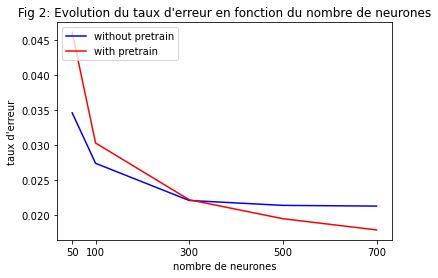

In [23]:
#visualisation
plt.ylabel("taux d'erreur")
plt.xlabel("nombre de neurones")
plt.title("Fig 2: Evolution du taux d'erreur en fonction du nombre de neurones")
plt.plot(param_neurones,scores_dnn,"-b",label="without pretrain")
plt.plot(param_neurones,scores_dnn_pre,"-r",label="with pretrain")
plt.legend(loc="upper left")
plt.xticks(param_neurones)
plt.show()


On observe ici encore que le dnn préentrainé obtient de meilleurs résultats sur un réseau plus dense cette fois ci tandis qu'il performe moins bien sur un réseau moins dense.

Dans cette première partie de l'étude nous fixons tous les paramètres, sauf le nombre de donnée utilisées pour l'entrainement que nous faisons varier, et comparons le comportement des dnn en fonction du nombre du nombre de données choisi et du préentrainement ou non.


In [30]:
#paramètres
epoch_rbm = 100
epoch_retro_prop = 200
learning_rate = 0.05
mini_batch_size = 1000
n_couches = 2
n_neurones = 200
param_data = [1000,3000,7000,10000,30000,60000]

#initialisation des dnn que l'on va étudier 

#la première couche est de la taille des vecteurs d'entrée
size = [len(data_train[0])]
#ajout des couches intermédiaires
size += [n_neurones]*(n_couches)
#la dernière couche dépend des différentes catégories que l'ont souhaite prédire 
size += [10]
#initialisation du dnn
dnn = Dnn(size)
#initialisation indentique du dnn préentrainé
dnn_pre_train = deepcopy(dnn)



In [31]:
#entrainement  des Dnn
_ = 1
dnn_list = [deepcopy(dnn)]
dnn_pretrain_list = [deepcopy(dnn_pre_train)]
for i,n in enumerate(param_data):
    if i < len(param_data)-1:
        dnn_list += [deepcopy(dnn)]
        dnn_pretrain_list += [deepcopy(dnn_pre_train)]
    print("entrainement dnn ", _)
    dnn_list[i].retropropagation(data_train[:n],labels_train[:n],epoch_retro_prop,learning_rate,100)
    print("pretrain du dnn :")
    #pre entrainemnet
    dnn_pretrain_list[i].pretrain(data_train[:n],epoch_rbm,learning_rate,mini_batch_size)
    print("entrainement dnn preentrainé ", _)
    dnn_pretrain_list[i].retropropagation(data_train[:n],labels_train[:n],epoch_retro_prop,learning_rate,100)
    _+=1

  2%|▎         | 5/200 [00:00<00:04, 42.69it/s]

entrainement dnn  1
cross entropie : 
3.731091566694359
cross entropie : 
2.297823205606539
cross entropie : 
2.2770376089099855
cross entropie : 
2.196803812300818
cross entropie : 
2.0310770680132317
cross entropie : 
1.7111950880111695
cross entropie : 
1.299669526103038
cross entropie : 
1.1923838370976871


  6%|▋         | 13/200 [00:00<00:04, 40.12it/s]

cross entropie : 
1.066611201036451
cross entropie : 
0.7782682292930356
cross entropie : 
0.6318620885524424
cross entropie : 
0.47324261107473264
cross entropie : 
0.37781335347885964
cross entropie : 
0.44327508796121906
cross entropie : 
0.30334084904112335
cross entropie : 
0.2701513172851131
cross entropie : 
0.24023966888325035


 12%|█▏        | 23/200 [00:00<00:04, 42.30it/s]

cross entropie : 
0.2636962135362461
cross entropie : 
0.2191096516188456
cross entropie : 
0.18374204032724895
cross entropie : 
0.2661678493519968
cross entropie : 
0.12126259474144163
cross entropie : 
0.10493639183803014
cross entropie : 
0.09599150603702028
cross entropie : 
0.18880649179778222
cross entropie : 
0.07696866470755984


 16%|█▋        | 33/200 [00:00<00:03, 42.94it/s]

cross entropie : 
0.06711262495916949
cross entropie : 
0.05670267476069114
cross entropie : 
0.04893952158725957
cross entropie : 
0.043802920313831394
cross entropie : 
0.03795326223866024
cross entropie : 
0.0345644853519822
cross entropie : 
0.030957320551714445
cross entropie : 
0.02849003859864046
cross entropie : 
0.025451492698395237


 22%|██▏       | 43/200 [00:01<00:03, 43.02it/s]

cross entropie : 
0.023538995617408954
cross entropie : 
0.02161428511444
cross entropie : 
0.020242578784550443
cross entropie : 
0.01851524094257978
cross entropie : 
0.017396358439983016
cross entropie : 
0.016289262329575848
cross entropie : 
0.015364357171919972
cross entropie : 
0.014134008458136699
cross entropie : 
0.013119421380197898


 27%|██▋       | 54/200 [00:01<00:03, 45.27it/s]

cross entropie : 
0.012379118199669902
cross entropie : 
0.011832205695607272
cross entropie : 
0.010926174912180809
cross entropie : 
0.010324724268145638
cross entropie : 
0.009834249498748362
cross entropie : 
0.009306025405930179
cross entropie : 
0.008896279007799355
cross entropie : 
0.008466361176017356
cross entropie : 
0.007875321908490806
cross entropie : 
0.007517653115753347


 30%|███       | 60/200 [00:01<00:02, 46.84it/s]

cross entropie : 
0.007087262310274244
cross entropie : 
0.006851489285353816
cross entropie : 
0.006468732921635083
cross entropie : 
0.0062166912930876
cross entropie : 
0.005884051769975366
cross entropie : 
0.005683204059775742
cross entropie : 
0.005497773009903743
cross entropie : 
0.00530518786420375
cross entropie : 
0.005125168973327139
cross entropie : 
0.004946563403881734


 35%|███▌      | 70/200 [00:01<00:02, 44.39it/s]

cross entropie : 
0.004766016313798973
cross entropie : 
0.0046093460993743085
cross entropie : 
0.004466566136029457
cross entropie : 
0.004332612888442826
cross entropie : 
0.00422252663659031
cross entropie : 
0.004082549539152684
cross entropie : 
0.003959533815361986
cross entropie : 
0.003873782654811409
cross entropie : 
0.003754158797492761
cross entropie : 
0.0036563316533734396


 41%|████      | 82/200 [00:01<00:02, 48.49it/s]

cross entropie : 
0.003551823246360614
cross entropie : 
0.0034699816433367784
cross entropie : 
0.0033824780268013757
cross entropie : 
0.0032932559563380276
cross entropie : 
0.003228796409188815
cross entropie : 
0.0031468375788705366
cross entropie : 
0.0030842212543383284
cross entropie : 
0.0030123813074941145
cross entropie : 
0.0029479833075043154
cross entropie : 
0.002870541770245663
cross entropie : 
0.0028223471942107952


 47%|████▋     | 94/200 [00:02<00:02, 50.64it/s]

cross entropie : 
0.0027651484327016096
cross entropie : 
0.0027021108401367082
cross entropie : 
0.002643289331585723
cross entropie : 
0.0025960797851616617
cross entropie : 
0.002546500204065385
cross entropie : 
0.002506350043380585
cross entropie : 
0.0024553591928612286
cross entropie : 
0.002412692692052815
cross entropie : 
0.002362056494202028
cross entropie : 
0.002322172725084168
cross entropie : 
0.002284090405476496


 53%|█████▎    | 106/200 [00:02<00:01, 53.25it/s]

cross entropie : 
0.0022385274410703913
cross entropie : 
0.002201564822696869
cross entropie : 
0.0021616622724592717
cross entropie : 
0.0021286333756309886
cross entropie : 
0.002092047824799339
cross entropie : 
0.0020675992831960784
cross entropie : 
0.0020299513038867806
cross entropie : 
0.0020042613920106807
cross entropie : 
0.0019704559734996696
cross entropie : 
0.0019350243279386973
cross entropie : 
0.001906705602802604
cross entropie : 
0.0018799246559044972


 59%|█████▉    | 118/200 [00:02<00:01, 51.26it/s]

cross entropie : 
0.0018533311240506644
cross entropie : 
0.001827105018060018
cross entropie : 
0.0018030765884227136
cross entropie : 
0.0017753145859538946
cross entropie : 
0.0017448582641853365
cross entropie : 
0.0017266998966787854
cross entropie : 
0.0016998944184741746
cross entropie : 
0.0016835347913542126
cross entropie : 
0.001656223177876506
cross entropie : 
0.001634077357767484
cross entropie : 
0.0016109136969869352


 65%|██████▌   | 130/200 [00:02<00:01, 53.77it/s]

cross entropie : 
0.0015886811050895646
cross entropie : 
0.001574410978030446
cross entropie : 
0.0015506975556344184
cross entropie : 
0.0015314795859014709
cross entropie : 
0.0015151830756138125
cross entropie : 
0.0014934057784953365
cross entropie : 
0.0014749999530614293
cross entropie : 
0.0014594200465448803
cross entropie : 
0.0014409895516621174
cross entropie : 
0.0014272842952813495
cross entropie : 
0.0014101625253815579
cross entropie : 
0.0013938745303472744


 71%|███████   | 142/200 [00:02<00:01, 54.98it/s]

cross entropie : 
0.001377566198095953
cross entropie : 
0.0013621807698361787
cross entropie : 
0.0013476377736006558
cross entropie : 
0.0013312884539061498
cross entropie : 
0.001317529977342891
cross entropie : 
0.0013009685013866841
cross entropie : 
0.0012881378063730605
cross entropie : 
0.001273001862544847
cross entropie : 
0.001261541815688719
cross entropie : 
0.001247319915343014
cross entropie : 
0.0012345491812029994
cross entropie : 
0.001222318127889745


 77%|███████▋  | 154/200 [00:03<00:00, 54.38it/s]

cross entropie : 
0.0012086336417311255
cross entropie : 
0.0012013236003257477
cross entropie : 
0.0011866236723453714
cross entropie : 
0.0011771022776885529
cross entropie : 
0.0011629558216085746
cross entropie : 
0.0011511696055670224
cross entropie : 
0.0011418785636466444
cross entropie : 
0.0011291096287451773
cross entropie : 
0.001117864773841324
cross entropie : 
0.0011103358214066847
cross entropie : 
0.0010981361761017983


 80%|████████  | 160/200 [00:03<00:00, 47.11it/s]

cross entropie : 
0.0010877693299021578
cross entropie : 
0.0010788370675172128
cross entropie : 
0.0010691047396179875
cross entropie : 
0.00105879399788197
cross entropie : 
0.00104938787490564
cross entropie : 
0.0010387020933586301
cross entropie : 
0.0010299522286297252


 82%|████████▎ | 165/200 [00:03<00:00, 40.55it/s]

cross entropie : 
0.0010212111738178643
cross entropie : 
0.001013511770592618
cross entropie : 
0.0010031285472186862
cross entropie : 
0.0009954863213702428
cross entropie : 
0.0009866635954473527
cross entropie : 
0.000978513194204245
cross entropie : 
0.0009706346868008851
cross entropie : 
0.0009624792216977287


 88%|████████▊ | 175/200 [00:03<00:00, 41.99it/s]

cross entropie : 
0.0009551047605116465
cross entropie : 
0.0009465111215620049
cross entropie : 
0.0009383434256260589
cross entropie : 
0.000931168654567213
cross entropie : 
0.0009241050423180609
cross entropie : 
0.0009158101779941036
cross entropie : 
0.0009093495778135975
cross entropie : 
0.0009026501532496678
cross entropie : 
0.000896787308104826
cross entropie : 
0.0008877170626196313


 92%|█████████▎| 185/200 [00:03<00:00, 40.42it/s]

cross entropie : 
0.0008813481120692737
cross entropie : 
0.0008748801058941711
cross entropie : 
0.0008681431537530105
cross entropie : 
0.0008607625744824543
cross entropie : 
0.0008541088756293384
cross entropie : 
0.0008497006338532351
cross entropie : 
0.0008433549908691215
cross entropie : 
0.0008357140260547035
cross entropie : 
0.0008292393651487942


 98%|█████████▊| 197/200 [00:04<00:00, 46.37it/s]

cross entropie : 
0.0008229505600300999
cross entropie : 
0.0008179390344318521
cross entropie : 
0.0008127937606630661
cross entropie : 
0.0008057073877823319
cross entropie : 
0.0008014757271752551
cross entropie : 
0.0007955060429589616
cross entropie : 
0.0007893607200043975
cross entropie : 
0.0007845317908086295
cross entropie : 
0.0007796886268270116
cross entropie : 
0.0007725131304433557
cross entropie : 
0.0007683155889149678


  2%|▏         | 2/100 [00:00<00:07, 13.09it/s]

cross entropie : 
0.0007631137032407281
pretrain du dnn :
train rbm  1
erreur quadratique :  249011
erreur quadratique :  204111


  6%|▌         | 6/100 [00:00<00:06, 14.75it/s]

erreur quadratique :  183385
erreur quadratique :  172992
erreur quadratique :  167861
erreur quadratique :  162664


  8%|▊         | 8/100 [00:00<00:06, 13.66it/s]

erreur quadratique :  159164
erreur quadratique :  156938
erreur quadratique :  153021


 12%|█▏        | 12/100 [00:00<00:05, 14.69it/s]

erreur quadratique :  151667
erreur quadratique :  150108
erreur quadratique :  147337
erreur quadratique :  145393


 16%|█▌        | 16/100 [00:01<00:05, 15.01it/s]

erreur quadratique :  144470
erreur quadratique :  142521
erreur quadratique :  140264
erreur quadratique :  138348


 20%|██        | 20/100 [00:01<00:05, 15.29it/s]

erreur quadratique :  136852
erreur quadratique :  135616
erreur quadratique :  134434


 24%|██▍       | 24/100 [00:01<00:04, 15.48it/s]

erreur quadratique :  132897
erreur quadratique :  131486
erreur quadratique :  129891
erreur quadratique :  128498


 26%|██▌       | 26/100 [00:01<00:04, 15.22it/s]

erreur quadratique :  127351
erreur quadratique :  126313
erreur quadratique :  123947


 30%|███       | 30/100 [00:02<00:04, 15.45it/s]

erreur quadratique :  123126
erreur quadratique :  122476
erreur quadratique :  121040
erreur quadratique :  119495


 34%|███▍      | 34/100 [00:02<00:04, 13.87it/s]

erreur quadratique :  119104
erreur quadratique :  118850
erreur quadratique :  117339


 38%|███▊      | 38/100 [00:02<00:04, 15.28it/s]

erreur quadratique :  116707
erreur quadratique :  115797
erreur quadratique :  114836
erreur quadratique :  114660


 42%|████▏     | 42/100 [00:02<00:03, 16.15it/s]

erreur quadratique :  113636
erreur quadratique :  112476
erreur quadratique :  111541
erreur quadratique :  111588


 46%|████▌     | 46/100 [00:03<00:03, 16.27it/s]

erreur quadratique :  110033
erreur quadratique :  110070
erreur quadratique :  109235
erreur quadratique :  108606


 50%|█████     | 50/100 [00:03<00:03, 16.34it/s]

erreur quadratique :  108002
erreur quadratique :  107704
erreur quadratique :  106713
erreur quadratique :  106581


 54%|█████▍    | 54/100 [00:03<00:02, 17.15it/s]

erreur quadratique :  106114
erreur quadratique :  105166
erreur quadratique :  105050
erreur quadratique :  104269


 58%|█████▊    | 58/100 [00:03<00:02, 17.36it/s]

erreur quadratique :  104189
erreur quadratique :  103336
erreur quadratique :  103153
erreur quadratique :  102770


 62%|██████▏   | 62/100 [00:03<00:02, 17.57it/s]

erreur quadratique :  102949
erreur quadratique :  102155
erreur quadratique :  101389
erreur quadratique :  100885


 66%|██████▌   | 66/100 [00:04<00:01, 17.86it/s]

erreur quadratique :  100895
erreur quadratique :  99946
erreur quadratique :  99902
erreur quadratique :  99636


 70%|███████   | 70/100 [00:04<00:01, 17.92it/s]

erreur quadratique :  98914
erreur quadratique :  98527
erreur quadratique :  98715
erreur quadratique :  98501


 74%|███████▍  | 74/100 [00:04<00:01, 18.10it/s]

erreur quadratique :  98218
erreur quadratique :  97167
erreur quadratique :  97031
erreur quadratique :  96937


 78%|███████▊  | 78/100 [00:04<00:01, 17.93it/s]

erreur quadratique :  96506
erreur quadratique :  96260
erreur quadratique :  96330
erreur quadratique :  95735


 82%|████████▏ | 82/100 [00:05<00:00, 18.23it/s]

erreur quadratique :  95967
erreur quadratique :  94946
erreur quadratique :  94891
erreur quadratique :  94969


 86%|████████▌ | 86/100 [00:05<00:00, 17.90it/s]

erreur quadratique :  94116
erreur quadratique :  93576
erreur quadratique :  94327
erreur quadratique :  93451


 90%|█████████ | 90/100 [00:05<00:00, 17.66it/s]

erreur quadratique :  93339
erreur quadratique :  93195
erreur quadratique :  93017
erreur quadratique :  92491


 94%|█████████▍| 94/100 [00:05<00:00, 17.86it/s]

erreur quadratique :  92274
erreur quadratique :  91475
erreur quadratique :  92093
erreur quadratique :  91307


 98%|█████████▊| 98/100 [00:05<00:00, 18.22it/s]

erreur quadratique :  91144
erreur quadratique :  90701
erreur quadratique :  91369
erreur quadratique :  90669


  4%|▍         | 4/100 [00:00<00:02, 34.42it/s]

erreur quadratique :  90663
erreur quadratique :  90777
train rbm  2
erreur quadratique :  87217
erreur quadratique :  86274
erreur quadratique :  85660
erreur quadratique :  85206


  8%|▊         | 8/100 [00:00<00:02, 34.92it/s]

erreur quadratique :  85129
erreur quadratique :  84810
erreur quadratique :  84242
erreur quadratique :  83998
erreur quadratique :  83395
erreur quadratique :  82833
erreur quadratique :  82288
erreur quadratique :  81543
erreur quadratique :  80950


 19%|█▉        | 19/100 [00:00<00:01, 41.12it/s]

erreur quadratique :  80216
erreur quadratique :  79746
erreur quadratique :  79196
erreur quadratique :  78380
erreur quadratique :  77871
erreur quadratique :  77017
erreur quadratique :  76319
erreur quadratique :  75841
erreur quadratique :  75019
erreur quadratique :  74595
erreur quadratique :  

 29%|██▉       | 29/100 [00:00<00:01, 39.84it/s]

74271
erreur quadratique :  72959
erreur quadratique :  72704
erreur quadratique :  72005
erreur quadratique :  71523
erreur quadratique :  70920
erreur quadratique :  70067
erreur quadratique :  69786


 37%|███▋      | 37/100 [00:00<00:01, 36.39it/s]

erreur quadratique :  68942
erreur quadratique :  68230
erreur quadratique :  68186
erreur quadratique :  67922
erreur quadratique :  67081
erreur quadratique :  66726
erreur quadratique :  66009
erreur quadratique :  65202


 47%|████▋     | 47/100 [00:01<00:01, 41.14it/s]

erreur quadratique :  65302
erreur quadratique :  64975
erreur quadratique :  64337
erreur quadratique :  63477
erreur quadratique :  63817
erreur quadratique :  63423
erreur quadratique :  63126
erreur quadratique :  62858
erreur quadratique :  62491
erreur quadratique :  61963


 58%|█████▊    | 58/100 [00:01<00:00, 44.82it/s]

erreur quadratique :  61816
erreur quadratique :  61904
erreur quadratique :  61665
erreur quadratique :  61153
erreur quadratique :  60911
erreur quadratique :  60792
erreur quadratique :  60322
erreur quadratique :  60076
erreur quadratique :  60019
erreur quadratique :  59692


 68%|██████▊   | 68/100 [00:01<00:00, 46.25it/s]

erreur quadratique :  59407
erreur quadratique :  59219
erreur quadratique :  59219
erreur quadratique :  58986
erreur quadratique :  58641
erreur quadratique :  58720
erreur quadratique :  58114
erreur quadratique :  58294
erreur quadratique :  58036
erreur quadratique :  58053


 78%|███████▊  | 78/100 [00:01<00:00, 44.17it/s]

erreur quadratique :  57844
erreur quadratique :  57848
erreur quadratique :  57528
erreur quadratique :  57556
erreur quadratique :  57200
erreur quadratique :  57243
erreur quadratique :  56911
erreur quadratique :  56929
erreur quadratique :  56871


 83%|████████▎ | 83/100 [00:01<00:00, 40.45it/s]

erreur quadratique :  56931
erreur quadratique :  56268
erreur quadratique :  56055
erreur quadratique :  55919
erreur quadratique :  55928
erreur quadratique :  56187
erreur quadratique :  55761
erreur quadratique :  55802
erreur quadratique :  55530


 94%|█████████▍| 94/100 [00:02<00:00, 43.14it/s]

erreur quadratique :  55487
erreur quadratique :  55274
erreur quadratique :  55315
erreur quadratique :  55105
erreur quadratique :  55469
erreur quadratique :  54843
erreur quadratique :  54785
erreur quadratique :  54818
erreur quadratique :  54769


  2%|▎         | 5/200 [00:00<00:04, 48.68it/s]

erreur quadratique :  54614
erreur quadratique :  54382
erreur quadratique :  54912
erreur quadratique :  54448
entrainement dnn preentrainé  1
cross entropie : 
3.919032354385107
cross entropie : 
1.3578357013359146
cross entropie : 
1.1988718497476372
cross entropie : 
0.7600060469798209
cross entropie : 
0.5829059696202126
cross entropie : 
0.5199694739851705


  8%|▊         | 16/200 [00:00<00:03, 50.20it/s]

cross entropie : 
0.48612229282392416
cross entropie : 
0.43824789395463154
cross entropie : 
0.32203002511007944
cross entropie : 
0.30293032292597544
cross entropie : 
0.25880385243939596
cross entropie : 
0.2677489661368031
cross entropie : 
0.1947911821539847
cross entropie : 
0.17797677406138016
cross entropie : 
0.17723669604123554
cross entropie : 
0.2564452562407035
cross entropie : 
0.13112900546752673


 14%|█▎        | 27/200 [00:00<00:03, 50.90it/s]

cross entropie : 
0.10670445373407851
cross entropie : 
0.09415184909655576
cross entropie : 
0.08311714221129682
cross entropie : 
0.07282309174288662
cross entropie : 
0.06394763684979596
cross entropie : 
0.060120776715572324
cross entropie : 
0.0516850326099065
cross entropie : 
0.04786120120589977
cross entropie : 
0.04146220473707186
cross entropie : 
0.03806124871212117
cross entropie : 
0.03520043831443428


 19%|█▉        | 38/200 [00:00<00:03, 50.94it/s]

cross entropie : 
0.031852256860006825
cross entropie : 
0.030072212453650046
cross entropie : 
0.027599299985368635
cross entropie : 
0.02582980911192969
cross entropie : 
0.023606724491621
cross entropie : 
0.022365706865980852
cross entropie : 
0.020765343254109208
cross entropie : 
0.019336069873978012
cross entropie : 
0.018440614412481765
cross entropie : 
0.017203566844401746
cross entropie : 
0.016159341201143474


 24%|██▍       | 49/200 [00:00<00:02, 51.46it/s]

cross entropie : 
0.01523554169309645
cross entropie : 
0.014508444400420997
cross entropie : 
0.013716459880448952
cross entropie : 
0.013090742415217684
cross entropie : 
0.012483888812732049
cross entropie : 
0.011918319813343603
cross entropie : 
0.011345417221064968
cross entropie : 
0.011035411882049333
cross entropie : 
0.010519899806322078
cross entropie : 
0.009945575826117468
cross entropie : 
0.009599427248906098


 30%|███       | 60/200 [00:01<00:02, 51.63it/s]

cross entropie : 
0.009208721006714611
cross entropie : 
0.008776092860923377
cross entropie : 
0.008544487129619242
cross entropie : 
0.008254354317794253
cross entropie : 
0.007925870333900237
cross entropie : 
0.007597535102067428
cross entropie : 
0.007378380242957995
cross entropie : 
0.007119976675827456
cross entropie : 
0.006954510246416465
cross entropie : 
0.006661610170052235
cross entropie : 
0.006483321180282544


 36%|███▌      | 72/200 [00:01<00:02, 51.43it/s]

cross entropie : 
0.006248209165531781
cross entropie : 
0.006066159321424624
cross entropie : 
0.005875974142534261
cross entropie : 
0.005762864513906
cross entropie : 
0.005561315253504283
cross entropie : 
0.005410945117419391
cross entropie : 
0.005268065323200019
cross entropie : 
0.005122132226315013
cross entropie : 
0.004979767043516691
cross entropie : 
0.004887759056544105
cross entropie : 
0.00476438775012414


 39%|███▉      | 78/200 [00:01<00:02, 51.12it/s]

cross entropie : 
0.004625689891452061
cross entropie : 
0.004516876224275376
cross entropie : 
0.004413862782657986
cross entropie : 
0.004302211717783908
cross entropie : 
0.004210390617147745
cross entropie : 
0.004124327264801443
cross entropie : 
0.004033754820284445
cross entropie : 
0.00396337309118781
cross entropie : 
0.0038619173561964507
cross entropie : 
0.003812025546178522
cross entropie : 
0.003716045170626277


 45%|████▌     | 90/200 [00:01<00:02, 51.14it/s]

cross entropie : 
0.003641070172455847
cross entropie : 
0.0035740313070336976
cross entropie : 
0.0034853701346666205
cross entropie : 
0.003423226410358725
cross entropie : 
0.003354479074953948
cross entropie : 
0.003293750337342081
cross entropie : 
0.003234164312695545
cross entropie : 
0.0031780952301478905
cross entropie : 
0.0031083336170649786
cross entropie : 
0.003077726430998153
cross entropie : 
0.0030046552229386547


 51%|█████     | 102/200 [00:01<00:01, 51.66it/s]

cross entropie : 
0.0029682803663709963
cross entropie : 
0.0029116873365108596
cross entropie : 
0.002862886448320477
cross entropie : 
0.0028216737600532684
cross entropie : 
0.002778399819830845
cross entropie : 
0.002725513138206637
cross entropie : 
0.002694927050833747
cross entropie : 
0.0026631458848649717
cross entropie : 
0.002601402871446176
cross entropie : 
0.00256023822646884
cross entropie : 
0.002524529138140088


 57%|█████▋    | 114/200 [00:02<00:01, 50.54it/s]

cross entropie : 
0.00248561105717302
cross entropie : 
0.0024493026205095383
cross entropie : 
0.002413476078063021
cross entropie : 
0.002377438896292561
cross entropie : 
0.00234326083441605
cross entropie : 
0.0023085235277883797
cross entropie : 
0.002280423181306859
cross entropie : 
0.0022638031266895148
cross entropie : 
0.002216184576352509
cross entropie : 
0.0021904791812783326
cross entropie : 
0.0021658005048576035


 63%|██████▎   | 126/200 [00:02<00:01, 51.35it/s]

cross entropie : 
0.0021370558529540647
cross entropie : 
0.00210457757380218
cross entropie : 
0.002079841472488541
cross entropie : 
0.0020497173382762715
cross entropie : 
0.0020242720118288132
cross entropie : 
0.002002113899826393
cross entropie : 
0.0019795603081017568
cross entropie : 
0.0019602763258406387
cross entropie : 
0.001928618202138197
cross entropie : 
0.001903006065397411
cross entropie : 
0.0018842237245737471


 66%|██████▌   | 132/200 [00:02<00:01, 50.69it/s]

cross entropie : 
0.0018602757128540887
cross entropie : 
0.0018460670482195547
cross entropie : 
0.0018200942264504137
cross entropie : 
0.0018008818120856527
cross entropie : 
0.0017802992382862537
cross entropie : 
0.0017603886684060216
cross entropie : 
0.0017428330378560016
cross entropie : 
0.0017198679164330385
cross entropie : 
0.0017018310205460067
cross entropie : 
0.0016838738399489652


 72%|███████▏  | 143/200 [00:02<00:01, 43.96it/s]

cross entropie : 
0.0016670444857712658
cross entropie : 
0.001654036258102524
cross entropie : 
0.0016315601570927808
cross entropie : 
0.0016170341822515318
cross entropie : 
0.0015987944872655883
cross entropie : 
0.0015809297274076261
cross entropie : 
0.0015675093461389197
cross entropie : 
0.0015535136317767477
cross entropie : 
0.0015368195299219575


 77%|███████▋  | 154/200 [00:03<00:00, 46.83it/s]

cross entropie : 
0.0015209195495340779
cross entropie : 
0.001507379624496496
cross entropie : 
0.0014899030658818795
cross entropie : 
0.00147601167453746
cross entropie : 
0.0014614043936189338
cross entropie : 
0.0014472030832705083
cross entropie : 
0.0014343013461806308
cross entropie : 
0.0014207484204720238
cross entropie : 
0.0014087175570079646
cross entropie : 
0.001395231726727921


 80%|███████▉  | 159/200 [00:03<00:00, 44.56it/s]

cross entropie : 
0.0013820393923205706
cross entropie : 
0.001370159368086356
cross entropie : 
0.0013570054504033055
cross entropie : 
0.001345237788427746
cross entropie : 
0.0013353447938861062
cross entropie : 
0.001323620723635469
cross entropie : 
0.0013124414889898281


 84%|████████▍ | 169/200 [00:03<00:00, 40.13it/s]

cross entropie : 
0.0013001932622033324
cross entropie : 
0.0012877531486934005
cross entropie : 
0.0012820734479225228
cross entropie : 
0.001265960497763326
cross entropie : 
0.0012562364555830739
cross entropie : 
0.0012470428716382178
cross entropie : 
0.0012370811055366841
cross entropie : 
0.001225074624577948


 89%|████████▉ | 178/200 [00:03<00:00, 35.68it/s]

cross entropie : 
0.0012168425822098212
cross entropie : 
0.0012053668079812518
cross entropie : 
0.0011974973435411845
cross entropie : 
0.0011861737846753173
cross entropie : 
0.0011789737039094976
cross entropie : 
0.0011681088836173134
cross entropie : 
0.001159769916814932


 93%|█████████▎| 186/200 [00:03<00:00, 37.22it/s]

cross entropie : 
0.0011523651172755443
cross entropie : 
0.0011401237794826016
cross entropie : 
0.001131621834794687
cross entropie : 
0.0011236041609452615
cross entropie : 
0.001114591448296728
cross entropie : 
0.001106713260790938
cross entropie : 
0.0010983297884963959
cross entropie : 
0.0010911314133433183


 95%|█████████▌| 190/200 [00:04<00:00, 36.96it/s]

cross entropie : 
0.0010826774681839024
cross entropie : 
0.0010772855800072992
cross entropie : 
0.0010681943834213996
cross entropie : 
0.0010600721621646042
cross entropie : 
0.0010514135343117849
cross entropie : 
0.0010439146105418234
cross entropie : 
0.0010383364475394267


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.0010286282020051329
cross entropie : 
0.0010218962981350737
cross entropie : 
0.0010150850617420036
cross entropie : 
0.001008465373044417
cross entropie : 
0.0010028910841322937
cross entropie : 
0.0009945060074002037
cross entropie : 
0.0009882429914753
entrainement dnn  2


  1%|          | 2/200 [00:00<00:12, 15.42it/s]

cross entropie : 
2.674932502476836
cross entropie : 
1.944520954912688
cross entropie : 
1.1356110236817696


  3%|▎         | 6/200 [00:00<00:14, 13.64it/s]

cross entropie : 
0.7211727508404089
cross entropie : 
0.4468217834597783
cross entropie : 
0.3779967394854395


  4%|▍         | 8/200 [00:00<00:13, 14.26it/s]

cross entropie : 
0.33458617377167743
cross entropie : 
0.23425134907062478
cross entropie : 
0.2575349467697292


  6%|▌         | 12/200 [00:00<00:13, 13.57it/s]

cross entropie : 
0.17538892643999182
cross entropie : 
0.15375183403328677
cross entropie : 
0.18951591404460047


  8%|▊         | 16/200 [00:01<00:12, 15.24it/s]

cross entropie : 
0.11679724309357256
cross entropie : 
0.0947387806200404
cross entropie : 
0.07719759133548625
cross entropie : 
0.06619900839177889


 10%|█         | 20/200 [00:01<00:11, 16.24it/s]

cross entropie : 
0.05529383146012385
cross entropie : 
0.04713730985978948
cross entropie : 
0.03829863513381516
cross entropie : 
0.03190014537245442


 11%|█         | 22/200 [00:01<00:10, 16.37it/s]

cross entropie : 
0.027155327697159642
cross entropie : 
0.02401882576466555
cross entropie : 
0.01880383596952849


 13%|█▎        | 26/200 [00:01<00:12, 14.06it/s]

cross entropie : 
0.016755347634940472
cross entropie : 
0.014159874647821934
cross entropie : 
0.01268247186310909


 15%|█▌        | 30/200 [00:02<00:11, 15.43it/s]

cross entropie : 
0.010804667028121856
cross entropie : 
0.009468656425806484
cross entropie : 
0.008553293960311986
cross entropie : 
0.00791438966526387


 17%|█▋        | 34/200 [00:02<00:10, 16.29it/s]

cross entropie : 
0.007221200082001433
cross entropie : 
0.006569123443032467
cross entropie : 
0.006019626461418838
cross entropie : 
0.00552187053253095


 19%|█▉        | 38/200 [00:02<00:09, 16.76it/s]

cross entropie : 
0.005131295626088932
cross entropie : 
0.004847843264814681
cross entropie : 
0.004550320556802451
cross entropie : 
0.004269037898346436


 21%|██        | 42/200 [00:02<00:09, 16.73it/s]

cross entropie : 
0.004051340051262185
cross entropie : 
0.003793890558594373
cross entropie : 
0.003591966278149759
cross entropie : 
0.0034580030272817522


 22%|██▏       | 44/200 [00:02<00:10, 14.47it/s]

cross entropie : 
0.003276245256334647
cross entropie : 
0.0031570821647732275
cross entropie : 
0.00299674266744724


 24%|██▍       | 48/200 [00:03<00:09, 15.28it/s]

cross entropie : 
0.002883016923227585
cross entropie : 
0.002751013746951169
cross entropie : 
0.0026478427225115416
cross entropie : 
0.0025421919419578542


 26%|██▌       | 52/200 [00:03<00:10, 13.87it/s]

cross entropie : 
0.002448134992493519
cross entropie : 
0.002364814421310373
cross entropie : 
0.002285279393689172


 28%|██▊       | 56/200 [00:03<00:09, 15.27it/s]

cross entropie : 
0.0022063084238109405
cross entropie : 
0.0021383644407457214
cross entropie : 
0.002067472377219253
cross entropie : 
0.0020050040310385596


 30%|███       | 60/200 [00:03<00:08, 15.99it/s]

cross entropie : 
0.0019429034226311937
cross entropie : 
0.0018819461672419133
cross entropie : 
0.0018308115804009806
cross entropie : 
0.0017863962387919016


 32%|███▏      | 64/200 [00:04<00:08, 16.36it/s]

cross entropie : 
0.0017371710551135442
cross entropie : 
0.0016856676123829858
cross entropie : 
0.0016411663987500632
cross entropie : 
0.001602057536740361


 33%|███▎      | 66/200 [00:04<00:09, 14.62it/s]

cross entropie : 
0.0015654495229549508
cross entropie : 
0.001527777641499945
cross entropie : 
0.001483965514658124


 35%|███▌      | 70/200 [00:04<00:08, 15.43it/s]

cross entropie : 
0.0014558125701759849
cross entropie : 
0.0014231221309673298
cross entropie : 
0.0013899817857497344
cross entropie : 
0.0013544454123610287


 37%|███▋      | 74/200 [00:04<00:09, 13.21it/s]

cross entropie : 
0.0013290647070251765
cross entropie : 
0.0013005122859291003
cross entropie : 
0.001273270119655793


 39%|███▉      | 78/200 [00:05<00:08, 14.67it/s]

cross entropie : 
0.0012489261104443382
cross entropie : 
0.0012183569891609407
cross entropie : 
0.0011989298726823299
cross entropie : 
0.0011766786193067368


 41%|████      | 82/200 [00:05<00:07, 14.90it/s]

cross entropie : 
0.0011526803541655997
cross entropie : 
0.0011296202459014863
cross entropie : 
0.0011087315636077579
cross entropie : 
0.0010894623993881834


 43%|████▎     | 86/200 [00:05<00:07, 14.90it/s]

cross entropie : 
0.0010697628384747121
cross entropie : 
0.0010510907840265019
cross entropie : 
0.001034441202682678
cross entropie : 
0.0010132752174219525


 44%|████▍     | 88/200 [00:05<00:07, 15.28it/s]

cross entropie : 
0.0009972015326626823
cross entropie : 
0.0009812813378687244
cross entropie : 
0.0009680960488165377


 46%|████▌     | 92/200 [00:06<00:07, 14.57it/s]

cross entropie : 
0.0009504023409261816
cross entropie : 
0.0009332128392097512
cross entropie : 
0.0009190611279303975
cross entropie : 
0.0009038161838196539


 48%|████▊     | 96/200 [00:06<00:06, 15.05it/s]

cross entropie : 
0.0008924679692872161
cross entropie : 
0.0008768969286881609
cross entropie : 
0.0008647292895568152


 50%|█████     | 100/200 [00:06<00:06, 14.72it/s]

cross entropie : 
0.0008520091039731366
cross entropie : 
0.000839727597230566
cross entropie : 
0.0008283899954609543
cross entropie : 
0.0008147760140339947


 51%|█████     | 102/200 [00:06<00:06, 15.14it/s]

cross entropie : 
0.0008047160545719526
cross entropie : 
0.0007919417784071843
cross entropie : 
0.0007829130840942529


 53%|█████▎    | 106/200 [00:07<00:06, 14.03it/s]

cross entropie : 
0.0007719520229158099
cross entropie : 
0.0007617210540787717
cross entropie : 
0.0007506680355172293
cross entropie : 
0.0007408240461745913


 55%|█████▌    | 110/200 [00:07<00:06, 13.94it/s]

cross entropie : 
0.0007324494682201232
cross entropie : 
0.000722958775051019
cross entropie : 
0.0007132931253666741


 57%|█████▋    | 114/200 [00:07<00:05, 14.74it/s]

cross entropie : 
0.0007044522036886597
cross entropie : 
0.0006952473219438889
cross entropie : 
0.0006872557750383974
cross entropie : 
0.0006787579264098153


 58%|█████▊    | 116/200 [00:07<00:06, 13.66it/s]

cross entropie : 
0.0006702020961344775
cross entropie : 
0.0006627525570554764
cross entropie : 
0.0006548882631711371


 60%|██████    | 120/200 [00:08<00:05, 14.93it/s]

cross entropie : 
0.000647453847659826
cross entropie : 
0.0006400660382676826
cross entropie : 
0.0006325385274094457
cross entropie : 
0.0006251088568952367


 62%|██████▏   | 124/200 [00:08<00:05, 14.15it/s]

cross entropie : 
0.0006180445780276136
cross entropie : 
0.0006113797946951432
cross entropie : 
0.00060426531916683


 64%|██████▍   | 128/200 [00:08<00:04, 15.07it/s]

cross entropie : 
0.0005979384416934532
cross entropie : 
0.0005917747674088111
cross entropie : 
0.000585166801676432
cross entropie : 
0.0005792063338384471


 66%|██████▌   | 132/200 [00:08<00:04, 14.64it/s]

cross entropie : 
0.000572490527854739
cross entropie : 
0.00056647252741199
cross entropie : 
0.0005612606113374819
cross entropie : 
0.0005551069959700933


 67%|██████▋   | 134/200 [00:09<00:04, 14.47it/s]

cross entropie : 
0.0005490507962754881
cross entropie : 
0.0005450191924771807
cross entropie : 
0.0005386047959591044


 69%|██████▉   | 138/200 [00:09<00:04, 14.42it/s]

cross entropie : 
0.000533549573779722
cross entropie : 
0.0005281137945825029
cross entropie : 
0.000523333768454151
cross entropie : 
0.000517994780690632


 71%|███████   | 142/200 [00:09<00:04, 14.13it/s]

cross entropie : 
0.0005123156183811906
cross entropie : 
0.0005081372899351545
cross entropie : 
0.0005032653400483503


 72%|███████▏  | 144/200 [00:09<00:03, 14.56it/s]

cross entropie : 
0.0004986922760563226
cross entropie : 
0.0004941480800615243
cross entropie : 
0.0004894754711263945


 74%|███████▍  | 148/200 [00:10<00:03, 14.38it/s]

cross entropie : 
0.0004848442447434681
cross entropie : 
0.0004805888646566601
cross entropie : 
0.00047648577128417386
cross entropie : 
0.00047263468406249696


 76%|███████▌  | 152/200 [00:10<00:03, 14.62it/s]

cross entropie : 
0.00046800925902343364
cross entropie : 
0.00046405675890159816
cross entropie : 
0.00046037062760825154


 78%|███████▊  | 156/200 [00:10<00:02, 15.04it/s]

cross entropie : 
0.00045614109529391156
cross entropie : 
0.00045199192870635385
cross entropie : 
0.00044802381593988155
cross entropie : 
0.00044512293432373334


 79%|███████▉  | 158/200 [00:10<00:03, 13.66it/s]

cross entropie : 
0.00044072148175508454
cross entropie : 
0.00043702661328393066
cross entropie : 
0.0004334365541790325


 81%|████████  | 162/200 [00:11<00:02, 14.59it/s]

cross entropie : 
0.0004299596917373362
cross entropie : 
0.00042655478131278915
cross entropie : 
0.0004231196848339316
cross entropie : 
0.0004195244350045747


 83%|████████▎ | 166/200 [00:11<00:02, 13.76it/s]

cross entropie : 
0.00041622409378765926
cross entropie : 
0.0004128420672827289
cross entropie : 
0.0004096357621039979
cross entropie : 
0.0004062165949970056


 85%|████████▌ | 170/200 [00:11<00:02, 13.66it/s]

cross entropie : 
0.00040315939243433117
cross entropie : 
0.00040019995413994236
cross entropie : 
0.00039729407896703936


 87%|████████▋ | 174/200 [00:11<00:01, 15.04it/s]

cross entropie : 
0.0003939893188669922
cross entropie : 
0.00039112825581439416
cross entropie : 
0.00038820139967290514
cross entropie : 
0.000385461045784591


 88%|████████▊ | 176/200 [00:12<00:01, 14.08it/s]

cross entropie : 
0.00038238864280023144
cross entropie : 
0.00037971220812072913
cross entropie : 
0.00037687341901983284


 90%|█████████ | 180/200 [00:12<00:01, 15.16it/s]

cross entropie : 
0.0003740983701223896
cross entropie : 
0.00037150095100872536
cross entropie : 
0.00036886929970753393
cross entropie : 
0.00036621467560315286


 92%|█████████▏| 184/200 [00:12<00:01, 14.79it/s]

cross entropie : 
0.00036366031155815517
cross entropie : 
0.00036086864196073254
cross entropie : 
0.000358718357364808
cross entropie : 
0.0003559530514255366


 94%|█████████▍| 188/200 [00:12<00:00, 14.86it/s]

cross entropie : 
0.0003534962915865471
cross entropie : 
0.00035127474850978193
cross entropie : 
0.0003487198782706153


 96%|█████████▌| 192/200 [00:13<00:00, 15.89it/s]

cross entropie : 
0.00034659891661709813
cross entropie : 
0.00034403119923832756
cross entropie : 
0.00034146456550389673
cross entropie : 
0.0003394048009802164


 98%|█████████▊| 196/200 [00:13<00:00, 15.82it/s]

cross entropie : 
0.00033718503943597255
cross entropie : 
0.00033508326694754276
cross entropie : 
0.0003326931043614052
cross entropie : 
0.0003306514235293254


 99%|█████████▉| 198/200 [00:13<00:00, 16.05it/s]

cross entropie : 
0.0003283338948613042
cross entropie : 
0.00032630451996060986
cross entropie : 
0.00032419881343738086
cross entropie : 


  1%|          | 1/100 [00:00<00:19,  5.17it/s]

0.0003220778745708834
pretrain du dnn :
train rbm  1
erreur quadratique :  547053


  3%|▎         | 3/100 [00:00<00:18,  5.20it/s]

erreur quadratique :  495032
erreur quadratique :  464157


  5%|▌         | 5/100 [00:00<00:17,  5.32it/s]

erreur quadratique :  444968
erreur quadratique :  430602


  7%|▋         | 7/100 [00:01<00:17,  5.43it/s]

erreur quadratique :  415377
erreur quadratique :  401685


  9%|▉         | 9/100 [00:01<00:16,  5.61it/s]

erreur quadratique :  390302
erreur quadratique :  379413


 11%|█         | 11/100 [00:01<00:15,  5.74it/s]

erreur quadratique :  370741
erreur quadratique :  361153


 13%|█▎        | 13/100 [00:02<00:14,  5.80it/s]

erreur quadratique :  351920
erreur quadratique :  346979


 15%|█▌        | 15/100 [00:02<00:14,  5.86it/s]

erreur quadratique :  339687
erreur quadratique :  333806


 17%|█▋        | 17/100 [00:03<00:14,  5.83it/s]

erreur quadratique :  327868
erreur quadratique :  323935


 19%|█▉        | 19/100 [00:03<00:13,  5.84it/s]

erreur quadratique :  319296
erreur quadratique :  315880


 21%|██        | 21/100 [00:03<00:13,  5.79it/s]

erreur quadratique :  311446
erreur quadratique :  308167


 23%|██▎       | 23/100 [00:04<00:13,  5.82it/s]

erreur quadratique :  305293
erreur quadratique :  302734


 25%|██▌       | 25/100 [00:04<00:13,  5.65it/s]

erreur quadratique :  299594
erreur quadratique :  296370


 27%|██▋       | 27/100 [00:04<00:12,  5.75it/s]

erreur quadratique :  294262
erreur quadratique :  291960


 29%|██▉       | 29/100 [00:05<00:12,  5.85it/s]

erreur quadratique :  289174
erreur quadratique :  286387


 31%|███       | 31/100 [00:05<00:11,  5.88it/s]

erreur quadratique :  284266
erreur quadratique :  282126


 33%|███▎      | 33/100 [00:05<00:11,  5.86it/s]

erreur quadratique :  281430
erreur quadratique :  279183


 35%|███▌      | 35/100 [00:06<00:11,  5.87it/s]

erreur quadratique :  277346
erreur quadratique :  276128


 37%|███▋      | 37/100 [00:06<00:10,  5.92it/s]

erreur quadratique :  273825
erreur quadratique :  272200


 39%|███▉      | 39/100 [00:06<00:10,  5.87it/s]

erreur quadratique :  270261
erreur quadratique :  269335


 41%|████      | 41/100 [00:07<00:10,  5.82it/s]

erreur quadratique :  267192
erreur quadratique :  265662


 43%|████▎     | 43/100 [00:07<00:10,  5.63it/s]

erreur quadratique :  264149
erreur quadratique :  263076


 44%|████▍     | 44/100 [00:07<00:10,  5.51it/s]

erreur quadratique :  262137


 45%|████▌     | 45/100 [00:07<00:10,  5.02it/s]

erreur quadratique :  261388


 46%|████▌     | 46/100 [00:08<00:10,  4.91it/s]

erreur quadratique :  259784


 47%|████▋     | 47/100 [00:08<00:10,  4.83it/s]

erreur quadratique :  258259


 49%|████▉     | 49/100 [00:08<00:10,  4.87it/s]

erreur quadratique :  256226
erreur quadratique :  255593


 51%|█████     | 51/100 [00:09<00:09,  5.06it/s]

erreur quadratique :  255263
erreur quadratique :  252567


 53%|█████▎    | 53/100 [00:09<00:09,  5.15it/s]

erreur quadratique :  252499
erreur quadratique :  250974


 54%|█████▍    | 54/100 [00:09<00:08,  5.23it/s]

erreur quadratique :  250276


 56%|█████▌    | 56/100 [00:10<00:08,  5.22it/s]

erreur quadratique :  248346
erreur quadratique :  248578


 57%|█████▋    | 57/100 [00:10<00:08,  5.36it/s]

erreur quadratique :  246079


 59%|█████▉    | 59/100 [00:10<00:07,  5.38it/s]

erreur quadratique :  246349
erreur quadratique :  244440


 60%|██████    | 60/100 [00:10<00:07,  5.52it/s]

erreur quadratique :  243449


 62%|██████▏   | 62/100 [00:11<00:07,  5.38it/s]

erreur quadratique :  243187
erreur quadratique :  242201


 64%|██████▍   | 64/100 [00:11<00:06,  5.38it/s]

erreur quadratique :  241533
erreur quadratique :  239738


 65%|██████▌   | 65/100 [00:11<00:06,  5.41it/s]

erreur quadratique :  238868


 67%|██████▋   | 67/100 [00:12<00:06,  5.23it/s]

erreur quadratique :  238370
erreur quadratique :  237920


 69%|██████▉   | 69/100 [00:12<00:05,  5.26it/s]

erreur quadratique :  236790
erreur quadratique :  235904


 71%|███████   | 71/100 [00:12<00:05,  5.34it/s]

erreur quadratique :  235240
erreur quadratique :  234295


 73%|███████▎  | 73/100 [00:13<00:04,  5.44it/s]

erreur quadratique :  234065
erreur quadratique :  232788


 75%|███████▌  | 75/100 [00:13<00:04,  5.44it/s]

erreur quadratique :  231454
erreur quadratique :  230766


 77%|███████▋  | 77/100 [00:14<00:04,  5.47it/s]

erreur quadratique :  230904
erreur quadratique :  229638


 79%|███████▉  | 79/100 [00:14<00:03,  5.49it/s]

erreur quadratique :  228777
erreur quadratique :  229419


 81%|████████  | 81/100 [00:14<00:03,  5.53it/s]

erreur quadratique :  227792
erreur quadratique :  227311


 83%|████████▎ | 83/100 [00:15<00:03,  5.45it/s]

erreur quadratique :  225988
erreur quadratique :  225320


 85%|████████▌ | 85/100 [00:15<00:02,  5.03it/s]

erreur quadratique :  225059
erreur quadratique :  224471


 87%|████████▋ | 87/100 [00:15<00:02,  5.06it/s]

erreur quadratique :  223078
erreur quadratique :  222921


 88%|████████▊ | 88/100 [00:16<00:02,  5.05it/s]

erreur quadratique :  222764


 89%|████████▉ | 89/100 [00:16<00:02,  5.01it/s]

erreur quadratique :  222364


 91%|█████████ | 91/100 [00:16<00:01,  4.90it/s]

erreur quadratique :  221258
erreur quadratique :  220953


 93%|█████████▎| 93/100 [00:17<00:01,  5.15it/s]

erreur quadratique :  219880
erreur quadratique :  220496


 95%|█████████▌| 95/100 [00:17<00:00,  5.48it/s]

erreur quadratique :  218724
erreur quadratique :  218939


 97%|█████████▋| 97/100 [00:17<00:00,  5.51it/s]

erreur quadratique :  217815
erreur quadratique :  217292


 99%|█████████▉| 99/100 [00:18<00:00,  5.33it/s]

erreur quadratique :  217315
erreur quadratique :  216144


  2%|▏         | 2/100 [00:00<00:08, 12.13it/s]

erreur quadratique :  215500
train rbm  2
erreur quadratique :  255092
erreur quadratique :  251177


  4%|▍         | 4/100 [00:00<00:07, 12.80it/s]

erreur quadratique :  246517
erreur quadratique :  243337
erreur quadratique :  238527


  8%|▊         | 8/100 [00:00<00:06, 13.51it/s]

erreur quadratique :  233846
erreur quadratique :  228336
erreur quadratique :  222714
erreur quadratique :  217336


 12%|█▏        | 12/100 [00:00<00:06, 14.40it/s]

erreur quadratique :  212389
erreur quadratique :  207848
erreur quadratique :  203885


 16%|█▌        | 16/100 [00:01<00:05, 14.52it/s]

erreur quadratique :  199716
erreur quadratique :  195536
erreur quadratique :  192203
erreur quadratique :  188848


 18%|█▊        | 18/100 [00:01<00:06, 13.62it/s]

erreur quadratique :  185485
erreur quadratique :  183213


 20%|██        | 20/100 [00:01<00:06, 12.75it/s]

erreur quadratique :  180937
erreur quadratique :  178398
erreur quadratique :  176232


 24%|██▍       | 24/100 [00:01<00:05, 13.29it/s]

erreur quadratique :  174163
erreur quadratique :  172275
erreur quadratique :  170761


 28%|██▊       | 28/100 [00:02<00:05, 14.23it/s]

erreur quadratique :  168218
erreur quadratique :  167993
erreur quadratique :  166169
erreur quadratique :  164854


 32%|███▏      | 32/100 [00:02<00:04, 14.67it/s]

erreur quadratique :  163793
erreur quadratique :  162296
erreur quadratique :  160502
erreur quadratique :  160580


 34%|███▍      | 34/100 [00:02<00:04, 14.81it/s]

erreur quadratique :  158385
erreur quadratique :  157938
erreur quadratique :  156821


 38%|███▊      | 38/100 [00:02<00:04, 13.31it/s]

erreur quadratique :  155703
erreur quadratique :  154539
erreur quadratique :  153758
erreur quadratique :  152958


 42%|████▏     | 42/100 [00:03<00:04, 12.91it/s]

erreur quadratique :  152140
erreur quadratique :  151251
erreur quadratique :  150698


 44%|████▍     | 44/100 [00:03<00:04, 13.39it/s]

erreur quadratique :  149725
erreur quadratique :  149275
erreur quadratique :  149026


 48%|████▊     | 48/100 [00:03<00:03, 13.10it/s]

erreur quadratique :  147979
erreur quadratique :  146955
erreur quadratique :  146470


 52%|█████▏    | 52/100 [00:03<00:03, 14.01it/s]

erreur quadratique :  146254
erreur quadratique :  144935
erreur quadratique :  144799
erreur quadratique :  143993


 54%|█████▍    | 54/100 [00:03<00:03, 12.99it/s]

erreur quadratique :  144159
erreur quadratique :  142759
erreur quadratique :  142441


 58%|█████▊    | 58/100 [00:04<00:03, 13.40it/s]

erreur quadratique :  141818
erreur quadratique :  141411
erreur quadratique :  141005


 62%|██████▏   | 62/100 [00:04<00:02, 14.31it/s]

erreur quadratique :  140890
erreur quadratique :  140416
erreur quadratique :  140068
erreur quadratique :  139348


 64%|██████▍   | 64/100 [00:04<00:02, 13.10it/s]

erreur quadratique :  139104
erreur quadratique :  137868
erreur quadratique :  138232


 68%|██████▊   | 68/100 [00:05<00:02, 13.08it/s]

erreur quadratique :  137594
erreur quadratique :  137906
erreur quadratique :  136825


 70%|███████   | 70/100 [00:05<00:02, 12.84it/s]

erreur quadratique :  136285
erreur quadratique :  136395
erreur quadratique :  136031


 74%|███████▍  | 74/100 [00:05<00:02, 12.62it/s]

erreur quadratique :  135545
erreur quadratique :  135357
erreur quadratique :  135193
erreur quadratique :  133855


 78%|███████▊  | 78/100 [00:05<00:01, 13.72it/s]

erreur quadratique :  133809
erreur quadratique :  133417
erreur quadratique :  133652
erreur quadratique :  133015


 82%|████████▏ | 82/100 [00:06<00:01, 14.17it/s]

erreur quadratique :  132912
erreur quadratique :  132603
erreur quadratique :  132309


 84%|████████▍ | 84/100 [00:06<00:01, 14.10it/s]

erreur quadratique :  131672
erreur quadratique :  131532
erreur quadratique :  131119


 88%|████████▊ | 88/100 [00:06<00:00, 13.64it/s]

erreur quadratique :  131138
erreur quadratique :  130624
erreur quadratique :  130789


 90%|█████████ | 90/100 [00:06<00:00, 13.73it/s]

erreur quadratique :  130659
erreur quadratique :  129725
erreur quadratique :  129943


 94%|█████████▍| 94/100 [00:06<00:00, 13.98it/s]

erreur quadratique :  129716
erreur quadratique :  129660
erreur quadratique :  128883


 98%|█████████▊| 98/100 [00:07<00:00, 13.84it/s]

erreur quadratique :  128904
erreur quadratique :  129051
erreur quadratique :  128432
erreur quadratique :  128421


  0%|          | 0/200 [00:00<?, ?it/s]

erreur quadratique :  128150
erreur quadratique :  127798
entrainement dnn preentrainé  2
cross entropie : 
1.7718501923704542


  2%|▏         | 4/200 [00:00<00:15, 12.79it/s]

cross entropie : 
0.47967876614577565
cross entropie : 
0.3197872201461958
cross entropie : 
0.2607069811371234
cross entropie : 
0.21593708235002645


  4%|▍         | 8/200 [00:00<00:14, 13.25it/s]

cross entropie : 
0.17385088811532606
cross entropie : 
0.14120257122157506
cross entropie : 
0.1234987706725294


  6%|▌         | 12/200 [00:00<00:12, 14.81it/s]

cross entropie : 
0.10254352764319902
cross entropie : 
0.087296983761174
cross entropie : 
0.07472618930289944
cross entropie : 
0.06493379575623505


  8%|▊         | 16/200 [00:01<00:11, 15.91it/s]

cross entropie : 
0.05611296479337603
cross entropie : 
0.048916462559303694
cross entropie : 
0.04464336451689644
cross entropie : 
0.03749344142341181


 10%|█         | 20/200 [00:01<00:10, 16.59it/s]

cross entropie : 
0.0341686562830717
cross entropie : 
0.030419903198155136
cross entropie : 
0.026905766229308417
cross entropie : 
0.024173306673391338


 11%|█         | 22/200 [00:01<00:10, 16.22it/s]

cross entropie : 
0.021998021717754994
cross entropie : 
0.01946713171689908
cross entropie : 
0.017564454727519035


 13%|█▎        | 26/200 [00:01<00:11, 14.90it/s]

cross entropie : 
0.01599914351566789
cross entropie : 
0.014562638665177608
cross entropie : 
0.013250312738015281
cross entropie : 
0.012054697848063465


 15%|█▌        | 30/200 [00:01<00:10, 15.81it/s]

cross entropie : 
0.010946380507262056
cross entropie : 
0.009922449772898365
cross entropie : 
0.009314207012077717
cross entropie : 
0.008715628051752305


 17%|█▋        | 34/200 [00:02<00:12, 13.09it/s]

cross entropie : 
0.007918228209170855
cross entropie : 
0.007419295474650351
cross entropie : 
0.006897992543077786


 19%|█▉        | 38/200 [00:02<00:10, 14.85it/s]

cross entropie : 
0.006542348873498216
cross entropie : 
0.006191836398804318
cross entropie : 
0.005765176082669036
cross entropie : 
0.005570886938764893


 20%|██        | 40/200 [00:02<00:11, 14.09it/s]

cross entropie : 
0.0053008934143738105
cross entropie : 
0.004986457380137605
cross entropie : 
0.004783931714282783


 22%|██▏       | 44/200 [00:03<00:11, 13.84it/s]

cross entropie : 
0.004544872215910388
cross entropie : 
0.004329550238782618
cross entropie : 
0.004114471320627775
cross entropie : 
0.003972747603946221


 24%|██▍       | 48/200 [00:03<00:11, 12.72it/s]

cross entropie : 
0.0038360776820422432
cross entropie : 
0.0036845360569896226
cross entropie : 
0.0035535556151435454


 26%|██▌       | 52/200 [00:03<00:10, 14.20it/s]

cross entropie : 
0.003418231004994927
cross entropie : 
0.0033172052748979817
cross entropie : 
0.0031791214398240496
cross entropie : 
0.0030644219844101813


 27%|██▋       | 54/200 [00:03<00:10, 13.69it/s]

cross entropie : 
0.0029654793034044366
cross entropie : 
0.002876569535220505
cross entropie : 
0.0027984957322091356


 29%|██▉       | 58/200 [00:04<00:09, 14.70it/s]

cross entropie : 
0.002707920153873494
cross entropie : 
0.0026239635092456244
cross entropie : 
0.002566338024965216
cross entropie : 
0.002491195813202678


 31%|███       | 62/200 [00:04<00:09, 14.57it/s]

cross entropie : 
0.0024192293855160264
cross entropie : 
0.00235374370378411
cross entropie : 
0.0022919570509171367
cross entropie : 
0.0022294286353176707


 33%|███▎      | 66/200 [00:04<00:08, 15.62it/s]

cross entropie : 
0.0021825780077081775
cross entropie : 
0.0021233416386803815
cross entropie : 
0.0020741180933065077
cross entropie : 
0.0020276955704563613


 35%|███▌      | 70/200 [00:04<00:08, 14.88it/s]

cross entropie : 
0.001982782199774598
cross entropie : 
0.0019436476294150168
cross entropie : 
0.00189295484666009
cross entropie : 
0.001852331213885434


 37%|███▋      | 74/200 [00:05<00:08, 15.75it/s]

cross entropie : 
0.0018080923151293925
cross entropie : 
0.0017730173019433787
cross entropie : 
0.0017392519070118144


 38%|███▊      | 76/200 [00:05<00:08, 13.87it/s]

cross entropie : 
0.0017036250496981166
cross entropie : 
0.0016671264185401293
cross entropie : 
0.0016346584238863073


 40%|████      | 80/200 [00:05<00:08, 14.72it/s]

cross entropie : 
0.001601201158623024
cross entropie : 
0.0015709729655075822
cross entropie : 
0.00154478141000664
cross entropie : 
0.001517959331494782


 42%|████▏     | 84/200 [00:05<00:07, 14.60it/s]

cross entropie : 
0.0014872413850948005
cross entropie : 
0.0014618709826099104
cross entropie : 
0.0014361798724763749
cross entropie : 
0.0014140315186453834


 44%|████▍     | 88/200 [00:06<00:07, 14.68it/s]

cross entropie : 
0.001387017881176745
cross entropie : 
0.0013634339460274973
cross entropie : 
0.0013402454569544104


 46%|████▌     | 92/200 [00:06<00:06, 15.69it/s]

cross entropie : 
0.0013162040548173946
cross entropie : 
0.0012998473936976188
cross entropie : 
0.0012785559203816806
cross entropie : 
0.0012574440790947931


 47%|████▋     | 94/200 [00:06<00:07, 14.76it/s]

cross entropie : 
0.001240046183742807
cross entropie : 
0.001219063365031541
cross entropie : 
0.0012007003650069087


 49%|████▉     | 98/200 [00:06<00:06, 15.53it/s]

cross entropie : 
0.001181592803060943
cross entropie : 
0.0011653588915968313
cross entropie : 
0.0011487591026001934
cross entropie : 
0.001130631972347221


 51%|█████     | 102/200 [00:06<00:06, 14.48it/s]

cross entropie : 
0.001113808387527209
cross entropie : 
0.0010974775035522495
cross entropie : 
0.0010845466870522057


 53%|█████▎    | 106/200 [00:07<00:06, 15.64it/s]

cross entropie : 
0.0010680446457834955
cross entropie : 
0.0010540133193393496
cross entropie : 
0.0010392475656135207
cross entropie : 
0.0010265886653686447


 54%|█████▍    | 108/200 [00:07<00:05, 15.85it/s]

cross entropie : 
0.0010141984267688356
cross entropie : 
0.0010005241711953379
cross entropie : 
0.0009875540415088416


 56%|█████▌    | 112/200 [00:07<00:05, 14.92it/s]

cross entropie : 
0.0009740252748715599
cross entropie : 
0.0009629664468358268
cross entropie : 
0.0009506030527203195
cross entropie : 
0.0009392976587135059


 58%|█████▊    | 116/200 [00:07<00:05, 15.54it/s]

cross entropie : 
0.0009281170360907197
cross entropie : 
0.0009178685547223354
cross entropie : 
0.0009045309569826938


 60%|██████    | 120/200 [00:08<00:05, 14.89it/s]

cross entropie : 
0.0008952565820107388
cross entropie : 
0.0008839633950975162
cross entropie : 
0.0008738069280890553
cross entropie : 
0.0008633556600605134


 61%|██████    | 122/200 [00:08<00:05, 15.05it/s]

cross entropie : 
0.0008530450084539614
cross entropie : 
0.0008442021570713907
cross entropie : 
0.0008354635077515892


 63%|██████▎   | 126/200 [00:08<00:05, 14.56it/s]

cross entropie : 
0.0008255440276839339
cross entropie : 
0.0008168511342249826
cross entropie : 
0.0008070008844253231


 65%|██████▌   | 130/200 [00:08<00:04, 15.46it/s]

cross entropie : 
0.0007994555724335451
cross entropie : 
0.0007914153374208346
cross entropie : 
0.0007829683531044708
cross entropie : 
0.0007749951512959563


 66%|██████▌   | 132/200 [00:08<00:04, 14.35it/s]

cross entropie : 
0.0007671355916385735
cross entropie : 
0.0007580148194575695
cross entropie : 
0.0007516914967530046


 68%|██████▊   | 136/200 [00:09<00:04, 15.16it/s]

cross entropie : 
0.0007432547006482435
cross entropie : 
0.000736385036298884
cross entropie : 
0.000728936097881153


 70%|███████   | 140/200 [00:09<00:04, 14.83it/s]

cross entropie : 
0.000721797750508141
cross entropie : 
0.0007140339152594079
cross entropie : 
0.000707305537984953
cross entropie : 
0.0007013132882049378


 71%|███████   | 142/200 [00:09<00:03, 15.30it/s]

cross entropie : 
0.0006943745600721383
cross entropie : 
0.0006873442099141993
cross entropie : 
0.0006810634557176411


 73%|███████▎  | 146/200 [00:09<00:03, 14.93it/s]

cross entropie : 
0.0006752885561678942
cross entropie : 
0.0006697226179725886
cross entropie : 
0.0006625560713087684
cross entropie : 
0.0006565972860422308


 75%|███████▌  | 150/200 [00:10<00:03, 15.99it/s]

cross entropie : 
0.0006509492916953615
cross entropie : 
0.0006452000832748425
cross entropie : 
0.0006395477112412781
cross entropie : 
0.0006331301009833702


 77%|███████▋  | 154/200 [00:10<00:03, 15.25it/s]

cross entropie : 
0.0006282124377018984
cross entropie : 
0.0006227625494834509
cross entropie : 
0.0006171984030263
cross entropie : 
0.0006114335197776331


 79%|███████▉  | 158/200 [00:10<00:02, 15.16it/s]

cross entropie : 
0.0006065358846494528
cross entropie : 
0.0006016520494098094
cross entropie : 
0.0005961934320804982


 81%|████████  | 162/200 [00:10<00:02, 15.65it/s]

cross entropie : 
0.0005918198200537862
cross entropie : 
0.0005873446584355649
cross entropie : 
0.0005822688376014906
cross entropie : 
0.0005777106861374705


 82%|████████▏ | 164/200 [00:11<00:02, 15.86it/s]

cross entropie : 
0.0005731560136264343
cross entropie : 
0.0005683158126465641
cross entropie : 
0.0005638745275975572


 84%|████████▍ | 168/200 [00:11<00:02, 14.78it/s]

cross entropie : 
0.0005595147366497537
cross entropie : 
0.0005547163186301954
cross entropie : 
0.0005504218853972009
cross entropie : 
0.000546292556349662


 86%|████████▌ | 172/200 [00:11<00:01, 14.58it/s]

cross entropie : 
0.0005421227728217262
cross entropie : 
0.0005384556567352522
cross entropie : 
0.0005338337865169102


 88%|████████▊ | 176/200 [00:11<00:01, 15.07it/s]

cross entropie : 
0.0005298845143930486
cross entropie : 
0.0005263409951257036
cross entropie : 
0.000522203345167577
cross entropie : 
0.0005182975559922088


 90%|█████████ | 180/200 [00:12<00:01, 14.85it/s]

cross entropie : 
0.0005143674604688046
cross entropie : 
0.000510781634240704
cross entropie : 
0.0005068129331329325
cross entropie : 
0.000503712433863606


 92%|█████████▏| 184/200 [00:12<00:01, 15.93it/s]

cross entropie : 
0.0004996360572926934
cross entropie : 
0.0004963602152845919
cross entropie : 
0.0004925260584087404
cross entropie : 
0.0004888815183216366


 93%|█████████▎| 186/200 [00:12<00:00, 15.02it/s]

cross entropie : 
0.0004858940444320184
cross entropie : 
0.0004826569013127474
cross entropie : 
0.0004788844510812081


 95%|█████████▌| 190/200 [00:12<00:00, 15.64it/s]

cross entropie : 
0.0004756659869416673
cross entropie : 
0.0004725825432663718
cross entropie : 
0.0004691623772496762
cross entropie : 
0.0004660931077433097


 97%|█████████▋| 194/200 [00:13<00:00, 15.55it/s]

cross entropie : 
0.0004628970099551478
cross entropie : 
0.00046003147675644456
cross entropie : 
0.0004568545744467168
cross entropie : 
0.00045395103163063834


 99%|█████████▉| 198/200 [00:13<00:00, 16.27it/s]

cross entropie : 
0.0004510752483239337
cross entropie : 
0.0004482818882865529
cross entropie : 
0.0004450741537080492
cross entropie : 
0.00044211089422011447


  0%|          | 1/200 [00:00<00:33,  5.94it/s]

cross entropie : 
0.00043941503432150285
entrainement dnn  3
cross entropie : 
2.1046757295338887


  2%|▏         | 3/200 [00:00<00:30,  6.53it/s]

cross entropie : 
0.7086219352165021
cross entropie : 
0.3864277041548884


  2%|▎         | 5/200 [00:00<00:30,  6.47it/s]

cross entropie : 
0.27796228447133664
cross entropie : 
0.220821439674741


  4%|▎         | 7/200 [00:01<00:29,  6.47it/s]

cross entropie : 
0.18359014965319154
cross entropie : 
0.14366007541724493


  4%|▍         | 9/200 [00:01<00:28,  6.79it/s]

cross entropie : 
0.12526166938531244
cross entropie : 
0.09980855829726415


  6%|▌         | 11/200 [00:01<00:28,  6.66it/s]

cross entropie : 
0.08309940077811569
cross entropie : 
0.06986862993380337


  6%|▋         | 13/200 [00:01<00:27,  6.71it/s]

cross entropie : 
0.06019912281531633
cross entropie : 
0.048344675165587415


  8%|▊         | 15/200 [00:02<00:26,  6.96it/s]

cross entropie : 
0.04286104552976361
cross entropie : 
0.03803476229452903


  8%|▊         | 17/200 [00:02<00:26,  6.81it/s]

cross entropie : 
0.02753647832512802
cross entropie : 
0.021241904902997086


 10%|▉         | 19/200 [00:02<00:25,  7.06it/s]

cross entropie : 
0.018838209970192584
cross entropie : 
0.015938034189997154


 10%|█         | 21/200 [00:03<00:25,  7.10it/s]

cross entropie : 
0.01230190785650195
cross entropie : 
0.010988650107872623


 12%|█▏        | 23/200 [00:03<00:25,  7.00it/s]

cross entropie : 
0.008741845635459097
cross entropie : 
0.0071966206315006755


 12%|█▎        | 25/200 [00:03<00:25,  6.94it/s]

cross entropie : 
0.006491949641493111
cross entropie : 
0.005623037021803406


 14%|█▎        | 27/200 [00:03<00:24,  6.94it/s]

cross entropie : 
0.00484638845823395
cross entropie : 
0.004281205256016769


 14%|█▍        | 29/200 [00:04<00:24,  6.89it/s]

cross entropie : 
0.0038461265985258687
cross entropie : 
0.003580194868272323


 16%|█▌        | 31/200 [00:04<00:24,  7.04it/s]

cross entropie : 
0.003185462096250937
cross entropie : 
0.0029795448433261496


 16%|█▋        | 33/200 [00:04<00:23,  7.11it/s]

cross entropie : 
0.002783149509804816
cross entropie : 
0.0025926236540864804


 18%|█▊        | 35/200 [00:05<00:22,  7.26it/s]

cross entropie : 
0.002421294324305979
cross entropie : 
0.0022952741676933526


 18%|█▊        | 37/200 [00:05<00:23,  6.84it/s]

cross entropie : 
0.0021513063757449234
cross entropie : 
0.0020349555438885568


 20%|█▉        | 39/200 [00:05<00:23,  6.92it/s]

cross entropie : 
0.001931656722934538
cross entropie : 
0.0018577312486460292


 20%|██        | 41/200 [00:05<00:22,  6.99it/s]

cross entropie : 
0.0017433291815381051
cross entropie : 
0.0016880307366421079


 22%|██▏       | 43/200 [00:06<00:23,  6.64it/s]

cross entropie : 
0.001612881738369006
cross entropie : 
0.0015415523800483548


 22%|██▎       | 45/200 [00:06<00:22,  7.03it/s]

cross entropie : 
0.0014748801188278423
cross entropie : 
0.0014351240872295585


 24%|██▎       | 47/200 [00:06<00:22,  6.70it/s]

cross entropie : 
0.0013664409812770878
cross entropie : 
0.001320080938828226


 24%|██▍       | 49/200 [00:07<00:21,  7.01it/s]

cross entropie : 
0.0012703690467468758
cross entropie : 
0.0012294166882591184


 26%|██▌       | 51/200 [00:07<00:21,  6.94it/s]

cross entropie : 
0.001189200134207902
cross entropie : 
0.0011496631122118201


 26%|██▋       | 53/200 [00:07<00:22,  6.60it/s]

cross entropie : 
0.0011082001814977736
cross entropie : 
0.0010809873675669487


 28%|██▊       | 55/200 [00:08<00:20,  6.99it/s]

cross entropie : 
0.0010430344162308115
cross entropie : 
0.001016066927233271


 28%|██▊       | 57/200 [00:08<00:21,  6.78it/s]

cross entropie : 
0.0009876448868774326
cross entropie : 
0.0009555242826245126


 30%|██▉       | 59/200 [00:08<00:19,  7.05it/s]

cross entropie : 
0.0009348975753232917
cross entropie : 
0.0009057859328792676


 30%|███       | 61/200 [00:08<00:20,  6.68it/s]

cross entropie : 
0.0008808222919146406
cross entropie : 
0.0008602379621213632


 32%|███▏      | 63/200 [00:09<00:20,  6.55it/s]

cross entropie : 
0.0008377976540549694
cross entropie : 
0.000819341734623464


 32%|███▎      | 65/200 [00:09<00:19,  6.94it/s]

cross entropie : 
0.0007992911984039753
cross entropie : 
0.0007805007842635788


 34%|███▎      | 67/200 [00:09<00:20,  6.64it/s]

cross entropie : 
0.0007624258701521644
cross entropie : 
0.0007452699037731525


 34%|███▍      | 69/200 [00:10<00:18,  6.96it/s]

cross entropie : 
0.000730466332658219
cross entropie : 
0.0007132164494677568


 36%|███▌      | 71/200 [00:10<00:18,  6.79it/s]

cross entropie : 
0.0006968318176293317
cross entropie : 
0.000685004006469989


 36%|███▋      | 73/200 [00:10<00:18,  7.02it/s]

cross entropie : 
0.0006675571346252129
cross entropie : 
0.000655937184300526


 38%|███▊      | 75/200 [00:10<00:18,  6.59it/s]

cross entropie : 
0.0006436874297855745
cross entropie : 
0.00062988843882429


 38%|███▊      | 77/200 [00:11<00:18,  6.66it/s]

cross entropie : 
0.0006182206789434251
cross entropie : 
0.0006057943915991148


 40%|███▉      | 79/200 [00:11<00:17,  7.00it/s]

cross entropie : 
0.0005958780065495369
cross entropie : 
0.0005857765984290241


 40%|████      | 81/200 [00:11<00:17,  6.73it/s]

cross entropie : 
0.0005748022752080733
cross entropie : 
0.000564037288437951


 42%|████▏     | 83/200 [00:12<00:16,  7.07it/s]

cross entropie : 
0.0005540532342135816
cross entropie : 
0.0005452014515083976


 42%|████▎     | 85/200 [00:12<00:16,  6.96it/s]

cross entropie : 
0.0005359361986624418
cross entropie : 
0.0005262302721551432


 44%|████▎     | 87/200 [00:12<00:15,  7.11it/s]

cross entropie : 
0.0005182025215385802
cross entropie : 
0.0005089719211664226


 44%|████▍     | 89/200 [00:13<00:16,  6.85it/s]

cross entropie : 
0.0005006878004115728
cross entropie : 
0.0004935720753859417


 46%|████▌     | 91/200 [00:13<00:15,  7.06it/s]

cross entropie : 
0.0004856128783381813
cross entropie : 
0.00047902591675527223


 46%|████▋     | 93/200 [00:13<00:15,  6.80it/s]

cross entropie : 
0.00047180915672383964
cross entropie : 
0.0004633996465398847


 48%|████▊     | 95/200 [00:13<00:15,  6.60it/s]

cross entropie : 
0.00045639813517646144
cross entropie : 
0.00045062546729899395


 48%|████▊     | 97/200 [00:14<00:14,  6.93it/s]

cross entropie : 
0.0004445199683551525
cross entropie : 
0.00043707997692288736


 50%|████▉     | 99/200 [00:14<00:14,  6.78it/s]

cross entropie : 
0.00043145398511764603
cross entropie : 
0.0004256656906083414


 50%|█████     | 101/200 [00:14<00:14,  7.07it/s]

cross entropie : 
0.00041973568899074967
cross entropie : 
0.00041450319173720997


 52%|█████▏    | 103/200 [00:15<00:14,  6.75it/s]

cross entropie : 
0.00040876372739525436
cross entropie : 
0.0004028380707464134


 52%|█████▎    | 105/200 [00:15<00:14,  6.77it/s]

cross entropie : 
0.00039852375907760716
cross entropie : 
0.00039230068903292045


 54%|█████▎    | 107/200 [00:15<00:13,  6.69it/s]

cross entropie : 
0.00038748307657957183
cross entropie : 
0.0003823799367857086


 55%|█████▍    | 109/200 [00:15<00:13,  6.52it/s]

cross entropie : 
0.000378117172555714
cross entropie : 
0.0003733518368743842


 56%|█████▌    | 111/200 [00:16<00:13,  6.82it/s]

cross entropie : 
0.0003685517456694862
cross entropie : 
0.0003641093495603433


 56%|█████▋    | 113/200 [00:16<00:12,  6.87it/s]

cross entropie : 
0.00035989561650129635
cross entropie : 
0.0003550474672284929


 57%|█████▊    | 115/200 [00:16<00:11,  7.18it/s]

cross entropie : 
0.000351136577129641
cross entropie : 
0.0003475492528981588


 58%|█████▊    | 117/200 [00:17<00:12,  6.90it/s]

cross entropie : 
0.000343163684254303
cross entropie : 
0.0003394162850761315


 60%|█████▉    | 119/200 [00:17<00:11,  6.83it/s]

cross entropie : 
0.0003348866261949123
cross entropie : 
0.0003311415826114414


 60%|██████    | 121/200 [00:17<00:11,  7.12it/s]

cross entropie : 
0.0003281809902741954
cross entropie : 
0.0003242606260482611


 62%|██████▏   | 123/200 [00:18<00:11,  6.68it/s]

cross entropie : 
0.000321200364004317
cross entropie : 
0.0003171777282374624


 62%|██████▎   | 125/200 [00:18<00:10,  7.05it/s]

cross entropie : 
0.00031340562508504324
cross entropie : 
0.0003105720309033345


 64%|██████▎   | 127/200 [00:18<00:10,  6.86it/s]

cross entropie : 
0.0003073132680715116
cross entropie : 
0.0003042058070325169


 64%|██████▍   | 129/200 [00:18<00:09,  7.16it/s]

cross entropie : 
0.00030107614827133613
cross entropie : 
0.0002979310204967274


 66%|██████▌   | 131/200 [00:19<00:10,  6.85it/s]

cross entropie : 
0.00029500461597773027
cross entropie : 
0.0002920000716331848


 66%|██████▋   | 133/200 [00:19<00:09,  7.05it/s]

cross entropie : 
0.00028917002563836437
cross entropie : 
0.0002860828049996828


 68%|██████▊   | 135/200 [00:19<00:09,  6.93it/s]

cross entropie : 
0.0002837572750350793
cross entropie : 
0.00028079939210293994


 68%|██████▊   | 137/200 [00:20<00:09,  6.72it/s]

cross entropie : 
0.0002781150240618174
cross entropie : 
0.0002754765142290394


 70%|██████▉   | 139/200 [00:20<00:08,  7.00it/s]

cross entropie : 
0.0002729382112774879
cross entropie : 
0.00027022904524858047


 70%|███████   | 141/200 [00:20<00:09,  6.55it/s]

cross entropie : 
0.0002677730778464913
cross entropie : 
0.00026531617856644335


 72%|███████▏  | 143/200 [00:20<00:08,  6.66it/s]

cross entropie : 
0.0002627211222094765
cross entropie : 
0.00026050819202434576


 72%|███████▎  | 145/200 [00:21<00:08,  6.46it/s]

cross entropie : 
0.0002582296637470853
cross entropie : 
0.0002555745653475426


 74%|███████▎  | 147/200 [00:21<00:08,  6.60it/s]

cross entropie : 
0.0002534972787148533
cross entropie : 
0.000251310168750951


 74%|███████▍  | 149/200 [00:21<00:07,  6.66it/s]

cross entropie : 
0.000248930949253324
cross entropie : 
0.0002468561216191


 76%|███████▌  | 151/200 [00:22<00:07,  6.86it/s]

cross entropie : 
0.0002445242010940704
cross entropie : 
0.00024235610646515605


 76%|███████▋  | 153/200 [00:22<00:07,  6.66it/s]

cross entropie : 
0.0002406440067240765
cross entropie : 
0.0002387497743216588


 78%|███████▊  | 155/200 [00:22<00:06,  6.89it/s]

cross entropie : 
0.00023661446946244
cross entropie : 
0.0002346366562694176


 78%|███████▊  | 157/200 [00:23<00:06,  6.83it/s]

cross entropie : 
0.0002327234485618149
cross entropie : 
0.00023095269735458196


 80%|███████▉  | 159/200 [00:23<00:06,  6.66it/s]

cross entropie : 
0.00022895417495121111
cross entropie : 
0.00022711243514649375


 80%|████████  | 161/200 [00:23<00:05,  6.96it/s]

cross entropie : 
0.0002251485337268768
cross entropie : 
0.00022352946033463216


 82%|████████▏ | 163/200 [00:23<00:05,  6.88it/s]

cross entropie : 
0.00022167463512181998
cross entropie : 
0.0002198998254148239


 82%|████████▎ | 165/200 [00:24<00:05,  6.61it/s]

cross entropie : 
0.00021820725581381305
cross entropie : 
0.00021646235834490302


 84%|████████▎ | 167/200 [00:24<00:04,  6.78it/s]

cross entropie : 
0.00021484134912096097
cross entropie : 
0.00021313399607581537


 84%|████████▍ | 169/200 [00:24<00:04,  6.83it/s]

cross entropie : 
0.00021162086970089622
cross entropie : 
0.0002101454960837968


 86%|████████▌ | 171/200 [00:25<00:04,  6.68it/s]

cross entropie : 
0.00020848895694904756
cross entropie : 
0.00020687581295068585


 86%|████████▋ | 173/200 [00:25<00:03,  6.80it/s]

cross entropie : 
0.00020547803025526852
cross entropie : 
0.0002037243648893393


 88%|████████▊ | 175/200 [00:25<00:03,  6.50it/s]

cross entropie : 
0.0002023956726657119
cross entropie : 
0.00020091259853799147


 88%|████████▊ | 177/200 [00:26<00:03,  6.43it/s]

cross entropie : 
0.00019951583981638634
cross entropie : 
0.00019790229118602702


 90%|████████▉ | 179/200 [00:26<00:03,  6.77it/s]

cross entropie : 
0.00019646227417775657
cross entropie : 
0.0001954364298000803


 90%|█████████ | 181/200 [00:26<00:02,  6.55it/s]

cross entropie : 
0.00019371332129201213
cross entropie : 
0.00019254327633552574


 92%|█████████▏| 183/200 [00:26<00:02,  6.35it/s]

cross entropie : 
0.00019109895932576366
cross entropie : 
0.00018977971138644213


 92%|█████████▎| 185/200 [00:27<00:02,  6.60it/s]

cross entropie : 
0.00018854604284862796
cross entropie : 
0.00018727296213930618


 94%|█████████▎| 187/200 [00:27<00:01,  6.68it/s]

cross entropie : 
0.0001858880867933622
cross entropie : 
0.0001845587884895522


 94%|█████████▍| 189/200 [00:27<00:01,  7.02it/s]

cross entropie : 
0.00018345144755751294
cross entropie : 
0.00018216297785918431


 96%|█████████▌| 191/200 [00:28<00:01,  7.00it/s]

cross entropie : 
0.0001811254321384532
cross entropie : 
0.0001798684128483089


 96%|█████████▋| 193/200 [00:28<00:00,  7.08it/s]

cross entropie : 
0.00017868596572216675
cross entropie : 
0.0001775368746269033


 98%|█████████▊| 195/200 [00:28<00:00,  7.08it/s]

cross entropie : 
0.00017633827399229758
cross entropie : 
0.00017531881891428254


 98%|█████████▊| 197/200 [00:29<00:00,  6.04it/s]

cross entropie : 
0.00017411303046835965
cross entropie : 
0.00017299227054517135


100%|█████████▉| 199/200 [00:29<00:00,  6.27it/s]

cross entropie : 
0.00017184822391756667
cross entropie : 
0.00017083544653356564


  0%|          | 0/100 [00:00<?, ?it/s]

cross entropie : 
0.00016977855301826507
pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:00<00:42,  2.36it/s]

erreur quadratique :  1118601


  2%|▏         | 2/100 [00:00<00:41,  2.38it/s]

erreur quadratique :  1016141


  3%|▎         | 3/100 [00:01<00:40,  2.39it/s]

erreur quadratique :  938265


  4%|▍         | 4/100 [00:01<00:39,  2.40it/s]

erreur quadratique :  878515


  5%|▌         | 5/100 [00:02<00:39,  2.41it/s]

erreur quadratique :  832279


  6%|▌         | 6/100 [00:02<00:38,  2.43it/s]

erreur quadratique :  796234


  7%|▋         | 7/100 [00:02<00:38,  2.43it/s]

erreur quadratique :  767528


  8%|▊         | 8/100 [00:03<00:37,  2.43it/s]

erreur quadratique :  742563


  9%|▉         | 9/100 [00:03<00:40,  2.25it/s]

erreur quadratique :  722889


 10%|█         | 10/100 [00:04<00:40,  2.25it/s]

erreur quadratique :  706401


 11%|█         | 11/100 [00:04<00:39,  2.27it/s]

erreur quadratique :  691556


 12%|█▏        | 12/100 [00:05<00:38,  2.30it/s]

erreur quadratique :  678089


 13%|█▎        | 13/100 [00:05<00:37,  2.30it/s]

erreur quadratique :  665810


 14%|█▍        | 14/100 [00:05<00:37,  2.30it/s]

erreur quadratique :  657029


 15%|█▌        | 15/100 [00:06<00:38,  2.19it/s]

erreur quadratique :  647241


 16%|█▌        | 16/100 [00:06<00:37,  2.26it/s]

erreur quadratique :  638745


 17%|█▋        | 17/100 [00:07<00:35,  2.31it/s]

erreur quadratique :  629136


 18%|█▊        | 18/100 [00:07<00:36,  2.25it/s]

erreur quadratique :  621612


 19%|█▉        | 19/100 [00:08<00:35,  2.25it/s]

erreur quadratique :  614322


 20%|██        | 20/100 [00:08<00:35,  2.27it/s]

erreur quadratique :  607775


 21%|██        | 21/100 [00:09<00:35,  2.24it/s]

erreur quadratique :  599810


 22%|██▏       | 22/100 [00:09<00:35,  2.23it/s]

erreur quadratique :  593952


 23%|██▎       | 23/100 [00:10<00:35,  2.20it/s]

erreur quadratique :  590121


 24%|██▍       | 24/100 [00:10<00:34,  2.19it/s]

erreur quadratique :  582932


 25%|██▌       | 25/100 [00:10<00:34,  2.18it/s]

erreur quadratique :  577511


 26%|██▌       | 26/100 [00:11<00:32,  2.25it/s]

erreur quadratique :  570860


 27%|██▋       | 27/100 [00:11<00:32,  2.22it/s]

erreur quadratique :  567038


 28%|██▊       | 28/100 [00:12<00:32,  2.20it/s]

erreur quadratique :  561614


 29%|██▉       | 29/100 [00:12<00:34,  2.08it/s]

erreur quadratique :  558057


 30%|███       | 30/100 [00:13<00:33,  2.06it/s]

erreur quadratique :  552222


 31%|███       | 31/100 [00:13<00:33,  2.07it/s]

erreur quadratique :  548897


 32%|███▏      | 32/100 [00:14<00:32,  2.07it/s]

erreur quadratique :  544959


 33%|███▎      | 33/100 [00:14<00:32,  2.05it/s]

erreur quadratique :  541060


 34%|███▍      | 34/100 [00:15<00:31,  2.09it/s]

erreur quadratique :  537531


 35%|███▌      | 35/100 [00:15<00:30,  2.15it/s]

erreur quadratique :  534639


 36%|███▌      | 36/100 [00:16<00:29,  2.19it/s]

erreur quadratique :  530288


 37%|███▋      | 37/100 [00:16<00:28,  2.24it/s]

erreur quadratique :  527148


 38%|███▊      | 38/100 [00:16<00:27,  2.29it/s]

erreur quadratique :  524271


 39%|███▉      | 39/100 [00:17<00:26,  2.32it/s]

erreur quadratique :  520701


 40%|████      | 40/100 [00:17<00:26,  2.23it/s]

erreur quadratique :  516467


 41%|████      | 41/100 [00:18<00:26,  2.22it/s]

erreur quadratique :  513055


 42%|████▏     | 42/100 [00:18<00:26,  2.20it/s]

erreur quadratique :  511967


 43%|████▎     | 43/100 [00:19<00:25,  2.24it/s]

erreur quadratique :  509023


 44%|████▍     | 44/100 [00:19<00:24,  2.27it/s]

erreur quadratique :  506240


 45%|████▌     | 45/100 [00:20<00:24,  2.27it/s]

erreur quadratique :  503845


 46%|████▌     | 46/100 [00:20<00:24,  2.25it/s]

erreur quadratique :  500924


 47%|████▋     | 47/100 [00:20<00:23,  2.26it/s]

erreur quadratique :  497946


 48%|████▊     | 48/100 [00:21<00:22,  2.28it/s]

erreur quadratique :  495589


 49%|████▉     | 49/100 [00:21<00:22,  2.28it/s]

erreur quadratique :  494053


 50%|█████     | 50/100 [00:22<00:22,  2.25it/s]

erreur quadratique :  491519


 51%|█████     | 51/100 [00:22<00:22,  2.21it/s]

erreur quadratique :  488744


 52%|█████▏    | 52/100 [00:23<00:21,  2.24it/s]

erreur quadratique :  487142


 53%|█████▎    | 53/100 [00:23<00:20,  2.28it/s]

erreur quadratique :  484134


 54%|█████▍    | 54/100 [00:24<00:19,  2.30it/s]

erreur quadratique :  481877


 55%|█████▌    | 55/100 [00:24<00:19,  2.34it/s]

erreur quadratique :  478476


 56%|█████▌    | 56/100 [00:24<00:18,  2.35it/s]

erreur quadratique :  477517


 57%|█████▋    | 57/100 [00:25<00:18,  2.37it/s]

erreur quadratique :  474782


 58%|█████▊    | 58/100 [00:25<00:17,  2.36it/s]

erreur quadratique :  474047


 59%|█████▉    | 59/100 [00:26<00:17,  2.38it/s]

erreur quadratique :  472935


 60%|██████    | 60/100 [00:26<00:16,  2.39it/s]

erreur quadratique :  470213


 61%|██████    | 61/100 [00:26<00:16,  2.38it/s]

erreur quadratique :  467976


 62%|██████▏   | 62/100 [00:27<00:15,  2.40it/s]

erreur quadratique :  467183


 63%|██████▎   | 63/100 [00:27<00:15,  2.38it/s]

erreur quadratique :  465230


 64%|██████▍   | 64/100 [00:28<00:15,  2.38it/s]

erreur quadratique :  462975


 65%|██████▌   | 65/100 [00:28<00:14,  2.39it/s]

erreur quadratique :  462756


 66%|██████▌   | 66/100 [00:29<00:14,  2.40it/s]

erreur quadratique :  460964


 67%|██████▋   | 67/100 [00:29<00:13,  2.42it/s]

erreur quadratique :  458007


 68%|██████▊   | 68/100 [00:29<00:13,  2.40it/s]

erreur quadratique :  455807


 69%|██████▉   | 69/100 [00:30<00:12,  2.41it/s]

erreur quadratique :  454303


 70%|███████   | 70/100 [00:30<00:12,  2.42it/s]

erreur quadratique :  453957


 71%|███████   | 71/100 [00:31<00:11,  2.42it/s]

erreur quadratique :  451788


 72%|███████▏  | 72/100 [00:31<00:11,  2.41it/s]

erreur quadratique :  451309


 73%|███████▎  | 73/100 [00:31<00:11,  2.40it/s]

erreur quadratique :  448753


 74%|███████▍  | 74/100 [00:32<00:10,  2.40it/s]

erreur quadratique :  448022


 75%|███████▌  | 75/100 [00:32<00:10,  2.40it/s]

erreur quadratique :  446058


 76%|███████▌  | 76/100 [00:33<00:09,  2.40it/s]

erreur quadratique :  444141


 77%|███████▋  | 77/100 [00:33<00:09,  2.41it/s]

erreur quadratique :  444028


 78%|███████▊  | 78/100 [00:34<00:09,  2.40it/s]

erreur quadratique :  441844


 79%|███████▉  | 79/100 [00:34<00:08,  2.41it/s]

erreur quadratique :  440400


 80%|████████  | 80/100 [00:34<00:08,  2.42it/s]

erreur quadratique :  439809


 81%|████████  | 81/100 [00:35<00:07,  2.42it/s]

erreur quadratique :  438172


 82%|████████▏ | 82/100 [00:35<00:07,  2.42it/s]

erreur quadratique :  435674


 83%|████████▎ | 83/100 [00:36<00:07,  2.42it/s]

erreur quadratique :  436037


 84%|████████▍ | 84/100 [00:36<00:06,  2.41it/s]

erreur quadratique :  434838


 85%|████████▌ | 85/100 [00:36<00:06,  2.35it/s]

erreur quadratique :  432968


 86%|████████▌ | 86/100 [00:37<00:06,  2.24it/s]

erreur quadratique :  433020


 87%|████████▋ | 87/100 [00:37<00:05,  2.20it/s]

erreur quadratique :  431080


 88%|████████▊ | 88/100 [00:38<00:05,  2.22it/s]

erreur quadratique :  430077


 89%|████████▉ | 89/100 [00:38<00:04,  2.25it/s]

erreur quadratique :  428563


 90%|█████████ | 90/100 [00:39<00:04,  2.17it/s]

erreur quadratique :  427877


 91%|█████████ | 91/100 [00:39<00:04,  2.19it/s]

erreur quadratique :  426181


 92%|█████████▏| 92/100 [00:40<00:03,  2.18it/s]

erreur quadratique :  425245


 93%|█████████▎| 93/100 [00:40<00:03,  2.22it/s]

erreur quadratique :  425628


 94%|█████████▍| 94/100 [00:41<00:02,  2.22it/s]

erreur quadratique :  423737


 95%|█████████▌| 95/100 [00:41<00:02,  2.23it/s]

erreur quadratique :  421918


 96%|█████████▌| 96/100 [00:41<00:01,  2.28it/s]

erreur quadratique :  420771


 97%|█████████▋| 97/100 [00:42<00:01,  2.22it/s]

erreur quadratique :  420414


 98%|█████████▊| 98/100 [00:42<00:00,  2.28it/s]

erreur quadratique :  418633


 99%|█████████▉| 99/100 [00:43<00:00,  2.29it/s]

erreur quadratique :  417622


  0%|          | 0/100 [00:00<?, ?it/s]

erreur quadratique :  416495
train rbm  2


  2%|▏         | 2/100 [00:00<00:15,  6.47it/s]

erreur quadratique :  575271
erreur quadratique :  557084


  3%|▎         | 3/100 [00:00<00:15,  6.12it/s]

erreur quadratique :  532745


  5%|▌         | 5/100 [00:00<00:16,  5.91it/s]

erreur quadratique :  507967
erreur quadratique :  484790


  7%|▋         | 7/100 [00:01<00:15,  5.86it/s]

erreur quadratique :  463750
erreur quadratique :  446326


  8%|▊         | 8/100 [00:01<00:15,  5.93it/s]

erreur quadratique :  432024


 10%|█         | 10/100 [00:01<00:15,  5.76it/s]

erreur quadratique :  418815
erreur quadratique :  408801


 12%|█▏        | 12/100 [00:02<00:15,  5.82it/s]

erreur quadratique :  399370
erreur quadratique :  391574


 14%|█▍        | 14/100 [00:02<00:14,  5.87it/s]

erreur quadratique :  384527
erreur quadratique :  378142


 16%|█▌        | 16/100 [00:02<00:14,  5.94it/s]

erreur quadratique :  371445
erreur quadratique :  365995


 18%|█▊        | 18/100 [00:03<00:14,  5.77it/s]

erreur quadratique :  360546
erreur quadratique :  356417


 20%|██        | 20/100 [00:03<00:13,  6.03it/s]

erreur quadratique :  352470
erreur quadratique :  347661


 22%|██▏       | 22/100 [00:03<00:12,  6.04it/s]

erreur quadratique :  343278
erreur quadratique :  340392


 23%|██▎       | 23/100 [00:03<00:12,  5.95it/s]

erreur quadratique :  336907


 25%|██▌       | 25/100 [00:04<00:12,  5.79it/s]

erreur quadratique :  332864
erreur quadratique :  330215


 27%|██▋       | 27/100 [00:04<00:12,  5.75it/s]

erreur quadratique :  327593
erreur quadratique :  324402


 29%|██▉       | 29/100 [00:04<00:12,  5.67it/s]

erreur quadratique :  322202
erreur quadratique :  320001


 31%|███       | 31/100 [00:05<00:11,  5.77it/s]

erreur quadratique :  316427
erreur quadratique :  315557


 33%|███▎      | 33/100 [00:05<00:11,  5.93it/s]

erreur quadratique :  311900
erreur quadratique :  310325


 35%|███▌      | 35/100 [00:06<00:10,  5.94it/s]

erreur quadratique :  308203
erreur quadratique :  305168


 37%|███▋      | 37/100 [00:06<00:10,  5.86it/s]

erreur quadratique :  304140
erreur quadratique :  302026


 39%|███▉      | 39/100 [00:06<00:09,  6.17it/s]

erreur quadratique :  299695
erreur quadratique :  298943


 41%|████      | 41/100 [00:06<00:09,  6.15it/s]

erreur quadratique :  297503
erreur quadratique :  294848


 43%|████▎     | 43/100 [00:07<00:09,  6.33it/s]

erreur quadratique :  293813
erreur quadratique :  291753


 45%|████▌     | 45/100 [00:07<00:08,  6.43it/s]

erreur quadratique :  290541
erreur quadratique :  289225


 47%|████▋     | 47/100 [00:07<00:08,  6.37it/s]

erreur quadratique :  287723
erreur quadratique :  286226


 49%|████▉     | 49/100 [00:08<00:08,  6.28it/s]

erreur quadratique :  285000
erreur quadratique :  284028


 51%|█████     | 51/100 [00:08<00:07,  6.48it/s]

erreur quadratique :  282444
erreur quadratique :  280545


 53%|█████▎    | 53/100 [00:08<00:07,  6.54it/s]

erreur quadratique :  279514
erreur quadratique :  279603


 55%|█████▌    | 55/100 [00:09<00:07,  6.28it/s]

erreur quadratique :  278196
erreur quadratique :  276520


 57%|█████▋    | 57/100 [00:09<00:07,  5.97it/s]

erreur quadratique :  275378
erreur quadratique :  273713


 58%|█████▊    | 58/100 [00:09<00:07,  5.85it/s]

erreur quadratique :  274290


 60%|██████    | 60/100 [00:10<00:06,  5.81it/s]

erreur quadratique :  272650
erreur quadratique :  272148


 61%|██████    | 61/100 [00:10<00:06,  5.76it/s]

erreur quadratique :  270652


 63%|██████▎   | 63/100 [00:10<00:06,  5.56it/s]

erreur quadratique :  269553
erreur quadratique :  268011


 65%|██████▌   | 65/100 [00:10<00:06,  5.80it/s]

erreur quadratique :  267897
erreur quadratique :  266452


 67%|██████▋   | 67/100 [00:11<00:05,  6.00it/s]

erreur quadratique :  265157
erreur quadratique :  264743


 69%|██████▉   | 69/100 [00:11<00:05,  6.01it/s]

erreur quadratique :  264499
erreur quadratique :  263740


 71%|███████   | 71/100 [00:11<00:04,  5.87it/s]

erreur quadratique :  262107
erreur quadratique :  261586


 73%|███████▎  | 73/100 [00:12<00:04,  5.56it/s]

erreur quadratique :  261176
erreur quadratique :  260188


 75%|███████▌  | 75/100 [00:12<00:04,  5.53it/s]

erreur quadratique :  259462
erreur quadratique :  258281


 77%|███████▋  | 77/100 [00:13<00:03,  5.81it/s]

erreur quadratique :  258652
erreur quadratique :  257526


 79%|███████▉  | 79/100 [00:13<00:03,  6.12it/s]

erreur quadratique :  256040
erreur quadratique :  256276


 81%|████████  | 81/100 [00:13<00:03,  6.06it/s]

erreur quadratique :  255486
erreur quadratique :  254723


 83%|████████▎ | 83/100 [00:13<00:02,  6.15it/s]

erreur quadratique :  254221
erreur quadratique :  253746


 85%|████████▌ | 85/100 [00:14<00:02,  6.11it/s]

erreur quadratique :  253148
erreur quadratique :  252501


 87%|████████▋ | 87/100 [00:14<00:02,  6.13it/s]

erreur quadratique :  251854
erreur quadratique :  251215


 89%|████████▉ | 89/100 [00:14<00:01,  6.25it/s]

erreur quadratique :  250224
erreur quadratique :  250078


 91%|█████████ | 91/100 [00:15<00:01,  6.34it/s]

erreur quadratique :  250030
erreur quadratique :  248066


 93%|█████████▎| 93/100 [00:15<00:01,  6.23it/s]

erreur quadratique :  247981
erreur quadratique :  247758


 95%|█████████▌| 95/100 [00:15<00:00,  6.41it/s]

erreur quadratique :  247556
erreur quadratique :  247610


 97%|█████████▋| 97/100 [00:16<00:00,  6.09it/s]

erreur quadratique :  247078
erreur quadratique :  246263


 99%|█████████▉| 99/100 [00:16<00:00,  6.22it/s]

erreur quadratique :  245336
erreur quadratique :  244922


  0%|          | 1/200 [00:00<00:29,  6.84it/s]

erreur quadratique :  244411
entrainement dnn preentrainé  3
cross entropie : 
1.0100349738374994


  2%|▏         | 3/200 [00:00<00:29,  6.62it/s]

cross entropie : 
0.2738375796931636
cross entropie : 
0.20420013564042885


  2%|▎         | 5/200 [00:00<00:28,  6.95it/s]

cross entropie : 
0.15504216787979241
cross entropie : 
0.1272586791685402


  4%|▎         | 7/200 [00:01<00:27,  7.05it/s]

cross entropie : 
0.10471533509013493
cross entropie : 
0.084166353493687


  4%|▍         | 9/200 [00:01<00:27,  6.92it/s]

cross entropie : 
0.06922392225885203
cross entropie : 
0.06110446165186551


  6%|▌         | 11/200 [00:01<00:30,  6.18it/s]

cross entropie : 
0.050335000480972884
cross entropie : 
0.042972437034092925


  6%|▋         | 13/200 [00:02<00:32,  5.72it/s]

cross entropie : 
0.03724411745775907
cross entropie : 
0.029653041804859302


  8%|▊         | 15/200 [00:02<00:33,  5.57it/s]

cross entropie : 
0.025544692987507167
cross entropie : 
0.021303816331455273


  8%|▊         | 17/200 [00:02<00:32,  5.55it/s]

cross entropie : 
0.018269970897787525
cross entropie : 
0.01596691189608713


 10%|▉         | 19/200 [00:03<00:32,  5.49it/s]

cross entropie : 
0.013798061882608431
cross entropie : 
0.01205893916475115


 10%|█         | 21/200 [00:03<00:33,  5.34it/s]

cross entropie : 
0.01034364499850736
cross entropie : 
0.009661449440687515


 12%|█▏        | 23/200 [00:03<00:34,  5.11it/s]

cross entropie : 
0.008452555953822452
cross entropie : 
0.007473294662278942


 12%|█▎        | 25/200 [00:04<00:33,  5.30it/s]

cross entropie : 
0.006899154775407449
cross entropie : 
0.006282685886455205


 14%|█▎        | 27/200 [00:04<00:32,  5.40it/s]

cross entropie : 
0.005609277495153296
cross entropie : 
0.004919539651292399


 14%|█▍        | 29/200 [00:05<00:31,  5.45it/s]

cross entropie : 
0.004734809825825514
cross entropie : 
0.004363408121434082


 16%|█▌        | 31/200 [00:05<00:30,  5.48it/s]

cross entropie : 
0.00409710877770062
cross entropie : 
0.003793575647589524


 16%|█▋        | 33/200 [00:05<00:30,  5.43it/s]

cross entropie : 
0.003602979470451339
cross entropie : 
0.0033886367661614463


 18%|█▊        | 35/200 [00:06<00:31,  5.23it/s]

cross entropie : 
0.003194600809593626
cross entropie : 
0.0030172489746421774


 18%|█▊        | 37/200 [00:06<00:30,  5.28it/s]

cross entropie : 
0.002858018246450666
cross entropie : 
0.002723756185607064


 20%|█▉        | 39/200 [00:06<00:30,  5.36it/s]

cross entropie : 
0.002605652212347666
cross entropie : 
0.0024931345210316568


 20%|██        | 41/200 [00:07<00:27,  5.77it/s]

cross entropie : 
0.002378861586220011
cross entropie : 
0.0022692060480377714


 22%|██▏       | 43/200 [00:07<00:24,  6.38it/s]

cross entropie : 
0.002189349386229945
cross entropie : 
0.0021010889633802927


 22%|██▎       | 45/200 [00:07<00:23,  6.64it/s]

cross entropie : 
0.0020281198966291304
cross entropie : 
0.0019512462876081723


 24%|██▎       | 47/200 [00:08<00:22,  6.73it/s]

cross entropie : 
0.0018825253556193273
cross entropie : 
0.0018113153791033186


 24%|██▍       | 49/200 [00:08<00:25,  5.98it/s]

cross entropie : 
0.001753962124082582
cross entropie : 
0.0017035034058613294


 26%|██▌       | 51/200 [00:08<00:24,  6.14it/s]

cross entropie : 
0.0016403139207156435
cross entropie : 
0.001587782596383151


 26%|██▋       | 53/200 [00:09<00:23,  6.36it/s]

cross entropie : 
0.0015402787348547128
cross entropie : 
0.0014943997552300011


 28%|██▊       | 55/200 [00:09<00:21,  6.74it/s]

cross entropie : 
0.0014544077611548958
cross entropie : 
0.0014220852251396851


 28%|██▊       | 57/200 [00:09<00:20,  6.82it/s]

cross entropie : 
0.0013750137649725248
cross entropie : 
0.0013342318711581044


 30%|██▉       | 59/200 [00:09<00:20,  6.99it/s]

cross entropie : 
0.0013031862472004036
cross entropie : 
0.0012722238846051704


 30%|███       | 61/200 [00:10<00:19,  7.15it/s]

cross entropie : 
0.0012448410301471521
cross entropie : 
0.001211836741559792


 32%|███▏      | 63/200 [00:10<00:19,  7.03it/s]

cross entropie : 
0.0011808132594786076
cross entropie : 
0.001154600316915733


 32%|███▎      | 65/200 [00:10<00:18,  7.19it/s]

cross entropie : 
0.0011259130343179546
cross entropie : 
0.0011014470069856477


 34%|███▎      | 67/200 [00:11<00:18,  7.26it/s]

cross entropie : 
0.00107720300206103
cross entropie : 
0.001052926434312798


 34%|███▍      | 69/200 [00:11<00:18,  7.21it/s]

cross entropie : 
0.0010299908175378937
cross entropie : 
0.0010085007761261664


 36%|███▌      | 71/200 [00:11<00:17,  7.26it/s]

cross entropie : 
0.0009860260876958487
cross entropie : 
0.0009665213025205632


 36%|███▋      | 73/200 [00:11<00:17,  7.27it/s]

cross entropie : 
0.0009459340068599943
cross entropie : 
0.0009294422039202008


 38%|███▊      | 75/200 [00:12<00:17,  7.24it/s]

cross entropie : 
0.0009093315880549296
cross entropie : 
0.0008899507513653226


 38%|███▊      | 77/200 [00:12<00:16,  7.24it/s]

cross entropie : 
0.0008771114241931009
cross entropie : 
0.0008609448282586214


 40%|███▉      | 79/200 [00:12<00:18,  6.54it/s]

cross entropie : 
0.0008449611499059316
cross entropie : 
0.0008309785980383766


 40%|████      | 81/200 [00:13<00:17,  6.78it/s]

cross entropie : 
0.0008162305183033325
cross entropie : 
0.0008016013655836483


 42%|████▏     | 83/200 [00:13<00:18,  6.23it/s]

cross entropie : 
0.0007876089218120921
cross entropie : 
0.0007726170905138475


 42%|████▎     | 85/200 [00:13<00:17,  6.67it/s]

cross entropie : 
0.0007612637313061029
cross entropie : 
0.0007496506587347715


 44%|████▎     | 87/200 [00:14<00:17,  6.40it/s]

cross entropie : 
0.0007362511578709376
cross entropie : 
0.0007263368895090644


 44%|████▍     | 89/200 [00:14<00:17,  6.28it/s]

cross entropie : 
0.0007134134486942624
cross entropie : 
0.0007028040320192509


 46%|████▌     | 91/200 [00:14<00:16,  6.53it/s]

cross entropie : 
0.0006911270487469978
cross entropie : 
0.0006809596210766947


 46%|████▋     | 93/200 [00:15<00:17,  6.12it/s]

cross entropie : 
0.000671712071605563
cross entropie : 
0.0006614037872502941


 48%|████▊     | 95/200 [00:15<00:18,  5.72it/s]

cross entropie : 
0.0006518159213080233
cross entropie : 
0.0006424898520806235


 48%|████▊     | 97/200 [00:15<00:16,  6.31it/s]

cross entropie : 
0.0006334723145801339
cross entropie : 
0.0006245929552422404


 50%|████▉     | 99/200 [00:16<00:16,  6.20it/s]

cross entropie : 
0.0006162496692329046
cross entropie : 
0.0006070394961070669


 50%|█████     | 101/200 [00:16<00:16,  5.87it/s]

cross entropie : 
0.0005993499772570338
cross entropie : 
0.0005901401013180557


 52%|█████▏    | 103/200 [00:16<00:15,  6.10it/s]

cross entropie : 
0.0005834948596000563
cross entropie : 
0.0005753427396326605


 52%|█████▎    | 105/200 [00:16<00:14,  6.49it/s]

cross entropie : 
0.0005677405966158222
cross entropie : 
0.0005602169681964692


 54%|█████▎    | 107/200 [00:17<00:14,  6.42it/s]

cross entropie : 
0.0005533347448227943
cross entropie : 
0.0005451540512906995


 55%|█████▍    | 109/200 [00:17<00:13,  6.90it/s]

cross entropie : 
0.0005395605451735414
cross entropie : 
0.0005330054907551555


 56%|█████▌    | 111/200 [00:17<00:12,  7.14it/s]

cross entropie : 
0.0005260738164937211
cross entropie : 
0.0005200750639841062


 56%|█████▋    | 113/200 [00:18<00:12,  7.24it/s]

cross entropie : 
0.0005137700453562758
cross entropie : 
0.0005078864284919493


 57%|█████▊    | 115/200 [00:18<00:11,  7.34it/s]

cross entropie : 
0.0005023053833299255
cross entropie : 
0.0004958139085969385


 58%|█████▊    | 117/200 [00:18<00:11,  7.23it/s]

cross entropie : 
0.0004906754414652262
cross entropie : 
0.0004854147388343854


 60%|█████▉    | 119/200 [00:18<00:11,  7.34it/s]

cross entropie : 
0.0004797262323040882
cross entropie : 
0.00047431836889455406


 60%|██████    | 121/200 [00:19<00:10,  7.37it/s]

cross entropie : 
0.00046848381906716474
cross entropie : 
0.00046342794737937865


 62%|██████▏   | 123/200 [00:19<00:10,  7.35it/s]

cross entropie : 
0.00045869384346455545
cross entropie : 
0.0004539110897743549


 62%|██████▎   | 125/200 [00:19<00:10,  7.38it/s]

cross entropie : 
0.0004488601740367363
cross entropie : 
0.0004441720903214975


 64%|██████▎   | 127/200 [00:20<00:09,  7.43it/s]

cross entropie : 
0.00043949384762505223
cross entropie : 
0.0004350194394562991


 64%|██████▍   | 129/200 [00:20<00:09,  7.37it/s]

cross entropie : 
0.0004305899480748515
cross entropie : 
0.0004264903000126545


 66%|██████▌   | 131/200 [00:20<00:09,  7.41it/s]

cross entropie : 
0.00042174212949386427
cross entropie : 
0.000417526853078814


 66%|██████▋   | 133/200 [00:20<00:09,  7.41it/s]

cross entropie : 
0.0004138223030595665
cross entropie : 
0.00040966662691789107


 68%|██████▊   | 135/200 [00:21<00:08,  7.37it/s]

cross entropie : 
0.00040569288650702304
cross entropie : 
0.0004015626699962696


 68%|██████▊   | 137/200 [00:21<00:08,  7.40it/s]

cross entropie : 
0.00039789573410635486
cross entropie : 
0.0003942591508299833


 70%|██████▉   | 139/200 [00:21<00:08,  7.39it/s]

cross entropie : 
0.0003903842442745742
cross entropie : 
0.00038698363925458224


 70%|███████   | 141/200 [00:21<00:08,  7.30it/s]

cross entropie : 
0.0003831993393462784
cross entropie : 
0.00037967370097210336


 72%|███████▏  | 143/200 [00:22<00:07,  7.36it/s]

cross entropie : 
0.0003761000710843917
cross entropie : 
0.0003727064556343562


 72%|███████▎  | 145/200 [00:22<00:07,  7.38it/s]

cross entropie : 
0.0003689295271753992
cross entropie : 
0.0003660643908047711


 74%|███████▎  | 147/200 [00:22<00:07,  7.42it/s]

cross entropie : 
0.0003629567714471166
cross entropie : 
0.0003594568474469069


 74%|███████▍  | 149/200 [00:23<00:06,  7.32it/s]

cross entropie : 
0.00035663156964541
cross entropie : 
0.0003535669206073392


 76%|███████▌  | 151/200 [00:23<00:06,  7.38it/s]

cross entropie : 
0.0003503875715425117
cross entropie : 
0.0003472138102971183


 76%|███████▋  | 153/200 [00:23<00:06,  7.40it/s]

cross entropie : 
0.0003445366065308602
cross entropie : 
0.00034146683237216996


 78%|███████▊  | 155/200 [00:23<00:06,  7.23it/s]

cross entropie : 
0.00033907234535773974
cross entropie : 
0.00033595226750899037


 78%|███████▊  | 157/200 [00:24<00:05,  7.27it/s]

cross entropie : 
0.00033287891088593004
cross entropie : 
0.0003304084819900115


 80%|███████▉  | 159/200 [00:24<00:05,  7.34it/s]

cross entropie : 
0.0003278142249187854
cross entropie : 
0.00032500395537530993


 80%|████████  | 161/200 [00:24<00:05,  7.27it/s]

cross entropie : 
0.0003223332612556138
cross entropie : 
0.00031992585559409154


 82%|████████▏ | 163/200 [00:24<00:05,  7.26it/s]

cross entropie : 
0.000317030995895989
cross entropie : 
0.0003151754838747619


 82%|████████▎ | 165/200 [00:25<00:04,  7.24it/s]

cross entropie : 
0.0003126133799794652
cross entropie : 
0.0003100779122246408


 84%|████████▎ | 167/200 [00:25<00:04,  7.33it/s]

cross entropie : 
0.00030746081093629746
cross entropie : 
0.0003053383189812142


 84%|████████▍ | 168/200 [00:25<00:04,  7.04it/s]

cross entropie : 
0.000303095143174985


 85%|████████▌ | 170/200 [00:26<00:04,  6.15it/s]

cross entropie : 
0.00030081035671532957
cross entropie : 
0.0002983873928156118


 86%|████████▌ | 172/200 [00:26<00:04,  6.23it/s]

cross entropie : 
0.0002964720887791402
cross entropie : 
0.0002939752843361471


 87%|████████▋ | 174/200 [00:26<00:04,  5.93it/s]

cross entropie : 
0.0002919329382735687
cross entropie : 
0.0002896046471262236


 88%|████████▊ | 176/200 [00:26<00:03,  6.25it/s]

cross entropie : 
0.0002876027529990483
cross entropie : 
0.0002855693561712924


 89%|████████▉ | 178/200 [00:27<00:03,  6.38it/s]

cross entropie : 
0.0002833036754047658
cross entropie : 
0.00028156300971272604


 90%|█████████ | 180/200 [00:27<00:03,  6.04it/s]

cross entropie : 
0.00027947204877575005
cross entropie : 
0.00027759579584112017


 91%|█████████ | 182/200 [00:27<00:02,  6.27it/s]

cross entropie : 
0.00027547387728983836
cross entropie : 
0.0002736972047731331


 92%|█████████▏| 184/200 [00:28<00:02,  6.53it/s]

cross entropie : 
0.0002717115144612124
cross entropie : 
0.0002698314765984227


 93%|█████████▎| 186/200 [00:28<00:02,  6.41it/s]

cross entropie : 
0.0002680497426834919
cross entropie : 
0.00026606286322208524


 94%|█████████▍| 188/200 [00:28<00:01,  6.80it/s]

cross entropie : 
0.00026440916956568
cross entropie : 
0.0002625517308613253


 95%|█████████▌| 190/200 [00:29<00:01,  6.74it/s]

cross entropie : 
0.0002609685177593613
cross entropie : 
0.0002590917493380998


 96%|█████████▌| 192/200 [00:29<00:01,  6.61it/s]

cross entropie : 
0.0002575866637169389
cross entropie : 
0.0002558481854560977


 97%|█████████▋| 194/200 [00:29<00:00,  6.74it/s]

cross entropie : 
0.000254187293336938
cross entropie : 
0.00025252446917993195


 98%|█████████▊| 196/200 [00:30<00:00,  7.10it/s]

cross entropie : 
0.00025090502809014127
cross entropie : 
0.00024936647439940225


 99%|█████████▉| 198/200 [00:30<00:00,  6.92it/s]

cross entropie : 
0.00024763900026095404
cross entropie : 
0.0002460737987195347


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.00024448426643521097
cross entropie : 
0.00024309792825996437
entrainement dnn  4


  1%|          | 2/200 [00:00<00:40,  4.85it/s]

cross entropie : 
1.7152799807549752
cross entropie : 
0.5070873808143942


  2%|▏         | 3/200 [00:00<00:39,  4.95it/s]

cross entropie : 
0.31173071130035535


  2%|▏         | 4/200 [00:00<00:41,  4.75it/s]

cross entropie : 
0.22978806119281722


  2%|▎         | 5/200 [00:01<00:41,  4.71it/s]

cross entropie : 
0.183526827112155


  3%|▎         | 6/200 [00:01<00:40,  4.74it/s]

cross entropie : 
0.15390285210495147


  4%|▍         | 8/200 [00:01<00:41,  4.68it/s]

cross entropie : 
0.12829860790436698
cross entropie : 
0.1040816360134906


  5%|▌         | 10/200 [00:02<00:38,  4.97it/s]

cross entropie : 
0.07983229694867397
cross entropie : 
0.09152894498028713


  6%|▌         | 12/200 [00:02<00:36,  5.11it/s]

cross entropie : 
0.05541906438447214
cross entropie : 
0.043742078842932235


  6%|▋         | 13/200 [00:02<00:36,  5.14it/s]

cross entropie : 
0.0365358244953375


  7%|▋         | 14/200 [00:02<00:38,  4.81it/s]

cross entropie : 
0.030347023243583647


  8%|▊         | 16/200 [00:03<00:37,  4.87it/s]

cross entropie : 
0.036184860388934724
cross entropie : 
0.01814427164362602


  8%|▊         | 17/200 [00:03<00:36,  4.95it/s]

cross entropie : 
0.014466326374349492


 10%|▉         | 19/200 [00:03<00:36,  4.90it/s]

cross entropie : 
0.010736298893555783
cross entropie : 
0.008971899825048278


 10%|█         | 21/200 [00:04<00:36,  4.87it/s]

cross entropie : 
0.0069942569922922335
cross entropie : 
0.0056620187467838565


 11%|█         | 22/200 [00:04<00:37,  4.75it/s]

cross entropie : 
0.004916539295846328


 12%|█▏        | 24/200 [00:04<00:36,  4.84it/s]

cross entropie : 
0.004158180542140013
cross entropie : 
0.0036153965629727282


 13%|█▎        | 26/200 [00:05<00:34,  5.07it/s]

cross entropie : 
0.003202752834187814
cross entropie : 
0.0027807119683028675


 14%|█▍        | 28/200 [00:05<00:32,  5.23it/s]

cross entropie : 
0.0025555884309421623
cross entropie : 
0.002309614164120938


 15%|█▌        | 30/200 [00:06<00:32,  5.29it/s]

cross entropie : 
0.0021605341601495355
cross entropie : 
0.001977832929942021


 16%|█▌        | 32/200 [00:06<00:31,  5.33it/s]

cross entropie : 
0.001850339456455488
cross entropie : 
0.0017282189159944239


 17%|█▋        | 34/200 [00:06<00:31,  5.27it/s]

cross entropie : 
0.001619017519184215
cross entropie : 
0.0015244055287765932


 18%|█▊        | 36/200 [00:07<00:31,  5.26it/s]

cross entropie : 
0.001441618810171293
cross entropie : 
0.0013587505635022084


 19%|█▉        | 38/200 [00:07<00:30,  5.25it/s]

cross entropie : 
0.0013010866247911827
cross entropie : 
0.0012272285339846353


 20%|█▉        | 39/200 [00:07<00:32,  4.88it/s]

cross entropie : 
0.0011774610874452978


 20%|██        | 40/200 [00:08<00:33,  4.79it/s]

cross entropie : 
0.0011251713218573892


 20%|██        | 41/200 [00:08<00:34,  4.56it/s]

cross entropie : 
0.0010740498070782867


 22%|██▏       | 43/200 [00:08<00:32,  4.78it/s]

cross entropie : 
0.0010337364775913215
cross entropie : 
0.000990065319584781


 22%|██▏       | 44/200 [00:08<00:31,  4.90it/s]

cross entropie : 
0.0009497494766229403


 22%|██▎       | 45/200 [00:09<00:32,  4.84it/s]

cross entropie : 
0.0009208927293030563


 23%|██▎       | 46/200 [00:09<00:32,  4.75it/s]

cross entropie : 
0.0008834609062256904
cross entropie : 


 24%|██▎       | 47/200 [00:09<00:31,  4.82it/s]

0.0008559264163792617


 24%|██▍       | 49/200 [00:09<00:32,  4.64it/s]

cross entropie : 
0.0008197113444372776
cross entropie : 
0.0007968605289543049


 26%|██▌       | 51/200 [00:10<00:29,  4.98it/s]

cross entropie : 
0.00077012152597466
cross entropie : 
0.0007465343006693744


 26%|██▋       | 53/200 [00:10<00:28,  5.17it/s]

cross entropie : 
0.0007239994224503569
cross entropie : 
0.000701952617605572


 27%|██▋       | 54/200 [00:10<00:28,  5.12it/s]

cross entropie : 
0.0006823865929880859


 28%|██▊       | 55/200 [00:11<00:29,  4.84it/s]

cross entropie : 
0.000661907776649518


 28%|██▊       | 57/200 [00:11<00:29,  4.89it/s]

cross entropie : 
0.0006430378300898745
cross entropie : 
0.0006265772732053394


 30%|██▉       | 59/200 [00:11<00:27,  5.11it/s]

cross entropie : 
0.0006092493387186331
cross entropie : 
0.0005944401837133969


 30%|███       | 60/200 [00:12<00:27,  5.11it/s]

cross entropie : 
0.0005787260811754477


 30%|███       | 61/200 [00:12<00:27,  4.99it/s]

cross entropie : 
0.0005663327676563623


 31%|███       | 62/200 [00:12<00:30,  4.59it/s]

cross entropie : 
0.0005510638493802718


 32%|███▏      | 63/200 [00:12<00:32,  4.24it/s]

cross entropie : 
0.000538625681714452


 32%|███▏      | 64/200 [00:13<00:31,  4.39it/s]

cross entropie : 
0.0005243376584833634


 32%|███▎      | 65/200 [00:13<00:31,  4.28it/s]

cross entropie : 
0.000512694198415089


 33%|███▎      | 66/200 [00:13<00:30,  4.44it/s]

cross entropie : 
0.0005026846461298446


 34%|███▎      | 67/200 [00:13<00:29,  4.50it/s]

cross entropie : 
0.0004911462120942348
cross entropie : 


 34%|███▍      | 69/200 [00:14<00:27,  4.79it/s]

0.00048050003014881104
cross entropie : 
0.0004702484166907988


 36%|███▌      | 71/200 [00:14<00:25,  5.05it/s]

cross entropie : 
0.0004605294345858227
cross entropie : 
0.00045168725514283496


 36%|███▋      | 73/200 [00:14<00:24,  5.16it/s]

cross entropie : 
0.00044279881022532227
cross entropie : 
0.0004341332977407043


 38%|███▊      | 75/200 [00:15<00:23,  5.25it/s]

cross entropie : 
0.00042521381704464057
cross entropie : 
0.00041729486713977553


 38%|███▊      | 77/200 [00:15<00:23,  5.32it/s]

cross entropie : 
0.00041012362680844063
cross entropie : 
0.00040113991355516046


 40%|███▉      | 79/200 [00:16<00:22,  5.35it/s]

cross entropie : 
0.0003939244970018259
cross entropie : 
0.00038748977109725894


 40%|████      | 81/200 [00:16<00:22,  5.35it/s]

cross entropie : 
0.00038026927445301785
cross entropie : 
0.0003741278075421877


 42%|████▏     | 83/200 [00:16<00:21,  5.35it/s]

cross entropie : 
0.00036700219330556313
cross entropie : 
0.00036123718728032876


 42%|████▎     | 85/200 [00:17<00:21,  5.37it/s]

cross entropie : 
0.0003555295407227097
cross entropie : 
0.0003500586645495478


 44%|████▎     | 87/200 [00:17<00:21,  5.37it/s]

cross entropie : 
0.0003436524685598972
cross entropie : 
0.0003387402424464412


 44%|████▍     | 89/200 [00:17<00:20,  5.30it/s]

cross entropie : 
0.0003326858310749015
cross entropie : 
0.0003278806587586794


 46%|████▌     | 91/200 [00:18<00:20,  5.33it/s]

cross entropie : 
0.000323075504226498
cross entropie : 
0.0003184873081511181


 46%|████▋     | 93/200 [00:18<00:19,  5.35it/s]

cross entropie : 
0.00031352519159193296
cross entropie : 
0.0003088945454640436


 48%|████▊     | 95/200 [00:19<00:19,  5.36it/s]

cross entropie : 
0.000304746777423551
cross entropie : 
0.00029991671042981725


 48%|████▊     | 97/200 [00:19<00:19,  5.36it/s]

cross entropie : 
0.0002961936127850523
cross entropie : 
0.0002914679902568513


 50%|████▉     | 99/200 [00:19<00:19,  5.30it/s]

cross entropie : 
0.00028749749653151914
cross entropie : 
0.00028351620412673064


 50%|█████     | 101/200 [00:20<00:18,  5.34it/s]

cross entropie : 
0.00027970071620310124
cross entropie : 
0.0002755717423376926


 52%|█████▏    | 103/200 [00:20<00:18,  5.34it/s]

cross entropie : 
0.000272099548065107
cross entropie : 
0.0002688253966406915


 52%|█████▏    | 104/200 [00:20<00:18,  5.28it/s]

cross entropie : 
0.000265144529843173


 52%|█████▎    | 105/200 [00:21<00:20,  4.63it/s]

cross entropie : 
0.00026232234708382793


 53%|█████▎    | 106/200 [00:21<00:19,  4.70it/s]

cross entropie : 
0.00025850617367784856


 54%|█████▎    | 107/200 [00:21<00:20,  4.47it/s]

cross entropie : 
0.00025487316667150686


 55%|█████▍    | 109/200 [00:21<00:20,  4.52it/s]

cross entropie : 
0.0002525238342054907
cross entropie : 
0.00024900634827839253


 55%|█████▌    | 110/200 [00:22<00:20,  4.35it/s]

cross entropie : 
0.00024628763014329956


 56%|█████▌    | 111/200 [00:22<00:20,  4.35it/s]

cross entropie : 
0.00024331614229239088


 56%|█████▌    | 112/200 [00:22<00:19,  4.44it/s]

cross entropie : 
0.00024070763890761407


 57%|█████▋    | 114/200 [00:23<00:19,  4.44it/s]

cross entropie : 
0.00023759037071725787
cross entropie : 
0.00023504824831432393


 57%|█████▊    | 115/200 [00:23<00:19,  4.37it/s]

cross entropie : 
0.00023232463440700174


 58%|█████▊    | 116/200 [00:23<00:18,  4.46it/s]

cross entropie : 
0.00022962795946894374


 58%|█████▊    | 117/200 [00:23<00:18,  4.57it/s]

cross entropie : 
0.00022707235514377882


 60%|█████▉    | 119/200 [00:24<00:17,  4.65it/s]

cross entropie : 
0.00022443935991318383
cross entropie : 
0.00022205715164225838


 60%|██████    | 121/200 [00:24<00:16,  4.76it/s]

cross entropie : 
0.00021964647635636193
cross entropie : 
0.00021715806513384313


 62%|██████▏   | 123/200 [00:24<00:15,  4.97it/s]

cross entropie : 
0.0002149756242718193
cross entropie : 
0.000212662428532782


 62%|██████▎   | 125/200 [00:25<00:14,  5.16it/s]

cross entropie : 
0.00021022871979709703
cross entropie : 
0.0002081619219542729


 64%|██████▎   | 127/200 [00:25<00:13,  5.22it/s]

cross entropie : 
0.00020586342640154683
cross entropie : 
0.00020392927835588965


 64%|██████▍   | 129/200 [00:26<00:13,  5.28it/s]

cross entropie : 
0.0002016265343276277
cross entropie : 
0.00019969387663586936


 66%|██████▌   | 131/200 [00:26<00:12,  5.34it/s]

cross entropie : 
0.00019785172047448446
cross entropie : 
0.00019574380993316704


 66%|██████▋   | 133/200 [00:26<00:12,  5.34it/s]

cross entropie : 
0.00019386551952497189
cross entropie : 
0.00019199841339470546


 68%|██████▊   | 135/200 [00:27<00:12,  5.27it/s]

cross entropie : 
0.00019003651011167898
cross entropie : 
0.00018839021563615954


 68%|██████▊   | 137/200 [00:27<00:11,  5.31it/s]

cross entropie : 
0.0001866683345226989
cross entropie : 
0.00018483001162878775


 70%|██████▉   | 139/200 [00:28<00:11,  5.34it/s]

cross entropie : 
0.00018303928260101311
cross entropie : 
0.00018144451610814803


 70%|███████   | 141/200 [00:28<00:11,  5.27it/s]

cross entropie : 
0.0001796876451422509
cross entropie : 
0.00017809914247310905


 72%|███████▏  | 143/200 [00:28<00:10,  5.33it/s]

cross entropie : 
0.00017644992979459472
cross entropie : 
0.000174874422505394


 72%|███████▎  | 145/200 [00:29<00:10,  5.31it/s]

cross entropie : 
0.00017328075322507662
cross entropie : 
0.00017174933040724425


 74%|███████▎  | 147/200 [00:29<00:09,  5.34it/s]

cross entropie : 
0.00017034729361416052
cross entropie : 
0.00016870589443225973


 74%|███████▍  | 149/200 [00:29<00:09,  5.35it/s]

cross entropie : 
0.00016744053022687321
cross entropie : 
0.00016595539719261015


 76%|███████▌  | 151/200 [00:30<00:09,  5.35it/s]

cross entropie : 
0.00016445482491979387
cross entropie : 
0.00016313349614245802


 76%|███████▋  | 153/200 [00:30<00:08,  5.36it/s]

cross entropie : 
0.00016174965316129115
cross entropie : 
0.0001603416129085194


 78%|███████▊  | 155/200 [00:31<00:08,  5.36it/s]

cross entropie : 
0.00015910264220911872
cross entropie : 
0.00015774635484160432


 78%|███████▊  | 157/200 [00:31<00:08,  5.35it/s]

cross entropie : 
0.00015647012677996857
cross entropie : 
0.0001551602337677107


 80%|███████▉  | 159/200 [00:31<00:07,  5.30it/s]

cross entropie : 
0.00015395865011246518
cross entropie : 
0.0001527608407604146


 80%|████████  | 161/200 [00:32<00:07,  5.33it/s]

cross entropie : 
0.0001515680480314359
cross entropie : 
0.00015037204043465269


 82%|████████▏ | 163/200 [00:32<00:06,  5.35it/s]

cross entropie : 
0.00014922223775971745
cross entropie : 
0.00014797167400474465


 82%|████████▎ | 165/200 [00:32<00:06,  5.35it/s]

cross entropie : 
0.0001468653140146937
cross entropie : 
0.00014575628528213361


 83%|████████▎ | 166/200 [00:33<00:06,  5.17it/s]

cross entropie : 
0.00014467551393046744


 84%|████████▎ | 167/200 [00:33<00:07,  4.39it/s]

cross entropie : 
0.00014365266485737098


 84%|████████▍ | 168/200 [00:33<00:08,  3.99it/s]

cross entropie : 
0.00014248777010739268


 84%|████████▍ | 169/200 [00:33<00:07,  4.15it/s]

cross entropie : 
0.00014142245960667362


 85%|████████▌ | 170/200 [00:34<00:07,  3.98it/s]

cross entropie : 
0.00014032195005867363


 86%|████████▌ | 171/200 [00:34<00:07,  3.98it/s]

cross entropie : 
0.00013936893637564283


 86%|████████▌ | 172/200 [00:34<00:07,  4.00it/s]

cross entropie : 
0.00013825136143850585


 86%|████████▋ | 173/200 [00:34<00:06,  3.89it/s]

cross entropie : 
0.00013731054842444512


 87%|████████▋ | 174/200 [00:35<00:06,  4.14it/s]

cross entropie : 
0.00013634020895902688


 88%|████████▊ | 175/200 [00:35<00:05,  4.22it/s]

cross entropie : 
0.00013538078200585907


 88%|████████▊ | 177/200 [00:35<00:05,  4.56it/s]

cross entropie : 
0.00013435449386604782
cross entropie : 
0.00013342402146614623


 90%|████████▉ | 179/200 [00:36<00:04,  4.84it/s]

cross entropie : 
0.00013250485751486028
cross entropie : 
0.0001315545462599107


 90%|█████████ | 181/200 [00:36<00:03,  5.01it/s]

cross entropie : 
0.00013065953035060673
cross entropie : 
0.00012972069420214504


 92%|█████████▏| 183/200 [00:37<00:03,  5.13it/s]

cross entropie : 
0.00012883078578293056
cross entropie : 
0.00012798853991429263


 92%|█████████▏| 184/200 [00:37<00:03,  5.13it/s]

cross entropie : 
0.0001271184145429857


 92%|█████████▎| 185/200 [00:37<00:03,  4.75it/s]

cross entropie : 
0.00012625841327363276


 94%|█████████▎| 187/200 [00:37<00:02,  4.89it/s]

cross entropie : 
0.00012543458594838005
cross entropie : 
0.0001245616453873828


 94%|█████████▍| 188/200 [00:38<00:02,  4.63it/s]

cross entropie : 
0.00012379114849677927


 95%|█████████▌| 190/200 [00:38<00:02,  4.79it/s]

cross entropie : 
0.0001229800753686748
cross entropie : 
0.00012214320189389615


 96%|█████████▌| 191/200 [00:38<00:01,  4.92it/s]

cross entropie : 
0.00012131147688782047


 96%|█████████▌| 192/200 [00:38<00:01,  4.83it/s]

cross entropie : 
0.00012048351347694306


 96%|█████████▋| 193/200 [00:39<00:01,  4.86it/s]

cross entropie : 
0.00011970970743786418


 97%|█████████▋| 194/200 [00:39<00:01,  4.82it/s]

cross entropie : 
0.00011901862017792535


 98%|█████████▊| 196/200 [00:39<00:00,  4.79it/s]

cross entropie : 
0.00011820508354930637
cross entropie : 
0.00011747417917618135


 99%|█████████▉| 198/200 [00:40<00:00,  5.04it/s]

cross entropie : 
0.00011671073190285542
cross entropie : 
0.0001160597190851979


100%|██████████| 200/200 [00:40<00:00,  4.94it/s]

cross entropie : 
0.00011524598421058166
cross entropie : 
0.00011461092622138574
pretrain du dnn :
train rbm  1



  1%|          | 1/100 [00:00<01:01,  1.60it/s]

erreur quadratique :  1537506


  2%|▏         | 2/100 [00:01<01:00,  1.62it/s]

erreur quadratique :  1358286


  3%|▎         | 3/100 [00:01<00:58,  1.65it/s]

erreur quadratique :  1240964


  4%|▍         | 4/100 [00:02<00:57,  1.66it/s]

erreur quadratique :  1152931


  5%|▌         | 5/100 [00:02<00:56,  1.68it/s]

erreur quadratique :  1097028


  6%|▌         | 6/100 [00:03<00:55,  1.70it/s]

erreur quadratique :  1047629


  7%|▋         | 7/100 [00:04<00:54,  1.71it/s]

erreur quadratique :  1014689


  8%|▊         | 8/100 [00:04<00:53,  1.72it/s]

erreur quadratique :  981960


  9%|▉         | 9/100 [00:05<00:52,  1.73it/s]

erreur quadratique :  959784


 10%|█         | 10/100 [00:05<00:51,  1.73it/s]

erreur quadratique :  936240


 11%|█         | 11/100 [00:06<00:51,  1.74it/s]

erreur quadratique :  918620


 12%|█▏        | 12/100 [00:06<00:50,  1.73it/s]

erreur quadratique :  900570


 13%|█▎        | 13/100 [00:07<00:50,  1.72it/s]

erreur quadratique :  884692


 14%|█▍        | 14/100 [00:08<00:49,  1.73it/s]

erreur quadratique :  867236


 15%|█▌        | 15/100 [00:08<00:49,  1.73it/s]

erreur quadratique :  856785


 16%|█▌        | 16/100 [00:09<00:48,  1.74it/s]

erreur quadratique :  842806


 17%|█▋        | 17/100 [00:09<00:47,  1.74it/s]

erreur quadratique :  831115


 18%|█▊        | 18/100 [00:10<00:47,  1.73it/s]

erreur quadratique :  822693


 19%|█▉        | 19/100 [00:11<00:46,  1.73it/s]

erreur quadratique :  810721


 20%|██        | 20/100 [00:11<00:46,  1.71it/s]

erreur quadratique :  802835


 21%|██        | 21/100 [00:12<00:46,  1.70it/s]

erreur quadratique :  794322


 22%|██▏       | 22/100 [00:12<00:45,  1.72it/s]

erreur quadratique :  783885


 23%|██▎       | 23/100 [00:13<00:44,  1.73it/s]

erreur quadratique :  775949


 24%|██▍       | 24/100 [00:13<00:43,  1.73it/s]

erreur quadratique :  767730


 25%|██▌       | 25/100 [00:14<00:43,  1.74it/s]

erreur quadratique :  762234


 26%|██▌       | 26/100 [00:15<00:42,  1.74it/s]

erreur quadratique :  755043


 27%|██▋       | 27/100 [00:15<00:42,  1.72it/s]

erreur quadratique :  747124


 28%|██▊       | 28/100 [00:16<00:42,  1.71it/s]

erreur quadratique :  741060


 29%|██▉       | 29/100 [00:16<00:41,  1.70it/s]

erreur quadratique :  734182


 30%|███       | 30/100 [00:17<00:41,  1.70it/s]

erreur quadratique :  729653


 31%|███       | 31/100 [00:18<00:40,  1.71it/s]

erreur quadratique :  724531


 32%|███▏      | 32/100 [00:18<00:39,  1.72it/s]

erreur quadratique :  716703


 33%|███▎      | 33/100 [00:19<00:38,  1.72it/s]

erreur quadratique :  714579


 34%|███▍      | 34/100 [00:19<00:38,  1.71it/s]

erreur quadratique :  710403


 35%|███▌      | 35/100 [00:20<00:38,  1.71it/s]

erreur quadratique :  704610


 36%|███▌      | 36/100 [00:20<00:37,  1.72it/s]

erreur quadratique :  699733


 37%|███▋      | 37/100 [00:21<00:37,  1.70it/s]

erreur quadratique :  695196


 38%|███▊      | 38/100 [00:22<00:37,  1.64it/s]

erreur quadratique :  690866


 39%|███▉      | 39/100 [00:22<00:38,  1.59it/s]

erreur quadratique :  686525


 40%|████      | 40/100 [00:23<00:38,  1.58it/s]

erreur quadratique :  681891


 41%|████      | 41/100 [00:24<00:38,  1.54it/s]

erreur quadratique :  678741


 42%|████▏     | 42/100 [00:24<00:38,  1.51it/s]

erreur quadratique :  674292


 43%|████▎     | 43/100 [00:25<00:38,  1.50it/s]

erreur quadratique :  674144


 44%|████▍     | 44/100 [00:26<00:36,  1.54it/s]

erreur quadratique :  666222


 45%|████▌     | 45/100 [00:26<00:34,  1.60it/s]

erreur quadratique :  662966


 46%|████▌     | 46/100 [00:27<00:32,  1.64it/s]

erreur quadratique :  661388


 47%|████▋     | 47/100 [00:27<00:31,  1.66it/s]

erreur quadratique :  657467


 48%|████▊     | 48/100 [00:28<00:30,  1.69it/s]

erreur quadratique :  654002


 49%|████▉     | 49/100 [00:29<00:30,  1.70it/s]

erreur quadratique :  650710


 50%|█████     | 50/100 [00:29<00:29,  1.70it/s]

erreur quadratique :  648121


 51%|█████     | 51/100 [00:30<00:28,  1.72it/s]

erreur quadratique :  645120


 52%|█████▏    | 52/100 [00:30<00:27,  1.73it/s]

erreur quadratique :  642809


 53%|█████▎    | 53/100 [00:31<00:27,  1.74it/s]

erreur quadratique :  639239


 54%|█████▍    | 54/100 [00:31<00:26,  1.73it/s]

erreur quadratique :  636803


 55%|█████▌    | 55/100 [00:32<00:26,  1.72it/s]

erreur quadratique :  633704


 56%|█████▌    | 56/100 [00:33<00:25,  1.70it/s]

erreur quadratique :  631995


 57%|█████▋    | 57/100 [00:33<00:25,  1.69it/s]

erreur quadratique :  628501


 58%|█████▊    | 58/100 [00:34<00:25,  1.67it/s]

erreur quadratique :  626346


 59%|█████▉    | 59/100 [00:34<00:24,  1.68it/s]

erreur quadratique :  623343


 60%|██████    | 60/100 [00:35<00:23,  1.69it/s]

erreur quadratique :  620411


 61%|██████    | 61/100 [00:36<00:22,  1.70it/s]

erreur quadratique :  619146


 62%|██████▏   | 62/100 [00:36<00:22,  1.72it/s]

erreur quadratique :  617636


 63%|██████▎   | 63/100 [00:37<00:21,  1.73it/s]

erreur quadratique :  615404


 64%|██████▍   | 64/100 [00:37<00:20,  1.73it/s]

erreur quadratique :  610889


 65%|██████▌   | 65/100 [00:38<00:20,  1.73it/s]

erreur quadratique :  609666


 66%|██████▌   | 66/100 [00:38<00:19,  1.73it/s]

erreur quadratique :  607948


 67%|██████▋   | 67/100 [00:39<00:19,  1.72it/s]

erreur quadratique :  604884


 68%|██████▊   | 68/100 [00:40<00:20,  1.58it/s]

erreur quadratique :  603609


 69%|██████▉   | 69/100 [00:40<00:19,  1.57it/s]

erreur quadratique :  601137


 70%|███████   | 70/100 [00:41<00:19,  1.58it/s]

erreur quadratique :  600042


 71%|███████   | 71/100 [00:42<00:18,  1.60it/s]

erreur quadratique :  598411


 72%|███████▏  | 72/100 [00:42<00:17,  1.63it/s]

erreur quadratique :  595985


 73%|███████▎  | 73/100 [00:43<00:16,  1.62it/s]

erreur quadratique :  593538


 74%|███████▍  | 74/100 [00:44<00:16,  1.55it/s]

erreur quadratique :  590954


 75%|███████▌  | 75/100 [00:44<00:16,  1.55it/s]

erreur quadratique :  590957


 76%|███████▌  | 76/100 [00:45<00:15,  1.56it/s]

erreur quadratique :  588002


 77%|███████▋  | 77/100 [00:45<00:14,  1.59it/s]

erreur quadratique :  585877


 78%|███████▊  | 78/100 [00:46<00:13,  1.62it/s]

erreur quadratique :  583534


 79%|███████▉  | 79/100 [00:47<00:12,  1.63it/s]

erreur quadratique :  582663


 80%|████████  | 80/100 [00:47<00:12,  1.64it/s]

erreur quadratique :  580486


 81%|████████  | 81/100 [00:48<00:11,  1.65it/s]

erreur quadratique :  578616


 82%|████████▏ | 82/100 [00:48<00:10,  1.65it/s]

erreur quadratique :  577479


 83%|████████▎ | 83/100 [00:49<00:10,  1.66it/s]

erreur quadratique :  575871


 84%|████████▍ | 84/100 [00:50<00:09,  1.66it/s]

erreur quadratique :  573492


 85%|████████▌ | 85/100 [00:50<00:09,  1.52it/s]

erreur quadratique :  572132


 86%|████████▌ | 86/100 [00:51<00:09,  1.48it/s]

erreur quadratique :  571771


 87%|████████▋ | 87/100 [00:52<00:08,  1.48it/s]

erreur quadratique :  571076


 88%|████████▊ | 88/100 [00:53<00:08,  1.49it/s]

erreur quadratique :  567276


 89%|████████▉ | 89/100 [00:53<00:07,  1.51it/s]

erreur quadratique :  566893


 90%|█████████ | 90/100 [00:54<00:06,  1.52it/s]

erreur quadratique :  564926


 91%|█████████ | 91/100 [00:54<00:05,  1.52it/s]

erreur quadratique :  564148


 92%|█████████▏| 92/100 [00:55<00:05,  1.52it/s]

erreur quadratique :  561936


 93%|█████████▎| 93/100 [00:56<00:04,  1.59it/s]

erreur quadratique :  561806


 94%|█████████▍| 94/100 [00:56<00:03,  1.63it/s]

erreur quadratique :  559216


 95%|█████████▌| 95/100 [00:57<00:03,  1.65it/s]

erreur quadratique :  558362


 96%|█████████▌| 96/100 [00:57<00:02,  1.67it/s]

erreur quadratique :  558331


 97%|█████████▋| 97/100 [00:58<00:01,  1.70it/s]

erreur quadratique :  556712


 98%|█████████▊| 98/100 [00:59<00:01,  1.71it/s]

erreur quadratique :  554555


 99%|█████████▉| 99/100 [00:59<00:00,  1.73it/s]

erreur quadratique :  552954


  0%|          | 0/100 [00:00<?, ?it/s]

erreur quadratique :  551675
train rbm  2


  1%|          | 1/100 [00:00<00:21,  4.59it/s]

erreur quadratique :  809797


  2%|▏         | 2/100 [00:00<00:21,  4.63it/s]

erreur quadratique :  766239


  3%|▎         | 3/100 [00:00<00:21,  4.43it/s]

erreur quadratique :  722317


  4%|▍         | 4/100 [00:00<00:21,  4.42it/s]

erreur quadratique :  678338


  5%|▌         | 5/100 [00:01<00:21,  4.46it/s]

erreur quadratique :  643650


  6%|▌         | 6/100 [00:01<00:21,  4.38it/s]

erreur quadratique :  616827


  7%|▋         | 7/100 [00:01<00:20,  4.46it/s]

erreur quadratique :  592763


  8%|▊         | 8/100 [00:01<00:20,  4.52it/s]

erreur quadratique :  574457


  9%|▉         | 9/100 [00:02<00:19,  4.56it/s]

erreur quadratique :  558928


 10%|█         | 10/100 [00:02<00:19,  4.58it/s]

erreur quadratique :  546029


 11%|█         | 11/100 [00:02<00:19,  4.60it/s]

erreur quadratique :  533546


 12%|█▏        | 12/100 [00:02<00:19,  4.62it/s]

erreur quadratique :  522656


 13%|█▎        | 13/100 [00:02<00:18,  4.63it/s]

erreur quadratique :  513803


 14%|█▍        | 14/100 [00:03<00:18,  4.65it/s]

erreur quadratique :  504309


 15%|█▌        | 15/100 [00:03<00:18,  4.64it/s]

erreur quadratique :  498078


 16%|█▌        | 16/100 [00:03<00:18,  4.64it/s]

erreur quadratique :  490415


 17%|█▋        | 17/100 [00:03<00:17,  4.63it/s]

erreur quadratique :  483378


 18%|█▊        | 18/100 [00:03<00:17,  4.62it/s]

erreur quadratique :  476486


 19%|█▉        | 19/100 [00:04<00:17,  4.63it/s]

erreur quadratique :  471523


 20%|██        | 20/100 [00:04<00:17,  4.64it/s]

erreur quadratique :  466084


 21%|██        | 21/100 [00:04<00:17,  4.63it/s]

erreur quadratique :  460509


 22%|██▏       | 22/100 [00:04<00:16,  4.62it/s]

erreur quadratique :  456578


 23%|██▎       | 23/100 [00:05<00:16,  4.61it/s]

erreur quadratique :  450711


 24%|██▍       | 24/100 [00:05<00:16,  4.50it/s]

erreur quadratique :  446430


 25%|██▌       | 25/100 [00:05<00:16,  4.45it/s]

erreur quadratique :  443068


 26%|██▌       | 26/100 [00:05<00:16,  4.40it/s]

erreur quadratique :  439200


 27%|██▋       | 27/100 [00:05<00:17,  4.16it/s]

erreur quadratique :  434215


 28%|██▊       | 28/100 [00:06<00:17,  4.16it/s]

erreur quadratique :  431070


 29%|██▉       | 29/100 [00:06<00:17,  3.98it/s]

erreur quadratique :  426990


 30%|███       | 30/100 [00:06<00:16,  4.15it/s]

erreur quadratique :  425066


 31%|███       | 31/100 [00:06<00:16,  4.17it/s]

erreur quadratique :  420711


 32%|███▏      | 32/100 [00:07<00:15,  4.29it/s]

erreur quadratique :  418142


 33%|███▎      | 33/100 [00:07<00:16,  3.99it/s]

erreur quadratique :  413956


 34%|███▍      | 34/100 [00:07<00:16,  4.10it/s]

erreur quadratique :  411426


 35%|███▌      | 35/100 [00:07<00:16,  3.94it/s]

erreur quadratique :  408755


 36%|███▌      | 36/100 [00:08<00:15,  4.08it/s]

erreur quadratique :  406088


 37%|███▋      | 37/100 [00:08<00:15,  3.96it/s]

erreur quadratique :  403354


 38%|███▊      | 38/100 [00:08<00:15,  4.09it/s]

erreur quadratique :  400760


 39%|███▉      | 39/100 [00:08<00:15,  3.90it/s]

erreur quadratique :  398798


 40%|████      | 40/100 [00:09<00:14,  4.07it/s]

erreur quadratique :  396032


 41%|████      | 41/100 [00:09<00:15,  3.92it/s]

erreur quadratique :  393187


 42%|████▏     | 42/100 [00:09<00:14,  4.10it/s]

erreur quadratique :  391348


 43%|████▎     | 43/100 [00:09<00:14,  4.02it/s]

erreur quadratique :  390007


 44%|████▍     | 44/100 [00:10<00:13,  4.22it/s]

erreur quadratique :  386480


 45%|████▌     | 45/100 [00:10<00:13,  4.01it/s]

erreur quadratique :  384758


 46%|████▌     | 46/100 [00:10<00:13,  4.10it/s]

erreur quadratique :  382883


 47%|████▋     | 47/100 [00:10<00:12,  4.26it/s]

erreur quadratique :  381242


 48%|████▊     | 48/100 [00:11<00:12,  4.27it/s]

erreur quadratique :  379541


 49%|████▉     | 49/100 [00:11<00:11,  4.31it/s]

erreur quadratique :  377959


 50%|█████     | 50/100 [00:11<00:11,  4.41it/s]

erreur quadratique :  375839


 51%|█████     | 51/100 [00:11<00:10,  4.47it/s]

erreur quadratique :  375121


 52%|█████▏    | 52/100 [00:12<00:10,  4.49it/s]

erreur quadratique :  373167


 53%|█████▎    | 53/100 [00:12<00:10,  4.35it/s]

erreur quadratique :  370976


 54%|█████▍    | 54/100 [00:12<00:10,  4.34it/s]

erreur quadratique :  371024


 55%|█████▌    | 55/100 [00:12<00:10,  4.38it/s]

erreur quadratique :  368528


 56%|█████▌    | 56/100 [00:12<00:09,  4.48it/s]

erreur quadratique :  367193


 57%|█████▋    | 57/100 [00:13<00:09,  4.53it/s]

erreur quadratique :  365655


 58%|█████▊    | 58/100 [00:13<00:09,  4.57it/s]

erreur quadratique :  364598


 59%|█████▉    | 59/100 [00:13<00:08,  4.59it/s]

erreur quadratique :  362667


 60%|██████    | 60/100 [00:13<00:08,  4.64it/s]

erreur quadratique :  361480


 61%|██████    | 61/100 [00:13<00:08,  4.63it/s]

erreur quadratique :  360002


 62%|██████▏   | 62/100 [00:14<00:08,  4.65it/s]

erreur quadratique :  359309


 63%|██████▎   | 63/100 [00:14<00:07,  4.64it/s]

erreur quadratique :  358075


 64%|██████▍   | 64/100 [00:14<00:07,  4.64it/s]

erreur quadratique :  355984


 65%|██████▌   | 65/100 [00:14<00:07,  4.64it/s]

erreur quadratique :  356348


 66%|██████▌   | 66/100 [00:15<00:07,  4.67it/s]

erreur quadratique :  355046


 67%|██████▋   | 67/100 [00:15<00:07,  4.64it/s]

erreur quadratique :  352887


 68%|██████▊   | 68/100 [00:15<00:06,  4.65it/s]

erreur quadratique :  352086


 69%|██████▉   | 69/100 [00:15<00:06,  4.67it/s]

erreur quadratique :  350910


 70%|███████   | 70/100 [00:15<00:06,  4.62it/s]

erreur quadratique :  350731


 71%|███████   | 71/100 [00:16<00:06,  4.65it/s]

erreur quadratique :  348875


 72%|███████▏  | 72/100 [00:16<00:06,  4.52it/s]

erreur quadratique :  347685


 73%|███████▎  | 73/100 [00:16<00:05,  4.56it/s]

erreur quadratique :  347313


 74%|███████▍  | 74/100 [00:16<00:05,  4.56it/s]

erreur quadratique :  345892


 75%|███████▌  | 75/100 [00:17<00:05,  4.41it/s]

erreur quadratique :  344606


 76%|███████▌  | 76/100 [00:17<00:05,  4.06it/s]

erreur quadratique :  344190


 77%|███████▋  | 77/100 [00:17<00:05,  4.06it/s]

erreur quadratique :  343247


 78%|███████▊  | 78/100 [00:17<00:05,  4.16it/s]

erreur quadratique :  342741


 79%|███████▉  | 79/100 [00:18<00:04,  4.31it/s]

erreur quadratique :  341664


 80%|████████  | 80/100 [00:18<00:04,  4.40it/s]

erreur quadratique :  340527


 81%|████████  | 81/100 [00:18<00:04,  4.31it/s]

erreur quadratique :  340395


 82%|████████▏ | 82/100 [00:18<00:04,  4.42it/s]

erreur quadratique :  338489


 83%|████████▎ | 83/100 [00:18<00:03,  4.47it/s]

erreur quadratique :  338021


 84%|████████▍ | 84/100 [00:19<00:03,  4.22it/s]

erreur quadratique :  337607


 85%|████████▌ | 85/100 [00:19<00:03,  4.25it/s]

erreur quadratique :  337667


 86%|████████▌ | 86/100 [00:19<00:03,  4.29it/s]

erreur quadratique :  336198


 87%|████████▋ | 87/100 [00:19<00:03,  4.23it/s]

erreur quadratique :  335487


 88%|████████▊ | 88/100 [00:20<00:02,  4.35it/s]

erreur quadratique :  335034


 89%|████████▉ | 89/100 [00:20<00:02,  4.34it/s]

erreur quadratique :  333223


 90%|█████████ | 90/100 [00:20<00:02,  4.45it/s]

erreur quadratique :  333489


 91%|█████████ | 91/100 [00:20<00:01,  4.50it/s]

erreur quadratique :  333193


 92%|█████████▏| 92/100 [00:20<00:01,  4.45it/s]

erreur quadratique :  331532


 93%|█████████▎| 93/100 [00:21<00:01,  4.41it/s]

erreur quadratique :  331798


 94%|█████████▍| 94/100 [00:21<00:01,  4.49it/s]

erreur quadratique :  330735


 95%|█████████▌| 95/100 [00:21<00:01,  4.45it/s]

erreur quadratique :  330676


 96%|█████████▌| 96/100 [00:21<00:00,  4.41it/s]

erreur quadratique :  328798


 97%|█████████▋| 97/100 [00:22<00:00,  4.46it/s]

erreur quadratique :  328427


 98%|█████████▊| 98/100 [00:22<00:00,  4.37it/s]

erreur quadratique :  328365


 99%|█████████▉| 99/100 [00:22<00:00,  4.41it/s]

erreur quadratique :  328600


  0%|          | 0/200 [00:00<?, ?it/s]

erreur quadratique :  326412
entrainement dnn preentrainé  4


  1%|          | 2/200 [00:00<00:43,  4.58it/s]

cross entropie : 
0.8503837486052167
cross entropie : 
0.2398180273082899


  2%|▏         | 3/200 [00:00<00:41,  4.74it/s]

cross entropie : 
0.1837466762824056


  2%|▏         | 4/200 [00:00<00:42,  4.66it/s]

cross entropie : 
0.14427450788400106


  3%|▎         | 6/200 [00:01<00:40,  4.84it/s]

cross entropie : 
0.11677793751321448
cross entropie : 
0.09930551913541057


  4%|▍         | 8/200 [00:01<00:37,  5.07it/s]

cross entropie : 
0.08158022028459407
cross entropie : 
0.06780900812247498


  5%|▌         | 10/200 [00:01<00:36,  5.18it/s]

cross entropie : 
0.05405698507121798
cross entropie : 
0.045998568741938785


  6%|▌         | 12/200 [00:02<00:35,  5.24it/s]

cross entropie : 
0.037913967358946386
cross entropie : 
0.03222207678848881


  7%|▋         | 14/200 [00:02<00:35,  5.28it/s]

cross entropie : 
0.02609796432951348
cross entropie : 
0.02168039437943649


  8%|▊         | 16/200 [00:03<00:34,  5.28it/s]

cross entropie : 
0.01908195812665773
cross entropie : 
0.016107325986258317


  9%|▉         | 18/200 [00:03<00:34,  5.29it/s]

cross entropie : 
0.013685828656570143
cross entropie : 
0.011788399718538598


 10%|█         | 20/200 [00:03<00:33,  5.30it/s]

cross entropie : 
0.010414592416188986
cross entropie : 
0.009226846052308375


 11%|█         | 22/200 [00:04<00:33,  5.30it/s]

cross entropie : 
0.008032069884583432
cross entropie : 
0.006968080103699658


 12%|█▏        | 23/200 [00:04<00:33,  5.23it/s]

cross entropie : 
0.006317844488550613


 12%|█▏        | 24/200 [00:04<00:35,  4.95it/s]

cross entropie : 
0.005658638216945595


 12%|█▎        | 25/200 [00:04<00:36,  4.82it/s]

cross entropie : 
0.005153764678448485


 14%|█▎        | 27/200 [00:05<00:35,  4.90it/s]

cross entropie : 
0.004684104006602189
cross entropie : 
0.004398480849996036


 14%|█▍        | 29/200 [00:05<00:33,  5.10it/s]

cross entropie : 
0.004023827508761712
cross entropie : 
0.003729744842000541


 15%|█▌        | 30/200 [00:05<00:33,  5.12it/s]

cross entropie : 
0.003525032040404781


 16%|█▌        | 31/200 [00:06<00:34,  4.96it/s]

cross entropie : 
0.0033073008032026797


 16%|█▌        | 32/200 [00:06<00:34,  4.92it/s]

cross entropie : 
0.0030884503508399864


 16%|█▋        | 33/200 [00:06<00:34,  4.86it/s]

cross entropie : 
0.0029218264598675756


 17%|█▋        | 34/200 [00:06<00:34,  4.82it/s]

cross entropie : 
0.002758966551973423


 18%|█▊        | 35/200 [00:06<00:34,  4.81it/s]

cross entropie : 
0.0026030546487892437


 18%|█▊        | 36/200 [00:07<00:34,  4.79it/s]

cross entropie : 
0.002483193606100202


 18%|█▊        | 37/200 [00:07<00:34,  4.78it/s]

cross entropie : 
0.002369834029214833


 19%|█▉        | 38/200 [00:07<00:33,  4.77it/s]

cross entropie : 
0.002264723991835158


 20%|█▉        | 39/200 [00:07<00:33,  4.79it/s]

cross entropie : 
0.002162047096979134


 20%|██        | 41/200 [00:08<00:32,  4.85it/s]

cross entropie : 
0.0020834979912670993
cross entropie : 
0.0019861569161056182


 22%|██▏       | 43/200 [00:08<00:33,  4.75it/s]

cross entropie : 
0.0019087217465186721
cross entropie : 
0.0018372455412276978


 22%|██▏       | 44/200 [00:08<00:35,  4.39it/s]

cross entropie : 
0.0017566834771003393


 22%|██▎       | 45/200 [00:09<00:34,  4.54it/s]

cross entropie : 
0.0017042327549911568


 24%|██▎       | 47/200 [00:09<00:34,  4.49it/s]

cross entropie : 
0.0016403972391028437
cross entropie : 
0.0015886710442680287


 24%|██▍       | 48/200 [00:09<00:36,  4.21it/s]

cross entropie : 
0.0015314130884781407


 24%|██▍       | 49/200 [00:10<00:34,  4.40it/s]

cross entropie : 
0.0014865925516985318


 25%|██▌       | 50/200 [00:10<00:34,  4.37it/s]

cross entropie : 
0.0014410650402258702


 26%|██▌       | 51/200 [00:10<00:32,  4.52it/s]

cross entropie : 
0.0013974459780246124


 26%|██▋       | 53/200 [00:10<00:32,  4.57it/s]

cross entropie : 
0.0013555644188434155
cross entropie : 
0.0013119175068013664


 28%|██▊       | 55/200 [00:11<00:31,  4.67it/s]

cross entropie : 
0.001281011690954905
cross entropie : 
0.0012454386788609136


 28%|██▊       | 57/200 [00:11<00:29,  4.85it/s]

cross entropie : 
0.0012102893669759622
cross entropie : 
0.0011773245413730369


 30%|██▉       | 59/200 [00:12<00:28,  4.94it/s]

cross entropie : 
0.0011449556038603086
cross entropie : 
0.0011168164386625872


 30%|███       | 61/200 [00:12<00:28,  4.92it/s]

cross entropie : 
0.0010918625212082054
cross entropie : 
0.0010631897498312322


 31%|███       | 62/200 [00:12<00:27,  4.95it/s]

cross entropie : 
0.0010394134072707261


 32%|███▏      | 64/200 [00:13<00:27,  4.97it/s]

cross entropie : 
0.0010150522401531999
cross entropie : 
0.0009905088015483197


 32%|███▎      | 65/200 [00:13<00:27,  4.94it/s]

cross entropie : 
0.0009683936782832216


 34%|███▎      | 67/200 [00:13<00:26,  4.97it/s]

cross entropie : 
0.0009447538177433344
cross entropie : 
0.0009282921355072617


 34%|███▍      | 69/200 [00:14<00:26,  4.96it/s]

cross entropie : 
0.0009070054919223624
cross entropie : 
0.0008874446589375443


 36%|███▌      | 71/200 [00:14<00:25,  5.06it/s]

cross entropie : 
0.000870620858841715
cross entropie : 
0.0008517903671060974


 36%|███▋      | 73/200 [00:14<00:25,  4.98it/s]

cross entropie : 
0.0008370657333096192
cross entropie : 
0.0008194647515245054


 37%|███▋      | 74/200 [00:15<00:25,  4.92it/s]

cross entropie : 
0.0008030140005206518


 38%|███▊      | 75/200 [00:15<00:26,  4.79it/s]

cross entropie : 
0.0007883719729462654


 38%|███▊      | 77/200 [00:15<00:25,  4.89it/s]

cross entropie : 
0.0007736790869271286
cross entropie : 
0.0007585669499136439


 40%|███▉      | 79/200 [00:16<00:26,  4.61it/s]

cross entropie : 
0.0007463312563409246
cross entropie : 
0.0007333872611338282


 40%|████      | 81/200 [00:16<00:25,  4.74it/s]

cross entropie : 
0.0007206668892174675
cross entropie : 
0.0007081701049389363


 42%|████▏     | 83/200 [00:17<00:24,  4.77it/s]

cross entropie : 
0.0006958869734305639
cross entropie : 
0.0006841809406671323


 42%|████▏     | 84/200 [00:17<00:23,  4.86it/s]

cross entropie : 
0.0006728246881886564


 43%|████▎     | 86/200 [00:17<00:23,  4.80it/s]

cross entropie : 
0.0006612022683120326
cross entropie : 
0.0006512903915410721


 44%|████▍     | 88/200 [00:18<00:23,  4.77it/s]

cross entropie : 
0.0006415822128038077
cross entropie : 
0.0006310299941243912


 45%|████▌     | 90/200 [00:18<00:23,  4.67it/s]

cross entropie : 
0.0006209040871153034
cross entropie : 
0.0006119219443494901


 46%|████▌     | 92/200 [00:19<00:22,  4.89it/s]

cross entropie : 
0.0006035457405236974
cross entropie : 
0.0005935251659326554


 47%|████▋     | 94/200 [00:19<00:20,  5.07it/s]

cross entropie : 
0.0005854305819045761
cross entropie : 
0.0005757558870730782


 48%|████▊     | 96/200 [00:19<00:20,  5.08it/s]

cross entropie : 
0.0005683247869367855
cross entropie : 
0.0005611027666456159


 48%|████▊     | 97/200 [00:20<00:20,  5.04it/s]

cross entropie : 
0.0005521785240369838


 49%|████▉     | 98/200 [00:20<00:20,  4.95it/s]

cross entropie : 
0.0005451998977955763


 50%|████▉     | 99/200 [00:20<00:21,  4.60it/s]

cross entropie : 
0.0005376472306647937


 50%|█████     | 100/200 [00:20<00:21,  4.69it/s]

cross entropie : 
0.0005307975516685402


 50%|█████     | 101/200 [00:20<00:21,  4.70it/s]

cross entropie : 
0.0005231366356650457


 51%|█████     | 102/200 [00:21<00:23,  4.22it/s]

cross entropie : 
0.0005165382408865042


 52%|█████▏    | 103/200 [00:21<00:22,  4.26it/s]

cross entropie : 
0.0005088353754633683


 52%|█████▏    | 104/200 [00:21<00:22,  4.23it/s]

cross entropie : 
0.0005032601422791168


 53%|█████▎    | 106/200 [00:22<00:20,  4.49it/s]

cross entropie : 
0.0004965290562923628
cross entropie : 
0.0004904875708231002


 54%|█████▍    | 108/200 [00:22<00:18,  4.84it/s]

cross entropie : 
0.00048438054841035274
cross entropie : 
0.00047878811923344865


 55%|█████▌    | 110/200 [00:22<00:17,  5.03it/s]

cross entropie : 
0.00047248081276000893
cross entropie : 
0.0004665185527587865


 56%|█████▌    | 112/200 [00:23<00:17,  5.02it/s]

cross entropie : 
0.00046125469230387387
cross entropie : 
0.0004555737979494275


 57%|█████▋    | 114/200 [00:23<00:16,  5.09it/s]

cross entropie : 
0.00044995821363112747
cross entropie : 
0.0004447691635723424


 58%|█████▊    | 116/200 [00:24<00:17,  4.82it/s]

cross entropie : 
0.00043951130695232143
cross entropie : 
0.00043504049115392724


 58%|█████▊    | 117/200 [00:24<00:16,  4.91it/s]

cross entropie : 
0.0004300576291429585


 59%|█████▉    | 118/200 [00:24<00:17,  4.73it/s]

cross entropie : 
0.00042498201793138567


 60%|█████▉    | 119/200 [00:24<00:18,  4.43it/s]

cross entropie : 
0.00042070126008095834


 60%|██████    | 120/200 [00:25<00:19,  4.20it/s]

cross entropie : 
0.00041588126185538855


 61%|██████    | 122/200 [00:25<00:17,  4.39it/s]

cross entropie : 
0.0004109385706410376
cross entropie : 
0.0004071970934021275


 62%|██████▏   | 123/200 [00:25<00:17,  4.51it/s]

cross entropie : 
0.0004024765002589934


 62%|██████▏   | 124/200 [00:25<00:17,  4.40it/s]

cross entropie : 
0.00039834593859184995


 63%|██████▎   | 126/200 [00:26<00:16,  4.51it/s]

cross entropie : 
0.0003946402942042413
cross entropie : 
0.0003899522638588915


 64%|██████▎   | 127/200 [00:26<00:16,  4.56it/s]

cross entropie : 
0.0003861177178091647


 64%|██████▍   | 129/200 [00:26<00:14,  4.76it/s]

cross entropie : 
0.0003821096539653758
cross entropie : 
0.0003783728596808749


 65%|██████▌   | 130/200 [00:27<00:14,  4.87it/s]

cross entropie : 
0.00037447633382353267


 66%|██████▌   | 132/200 [00:27<00:13,  4.94it/s]

cross entropie : 
0.00037078526310926614
cross entropie : 
0.0003669909366017716


 67%|██████▋   | 134/200 [00:27<00:12,  5.10it/s]

cross entropie : 
0.000363441526286592
cross entropie : 
0.0003601009337399124


 68%|██████▊   | 135/200 [00:28<00:12,  5.12it/s]

cross entropie : 
0.00035694305489845923


 68%|██████▊   | 136/200 [00:28<00:13,  4.85it/s]

cross entropie : 
0.00035339265874540936


 68%|██████▊   | 137/200 [00:28<00:13,  4.76it/s]

cross entropie : 
0.00034980052377767937


 69%|██████▉   | 138/200 [00:28<00:12,  4.81it/s]

cross entropie : 
0.00034674976821702286


 70%|██████▉   | 139/200 [00:29<00:14,  4.28it/s]

cross entropie : 
0.0003433226397739209


 70%|███████   | 140/200 [00:29<00:13,  4.41it/s]

cross entropie : 
0.0003402510650748295


 70%|███████   | 141/200 [00:29<00:13,  4.34it/s]

cross entropie : 
0.0003371649258419703


 71%|███████   | 142/200 [00:29<00:12,  4.49it/s]

cross entropie : 
0.00033417037272814897


 72%|███████▏  | 143/200 [00:29<00:13,  4.36it/s]

cross entropie : 
0.00033130633860985436


 72%|███████▏  | 144/200 [00:30<00:12,  4.40it/s]

cross entropie : 
0.0003280121524360801


 72%|███████▎  | 145/200 [00:30<00:12,  4.44it/s]

cross entropie : 
0.0003253647834820837


 73%|███████▎  | 146/200 [00:30<00:12,  4.26it/s]

cross entropie : 
0.00032193761030606735


 74%|███████▎  | 147/200 [00:30<00:12,  4.29it/s]

cross entropie : 
0.00031958347817051113


 74%|███████▍  | 149/200 [00:31<00:11,  4.51it/s]

cross entropie : 
0.00031673560139145065
cross entropie : 
0.0003139548278250084


 76%|███████▌  | 151/200 [00:31<00:10,  4.67it/s]

cross entropie : 
0.00031146121593931246
cross entropie : 
0.00030886821597874434


 76%|███████▋  | 153/200 [00:32<00:09,  4.73it/s]

cross entropie : 
0.0003063258858789805
cross entropie : 
0.0003034477763329357


 77%|███████▋  | 154/200 [00:32<00:09,  4.78it/s]

cross entropie : 
0.00030088067902813695


 78%|███████▊  | 156/200 [00:32<00:09,  4.87it/s]

cross entropie : 
0.00029877981162098146
cross entropie : 
0.0002961692809764485


 79%|███████▉  | 158/200 [00:33<00:08,  4.86it/s]

cross entropie : 
0.0002934038053196595
cross entropie : 
0.0002915225024144949


 80%|████████  | 160/200 [00:33<00:08,  4.87it/s]

cross entropie : 
0.0002889018014561382
cross entropie : 
0.0002867796633005978


 81%|████████  | 162/200 [00:34<00:07,  5.00it/s]

cross entropie : 
0.0002845342206070682
cross entropie : 
0.00028218123434829907


 82%|████████▏ | 164/200 [00:34<00:07,  5.03it/s]

cross entropie : 
0.0002799057241539715
cross entropie : 
0.000277748416089359


 83%|████████▎ | 166/200 [00:34<00:06,  5.10it/s]

cross entropie : 
0.0002758348310075449
cross entropie : 
0.00027353148562038736


 84%|████████▍ | 168/200 [00:35<00:06,  5.14it/s]

cross entropie : 
0.00027148505850851283
cross entropie : 
0.0002694831694017697


 85%|████████▌ | 170/200 [00:35<00:05,  5.18it/s]

cross entropie : 
0.00026747913828309964
cross entropie : 
0.00026531302776368066


 86%|████████▌ | 171/200 [00:35<00:05,  5.15it/s]

cross entropie : 
0.0002636146796791944


 86%|████████▌ | 172/200 [00:36<00:05,  4.91it/s]

cross entropie : 
0.00026147833991706834


 86%|████████▋ | 173/200 [00:36<00:05,  4.92it/s]

cross entropie : 
0.000259612276671685


 87%|████████▋ | 174/200 [00:36<00:05,  4.43it/s]

cross entropie : 
0.00025769848469442885


 88%|████████▊ | 175/200 [00:36<00:05,  4.55it/s]

cross entropie : 
0.00025588867275973373


 88%|████████▊ | 176/200 [00:36<00:05,  4.46it/s]

cross entropie : 
0.0002539980953415645


 88%|████████▊ | 177/200 [00:37<00:05,  4.52it/s]

cross entropie : 
0.000252353329212145


 89%|████████▉ | 178/200 [00:37<00:04,  4.51it/s]

cross entropie : 
0.0002504671769378824


 90%|████████▉ | 179/200 [00:37<00:04,  4.42it/s]

cross entropie : 
0.00024863592469870853


 90%|█████████ | 181/200 [00:38<00:04,  4.60it/s]

cross entropie : 
0.00024688034272258934
cross entropie : 
0.0002453041332190457


 92%|█████████▏| 183/200 [00:38<00:03,  4.86it/s]

cross entropie : 
0.00024348125025202614
cross entropie : 
0.00024187335067841996


 92%|█████████▎| 185/200 [00:38<00:02,  5.07it/s]

cross entropie : 
0.00024027721416323554
cross entropie : 
0.00023842210069421638


 94%|█████████▎| 187/200 [00:39<00:02,  5.10it/s]

cross entropie : 
0.0002370134302152771
cross entropie : 
0.00023525523498716124


 94%|█████████▍| 189/200 [00:39<00:02,  5.06it/s]

cross entropie : 
0.00023363072739697173
cross entropie : 
0.00023232917933233325


 96%|█████████▌| 191/200 [00:39<00:01,  5.15it/s]

cross entropie : 
0.00023086717731028586
cross entropie : 
0.0002292028868449902


 96%|█████████▋| 193/200 [00:40<00:01,  5.22it/s]

cross entropie : 
0.00022766398772124604
cross entropie : 
0.00022618419914344491


 98%|█████████▊| 195/200 [00:40<00:00,  5.26it/s]

cross entropie : 
0.0002247857182073089
cross entropie : 
0.00022334366025540252


 98%|█████████▊| 197/200 [00:41<00:00,  5.18it/s]

cross entropie : 
0.00022191351580636386
cross entropie : 
0.00022049163553035505


 99%|█████████▉| 198/200 [00:41<00:00,  4.73it/s]

cross entropie : 
0.000219095016872568


100%|█████████▉| 199/200 [00:41<00:00,  4.79it/s]

cross entropie : 
0.00021773745225942966


  0%|          | 0/200 [00:00<?, ?it/s]

cross entropie : 
0.00021628869473639157
entrainement dnn  5


  0%|          | 1/200 [00:00<02:03,  1.61it/s]

cross entropie : 
1.004026555581647


  1%|          | 2/200 [00:01<01:59,  1.65it/s]

cross entropie : 
0.25475736542475363


  2%|▏         | 3/200 [00:01<01:54,  1.71it/s]

cross entropie : 
0.17270122057341822


  2%|▏         | 4/200 [00:02<01:51,  1.76it/s]

cross entropie : 
0.13250996373981339


  2%|▎         | 5/200 [00:02<01:48,  1.79it/s]

cross entropie : 
0.10296047338543977


  3%|▎         | 6/200 [00:03<01:46,  1.82it/s]

cross entropie : 
0.08223918810900252


  4%|▎         | 7/200 [00:03<01:46,  1.82it/s]

cross entropie : 
0.06549544710124834


  4%|▍         | 8/200 [00:04<01:45,  1.82it/s]

cross entropie : 
0.05230178295017089


  4%|▍         | 9/200 [00:04<01:44,  1.83it/s]

cross entropie : 
0.04273798528139289


  5%|▌         | 10/200 [00:05<01:42,  1.85it/s]

cross entropie : 
0.03221288856951264


  6%|▌         | 11/200 [00:06<01:42,  1.84it/s]

cross entropie : 
0.024037825201960277


  6%|▌         | 12/200 [00:06<01:53,  1.66it/s]

cross entropie : 
0.018539840982002093


  6%|▋         | 13/200 [00:07<01:51,  1.67it/s]

cross entropie : 
0.01359220722656739


  7%|▋         | 14/200 [00:07<01:51,  1.67it/s]

cross entropie : 
0.010723872130454781


  8%|▊         | 15/200 [00:08<01:51,  1.67it/s]

cross entropie : 
0.01673184282899364


  8%|▊         | 16/200 [00:09<01:51,  1.66it/s]

cross entropie : 
0.005941834857397874


  8%|▊         | 17/200 [00:09<01:50,  1.65it/s]

cross entropie : 
0.0039050421624145385


  9%|▉         | 18/200 [00:10<01:50,  1.65it/s]

cross entropie : 
0.0030788207136051076


 10%|▉         | 19/200 [00:10<01:48,  1.67it/s]

cross entropie : 
0.002363052227586819


 10%|█         | 20/200 [00:11<01:49,  1.64it/s]

cross entropie : 
0.0019982225500804343


 10%|█         | 21/200 [00:12<01:49,  1.64it/s]

cross entropie : 
0.001784575382994358


 11%|█         | 22/200 [00:12<01:46,  1.67it/s]

cross entropie : 
0.001491495147435502


 12%|█▏        | 23/200 [00:13<01:43,  1.71it/s]

cross entropie : 
0.0013496090389931692


 12%|█▏        | 24/200 [00:13<01:40,  1.75it/s]

cross entropie : 
0.0012086912607513721


 12%|█▎        | 25/200 [00:14<01:40,  1.74it/s]

cross entropie : 
0.0011153138579275178


 13%|█▎        | 26/200 [00:15<01:38,  1.77it/s]

cross entropie : 
0.0010229191762505937


 14%|█▎        | 27/200 [00:15<01:36,  1.79it/s]

cross entropie : 
0.0009407908589868305


 14%|█▍        | 28/200 [00:16<01:36,  1.79it/s]

cross entropie : 
0.0008806937007082954


 14%|█▍        | 29/200 [00:16<01:35,  1.78it/s]

cross entropie : 
0.0008231087062401654


 15%|█▌        | 30/200 [00:17<01:34,  1.80it/s]

cross entropie : 
0.000773549262851841


 16%|█▌        | 31/200 [00:17<01:33,  1.81it/s]

cross entropie : 
0.0007306604468139949


 16%|█▌        | 32/200 [00:18<01:32,  1.81it/s]

cross entropie : 
0.0006905927765923475


 16%|█▋        | 33/200 [00:18<01:31,  1.82it/s]

cross entropie : 
0.0006506002127295125


 17%|█▋        | 34/200 [00:19<01:31,  1.82it/s]

cross entropie : 
0.0006205028878107733


 18%|█▊        | 35/200 [00:19<01:30,  1.82it/s]

cross entropie : 
0.0005913170795855188


 18%|█▊        | 36/200 [00:20<01:29,  1.83it/s]

cross entropie : 
0.0005644409335544641


 18%|█▊        | 37/200 [00:21<01:29,  1.83it/s]

cross entropie : 
0.0005366622730298038


 19%|█▉        | 38/200 [00:21<01:28,  1.82it/s]

cross entropie : 
0.0005165682955454901


 20%|█▉        | 39/200 [00:22<01:28,  1.82it/s]

cross entropie : 
0.000493712222692183


 20%|██        | 40/200 [00:22<01:27,  1.82it/s]

cross entropie : 
0.0004738179272360972


 20%|██        | 41/200 [00:23<01:27,  1.82it/s]

cross entropie : 
0.00045815826068912514


 21%|██        | 42/200 [00:23<01:26,  1.82it/s]

cross entropie : 
0.00044027424134606026


 22%|██▏       | 43/200 [00:24<01:26,  1.82it/s]

cross entropie : 
0.00042392563368021406


 22%|██▏       | 44/200 [00:24<01:27,  1.79it/s]

cross entropie : 
0.00040941400031524916


 22%|██▎       | 45/200 [00:25<01:33,  1.65it/s]

cross entropie : 
0.0003960770655799361


 23%|██▎       | 46/200 [00:26<01:35,  1.62it/s]

cross entropie : 
0.00038232561390687497


 24%|██▎       | 47/200 [00:26<01:37,  1.58it/s]

cross entropie : 
0.0003710325096038155


 24%|██▍       | 48/200 [00:27<01:37,  1.57it/s]

cross entropie : 
0.0003587655471185212


 24%|██▍       | 49/200 [00:28<01:34,  1.60it/s]

cross entropie : 
0.0003484163361556166


 25%|██▌       | 50/200 [00:28<01:32,  1.62it/s]

cross entropie : 
0.00033865515914577456


 26%|██▌       | 51/200 [00:29<01:29,  1.66it/s]

cross entropie : 
0.0003292753936678315


 26%|██▌       | 52/200 [00:30<01:30,  1.64it/s]

cross entropie : 
0.000319458605816607


 26%|██▋       | 53/200 [00:30<01:28,  1.66it/s]

cross entropie : 
0.000310829657057579


 27%|██▋       | 54/200 [00:31<01:25,  1.70it/s]

cross entropie : 
0.00030225996073606084


 28%|██▊       | 55/200 [00:31<01:23,  1.73it/s]

cross entropie : 
0.00029516938897328356


 28%|██▊       | 56/200 [00:32<01:21,  1.76it/s]

cross entropie : 
0.00028735360643885493


 28%|██▊       | 57/200 [00:32<01:20,  1.77it/s]

cross entropie : 
0.00028000699545671013


 29%|██▉       | 58/200 [00:33<01:19,  1.79it/s]

cross entropie : 
0.0002724782563881458


 30%|██▉       | 59/200 [00:33<01:19,  1.78it/s]

cross entropie : 
0.0002670474418389688


 30%|███       | 60/200 [00:34<01:26,  1.62it/s]

cross entropie : 
0.0002601546673089422


 30%|███       | 61/200 [00:35<01:26,  1.61it/s]

cross entropie : 
0.00025439441077703583


 31%|███       | 62/200 [00:35<01:22,  1.67it/s]

cross entropie : 
0.00024848151505043687


 32%|███▏      | 63/200 [00:36<01:20,  1.70it/s]

cross entropie : 
0.00024280763721147997


 32%|███▏      | 64/200 [00:36<01:18,  1.74it/s]

cross entropie : 
0.00023821148319394132


 32%|███▎      | 65/200 [00:37<01:16,  1.76it/s]

cross entropie : 
0.0002325227286410215


 33%|███▎      | 66/200 [00:38<01:15,  1.78it/s]

cross entropie : 
0.0002278893608921894


 34%|███▎      | 67/200 [00:38<01:14,  1.79it/s]

cross entropie : 
0.00022349835919633693


 34%|███▍      | 68/200 [00:39<01:13,  1.80it/s]

cross entropie : 
0.00021873048662244613


 34%|███▍      | 69/200 [00:39<01:12,  1.81it/s]

cross entropie : 
0.00021470294435700134


 35%|███▌      | 70/200 [00:40<01:11,  1.81it/s]

cross entropie : 
0.00021033394679720362


 36%|███▌      | 71/200 [00:40<01:11,  1.82it/s]

cross entropie : 
0.00020625036443170131


 36%|███▌      | 72/200 [00:41<01:10,  1.82it/s]

cross entropie : 
0.00020254740794155076


 36%|███▋      | 73/200 [00:41<01:09,  1.81it/s]

cross entropie : 
0.00019885389392464335


 37%|███▋      | 74/200 [00:42<01:09,  1.81it/s]

cross entropie : 
0.00019498291392682586


 38%|███▊      | 75/200 [00:42<01:08,  1.82it/s]

cross entropie : 
0.00019130490443537801


 38%|███▊      | 76/200 [00:43<01:08,  1.82it/s]

cross entropie : 
0.0001883489969211731


 38%|███▊      | 77/200 [00:44<01:07,  1.82it/s]

cross entropie : 
0.00018477138870648288


 39%|███▉      | 78/200 [00:44<01:07,  1.82it/s]

cross entropie : 
0.0001817776578265384


 40%|███▉      | 79/200 [00:45<01:06,  1.82it/s]

cross entropie : 
0.00017879462220051891


 40%|████      | 80/200 [00:45<01:15,  1.60it/s]

cross entropie : 
0.0001757572935248402


 40%|████      | 81/200 [00:46<01:19,  1.50it/s]

cross entropie : 
0.00017290354216477902


 41%|████      | 82/200 [00:47<01:21,  1.44it/s]

cross entropie : 
0.0001703275917896132


 42%|████▏     | 83/200 [00:48<01:23,  1.40it/s]

cross entropie : 
0.0001671955643070054


 42%|████▏     | 84/200 [00:49<01:24,  1.37it/s]

cross entropie : 
0.00016470644685869973


 42%|████▎     | 85/200 [00:49<01:24,  1.36it/s]

cross entropie : 
0.00016215080958830843


 43%|████▎     | 86/200 [00:50<01:24,  1.35it/s]

cross entropie : 
0.00015977621189575955


 44%|████▎     | 87/200 [00:51<01:22,  1.37it/s]

cross entropie : 
0.00015724356132456392


 44%|████▍     | 88/200 [00:51<01:15,  1.48it/s]

cross entropie : 
0.0001551233295450546


 44%|████▍     | 89/200 [00:52<01:10,  1.58it/s]

cross entropie : 
0.0001526668118291289


 45%|████▌     | 90/200 [00:52<01:06,  1.66it/s]

cross entropie : 
0.00015049610633407473


 46%|████▌     | 91/200 [00:53<01:04,  1.68it/s]

cross entropie : 
0.0001483726259522036


 46%|████▌     | 92/200 [00:53<01:02,  1.71it/s]

cross entropie : 
0.00014631398020587493


 46%|████▋     | 93/200 [00:54<01:01,  1.75it/s]

cross entropie : 
0.00014416069309622015


 47%|████▋     | 94/200 [00:55<00:59,  1.78it/s]

cross entropie : 
0.00014204314524780349


 48%|████▊     | 95/200 [00:55<00:58,  1.80it/s]

cross entropie : 
0.00014030014388026057


 48%|████▊     | 96/200 [00:56<01:00,  1.71it/s]

cross entropie : 
0.00013822327705026953


 48%|████▊     | 97/200 [00:56<00:59,  1.72it/s]

cross entropie : 
0.00013645797008495926


 49%|████▉     | 98/200 [00:57<00:58,  1.75it/s]

cross entropie : 
0.0001347754682765752


 50%|████▉     | 99/200 [00:57<00:56,  1.79it/s]

cross entropie : 
0.00013302640146908355


 50%|█████     | 100/200 [00:58<00:55,  1.81it/s]

cross entropie : 
0.00013113561822848487


 50%|█████     | 101/200 [00:58<00:54,  1.82it/s]

cross entropie : 
0.00012971178626850228


 51%|█████     | 102/200 [00:59<00:53,  1.83it/s]

cross entropie : 
0.00012785776242134773


 52%|█████▏    | 103/200 [01:00<00:52,  1.83it/s]

cross entropie : 
0.0001263113709053735


 52%|█████▏    | 104/200 [01:00<00:52,  1.84it/s]

cross entropie : 
0.00012465475398946963


 52%|█████▎    | 105/200 [01:01<00:51,  1.84it/s]

cross entropie : 
0.00012330606156197964


 53%|█████▎    | 106/200 [01:01<00:52,  1.80it/s]

cross entropie : 
0.0001216156148207843


 54%|█████▎    | 107/200 [01:02<00:52,  1.79it/s]

cross entropie : 
0.00012034501965158963


 54%|█████▍    | 108/200 [01:02<00:50,  1.81it/s]

cross entropie : 
0.0001189378972911853


 55%|█████▍    | 109/200 [01:03<00:49,  1.84it/s]

cross entropie : 
0.00011737573131178486


 55%|█████▌    | 110/200 [01:03<00:49,  1.81it/s]

cross entropie : 
0.00011621798998258818


 56%|█████▌    | 111/200 [01:04<00:50,  1.75it/s]

cross entropie : 
0.00011478647499483976


 56%|█████▌    | 112/200 [01:05<00:49,  1.76it/s]

cross entropie : 
0.00011347458096817555


 56%|█████▋    | 113/200 [01:05<00:48,  1.78it/s]

cross entropie : 
0.0001122606573470447


 57%|█████▋    | 114/200 [01:06<00:50,  1.70it/s]

cross entropie : 
0.00011091536828424023


 57%|█████▊    | 115/200 [01:07<00:52,  1.62it/s]

cross entropie : 
0.00010973620599767514


 58%|█████▊    | 116/200 [01:07<00:52,  1.61it/s]

cross entropie : 
0.00010857538718997162


 58%|█████▊    | 117/200 [01:08<00:53,  1.57it/s]

cross entropie : 
0.000107295457209049


 59%|█████▉    | 118/200 [01:09<00:54,  1.52it/s]

cross entropie : 
0.00010614213049509902


 60%|█████▉    | 119/200 [01:09<00:53,  1.52it/s]

cross entropie : 
0.0001051377942092741


 60%|██████    | 120/200 [01:10<00:52,  1.51it/s]

cross entropie : 
0.00010394164903609502


 60%|██████    | 121/200 [01:11<00:56,  1.41it/s]

cross entropie : 
0.00010287386835428812


 61%|██████    | 122/200 [01:11<00:56,  1.39it/s]

cross entropie : 
0.00010180337858079081


 62%|██████▏   | 123/200 [01:12<00:52,  1.48it/s]

cross entropie : 
0.00010072597501990684


 62%|██████▏   | 124/200 [01:13<00:48,  1.57it/s]

cross entropie : 
9.96508843352493e-05


 62%|██████▎   | 125/200 [01:13<00:45,  1.64it/s]

cross entropie : 
9.868383804003363e-05


 63%|██████▎   | 126/200 [01:14<00:43,  1.69it/s]

cross entropie : 
9.782323533841265e-05


 64%|██████▎   | 127/200 [01:14<00:42,  1.73it/s]

cross entropie : 
9.671896707070398e-05


 64%|██████▍   | 128/200 [01:15<00:41,  1.74it/s]

cross entropie : 
9.586351734287812e-05


 64%|██████▍   | 129/200 [01:15<00:40,  1.76it/s]

cross entropie : 
9.494158134563688e-05


 65%|██████▌   | 130/200 [01:16<00:39,  1.77it/s]

cross entropie : 
9.391238631811693e-05


 66%|██████▌   | 131/200 [01:16<00:38,  1.79it/s]

cross entropie : 
9.306052670158319e-05


 66%|██████▌   | 132/200 [01:17<00:37,  1.81it/s]

cross entropie : 
9.222055806332212e-05


 66%|██████▋   | 133/200 [01:17<00:36,  1.81it/s]

cross entropie : 
9.137369125267865e-05


 67%|██████▋   | 134/200 [01:18<00:36,  1.81it/s]

cross entropie : 
9.03694732238614e-05


 68%|██████▊   | 135/200 [01:19<00:39,  1.66it/s]

cross entropie : 
8.96476331027374e-05


 68%|██████▊   | 136/200 [01:19<00:38,  1.65it/s]

cross entropie : 
8.877006501406158e-05


 68%|██████▊   | 137/200 [01:20<00:36,  1.71it/s]

cross entropie : 
8.800916891742434e-05


 69%|██████▉   | 138/200 [01:20<00:35,  1.74it/s]

cross entropie : 
8.722218109890103e-05


 70%|██████▉   | 139/200 [01:21<00:34,  1.77it/s]

cross entropie : 
8.641877697171311e-05


 70%|███████   | 140/200 [01:22<00:33,  1.80it/s]

cross entropie : 
8.567983887438302e-05


 70%|███████   | 141/200 [01:22<00:32,  1.80it/s]

cross entropie : 
8.48802592512173e-05


 71%|███████   | 142/200 [01:23<00:32,  1.81it/s]

cross entropie : 
8.41281631649995e-05


 72%|███████▏  | 143/200 [01:23<00:31,  1.82it/s]

cross entropie : 
8.344907340410474e-05


 72%|███████▏  | 144/200 [01:24<00:30,  1.83it/s]

cross entropie : 
8.264399741219467e-05


 72%|███████▎  | 145/200 [01:24<00:30,  1.83it/s]

cross entropie : 
8.198921131031139e-05


 73%|███████▎  | 146/200 [01:25<00:29,  1.81it/s]

cross entropie : 
8.130930569556235e-05


 74%|███████▎  | 147/200 [01:25<00:29,  1.82it/s]

cross entropie : 
8.058669399409879e-05


 74%|███████▍  | 148/200 [01:26<00:28,  1.83it/s]

cross entropie : 
7.993663730044828e-05


 74%|███████▍  | 149/200 [01:26<00:27,  1.84it/s]

cross entropie : 
7.923882599597674e-05


 75%|███████▌  | 150/200 [01:27<00:27,  1.85it/s]

cross entropie : 
7.864268676140173e-05


 76%|███████▌  | 151/200 [01:28<00:26,  1.85it/s]

cross entropie : 
7.795165529483672e-05


 76%|███████▌  | 152/200 [01:28<00:25,  1.86it/s]

cross entropie : 
7.731662322696764e-05


 76%|███████▋  | 153/200 [01:29<00:25,  1.86it/s]

cross entropie : 
7.672302840816664e-05


 77%|███████▋  | 154/200 [01:29<00:24,  1.85it/s]

cross entropie : 
7.610099745380412e-05


 78%|███████▊  | 155/200 [01:30<00:24,  1.86it/s]

cross entropie : 
7.541885134560172e-05


 78%|███████▊  | 156/200 [01:30<00:23,  1.85it/s]

cross entropie : 
7.489614522261678e-05


 78%|███████▊  | 157/200 [01:31<00:23,  1.85it/s]

cross entropie : 
7.432512480344189e-05


 79%|███████▉  | 158/200 [01:31<00:22,  1.85it/s]

cross entropie : 
7.370973029892831e-05


 80%|███████▉  | 159/200 [01:32<00:22,  1.86it/s]

cross entropie : 
7.314952116561847e-05


 80%|████████  | 160/200 [01:32<00:21,  1.86it/s]

cross entropie : 
7.260154544427343e-05


 80%|████████  | 161/200 [01:33<00:20,  1.86it/s]

cross entropie : 
7.200061802460458e-05


 81%|████████  | 162/200 [01:33<00:20,  1.84it/s]

cross entropie : 
7.14915508232807e-05


 82%|████████▏ | 163/200 [01:34<00:19,  1.85it/s]

cross entropie : 
7.091534296772787e-05


 82%|████████▏ | 164/200 [01:35<00:19,  1.85it/s]

cross entropie : 
7.041524877328529e-05


 82%|████████▎ | 165/200 [01:35<00:20,  1.69it/s]

cross entropie : 
6.986632972096299e-05


 83%|████████▎ | 166/200 [01:36<00:19,  1.73it/s]

cross entropie : 
6.934398702159914e-05


 84%|████████▎ | 167/200 [01:36<00:20,  1.65it/s]

cross entropie : 
6.883750986663327e-05


 84%|████████▍ | 168/200 [01:37<00:20,  1.55it/s]

cross entropie : 
6.836370278221375e-05


 84%|████████▍ | 169/200 [01:38<00:19,  1.57it/s]

cross entropie : 
6.787115242070459e-05


 85%|████████▌ | 170/200 [01:38<00:18,  1.61it/s]

cross entropie : 
6.736428221372173e-05


 86%|████████▌ | 171/200 [01:39<00:17,  1.66it/s]

cross entropie : 
6.689709776281566e-05


 86%|████████▌ | 172/200 [01:40<00:16,  1.66it/s]

cross entropie : 
6.638463774900398e-05


 86%|████████▋ | 173/200 [01:40<00:15,  1.70it/s]

cross entropie : 
6.587623657514659e-05


 87%|████████▋ | 174/200 [01:41<00:15,  1.70it/s]

cross entropie : 
6.548081822529302e-05


 88%|████████▊ | 175/200 [01:41<00:15,  1.65it/s]

cross entropie : 
6.499913670603376e-05


 88%|████████▊ | 176/200 [01:42<00:14,  1.68it/s]

cross entropie : 
6.454376324871016e-05


 88%|████████▊ | 177/200 [01:42<00:13,  1.72it/s]

cross entropie : 
6.41553859781755e-05


 89%|████████▉ | 178/200 [01:43<00:12,  1.75it/s]

cross entropie : 
6.366449538729986e-05


 90%|████████▉ | 179/200 [01:44<00:11,  1.78it/s]

cross entropie : 
6.323992245217122e-05


 90%|█████████ | 180/200 [01:44<00:11,  1.79it/s]

cross entropie : 
6.279775502424692e-05


 90%|█████████ | 181/200 [01:45<00:10,  1.79it/s]

cross entropie : 
6.24130266087976e-05


 91%|█████████ | 182/200 [01:45<00:10,  1.79it/s]

cross entropie : 
6.19614412114322e-05


 92%|█████████▏| 183/200 [01:46<00:09,  1.79it/s]

cross entropie : 
6.155571528663021e-05


 92%|█████████▏| 184/200 [01:46<00:08,  1.79it/s]

cross entropie : 
6.114700955639855e-05


 92%|█████████▎| 185/200 [01:47<00:08,  1.70it/s]

cross entropie : 
6.0685593703253944e-05


 93%|█████████▎| 186/200 [01:48<00:08,  1.60it/s]

cross entropie : 
6.0342326595198564e-05


 94%|█████████▎| 187/200 [01:48<00:07,  1.64it/s]

cross entropie : 
5.99482486240592e-05


 94%|█████████▍| 188/200 [01:49<00:07,  1.70it/s]

cross entropie : 
5.953993801333159e-05


 94%|█████████▍| 189/200 [01:49<00:06,  1.74it/s]

cross entropie : 
5.920427151646774e-05


 95%|█████████▌| 190/200 [01:50<00:05,  1.78it/s]

cross entropie : 
5.879771838088097e-05


 96%|█████████▌| 191/200 [01:50<00:05,  1.79it/s]

cross entropie : 
5.8420029606208496e-05


 96%|█████████▌| 192/200 [01:51<00:04,  1.81it/s]

cross entropie : 
5.8064508230643814e-05


 96%|█████████▋| 193/200 [01:52<00:03,  1.83it/s]

cross entropie : 
5.770109122141467e-05


 97%|█████████▋| 194/200 [01:52<00:03,  1.82it/s]

cross entropie : 
5.7341200203741327e-05


 98%|█████████▊| 195/200 [01:53<00:02,  1.81it/s]

cross entropie : 
5.697537249528916e-05


 98%|█████████▊| 196/200 [01:53<00:02,  1.79it/s]

cross entropie : 
5.663467095945081e-05


 98%|█████████▊| 197/200 [01:54<00:01,  1.81it/s]

cross entropie : 
5.627151082605326e-05


 99%|█████████▉| 198/200 [01:54<00:01,  1.81it/s]

cross entropie : 
5.594403188657353e-05


100%|█████████▉| 199/200 [01:55<00:00,  1.80it/s]

cross entropie : 
5.55793887648538e-05


  0%|          | 0/100 [00:00<?, ?it/s]

cross entropie : 
5.5250886159759025e-05
pretrain du dnn :
train rbm  1


  1%|          | 1/100 [00:01<02:52,  1.74s/it]

erreur quadratique :  3747744


  2%|▏         | 2/100 [00:03<02:50,  1.74s/it]

erreur quadratique :  3167159


  3%|▎         | 3/100 [00:05<02:47,  1.73s/it]

erreur quadratique :  2892677


  4%|▍         | 4/100 [00:06<02:45,  1.72s/it]

erreur quadratique :  2721180


  5%|▌         | 5/100 [00:08<02:43,  1.72s/it]

erreur quadratique :  2586348


  6%|▌         | 6/100 [00:10<02:41,  1.72s/it]

erreur quadratique :  2483789


  7%|▋         | 7/100 [00:12<02:50,  1.83s/it]

erreur quadratique :  2401155


  8%|▊         | 8/100 [00:14<02:45,  1.80s/it]

erreur quadratique :  2329975


  9%|▉         | 9/100 [00:15<02:44,  1.81s/it]

erreur quadratique :  2263174


 10%|█         | 10/100 [00:17<02:40,  1.79s/it]

erreur quadratique :  2212532


 11%|█         | 11/100 [00:19<02:37,  1.77s/it]

erreur quadratique :  2165066


 12%|█▏        | 12/100 [00:21<02:33,  1.75s/it]

erreur quadratique :  2121549


 13%|█▎        | 13/100 [00:22<02:31,  1.74s/it]

erreur quadratique :  2080429


 14%|█▍        | 14/100 [00:24<02:29,  1.74s/it]

erreur quadratique :  2047452


 15%|█▌        | 15/100 [00:26<02:27,  1.73s/it]

erreur quadratique :  2012983


 16%|█▌        | 16/100 [00:28<02:25,  1.73s/it]

erreur quadratique :  1981817


 17%|█▋        | 17/100 [00:29<02:23,  1.72s/it]

erreur quadratique :  1954142


 18%|█▊        | 18/100 [00:31<02:19,  1.71s/it]

erreur quadratique :  1932003


 19%|█▉        | 19/100 [00:33<02:17,  1.70s/it]

erreur quadratique :  1905237


 20%|██        | 20/100 [00:34<02:15,  1.69s/it]

erreur quadratique :  1886583


 21%|██        | 21/100 [00:36<02:13,  1.69s/it]

erreur quadratique :  1864248


 22%|██▏       | 22/100 [00:38<02:11,  1.68s/it]

erreur quadratique :  1848123


 23%|██▎       | 23/100 [00:39<02:10,  1.69s/it]

erreur quadratique :  1828146


 24%|██▍       | 24/100 [00:41<02:09,  1.70s/it]

erreur quadratique :  1809483


 25%|██▌       | 25/100 [00:43<02:07,  1.70s/it]

erreur quadratique :  1794831


 26%|██▌       | 26/100 [00:44<02:05,  1.70s/it]

erreur quadratique :  1778835


 27%|██▋       | 27/100 [00:46<02:04,  1.70s/it]

erreur quadratique :  1762702


 28%|██▊       | 28/100 [00:48<02:02,  1.70s/it]

erreur quadratique :  1747795


 29%|██▉       | 29/100 [00:50<02:04,  1.75s/it]

erreur quadratique :  1732957


 30%|███       | 30/100 [00:52<02:16,  1.95s/it]

erreur quadratique :  1722468


 31%|███       | 31/100 [00:54<02:22,  2.06s/it]

erreur quadratique :  1708501


 32%|███▏      | 32/100 [00:56<02:14,  1.98s/it]

erreur quadratique :  1695210


 33%|███▎      | 33/100 [00:58<02:07,  1.90s/it]

erreur quadratique :  1683490


 34%|███▍      | 34/100 [01:00<02:02,  1.86s/it]

erreur quadratique :  1673190


 35%|███▌      | 35/100 [01:01<01:57,  1.81s/it]

erreur quadratique :  1662876


 36%|███▌      | 36/100 [01:03<01:59,  1.87s/it]

erreur quadratique :  1649061


 37%|███▋      | 37/100 [01:05<01:55,  1.84s/it]

erreur quadratique :  1643163


 38%|███▊      | 38/100 [01:07<01:54,  1.84s/it]

erreur quadratique :  1631995


 39%|███▉      | 39/100 [01:09<01:49,  1.80s/it]

erreur quadratique :  1621783


 40%|████      | 40/100 [01:10<01:45,  1.76s/it]

erreur quadratique :  1613977


 41%|████      | 41/100 [01:12<01:42,  1.73s/it]

erreur quadratique :  1605361


 42%|████▏     | 42/100 [01:14<01:39,  1.71s/it]

erreur quadratique :  1595555


 43%|████▎     | 43/100 [01:15<01:36,  1.70s/it]

erreur quadratique :  1588216


 44%|████▍     | 44/100 [01:17<01:34,  1.69s/it]

erreur quadratique :  1578339


 45%|████▌     | 45/100 [01:19<01:32,  1.68s/it]

erreur quadratique :  1572420


 46%|████▌     | 46/100 [01:20<01:30,  1.68s/it]

erreur quadratique :  1561419


 47%|████▋     | 47/100 [01:22<01:28,  1.67s/it]

erreur quadratique :  1555262


 48%|████▊     | 48/100 [01:24<01:26,  1.67s/it]

erreur quadratique :  1547141


 49%|████▉     | 49/100 [01:25<01:25,  1.67s/it]

erreur quadratique :  1540004


 50%|█████     | 50/100 [01:27<01:23,  1.67s/it]

erreur quadratique :  1534095


 51%|█████     | 51/100 [01:29<01:21,  1.67s/it]

erreur quadratique :  1526566


 52%|█████▏    | 52/100 [01:30<01:20,  1.67s/it]

erreur quadratique :  1523504


 53%|█████▎    | 53/100 [01:32<01:18,  1.67s/it]

erreur quadratique :  1515181


 54%|█████▍    | 54/100 [01:34<01:16,  1.67s/it]

erreur quadratique :  1509836


 55%|█████▌    | 55/100 [01:35<01:14,  1.67s/it]

erreur quadratique :  1502435


 56%|█████▌    | 56/100 [01:37<01:13,  1.66s/it]

erreur quadratique :  1497020


 57%|█████▋    | 57/100 [01:39<01:12,  1.68s/it]

erreur quadratique :  1489766


 58%|█████▊    | 58/100 [01:40<01:10,  1.69s/it]

erreur quadratique :  1486475


 59%|█████▉    | 59/100 [01:42<01:09,  1.69s/it]

erreur quadratique :  1480309


 60%|██████    | 60/100 [01:44<01:07,  1.69s/it]

erreur quadratique :  1474727


 61%|██████    | 61/100 [01:46<01:05,  1.69s/it]

erreur quadratique :  1470163


 62%|██████▏   | 62/100 [01:47<01:04,  1.69s/it]

erreur quadratique :  1463343


 63%|██████▎   | 63/100 [01:49<01:02,  1.69s/it]

erreur quadratique :  1459057


 64%|██████▍   | 64/100 [01:51<01:00,  1.69s/it]

erreur quadratique :  1454367


 65%|██████▌   | 65/100 [01:52<00:59,  1.69s/it]

erreur quadratique :  1449851


 66%|██████▌   | 66/100 [01:54<00:57,  1.69s/it]

erreur quadratique :  1445163


 67%|██████▋   | 67/100 [01:56<00:55,  1.69s/it]

erreur quadratique :  1439226


 68%|██████▊   | 68/100 [01:58<00:56,  1.78s/it]

erreur quadratique :  1436125


 69%|██████▉   | 69/100 [02:00<00:55,  1.79s/it]

erreur quadratique :  1431729


 70%|███████   | 70/100 [02:01<00:53,  1.77s/it]

erreur quadratique :  1430332


 71%|███████   | 71/100 [02:03<00:50,  1.75s/it]

erreur quadratique :  1421767


 72%|███████▏  | 72/100 [02:05<00:48,  1.73s/it]

erreur quadratique :  1416796


 73%|███████▎  | 73/100 [02:06<00:46,  1.72s/it]

erreur quadratique :  1414611


 74%|███████▍  | 74/100 [02:08<00:44,  1.71s/it]

erreur quadratique :  1408567


 75%|███████▌  | 75/100 [02:10<00:42,  1.71s/it]

erreur quadratique :  1405908


 76%|███████▌  | 76/100 [02:11<00:40,  1.70s/it]

erreur quadratique :  1401951


 77%|███████▋  | 77/100 [02:13<00:39,  1.70s/it]

erreur quadratique :  1397818


 78%|███████▊  | 78/100 [02:15<00:37,  1.70s/it]

erreur quadratique :  1393729


 79%|███████▉  | 79/100 [02:16<00:35,  1.70s/it]

erreur quadratique :  1388616


 80%|████████  | 80/100 [02:18<00:33,  1.69s/it]

erreur quadratique :  1387306


 81%|████████  | 81/100 [02:20<00:32,  1.70s/it]

erreur quadratique :  1383529


 82%|████████▏ | 82/100 [02:22<00:30,  1.70s/it]

erreur quadratique :  1380520


 83%|████████▎ | 83/100 [02:23<00:28,  1.70s/it]

erreur quadratique :  1375789


 84%|████████▍ | 84/100 [02:25<00:27,  1.70s/it]

erreur quadratique :  1374128


 85%|████████▌ | 85/100 [02:27<00:25,  1.69s/it]

erreur quadratique :  1369508


 86%|████████▌ | 86/100 [02:28<00:23,  1.68s/it]

erreur quadratique :  1364437


 87%|████████▋ | 87/100 [02:30<00:21,  1.68s/it]

erreur quadratique :  1364091


 88%|████████▊ | 88/100 [02:32<00:20,  1.67s/it]

erreur quadratique :  1358315


 89%|████████▉ | 89/100 [02:33<00:18,  1.67s/it]

erreur quadratique :  1355529


 90%|█████████ | 90/100 [02:35<00:16,  1.66s/it]

erreur quadratique :  1353189


 91%|█████████ | 91/100 [02:37<00:14,  1.66s/it]

erreur quadratique :  1348708


 92%|█████████▏| 92/100 [02:38<00:13,  1.66s/it]

erreur quadratique :  1345598


 93%|█████████▎| 93/100 [02:40<00:11,  1.66s/it]

erreur quadratique :  1344485


 94%|█████████▍| 94/100 [02:42<00:09,  1.66s/it]

erreur quadratique :  1338776


 95%|█████████▌| 95/100 [02:43<00:08,  1.66s/it]

erreur quadratique :  1335956


 96%|█████████▌| 96/100 [02:45<00:06,  1.66s/it]

erreur quadratique :  1334465


 97%|█████████▋| 97/100 [02:47<00:04,  1.66s/it]

erreur quadratique :  1329989


 98%|█████████▊| 98/100 [02:48<00:03,  1.66s/it]

erreur quadratique :  1327318


 99%|█████████▉| 99/100 [02:50<00:01,  1.78s/it]

erreur quadratique :  1326024


100%|██████████| 100/100 [02:52<00:00,  1.73s/it]

erreur quadratique :  1322338



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:00<01:12,  1.37it/s]

erreur quadratique :  2170998


  2%|▏         | 2/100 [00:01<01:11,  1.37it/s]

erreur quadratique :  1886227


  3%|▎         | 3/100 [00:02<01:11,  1.36it/s]

erreur quadratique :  1723961


  4%|▍         | 4/100 [00:02<01:08,  1.40it/s]

erreur quadratique :  1620531


  5%|▌         | 5/100 [00:03<01:06,  1.43it/s]

erreur quadratique :  1541784


  6%|▌         | 6/100 [00:04<01:04,  1.45it/s]

erreur quadratique :  1484077


  7%|▋         | 7/100 [00:04<01:03,  1.47it/s]

erreur quadratique :  1433303


  8%|▊         | 8/100 [00:05<01:02,  1.48it/s]

erreur quadratique :  1391454


  9%|▉         | 9/100 [00:06<01:00,  1.50it/s]

erreur quadratique :  1352099


 10%|█         | 10/100 [00:06<00:59,  1.51it/s]

erreur quadratique :  1320113


 11%|█         | 11/100 [00:07<00:58,  1.51it/s]

erreur quadratique :  1291526


 12%|█▏        | 12/100 [00:08<00:57,  1.52it/s]

erreur quadratique :  1263908


 13%|█▎        | 13/100 [00:08<00:57,  1.52it/s]

erreur quadratique :  1237741


 14%|█▍        | 14/100 [00:09<00:56,  1.52it/s]

erreur quadratique :  1217253


 15%|█▌        | 15/100 [00:10<00:55,  1.52it/s]

erreur quadratique :  1198247


 16%|█▌        | 16/100 [00:10<00:55,  1.53it/s]

erreur quadratique :  1178670


 17%|█▋        | 17/100 [00:11<00:54,  1.53it/s]

erreur quadratique :  1161146


 18%|█▊        | 18/100 [00:12<00:53,  1.53it/s]

erreur quadratique :  1146831


 19%|█▉        | 19/100 [00:12<00:53,  1.51it/s]

erreur quadratique :  1131491


 20%|██        | 20/100 [00:13<00:53,  1.50it/s]

erreur quadratique :  1118063


 21%|██        | 21/100 [00:14<00:52,  1.51it/s]

erreur quadratique :  1103802


 22%|██▏       | 22/100 [00:14<00:51,  1.52it/s]

erreur quadratique :  1093421


 23%|██▎       | 23/100 [00:15<00:50,  1.52it/s]

erreur quadratique :  1081418


 24%|██▍       | 24/100 [00:16<00:49,  1.52it/s]

erreur quadratique :  1070404


 25%|██▌       | 25/100 [00:16<00:49,  1.52it/s]

erreur quadratique :  1059979


 26%|██▌       | 26/100 [00:17<00:48,  1.53it/s]

erreur quadratique :  1050780


 27%|██▋       | 27/100 [00:17<00:47,  1.53it/s]

erreur quadratique :  1041734


 28%|██▊       | 28/100 [00:18<00:47,  1.53it/s]

erreur quadratique :  1032777


 29%|██▉       | 29/100 [00:19<00:46,  1.53it/s]

erreur quadratique :  1025954


 30%|███       | 30/100 [00:19<00:45,  1.54it/s]

erreur quadratique :  1018954


 31%|███       | 31/100 [00:20<00:45,  1.53it/s]

erreur quadratique :  1010843


 32%|███▏      | 32/100 [00:21<00:44,  1.53it/s]

erreur quadratique :  1002616


 33%|███▎      | 33/100 [00:21<00:43,  1.53it/s]

erreur quadratique :  996796


 34%|███▍      | 34/100 [00:22<00:42,  1.54it/s]

erreur quadratique :  990106


 35%|███▌      | 35/100 [00:23<00:42,  1.53it/s]

erreur quadratique :  983464


 36%|███▌      | 36/100 [00:23<00:41,  1.53it/s]

erreur quadratique :  976434


 37%|███▋      | 37/100 [00:24<00:41,  1.53it/s]

erreur quadratique :  971685


 38%|███▊      | 38/100 [00:25<00:40,  1.53it/s]

erreur quadratique :  966151


 39%|███▉      | 39/100 [00:25<00:39,  1.53it/s]

erreur quadratique :  961789


 40%|████      | 40/100 [00:26<00:39,  1.52it/s]

erreur quadratique :  956340


 41%|████      | 41/100 [00:27<00:39,  1.50it/s]

erreur quadratique :  950615


 42%|████▏     | 42/100 [00:27<00:39,  1.49it/s]

erreur quadratique :  946576


 43%|████▎     | 43/100 [00:28<00:38,  1.49it/s]

erreur quadratique :  941711


 44%|████▍     | 44/100 [00:29<00:37,  1.51it/s]

erreur quadratique :  936525


 45%|████▌     | 45/100 [00:29<00:36,  1.52it/s]

erreur quadratique :  932674


 46%|████▌     | 46/100 [00:30<00:35,  1.52it/s]

erreur quadratique :  927904


 47%|████▋     | 47/100 [00:31<00:34,  1.53it/s]

erreur quadratique :  923290


 48%|████▊     | 48/100 [00:31<00:33,  1.53it/s]

erreur quadratique :  919841


 49%|████▉     | 49/100 [00:32<00:33,  1.53it/s]

erreur quadratique :  916910


 50%|█████     | 50/100 [00:33<00:32,  1.54it/s]

erreur quadratique :  910317


 51%|█████     | 51/100 [00:33<00:31,  1.54it/s]

erreur quadratique :  908083


 52%|█████▏    | 52/100 [00:34<00:31,  1.54it/s]

erreur quadratique :  904543


 53%|█████▎    | 53/100 [00:35<00:30,  1.54it/s]

erreur quadratique :  900673


 54%|█████▍    | 54/100 [00:35<00:29,  1.54it/s]

erreur quadratique :  899717


 55%|█████▌    | 55/100 [00:36<00:29,  1.54it/s]

erreur quadratique :  895378


 56%|█████▌    | 56/100 [00:36<00:28,  1.54it/s]

erreur quadratique :  891334


 57%|█████▋    | 57/100 [00:37<00:28,  1.54it/s]

erreur quadratique :  888060


 58%|█████▊    | 58/100 [00:38<00:27,  1.53it/s]

erreur quadratique :  884661


 59%|█████▉    | 59/100 [00:38<00:26,  1.54it/s]

erreur quadratique :  881841


 60%|██████    | 60/100 [00:39<00:25,  1.54it/s]

erreur quadratique :  878531


 61%|██████    | 61/100 [00:40<00:25,  1.53it/s]

erreur quadratique :  875669


 62%|██████▏   | 62/100 [00:40<00:24,  1.53it/s]

erreur quadratique :  873184


 63%|██████▎   | 63/100 [00:41<00:24,  1.54it/s]

erreur quadratique :  870981


 64%|██████▍   | 64/100 [00:42<00:23,  1.53it/s]

erreur quadratique :  867681


 65%|██████▌   | 65/100 [00:42<00:23,  1.52it/s]

erreur quadratique :  865023


 66%|██████▌   | 66/100 [00:43<00:22,  1.53it/s]

erreur quadratique :  862601


 67%|██████▋   | 67/100 [00:44<00:21,  1.53it/s]

erreur quadratique :  860392


 68%|██████▊   | 68/100 [00:44<00:20,  1.53it/s]

erreur quadratique :  857991


 69%|██████▉   | 69/100 [00:45<00:20,  1.52it/s]

erreur quadratique :  855582


 70%|███████   | 70/100 [00:46<00:19,  1.53it/s]

erreur quadratique :  853560


 71%|███████   | 71/100 [00:46<00:18,  1.53it/s]

erreur quadratique :  850550


 72%|███████▏  | 72/100 [00:47<00:18,  1.53it/s]

erreur quadratique :  848667


 73%|███████▎  | 73/100 [00:48<00:17,  1.53it/s]

erreur quadratique :  847142


 74%|███████▍  | 74/100 [00:48<00:17,  1.53it/s]

erreur quadratique :  845364


 75%|███████▌  | 75/100 [00:49<00:16,  1.52it/s]

erreur quadratique :  843278


 76%|███████▌  | 76/100 [00:50<00:15,  1.53it/s]

erreur quadratique :  840619


 77%|███████▋  | 77/100 [00:50<00:15,  1.53it/s]

erreur quadratique :  838740


 78%|███████▊  | 78/100 [00:51<00:14,  1.54it/s]

erreur quadratique :  835282


 79%|███████▉  | 79/100 [00:51<00:13,  1.54it/s]

erreur quadratique :  835170


 80%|████████  | 80/100 [00:52<00:13,  1.52it/s]

erreur quadratique :  831588


 81%|████████  | 81/100 [00:53<00:12,  1.53it/s]

erreur quadratique :  829191


 82%|████████▏ | 82/100 [00:53<00:11,  1.53it/s]

erreur quadratique :  829802


 83%|████████▎ | 83/100 [00:54<00:11,  1.53it/s]

erreur quadratique :  826306


 84%|████████▍ | 84/100 [00:55<00:10,  1.53it/s]

erreur quadratique :  825353


 85%|████████▌ | 85/100 [00:55<00:09,  1.54it/s]

erreur quadratique :  822695


 86%|████████▌ | 86/100 [00:56<00:09,  1.54it/s]

erreur quadratique :  821593


 87%|████████▋ | 87/100 [00:57<00:08,  1.54it/s]

erreur quadratique :  819171


 88%|████████▊ | 88/100 [00:57<00:07,  1.53it/s]

erreur quadratique :  818236


 89%|████████▉ | 89/100 [00:58<00:07,  1.54it/s]

erreur quadratique :  817016


 90%|█████████ | 90/100 [00:59<00:06,  1.54it/s]

erreur quadratique :  813897


 91%|█████████ | 91/100 [00:59<00:05,  1.54it/s]

erreur quadratique :  814288


 92%|█████████▏| 92/100 [01:00<00:05,  1.54it/s]

erreur quadratique :  812138


 93%|█████████▎| 93/100 [01:01<00:04,  1.54it/s]

erreur quadratique :  809759


 94%|█████████▍| 94/100 [01:01<00:03,  1.54it/s]

erreur quadratique :  808159


 95%|█████████▌| 95/100 [01:02<00:03,  1.54it/s]

erreur quadratique :  807537


 96%|█████████▌| 96/100 [01:03<00:02,  1.54it/s]

erreur quadratique :  805538


 97%|█████████▋| 97/100 [01:03<00:01,  1.53it/s]

erreur quadratique :  805996


 98%|█████████▊| 98/100 [01:04<00:01,  1.53it/s]

erreur quadratique :  803742


 99%|█████████▉| 99/100 [01:05<00:00,  1.53it/s]

erreur quadratique :  801710


  0%|          | 0/200 [00:00<?, ?it/s]

erreur quadratique :  801328
entrainement dnn preentrainé  5


  0%|          | 1/200 [00:00<01:46,  1.87it/s]

cross entropie : 
0.43157094504111243


  1%|          | 2/200 [00:01<01:46,  1.86it/s]

cross entropie : 
0.15644530016727648


  2%|▏         | 3/200 [00:01<01:47,  1.84it/s]

cross entropie : 
0.11539573946996849


  2%|▏         | 4/200 [00:02<01:48,  1.81it/s]

cross entropie : 
0.08883972224142153


  2%|▎         | 5/200 [00:02<01:48,  1.80it/s]

cross entropie : 
0.06950688297046674


  3%|▎         | 6/200 [00:03<01:48,  1.80it/s]

cross entropie : 
0.054824902212187596


  4%|▎         | 7/200 [00:03<01:47,  1.79it/s]

cross entropie : 
0.043560534881561294


  4%|▍         | 8/200 [00:04<01:47,  1.78it/s]

cross entropie : 
0.033482010358362714


  4%|▍         | 9/200 [00:05<01:46,  1.80it/s]

cross entropie : 
0.025811150639432512


  5%|▌         | 10/200 [00:05<01:44,  1.81it/s]

cross entropie : 
0.019860483138158493


  6%|▌         | 11/200 [00:06<01:44,  1.80it/s]

cross entropie : 
0.01578196725802226


  6%|▌         | 12/200 [00:06<01:44,  1.80it/s]

cross entropie : 
0.0119139926571397


  6%|▋         | 13/200 [00:07<01:44,  1.79it/s]

cross entropie : 
0.009655496200523991


  7%|▋         | 14/200 [00:07<01:43,  1.80it/s]

cross entropie : 
0.007939585347519474


  8%|▊         | 15/200 [00:08<01:42,  1.81it/s]

cross entropie : 
0.006144974041475221


  8%|▊         | 16/200 [00:08<01:41,  1.82it/s]

cross entropie : 
0.005226481703796193


  8%|▊         | 17/200 [00:09<01:40,  1.83it/s]

cross entropie : 
0.00441649943537075


  9%|▉         | 18/200 [00:09<01:39,  1.83it/s]

cross entropie : 
0.003825579403043536


 10%|▉         | 19/200 [00:10<01:38,  1.83it/s]

cross entropie : 
0.0033724862226376276


 10%|█         | 20/200 [00:11<01:37,  1.84it/s]

cross entropie : 
0.0030219680628652307


 10%|█         | 21/200 [00:11<01:37,  1.84it/s]

cross entropie : 
0.002724822462572924


 11%|█         | 22/200 [00:12<01:36,  1.84it/s]

cross entropie : 
0.002490650659676115


 12%|█▏        | 23/200 [00:12<01:36,  1.84it/s]

cross entropie : 
0.0022667439016289606


 12%|█▏        | 24/200 [00:13<01:35,  1.83it/s]

cross entropie : 
0.0021005476290860835


 12%|█▎        | 25/200 [00:13<01:35,  1.84it/s]

cross entropie : 
0.001945788450522468


 13%|█▎        | 26/200 [00:14<01:35,  1.83it/s]

cross entropie : 
0.0018219682383481903


 14%|█▎        | 27/200 [00:14<01:34,  1.83it/s]

cross entropie : 
0.001701218590434334


 14%|█▍        | 28/200 [00:15<01:33,  1.84it/s]

cross entropie : 
0.001604756782525311


 14%|█▍        | 29/200 [00:15<01:32,  1.84it/s]

cross entropie : 
0.001519913397256199


 15%|█▌        | 30/200 [00:16<01:32,  1.84it/s]

cross entropie : 
0.0014324391775239807


 16%|█▌        | 31/200 [00:17<01:32,  1.84it/s]

cross entropie : 
0.0013505757578083147


 16%|█▌        | 32/200 [00:17<01:31,  1.84it/s]

cross entropie : 
0.0012936663385192157


 16%|█▋        | 33/200 [00:18<01:30,  1.84it/s]

cross entropie : 
0.001230232159807495


 17%|█▋        | 34/200 [00:18<01:30,  1.84it/s]

cross entropie : 
0.0011678609787654452


 18%|█▊        | 35/200 [00:19<01:30,  1.83it/s]

cross entropie : 
0.0011179812825461485


 18%|█▊        | 36/200 [00:19<01:30,  1.82it/s]

cross entropie : 
0.0010747534375179877


 18%|█▊        | 37/200 [00:20<01:29,  1.82it/s]

cross entropie : 
0.0010362493382764454


 19%|█▉        | 38/200 [00:20<01:28,  1.83it/s]

cross entropie : 
0.0009879355745509453


 20%|█▉        | 39/200 [00:21<01:28,  1.83it/s]

cross entropie : 
0.0009537628521460865


 20%|██        | 40/200 [00:21<01:27,  1.83it/s]

cross entropie : 
0.0009169979333146405


 20%|██        | 41/200 [00:22<01:26,  1.83it/s]

cross entropie : 
0.0008840514139198709


 21%|██        | 42/200 [00:23<01:26,  1.84it/s]

cross entropie : 
0.0008540845908937901


 22%|██▏       | 43/200 [00:23<01:25,  1.84it/s]

cross entropie : 
0.0008253316957362734


 22%|██▏       | 44/200 [00:24<01:24,  1.84it/s]

cross entropie : 
0.000797948064603483


 22%|██▎       | 45/200 [00:24<01:24,  1.84it/s]

cross entropie : 
0.0007714013551203627


 23%|██▎       | 46/200 [00:25<01:24,  1.82it/s]

cross entropie : 
0.0007483843706105683


 24%|██▎       | 47/200 [00:25<01:24,  1.81it/s]

cross entropie : 
0.0007249420661044205


 24%|██▍       | 48/200 [00:26<01:23,  1.82it/s]

cross entropie : 
0.0007045642207332386


 24%|██▍       | 49/200 [00:26<01:22,  1.82it/s]

cross entropie : 
0.0006838427013776776


 25%|██▌       | 50/200 [00:27<01:21,  1.83it/s]

cross entropie : 
0.0006636813250540015


 26%|██▌       | 51/200 [00:27<01:21,  1.83it/s]

cross entropie : 
0.0006475426404062508


 26%|██▌       | 52/200 [00:28<01:20,  1.83it/s]

cross entropie : 
0.0006284823646406939


 26%|██▋       | 53/200 [00:29<01:20,  1.83it/s]

cross entropie : 
0.0006135001331955571


 27%|██▋       | 54/200 [00:29<01:19,  1.83it/s]

cross entropie : 
0.0005966637630340126


 28%|██▊       | 55/200 [00:30<01:19,  1.83it/s]

cross entropie : 
0.0005833783209476573


 28%|██▊       | 56/200 [00:30<01:18,  1.83it/s]

cross entropie : 
0.0005688054578961773


 28%|██▊       | 57/200 [00:31<01:18,  1.83it/s]

cross entropie : 
0.0005538445543785698


 29%|██▉       | 58/200 [00:31<01:17,  1.82it/s]

cross entropie : 
0.000542173064241834


 30%|██▉       | 59/200 [00:32<01:19,  1.78it/s]

cross entropie : 
0.0005290536200448764


 30%|███       | 60/200 [00:32<01:17,  1.80it/s]

cross entropie : 
0.0005168687515220506


 30%|███       | 61/200 [00:33<01:16,  1.81it/s]

cross entropie : 
0.0005040743405400937


 31%|███       | 62/200 [00:34<01:16,  1.81it/s]

cross entropie : 
0.0004952438121916977


 32%|███▏      | 63/200 [00:34<01:16,  1.80it/s]

cross entropie : 
0.0004840615169846403


 32%|███▏      | 64/200 [00:35<01:15,  1.79it/s]

cross entropie : 
0.0004738326331828567


 32%|███▎      | 65/200 [00:35<01:14,  1.81it/s]

cross entropie : 
0.00046436369521462613


 33%|███▎      | 66/200 [00:36<01:13,  1.82it/s]

cross entropie : 
0.00045489617193593624


 34%|███▎      | 67/200 [00:36<01:13,  1.82it/s]

cross entropie : 
0.00044556700315690357


 34%|███▍      | 68/200 [00:37<01:12,  1.83it/s]

cross entropie : 
0.00043669842125737036


 34%|███▍      | 69/200 [00:37<01:11,  1.83it/s]

cross entropie : 
0.00042857897882621365


 35%|███▌      | 70/200 [00:38<01:10,  1.83it/s]

cross entropie : 
0.0004203493118222174


 36%|███▌      | 71/200 [00:38<01:10,  1.83it/s]

cross entropie : 
0.0004132173611951287


 36%|███▌      | 72/200 [00:39<01:09,  1.84it/s]

cross entropie : 
0.0004051858878222694


 36%|███▋      | 73/200 [00:40<01:09,  1.84it/s]

cross entropie : 
0.0003979936749250497


 37%|███▋      | 74/200 [00:40<01:09,  1.82it/s]

cross entropie : 
0.0003905989495243887


 38%|███▊      | 75/200 [00:41<01:08,  1.83it/s]

cross entropie : 
0.00038327562352922004


 38%|███▊      | 76/200 [00:41<01:07,  1.84it/s]

cross entropie : 
0.0003770212309249028


 38%|███▊      | 77/200 [00:42<01:06,  1.84it/s]

cross entropie : 
0.00037074364587677116


 39%|███▉      | 78/200 [00:42<01:06,  1.83it/s]

cross entropie : 
0.0003645491907776652


 40%|███▉      | 79/200 [00:43<01:06,  1.82it/s]

cross entropie : 
0.0003582766959397746


 40%|████      | 80/200 [00:43<01:06,  1.81it/s]

cross entropie : 
0.00035267804133268157


 40%|████      | 81/200 [00:44<01:06,  1.80it/s]

cross entropie : 
0.0003468971902418222


 41%|████      | 82/200 [00:45<01:05,  1.80it/s]

cross entropie : 
0.00034182381705415664


 42%|████▏     | 83/200 [00:45<01:05,  1.79it/s]

cross entropie : 
0.0003365612914535109


 42%|████▏     | 84/200 [00:46<01:04,  1.80it/s]

cross entropie : 
0.00033107708218848436


 42%|████▎     | 85/200 [00:46<01:03,  1.81it/s]

cross entropie : 
0.00032602071038943266


 43%|████▎     | 86/200 [00:47<01:02,  1.82it/s]

cross entropie : 
0.0003211889110249703


 44%|████▎     | 87/200 [00:47<01:01,  1.83it/s]

cross entropie : 
0.0003166732555009265


 44%|████▍     | 88/200 [00:48<01:01,  1.84it/s]

cross entropie : 
0.0003116130863916094


 44%|████▍     | 89/200 [00:48<01:00,  1.84it/s]

cross entropie : 
0.0003073541983949366


 45%|████▌     | 90/200 [00:49<00:59,  1.83it/s]

cross entropie : 
0.00030280373867888155


 46%|████▌     | 91/200 [00:49<00:59,  1.84it/s]

cross entropie : 
0.00029851521360218906


 46%|████▌     | 92/200 [00:50<01:00,  1.79it/s]

cross entropie : 
0.0002943192829995936


 46%|████▋     | 93/200 [00:51<01:01,  1.75it/s]

cross entropie : 
0.0002904420315910497


 47%|████▋     | 94/200 [00:51<01:02,  1.70it/s]

cross entropie : 
0.00028618371429563443


 48%|████▊     | 95/200 [00:52<01:03,  1.65it/s]

cross entropie : 
0.00028257615468975405


 48%|████▊     | 96/200 [00:53<01:04,  1.62it/s]

cross entropie : 
0.0002787932901357743


 48%|████▊     | 97/200 [00:53<01:04,  1.60it/s]

cross entropie : 
0.00027520498032286377


 49%|████▉     | 98/200 [00:54<01:04,  1.58it/s]

cross entropie : 
0.0002714208289498717


 50%|████▉     | 99/200 [00:54<01:04,  1.57it/s]

cross entropie : 
0.0002679700490237937


 50%|█████     | 100/200 [00:55<01:03,  1.56it/s]

cross entropie : 
0.00026454700673950025


 50%|█████     | 101/200 [00:56<01:03,  1.56it/s]

cross entropie : 
0.00026119018591333297


 51%|█████     | 102/200 [00:56<01:01,  1.58it/s]

cross entropie : 
0.00025820103697987695


 52%|█████▏    | 103/200 [00:57<00:58,  1.65it/s]

cross entropie : 
0.0002547869602668297


 52%|█████▏    | 104/200 [00:57<00:56,  1.71it/s]

cross entropie : 
0.0002518213438365838


 52%|█████▎    | 105/200 [00:58<00:54,  1.74it/s]

cross entropie : 
0.00024870973910598497


 53%|█████▎    | 106/200 [00:59<00:53,  1.76it/s]

cross entropie : 
0.0002457571944388302


 54%|█████▎    | 107/200 [00:59<00:52,  1.78it/s]

cross entropie : 
0.00024282984985680468


 54%|█████▍    | 108/200 [01:00<00:51,  1.80it/s]

cross entropie : 
0.00024006159333772958


 55%|█████▍    | 109/200 [01:00<00:50,  1.81it/s]

cross entropie : 
0.0002372157937418841


 55%|█████▌    | 110/200 [01:01<00:49,  1.82it/s]

cross entropie : 
0.000234343853407244


 56%|█████▌    | 111/200 [01:01<00:48,  1.83it/s]

cross entropie : 
0.00023168466462206917


 56%|█████▌    | 112/200 [01:02<00:48,  1.81it/s]

cross entropie : 
0.0002291512879476809


 56%|█████▋    | 113/200 [01:02<00:48,  1.80it/s]

cross entropie : 
0.00022634079226505635


 57%|█████▋    | 114/200 [01:03<00:47,  1.81it/s]

cross entropie : 
0.00022421835844701335


 57%|█████▊    | 115/200 [01:04<00:46,  1.82it/s]

cross entropie : 
0.00022174605630919227


 58%|█████▊    | 116/200 [01:04<00:46,  1.81it/s]

cross entropie : 
0.00021921704006113866


 58%|█████▊    | 117/200 [01:05<00:45,  1.82it/s]

cross entropie : 
0.0002171084905747077


 59%|█████▉    | 118/200 [01:05<00:44,  1.83it/s]

cross entropie : 
0.0002147631545884785


 60%|█████▉    | 119/200 [01:06<00:44,  1.83it/s]

cross entropie : 
0.0002121801425884489


 60%|██████    | 120/200 [01:06<00:43,  1.84it/s]

cross entropie : 
0.00021028802921125987


 60%|██████    | 121/200 [01:07<00:42,  1.84it/s]

cross entropie : 
0.00020796783701247437


 61%|██████    | 122/200 [01:07<00:42,  1.84it/s]

cross entropie : 
0.000206025513979114


 62%|██████▏   | 123/200 [01:08<00:41,  1.84it/s]

cross entropie : 
0.00020353343605291797


 62%|██████▏   | 124/200 [01:08<00:41,  1.83it/s]

cross entropie : 
0.00020176513449092148


 62%|██████▎   | 125/200 [01:09<00:40,  1.83it/s]

cross entropie : 
0.00019966051969737037


 63%|██████▎   | 126/200 [01:10<00:40,  1.84it/s]

cross entropie : 
0.0001977063864116287


 64%|██████▎   | 127/200 [01:10<00:39,  1.84it/s]

cross entropie : 
0.00019579995646211958


 64%|██████▍   | 128/200 [01:11<00:39,  1.84it/s]

cross entropie : 
0.00019380326301188038


 64%|██████▍   | 129/200 [01:11<00:38,  1.84it/s]

cross entropie : 
0.00019195907971534482


 65%|██████▌   | 130/200 [01:12<00:38,  1.84it/s]

cross entropie : 
0.00019020021230733484


 66%|██████▌   | 131/200 [01:12<00:37,  1.84it/s]

cross entropie : 
0.000188406756135874


 66%|██████▌   | 132/200 [01:13<00:36,  1.84it/s]

cross entropie : 
0.00018649117281257062


 66%|██████▋   | 133/200 [01:13<00:36,  1.83it/s]

cross entropie : 
0.00018486348485512378


 67%|██████▋   | 134/200 [01:14<00:35,  1.84it/s]

cross entropie : 
0.0001830919642630951


 68%|██████▊   | 135/200 [01:14<00:35,  1.84it/s]

cross entropie : 
0.000181333242989723


 68%|██████▊   | 136/200 [01:15<00:34,  1.84it/s]

cross entropie : 
0.00017981294871052288


 68%|██████▊   | 137/200 [01:15<00:34,  1.84it/s]

cross entropie : 
0.00017814295793114866


 69%|██████▉   | 138/200 [01:16<00:33,  1.85it/s]

cross entropie : 
0.00017653268102960816


 70%|██████▉   | 139/200 [01:17<00:33,  1.85it/s]

cross entropie : 
0.00017509693002517156


 70%|███████   | 140/200 [01:17<00:32,  1.85it/s]

cross entropie : 
0.00017346661821568445


 70%|███████   | 141/200 [01:18<00:32,  1.84it/s]

cross entropie : 
0.00017173071363154718


 71%|███████   | 142/200 [01:18<00:31,  1.85it/s]

cross entropie : 
0.0001705119477292696


 72%|███████▏  | 143/200 [01:19<00:30,  1.84it/s]

cross entropie : 
0.00016900099091447899


 72%|███████▏  | 144/200 [01:19<00:30,  1.84it/s]

cross entropie : 
0.00016755987691990313


 72%|███████▎  | 145/200 [01:20<00:30,  1.83it/s]

cross entropie : 
0.00016609022931114275


 73%|███████▎  | 146/200 [01:20<00:29,  1.83it/s]

cross entropie : 
0.0001645807524728286


 74%|███████▎  | 147/200 [01:21<00:28,  1.84it/s]

cross entropie : 
0.00016326400325508483


 74%|███████▍  | 148/200 [01:21<00:28,  1.84it/s]

cross entropie : 
0.00016191917077511029


 74%|███████▍  | 149/200 [01:22<00:27,  1.84it/s]

cross entropie : 
0.00016055010911235877


 75%|███████▌  | 150/200 [01:23<00:27,  1.84it/s]

cross entropie : 
0.00015926588397868277


 76%|███████▌  | 151/200 [01:23<00:26,  1.84it/s]

cross entropie : 
0.00015797696100318498


 76%|███████▌  | 152/200 [01:24<00:26,  1.84it/s]

cross entropie : 
0.0001566968499895393


 76%|███████▋  | 153/200 [01:24<00:25,  1.84it/s]

cross entropie : 
0.0001554362199222872


 77%|███████▋  | 154/200 [01:25<00:25,  1.82it/s]

cross entropie : 
0.00015421803926601578


 78%|███████▊  | 155/200 [01:25<00:24,  1.82it/s]

cross entropie : 
0.00015289489717835788


 78%|███████▊  | 156/200 [01:26<00:24,  1.82it/s]

cross entropie : 
0.00015162162030235338


 78%|███████▊  | 157/200 [01:26<00:23,  1.82it/s]

cross entropie : 
0.00015059128415647542


 79%|███████▉  | 158/200 [01:27<00:23,  1.81it/s]

cross entropie : 
0.0001492749881816626


 80%|███████▉  | 159/200 [01:28<00:22,  1.80it/s]

cross entropie : 
0.00014821306682644326


 80%|████████  | 160/200 [01:28<00:22,  1.81it/s]

cross entropie : 
0.00014711028572959904


 80%|████████  | 161/200 [01:29<00:21,  1.81it/s]

cross entropie : 
0.00014599560193581806


 81%|████████  | 162/200 [01:29<00:20,  1.82it/s]

cross entropie : 
0.00014489292765714214


 82%|████████▏ | 163/200 [01:30<00:20,  1.82it/s]

cross entropie : 
0.00014380961519125317


 82%|████████▏ | 164/200 [01:30<00:19,  1.83it/s]

cross entropie : 
0.00014272351405900246


 82%|████████▎ | 165/200 [01:31<00:19,  1.83it/s]

cross entropie : 
0.00014161356044371998


 83%|████████▎ | 166/200 [01:31<00:18,  1.83it/s]

cross entropie : 
0.00014054038559976946


 84%|████████▎ | 167/200 [01:32<00:18,  1.77it/s]

cross entropie : 
0.00013956651403923044


 84%|████████▍ | 168/200 [01:32<00:17,  1.79it/s]

cross entropie : 
0.00013854387692590085


 84%|████████▍ | 169/200 [01:33<00:17,  1.79it/s]

cross entropie : 
0.000137499894509919


 85%|████████▌ | 170/200 [01:34<00:16,  1.80it/s]

cross entropie : 
0.00013659006732667664


 86%|████████▌ | 171/200 [01:34<00:16,  1.80it/s]

cross entropie : 
0.0001354742137497453


 86%|████████▌ | 172/200 [01:35<00:15,  1.80it/s]

cross entropie : 
0.00013454000631301673


 86%|████████▋ | 173/200 [01:35<00:14,  1.80it/s]

cross entropie : 
0.0001336683372915259


 87%|████████▋ | 174/200 [01:36<00:14,  1.80it/s]

cross entropie : 
0.00013270951223000554


 88%|████████▊ | 175/200 [01:36<00:13,  1.81it/s]

cross entropie : 
0.000131806266209645


 88%|████████▊ | 176/200 [01:37<00:13,  1.82it/s]

cross entropie : 
0.00013085198179217495


 88%|████████▊ | 177/200 [01:37<00:12,  1.83it/s]

cross entropie : 
0.0001300025331288183


 89%|████████▉ | 178/200 [01:38<00:12,  1.83it/s]

cross entropie : 
0.00012908087931045456


 90%|████████▉ | 179/200 [01:39<00:11,  1.83it/s]

cross entropie : 
0.00012822105867344415


 90%|█████████ | 180/200 [01:39<00:10,  1.83it/s]

cross entropie : 
0.00012732442744095964


 90%|█████████ | 181/200 [01:40<00:10,  1.83it/s]

cross entropie : 
0.00012642994846192177


 91%|█████████ | 182/200 [01:40<00:09,  1.84it/s]

cross entropie : 
0.00012560392113265397


 92%|█████████▏| 183/200 [01:41<00:09,  1.83it/s]

cross entropie : 
0.00012480694262165416


 92%|█████████▏| 184/200 [01:41<00:08,  1.84it/s]

cross entropie : 
0.00012395880176293352


 92%|█████████▎| 185/200 [01:42<00:08,  1.84it/s]

cross entropie : 
0.00012318246575901298


 93%|█████████▎| 186/200 [01:42<00:07,  1.84it/s]

cross entropie : 
0.00012234131048438973


 94%|█████████▎| 187/200 [01:43<00:07,  1.84it/s]

cross entropie : 
0.00012158727294575833


 94%|█████████▍| 188/200 [01:43<00:06,  1.84it/s]

cross entropie : 
0.00012077155019155758


 94%|█████████▍| 189/200 [01:44<00:05,  1.84it/s]

cross entropie : 
0.0001199853007743903


 95%|█████████▌| 190/200 [01:45<00:05,  1.84it/s]

cross entropie : 
0.00011923766780314962


 96%|█████████▌| 191/200 [01:45<00:04,  1.84it/s]

cross entropie : 
0.00011845232367277861


 96%|█████████▌| 192/200 [01:46<00:04,  1.84it/s]

cross entropie : 
0.00011767278968771643


 96%|█████████▋| 193/200 [01:46<00:03,  1.84it/s]

cross entropie : 
0.0001169750630391137


 97%|█████████▋| 194/200 [01:47<00:03,  1.83it/s]

cross entropie : 
0.00011628544631996147


 98%|█████████▊| 195/200 [01:47<00:02,  1.84it/s]

cross entropie : 
0.00011553471441735574


 98%|█████████▊| 196/200 [01:48<00:02,  1.84it/s]

cross entropie : 
0.00011479040964151352


 98%|█████████▊| 197/200 [01:48<00:01,  1.84it/s]

cross entropie : 
0.00011409434019830118


 99%|█████████▉| 198/200 [01:49<00:01,  1.84it/s]

cross entropie : 
0.00011338666415587208


100%|█████████▉| 199/200 [01:49<00:00,  1.84it/s]

cross entropie : 
0.00011269931454576812


100%|██████████| 200/200 [01:50<00:00,  1.81it/s]

cross entropie : 
0.00011204650164091702
entrainement dnn  6


IndexError: list index out of range

In [32]:
#test des Dnn
_=1
scores_dnn = []
scores_dnn_pre = []
for dnn_pre,dnn in zip(dnn_pretrain_list,dnn_list):
    print("test dnn ", _)
    scores_dnn += [dnn.test(data_test,labels_test)]
    print("entrainement dnn preentrainé ", _)
    scores_dnn_pre += [dnn_pre.test(data_test,labels_test)]
    _+=1

test dnn  1
error rate:  0.1161
entrainement dnn preentrainé  1
error rate:  0.1027
test dnn  2
error rate:  0.0759
entrainement dnn preentrainé  2
error rate:  0.0703
test dnn  3
error rate:  0.0563
entrainement dnn preentrainé  3
error rate:  0.0493
test dnn  4
error rate:  0.0437
entrainement dnn preentrainé  4
error rate:  0.0409
test dnn  5
error rate:  0.0264
entrainement dnn preentrainé  5
error rate:  0.0291


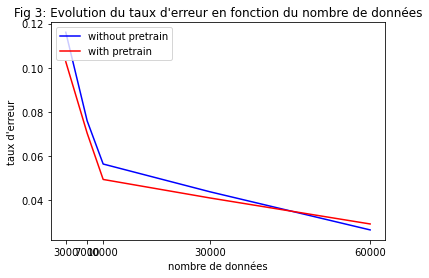

In [35]:
#visualisation
plt.ylabel("taux d'erreur")
plt.xlabel("nombre de données")
plt.title("Fig 3: Evolution du taux d'erreur en fonction du nombre de données")
plt.plot(param_data,scores_dnn,"-b",label="without pretrain")
plt.plot(param_data,scores_dnn_pre,"-r",label="with pretrain")
plt.legend(loc="upper left")
plt.xticks(param_data)
plt.show()

In [34]:
param_data = [3000,7000,10000,30000,60000]

In [39]:
dnn = Dnn([len(data_train[0]),700,700,700,700,10])
dnn.pretrain(data_train,epoch_rbm,learning_rate,mini_batch_size)
dnn.retropropagation(data_train,labels_train,epoch_retro_prop,learning_rate,100)

  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  1


  1%|          | 1/100 [00:06<10:30,  6.37s/it]

erreur quadratique :  4522244


  2%|▏         | 2/100 [00:12<10:10,  6.23s/it]

erreur quadratique :  3808548


  3%|▎         | 3/100 [00:18<09:55,  6.14s/it]

erreur quadratique :  3429648


  4%|▍         | 4/100 [00:24<09:45,  6.10s/it]

erreur quadratique :  3192641


  5%|▌         | 5/100 [00:30<09:34,  6.05s/it]

erreur quadratique :  3011822


  6%|▌         | 6/100 [00:36<09:24,  6.01s/it]

erreur quadratique :  2884274


  7%|▋         | 7/100 [00:42<09:17,  5.99s/it]

erreur quadratique :  2772860


  8%|▊         | 8/100 [00:47<09:10,  5.98s/it]

erreur quadratique :  2682042


  9%|▉         | 9/100 [00:53<09:03,  5.97s/it]

erreur quadratique :  2611695


 10%|█         | 10/100 [00:59<08:57,  5.97s/it]

erreur quadratique :  2545005


 11%|█         | 11/100 [01:05<08:50,  5.96s/it]

erreur quadratique :  2482752


 12%|█▏        | 12/100 [01:12<09:05,  6.19s/it]

erreur quadratique :  2431088


 13%|█▎        | 13/100 [01:18<09:00,  6.21s/it]

erreur quadratique :  2384290


 14%|█▍        | 14/100 [01:24<08:45,  6.12s/it]

erreur quadratique :  2343830


 15%|█▌        | 15/100 [01:30<08:39,  6.11s/it]

erreur quadratique :  2308239


 16%|█▌        | 16/100 [01:36<08:30,  6.08s/it]

erreur quadratique :  2268207


 17%|█▋        | 17/100 [01:42<08:23,  6.06s/it]

erreur quadratique :  2232733


 18%|█▊        | 18/100 [01:48<08:14,  6.03s/it]

erreur quadratique :  2205855


 19%|█▉        | 19/100 [01:54<08:05,  5.99s/it]

erreur quadratique :  2172867


 20%|██        | 20/100 [02:00<08:00,  6.01s/it]

erreur quadratique :  2146279


 21%|██        | 21/100 [02:06<07:53,  6.00s/it]

erreur quadratique :  2119930


 22%|██▏       | 22/100 [02:12<07:45,  5.97s/it]

erreur quadratique :  2096922


 23%|██▎       | 23/100 [02:18<07:41,  6.00s/it]

erreur quadratique :  2076104


 24%|██▍       | 24/100 [02:24<07:36,  6.01s/it]

erreur quadratique :  2053821


 25%|██▌       | 25/100 [02:30<07:28,  5.99s/it]

erreur quadratique :  2036049


 26%|██▌       | 26/100 [02:36<07:21,  5.97s/it]

erreur quadratique :  2011514


 27%|██▋       | 27/100 [02:42<07:18,  6.01s/it]

erreur quadratique :  1995584


 28%|██▊       | 28/100 [02:48<07:10,  5.99s/it]

erreur quadratique :  1980371


 29%|██▉       | 29/100 [02:54<07:03,  5.97s/it]

erreur quadratique :  1962784


 30%|███       | 30/100 [03:00<07:00,  6.01s/it]

erreur quadratique :  1947946


 31%|███       | 31/100 [03:06<06:59,  6.08s/it]

erreur quadratique :  1927102


 32%|███▏      | 32/100 [03:14<07:18,  6.45s/it]

erreur quadratique :  1912994


 33%|███▎      | 33/100 [03:20<07:06,  6.36s/it]

erreur quadratique :  1898449


 34%|███▍      | 34/100 [03:26<06:53,  6.26s/it]

erreur quadratique :  1883543


 35%|███▌      | 35/100 [03:32<06:40,  6.16s/it]

erreur quadratique :  1873273


 36%|███▌      | 36/100 [03:38<06:30,  6.09s/it]

erreur quadratique :  1857635


 37%|███▋      | 37/100 [03:44<06:24,  6.10s/it]

erreur quadratique :  1847299


 38%|███▊      | 38/100 [03:50<06:17,  6.10s/it]

erreur quadratique :  1834465


 39%|███▉      | 39/100 [03:56<06:09,  6.05s/it]

erreur quadratique :  1823976


 40%|████      | 40/100 [04:02<06:04,  6.07s/it]

erreur quadratique :  1811186


 41%|████      | 41/100 [04:08<05:58,  6.08s/it]

erreur quadratique :  1802296


 42%|████▏     | 42/100 [04:14<05:53,  6.10s/it]

erreur quadratique :  1786894


 43%|████▎     | 43/100 [04:20<05:47,  6.10s/it]

erreur quadratique :  1780130


 44%|████▍     | 44/100 [04:27<05:42,  6.12s/it]

erreur quadratique :  1768653


 45%|████▌     | 45/100 [04:33<05:36,  6.12s/it]

erreur quadratique :  1760927


 46%|████▌     | 46/100 [04:39<05:30,  6.12s/it]

erreur quadratique :  1749034


 47%|████▋     | 47/100 [04:45<05:24,  6.11s/it]

erreur quadratique :  1740804


 48%|████▊     | 48/100 [04:51<05:17,  6.11s/it]

erreur quadratique :  1732040


 49%|████▉     | 49/100 [04:57<05:11,  6.11s/it]

erreur quadratique :  1722839


 50%|█████     | 50/100 [05:03<05:06,  6.12s/it]

erreur quadratique :  1714375


 51%|█████     | 51/100 [05:10<05:02,  6.18s/it]

erreur quadratique :  1706975


 52%|█████▏    | 52/100 [05:17<05:09,  6.45s/it]

erreur quadratique :  1696036


 53%|█████▎    | 53/100 [05:23<04:58,  6.36s/it]

erreur quadratique :  1691291


 54%|█████▍    | 54/100 [05:29<04:49,  6.29s/it]

erreur quadratique :  1685295


 55%|█████▌    | 55/100 [05:35<04:40,  6.24s/it]

erreur quadratique :  1675073


 56%|█████▌    | 56/100 [05:41<04:33,  6.21s/it]

erreur quadratique :  1667426


 57%|█████▋    | 57/100 [05:47<04:25,  6.18s/it]

erreur quadratique :  1660467


 58%|█████▊    | 58/100 [05:53<04:19,  6.17s/it]

erreur quadratique :  1654591


 59%|█████▉    | 59/100 [06:00<04:12,  6.16s/it]

erreur quadratique :  1649222


 60%|██████    | 60/100 [06:06<04:06,  6.16s/it]

erreur quadratique :  1640447


 61%|██████    | 61/100 [06:12<03:59,  6.15s/it]

erreur quadratique :  1633476


 62%|██████▏   | 62/100 [06:18<03:53,  6.15s/it]

erreur quadratique :  1627799


 63%|██████▎   | 63/100 [06:24<03:47,  6.14s/it]

erreur quadratique :  1619338


 64%|██████▍   | 64/100 [06:30<03:41,  6.14s/it]

erreur quadratique :  1612659


 65%|██████▌   | 65/100 [06:36<03:34,  6.14s/it]

erreur quadratique :  1608100


 66%|██████▌   | 66/100 [06:43<03:28,  6.14s/it]

erreur quadratique :  1601404


 67%|██████▋   | 67/100 [06:49<03:22,  6.14s/it]

erreur quadratique :  1593853


 68%|██████▊   | 68/100 [06:55<03:16,  6.14s/it]

erreur quadratique :  1589245


 69%|██████▉   | 69/100 [07:01<03:10,  6.15s/it]

erreur quadratique :  1587223


 70%|███████   | 70/100 [07:07<03:04,  6.14s/it]

erreur quadratique :  1579418


 71%|███████   | 71/100 [07:15<03:09,  6.54s/it]

erreur quadratique :  1574757


 72%|███████▏  | 72/100 [07:21<03:00,  6.43s/it]

erreur quadratique :  1569848


 73%|███████▎  | 73/100 [07:27<02:51,  6.34s/it]

erreur quadratique :  1562542


 74%|███████▍  | 74/100 [07:33<02:43,  6.28s/it]

erreur quadratique :  1559899


 75%|███████▌  | 75/100 [07:39<02:35,  6.23s/it]

erreur quadratique :  1552167


 76%|███████▌  | 76/100 [07:45<02:28,  6.21s/it]

erreur quadratique :  1547924


 77%|███████▋  | 77/100 [07:51<02:22,  6.18s/it]

erreur quadratique :  1541198


 78%|███████▊  | 78/100 [07:58<02:15,  6.18s/it]

erreur quadratique :  1536531


 79%|███████▉  | 79/100 [08:04<02:09,  6.18s/it]

erreur quadratique :  1532206


 80%|████████  | 80/100 [08:10<02:03,  6.17s/it]

erreur quadratique :  1526458


 81%|████████  | 81/100 [08:16<01:57,  6.16s/it]

erreur quadratique :  1522207


 82%|████████▏ | 82/100 [08:22<01:50,  6.16s/it]

erreur quadratique :  1520329


 83%|████████▎ | 83/100 [08:28<01:44,  6.15s/it]

erreur quadratique :  1513812


 84%|████████▍ | 84/100 [08:34<01:38,  6.15s/it]

erreur quadratique :  1509916


 85%|████████▌ | 85/100 [08:41<01:32,  6.14s/it]

erreur quadratique :  1506367


 86%|████████▌ | 86/100 [08:47<01:26,  6.15s/it]

erreur quadratique :  1501505


 87%|████████▋ | 87/100 [08:53<01:19,  6.14s/it]

erreur quadratique :  1496497


 88%|████████▊ | 88/100 [08:59<01:13,  6.15s/it]

erreur quadratique :  1493134


 89%|████████▉ | 89/100 [09:05<01:07,  6.15s/it]

erreur quadratique :  1488837


 90%|█████████ | 90/100 [09:12<01:03,  6.40s/it]

erreur quadratique :  1485287


 91%|█████████ | 91/100 [09:19<00:57,  6.42s/it]

erreur quadratique :  1479737


 92%|█████████▏| 92/100 [09:25<00:50,  6.34s/it]

erreur quadratique :  1476285


 93%|█████████▎| 93/100 [09:31<00:43,  6.28s/it]

erreur quadratique :  1473453


 94%|█████████▍| 94/100 [09:37<00:37,  6.24s/it]

erreur quadratique :  1467819


 95%|█████████▌| 95/100 [09:43<00:31,  6.21s/it]

erreur quadratique :  1464795


 96%|█████████▌| 96/100 [09:49<00:24,  6.20s/it]

erreur quadratique :  1461491


 97%|█████████▋| 97/100 [09:56<00:18,  6.18s/it]

erreur quadratique :  1460151


 98%|█████████▊| 98/100 [10:02<00:12,  6.18s/it]

erreur quadratique :  1452094


 99%|█████████▉| 99/100 [10:08<00:06,  6.18s/it]

erreur quadratique :  1453223


100%|██████████| 100/100 [10:14<00:00,  6.15s/it]

erreur quadratique :  1446790



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  2


  1%|          | 1/100 [00:05<09:20,  5.66s/it]

erreur quadratique :  10071442


  2%|▏         | 2/100 [00:11<09:15,  5.67s/it]

erreur quadratique :  9014038


  3%|▎         | 3/100 [00:17<09:10,  5.67s/it]

erreur quadratique :  8445371


  4%|▍         | 4/100 [00:22<09:04,  5.68s/it]

erreur quadratique :  8103840


  5%|▌         | 5/100 [00:28<08:58,  5.67s/it]

erreur quadratique :  7847423


  6%|▌         | 6/100 [00:34<08:53,  5.68s/it]

erreur quadratique :  7665941


  7%|▋         | 7/100 [00:39<08:47,  5.67s/it]

erreur quadratique :  7515504


  8%|▊         | 8/100 [00:45<08:42,  5.68s/it]

erreur quadratique :  7409630


  9%|▉         | 9/100 [00:51<08:36,  5.68s/it]

erreur quadratique :  7322140


 10%|█         | 10/100 [00:57<08:57,  5.97s/it]

erreur quadratique :  7231180


 11%|█         | 11/100 [01:03<08:48,  5.94s/it]

erreur quadratique :  7163372


 12%|█▏        | 12/100 [01:09<08:36,  5.87s/it]

erreur quadratique :  7107832


 13%|█▎        | 13/100 [01:15<08:26,  5.82s/it]

erreur quadratique :  7052180


 14%|█▍        | 14/100 [01:20<08:16,  5.78s/it]

erreur quadratique :  7014755


 15%|█▌        | 15/100 [01:26<08:08,  5.75s/it]

erreur quadratique :  6964347


 16%|█▌        | 16/100 [01:32<08:01,  5.73s/it]

erreur quadratique :  6933141


 17%|█▋        | 17/100 [01:37<07:54,  5.72s/it]

erreur quadratique :  6905303


 18%|█▊        | 18/100 [01:43<07:47,  5.71s/it]

erreur quadratique :  6874603


 19%|█▉        | 19/100 [01:49<07:41,  5.70s/it]

erreur quadratique :  6846201


 20%|██        | 20/100 [01:54<07:35,  5.70s/it]

erreur quadratique :  6819944


 21%|██        | 21/100 [02:00<07:29,  5.69s/it]

erreur quadratique :  6792089


 22%|██▏       | 22/100 [02:06<07:23,  5.69s/it]

erreur quadratique :  6782935


 23%|██▎       | 23/100 [02:11<07:17,  5.69s/it]

erreur quadratique :  6757624


 24%|██▍       | 24/100 [02:17<07:12,  5.69s/it]

erreur quadratique :  6739945


 25%|██▌       | 25/100 [02:23<07:07,  5.69s/it]

erreur quadratique :  6724809


 26%|██▌       | 26/100 [02:28<07:01,  5.70s/it]

erreur quadratique :  6702689


 27%|██▋       | 27/100 [02:34<06:55,  5.69s/it]

erreur quadratique :  6701220


 28%|██▊       | 28/100 [02:40<06:49,  5.69s/it]

erreur quadratique :  6682270


 29%|██▉       | 29/100 [02:46<06:43,  5.69s/it]

erreur quadratique :  6673252


 30%|███       | 30/100 [02:51<06:38,  5.70s/it]

erreur quadratique :  6656532


 31%|███       | 31/100 [02:58<07:01,  6.11s/it]

erreur quadratique :  6639004


 32%|███▏      | 32/100 [03:04<06:48,  6.00s/it]

erreur quadratique :  6636981


 33%|███▎      | 33/100 [03:10<06:35,  5.91s/it]

erreur quadratique :  6620347


 34%|███▍      | 34/100 [03:15<06:25,  5.84s/it]

erreur quadratique :  6610393


 35%|███▌      | 35/100 [03:21<06:16,  5.79s/it]

erreur quadratique :  6606608


 36%|███▌      | 36/100 [03:27<06:08,  5.75s/it]

erreur quadratique :  6597784


 37%|███▋      | 37/100 [03:32<06:01,  5.73s/it]

erreur quadratique :  6583319


 38%|███▊      | 38/100 [03:38<05:54,  5.72s/it]

erreur quadratique :  6580410


 39%|███▉      | 39/100 [03:44<05:48,  5.71s/it]

erreur quadratique :  6578332


 40%|████      | 40/100 [03:50<05:42,  5.71s/it]

erreur quadratique :  6567736


 41%|████      | 41/100 [03:55<05:36,  5.71s/it]

erreur quadratique :  6565263


 42%|████▏     | 42/100 [04:01<05:30,  5.70s/it]

erreur quadratique :  6543372


 43%|████▎     | 43/100 [04:07<05:24,  5.70s/it]

erreur quadratique :  6547091


 44%|████▍     | 44/100 [04:12<05:18,  5.69s/it]

erreur quadratique :  6535179


 45%|████▌     | 45/100 [04:18<05:13,  5.69s/it]

erreur quadratique :  6533378


 46%|████▌     | 46/100 [04:24<05:07,  5.69s/it]

erreur quadratique :  6526963


 47%|████▋     | 47/100 [04:29<05:01,  5.69s/it]

erreur quadratique :  6521175


 48%|████▊     | 48/100 [04:35<04:55,  5.68s/it]

erreur quadratique :  6515646


 49%|████▉     | 49/100 [04:41<04:49,  5.68s/it]

erreur quadratique :  6508547


 50%|█████     | 50/100 [04:46<04:44,  5.69s/it]

erreur quadratique :  6505648


 51%|█████     | 51/100 [04:52<04:39,  5.70s/it]

erreur quadratique :  6490497


 52%|█████▏    | 52/100 [04:59<04:51,  6.08s/it]

erreur quadratique :  6491031


 53%|█████▎    | 53/100 [05:05<04:42,  6.02s/it]

erreur quadratique :  6489962


 54%|█████▍    | 54/100 [05:11<04:32,  5.92s/it]

erreur quadratique :  6487988


 55%|█████▌    | 55/100 [05:16<04:23,  5.86s/it]

erreur quadratique :  6484804


 56%|█████▌    | 56/100 [05:22<04:15,  5.81s/it]

erreur quadratique :  6478921


 57%|█████▋    | 57/100 [05:28<04:08,  5.78s/it]

erreur quadratique :  6477315


 58%|█████▊    | 58/100 [05:34<04:02,  5.76s/it]

erreur quadratique :  6468242


 59%|█████▉    | 59/100 [05:39<03:55,  5.75s/it]

erreur quadratique :  6462690


 60%|██████    | 60/100 [05:45<03:49,  5.73s/it]

erreur quadratique :  6458900


 61%|██████    | 61/100 [05:51<03:43,  5.74s/it]

erreur quadratique :  6454371


 62%|██████▏   | 62/100 [05:56<03:37,  5.73s/it]

erreur quadratique :  6446916


 63%|██████▎   | 63/100 [06:02<03:31,  5.72s/it]

erreur quadratique :  6448335


 64%|██████▍   | 64/100 [06:08<03:25,  5.72s/it]

erreur quadratique :  6446266


 65%|██████▌   | 65/100 [06:14<03:21,  5.75s/it]

erreur quadratique :  6436185


 66%|██████▌   | 66/100 [06:19<03:14,  5.73s/it]

erreur quadratique :  6433930


 67%|██████▋   | 67/100 [06:25<03:08,  5.72s/it]

erreur quadratique :  6434192


 68%|██████▊   | 68/100 [06:31<03:03,  5.72s/it]

erreur quadratique :  6431245


 69%|██████▉   | 69/100 [06:36<02:57,  5.72s/it]

erreur quadratique :  6425635


 70%|███████   | 70/100 [06:42<02:51,  5.71s/it]

erreur quadratique :  6431217


 71%|███████   | 71/100 [06:48<02:45,  5.71s/it]

erreur quadratique :  6418596


 72%|███████▏  | 72/100 [06:54<02:41,  5.76s/it]

erreur quadratique :  6423109


 73%|███████▎  | 73/100 [07:00<02:43,  6.05s/it]

erreur quadratique :  6415513


 74%|███████▍  | 74/100 [07:06<02:34,  5.95s/it]

erreur quadratique :  6413241


 75%|███████▌  | 75/100 [07:12<02:26,  5.87s/it]

erreur quadratique :  6406965


 76%|███████▌  | 76/100 [07:18<02:19,  5.83s/it]

erreur quadratique :  6409162


 77%|███████▋  | 77/100 [07:23<02:13,  5.79s/it]

erreur quadratique :  6400960


 78%|███████▊  | 78/100 [07:29<02:06,  5.76s/it]

erreur quadratique :  6395966


 79%|███████▉  | 79/100 [07:35<02:00,  5.74s/it]

erreur quadratique :  6391765


 80%|████████  | 80/100 [07:40<01:54,  5.73s/it]

erreur quadratique :  6394578


 81%|████████  | 81/100 [07:46<01:48,  5.72s/it]

erreur quadratique :  6387125


 82%|████████▏ | 82/100 [07:52<01:43,  5.72s/it]

erreur quadratique :  6386599


 83%|████████▎ | 83/100 [07:58<01:37,  5.72s/it]

erreur quadratique :  6383127


 84%|████████▍ | 84/100 [08:03<01:31,  5.72s/it]

erreur quadratique :  6382382


 85%|████████▌ | 85/100 [08:09<01:25,  5.71s/it]

erreur quadratique :  6376552


 86%|████████▌ | 86/100 [08:15<01:20,  5.72s/it]

erreur quadratique :  6377538


 87%|████████▋ | 87/100 [08:20<01:14,  5.71s/it]

erreur quadratique :  6365840


 88%|████████▊ | 88/100 [08:26<01:08,  5.71s/it]

erreur quadratique :  6373429


 89%|████████▉ | 89/100 [08:32<01:02,  5.71s/it]

erreur quadratique :  6366295


 90%|█████████ | 90/100 [08:37<00:57,  5.71s/it]

erreur quadratique :  6370422


 91%|█████████ | 91/100 [08:43<00:51,  5.71s/it]

erreur quadratique :  6361180


 92%|█████████▏| 92/100 [08:49<00:45,  5.71s/it]

erreur quadratique :  6364267


 93%|█████████▎| 93/100 [08:55<00:41,  5.86s/it]

erreur quadratique :  6363653


 94%|█████████▍| 94/100 [09:01<00:36,  6.00s/it]

erreur quadratique :  6358286


 95%|█████████▌| 95/100 [09:07<00:29,  5.91s/it]

erreur quadratique :  6351345


 96%|█████████▌| 96/100 [09:13<00:23,  5.83s/it]

erreur quadratique :  6350622


 97%|█████████▋| 97/100 [09:18<00:17,  5.77s/it]

erreur quadratique :  6346264


 98%|█████████▊| 98/100 [09:24<00:11,  5.73s/it]

erreur quadratique :  6339401


 99%|█████████▉| 99/100 [09:30<00:05,  5.71s/it]

erreur quadratique :  6339628


100%|██████████| 100/100 [09:35<00:00,  5.76s/it]

erreur quadratique :  6342654



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  3


  1%|          | 1/100 [00:05<09:18,  5.64s/it]

erreur quadratique :  9943809


  2%|▏         | 2/100 [00:11<09:12,  5.64s/it]

erreur quadratique :  8863413


  3%|▎         | 3/100 [00:16<09:09,  5.66s/it]

erreur quadratique :  8294254


  4%|▍         | 4/100 [00:22<09:03,  5.66s/it]

erreur quadratique :  7956030


  5%|▌         | 5/100 [00:28<08:57,  5.66s/it]

erreur quadratique :  7718183


  6%|▌         | 6/100 [00:33<08:52,  5.66s/it]

erreur quadratique :  7539005


  7%|▋         | 7/100 [00:39<08:46,  5.66s/it]

erreur quadratique :  7405389


  8%|▊         | 8/100 [00:45<08:41,  5.67s/it]

erreur quadratique :  7299549


  9%|▉         | 9/100 [00:50<08:35,  5.67s/it]

erreur quadratique :  7206975


 10%|█         | 10/100 [00:56<08:30,  5.67s/it]

erreur quadratique :  7133078


 11%|█         | 11/100 [01:02<08:24,  5.67s/it]

erreur quadratique :  7068723


 12%|█▏        | 12/100 [01:08<08:19,  5.67s/it]

erreur quadratique :  7023436


 13%|█▎        | 13/100 [01:13<08:13,  5.67s/it]

erreur quadratique :  6974323


 14%|█▍        | 14/100 [01:20<08:32,  5.96s/it]

erreur quadratique :  6935614


 15%|█▌        | 15/100 [01:26<08:25,  5.94s/it]

erreur quadratique :  6891873


 16%|█▌        | 16/100 [01:31<08:12,  5.86s/it]

erreur quadratique :  6863880


 17%|█▋        | 17/100 [01:37<08:01,  5.80s/it]

erreur quadratique :  6836559


 18%|█▊        | 18/100 [01:43<07:52,  5.76s/it]

erreur quadratique :  6819604


 19%|█▉        | 19/100 [01:48<07:44,  5.73s/it]

erreur quadratique :  6790992


 20%|██        | 20/100 [01:54<07:36,  5.71s/it]

erreur quadratique :  6766575


 21%|██        | 21/100 [02:00<07:30,  5.70s/it]

erreur quadratique :  6750461


 22%|██▏       | 22/100 [02:05<07:23,  5.69s/it]

erreur quadratique :  6734435


 23%|██▎       | 23/100 [02:11<07:17,  5.68s/it]

erreur quadratique :  6714401


 24%|██▍       | 24/100 [02:17<07:12,  5.69s/it]

erreur quadratique :  6701523


 25%|██▌       | 25/100 [02:22<07:06,  5.69s/it]

erreur quadratique :  6686489


 26%|██▌       | 26/100 [02:28<07:00,  5.68s/it]

erreur quadratique :  6674802


 27%|██▋       | 27/100 [02:34<06:54,  5.68s/it]

erreur quadratique :  6658223


 28%|██▊       | 28/100 [02:40<06:51,  5.71s/it]

erreur quadratique :  6648737


 29%|██▉       | 29/100 [02:45<06:45,  5.70s/it]

erreur quadratique :  6633132


 30%|███       | 30/100 [02:51<06:39,  5.70s/it]

erreur quadratique :  6628046


 31%|███       | 31/100 [02:57<06:33,  5.70s/it]

erreur quadratique :  6620760


 32%|███▏      | 32/100 [03:02<06:27,  5.70s/it]

erreur quadratique :  6612967


 33%|███▎      | 33/100 [03:08<06:21,  5.69s/it]

erreur quadratique :  6597424


 34%|███▍      | 34/100 [03:13<06:11,  5.63s/it]

erreur quadratique :  6600210


 35%|███▌      | 35/100 [03:20<06:21,  5.87s/it]

erreur quadratique :  6589413


 36%|███▌      | 36/100 [03:26<06:16,  5.89s/it]

erreur quadratique :  6581089


 37%|███▋      | 37/100 [03:32<06:06,  5.82s/it]

erreur quadratique :  6573247


 38%|███▊      | 38/100 [03:37<05:55,  5.74s/it]

erreur quadratique :  6566928


 39%|███▉      | 39/100 [03:43<05:45,  5.67s/it]

erreur quadratique :  6568158


 40%|████      | 40/100 [03:48<05:37,  5.63s/it]

erreur quadratique :  6555531


 41%|████      | 41/100 [03:54<05:29,  5.59s/it]

erreur quadratique :  6553930


 42%|████▏     | 42/100 [03:59<05:22,  5.57s/it]

erreur quadratique :  6545107


 43%|████▎     | 43/100 [04:05<05:16,  5.55s/it]

erreur quadratique :  6547814


 44%|████▍     | 44/100 [04:10<05:09,  5.53s/it]

erreur quadratique :  6540705


 45%|████▌     | 45/100 [04:16<05:05,  5.55s/it]

erreur quadratique :  6533346


 46%|████▌     | 46/100 [04:21<04:59,  5.54s/it]

erreur quadratique :  6532473


 47%|████▋     | 47/100 [04:27<04:53,  5.54s/it]

erreur quadratique :  6527633


 48%|████▊     | 48/100 [04:32<04:48,  5.54s/it]

erreur quadratique :  6519570


 49%|████▉     | 49/100 [04:38<04:42,  5.53s/it]

erreur quadratique :  6516980


 50%|█████     | 50/100 [04:43<04:36,  5.53s/it]

erreur quadratique :  6514221


 51%|█████     | 51/100 [04:49<04:30,  5.53s/it]

erreur quadratique :  6509765


 52%|█████▏    | 52/100 [04:54<04:25,  5.53s/it]

erreur quadratique :  6504969


 53%|█████▎    | 53/100 [05:00<04:22,  5.58s/it]

erreur quadratique :  6502795


 54%|█████▍    | 54/100 [05:06<04:18,  5.61s/it]

erreur quadratique :  6500432


 55%|█████▌    | 55/100 [05:12<04:14,  5.66s/it]

erreur quadratique :  6498908


 56%|█████▌    | 56/100 [05:18<04:15,  5.80s/it]

erreur quadratique :  6491642


 57%|█████▋    | 57/100 [05:24<04:22,  6.09s/it]

erreur quadratique :  6488190


 58%|█████▊    | 58/100 [05:30<04:10,  5.97s/it]

erreur quadratique :  6485063


 59%|█████▉    | 59/100 [05:36<04:01,  5.88s/it]

erreur quadratique :  6486986


 60%|██████    | 60/100 [05:42<03:53,  5.83s/it]

erreur quadratique :  6481005


 61%|██████    | 61/100 [05:47<03:45,  5.78s/it]

erreur quadratique :  6479246


 62%|██████▏   | 62/100 [05:53<03:38,  5.75s/it]

erreur quadratique :  6477133


 63%|██████▎   | 63/100 [05:59<03:32,  5.74s/it]

erreur quadratique :  6476395


 64%|██████▍   | 64/100 [06:04<03:26,  5.73s/it]

erreur quadratique :  6468686


 65%|██████▌   | 65/100 [06:10<03:20,  5.72s/it]

erreur quadratique :  6470197


 66%|██████▌   | 66/100 [06:16<03:14,  5.72s/it]

erreur quadratique :  6461654


 67%|██████▋   | 67/100 [06:21<03:08,  5.71s/it]

erreur quadratique :  6460746


 68%|██████▊   | 68/100 [06:27<03:02,  5.70s/it]

erreur quadratique :  6460640


 69%|██████▉   | 69/100 [06:33<02:56,  5.70s/it]

erreur quadratique :  6466141


 70%|███████   | 70/100 [06:38<02:51,  5.70s/it]

erreur quadratique :  6460754


 71%|███████   | 71/100 [06:44<02:45,  5.70s/it]

erreur quadratique :  6453211


 72%|███████▏  | 72/100 [06:50<02:39,  5.69s/it]

erreur quadratique :  6449768


 73%|███████▎  | 73/100 [06:56<02:33,  5.70s/it]

erreur quadratique :  6451402


 74%|███████▍  | 74/100 [07:01<02:28,  5.70s/it]

erreur quadratique :  6444553


 75%|███████▌  | 75/100 [07:07<02:22,  5.70s/it]

erreur quadratique :  6440578


 76%|███████▌  | 76/100 [07:13<02:16,  5.71s/it]

erreur quadratique :  6439115


 77%|███████▋  | 77/100 [07:19<02:17,  5.97s/it]

erreur quadratique :  6441832


 78%|███████▊  | 78/100 [07:25<02:12,  6.02s/it]

erreur quadratique :  6434648


 79%|███████▉  | 79/100 [07:31<02:03,  5.89s/it]

erreur quadratique :  6432433


 80%|████████  | 80/100 [07:37<01:56,  5.84s/it]

erreur quadratique :  6433938


 81%|████████  | 81/100 [07:42<01:50,  5.80s/it]

erreur quadratique :  6436442


 82%|████████▏ | 82/100 [07:48<01:43,  5.77s/it]

erreur quadratique :  6430250


 83%|████████▎ | 83/100 [07:54<01:37,  5.76s/it]

erreur quadratique :  6432552


 84%|████████▍ | 84/100 [08:00<01:31,  5.74s/it]

erreur quadratique :  6429021


 85%|████████▌ | 85/100 [08:05<01:26,  5.74s/it]

erreur quadratique :  6426846


 86%|████████▌ | 86/100 [08:11<01:20,  5.73s/it]

erreur quadratique :  6424288


 87%|████████▋ | 87/100 [08:17<01:14,  5.73s/it]

erreur quadratique :  6424498


 88%|████████▊ | 88/100 [08:22<01:08,  5.72s/it]

erreur quadratique :  6418117


 89%|████████▉ | 89/100 [08:28<01:02,  5.71s/it]

erreur quadratique :  6418947


 90%|█████████ | 90/100 [08:34<00:57,  5.71s/it]

erreur quadratique :  6414427


 91%|█████████ | 91/100 [08:40<00:51,  5.71s/it]

erreur quadratique :  6413223


 92%|█████████▏| 92/100 [08:45<00:45,  5.71s/it]

erreur quadratique :  6410027


 93%|█████████▎| 93/100 [08:51<00:40,  5.71s/it]

erreur quadratique :  6406360


 94%|█████████▍| 94/100 [08:57<00:34,  5.72s/it]

erreur quadratique :  6404876


 95%|█████████▌| 95/100 [09:02<00:28,  5.72s/it]

erreur quadratique :  6397672


 96%|█████████▌| 96/100 [09:08<00:22,  5.71s/it]

erreur quadratique :  6405093


 97%|█████████▋| 97/100 [09:14<00:17,  5.71s/it]

erreur quadratique :  6399650


 98%|█████████▊| 98/100 [09:21<00:12,  6.06s/it]

erreur quadratique :  6400020


 99%|█████████▉| 99/100 [09:26<00:05,  5.96s/it]

erreur quadratique :  6396754


100%|██████████| 100/100 [09:32<00:00,  5.73s/it]

erreur quadratique :  6394690



  0%|          | 0/100 [00:00<?, ?it/s]

train rbm  4


  1%|          | 1/100 [00:05<09:23,  5.69s/it]

erreur quadratique :  10778059


  2%|▏         | 2/100 [00:11<09:18,  5.69s/it]

erreur quadratique :  9683005


  3%|▎         | 3/100 [00:17<09:12,  5.70s/it]

erreur quadratique :  9128213


  4%|▍         | 4/100 [00:22<09:07,  5.70s/it]

erreur quadratique :  8782347


  5%|▌         | 5/100 [00:28<09:01,  5.70s/it]

erreur quadratique :  8543820


  6%|▌         | 6/100 [00:34<08:55,  5.70s/it]

erreur quadratique :  8371032


  7%|▋         | 7/100 [00:39<08:50,  5.71s/it]

erreur quadratique :  8227930


  8%|▊         | 8/100 [00:45<08:46,  5.72s/it]

erreur quadratique :  8122624


  9%|▉         | 9/100 [00:51<08:39,  5.71s/it]

erreur quadratique :  8033291


 10%|█         | 10/100 [00:57<08:33,  5.70s/it]

erreur quadratique :  7960068


 11%|█         | 11/100 [01:02<08:27,  5.70s/it]

erreur quadratique :  7901828


 12%|█▏        | 12/100 [01:08<08:21,  5.70s/it]

erreur quadratique :  7851912


 13%|█▎        | 13/100 [01:14<08:17,  5.72s/it]

erreur quadratique :  7801683


 14%|█▍        | 14/100 [01:19<08:11,  5.72s/it]

erreur quadratique :  7763628


 15%|█▌        | 15/100 [01:25<08:06,  5.73s/it]

erreur quadratique :  7734286


 16%|█▌        | 16/100 [01:31<08:00,  5.72s/it]

erreur quadratique :  7702743


 17%|█▋        | 17/100 [01:37<07:54,  5.71s/it]

erreur quadratique :  7677384


 18%|█▊        | 18/100 [01:42<07:51,  5.75s/it]

erreur quadratique :  7648881


 19%|█▉        | 19/100 [01:49<08:13,  6.09s/it]

erreur quadratique :  7632728


 20%|██        | 20/100 [01:55<07:56,  5.96s/it]

erreur quadratique :  7610084


 21%|██        | 21/100 [02:01<07:43,  5.87s/it]

erreur quadratique :  7592500


 22%|██▏       | 22/100 [02:06<07:32,  5.81s/it]

erreur quadratique :  7586555


 23%|██▎       | 23/100 [02:12<07:23,  5.76s/it]

erreur quadratique :  7563344


 24%|██▍       | 24/100 [02:18<07:15,  5.73s/it]

erreur quadratique :  7548310


 25%|██▌       | 25/100 [02:23<07:08,  5.72s/it]

erreur quadratique :  7534612


 26%|██▌       | 26/100 [02:29<07:02,  5.71s/it]

erreur quadratique :  7529068


 27%|██▋       | 27/100 [02:35<06:57,  5.72s/it]

erreur quadratique :  7522904


 28%|██▊       | 28/100 [02:40<06:51,  5.71s/it]

erreur quadratique :  7505822


 29%|██▉       | 29/100 [02:46<06:46,  5.72s/it]

erreur quadratique :  7504806


 30%|███       | 30/100 [02:52<06:40,  5.72s/it]

erreur quadratique :  7494996


 31%|███       | 31/100 [02:58<06:34,  5.71s/it]

erreur quadratique :  7490768


 32%|███▏      | 32/100 [03:03<06:28,  5.71s/it]

erreur quadratique :  7475033


 33%|███▎      | 33/100 [03:09<06:22,  5.71s/it]

erreur quadratique :  7468704


 34%|███▍      | 34/100 [03:15<06:16,  5.71s/it]

erreur quadratique :  7458979


 35%|███▌      | 35/100 [03:20<06:11,  5.71s/it]

erreur quadratique :  7456788


 36%|███▌      | 36/100 [03:26<06:05,  5.71s/it]

erreur quadratique :  7454080


 37%|███▋      | 37/100 [03:32<05:59,  5.71s/it]

erreur quadratique :  7443161


 38%|███▊      | 38/100 [03:37<05:53,  5.71s/it]

erreur quadratique :  7442710


 39%|███▉      | 39/100 [03:44<05:53,  5.80s/it]

erreur quadratique :  7431328


 40%|████      | 40/100 [03:50<06:02,  6.04s/it]

erreur quadratique :  7437440


 41%|████      | 41/100 [03:56<05:50,  5.94s/it]

erreur quadratique :  7424307


 42%|████▏     | 42/100 [04:02<05:40,  5.87s/it]

erreur quadratique :  7417835


 43%|████▎     | 43/100 [04:07<05:31,  5.82s/it]

erreur quadratique :  7417705


 44%|████▍     | 44/100 [04:13<05:23,  5.78s/it]

erreur quadratique :  7416412


 45%|████▌     | 45/100 [04:19<05:16,  5.76s/it]

erreur quadratique :  7405233


 46%|████▌     | 46/100 [04:24<05:10,  5.75s/it]

erreur quadratique :  7405524


 47%|████▋     | 47/100 [04:30<05:03,  5.73s/it]

erreur quadratique :  7408964


 48%|████▊     | 48/100 [04:36<04:57,  5.73s/it]

erreur quadratique :  7400914


 49%|████▉     | 49/100 [04:41<04:51,  5.72s/it]

erreur quadratique :  7395052


 50%|█████     | 50/100 [04:47<04:45,  5.72s/it]

erreur quadratique :  7389080


 51%|█████     | 51/100 [04:53<04:40,  5.72s/it]

erreur quadratique :  7388847


 52%|█████▏    | 52/100 [04:59<04:34,  5.72s/it]

erreur quadratique :  7385034


 53%|█████▎    | 53/100 [05:04<04:28,  5.71s/it]

erreur quadratique :  7384202


 54%|█████▍    | 54/100 [05:10<04:22,  5.71s/it]

erreur quadratique :  7379180


 55%|█████▌    | 55/100 [05:16<04:16,  5.71s/it]

erreur quadratique :  7373880


 56%|█████▌    | 56/100 [05:21<04:11,  5.71s/it]

erreur quadratique :  7380202


 57%|█████▋    | 57/100 [05:27<04:05,  5.71s/it]

erreur quadratique :  7376882


 58%|█████▊    | 58/100 [05:33<03:59,  5.71s/it]

erreur quadratique :  7364876


 59%|█████▉    | 59/100 [05:39<03:54,  5.71s/it]

erreur quadratique :  7363937


 60%|██████    | 60/100 [05:45<03:55,  5.88s/it]

erreur quadratique :  7367779


 61%|██████    | 61/100 [05:51<03:55,  6.03s/it]

erreur quadratique :  7362218


 62%|██████▏   | 62/100 [05:57<03:45,  5.94s/it]

erreur quadratique :  7358191


 63%|██████▎   | 63/100 [06:03<03:43,  6.04s/it]

erreur quadratique :  7356050


 64%|██████▍   | 64/100 [06:09<03:34,  5.95s/it]

erreur quadratique :  7353255


 65%|██████▌   | 65/100 [06:15<03:25,  5.88s/it]

erreur quadratique :  7355165


 66%|██████▌   | 66/100 [06:20<03:18,  5.83s/it]

erreur quadratique :  7352528


 67%|██████▋   | 67/100 [06:26<03:11,  5.80s/it]

erreur quadratique :  7350036


 68%|██████▊   | 68/100 [06:32<03:04,  5.77s/it]

erreur quadratique :  7346716


 69%|██████▉   | 69/100 [06:38<02:58,  5.75s/it]

erreur quadratique :  7345486


 70%|███████   | 70/100 [06:43<02:53,  5.79s/it]

erreur quadratique :  7347941


 71%|███████   | 71/100 [06:49<02:48,  5.80s/it]

erreur quadratique :  7338590


 72%|███████▏  | 72/100 [06:55<02:42,  5.82s/it]

erreur quadratique :  7337967


 73%|███████▎  | 73/100 [07:01<02:36,  5.78s/it]

erreur quadratique :  7345129


 74%|███████▍  | 74/100 [07:07<02:29,  5.76s/it]

erreur quadratique :  7337971


 75%|███████▌  | 75/100 [07:12<02:23,  5.73s/it]

erreur quadratique :  7332572


 76%|███████▌  | 76/100 [07:18<02:17,  5.72s/it]

erreur quadratique :  7334379


 77%|███████▋  | 77/100 [07:24<02:11,  5.70s/it]

erreur quadratique :  7327776


 78%|███████▊  | 78/100 [07:29<02:04,  5.65s/it]

erreur quadratique :  7324879


 79%|███████▉  | 79/100 [07:35<01:58,  5.65s/it]

erreur quadratique :  7332574


 80%|████████  | 80/100 [07:40<01:53,  5.66s/it]

erreur quadratique :  7325325


 81%|████████  | 81/100 [07:47<01:55,  6.07s/it]

erreur quadratique :  7323214


 82%|████████▏ | 82/100 [07:53<01:47,  5.96s/it]

erreur quadratique :  7328463


 83%|████████▎ | 83/100 [07:59<01:39,  5.88s/it]

erreur quadratique :  7319216


 84%|████████▍ | 84/100 [08:04<01:33,  5.82s/it]

erreur quadratique :  7316847


 85%|████████▌ | 85/100 [08:10<01:26,  5.78s/it]

erreur quadratique :  7319306


 86%|████████▌ | 86/100 [08:16<01:20,  5.75s/it]

erreur quadratique :  7305937


 87%|████████▋ | 87/100 [08:22<01:14,  5.72s/it]

erreur quadratique :  7317221


 88%|████████▊ | 88/100 [08:27<01:08,  5.70s/it]

erreur quadratique :  7307722


 89%|████████▉ | 89/100 [08:33<01:02,  5.69s/it]

erreur quadratique :  7303202


 90%|█████████ | 90/100 [08:38<00:56,  5.68s/it]

erreur quadratique :  7305325


 91%|█████████ | 91/100 [08:44<00:51,  5.68s/it]

erreur quadratique :  7301000


 92%|█████████▏| 92/100 [08:50<00:45,  5.68s/it]

erreur quadratique :  7304499


 93%|█████████▎| 93/100 [08:56<00:39,  5.68s/it]

erreur quadratique :  7302468


 94%|█████████▍| 94/100 [09:01<00:34,  5.67s/it]

erreur quadratique :  7294891


 95%|█████████▌| 95/100 [09:07<00:28,  5.67s/it]

erreur quadratique :  7292359


 96%|█████████▌| 96/100 [09:12<00:22,  5.67s/it]

erreur quadratique :  7301448


 97%|█████████▋| 97/100 [09:18<00:17,  5.67s/it]

erreur quadratique :  7293193


 98%|█████████▊| 98/100 [09:24<00:11,  5.67s/it]

erreur quadratique :  7294106


 99%|█████████▉| 99/100 [09:30<00:05,  5.67s/it]

erreur quadratique :  7287942


100%|██████████| 100/100 [09:35<00:00,  5.76s/it]

erreur quadratique :  7284127



  0%|          | 1/200 [00:10<33:28, 10.10s/it]

cross entropie : 
0.5553074091124266


  1%|          | 2/200 [00:19<32:15,  9.77s/it]

cross entropie : 
0.10684980940219062


  2%|▏         | 3/200 [00:27<30:57,  9.43s/it]

cross entropie : 
0.0730420922356765


  2%|▏         | 4/200 [00:36<29:58,  9.18s/it]

cross entropie : 
0.052469933006204166


  2%|▎         | 5/200 [00:44<29:17,  9.01s/it]

cross entropie : 
0.03811362098769786


  3%|▎         | 6/200 [00:53<28:45,  8.90s/it]

cross entropie : 
0.026143125845724237


  4%|▎         | 7/200 [01:02<28:20,  8.81s/it]

cross entropie : 
0.01755130659428931


  4%|▍         | 8/200 [01:10<28:04,  8.77s/it]

cross entropie : 
0.012643584449907637


  4%|▍         | 9/200 [01:19<27:48,  8.73s/it]

cross entropie : 
0.008251724783770991


  5%|▌         | 10/200 [01:28<27:32,  8.70s/it]

cross entropie : 
0.0059403714853654985


  6%|▌         | 11/200 [01:36<27:20,  8.68s/it]

cross entropie : 
0.004189555719744398


  6%|▌         | 12/200 [01:45<27:07,  8.66s/it]

cross entropie : 
0.002927736497999223


  6%|▋         | 13/200 [01:54<26:57,  8.65s/it]

cross entropie : 
0.0021057365272238947


  7%|▋         | 14/200 [02:02<26:46,  8.64s/it]

cross entropie : 
0.001715675350363182


  8%|▊         | 15/200 [02:12<28:00,  9.09s/it]

cross entropie : 
0.001436562017803203


  8%|▊         | 16/200 [02:21<27:26,  8.95s/it]

cross entropie : 
0.0012549680665401627


  8%|▊         | 17/200 [02:30<27:00,  8.86s/it]

cross entropie : 
0.001052653720932293


  9%|▉         | 18/200 [02:38<26:38,  8.78s/it]

cross entropie : 
0.0009042387856044942


 10%|▉         | 19/200 [02:47<26:22,  8.74s/it]

cross entropie : 
0.0007860548343856094


 10%|█         | 20/200 [02:55<26:07,  8.71s/it]

cross entropie : 
0.0006936633042635714


 10%|█         | 21/200 [03:04<25:55,  8.69s/it]

cross entropie : 
0.0006202231164507851


 11%|█         | 22/200 [03:13<25:42,  8.67s/it]

cross entropie : 
0.0005712572188437671


 12%|█▏        | 23/200 [03:21<25:32,  8.66s/it]

cross entropie : 
0.0005266358066997094


 12%|█▏        | 24/200 [03:30<25:21,  8.64s/it]

cross entropie : 
0.0004905274149855128


 12%|█▎        | 25/200 [03:39<25:12,  8.64s/it]

cross entropie : 
0.0004580752833198525


 13%|█▎        | 26/200 [03:47<25:03,  8.64s/it]

cross entropie : 
0.00042811882214705785


 14%|█▎        | 27/200 [03:56<24:54,  8.64s/it]

cross entropie : 
0.00039851571176450595


 14%|█▍        | 28/200 [04:04<24:45,  8.63s/it]

cross entropie : 
0.00037976709939087393


 14%|█▍        | 29/200 [04:15<26:15,  9.21s/it]

cross entropie : 
0.0003575855023972409


 15%|█▌        | 30/200 [04:24<25:35,  9.03s/it]

cross entropie : 
0.00033990012986275837


 16%|█▌        | 31/200 [04:32<25:06,  8.92s/it]

cross entropie : 
0.0003221378946701516


 16%|█▌        | 32/200 [04:41<24:43,  8.83s/it]

cross entropie : 
0.0003081569591261316


 16%|█▋        | 33/200 [04:50<24:25,  8.78s/it]

cross entropie : 
0.0002941415551664357


 17%|█▋        | 34/200 [04:58<24:09,  8.73s/it]

cross entropie : 
0.0002825848502698547


 18%|█▊        | 35/200 [05:07<23:56,  8.70s/it]

cross entropie : 
0.00027058364292763357


 18%|█▊        | 36/200 [05:15<23:44,  8.68s/it]

cross entropie : 
0.00025967942128643165


 18%|█▊        | 37/200 [05:24<23:34,  8.68s/it]

cross entropie : 
0.00024930289242306727


 19%|█▉        | 38/200 [05:33<23:22,  8.66s/it]

cross entropie : 
0.00023968916766528656


 20%|█▉        | 39/200 [05:41<23:12,  8.65s/it]

cross entropie : 
0.00023167446910176342


 20%|██        | 40/200 [05:50<23:02,  8.64s/it]

cross entropie : 
0.00022336972848463078


 20%|██        | 41/200 [05:59<22:53,  8.64s/it]

cross entropie : 
0.00021570816386690215


 21%|██        | 42/200 [06:08<23:29,  8.92s/it]

cross entropie : 
0.00020875328594071904


 22%|██▏       | 43/200 [06:18<23:55,  9.14s/it]

cross entropie : 
0.00020182758524102883


 22%|██▏       | 44/200 [06:26<23:21,  8.98s/it]

cross entropie : 
0.0001956713418491151


 22%|██▎       | 45/200 [06:35<22:56,  8.88s/it]

cross entropie : 
0.00018980885084363345


 23%|██▎       | 46/200 [06:44<22:34,  8.80s/it]

cross entropie : 
0.00018431753008374987


 24%|██▎       | 47/200 [06:52<22:18,  8.75s/it]

cross entropie : 
0.00017917420509266007


 24%|██▍       | 48/200 [07:01<22:02,  8.70s/it]

cross entropie : 
0.00017392491028020993


 24%|██▍       | 49/200 [07:10<22:01,  8.75s/it]

cross entropie : 
0.00016906758605048607


 25%|██▌       | 50/200 [07:18<21:46,  8.71s/it]

cross entropie : 
0.000164836496130181


 26%|██▌       | 51/200 [07:27<21:34,  8.69s/it]

cross entropie : 
0.0001604701124280349


 26%|██▌       | 52/200 [07:36<21:22,  8.66s/it]

cross entropie : 
0.0001562835664669036


 26%|██▋       | 53/200 [07:44<21:12,  8.65s/it]

cross entropie : 
0.0001524063055026371


 27%|██▋       | 54/200 [07:53<21:01,  8.64s/it]

cross entropie : 
0.0001486269988497221


 28%|██▊       | 55/200 [08:02<20:52,  8.64s/it]

cross entropie : 
0.00014532273150569762


 28%|██▊       | 56/200 [08:12<21:44,  9.06s/it]

cross entropie : 
0.00014168479212469008


 28%|██▊       | 57/200 [08:20<21:18,  8.94s/it]

cross entropie : 
0.0001385060179261298


 29%|██▉       | 58/200 [08:29<20:55,  8.84s/it]

cross entropie : 
0.00013555811523018694


 30%|██▉       | 59/200 [08:37<20:37,  8.78s/it]

cross entropie : 
0.00013244302460814218


 30%|███       | 60/200 [08:46<20:23,  8.74s/it]

cross entropie : 
0.00012959366433562121


 30%|███       | 61/200 [08:55<20:10,  8.71s/it]

cross entropie : 
0.00012683839925287435


 31%|███       | 62/200 [09:03<19:58,  8.68s/it]

cross entropie : 
0.00012427005187896082


 32%|███▏      | 63/200 [09:12<19:49,  8.68s/it]

cross entropie : 
0.00012154718483567066


 32%|███▏      | 64/200 [09:21<19:37,  8.66s/it]

cross entropie : 
0.00011909631062904137


 32%|███▎      | 65/200 [09:29<19:28,  8.66s/it]

cross entropie : 
0.00011663755604840722


 33%|███▎      | 66/200 [09:38<19:18,  8.65s/it]

cross entropie : 
0.00011454521316997497


 34%|███▎      | 67/200 [09:47<19:10,  8.65s/it]

cross entropie : 
0.00011234139857970724


 34%|███▍      | 68/200 [09:55<19:01,  8.64s/it]

cross entropie : 
0.00011019740881450353


 34%|███▍      | 69/200 [10:04<18:52,  8.65s/it]

cross entropie : 
0.00010826986271673785


 35%|███▌      | 70/200 [10:15<20:01,  9.24s/it]

cross entropie : 
0.00010622578466385868


 36%|███▌      | 71/200 [10:23<19:31,  9.08s/it]

cross entropie : 
0.00010418042567510201


 36%|███▌      | 72/200 [10:32<19:05,  8.95s/it]

cross entropie : 
0.00010251502114692989


 36%|███▋      | 73/200 [10:41<18:46,  8.87s/it]

cross entropie : 
0.00010068536690062546


 37%|███▋      | 74/200 [10:49<18:29,  8.80s/it]

cross entropie : 
9.899364795187371e-05


 38%|███▊      | 75/200 [10:58<18:15,  8.77s/it]

cross entropie : 
9.72280338676175e-05


 38%|███▊      | 76/200 [11:07<18:02,  8.73s/it]

cross entropie : 
9.56634981121775e-05


 38%|███▊      | 77/200 [11:15<17:50,  8.70s/it]

cross entropie : 
9.406947013322719e-05


 39%|███▉      | 78/200 [11:24<17:37,  8.66s/it]

cross entropie : 
9.260432549285665e-05


 40%|███▉      | 79/200 [11:32<17:26,  8.64s/it]

cross entropie : 
9.093963456776176e-05


 40%|████      | 80/200 [11:41<17:14,  8.62s/it]

cross entropie : 
8.962575655027887e-05


 40%|████      | 81/200 [11:50<17:05,  8.62s/it]

cross entropie : 
8.816744427569186e-05


 41%|████      | 82/200 [11:58<16:54,  8.60s/it]

cross entropie : 
8.682982754965445e-05


 42%|████▏     | 83/200 [12:07<17:10,  8.81s/it]

cross entropie : 
8.562406244200898e-05


 42%|████▏     | 84/200 [12:17<17:36,  9.10s/it]

cross entropie : 
8.425236170909329e-05


 42%|████▎     | 85/200 [12:26<17:09,  8.95s/it]

cross entropie : 
8.300085471654197e-05


 43%|████▎     | 86/200 [12:34<16:47,  8.84s/it]

cross entropie : 
8.183189466879526e-05


 44%|████▎     | 87/200 [12:43<16:31,  8.77s/it]

cross entropie : 
8.063742230761322e-05


 44%|████▍     | 88/200 [12:52<16:15,  8.71s/it]

cross entropie : 
7.949848579596463e-05


 44%|████▍     | 89/200 [13:00<16:05,  8.70s/it]

cross entropie : 
7.838294366312524e-05


 45%|████▌     | 90/200 [13:09<15:52,  8.66s/it]

cross entropie : 
7.723108672237782e-05


 46%|████▌     | 91/200 [13:17<15:43,  8.65s/it]

cross entropie : 
7.631780757302648e-05


 46%|████▌     | 92/200 [13:26<15:32,  8.63s/it]

cross entropie : 
7.522771798824704e-05


 46%|████▋     | 93/200 [13:35<15:25,  8.65s/it]

cross entropie : 
7.420812001415919e-05


 47%|████▋     | 94/200 [13:43<15:16,  8.65s/it]

cross entropie : 
7.323164262043114e-05


 48%|████▊     | 95/200 [13:52<15:08,  8.65s/it]

cross entropie : 
7.2224569651093e-05


 48%|████▊     | 96/200 [14:01<14:59,  8.65s/it]

cross entropie : 
7.128174262972826e-05


 48%|████▊     | 97/200 [14:11<15:55,  9.28s/it]

cross entropie : 
7.040100859690786e-05


 49%|████▉     | 98/200 [14:20<15:31,  9.13s/it]

cross entropie : 
6.952479422326573e-05


 50%|████▉     | 99/200 [14:29<15:06,  8.98s/it]

cross entropie : 
6.861019338620593e-05


 50%|█████     | 100/200 [14:37<14:46,  8.87s/it]

cross entropie : 
6.773024345426589e-05


 50%|█████     | 101/200 [14:46<14:31,  8.80s/it]

cross entropie : 
6.69621731884165e-05


 51%|█████     | 102/200 [14:55<14:17,  8.75s/it]

cross entropie : 
6.610356741091975e-05


 52%|█████▏    | 103/200 [15:03<14:05,  8.72s/it]

cross entropie : 
6.537305401750652e-05


 52%|█████▏    | 104/200 [15:12<13:54,  8.69s/it]

cross entropie : 
6.448725391413114e-05


 52%|█████▎    | 105/200 [15:21<13:44,  8.68s/it]

cross entropie : 
6.379227317637654e-05


 53%|█████▎    | 106/200 [15:29<13:34,  8.67s/it]

cross entropie : 
6.30332058013249e-05


 54%|█████▎    | 107/200 [15:38<13:27,  8.68s/it]

cross entropie : 
6.231847083247501e-05


 54%|█████▍    | 108/200 [15:47<13:17,  8.66s/it]

cross entropie : 
6.161221848541122e-05


 55%|█████▍    | 109/200 [15:55<13:08,  8.66s/it]

cross entropie : 
6.092147044885289e-05


 55%|█████▌    | 110/200 [16:04<12:58,  8.65s/it]

cross entropie : 
6.024032615609903e-05


 56%|█████▌    | 111/200 [16:14<13:41,  9.23s/it]

cross entropie : 
5.954994417631583e-05


 56%|█████▌    | 112/200 [16:23<13:16,  9.05s/it]

cross entropie : 
5.892108875905863e-05


 56%|█████▋    | 113/200 [16:32<12:57,  8.94s/it]

cross entropie : 
5.82099594122345e-05


 57%|█████▋    | 114/200 [16:40<12:40,  8.84s/it]

cross entropie : 
5.762753724707721e-05


 57%|█████▊    | 115/200 [16:49<12:27,  8.79s/it]

cross entropie : 
5.701327379028758e-05


 58%|█████▊    | 116/200 [16:58<12:14,  8.74s/it]

cross entropie : 
5.6387135803451174e-05


 58%|█████▊    | 117/200 [17:06<12:03,  8.71s/it]

cross entropie : 
5.580201060886165e-05


 59%|█████▉    | 118/200 [17:15<11:52,  8.69s/it]

cross entropie : 
5.5233138699078384e-05


 60%|█████▉    | 119/200 [17:24<11:42,  8.67s/it]

cross entropie : 
5.466581990606227e-05


 60%|██████    | 120/200 [17:32<11:32,  8.66s/it]

cross entropie : 
5.40857378450132e-05


 60%|██████    | 121/200 [17:41<11:23,  8.66s/it]

cross entropie : 
5.354556326849539e-05


 61%|██████    | 122/200 [17:49<11:14,  8.65s/it]

cross entropie : 
5.3017543821058603e-05


 62%|██████▏   | 123/200 [17:58<11:06,  8.65s/it]

cross entropie : 
5.247284846966802e-05


 62%|██████▏   | 124/200 [18:07<11:10,  8.83s/it]

cross entropie : 
5.192929575107895e-05


 62%|██████▎   | 125/200 [18:17<11:19,  9.06s/it]

cross entropie : 
5.14774316877732e-05


 63%|██████▎   | 126/200 [18:26<11:00,  8.93s/it]

cross entropie : 
5.093176376752245e-05


 64%|██████▎   | 127/200 [18:34<10:45,  8.85s/it]

cross entropie : 
5.047694917117281e-05


 64%|██████▍   | 128/200 [18:43<10:32,  8.78s/it]

cross entropie : 
4.999623892678136e-05


 64%|██████▍   | 129/200 [18:52<10:20,  8.74s/it]

cross entropie : 
4.9519299322422864e-05


 65%|██████▌   | 130/200 [19:00<10:09,  8.71s/it]

cross entropie : 
4.904459516244749e-05


 66%|██████▌   | 131/200 [19:09<09:59,  8.69s/it]

cross entropie : 
4.8592816192666965e-05


 66%|██████▌   | 132/200 [19:17<09:50,  8.68s/it]

cross entropie : 
4.815627880159674e-05


 66%|██████▋   | 133/200 [19:26<09:41,  8.67s/it]

cross entropie : 
4.770483650955442e-05


 67%|██████▋   | 134/200 [19:35<09:31,  8.66s/it]

cross entropie : 
4.724997880815783e-05


 68%|██████▊   | 135/200 [19:43<09:22,  8.66s/it]

cross entropie : 
4.683742240999803e-05


 68%|██████▊   | 136/200 [19:52<09:13,  8.65s/it]

cross entropie : 
4.638806209791787e-05


 68%|██████▊   | 137/200 [20:01<09:04,  8.64s/it]

cross entropie : 
4.599639605793309e-05


 69%|██████▉   | 138/200 [20:12<09:39,  9.35s/it]

cross entropie : 
4.5585134039498506e-05


 70%|██████▉   | 139/200 [20:20<09:18,  9.16s/it]

cross entropie : 
4.518671158234112e-05


 70%|███████   | 140/200 [20:29<08:59,  9.00s/it]

cross entropie : 
4.4798000357676054e-05


 70%|███████   | 141/200 [20:38<08:44,  8.89s/it]

cross entropie : 
4.440604597673611e-05


 71%|███████   | 142/200 [20:46<08:31,  8.82s/it]

cross entropie : 
4.404235568872005e-05


 72%|███████▏  | 143/200 [20:55<08:19,  8.76s/it]

cross entropie : 
4.366537445737862e-05


 72%|███████▏  | 144/200 [21:04<08:07,  8.71s/it]

cross entropie : 
4.328615898406908e-05


 72%|███████▎  | 145/200 [21:12<07:57,  8.68s/it]

cross entropie : 
4.292406717676511e-05


 73%|███████▎  | 146/200 [21:21<07:47,  8.65s/it]

cross entropie : 
4.257224224272191e-05


 74%|███████▎  | 147/200 [21:29<07:37,  8.64s/it]

cross entropie : 
4.222627578785503e-05


 74%|███████▍  | 148/200 [21:38<07:28,  8.62s/it]

cross entropie : 
4.186014819294749e-05


 74%|███████▍  | 149/200 [21:47<07:19,  8.62s/it]

cross entropie : 
4.153303127323176e-05


 75%|███████▌  | 150/200 [21:55<07:10,  8.61s/it]

cross entropie : 
4.117919360405642e-05


 76%|███████▌  | 151/200 [22:04<07:01,  8.61s/it]

cross entropie : 
4.086361634492083e-05


 76%|███████▌  | 152/200 [22:14<07:15,  9.08s/it]

cross entropie : 
4.052581757465616e-05


 76%|███████▋  | 153/200 [22:23<07:00,  8.95s/it]

cross entropie : 
4.021123065804686e-05


 77%|███████▋  | 154/200 [22:31<06:47,  8.85s/it]

cross entropie : 
3.9882406901807145e-05


 78%|███████▊  | 155/200 [22:40<06:35,  8.79s/it]

cross entropie : 
3.9580111571713955e-05


 78%|███████▊  | 156/200 [22:48<06:24,  8.74s/it]

cross entropie : 
3.9280589736491164e-05


 78%|███████▊  | 157/200 [22:57<06:14,  8.71s/it]

cross entropie : 
3.8951011043166565e-05


 79%|███████▉  | 158/200 [23:06<06:04,  8.68s/it]

cross entropie : 
3.867746154101838e-05


 80%|███████▉  | 159/200 [23:14<05:55,  8.68s/it]

cross entropie : 
3.837315257837141e-05


 80%|████████  | 160/200 [23:23<05:46,  8.66s/it]

cross entropie : 
3.808189939399945e-05


 80%|████████  | 161/200 [23:32<05:37,  8.66s/it]

cross entropie : 
3.7805604235989654e-05


 81%|████████  | 162/200 [23:40<05:28,  8.65s/it]

cross entropie : 
3.7519841901797556e-05


 82%|████████▏ | 163/200 [23:49<05:20,  8.65s/it]

cross entropie : 
3.7230094089712984e-05


 82%|████████▏ | 164/200 [23:58<05:11,  8.65s/it]

cross entropie : 
3.6949510916428334e-05


 82%|████████▎ | 165/200 [24:07<05:06,  8.76s/it]

cross entropie : 
3.6690857702876844e-05


 83%|████████▎ | 166/200 [24:16<05:08,  9.09s/it]

cross entropie : 
3.6425171179089164e-05


 84%|████████▎ | 167/200 [24:25<04:55,  8.96s/it]

cross entropie : 
3.6089723240159716e-05


 84%|████████▍ | 168/200 [24:34<04:43,  8.86s/it]

cross entropie : 
3.591938881987382e-05


 84%|████████▍ | 169/200 [24:42<04:32,  8.79s/it]

cross entropie : 
3.563495156767985e-05


 85%|████████▌ | 170/200 [24:51<04:22,  8.74s/it]

cross entropie : 
3.539047843493353e-05


 86%|████████▌ | 171/200 [25:00<04:12,  8.71s/it]

cross entropie : 
3.5145988927002716e-05


 86%|████████▌ | 172/200 [25:08<04:03,  8.69s/it]

cross entropie : 
3.489028010290041e-05


 86%|████████▋ | 173/200 [25:17<03:54,  8.69s/it]

cross entropie : 
3.466319916268829e-05


 87%|████████▋ | 174/200 [25:26<03:45,  8.67s/it]

cross entropie : 
3.440502163670841e-05


 88%|████████▊ | 175/200 [25:34<03:36,  8.66s/it]

cross entropie : 
3.417960057696288e-05


 88%|████████▊ | 176/200 [25:43<03:27,  8.65s/it]

cross entropie : 
3.393687152605401e-05


 88%|████████▊ | 177/200 [25:52<03:18,  8.65s/it]

cross entropie : 
3.369532220165946e-05


 89%|████████▉ | 178/200 [26:00<03:10,  8.64s/it]

cross entropie : 
3.3483312488742535e-05


 90%|████████▉ | 179/200 [26:10<03:08,  9.00s/it]

cross entropie : 
3.324612107822926e-05


 90%|█████████ | 180/200 [26:19<03:00,  9.00s/it]

cross entropie : 
3.303127852390104e-05


 90%|█████████ | 181/200 [26:28<02:48,  8.88s/it]

cross entropie : 
3.28030433695892e-05


 91%|█████████ | 182/200 [26:36<02:38,  8.78s/it]

cross entropie : 
3.2585614792793294e-05


 92%|█████████▏| 183/200 [26:45<02:28,  8.73s/it]

cross entropie : 
3.237712971251118e-05


 92%|█████████▏| 184/200 [26:53<02:18,  8.68s/it]

cross entropie : 
3.216843673554986e-05


 92%|█████████▎| 185/200 [27:02<02:09,  8.66s/it]

cross entropie : 
3.195581743820876e-05


 93%|█████████▎| 186/200 [27:10<02:00,  8.63s/it]

cross entropie : 
3.174582291227836e-05


 94%|█████████▎| 187/200 [27:19<01:52,  8.63s/it]

cross entropie : 
3.1542219240493765e-05


 94%|█████████▍| 188/200 [27:28<01:43,  8.61s/it]

cross entropie : 
3.134445031114857e-05


 94%|█████████▍| 189/200 [27:36<01:34,  8.60s/it]

cross entropie : 
3.1138226852263807e-05


 95%|█████████▌| 190/200 [27:45<01:25,  8.59s/it]

cross entropie : 
3.095187229900985e-05


 96%|█████████▌| 191/200 [27:53<01:17,  8.59s/it]

cross entropie : 
3.072658485138277e-05


 96%|█████████▌| 192/200 [28:02<01:08,  8.58s/it]

cross entropie : 
3.056019371757565e-05


 96%|█████████▋| 193/200 [28:13<01:04,  9.19s/it]

cross entropie : 
3.0368078749844815e-05


 97%|█████████▋| 194/200 [28:21<00:54,  9.04s/it]

cross entropie : 
3.0177194693518627e-05


 98%|█████████▊| 195/200 [28:30<00:44,  8.93s/it]

cross entropie : 
2.999956366891639e-05


 98%|█████████▊| 196/200 [28:39<00:35,  8.84s/it]

cross entropie : 
2.9813876280859212e-05


 98%|█████████▊| 197/200 [28:47<00:26,  8.78s/it]

cross entropie : 
2.9627524956397663e-05


 99%|█████████▉| 198/200 [28:56<00:17,  8.74s/it]

cross entropie : 
2.943860198918187e-05


100%|█████████▉| 199/200 [29:05<00:08,  8.72s/it]

cross entropie : 
2.9271123492060495e-05


100%|██████████| 200/200 [29:13<00:00,  8.77s/it]

cross entropie : 
2.9085581134947534e-05


In [40]:
dnn.test(data_test,labels_test)

error rate:  0.0176


0.0176